In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Fitting light curves from multiple instruments

In the :ref:`rv-multi` case study, we discussed fitting the radial velocity curve for a planetary system observed using multiple instruments.
You might also want to fit data from multiple instruments when fitting the light curve of a transiting planet and that's what we work through in this example.
This is a somewhat more complicated example than the radial velocity case because some of the physical properties of the system can vary as as function of the instrument.
Specifically, the transit depth (or the effective raduis of the planet) will be a function of the filter or effective wavelength of the observations.
This is the idea behind transit spectroscopy and the method used in this case study could (and should!) be extended to that use case.
In this case, we'll combine the light curves from the Kepler and TESS missions for the planet host HAT-P-11.

## A brief aside on dataset "weighting"

Before getting into the details of this case study, let's spend a minute talking about a topic that comes up a lot when discussing combining observations from different instruments or techniques.
To many people, it seems intuitive that one should (and perhaps must) "weight" how much each dataset contributes to the likelihood based on how much they "trust" those data.
For example, you might be worried that a dataset with more datapoints will have a larger effect on the the results than you would like.
While this might seem intuitive, it's wrong: **the only way to combine datasets is to multiply their likelihood functions**.
Instead, it is useful to understand what you actually mean when you say that you don't "trust" a dataset as much as another.
**What you're really saying is that you don't believe the observation model that you wrote down**.
For example, you might think that the quoted error bars are underestimated or there might be correlated noise that an uncorrelated normal observation model can't capture.
The benefit of thinking about it this way is that it suggests a solution to the problem: incorporate a more flexible observation model that can capture these issues.
In this case study, the 4 years of (long-cadence) Kepler observations only include about two times as many data points as one month of TESS observations.
But, as you can see in the figure below, these two datasets have different noise properties (both in terms of photon noise and correlated noise) so we will fit using a different flexible Gaussian process noise model for each data set that will take these different properties into account.

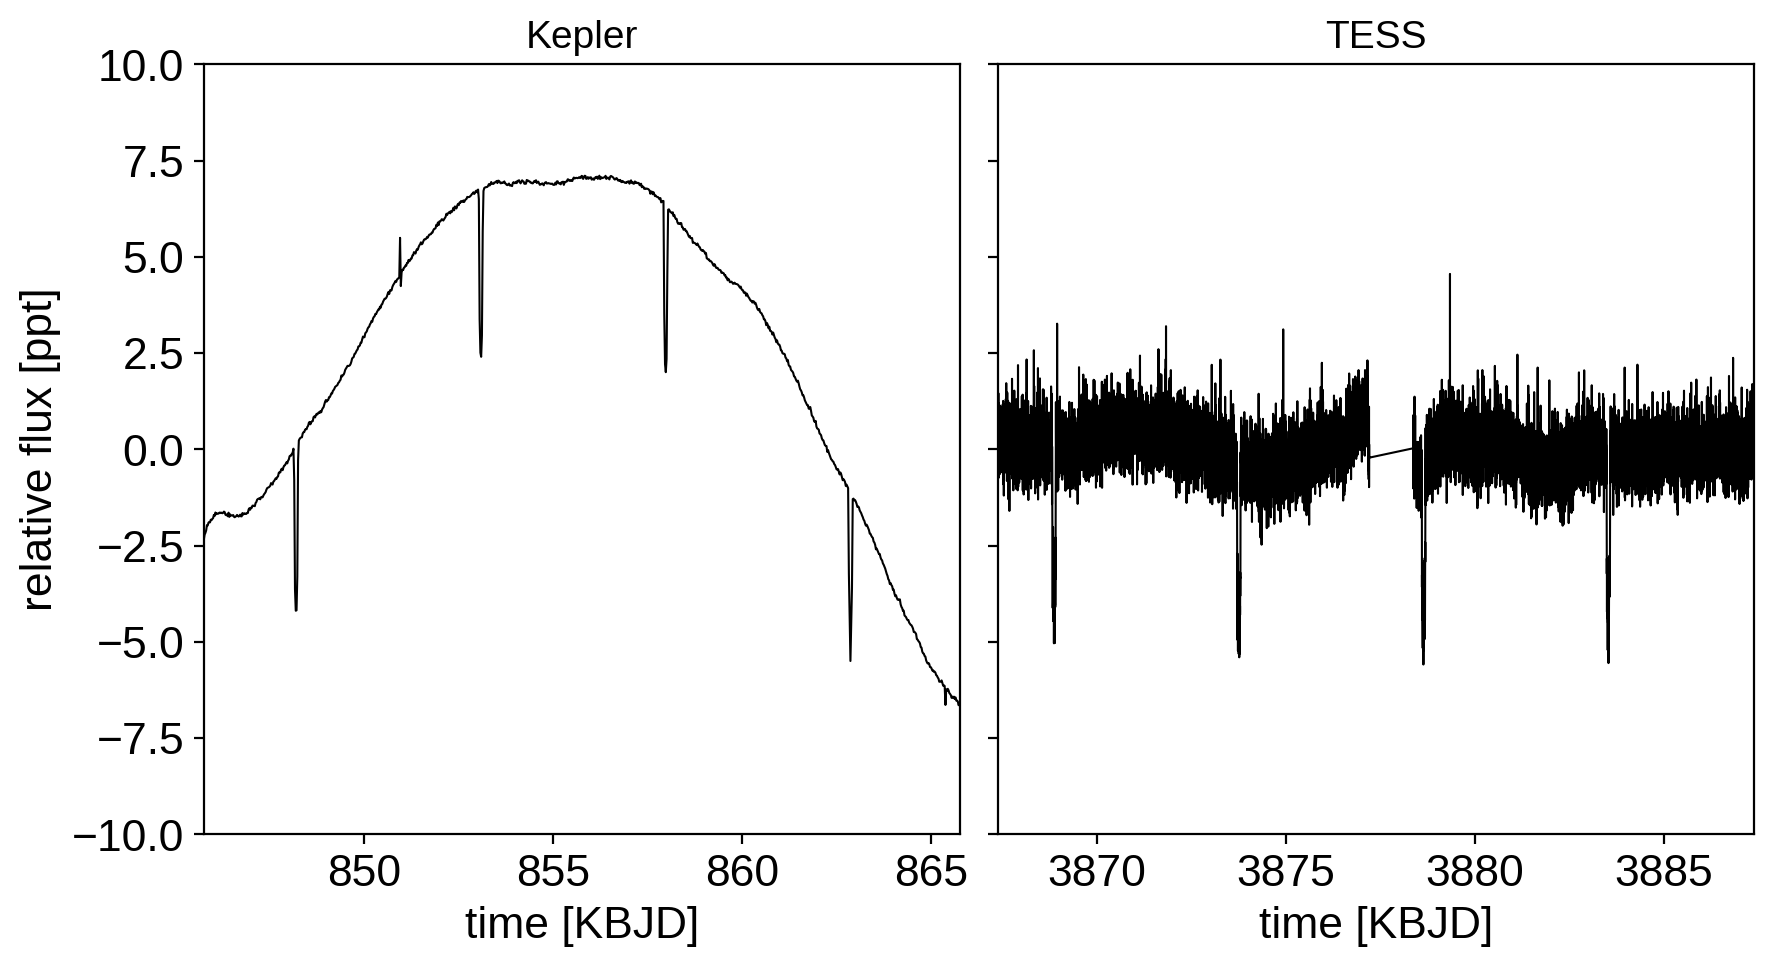

In [3]:
import numpy as np
import lightkurve as lk
from collections import OrderedDict

kepler_lcfs = lk.search_lightcurvefile("HAT-P-11", mission="Kepler").download_all()
kepler_lc = kepler_lcfs.PDCSAP_FLUX.stitch().remove_nans()
kepler_t = np.ascontiguousarray(kepler_lc.time, dtype=np.float64)
kepler_y = np.ascontiguousarray(1e3 * (kepler_lc.flux - 1), dtype=np.float64)
kepler_yerr = np.ascontiguousarray(1e3 * kepler_lc.flux_err, dtype=np.float64)

hdr = kepler_lcfs[0].hdu[1].header
kepler_texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
kepler_texp /= 60.0 * 60.0 * 24.0

tess_lcfs = lk.search_lightcurvefile("HAT-P-11", mission="TESS").download_all()
tess_lc = tess_lcfs.PDCSAP_FLUX.stitch().remove_nans()
tess_t = np.ascontiguousarray(tess_lc.time + 2457000 - 2454833, dtype=np.float64)
tess_y = np.ascontiguousarray(1e3 * (tess_lc.flux - 1), dtype=np.float64)
tess_yerr = np.ascontiguousarray(1e3 * tess_lc.flux_err, dtype=np.float64)

hdr = tess_lcfs[0].hdu[1].header
tess_texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
tess_texp /= 60.0 * 60.0 * 24.0

datasets = OrderedDict(
    [
        ("Kepler", [kepler_t, kepler_y, kepler_yerr, kepler_texp]),
        ("TESS", [tess_t, tess_y, tess_yerr, tess_texp]),
    ]
)

fig, axes = plt.subplots(1, len(datasets), sharey=True, figsize=(10, 5))

for i, (name, (t, y, _, _)) in enumerate(datasets.items()):
    ax = axes[i]
    ax.plot(t, y, "k", lw=0.75, label=name)
    ax.set_xlabel("time [KBJD]")
    ax.set_title(name, fontsize=14)

    x_mid = 0.5 * (t.min() + t.max())
    ax.set_xlim(x_mid - 10, x_mid + 10)
axes[0].set_ylim(-10, 10)
fig.subplots_adjust(wspace=0.05)
_ = axes[0].set_ylabel("relative flux [ppt]")

## The probabilistic model

This model is mostly the same as the one used in :ref:`quick-tess`, but we're allowing for different noise variances (both the white noise component and the GP amplitude), effective planet radii, and limb-darkening coeeficients for each dataset.
For the purposes of demonstration, we're sharing the length scale of the GP between the two datasets, but this could just have well been a different parameter for each dataset without changing the results.
The final change that we're using is to use the approximate transit depth `approx_depth` (the depth of the transit at minimum assuming the limb-darkening profile is constant under the disk of the planet) as a parameter instead of the radius ratio.
This does not have a large effect on the performance or the results, but it can sometimes be a useful parameterization when dealing with high signal-to-noise transits because it reduces the covariance between the radius parameter and the limb darkening coefficients.
As usual, we run a few iterations of sigma clipping and then find the maximum a posteriori parameters to check to make sure that everything is working:

In [4]:
import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt
from functools import partial

# Period and reference transit time from the literature for initialization
lit_period = 4.887803076
lit_t0 = 124.8130808

# Find a reference transit time near the middle of the observations to avoid
# strong covariances between period and t0
x_min = min(np.min(x) for x, _, _, _ in datasets.values())
x_max = max(np.max(x) for x, _, _, _ in datasets.values())
x_mid = 0.5 * (x_min + x_max)
t0_ref = lit_t0 + lit_period * np.round((x_mid - lit_t0) / lit_period)

# Do several rounds of sigma clipping
for i in range(10):
    with pm.Model() as model:

        # Shared orbital parameters
        period = pm.Lognormal("period", mu=np.log(lit_period), sigma=1.0)
        t0 = pm.Normal("t0", mu=t0_ref, sigma=1.0)
        dur = pm.Lognormal("dur", mu=np.log(0.1), sigma=10.0)
        b = xo.UnitUniform("b")
        ld_arg = 1 - tt.sqrt(1 - b ** 2)
        orbit = xo.orbits.KeplerianOrbit(period=period, duration=dur, t0=t0, b=b)

        # We'll also say that the timescale of the GP will be shared
        ell = pm.InverseGamma(
            "ell", testval=2.0, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )

        # Loop over the instruments
        parameters = dict()
        lc_models = dict()
        gp_preds = dict()
        gp_preds_with_mean = dict()
        for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):

            # We define the per-instrument parameters in a submodel so that we
            # don't have to prefix the names manually
            with pm.Model(name=name, model=model):
                # The flux zero point
                mean = pm.Normal("mean", mu=0.0, sigma=10.0)

                # The limb darkening
                u = xo.distributions.QuadLimbDark("u")
                star = xo.LimbDarkLightCurve(u)

                # The radius ratio
                approx_depth = pm.Lognormal("approx_depth", mu=np.log(4e-3), sigma=10)
                ld = 1 - u[0] * ld_arg - u[1] * ld_arg ** 2
                ror = pm.Deterministic("ror", tt.sqrt(approx_depth / ld))

                # Noise parameters
                med_yerr = np.median(yerr)
                std = np.std(y)
                sigma = pm.InverseGamma(
                    "sigma",
                    testval=med_yerr,
                    **xo.estimate_inverse_gamma_parameters(med_yerr, 0.5 * std),
                )
                S_tot = pm.InverseGamma(
                    "S_tot",
                    testval=med_yerr,
                    **xo.estimate_inverse_gamma_parameters(
                        med_yerr ** 2, 0.25 * std ** 2
                    ),
                )

                # Keep track of the parameters for optimization
                parameters[name] = [mean, u, approx_depth]
                parameters[f"{name}_noise"] = [sigma, S_tot]

            # The light curve model
            def lc_model(mean, star, ror, texp, t):
                return mean + 1e3 * tt.sum(
                    star.get_light_curve(orbit=orbit, r=ror, t=t, texp=texp), axis=-1
                )

            lc_model = partial(lc_model, mean, star, ror, texp)
            lc_models[name] = lc_model

            # The Gaussian Process noise model
            kernel = xo.gp.terms.SHOTerm(S_tot=S_tot, w0=2 * np.pi / ell, Q=1.0 / 3)
            gp = xo.gp.GP(kernel, x, yerr ** 2 + sigma ** 2, mean=lc_model)
            gp.marginal(f"{name}_obs", observed=y)
            gp_preds[name] = gp.predict()
            gp_preds_with_mean[name] = gp.predict(predict_mean=True)

        # Optimize the model
        map_soln = model.test_point
        for name in datasets:
            map_soln = xo.optimize(map_soln, parameters[name])
        for name in datasets:
            map_soln = xo.optimize(map_soln, parameters[name] + [dur, b])
            map_soln = xo.optimize(map_soln, parameters[f"{name}_noise"])
        map_soln = xo.optimize(map_soln)

        # Do some sigma clipping
        num = dict((name, len(datasets[name][0])) for name in datasets)
        clipped = dict()
        masks = dict()
        for name in datasets:
            mdl = xo.eval_in_model(gp_preds_with_mean[name], map_soln)
            resid = datasets[name][1] - mdl
            sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
            masks[name] = np.abs(resid - np.median(resid)) < 7 * sigma
            clipped[name] = num[name] - masks[name].sum()
            print(f"Sigma clipped {clipped[name]} {name} light curve points")
        if all(c < 10 for c in clipped.values()):
            break

        else:
            for name in datasets:
                datasets[name][0] = datasets[name][0][masks[name]]
                datasets[name][1] = datasets[name][1][masks[name]]
                datasets[name][2] = datasets[name][2][masks[name]]

optimizing logp for variables: [Kepler_approx_depth, Kepler_u, Kepler_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-9.590588e+05]

1it [00:00, 20.72it/s, logp=-9.590588e+05]

2it [00:00, 29.64it/s, logp=-9.590588e+05]

3it [00:00, 34.44it/s, logp=-2.389347e+06]

4it [00:00, 37.73it/s, logp=-7.126958e+05]

5it [00:00, 46.79it/s, logp=-7.126958e+05]

5it [00:00, 46.79it/s, logp=-8.224130e+05]

6it [00:00, 46.79it/s, logp=-6.423235e+05]

7it [00:00, 46.79it/s, logp=-3.620299e+06]

8it [00:00, 46.79it/s, logp=-6.423755e+05]

9it [00:00, 46.79it/s, logp=-6.414844e+05]

10it [00:00, 46.79it/s, logp=-6.622007e+05]

11it [00:00, 48.21it/s, logp=-6.622007e+05]

11it [00:00, 48.21it/s, logp=-6.414474e+05]

12it [00:00, 48.21it/s, logp=-6.413727e+05]

13it [00:00, 48.21it/s, logp=-6.410787e+05]

14it [00:00, 48.21it/s, logp=-6.399759e+05]

15it [00:00, 48.21it/s, logp=-6.374035e+05]

16it [00:00, 48.04it/s, logp=-6.374035e+05]

16it [00:00, 48.04it/s, logp=-6.340501e+05]

17it [00:00, 48.04it/s, logp=-6.331344e+05]

18it [00:00, 48.04it/s, logp=-6.321657e+05]

19it [00:00, 48.04it/s, logp=-6.309824e+05]

20it [00:00, 48.04it/s, logp=-6.300529e+05]

21it [00:00, 48.04it/s, logp=-6.300875e+05]

22it [00:00, 49.12it/s, logp=-6.300875e+05]

22it [00:00, 49.12it/s, logp=-6.297542e+05]

23it [00:00, 49.12it/s, logp=-6.294896e+05]

24it [00:00, 49.12it/s, logp=-6.292746e+05]

25it [00:00, 49.12it/s, logp=-6.291486e+05]

26it [00:00, 49.12it/s, logp=-6.290802e+05]

27it [00:00, 49.12it/s, logp=-6.290467e+05]

28it [00:00, 49.90it/s, logp=-6.290467e+05]

28it [00:00, 49.90it/s, logp=-6.290268e+05]

29it [00:00, 49.90it/s, logp=-6.290174e+05]

30it [00:00, 49.90it/s, logp=-6.290132e+05]

31it [00:00, 49.90it/s, logp=-6.290114e+05]

32it [00:00, 49.90it/s, logp=-6.290107e+05]

33it [00:00, 49.90it/s, logp=-6.290104e+05]

34it [00:00, 50.37it/s, logp=-6.290104e+05]

34it [00:00, 50.37it/s, logp=-6.290104e+05]

35it [00:00, 50.37it/s, logp=-6.290104e+05]

36it [00:00, 50.37it/s, logp=-6.290104e+05]

37it [00:00, 50.37it/s, logp=-6.290104e+05]

38it [00:00, 50.37it/s, logp=-6.290104e+05]

39it [00:00, 50.37it/s, logp=-6.290104e+05]

40it [00:00, 50.75it/s, logp=-6.290104e+05]

40it [00:00, 50.75it/s, logp=-6.290104e+05]

41it [00:00, 50.75it/s, logp=-6.290104e+05]

42it [00:00, 50.75it/s, logp=-6.290104e+05]

43it [00:00, 50.75it/s, logp=-6.290104e+05]

44it [00:00, 50.75it/s, logp=-6.290104e+05]

45it [00:00, 50.75it/s, logp=-6.290104e+05]

46it [00:00, 50.99it/s, logp=-6.290104e+05]

46it [00:00, 50.99it/s, logp=-6.290104e+05]

47it [00:00, 50.99it/s, logp=-6.290104e+05]

48it [00:00, 50.99it/s, logp=-6.290104e+05]

49it [00:00, 50.99it/s, logp=-6.290104e+05]

50it [00:01, 50.99it/s, logp=-6.290104e+05]

51it [00:01, 50.99it/s, logp=-6.290104e+05]

52it [00:01, 51.34it/s, logp=-6.290104e+05]

52it [00:01, 51.34it/s, logp=-6.290104e+05]

53it [00:01, 51.34it/s, logp=-6.290104e+05]

54it [00:01, 51.34it/s, logp=-6.290104e+05]

55it [00:01, 51.34it/s, logp=-6.290104e+05]

56it [00:01, 51.34it/s, logp=-6.290104e+05]

57it [00:01, 51.34it/s, logp=-6.290104e+05]

58it [00:01, 51.46it/s, logp=-6.290104e+05]

58it [00:01, 51.46it/s, logp=-6.290104e+05]

59it [00:01, 51.46it/s, logp=-6.290104e+05]

60it [00:01, 51.46it/s, logp=-6.290104e+05]

61it [00:01, 51.46it/s, logp=-6.290104e+05]

62it [00:01, 51.46it/s, logp=-6.290104e+05]

63it [00:01, 51.46it/s, logp=-6.290104e+05]

64it [00:01, 51.67it/s, logp=-6.290104e+05]

64it [00:01, 51.67it/s, logp=-6.290104e+05]

65it [00:01, 51.67it/s, logp=-6.290104e+05]

66it [00:01, 51.67it/s, logp=-6.290104e+05]

67it [00:01, 51.67it/s, logp=-6.290104e+05]

68it [00:01, 51.67it/s, logp=-6.290104e+05]

69it [00:01, 51.67it/s, logp=-6.290104e+05]

70it [00:01, 51.79it/s, logp=-6.290104e+05]

70it [00:01, 51.79it/s, logp=-6.290104e+05]

71it [00:01, 51.79it/s, logp=-6.290104e+05]

72it [00:01, 51.79it/s, logp=-6.290104e+05]

73it [00:01, 51.79it/s, logp=-6.290104e+05]

74it [00:01, 51.79it/s, logp=-6.290104e+05]

75it [00:01, 51.79it/s, logp=-6.290104e+05]

76it [00:01, 51.87it/s, logp=-6.290104e+05]

76it [00:01, 51.87it/s, logp=-6.290104e+05]

77it [00:01, 51.87it/s, logp=-6.290104e+05]

78it [00:01, 51.87it/s, logp=-6.290104e+05]

79it [00:01, 51.87it/s, logp=-6.290104e+05]

80it [00:01, 51.87it/s, logp=-6.290104e+05]

81it [00:03, 20.93it/s, logp=-6.290104e+05]


message: Optimization terminated successfully.
logp: -959058.8214741322 -> -629010.3944401566


optimizing logp for variables: [TESS_approx_depth, TESS_u, TESS_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-6.290104e+05]

1it [00:00, 23.12it/s, logp=-6.290104e+05]

2it [00:00, 32.41it/s, logp=-6.290104e+05]

3it [00:00, 37.37it/s, logp=-6.301442e+05]

4it [00:00, 40.60it/s, logp=-6.287915e+05]

5it [00:00, 42.74it/s, logp=-6.288891e+05]

6it [00:00, 50.97it/s, logp=-6.288891e+05]

6it [00:00, 50.97it/s, logp=-6.287382e+05]

7it [00:00, 50.97it/s, logp=-6.287635e+05]

8it [00:00, 50.97it/s, logp=-6.287450e+05]

9it [00:00, 50.97it/s, logp=-6.287341e+05]

10it [00:00, 50.97it/s, logp=-6.287273e+05]

11it [00:00, 50.97it/s, logp=-6.287456e+05]

12it [00:00, 51.74it/s, logp=-6.287456e+05]

12it [00:00, 51.74it/s, logp=-6.287259e+05]

13it [00:00, 51.74it/s, logp=-6.287233e+05]

14it [00:00, 51.74it/s, logp=-6.287197e+05]

15it [00:00, 51.74it/s, logp=-6.287181e+05]

16it [00:00, 51.74it/s, logp=-6.287169e+05]

17it [00:00, 51.74it/s, logp=-6.287157e+05]

18it [00:00, 52.24it/s, logp=-6.287157e+05]

18it [00:00, 52.24it/s, logp=-6.287153e+05]

19it [00:00, 52.24it/s, logp=-6.287152e+05]

20it [00:00, 52.24it/s, logp=-6.287152e+05]

21it [00:00, 52.24it/s, logp=-6.287152e+05]

22it [00:00, 52.24it/s, logp=-6.287152e+05]

23it [00:00, 52.24it/s, logp=-6.287152e+05]

24it [00:00, 52.59it/s, logp=-6.287152e+05]

24it [00:00, 52.59it/s, logp=-6.287152e+05]

25it [00:00, 52.59it/s, logp=-6.287152e+05]

26it [00:00, 52.59it/s, logp=-6.287152e+05]

27it [00:00, 42.76it/s, logp=-6.287152e+05]


message: Optimization terminated successfully.
logp: -629010.3944401566 -> -628715.2142879929


optimizing logp for variables: [b, dur, Kepler_approx_depth, Kepler_u, Kepler_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-6.287152e+05]

1it [00:00, 16.57it/s, logp=-6.287152e+05]

2it [00:00, 24.52it/s, logp=-6.287152e+05]

3it [00:00, 29.68it/s, logp=-4.033690e+06]

4it [00:00, 39.29it/s, logp=-4.033690e+06]

4it [00:00, 39.29it/s, logp=-6.269610e+05]

5it [00:00, 39.29it/s, logp=-6.326541e+05]

6it [00:00, 39.29it/s, logp=-6.266029e+05]

7it [00:00, 39.29it/s, logp=-6.259046e+05]

8it [00:00, 39.29it/s, logp=-6.236059e+05]

9it [00:00, 41.38it/s, logp=-6.236059e+05]

9it [00:00, 41.38it/s, logp=-6.204957e+05]

10it [00:00, 41.38it/s, logp=-2.121857e+07]

11it [00:00, 41.38it/s, logp=-6.204952e+05]

12it [00:00, 41.38it/s, logp=-6.204942e+05]

13it [00:00, 41.38it/s, logp=-6.204904e+05]

14it [00:00, 43.14it/s, logp=-6.204904e+05]

14it [00:00, 43.14it/s, logp=-6.204749e+05]

15it [00:00, 43.14it/s, logp=-6.204136e+05]

16it [00:00, 43.14it/s, logp=-6.201748e+05]

17it [00:00, 43.14it/s, logp=-6.193248e+05]

18it [00:00, 43.14it/s, logp=-6.176400e+05]

19it [00:00, 44.45it/s, logp=-6.176400e+05]

19it [00:00, 44.45it/s, logp=-6.170573e+05]

20it [00:00, 44.45it/s, logp=-6.171631e+05]

21it [00:00, 44.45it/s, logp=-6.170752e+05]

22it [00:00, 44.45it/s, logp=-6.170658e+05]

23it [00:00, 44.45it/s, logp=-6.170535e+05]

24it [00:00, 45.50it/s, logp=-6.170535e+05]

24it [00:00, 45.50it/s, logp=-6.170464e+05]

25it [00:00, 45.50it/s, logp=-6.170336e+05]

26it [00:00, 45.50it/s, logp=-6.170208e+05]

27it [00:00, 45.50it/s, logp=-6.170167e+05]

28it [00:00, 45.50it/s, logp=-6.170131e+05]

29it [00:00, 45.14it/s, logp=-6.170131e+05]

29it [00:00, 45.14it/s, logp=-6.170142e+05]

30it [00:00, 45.14it/s, logp=-6.170110e+05]

31it [00:00, 45.14it/s, logp=-6.170079e+05]

32it [00:00, 45.14it/s, logp=-6.170023e+05]

33it [00:00, 45.14it/s, logp=-6.169927e+05]

34it [00:00, 45.84it/s, logp=-6.169927e+05]

34it [00:00, 45.84it/s, logp=-6.169773e+05]

35it [00:00, 45.84it/s, logp=-6.170972e+05]

36it [00:00, 45.84it/s, logp=-6.169723e+05]

37it [00:00, 45.84it/s, logp=-6.169631e+05]

38it [00:00, 45.84it/s, logp=-6.169466e+05]

39it [00:00, 46.34it/s, logp=-6.169466e+05]

39it [00:00, 46.34it/s, logp=-6.169186e+05]

40it [00:00, 46.34it/s, logp=-6.168738e+05]

41it [00:00, 46.34it/s, logp=-6.177609e+05]

42it [00:00, 46.34it/s, logp=-6.168640e+05]

43it [00:00, 46.34it/s, logp=-6.168463e+05]

44it [00:00, 46.64it/s, logp=-6.168463e+05]

44it [00:00, 46.64it/s, logp=-6.168154e+05]

45it [00:00, 46.64it/s, logp=-6.167755e+05]

46it [00:01, 46.64it/s, logp=-6.167139e+05]

47it [00:01, 46.64it/s, logp=-6.167070e+05]

48it [00:01, 46.64it/s, logp=-6.166902e+05]

49it [00:01, 46.79it/s, logp=-6.166902e+05]

49it [00:01, 46.79it/s, logp=-6.166500e+05]

50it [00:01, 46.79it/s, logp=-6.166193e+05]

51it [00:01, 46.79it/s, logp=-6.165711e+05]

52it [00:01, 46.79it/s, logp=-6.165230e+05]

53it [00:01, 46.79it/s, logp=-6.164963e+05]

54it [00:01, 46.09it/s, logp=-6.164963e+05]

54it [00:01, 46.09it/s, logp=-6.164860e+05]

55it [00:01, 46.09it/s, logp=-6.164803e+05]

56it [00:01, 46.09it/s, logp=-6.165004e+05]

57it [00:01, 46.09it/s, logp=-6.164742e+05]

58it [00:01, 46.09it/s, logp=-6.164703e+05]

59it [00:01, 46.50it/s, logp=-6.164703e+05]

59it [00:01, 46.50it/s, logp=-6.164652e+05]

60it [00:01, 46.50it/s, logp=-6.164637e+05]

61it [00:01, 46.50it/s, logp=-6.164632e+05]

62it [00:01, 46.50it/s, logp=-6.164632e+05]

63it [00:01, 46.50it/s, logp=-6.164632e+05]

64it [00:01, 46.67it/s, logp=-6.164632e+05]

64it [00:01, 46.67it/s, logp=-6.164632e+05]

65it [00:01, 46.67it/s, logp=-6.164632e+05]

66it [00:01, 46.67it/s, logp=-6.164632e+05]

67it [00:01, 46.67it/s, logp=-6.164632e+05]

68it [00:01, 46.67it/s, logp=-6.164632e+05]

69it [00:01, 46.89it/s, logp=-6.164632e+05]

69it [00:01, 46.89it/s, logp=-6.164631e+05]

70it [00:01, 46.89it/s, logp=-6.164631e+05]

71it [00:01, 46.89it/s, logp=-6.164631e+05]

72it [00:01, 46.89it/s, logp=-6.164630e+05]

73it [00:01, 46.89it/s, logp=-6.164628e+05]

74it [00:01, 47.13it/s, logp=-6.164628e+05]

74it [00:01, 47.13it/s, logp=-6.164625e+05]

75it [00:01, 47.13it/s, logp=-6.164950e+05]

76it [00:01, 47.13it/s, logp=-6.164619e+05]

77it [00:01, 47.13it/s, logp=-6.164617e+05]

78it [00:01, 47.13it/s, logp=-6.164616e+05]

79it [00:01, 47.35it/s, logp=-6.164616e+05]

79it [00:01, 47.35it/s, logp=-6.164612e+05]

80it [00:01, 47.35it/s, logp=-1.451076e+06]

81it [00:01, 47.35it/s, logp=-6.166611e+05]

82it [00:01, 47.35it/s, logp=-6.164619e+05]

83it [00:01, 47.35it/s, logp=-6.164612e+05]

84it [00:01, 47.00it/s, logp=-6.164612e+05]

84it [00:01, 47.00it/s, logp=-6.164612e+05]

85it [00:01, 47.00it/s, logp=-6.164610e+05]

86it [00:01, 47.00it/s, logp=-6.164604e+05]

87it [00:01, 47.00it/s, logp=-6.164588e+05]

88it [00:01, 47.00it/s, logp=-6.164547e+05]

89it [00:01, 47.27it/s, logp=-6.164547e+05]

89it [00:01, 47.27it/s, logp=-6.164505e+05]

90it [00:01, 47.27it/s, logp=-6.164602e+05]

91it [00:01, 47.27it/s, logp=-6.164479e+05]

92it [00:01, 47.27it/s, logp=-6.164582e+05]

93it [00:02, 47.27it/s, logp=-6.164472e+05]

94it [00:02, 47.44it/s, logp=-6.164472e+05]

94it [00:02, 47.44it/s, logp=-6.164461e+05]

95it [00:02, 47.44it/s, logp=-6.164440e+05]

96it [00:02, 47.44it/s, logp=-6.164404e+05]

97it [00:02, 47.44it/s, logp=-6.164427e+05]

98it [00:02, 47.44it/s, logp=-6.164380e+05]

99it [00:02, 47.35it/s, logp=-6.164380e+05]

99it [00:02, 47.35it/s, logp=-6.164340e+05]

100it [00:02, 47.35it/s, logp=-6.164297e+05]

101it [00:02, 47.35it/s, logp=-6.164249e+05]

102it [00:02, 47.35it/s, logp=-6.164229e+05]

103it [00:02, 47.35it/s, logp=-6.164224e+05]

104it [00:02, 47.37it/s, logp=-6.164224e+05]

104it [00:02, 47.37it/s, logp=-6.164217e+05]

105it [00:02, 47.37it/s, logp=-6.164210e+05]

106it [00:02, 47.37it/s, logp=-6.164208e+05]

107it [00:02, 47.37it/s, logp=-6.164207e+05]

108it [00:02, 47.37it/s, logp=-6.164206e+05]

109it [00:02, 46.01it/s, logp=-6.164206e+05]

109it [00:02, 46.01it/s, logp=-6.164205e+05]

110it [00:02, 46.01it/s, logp=-6.164205e+05]

111it [00:02, 46.01it/s, logp=-6.164205e+05]

112it [00:02, 46.01it/s, logp=-6.164205e+05]

113it [00:02, 46.01it/s, logp=-6.164205e+05]

114it [00:02, 46.60it/s, logp=-6.164205e+05]

114it [00:02, 46.60it/s, logp=-6.164205e+05]

115it [00:02, 46.60it/s, logp=-6.164205e+05]

116it [00:02, 46.60it/s, logp=-6.164205e+05]

117it [00:02, 46.60it/s, logp=-6.164205e+05]

118it [00:02, 46.60it/s, logp=-6.164205e+05]

119it [00:02, 46.98it/s, logp=-6.164205e+05]

119it [00:02, 46.98it/s, logp=-6.164205e+05]

120it [00:02, 46.98it/s, logp=-6.164205e+05]

121it [00:02, 46.98it/s, logp=-6.164205e+05]

122it [00:02, 46.98it/s, logp=-6.164205e+05]

123it [00:02, 46.98it/s, logp=-6.164205e+05]

124it [00:02, 47.30it/s, logp=-6.164205e+05]

124it [00:02, 47.30it/s, logp=-6.164205e+05]

125it [00:02, 47.30it/s, logp=-6.164205e+05]

126it [00:02, 47.30it/s, logp=-6.164205e+05]

127it [00:02, 47.30it/s, logp=-6.164205e+05]

128it [00:02, 47.30it/s, logp=-6.164205e+05]

129it [00:02, 47.53it/s, logp=-6.164205e+05]

129it [00:02, 47.53it/s, logp=-6.164205e+05]

130it [00:02, 47.53it/s, logp=-6.164205e+05]

131it [00:02, 47.53it/s, logp=-6.164205e+05]

132it [00:02, 47.53it/s, logp=-6.164205e+05]

133it [00:02, 47.53it/s, logp=-6.164205e+05]

134it [00:02, 47.45it/s, logp=-6.164205e+05]

134it [00:02, 47.45it/s, logp=-6.164205e+05]

135it [00:02, 47.45it/s, logp=-6.164205e+05]

136it [00:02, 47.45it/s, logp=-6.164205e+05]

137it [00:02, 47.45it/s, logp=-6.164205e+05]

138it [00:02, 47.45it/s, logp=-6.164205e+05]

139it [00:02, 47.38it/s, logp=-6.164205e+05]

139it [00:02, 47.38it/s, logp=-6.164205e+05]

140it [00:03, 47.38it/s, logp=-6.164205e+05]

141it [00:03, 47.38it/s, logp=-6.164205e+05]

142it [00:03, 47.38it/s, logp=-6.164205e+05]

143it [00:03, 47.38it/s, logp=-6.164205e+05]

144it [00:03, 47.54it/s, logp=-6.164205e+05]

144it [00:03, 47.54it/s, logp=-6.164205e+05]

145it [00:03, 47.54it/s, logp=-6.164205e+05]

146it [00:03, 47.54it/s, logp=-6.164205e+05]

147it [00:03, 47.54it/s, logp=-6.164205e+05]

148it [00:03, 47.54it/s, logp=-6.164205e+05]

149it [00:03, 47.73it/s, logp=-6.164205e+05]

149it [00:03, 47.73it/s, logp=-6.164205e+05]

150it [00:03, 47.73it/s, logp=-6.164205e+05]

151it [00:03, 47.73it/s, logp=-6.164205e+05]

152it [00:03, 47.73it/s, logp=-6.164205e+05]

153it [00:03, 47.73it/s, logp=-6.164205e+05]

154it [00:03, 47.92it/s, logp=-6.164205e+05]

154it [00:03, 47.92it/s, logp=-6.164205e+05]

155it [00:03, 47.92it/s, logp=-6.164205e+05]

156it [00:03, 47.92it/s, logp=-6.164205e+05]

157it [00:03, 47.92it/s, logp=-6.164205e+05]

158it [00:03, 47.92it/s, logp=-6.164205e+05]

159it [00:03, 47.85it/s, logp=-6.164205e+05]

159it [00:03, 47.85it/s, logp=-6.164205e+05]

160it [00:03, 47.85it/s, logp=-6.164205e+05]

161it [00:03, 47.85it/s, logp=-6.164205e+05]

162it [00:03, 47.85it/s, logp=-6.164205e+05]

163it [00:03, 47.85it/s, logp=-6.164205e+05]

164it [00:03, 47.78it/s, logp=-6.164205e+05]

164it [00:03, 47.78it/s, logp=-6.164205e+05]

165it [00:03, 47.78it/s, logp=-6.164205e+05]

166it [00:03, 47.78it/s, logp=-6.164205e+05]

167it [00:03, 47.78it/s, logp=-6.164205e+05]

168it [00:03, 47.78it/s, logp=-6.164205e+05]

169it [00:03, 47.83it/s, logp=-6.164205e+05]

169it [00:03, 47.83it/s, logp=-6.164205e+05]

170it [00:03, 47.83it/s, logp=-6.164205e+05]

171it [00:03, 47.83it/s, logp=-6.164205e+05]

172it [00:03, 47.83it/s, logp=-6.164205e+05]

173it [00:03, 47.83it/s, logp=-6.164205e+05]

174it [00:03, 47.90it/s, logp=-6.164205e+05]

174it [00:03, 47.90it/s, logp=-6.164205e+05]

175it [00:03, 47.90it/s, logp=-6.164205e+05]

176it [00:03, 47.90it/s, logp=-6.164205e+05]

177it [00:03, 47.90it/s, logp=-6.164205e+05]

178it [00:03, 47.90it/s, logp=-6.164205e+05]

179it [00:03, 47.90it/s, logp=-6.164205e+05]

179it [00:03, 47.90it/s, logp=-6.164205e+05]

180it [00:03, 47.90it/s, logp=-6.164205e+05]

181it [00:03, 47.90it/s, logp=-6.164205e+05]

182it [00:03, 47.90it/s, logp=-6.164205e+05]

183it [00:03, 47.90it/s, logp=-6.164205e+05]

184it [00:03, 47.87it/s, logp=-6.164205e+05]

184it [00:03, 47.87it/s, logp=-6.164205e+05]

185it [00:03, 47.87it/s, logp=-6.164205e+05]

186it [00:03, 47.87it/s, logp=-6.164205e+05]

187it [00:03, 47.87it/s, logp=-6.164205e+05]

188it [00:04, 45.72it/s, logp=-6.164205e+05]


message: Desired error not necessarily achieved due to precision loss.
logp: -628715.2142879929 -> -616420.5305446959


optimizing logp for variables: [Kepler_S_tot, Kepler_sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-6.164205e+05]

1it [00:00, 18.61it/s, logp=-6.164205e+05]

2it [00:00, 26.48it/s, logp=-6.164205e+05]

3it [00:00, 30.86it/s, logp=-2.226590e+05]

4it [00:00, 33.64it/s, logp=-5.474591e+05]

5it [00:00, 41.79it/s, logp=-5.474591e+05]

5it [00:00, 41.79it/s, logp=-2.915145e+05]

6it [00:00, 41.79it/s, logp=-1.937412e+05]

7it [00:00, 41.79it/s, logp=-1.421270e+05]

8it [00:00, 41.79it/s, logp=-6.324624e+04]

9it [00:00, 41.79it/s, logp=-1.213190e+04]

10it [00:00, 43.03it/s, logp=-1.213190e+04]

10it [00:00, 43.03it/s, logp=9.903877e+03] 

11it [00:00, 43.03it/s, logp=1.982561e+04]

12it [00:00, 43.03it/s, logp=2.300300e+04]

13it [00:00, 43.03it/s, logp=2.361455e+04]

14it [00:00, 43.03it/s, logp=2.365978e+04]

15it [00:00, 43.86it/s, logp=2.365978e+04]

15it [00:00, 43.86it/s, logp=2.366046e+04]

16it [00:00, 43.86it/s, logp=2.366046e+04]

17it [00:00, 43.86it/s, logp=2.366046e+04]

18it [00:00, 43.86it/s, logp=2.366046e+04]

19it [00:00, 43.86it/s, logp=2.366046e+04]

20it [00:00, 44.45it/s, logp=2.366046e+04]

20it [00:00, 44.45it/s, logp=2.366046e+04]

21it [00:00, 44.45it/s, logp=2.366046e+04]

22it [00:00, 44.45it/s, logp=2.366046e+04]

23it [00:00, 44.45it/s, logp=2.366046e+04]

24it [00:00, 44.45it/s, logp=2.366046e+04]

25it [00:00, 44.77it/s, logp=2.366046e+04]

25it [00:00, 44.77it/s, logp=2.366046e+04]

26it [00:00, 44.77it/s, logp=2.366046e+04]

27it [00:00, 44.77it/s, logp=2.366046e+04]

28it [00:00, 44.77it/s, logp=2.366046e+04]

29it [00:00, 44.77it/s, logp=2.366046e+04]

30it [00:00, 45.12it/s, logp=2.366046e+04]

30it [00:00, 45.12it/s, logp=2.366046e+04]

31it [00:00, 45.12it/s, logp=2.366046e+04]

32it [00:00, 45.12it/s, logp=2.366046e+04]

33it [00:00, 45.12it/s, logp=2.366046e+04]

34it [00:00, 45.12it/s, logp=2.366046e+04]

35it [00:00, 45.32it/s, logp=2.366046e+04]

35it [00:00, 45.32it/s, logp=2.366046e+04]

36it [00:00, 45.32it/s, logp=2.366046e+04]

37it [00:00, 45.32it/s, logp=2.366046e+04]

38it [00:00, 45.32it/s, logp=2.366046e+04]

39it [00:00, 45.32it/s, logp=2.366046e+04]

40it [00:00, 45.48it/s, logp=2.366046e+04]

40it [00:00, 45.48it/s, logp=2.366046e+04]

41it [00:00, 45.48it/s, logp=2.366046e+04]

42it [00:00, 45.48it/s, logp=2.366046e+04]

43it [00:00, 45.48it/s, logp=2.366046e+04]

44it [00:00, 45.48it/s, logp=2.366046e+04]

45it [00:00, 45.62it/s, logp=2.366046e+04]

45it [00:01, 45.62it/s, logp=2.366046e+04]

46it [00:01, 45.62it/s, logp=2.366046e+04]

47it [00:01, 45.62it/s, logp=2.366046e+04]

48it [00:01, 45.62it/s, logp=2.366046e+04]

49it [00:01, 45.62it/s, logp=2.366046e+04]

50it [00:01, 45.65it/s, logp=2.366046e+04]

50it [00:01, 45.65it/s, logp=2.366046e+04]

51it [00:01, 45.65it/s, logp=2.366046e+04]

52it [00:01, 45.65it/s, logp=2.366046e+04]

53it [00:01, 45.65it/s, logp=2.366046e+04]

54it [00:01, 45.65it/s, logp=2.366046e+04]

55it [00:01, 45.72it/s, logp=2.366046e+04]

55it [00:01, 45.72it/s, logp=2.366046e+04]

56it [00:01, 45.72it/s, logp=2.366046e+04]

57it [00:01, 45.72it/s, logp=2.366046e+04]

58it [00:01, 45.72it/s, logp=2.366046e+04]

59it [00:01, 45.72it/s, logp=2.366046e+04]

60it [00:01, 45.60it/s, logp=2.366046e+04]

60it [00:01, 45.60it/s, logp=2.366046e+04]

61it [00:01, 45.60it/s, logp=2.366046e+04]

62it [00:01, 45.60it/s, logp=2.366046e+04]

63it [00:01, 45.60it/s, logp=2.366046e+04]

64it [00:01, 45.60it/s, logp=2.366046e+04]

65it [00:01, 45.68it/s, logp=2.366046e+04]

65it [00:01, 45.68it/s, logp=2.366046e+04]

66it [00:01, 45.68it/s, logp=2.366046e+04]

67it [00:01, 45.68it/s, logp=2.366046e+04]

68it [00:01, 45.68it/s, logp=2.366046e+04]

69it [00:01, 45.68it/s, logp=2.366046e+04]

70it [00:01, 45.79it/s, logp=2.366046e+04]

70it [00:01, 45.79it/s, logp=2.366046e+04]

71it [00:01, 45.79it/s, logp=2.366046e+04]

72it [00:01, 45.79it/s, logp=2.366046e+04]

73it [00:01, 45.79it/s, logp=2.366046e+04]

74it [00:01, 45.79it/s, logp=2.366046e+04]

75it [00:01, 44.83it/s, logp=2.366046e+04]

75it [00:01, 44.83it/s, logp=2.366046e+04]

76it [00:01, 44.83it/s, logp=2.366046e+04]

77it [00:01, 44.83it/s, logp=2.366046e+04]

78it [00:01, 44.83it/s, logp=2.366046e+04]

79it [00:01, 44.83it/s, logp=2.366046e+04]

80it [00:01, 44.16it/s, logp=2.366046e+04]

80it [00:01, 44.16it/s, logp=2.366046e+04]

81it [00:01, 44.16it/s, logp=2.366046e+04]

82it [00:01, 44.16it/s, logp=2.366046e+04]

83it [00:01, 44.16it/s, logp=2.366046e+04]

84it [00:01, 44.16it/s, logp=2.366046e+04]

85it [00:01, 44.74it/s, logp=2.366046e+04]

85it [00:01, 44.74it/s, logp=2.366046e+04]

86it [00:01, 44.74it/s, logp=2.366046e+04]

87it [00:01, 44.74it/s, logp=2.366046e+04]

88it [00:01, 44.74it/s, logp=2.366046e+04]

89it [00:01, 44.74it/s, logp=2.366046e+04]

90it [00:01, 45.10it/s, logp=2.366046e+04]

90it [00:02, 45.10it/s, logp=2.366046e+04]

91it [00:02, 45.10it/s, logp=2.366046e+04]

92it [00:02, 45.10it/s, logp=2.366046e+04]

93it [00:02, 45.10it/s, logp=2.366046e+04]

94it [00:02, 45.10it/s, logp=2.366046e+04]

95it [00:02, 45.30it/s, logp=2.366046e+04]

95it [00:02, 45.30it/s, logp=2.366046e+04]

96it [00:02, 45.30it/s, logp=2.366046e+04]

97it [00:02, 45.30it/s, logp=2.366046e+04]

98it [00:02, 45.30it/s, logp=2.366046e+04]

99it [00:02, 45.30it/s, logp=2.366046e+04]

100it [00:02, 45.50it/s, logp=2.366046e+04]

100it [00:02, 45.50it/s, logp=2.366046e+04]

101it [00:02, 45.50it/s, logp=2.366046e+04]

102it [00:02, 45.50it/s, logp=2.366046e+04]

103it [00:02, 45.50it/s, logp=2.366046e+04]

104it [00:02, 45.50it/s, logp=2.366046e+04]

105it [00:02, 44.60it/s, logp=2.366046e+04]

105it [00:02, 44.60it/s, logp=2.366046e+04]

106it [00:02, 44.60it/s, logp=2.366046e+04]

107it [00:02, 44.60it/s, logp=2.366046e+04]

108it [00:02, 44.60it/s, logp=2.366046e+04]

109it [00:02, 44.60it/s, logp=2.366046e+04]

110it [00:02, 43.91it/s, logp=2.366046e+04]

110it [00:02, 43.91it/s, logp=2.366046e+04]

111it [00:02, 43.91it/s, logp=2.366046e+04]

112it [00:02, 43.91it/s, logp=2.366046e+04]

113it [00:02, 43.91it/s, logp=2.366046e+04]

114it [00:02, 43.91it/s, logp=2.366046e+04]

115it [00:02, 44.45it/s, logp=2.366046e+04]

115it [00:02, 44.45it/s, logp=2.366046e+04]

116it [00:02, 44.45it/s, logp=2.366046e+04]

117it [00:02, 42.77it/s, logp=2.366046e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: -616420.5305446959 -> 23660.46092201257


optimizing logp for variables: [b, dur, TESS_approx_depth, TESS_u, TESS_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.366046e+04]

1it [00:00, 21.42it/s, logp=2.366046e+04]

2it [00:00, 29.45it/s, logp=2.366046e+04]

3it [00:00, 34.36it/s, logp=-5.672543e+05]

4it [00:00, 36.89it/s, logp=2.366046e+04] 

5it [00:00, 45.78it/s, logp=2.366046e+04]

5it [00:00, 45.78it/s, logp=2.366095e+04]

6it [00:00, 45.78it/s, logp=2.366192e+04]

7it [00:00, 45.78it/s, logp=2.366539e+04]

8it [00:00, 45.78it/s, logp=2.367333e+04]

9it [00:00, 45.78it/s, logp=2.368292e+04]

10it [00:00, 46.09it/s, logp=2.368292e+04]

10it [00:00, 46.09it/s, logp=2.370102e+04]

11it [00:00, 46.09it/s, logp=2.374876e+04]

12it [00:00, 46.09it/s, logp=2.358156e+04]

13it [00:00, 46.09it/s, logp=2.375276e+04]

14it [00:00, 46.09it/s, logp=2.375799e+04]

15it [00:00, 46.37it/s, logp=2.375799e+04]

15it [00:00, 46.37it/s, logp=2.224797e+04]

16it [00:00, 46.37it/s, logp=2.375887e+04]

17it [00:00, 46.37it/s, logp=2.376051e+04]

18it [00:00, 46.37it/s, logp=2.376243e+04]

19it [00:00, 46.37it/s, logp=2.376454e+04]

20it [00:00, 46.61it/s, logp=2.376454e+04]

20it [00:00, 46.61it/s, logp=2.376476e+04]

21it [00:00, 46.61it/s, logp=2.376509e+04]

22it [00:00, 46.61it/s, logp=2.376570e+04]

23it [00:00, 46.61it/s, logp=2.376683e+04]

24it [00:00, 46.61it/s, logp=2.376891e+04]

25it [00:00, 46.70it/s, logp=2.376891e+04]

25it [00:00, 46.70it/s, logp=2.377136e+04]

26it [00:00, 46.70it/s, logp=2.377245e+04]

27it [00:00, 46.70it/s, logp=2.377430e+04]

28it [00:00, 46.70it/s, logp=2.377643e+04]

29it [00:00, 46.70it/s, logp=2.377682e+04]

30it [00:00, 46.80it/s, logp=2.377682e+04]

30it [00:00, 46.80it/s, logp=2.377707e+04]

31it [00:00, 46.80it/s, logp=2.377711e+04]

32it [00:00, 46.80it/s, logp=2.377711e+04]

33it [00:00, 46.80it/s, logp=2.377712e+04]

34it [00:00, 46.80it/s, logp=2.377712e+04]

35it [00:00, 46.86it/s, logp=2.377712e+04]

35it [00:00, 46.86it/s, logp=2.377712e+04]

36it [00:00, 46.86it/s, logp=2.377712e+04]

37it [00:00, 46.86it/s, logp=2.377712e+04]

38it [00:00, 46.86it/s, logp=2.377712e+04]

39it [00:00, 46.86it/s, logp=2.377712e+04]

40it [00:00, 46.82it/s, logp=2.377712e+04]

40it [00:00, 46.82it/s, logp=2.377712e+04]

41it [00:00, 46.82it/s, logp=2.377712e+04]

42it [00:00, 46.82it/s, logp=2.377712e+04]

43it [00:00, 46.82it/s, logp=2.377712e+04]

44it [00:00, 46.82it/s, logp=2.377712e+04]

45it [00:00, 45.96it/s, logp=2.377712e+04]

45it [00:00, 45.96it/s, logp=2.377712e+04]

46it [00:01, 45.96it/s, logp=2.377712e+04]

47it [00:01, 45.96it/s, logp=2.377712e+04]

48it [00:01, 45.96it/s, logp=2.377712e+04]

49it [00:01, 45.96it/s, logp=2.377712e+04]

50it [00:01, 44.74it/s, logp=2.377712e+04]

50it [00:01, 44.74it/s, logp=2.377712e+04]

51it [00:01, 44.74it/s, logp=2.377712e+04]

52it [00:01, 44.74it/s, logp=2.377712e+04]

53it [00:01, 44.74it/s, logp=2.377712e+04]

54it [00:01, 44.74it/s, logp=2.377712e+04]

55it [00:01, 45.49it/s, logp=2.377712e+04]

55it [00:01, 45.49it/s, logp=2.377712e+04]

56it [00:01, 45.49it/s, logp=2.377712e+04]

57it [00:01, 45.49it/s, logp=2.377712e+04]

58it [00:01, 45.49it/s, logp=2.377712e+04]

59it [00:01, 45.49it/s, logp=2.377712e+04]

60it [00:01, 45.89it/s, logp=2.377712e+04]

60it [00:01, 45.89it/s, logp=2.377712e+04]

61it [00:01, 45.89it/s, logp=2.377712e+04]

62it [00:01, 45.89it/s, logp=2.377712e+04]

63it [00:01, 45.89it/s, logp=2.377712e+04]

64it [00:01, 45.89it/s, logp=2.377712e+04]

65it [00:01, 46.16it/s, logp=2.377712e+04]

65it [00:01, 46.16it/s, logp=2.377712e+04]

66it [00:01, 46.16it/s, logp=2.377712e+04]

67it [00:01, 46.16it/s, logp=2.377712e+04]

68it [00:01, 46.16it/s, logp=2.377712e+04]

69it [00:01, 46.16it/s, logp=2.377712e+04]

70it [00:01, 44.79it/s, logp=2.377712e+04]

70it [00:01, 44.79it/s, logp=2.377712e+04]

71it [00:01, 44.79it/s, logp=2.377712e+04]

72it [00:01, 44.79it/s, logp=2.377712e+04]

73it [00:01, 44.79it/s, logp=2.377712e+04]

74it [00:01, 44.79it/s, logp=2.377712e+04]

75it [00:01, 44.58it/s, logp=2.377712e+04]

75it [00:01, 44.58it/s, logp=2.377712e+04]

76it [00:01, 44.58it/s, logp=2.377712e+04]

77it [00:01, 44.58it/s, logp=2.377712e+04]

78it [00:01, 44.58it/s, logp=2.377712e+04]

79it [00:01, 44.58it/s, logp=2.377712e+04]

80it [00:01, 44.85it/s, logp=2.377712e+04]

80it [00:01, 44.85it/s, logp=2.377712e+04]

81it [00:01, 44.85it/s, logp=2.377712e+04]

82it [00:01, 44.85it/s, logp=2.377712e+04]

83it [00:01, 44.85it/s, logp=2.377712e+04]

84it [00:01, 44.85it/s, logp=2.377712e+04]

85it [00:01, 45.05it/s, logp=2.377712e+04]

85it [00:01, 45.05it/s, logp=2.377712e+04]

86it [00:01, 45.05it/s, logp=2.377712e+04]

87it [00:01, 45.05it/s, logp=2.377712e+04]

88it [00:01, 45.05it/s, logp=2.377712e+04]

89it [00:01, 45.05it/s, logp=2.377712e+04]

90it [00:01, 45.22it/s, logp=2.377712e+04]

90it [00:01, 45.22it/s, logp=2.377712e+04]

91it [00:02, 45.22it/s, logp=2.377712e+04]

92it [00:02, 45.22it/s, logp=2.377712e+04]

93it [00:02, 45.22it/s, logp=2.377712e+04]

94it [00:02, 45.22it/s, logp=2.377712e+04]

95it [00:02, 45.29it/s, logp=2.377712e+04]

95it [00:02, 45.29it/s, logp=2.377712e+04]

96it [00:02, 45.29it/s, logp=2.377712e+04]

97it [00:02, 45.29it/s, logp=2.377712e+04]

98it [00:02, 45.29it/s, logp=2.377712e+04]

99it [00:02, 45.29it/s, logp=2.377712e+04]

100it [00:02, 45.32it/s, logp=2.377712e+04]

100it [00:02, 45.32it/s, logp=2.377712e+04]

101it [00:02, 45.32it/s, logp=2.377712e+04]

102it [00:02, 45.32it/s, logp=2.377712e+04]

103it [00:02, 45.32it/s, logp=2.377712e+04]

104it [00:02, 45.32it/s, logp=2.377712e+04]

105it [00:02, 45.33it/s, logp=2.377712e+04]

105it [00:02, 45.33it/s, logp=2.377712e+04]

106it [00:02, 45.33it/s, logp=2.377712e+04]

107it [00:02, 45.33it/s, logp=2.377712e+04]

108it [00:02, 45.33it/s, logp=2.377712e+04]

109it [00:02, 45.33it/s, logp=2.377712e+04]

110it [00:02, 45.40it/s, logp=2.377712e+04]

110it [00:02, 45.40it/s, logp=2.377712e+04]

111it [00:02, 45.40it/s, logp=2.377712e+04]

112it [00:02, 45.40it/s, logp=2.377712e+04]

113it [00:02, 45.40it/s, logp=2.377712e+04]

114it [00:02, 45.40it/s, logp=2.377712e+04]

115it [00:02, 45.39it/s, logp=2.377712e+04]

115it [00:02, 45.39it/s, logp=2.377712e+04]

116it [00:02, 45.39it/s, logp=2.377712e+04]

117it [00:02, 45.39it/s, logp=2.377712e+04]

118it [00:02, 45.39it/s, logp=2.377712e+04]

119it [00:02, 45.39it/s, logp=2.377712e+04]

120it [00:02, 45.27it/s, logp=2.377712e+04]

120it [00:02, 45.27it/s, logp=2.377712e+04]

121it [00:02, 45.27it/s, logp=2.377712e+04]

122it [00:02, 45.27it/s, logp=2.377712e+04]

123it [00:02, 45.27it/s, logp=2.377712e+04]

124it [00:02, 45.27it/s, logp=2.377712e+04]

125it [00:02, 45.25it/s, logp=2.377712e+04]

125it [00:02, 45.25it/s, logp=2.377712e+04]

126it [00:02, 45.25it/s, logp=2.377712e+04]

127it [00:02, 45.25it/s, logp=2.377712e+04]

128it [00:02, 45.25it/s, logp=2.377712e+04]

129it [00:02, 45.25it/s, logp=2.377712e+04]

130it [00:02, 45.33it/s, logp=2.377712e+04]

130it [00:02, 45.33it/s, logp=2.377712e+04]

131it [00:02, 45.33it/s, logp=2.377712e+04]

132it [00:02, 45.33it/s, logp=2.377712e+04]

133it [00:02, 45.33it/s, logp=2.377712e+04]

134it [00:02, 45.33it/s, logp=2.377712e+04]

135it [00:02, 45.43it/s, logp=2.377712e+04]

135it [00:02, 45.43it/s, logp=2.377712e+04]

136it [00:03, 45.43it/s, logp=2.377712e+04]

137it [00:03, 45.43it/s, logp=2.377712e+04]

138it [00:03, 45.43it/s, logp=2.377712e+04]

139it [00:03, 45.43it/s, logp=2.377712e+04]

140it [00:03, 45.44it/s, logp=2.377712e+04]

140it [00:03, 45.44it/s, logp=2.377712e+04]

141it [00:03, 45.44it/s, logp=2.377712e+04]

142it [00:03, 45.44it/s, logp=2.377712e+04]

143it [00:03, 45.44it/s, logp=2.377712e+04]

144it [00:03, 45.44it/s, logp=2.377712e+04]

145it [00:03, 45.48it/s, logp=2.377712e+04]

145it [00:03, 45.48it/s, logp=2.377712e+04]

146it [00:03, 45.48it/s, logp=2.377712e+04]

147it [00:03, 45.48it/s, logp=2.377712e+04]

148it [00:03, 45.48it/s, logp=2.377712e+04]

149it [00:03, 45.48it/s, logp=2.377712e+04]

150it [00:03, 45.44it/s, logp=2.377712e+04]

150it [00:03, 45.44it/s, logp=2.377712e+04]

151it [00:03, 45.44it/s, logp=2.377712e+04]

152it [00:03, 45.44it/s, logp=2.377712e+04]

153it [00:03, 45.44it/s, logp=2.377712e+04]

154it [00:03, 45.44it/s, logp=2.377712e+04]

155it [00:03, 45.39it/s, logp=2.377712e+04]

155it [00:03, 45.39it/s, logp=2.377712e+04]

156it [00:03, 45.39it/s, logp=2.377712e+04]

157it [00:03, 45.39it/s, logp=2.377712e+04]

158it [00:03, 44.01it/s, logp=2.377712e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 23660.460922012586 -> 23777.115310633504


optimizing logp for variables: [TESS_S_tot, TESS_sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.377712e+04]

1it [00:00, 18.98it/s, logp=2.377712e+04]

2it [00:00, 27.07it/s, logp=2.377712e+04]

3it [00:00, 31.43it/s, logp=2.562471e+04]

4it [00:00, 34.36it/s, logp=-7.924311e+10]

5it [00:00, 42.63it/s, logp=-7.924311e+10]

5it [00:00, 42.63it/s, logp=-2.316647e+04]

6it [00:00, 42.63it/s, logp=2.565859e+04] 

7it [00:00, 42.63it/s, logp=2.572107e+04]

8it [00:00, 42.63it/s, logp=2.582412e+04]

9it [00:00, 42.63it/s, logp=2.588776e+04]

10it [00:00, 44.13it/s, logp=2.588776e+04]

10it [00:00, 44.13it/s, logp=2.589280e+04]

11it [00:00, 44.13it/s, logp=2.589308e+04]

12it [00:00, 44.13it/s, logp=2.589308e+04]

13it [00:00, 44.13it/s, logp=2.589308e+04]

14it [00:00, 44.13it/s, logp=2.589308e+04]

15it [00:00, 45.14it/s, logp=2.589308e+04]

15it [00:00, 45.14it/s, logp=2.589308e+04]

16it [00:00, 45.14it/s, logp=2.589308e+04]

17it [00:00, 45.14it/s, logp=2.589308e+04]

18it [00:00, 45.14it/s, logp=2.589308e+04]

19it [00:00, 45.14it/s, logp=2.589308e+04]

20it [00:00, 46.01it/s, logp=2.589308e+04]

20it [00:00, 46.01it/s, logp=2.589308e+04]

21it [00:00, 46.01it/s, logp=2.589308e+04]

22it [00:00, 46.01it/s, logp=2.589308e+04]

23it [00:00, 46.01it/s, logp=2.589308e+04]

24it [00:00, 46.01it/s, logp=2.589308e+04]

25it [00:00, 46.44it/s, logp=2.589308e+04]

25it [00:00, 46.44it/s, logp=2.589308e+04]

26it [00:00, 46.44it/s, logp=2.589308e+04]

27it [00:00, 46.44it/s, logp=2.589308e+04]

28it [00:00, 46.44it/s, logp=2.589308e+04]

29it [00:00, 46.44it/s, logp=2.589308e+04]

30it [00:00, 46.86it/s, logp=2.589308e+04]

30it [00:00, 46.86it/s, logp=2.589308e+04]

31it [00:00, 46.86it/s, logp=2.589308e+04]

32it [00:00, 46.86it/s, logp=2.589308e+04]

33it [00:00, 46.86it/s, logp=2.589308e+04]

34it [00:00, 46.86it/s, logp=2.589308e+04]

35it [00:00, 47.19it/s, logp=2.589308e+04]

35it [00:00, 47.19it/s, logp=2.589308e+04]

36it [00:00, 40.76it/s, logp=2.589308e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 23777.11531063349 -> 25893.07595418956


optimizing logp for variables: [TESS_S_tot, TESS_sigma, TESS_approx_depth, TESS_u, TESS_mean, Kepler_S_tot, Kepler_sigma, Kepler_approx_depth, Kepler_u, Kepler_mean, ell, b, dur, t0, period]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.589308e+04]

1it [00:00, 15.28it/s, logp=2.589308e+04]

2it [00:00, 21.54it/s, logp=2.589308e+04]

3it [00:00, 23.62it/s, logp=-1.307464e+06]

4it [00:00, 31.32it/s, logp=-1.307464e+06]

4it [00:00, 31.32it/s, logp=-7.844603e+05]

5it [00:00, 31.32it/s, logp=-7.134939e+05]

6it [00:00, 31.32it/s, logp=-6.893426e+05]

7it [00:00, 31.32it/s, logp=-6.824007e+05]

8it [00:00, 32.45it/s, logp=-6.824007e+05]

8it [00:00, 32.45it/s, logp=-6.777238e+05]

9it [00:00, 32.45it/s, logp=-6.742294e+05]

10it [00:00, 32.45it/s, logp=-1.364742e+05]

11it [00:00, 32.45it/s, logp=2.595439e+04] 

12it [00:00, 33.40it/s, logp=2.595439e+04]

12it [00:00, 33.40it/s, logp=2.184348e+04]

13it [00:00, 33.40it/s, logp=2.595517e+04]

14it [00:00, 33.40it/s, logp=2.595674e+04]

15it [00:00, 33.40it/s, logp=2.596303e+04]

16it [00:00, 34.10it/s, logp=2.596303e+04]

16it [00:00, 34.10it/s, logp=2.598811e+04]

17it [00:00, 34.10it/s, logp=2.608753e+04]

18it [00:00, 34.10it/s, logp=2.647016e+04]

19it [00:00, 34.10it/s, logp=2.774828e+04]

20it [00:00, 34.66it/s, logp=2.774828e+04]

20it [00:00, 34.66it/s, logp=2.223899e+04]

21it [00:00, 34.66it/s, logp=2.811733e+04]

22it [00:00, 34.66it/s, logp=2.863681e+04]

23it [00:00, 34.66it/s, logp=2.926960e+04]

24it [00:00, 35.11it/s, logp=2.926960e+04]

24it [00:00, 35.11it/s, logp=2.977914e+04]

25it [00:00, 35.11it/s, logp=-1.495739e+07]

26it [00:00, 35.11it/s, logp=-2.394390e+03]

27it [00:00, 35.11it/s, logp=2.977794e+04] 

28it [00:00, 34.41it/s, logp=2.977794e+04]

28it [00:00, 34.41it/s, logp=2.978031e+04]

29it [00:00, 34.41it/s, logp=2.978217e+04]

30it [00:00, 34.41it/s, logp=2.978582e+04]

31it [00:00, 34.41it/s, logp=2.979843e+04]

32it [00:00, 34.89it/s, logp=2.979843e+04]

32it [00:00, 34.89it/s, logp=2.980953e+04]

33it [00:00, 34.89it/s, logp=2.983228e+04]

34it [00:01, 34.89it/s, logp=2.992857e+04]

35it [00:01, 34.89it/s, logp=3.017074e+04]

36it [00:01, 35.25it/s, logp=3.017074e+04]

36it [00:01, 35.25it/s, logp=3.082713e+04]

37it [00:01, 35.25it/s, logp=2.093489e+04]

38it [00:01, 35.25it/s, logp=3.095464e+04]

39it [00:01, 35.25it/s, logp=3.097975e+04]

40it [00:01, 34.68it/s, logp=3.097975e+04]

40it [00:01, 34.68it/s, logp=3.103114e+04]

41it [00:01, 34.68it/s, logp=3.115932e+04]

42it [00:01, 34.68it/s, logp=3.139653e+04]

43it [00:01, 34.68it/s, logp=3.123591e+04]

44it [00:01, 34.28it/s, logp=3.123591e+04]

44it [00:01, 34.28it/s, logp=3.148188e+04]

45it [00:01, 34.28it/s, logp=3.164772e+04]

46it [00:01, 34.28it/s, logp=3.191737e+04]

47it [00:01, 34.28it/s, logp=3.225934e+04]

48it [00:01, 34.69it/s, logp=3.225934e+04]

48it [00:01, 34.69it/s, logp=3.249107e+04]

49it [00:01, 34.69it/s, logp=3.252739e+04]

50it [00:01, 34.69it/s, logp=3.254753e+04]

51it [00:01, 34.69it/s, logp=3.254885e+04]

52it [00:01, 34.29it/s, logp=3.254885e+04]

52it [00:01, 34.29it/s, logp=3.255132e+04]

53it [00:01, 34.29it/s, logp=3.255553e+04]

54it [00:01, 34.29it/s, logp=3.255828e+04]

55it [00:01, 34.29it/s, logp=3.255889e+04]

56it [00:01, 34.79it/s, logp=3.255889e+04]

56it [00:01, 34.79it/s, logp=3.255902e+04]

57it [00:01, 34.79it/s, logp=3.255927e+04]

58it [00:01, 34.79it/s, logp=3.255973e+04]

59it [00:01, 34.79it/s, logp=3.256049e+04]

60it [00:01, 35.09it/s, logp=3.256049e+04]

60it [00:01, 35.09it/s, logp=3.256158e+04]

61it [00:01, 35.09it/s, logp=3.256272e+04]

62it [00:01, 35.09it/s, logp=3.256385e+04]

63it [00:01, 35.09it/s, logp=3.256370e+04]

64it [00:01, 34.65it/s, logp=3.256370e+04]

64it [00:01, 34.65it/s, logp=3.256105e+04]

65it [00:01, 34.65it/s, logp=3.256425e+04]

66it [00:01, 34.65it/s, logp=3.256486e+04]

67it [00:01, 34.65it/s, logp=3.256538e+04]

68it [00:01, 35.06it/s, logp=3.256538e+04]

68it [00:01, 35.06it/s, logp=3.256530e+04]

69it [00:02, 35.06it/s, logp=3.256555e+04]

70it [00:02, 35.06it/s, logp=3.256586e+04]

71it [00:02, 35.06it/s, logp=3.256639e+04]

72it [00:02, 35.30it/s, logp=3.256639e+04]

72it [00:02, 35.30it/s, logp=3.256685e+04]

73it [00:02, 35.30it/s, logp=3.256696e+04]

74it [00:02, 35.30it/s, logp=3.256701e+04]

75it [00:02, 35.30it/s, logp=3.256703e+04]

76it [00:02, 35.43it/s, logp=3.256703e+04]

76it [00:02, 35.43it/s, logp=3.256703e+04]

77it [00:02, 35.43it/s, logp=3.256703e+04]

78it [00:02, 35.43it/s, logp=3.256703e+04]

79it [00:02, 35.43it/s, logp=3.256703e+04]

80it [00:02, 35.59it/s, logp=3.256703e+04]

80it [00:02, 35.59it/s, logp=3.256703e+04]

81it [00:02, 35.59it/s, logp=3.256703e+04]

82it [00:02, 35.59it/s, logp=3.256704e+04]

83it [00:02, 35.59it/s, logp=3.256704e+04]

84it [00:02, 35.68it/s, logp=3.256704e+04]

84it [00:02, 35.68it/s, logp=3.256704e+04]

85it [00:02, 35.68it/s, logp=3.256706e+04]

86it [00:02, 35.68it/s, logp=3.256706e+04]

87it [00:02, 35.68it/s, logp=3.256693e+04]

88it [00:02, 35.74it/s, logp=3.256693e+04]

88it [00:02, 35.74it/s, logp=3.256706e+04]

89it [00:02, 35.74it/s, logp=3.256707e+04]

90it [00:02, 35.74it/s, logp=3.256707e+04]

91it [00:02, 35.74it/s, logp=3.256709e+04]

92it [00:02, 35.82it/s, logp=3.256709e+04]

92it [00:02, 35.82it/s, logp=3.256711e+04]

93it [00:02, 35.82it/s, logp=3.256711e+04]

94it [00:02, 35.82it/s, logp=3.256711e+04]

95it [00:02, 35.82it/s, logp=3.256711e+04]

96it [00:02, 35.80it/s, logp=3.256711e+04]

96it [00:02, 35.80it/s, logp=3.256711e+04]

97it [00:02, 35.80it/s, logp=3.256711e+04]

98it [00:02, 35.80it/s, logp=3.256711e+04]

99it [00:02, 35.80it/s, logp=3.256711e+04]

100it [00:02, 35.83it/s, logp=3.256711e+04]

100it [00:02, 35.83it/s, logp=3.256711e+04]

101it [00:02, 35.83it/s, logp=3.256711e+04]

102it [00:02, 35.83it/s, logp=3.256711e+04]

103it [00:02, 35.83it/s, logp=3.256711e+04]

104it [00:02, 35.86it/s, logp=3.256711e+04]

104it [00:02, 35.86it/s, logp=3.256711e+04]

105it [00:03, 35.86it/s, logp=3.256711e+04]

106it [00:03, 35.86it/s, logp=3.256711e+04]

107it [00:03, 35.86it/s, logp=3.256711e+04]

108it [00:03, 35.93it/s, logp=3.256711e+04]

108it [00:03, 35.93it/s, logp=3.256711e+04]

109it [00:03, 35.93it/s, logp=3.256711e+04]

110it [00:03, 35.93it/s, logp=3.256711e+04]

111it [00:03, 35.93it/s, logp=3.256711e+04]

112it [00:03, 35.27it/s, logp=3.256711e+04]

112it [00:03, 35.27it/s, logp=3.256711e+04]

113it [00:03, 35.27it/s, logp=3.256711e+04]

114it [00:03, 35.27it/s, logp=3.256711e+04]

115it [00:03, 35.27it/s, logp=3.256711e+04]

116it [00:03, 34.84it/s, logp=3.256711e+04]

116it [00:03, 34.84it/s, logp=3.256711e+04]

117it [00:03, 34.84it/s, logp=3.256711e+04]

118it [00:03, 34.84it/s, logp=3.256711e+04]

119it [00:03, 34.84it/s, logp=3.256711e+04]

120it [00:03, 34.49it/s, logp=3.256711e+04]

120it [00:03, 34.49it/s, logp=3.256711e+04]

121it [00:03, 34.49it/s, logp=3.256711e+04]

122it [00:03, 34.49it/s, logp=3.256711e+04]

123it [00:03, 34.49it/s, logp=3.256711e+04]

124it [00:03, 34.95it/s, logp=3.256711e+04]

124it [00:03, 34.95it/s, logp=3.256711e+04]

125it [00:03, 34.95it/s, logp=3.256711e+04]

126it [00:03, 34.95it/s, logp=3.256711e+04]

127it [00:03, 34.95it/s, logp=3.256711e+04]

128it [00:03, 35.27it/s, logp=3.256711e+04]

128it [00:03, 35.27it/s, logp=3.256711e+04]

129it [00:03, 35.27it/s, logp=3.256711e+04]

130it [00:03, 35.27it/s, logp=3.256711e+04]

131it [00:03, 35.27it/s, logp=3.256711e+04]

132it [00:03, 35.48it/s, logp=3.256711e+04]

132it [00:03, 35.48it/s, logp=3.256711e+04]

133it [00:03, 35.48it/s, logp=3.256711e+04]

134it [00:03, 35.48it/s, logp=3.256711e+04]

135it [00:03, 35.48it/s, logp=3.256711e+04]

136it [00:03, 35.63it/s, logp=3.256711e+04]

136it [00:03, 35.63it/s, logp=3.256711e+04]

137it [00:03, 35.63it/s, logp=3.256711e+04]

138it [00:03, 35.63it/s, logp=3.256711e+04]

139it [00:03, 35.63it/s, logp=3.256711e+04]

140it [00:03, 35.73it/s, logp=3.256711e+04]

140it [00:04, 35.73it/s, logp=3.256711e+04]

141it [00:04, 35.73it/s, logp=3.256711e+04]

142it [00:04, 35.73it/s, logp=3.256711e+04]

143it [00:04, 35.73it/s, logp=3.256711e+04]

144it [00:04, 35.08it/s, logp=3.256711e+04]

144it [00:04, 35.08it/s, logp=3.256711e+04]

145it [00:04, 35.08it/s, logp=3.256711e+04]

146it [00:04, 35.08it/s, logp=3.256711e+04]

147it [00:04, 35.08it/s, logp=3.256711e+04]

148it [00:04, 35.41it/s, logp=3.256711e+04]

148it [00:04, 35.41it/s, logp=3.256711e+04]

149it [00:04, 35.41it/s, logp=3.256711e+04]

150it [00:04, 35.41it/s, logp=3.256711e+04]

151it [00:04, 35.41it/s, logp=3.256711e+04]

152it [00:04, 35.63it/s, logp=3.256711e+04]

152it [00:04, 35.63it/s, logp=3.256711e+04]

153it [00:04, 35.63it/s, logp=3.256711e+04]

154it [00:04, 35.63it/s, logp=3.256711e+04]

155it [00:04, 35.63it/s, logp=3.256711e+04]

156it [00:04, 35.75it/s, logp=3.256711e+04]

156it [00:04, 35.75it/s, logp=3.256711e+04]

157it [00:04, 35.75it/s, logp=3.256711e+04]

158it [00:04, 35.75it/s, logp=3.256711e+04]

159it [00:04, 35.75it/s, logp=3.256711e+04]

160it [00:04, 35.80it/s, logp=3.256711e+04]

160it [00:04, 35.80it/s, logp=3.256711e+04]

161it [00:04, 35.80it/s, logp=3.256711e+04]

162it [00:04, 35.80it/s, logp=3.256711e+04]

163it [00:04, 35.80it/s, logp=3.256711e+04]

164it [00:04, 35.20it/s, logp=3.256711e+04]

164it [00:04, 35.20it/s, logp=3.256711e+04]

165it [00:04, 35.20it/s, logp=3.256711e+04]

166it [00:04, 35.20it/s, logp=3.256711e+04]

167it [00:04, 35.20it/s, logp=3.256711e+04]

168it [00:04, 35.43it/s, logp=3.256711e+04]

168it [00:04, 35.43it/s, logp=3.256711e+04]

169it [00:04, 35.43it/s, logp=3.256711e+04]

170it [00:04, 35.43it/s, logp=3.256711e+04]

171it [00:04, 35.43it/s, logp=3.256711e+04]

172it [00:04, 35.66it/s, logp=3.256711e+04]

172it [00:04, 35.66it/s, logp=3.256711e+04]

173it [00:04, 35.66it/s, logp=3.256711e+04]

174it [00:04, 35.66it/s, logp=3.256711e+04]

175it [00:04, 35.66it/s, logp=3.256711e+04]

176it [00:04, 35.76it/s, logp=3.256711e+04]

176it [00:05, 35.76it/s, logp=3.256711e+04]

177it [00:05, 35.76it/s, logp=3.256711e+04]

178it [00:05, 35.76it/s, logp=3.256711e+04]

179it [00:05, 35.76it/s, logp=3.256711e+04]

180it [00:05, 35.81it/s, logp=3.256711e+04]

180it [00:05, 35.81it/s, logp=3.256711e+04]

181it [00:05, 35.81it/s, logp=3.256711e+04]

182it [00:05, 35.81it/s, logp=3.256711e+04]

183it [00:05, 35.81it/s, logp=3.256711e+04]

184it [00:05, 35.82it/s, logp=3.256711e+04]

184it [00:05, 35.82it/s, logp=3.256711e+04]

185it [00:05, 35.82it/s, logp=3.256711e+04]

186it [00:05, 35.82it/s, logp=3.256711e+04]

187it [00:05, 35.82it/s, logp=3.256711e+04]

188it [00:05, 35.85it/s, logp=3.256711e+04]

188it [00:05, 35.85it/s, logp=3.256711e+04]

189it [00:05, 35.85it/s, logp=3.256711e+04]

190it [00:05, 35.85it/s, logp=3.256711e+04]

191it [00:05, 35.85it/s, logp=3.256711e+04]

192it [00:05, 35.87it/s, logp=3.256711e+04]

192it [00:05, 35.87it/s, logp=3.256711e+04]

193it [00:05, 35.87it/s, logp=3.256711e+04]

194it [00:05, 35.87it/s, logp=3.256711e+04]

195it [00:05, 35.87it/s, logp=3.256711e+04]

196it [00:05, 35.86it/s, logp=3.256711e+04]

196it [00:05, 35.86it/s, logp=3.256711e+04]

197it [00:05, 35.86it/s, logp=3.256711e+04]

198it [00:05, 35.86it/s, logp=3.256711e+04]

199it [00:05, 35.86it/s, logp=3.256711e+04]

200it [00:05, 35.89it/s, logp=3.256711e+04]

200it [00:05, 35.89it/s, logp=3.256711e+04]

201it [00:05, 35.89it/s, logp=3.256711e+04]

202it [00:05, 35.89it/s, logp=3.256711e+04]

203it [00:05, 35.89it/s, logp=3.256711e+04]

204it [00:05, 35.91it/s, logp=3.256711e+04]

204it [00:05, 35.91it/s, logp=3.256711e+04]

205it [00:05, 35.91it/s, logp=3.256711e+04]

206it [00:05, 35.91it/s, logp=3.256711e+04]

207it [00:05, 35.91it/s, logp=3.256711e+04]

208it [00:05, 35.94it/s, logp=3.256711e+04]

208it [00:05, 35.94it/s, logp=3.256711e+04]

209it [00:05, 35.94it/s, logp=3.256711e+04]

210it [00:05, 35.94it/s, logp=3.256711e+04]

211it [00:05, 35.94it/s, logp=3.256711e+04]

212it [00:05, 35.92it/s, logp=3.256711e+04]

212it [00:06, 35.92it/s, logp=3.256711e+04]

213it [00:06, 35.92it/s, logp=3.256711e+04]

214it [00:06, 35.92it/s, logp=3.256711e+04]

215it [00:06, 35.92it/s, logp=3.256711e+04]

216it [00:06, 35.97it/s, logp=3.256711e+04]

216it [00:06, 35.97it/s, logp=3.256711e+04]

217it [00:06, 35.97it/s, logp=3.256711e+04]

218it [00:06, 35.97it/s, logp=3.256711e+04]

219it [00:06, 35.97it/s, logp=3.256711e+04]

220it [00:06, 35.95it/s, logp=3.256711e+04]

220it [00:06, 35.95it/s, logp=3.256711e+04]

221it [00:06, 35.95it/s, logp=3.256711e+04]

222it [00:06, 35.95it/s, logp=3.256711e+04]

223it [00:06, 35.95it/s, logp=3.256711e+04]

224it [00:06, 35.97it/s, logp=3.256711e+04]

224it [00:06, 35.97it/s, logp=3.256711e+04]

225it [00:06, 35.97it/s, logp=3.256711e+04]

226it [00:06, 35.97it/s, logp=3.256711e+04]

227it [00:06, 35.97it/s, logp=3.256711e+04]

228it [00:06, 35.96it/s, logp=3.256711e+04]

228it [00:06, 35.96it/s, logp=3.256711e+04]

229it [00:06, 35.96it/s, logp=3.256711e+04]

230it [00:06, 35.96it/s, logp=3.256711e+04]

231it [00:06, 35.96it/s, logp=3.256711e+04]

232it [00:06, 35.98it/s, logp=3.256711e+04]

232it [00:06, 35.98it/s, logp=3.256711e+04]

233it [00:06, 35.98it/s, logp=3.256711e+04]

234it [00:06, 35.98it/s, logp=3.256711e+04]

235it [00:06, 35.98it/s, logp=3.256711e+04]

236it [00:06, 35.96it/s, logp=3.256711e+04]

236it [00:06, 35.96it/s, logp=3.256711e+04]

237it [00:06, 35.96it/s, logp=3.256711e+04]

238it [00:06, 35.96it/s, logp=3.256711e+04]

239it [00:06, 35.96it/s, logp=3.256711e+04]

240it [00:06, 35.98it/s, logp=3.256711e+04]

240it [00:06, 35.98it/s, logp=3.256711e+04]

241it [00:06, 35.98it/s, logp=3.256711e+04]

242it [00:06, 35.98it/s, logp=3.256711e+04]

243it [00:06, 35.98it/s, logp=3.256711e+04]

244it [00:06, 36.04it/s, logp=3.256711e+04]

244it [00:06, 36.04it/s, logp=3.256711e+04]

245it [00:06, 36.04it/s, logp=3.256711e+04]

246it [00:06, 36.04it/s, logp=3.256711e+04]

247it [00:06, 36.04it/s, logp=3.256711e+04]

248it [00:06, 36.03it/s, logp=3.256711e+04]

248it [00:07, 36.03it/s, logp=3.256711e+04]

249it [00:07, 36.03it/s, logp=3.256711e+04]

250it [00:07, 36.03it/s, logp=3.256711e+04]

251it [00:07, 36.03it/s, logp=3.256711e+04]

252it [00:07, 35.99it/s, logp=3.256711e+04]

252it [00:07, 35.99it/s, logp=3.256711e+04]

253it [00:07, 35.99it/s, logp=3.256711e+04]

254it [00:07, 35.99it/s, logp=3.256711e+04]

255it [00:07, 35.99it/s, logp=3.256711e+04]

256it [00:07, 35.99it/s, logp=3.256711e+04]

256it [00:07, 35.99it/s, logp=3.256711e+04]

257it [00:07, 35.99it/s, logp=3.256711e+04]

258it [00:07, 35.99it/s, logp=3.256711e+04]

259it [00:07, 35.99it/s, logp=3.256711e+04]

260it [00:07, 36.02it/s, logp=3.256711e+04]

260it [00:07, 36.02it/s, logp=3.256711e+04]

261it [00:07, 36.02it/s, logp=3.256711e+04]

262it [00:07, 36.02it/s, logp=3.256711e+04]

263it [00:07, 36.02it/s, logp=3.256711e+04]

264it [00:07, 35.94it/s, logp=3.256711e+04]

264it [00:07, 35.94it/s, logp=3.256711e+04]

265it [00:07, 35.94it/s, logp=3.256711e+04]

266it [00:07, 35.94it/s, logp=3.256711e+04]

267it [00:07, 35.94it/s, logp=3.256711e+04]

268it [00:07, 35.46it/s, logp=3.256711e+04]

268it [00:07, 35.46it/s, logp=3.256711e+04]

269it [00:07, 34.82it/s, logp=3.256711e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 25893.075954189575 -> 32567.11411068519


Sigma clipped 338 Kepler light curve points


Sigma clipped 40 TESS light curve points


optimizing logp for variables: [Kepler_approx_depth, Kepler_u, Kepler_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.760826e+05]

1it [00:00, 22.46it/s, logp=-8.760826e+05]

2it [00:00, 31.37it/s, logp=-8.760826e+05]

3it [00:00, 36.17it/s, logp=-2.206739e+06]

4it [00:00, 39.26it/s, logp=-6.524164e+05]

5it [00:00, 48.71it/s, logp=-6.524164e+05]

5it [00:00, 48.71it/s, logp=-7.111117e+05]

6it [00:00, 48.71it/s, logp=-5.786159e+05]

7it [00:00, 48.71it/s, logp=-5.978211e+06]

8it [00:00, 48.71it/s, logp=-5.783815e+05]

9it [00:00, 48.71it/s, logp=-5.805883e+05]

10it [00:00, 48.71it/s, logp=-5.783593e+05]

11it [00:00, 49.79it/s, logp=-5.783593e+05]

11it [00:00, 49.79it/s, logp=-5.783145e+05]

12it [00:00, 49.79it/s, logp=-5.781373e+05]

13it [00:00, 49.79it/s, logp=-5.774589e+05]

14it [00:00, 49.79it/s, logp=-5.752383e+05]

15it [00:00, 49.79it/s, logp=-5.720954e+05]

16it [00:00, 49.79it/s, logp=-5.712192e+05]

17it [00:00, 50.43it/s, logp=-5.712192e+05]

17it [00:00, 50.43it/s, logp=-5.698927e+05]

18it [00:00, 50.43it/s, logp=-5.687019e+05]

19it [00:00, 50.43it/s, logp=-5.680652e+05]

20it [00:00, 50.43it/s, logp=-5.676988e+05]

21it [00:00, 50.43it/s, logp=-5.673799e+05]

22it [00:00, 50.43it/s, logp=-5.672539e+05]

23it [00:00, 50.85it/s, logp=-5.672539e+05]

23it [00:00, 50.85it/s, logp=-5.671775e+05]

24it [00:00, 50.85it/s, logp=-5.671376e+05]

25it [00:00, 50.85it/s, logp=-5.671167e+05]

26it [00:00, 50.85it/s, logp=-5.671064e+05]

27it [00:00, 50.85it/s, logp=-5.671014e+05]

28it [00:00, 49.94it/s, logp=-5.671014e+05]

28it [00:00, 49.94it/s, logp=-5.670992e+05]

29it [00:00, 49.94it/s, logp=-5.670983e+05]

30it [00:00, 49.94it/s, logp=-5.670980e+05]

31it [00:00, 49.94it/s, logp=-5.670980e+05]

32it [00:00, 49.94it/s, logp=-5.670980e+05]

33it [00:00, 49.94it/s, logp=-5.670980e+05]

34it [00:00, 50.67it/s, logp=-5.670980e+05]

34it [00:00, 50.67it/s, logp=-5.670980e+05]

35it [00:00, 50.67it/s, logp=-5.670980e+05]

36it [00:00, 50.67it/s, logp=-5.670980e+05]

37it [00:00, 50.67it/s, logp=-5.670980e+05]

38it [00:00, 50.67it/s, logp=-5.670980e+05]

39it [00:00, 50.67it/s, logp=-5.670980e+05]

40it [00:00, 51.16it/s, logp=-5.670980e+05]

40it [00:00, 51.16it/s, logp=-5.670980e+05]

41it [00:00, 51.16it/s, logp=-5.670980e+05]

42it [00:00, 51.16it/s, logp=-5.670980e+05]

43it [00:00, 51.16it/s, logp=-5.670980e+05]

44it [00:00, 51.16it/s, logp=-5.670980e+05]

45it [00:00, 51.16it/s, logp=-5.670980e+05]

46it [00:00, 51.64it/s, logp=-5.670980e+05]

46it [00:00, 51.64it/s, logp=-5.670980e+05]

47it [00:00, 51.64it/s, logp=-5.670980e+05]

48it [00:00, 51.64it/s, logp=-5.670980e+05]

49it [00:00, 51.64it/s, logp=-5.670980e+05]

50it [00:00, 51.64it/s, logp=-5.670980e+05]

51it [00:01, 51.64it/s, logp=-5.670980e+05]

52it [00:01, 51.82it/s, logp=-5.670980e+05]

52it [00:01, 51.82it/s, logp=-5.670980e+05]

53it [00:01, 51.82it/s, logp=-5.670980e+05]

54it [00:01, 51.82it/s, logp=-5.670980e+05]

55it [00:01, 51.82it/s, logp=-5.670980e+05]

56it [00:01, 51.82it/s, logp=-5.670980e+05]

57it [00:01, 50.63it/s, logp=-5.670980e+05]

57it [00:01, 50.63it/s, logp=-5.670980e+05]

58it [00:01, 46.33it/s, logp=-5.670980e+05]


message: Optimization terminated successfully.
logp: -876082.590913103 -> -567097.9599050602


optimizing logp for variables: [TESS_approx_depth, TESS_u, TESS_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-5.670980e+05]

1it [00:00, 26.65it/s, logp=-5.670980e+05]

2it [00:00, 35.94it/s, logp=-5.670980e+05]

3it [00:00, 40.61it/s, logp=-5.682147e+05]

4it [00:00, 40.38it/s, logp=-5.668750e+05]

5it [00:00, 49.90it/s, logp=-5.668750e+05]

5it [00:00, 49.90it/s, logp=-5.669755e+05]

6it [00:00, 49.90it/s, logp=-5.668213e+05]

7it [00:00, 49.90it/s, logp=-5.668477e+05]

8it [00:00, 49.90it/s, logp=-5.668278e+05]

9it [00:00, 49.90it/s, logp=-5.668171e+05]

10it [00:00, 49.90it/s, logp=-5.668102e+05]

11it [00:00, 50.94it/s, logp=-5.668102e+05]

11it [00:00, 50.94it/s, logp=-5.668642e+05]

12it [00:00, 50.94it/s, logp=-5.668095e+05]

13it [00:00, 50.94it/s, logp=-5.668082e+05]

14it [00:00, 50.94it/s, logp=-5.668057e+05]

15it [00:00, 50.94it/s, logp=-5.668023e+05]

16it [00:00, 50.94it/s, logp=-5.668007e+05]

17it [00:00, 51.88it/s, logp=-5.668007e+05]

17it [00:00, 51.88it/s, logp=-5.667998e+05]

18it [00:00, 51.88it/s, logp=-5.667988e+05]

19it [00:00, 51.88it/s, logp=-5.667984e+05]

20it [00:00, 51.88it/s, logp=-5.667983e+05]

21it [00:00, 51.88it/s, logp=-5.667983e+05]

22it [00:00, 51.88it/s, logp=-5.667983e+05]

23it [00:00, 52.33it/s, logp=-5.667983e+05]

23it [00:00, 52.33it/s, logp=-5.667983e+05]

24it [00:00, 52.33it/s, logp=-5.667983e+05]

25it [00:00, 52.33it/s, logp=-5.667983e+05]

26it [00:00, 52.33it/s, logp=-5.667983e+05]

27it [00:00, 52.33it/s, logp=-5.667983e+05]

28it [00:00, 43.36it/s, logp=-5.667983e+05]


message: Desired error not necessarily achieved due to precision loss.
logp: -567097.9599050602 -> -566798.3164049542


optimizing logp for variables: [b, dur, Kepler_approx_depth, Kepler_u, Kepler_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-5.667983e+05]

1it [00:00, 18.70it/s, logp=-5.667983e+05]

2it [00:00, 26.63it/s, logp=-5.667983e+05]

3it [00:00, 31.68it/s, logp=-3.760444e+06]

4it [00:00, 34.43it/s, logp=-5.653342e+05]

5it [00:00, 42.73it/s, logp=-5.653342e+05]

5it [00:00, 42.73it/s, logp=-6.044792e+05]

6it [00:00, 42.73it/s, logp=-5.652776e+05]

7it [00:00, 42.73it/s, logp=-5.651638e+05]

8it [00:00, 42.73it/s, logp=-5.647199e+05]

9it [00:00, 42.73it/s, logp=-5.631234e+05]

10it [00:00, 43.92it/s, logp=-5.631234e+05]

10it [00:00, 43.92it/s, logp=-5.600095e+05]

11it [00:00, 43.92it/s, logp=-9.181862e+06]

12it [00:00, 43.92it/s, logp=-5.600083e+05]

13it [00:00, 43.92it/s, logp=-5.600060e+05]

14it [00:00, 43.92it/s, logp=-5.599968e+05]

15it [00:00, 44.75it/s, logp=-5.599968e+05]

15it [00:00, 44.75it/s, logp=-5.599599e+05]

16it [00:00, 44.75it/s, logp=-5.598140e+05]

17it [00:00, 44.75it/s, logp=-5.592595e+05]

18it [00:00, 44.75it/s, logp=-5.579209e+05]

19it [00:00, 44.75it/s, logp=-5.560441e+05]

20it [00:00, 45.31it/s, logp=-5.560441e+05]

20it [00:00, 45.31it/s, logp=-9.344389e+05]

21it [00:00, 45.31it/s, logp=-5.560435e+05]

22it [00:00, 45.31it/s, logp=-5.560430e+05]

23it [00:00, 45.31it/s, logp=-5.619271e+05]

24it [00:00, 45.31it/s, logp=-5.558858e+05]

25it [00:00, 45.78it/s, logp=-5.558858e+05]

25it [00:00, 45.78it/s, logp=-5.557184e+05]

26it [00:00, 45.78it/s, logp=-5.557974e+05]

27it [00:00, 45.78it/s, logp=-5.556990e+05]

28it [00:00, 45.78it/s, logp=-5.558679e+05]

29it [00:00, 45.78it/s, logp=-5.556130e+05]

30it [00:00, 46.14it/s, logp=-5.556130e+05]

30it [00:00, 46.14it/s, logp=-5.556503e+05]

31it [00:00, 46.14it/s, logp=-5.555117e+05]

32it [00:00, 46.14it/s, logp=-5.555196e+05]

33it [00:00, 46.14it/s, logp=-5.554948e+05]

34it [00:00, 46.14it/s, logp=-5.554976e+05]

35it [00:00, 46.43it/s, logp=-5.554976e+05]

35it [00:00, 46.43it/s, logp=-5.554923e+05]

36it [00:00, 46.43it/s, logp=-5.554896e+05]

37it [00:00, 46.43it/s, logp=-5.554892e+05]

38it [00:00, 46.43it/s, logp=-5.554884e+05]

39it [00:00, 46.43it/s, logp=-5.554859e+05]

40it [00:00, 46.57it/s, logp=-5.554859e+05]

40it [00:00, 46.57it/s, logp=-5.554822e+05]

41it [00:00, 46.57it/s, logp=-5.554759e+05]

42it [00:00, 46.57it/s, logp=-5.554650e+05]

43it [00:00, 46.57it/s, logp=-5.554475e+05]

44it [00:00, 46.57it/s, logp=-5.554252e+05]

45it [00:00, 46.66it/s, logp=-5.554252e+05]

45it [00:00, 46.66it/s, logp=-5.556448e+05]

46it [00:01, 46.66it/s, logp=-5.554179e+05]

47it [00:01, 46.66it/s, logp=-5.554098e+05]

48it [00:01, 46.66it/s, logp=-5.553952e+05]

49it [00:01, 46.66it/s, logp=-5.553718e+05]

50it [00:01, 46.72it/s, logp=-5.553718e+05]

50it [00:01, 46.72it/s, logp=-5.553449e+05]

51it [00:01, 46.72it/s, logp=-5.553580e+05]

52it [00:01, 46.72it/s, logp=-5.553237e+05]

53it [00:01, 46.72it/s, logp=-5.553601e+05]

54it [00:01, 46.72it/s, logp=-5.553172e+05]

55it [00:01, 46.81it/s, logp=-5.553172e+05]

55it [00:01, 46.81it/s, logp=-5.553058e+05]

56it [00:01, 46.81it/s, logp=-5.552866e+05]

57it [00:01, 46.81it/s, logp=-5.552646e+05]

58it [00:01, 46.81it/s, logp=-5.552392e+05]

59it [00:01, 46.81it/s, logp=-5.552324e+05]

60it [00:01, 46.88it/s, logp=-5.552324e+05]

60it [00:01, 46.88it/s, logp=-5.552268e+05]

61it [00:01, 46.88it/s, logp=-5.552162e+05]

62it [00:01, 46.88it/s, logp=-5.552019e+05]

63it [00:01, 46.88it/s, logp=-5.551925e+05]

64it [00:01, 46.88it/s, logp=-5.551859e+05]

65it [00:01, 46.98it/s, logp=-5.551859e+05]

65it [00:01, 46.98it/s, logp=-5.551791e+05]

66it [00:01, 46.98it/s, logp=-5.551781e+05]

67it [00:01, 46.98it/s, logp=-5.551777e+05]

68it [00:01, 46.98it/s, logp=-5.551774e+05]

69it [00:01, 46.98it/s, logp=-5.551774e+05]

70it [00:01, 46.85it/s, logp=-5.551774e+05]

70it [00:01, 46.85it/s, logp=-5.551774e+05]

71it [00:01, 46.85it/s, logp=-5.551774e+05]

72it [00:01, 46.85it/s, logp=-5.551774e+05]

73it [00:01, 46.85it/s, logp=-5.551774e+05]

74it [00:01, 46.85it/s, logp=-5.551774e+05]

75it [00:01, 46.90it/s, logp=-5.551774e+05]

75it [00:01, 46.90it/s, logp=-5.551774e+05]

76it [00:01, 46.90it/s, logp=-5.551774e+05]

77it [00:01, 46.90it/s, logp=-5.551773e+05]

78it [00:01, 46.90it/s, logp=-5.551773e+05]

79it [00:01, 46.90it/s, logp=-5.551772e+05]

80it [00:01, 46.96it/s, logp=-5.551772e+05]

80it [00:01, 46.96it/s, logp=-5.551770e+05]

81it [00:01, 46.96it/s, logp=-5.551768e+05]

82it [00:01, 46.96it/s, logp=-5.551763e+05]

83it [00:01, 46.96it/s, logp=-5.551756e+05]

84it [00:01, 46.96it/s, logp=-5.551730e+05]

85it [00:01, 46.88it/s, logp=-5.551730e+05]

85it [00:01, 46.88it/s, logp=-5.551754e+05]

86it [00:01, 46.88it/s, logp=-5.551734e+05]

87it [00:01, 46.88it/s, logp=-5.551726e+05]

88it [00:01, 46.88it/s, logp=-5.669808e+06]

89it [00:01, 46.88it/s, logp=-5.551726e+05]

90it [00:01, 47.36it/s, logp=-5.551726e+05]

90it [00:01, 47.36it/s, logp=-5.551726e+05]

91it [00:01, 47.36it/s, logp=-2.550383e+06]

92it [00:01, 47.36it/s, logp=-5.553433e+05]

93it [00:02, 47.36it/s, logp=-5.551733e+05]

94it [00:02, 47.36it/s, logp=-5.551726e+05]

95it [00:02, 46.50it/s, logp=-5.551726e+05]

95it [00:02, 46.50it/s, logp=-5.551726e+05]

96it [00:02, 46.50it/s, logp=-5.551725e+05]

97it [00:02, 46.50it/s, logp=-5.551722e+05]

98it [00:02, 46.50it/s, logp=-5.551710e+05]

99it [00:02, 46.50it/s, logp=-5.551684e+05]

100it [00:02, 46.70it/s, logp=-5.551684e+05]

100it [00:02, 46.70it/s, logp=-5.551673e+05]

101it [00:02, 46.70it/s, logp=-5.551662e+05]

102it [00:02, 46.70it/s, logp=-5.551658e+05]

103it [00:02, 46.70it/s, logp=-5.551650e+05]

104it [00:02, 46.70it/s, logp=-5.551626e+05]

105it [00:02, 46.82it/s, logp=-5.551626e+05]

105it [00:02, 46.82it/s, logp=-5.551628e+05]

106it [00:02, 46.82it/s, logp=-5.551608e+05]

107it [00:02, 46.82it/s, logp=-5.551585e+05]

108it [00:02, 46.82it/s, logp=-5.551577e+05]

109it [00:02, 46.82it/s, logp=-5.551574e+05]

110it [00:02, 46.89it/s, logp=-5.551574e+05]

110it [00:02, 46.89it/s, logp=-5.551572e+05]

111it [00:02, 46.89it/s, logp=-5.551572e+05]

112it [00:02, 46.89it/s, logp=-5.551572e+05]

113it [00:02, 46.89it/s, logp=-5.551572e+05]

114it [00:02, 46.89it/s, logp=-5.551572e+05]

115it [00:02, 46.76it/s, logp=-5.551572e+05]

115it [00:02, 46.76it/s, logp=-5.551572e+05]

116it [00:02, 46.76it/s, logp=-5.551572e+05]

117it [00:02, 46.76it/s, logp=-5.551572e+05]

118it [00:02, 46.76it/s, logp=-5.551572e+05]

119it [00:02, 46.76it/s, logp=-5.551572e+05]

120it [00:02, 46.80it/s, logp=-5.551572e+05]

120it [00:02, 46.80it/s, logp=-5.551572e+05]

121it [00:02, 46.80it/s, logp=-5.551572e+05]

122it [00:02, 46.80it/s, logp=-5.551572e+05]

123it [00:02, 46.80it/s, logp=-5.551572e+05]

124it [00:02, 46.80it/s, logp=-5.551572e+05]

125it [00:02, 46.94it/s, logp=-5.551572e+05]

125it [00:02, 46.94it/s, logp=-5.551572e+05]

126it [00:02, 46.94it/s, logp=-5.551572e+05]

127it [00:02, 46.94it/s, logp=-5.551572e+05]

128it [00:02, 46.94it/s, logp=-5.551572e+05]

129it [00:02, 46.94it/s, logp=-5.551572e+05]

130it [00:02, 47.08it/s, logp=-5.551572e+05]

130it [00:02, 47.08it/s, logp=-5.551572e+05]

131it [00:02, 47.08it/s, logp=-5.551572e+05]

132it [00:02, 47.08it/s, logp=-5.551572e+05]

133it [00:02, 47.08it/s, logp=-5.551572e+05]

134it [00:02, 47.08it/s, logp=-5.551572e+05]

135it [00:02, 47.13it/s, logp=-5.551572e+05]

135it [00:02, 47.13it/s, logp=-5.551572e+05]

136it [00:02, 47.13it/s, logp=-5.551572e+05]

137it [00:02, 47.13it/s, logp=-5.551572e+05]

138it [00:02, 47.13it/s, logp=-5.551572e+05]

139it [00:02, 47.13it/s, logp=-5.551572e+05]

140it [00:02, 47.17it/s, logp=-5.551572e+05]

140it [00:03, 47.17it/s, logp=-5.551572e+05]

141it [00:03, 47.17it/s, logp=-5.551572e+05]

142it [00:03, 47.17it/s, logp=-5.551572e+05]

143it [00:03, 47.17it/s, logp=-5.551572e+05]

144it [00:03, 47.17it/s, logp=-5.551572e+05]

145it [00:03, 47.24it/s, logp=-5.551572e+05]

145it [00:03, 47.24it/s, logp=-5.551572e+05]

146it [00:03, 47.24it/s, logp=-5.551572e+05]

147it [00:03, 47.24it/s, logp=-5.551572e+05]

148it [00:03, 47.24it/s, logp=-5.551572e+05]

149it [00:03, 47.24it/s, logp=-5.551572e+05]

150it [00:03, 47.26it/s, logp=-5.551572e+05]

150it [00:03, 47.26it/s, logp=-5.551572e+05]

151it [00:03, 47.26it/s, logp=-5.551572e+05]

152it [00:03, 47.26it/s, logp=-5.551572e+05]

153it [00:03, 47.26it/s, logp=-5.551572e+05]

154it [00:03, 47.26it/s, logp=-5.551572e+05]

155it [00:03, 47.32it/s, logp=-5.551572e+05]

155it [00:03, 47.32it/s, logp=-5.551572e+05]

156it [00:03, 47.32it/s, logp=-5.551572e+05]

157it [00:03, 47.32it/s, logp=-5.551572e+05]

158it [00:03, 47.32it/s, logp=-5.551572e+05]

159it [00:03, 47.32it/s, logp=-5.551572e+05]

160it [00:03, 47.29it/s, logp=-5.551572e+05]

160it [00:03, 47.29it/s, logp=-5.551572e+05]

161it [00:03, 47.29it/s, logp=-5.551572e+05]

162it [00:03, 47.29it/s, logp=-5.551572e+05]

163it [00:03, 47.29it/s, logp=-5.551572e+05]

164it [00:03, 47.29it/s, logp=-5.551572e+05]

165it [00:03, 47.03it/s, logp=-5.551572e+05]

165it [00:03, 47.03it/s, logp=-5.551572e+05]

166it [00:03, 47.03it/s, logp=-5.551572e+05]

167it [00:03, 47.03it/s, logp=-5.551572e+05]

168it [00:03, 47.03it/s, logp=-5.551572e+05]

169it [00:03, 45.17it/s, logp=-5.551572e+05]


message: Desired error not necessarily achieved due to precision loss.
logp: -566798.3164049542 -> -555157.2077019489


optimizing logp for variables: [Kepler_S_tot, Kepler_sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-5.551572e+05]

1it [00:00, 20.19it/s, logp=-5.551572e+05]

2it [00:00, 28.06it/s, logp=-5.551572e+05]

3it [00:00, 32.20it/s, logp=-1.774091e+05]

4it [00:00, 34.73it/s, logp=-1.682753e+06]

5it [00:00, 43.09it/s, logp=-1.682753e+06]

5it [00:00, 43.09it/s, logp=-2.727342e+05]

6it [00:00, 43.09it/s, logp=-1.707525e+05]

7it [00:00, 43.09it/s, logp=-1.577063e+05]

8it [00:00, 43.09it/s, logp=-1.128460e+05]

9it [00:00, 43.09it/s, logp=-2.925474e+04]

10it [00:00, 43.78it/s, logp=-2.925474e+04]

10it [00:00, 43.78it/s, logp=1.054682e+04] 

11it [00:00, 43.78it/s, logp=2.864438e+04]

12it [00:00, 43.78it/s, logp=3.519161e+04]

13it [00:00, 43.78it/s, logp=3.681947e+04]

14it [00:00, 43.78it/s, logp=3.701871e+04]

15it [00:00, 44.08it/s, logp=3.701871e+04]

15it [00:00, 44.08it/s, logp=3.702584e+04]

16it [00:00, 44.08it/s, logp=3.702588e+04]

17it [00:00, 44.08it/s, logp=3.702588e+04]

18it [00:00, 44.08it/s, logp=3.702588e+04]

19it [00:00, 44.08it/s, logp=3.702588e+04]

20it [00:00, 44.47it/s, logp=3.702588e+04]

20it [00:00, 44.47it/s, logp=3.702588e+04]

21it [00:00, 44.47it/s, logp=3.702588e+04]

22it [00:00, 44.47it/s, logp=3.702588e+04]

23it [00:00, 44.47it/s, logp=3.702588e+04]

24it [00:00, 44.47it/s, logp=3.702588e+04]

25it [00:00, 44.74it/s, logp=3.702588e+04]

25it [00:00, 44.74it/s, logp=3.702588e+04]

26it [00:00, 44.74it/s, logp=3.702588e+04]

27it [00:00, 44.74it/s, logp=3.702588e+04]

28it [00:00, 44.74it/s, logp=3.702588e+04]

29it [00:00, 44.74it/s, logp=3.702588e+04]

30it [00:00, 44.98it/s, logp=3.702588e+04]

30it [00:00, 44.98it/s, logp=3.702588e+04]

31it [00:00, 44.98it/s, logp=3.702588e+04]

32it [00:00, 44.98it/s, logp=3.702588e+04]

33it [00:00, 44.98it/s, logp=3.702588e+04]

34it [00:00, 44.98it/s, logp=3.702588e+04]

35it [00:00, 45.18it/s, logp=3.702588e+04]

35it [00:00, 45.18it/s, logp=3.702588e+04]

36it [00:00, 45.18it/s, logp=3.702588e+04]

37it [00:00, 45.18it/s, logp=3.702588e+04]

38it [00:00, 45.18it/s, logp=3.702588e+04]

39it [00:00, 45.18it/s, logp=3.702588e+04]

40it [00:00, 45.28it/s, logp=3.702588e+04]

40it [00:00, 45.28it/s, logp=3.702588e+04]

41it [00:00, 45.28it/s, logp=3.702588e+04]

42it [00:00, 45.28it/s, logp=3.702588e+04]

43it [00:00, 45.28it/s, logp=3.702588e+04]

44it [00:00, 45.28it/s, logp=3.702588e+04]

45it [00:00, 45.44it/s, logp=3.702588e+04]

45it [00:01, 45.44it/s, logp=3.702588e+04]

46it [00:01, 45.44it/s, logp=3.702588e+04]

47it [00:01, 45.44it/s, logp=3.702588e+04]

48it [00:01, 45.44it/s, logp=3.702588e+04]

49it [00:01, 45.44it/s, logp=3.702588e+04]

50it [00:01, 45.57it/s, logp=3.702588e+04]

50it [00:01, 45.57it/s, logp=3.702588e+04]

51it [00:01, 45.57it/s, logp=3.702588e+04]

52it [00:01, 45.57it/s, logp=3.702588e+04]

53it [00:01, 45.57it/s, logp=3.702588e+04]

54it [00:01, 45.57it/s, logp=3.702588e+04]

55it [00:01, 45.65it/s, logp=3.702588e+04]

55it [00:01, 45.65it/s, logp=3.702588e+04]

56it [00:01, 45.65it/s, logp=3.702588e+04]

57it [00:01, 45.65it/s, logp=3.702588e+04]

58it [00:01, 45.65it/s, logp=3.702588e+04]

59it [00:01, 45.65it/s, logp=3.702588e+04]

60it [00:01, 45.43it/s, logp=3.702588e+04]

60it [00:01, 45.43it/s, logp=3.702588e+04]

61it [00:01, 45.43it/s, logp=3.702588e+04]

62it [00:01, 45.43it/s, logp=3.702588e+04]

63it [00:01, 45.43it/s, logp=3.702588e+04]

64it [00:01, 45.43it/s, logp=3.702588e+04]

65it [00:01, 45.52it/s, logp=3.702588e+04]

65it [00:01, 45.52it/s, logp=3.702588e+04]

66it [00:01, 45.52it/s, logp=3.702588e+04]

67it [00:01, 45.52it/s, logp=3.702588e+04]

68it [00:01, 45.52it/s, logp=3.702588e+04]

69it [00:01, 45.52it/s, logp=3.702588e+04]

70it [00:01, 45.44it/s, logp=3.702588e+04]

70it [00:01, 45.44it/s, logp=3.702588e+04]

71it [00:01, 45.44it/s, logp=3.702588e+04]

72it [00:01, 45.44it/s, logp=3.702588e+04]

73it [00:01, 45.44it/s, logp=3.702588e+04]

74it [00:01, 45.44it/s, logp=3.702588e+04]

75it [00:01, 44.18it/s, logp=3.702588e+04]

75it [00:01, 44.18it/s, logp=3.702588e+04]

76it [00:01, 44.18it/s, logp=3.702588e+04]

77it [00:01, 44.18it/s, logp=3.702588e+04]

78it [00:01, 41.33it/s, logp=3.702588e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: -555157.2077019498 -> 37025.88029479893


optimizing logp for variables: [b, dur, TESS_approx_depth, TESS_u, TESS_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.702588e+04]

1it [00:00, 22.40it/s, logp=3.702588e+04]

2it [00:00, 30.39it/s, logp=3.702588e+04]

3it [00:00, 35.16it/s, logp=-9.636736e+05]

4it [00:00, 37.57it/s, logp=3.702571e+04] 

5it [00:00, 46.60it/s, logp=3.702571e+04]

5it [00:00, 46.60it/s, logp=3.702705e+04]

6it [00:00, 46.60it/s, logp=3.702937e+04]

7it [00:00, 46.60it/s, logp=3.703786e+04]

8it [00:00, 46.60it/s, logp=3.695841e+04]

9it [00:00, 46.60it/s, logp=3.703887e+04]

10it [00:00, 46.49it/s, logp=3.703887e+04]

10it [00:00, 46.49it/s, logp=3.704053e+04]

11it [00:00, 46.49it/s, logp=3.704383e+04]

12it [00:00, 46.49it/s, logp=3.705595e+04]

13it [00:00, 46.49it/s, logp=3.709714e+04]

14it [00:00, 46.49it/s, logp=3.696815e+04]

15it [00:00, 46.55it/s, logp=3.696815e+04]

15it [00:00, 46.55it/s, logp=3.709379e+04]

16it [00:00, 46.55it/s, logp=3.710127e+04]

17it [00:00, 46.55it/s, logp=3.703313e+04]

18it [00:00, 46.55it/s, logp=3.710222e+04]

19it [00:00, 46.55it/s, logp=3.710392e+04]

20it [00:00, 46.61it/s, logp=3.710392e+04]

20it [00:00, 46.61it/s, logp=3.710676e+04]

21it [00:00, 46.61it/s, logp=3.711022e+04]

22it [00:00, 46.61it/s, logp=3.711062e+04]

23it [00:00, 46.61it/s, logp=3.711091e+04]

24it [00:00, 46.61it/s, logp=3.711146e+04]

25it [00:00, 46.64it/s, logp=3.711146e+04]

25it [00:00, 46.64it/s, logp=3.711250e+04]

26it [00:00, 46.64it/s, logp=3.711439e+04]

27it [00:00, 46.64it/s, logp=3.711703e+04]

28it [00:00, 46.64it/s, logp=3.711802e+04]

29it [00:00, 46.64it/s, logp=3.711841e+04]

30it [00:00, 46.58it/s, logp=3.711841e+04]

30it [00:00, 46.58it/s, logp=3.711860e+04]

31it [00:00, 46.58it/s, logp=3.711862e+04]

32it [00:00, 46.58it/s, logp=3.711863e+04]

33it [00:00, 46.58it/s, logp=3.711863e+04]

34it [00:00, 46.58it/s, logp=3.711863e+04]

35it [00:00, 46.53it/s, logp=3.711863e+04]

35it [00:00, 46.53it/s, logp=3.711863e+04]

36it [00:00, 46.53it/s, logp=3.711863e+04]

37it [00:00, 46.53it/s, logp=3.711863e+04]

38it [00:00, 46.53it/s, logp=3.711863e+04]

39it [00:00, 46.53it/s, logp=3.711863e+04]

40it [00:00, 46.51it/s, logp=3.711863e+04]

40it [00:00, 46.51it/s, logp=3.711863e+04]

41it [00:00, 46.51it/s, logp=3.711863e+04]

42it [00:00, 46.51it/s, logp=3.711863e+04]

43it [00:00, 46.51it/s, logp=3.711863e+04]

44it [00:00, 46.51it/s, logp=3.711863e+04]

45it [00:00, 46.64it/s, logp=3.711863e+04]

45it [00:00, 46.64it/s, logp=3.711863e+04]

46it [00:01, 46.64it/s, logp=3.711863e+04]

47it [00:01, 46.64it/s, logp=3.711863e+04]

48it [00:01, 46.64it/s, logp=3.711863e+04]

49it [00:01, 46.64it/s, logp=3.711863e+04]

50it [00:01, 46.75it/s, logp=3.711863e+04]

50it [00:01, 46.75it/s, logp=3.711863e+04]

51it [00:01, 46.75it/s, logp=3.711863e+04]

52it [00:01, 46.75it/s, logp=3.711863e+04]

53it [00:01, 46.75it/s, logp=3.711863e+04]

54it [00:01, 46.75it/s, logp=3.711863e+04]

55it [00:01, 46.71it/s, logp=3.711863e+04]

55it [00:01, 46.71it/s, logp=3.711863e+04]

56it [00:01, 46.71it/s, logp=3.711863e+04]

57it [00:01, 46.71it/s, logp=3.711863e+04]

58it [00:01, 46.71it/s, logp=3.711863e+04]

59it [00:01, 46.71it/s, logp=3.711863e+04]

60it [00:01, 46.76it/s, logp=3.711863e+04]

60it [00:01, 46.76it/s, logp=3.711863e+04]

61it [00:01, 46.76it/s, logp=3.711863e+04]

62it [00:01, 46.76it/s, logp=3.711863e+04]

63it [00:01, 46.76it/s, logp=3.711863e+04]

64it [00:01, 46.76it/s, logp=3.711863e+04]

65it [00:01, 46.80it/s, logp=3.711863e+04]

65it [00:01, 46.80it/s, logp=3.711863e+04]

66it [00:01, 46.80it/s, logp=3.711863e+04]

67it [00:01, 46.80it/s, logp=3.711863e+04]

68it [00:01, 46.80it/s, logp=3.711863e+04]

69it [00:01, 46.80it/s, logp=3.711863e+04]

70it [00:01, 46.88it/s, logp=3.711863e+04]

70it [00:01, 46.88it/s, logp=3.711863e+04]

71it [00:01, 46.88it/s, logp=3.711863e+04]

72it [00:01, 46.88it/s, logp=3.711863e+04]

73it [00:01, 46.88it/s, logp=3.711863e+04]

74it [00:01, 46.88it/s, logp=3.711863e+04]

75it [00:01, 46.84it/s, logp=3.711863e+04]

75it [00:01, 46.84it/s, logp=3.711863e+04]

76it [00:01, 46.84it/s, logp=3.711863e+04]

77it [00:01, 46.84it/s, logp=3.711863e+04]

78it [00:01, 46.84it/s, logp=3.711863e+04]

79it [00:01, 46.84it/s, logp=3.711863e+04]

80it [00:01, 44.59it/s, logp=3.711863e+04]

80it [00:01, 44.59it/s, logp=3.711863e+04]

81it [00:01, 44.59it/s, logp=3.711863e+04]

82it [00:01, 44.59it/s, logp=3.711863e+04]

83it [00:01, 44.59it/s, logp=3.711863e+04]

84it [00:01, 44.59it/s, logp=3.711863e+04]

85it [00:01, 45.14it/s, logp=3.711863e+04]

85it [00:01, 45.14it/s, logp=3.711863e+04]

86it [00:01, 45.14it/s, logp=3.711863e+04]

87it [00:01, 45.14it/s, logp=3.711863e+04]

88it [00:01, 45.14it/s, logp=3.711863e+04]

89it [00:01, 45.14it/s, logp=3.711863e+04]

90it [00:01, 45.59it/s, logp=3.711863e+04]

90it [00:01, 45.59it/s, logp=3.711863e+04]

91it [00:01, 45.59it/s, logp=3.711863e+04]

92it [00:02, 45.59it/s, logp=3.711863e+04]

93it [00:02, 45.59it/s, logp=3.711863e+04]

94it [00:02, 45.59it/s, logp=3.711863e+04]

95it [00:02, 45.88it/s, logp=3.711863e+04]

95it [00:02, 45.88it/s, logp=3.711863e+04]

96it [00:02, 45.88it/s, logp=3.711863e+04]

97it [00:02, 45.88it/s, logp=3.711863e+04]

98it [00:02, 45.88it/s, logp=3.711863e+04]

99it [00:02, 45.88it/s, logp=3.711863e+04]

100it [00:02, 46.03it/s, logp=3.711863e+04]

100it [00:02, 46.03it/s, logp=3.711863e+04]

101it [00:02, 46.03it/s, logp=3.711863e+04]

102it [00:02, 46.03it/s, logp=3.711863e+04]

103it [00:02, 46.03it/s, logp=3.711863e+04]

104it [00:02, 46.03it/s, logp=3.711863e+04]

105it [00:02, 46.14it/s, logp=3.711863e+04]

105it [00:02, 46.14it/s, logp=3.711863e+04]

106it [00:02, 46.14it/s, logp=3.711863e+04]

107it [00:02, 46.14it/s, logp=3.711863e+04]

108it [00:02, 46.14it/s, logp=3.711863e+04]

109it [00:02, 46.14it/s, logp=3.711863e+04]

110it [00:02, 46.30it/s, logp=3.711863e+04]

110it [00:02, 46.30it/s, logp=3.711863e+04]

111it [00:02, 46.30it/s, logp=3.711863e+04]

112it [00:02, 46.30it/s, logp=3.711863e+04]

113it [00:02, 46.30it/s, logp=3.711863e+04]

114it [00:02, 46.30it/s, logp=3.711863e+04]

115it [00:02, 46.39it/s, logp=3.711863e+04]

115it [00:02, 46.39it/s, logp=3.711863e+04]

116it [00:02, 46.39it/s, logp=3.711863e+04]

117it [00:02, 46.39it/s, logp=3.711863e+04]

118it [00:02, 46.39it/s, logp=3.711863e+04]

119it [00:02, 46.39it/s, logp=3.711863e+04]

120it [00:02, 46.41it/s, logp=3.711863e+04]

120it [00:02, 46.41it/s, logp=3.711863e+04]

121it [00:02, 46.41it/s, logp=3.711863e+04]

122it [00:02, 46.41it/s, logp=3.711863e+04]

123it [00:02, 46.41it/s, logp=3.711863e+04]

124it [00:02, 46.41it/s, logp=3.711863e+04]

125it [00:02, 46.46it/s, logp=3.711863e+04]

125it [00:02, 46.46it/s, logp=3.711863e+04]

126it [00:02, 46.46it/s, logp=3.711863e+04]

127it [00:02, 46.46it/s, logp=3.711863e+04]

128it [00:02, 46.46it/s, logp=3.711863e+04]

129it [00:02, 46.46it/s, logp=3.711863e+04]

130it [00:02, 46.49it/s, logp=3.711863e+04]

130it [00:02, 46.49it/s, logp=3.711863e+04]

131it [00:02, 46.49it/s, logp=3.711863e+04]

132it [00:02, 46.49it/s, logp=3.711863e+04]

133it [00:02, 46.49it/s, logp=3.711863e+04]

134it [00:02, 46.49it/s, logp=3.711863e+04]

135it [00:02, 46.55it/s, logp=3.711863e+04]

135it [00:02, 46.55it/s, logp=3.711863e+04]

136it [00:02, 46.55it/s, logp=3.711863e+04]

137it [00:02, 46.55it/s, logp=3.711863e+04]

138it [00:02, 46.55it/s, logp=3.711863e+04]

139it [00:03, 46.55it/s, logp=3.711863e+04]

140it [00:03, 46.54it/s, logp=3.711863e+04]

140it [00:03, 46.54it/s, logp=3.711863e+04]

141it [00:03, 46.54it/s, logp=3.711863e+04]

142it [00:03, 46.54it/s, logp=3.711863e+04]

143it [00:03, 46.54it/s, logp=3.711863e+04]

144it [00:03, 46.54it/s, logp=3.711863e+04]

145it [00:03, 46.60it/s, logp=3.711863e+04]

145it [00:03, 46.60it/s, logp=3.711863e+04]

146it [00:03, 46.60it/s, logp=3.711863e+04]

147it [00:03, 46.60it/s, logp=3.711863e+04]

148it [00:03, 46.60it/s, logp=3.711863e+04]

149it [00:03, 46.60it/s, logp=3.711863e+04]

150it [00:03, 46.43it/s, logp=3.711863e+04]

150it [00:03, 46.43it/s, logp=3.711863e+04]

151it [00:03, 46.43it/s, logp=3.711863e+04]

152it [00:03, 46.43it/s, logp=3.711863e+04]

153it [00:03, 46.43it/s, logp=3.711863e+04]

154it [00:03, 46.43it/s, logp=3.711863e+04]

155it [00:03, 46.46it/s, logp=3.711863e+04]

155it [00:03, 46.46it/s, logp=3.711863e+04]

156it [00:03, 46.46it/s, logp=3.711863e+04]

157it [00:03, 46.46it/s, logp=3.711863e+04]

158it [00:03, 46.46it/s, logp=3.711863e+04]

159it [00:03, 46.46it/s, logp=3.711863e+04]

160it [00:03, 46.51it/s, logp=3.711863e+04]

160it [00:03, 46.51it/s, logp=3.711863e+04]

161it [00:03, 46.51it/s, logp=3.711863e+04]

162it [00:03, 46.51it/s, logp=3.711863e+04]

163it [00:03, 46.51it/s, logp=3.711863e+04]

164it [00:03, 46.51it/s, logp=3.711863e+04]

165it [00:03, 46.55it/s, logp=3.711863e+04]

165it [00:03, 46.55it/s, logp=3.711863e+04]

166it [00:03, 46.55it/s, logp=3.711863e+04]

167it [00:03, 46.55it/s, logp=3.711863e+04]

168it [00:03, 46.55it/s, logp=3.711863e+04]

169it [00:03, 46.55it/s, logp=3.711863e+04]

170it [00:03, 46.57it/s, logp=3.711863e+04]

170it [00:03, 46.57it/s, logp=3.711863e+04]

171it [00:03, 46.57it/s, logp=3.711863e+04]

172it [00:03, 46.57it/s, logp=3.711863e+04]

173it [00:03, 46.57it/s, logp=3.711863e+04]

174it [00:03, 46.57it/s, logp=3.711863e+04]

175it [00:03, 46.60it/s, logp=3.711863e+04]

175it [00:03, 46.60it/s, logp=3.711863e+04]

176it [00:03, 46.60it/s, logp=3.711863e+04]

177it [00:03, 46.60it/s, logp=3.711863e+04]

178it [00:03, 46.60it/s, logp=3.711863e+04]

179it [00:03, 46.60it/s, logp=3.711863e+04]

180it [00:03, 46.61it/s, logp=3.711863e+04]

180it [00:03, 46.61it/s, logp=3.711863e+04]

181it [00:03, 46.61it/s, logp=3.711863e+04]

182it [00:03, 46.61it/s, logp=3.711863e+04]

183it [00:03, 46.61it/s, logp=3.711863e+04]

184it [00:03, 46.61it/s, logp=3.711863e+04]

185it [00:03, 46.62it/s, logp=3.711863e+04]

185it [00:04, 46.62it/s, logp=3.711863e+04]

186it [00:04, 46.62it/s, logp=3.711863e+04]

187it [00:04, 46.62it/s, logp=3.711863e+04]

188it [00:04, 46.62it/s, logp=3.711863e+04]

189it [00:04, 46.62it/s, logp=3.711863e+04]

190it [00:04, 46.65it/s, logp=3.711863e+04]

190it [00:04, 46.65it/s, logp=3.711863e+04]

191it [00:04, 46.65it/s, logp=3.711863e+04]

192it [00:04, 46.65it/s, logp=3.711863e+04]

193it [00:04, 46.65it/s, logp=3.711863e+04]

194it [00:04, 46.65it/s, logp=3.711863e+04]

195it [00:04, 46.51it/s, logp=3.711863e+04]

195it [00:04, 46.51it/s, logp=3.711863e+04]

196it [00:04, 46.51it/s, logp=3.711863e+04]

197it [00:04, 46.51it/s, logp=3.711863e+04]

198it [00:04, 46.51it/s, logp=3.711863e+04]

199it [00:04, 46.51it/s, logp=3.711863e+04]

200it [00:04, 46.47it/s, logp=3.711863e+04]

200it [00:04, 46.47it/s, logp=3.711863e+04]

201it [00:04, 46.47it/s, logp=3.711863e+04]

202it [00:04, 46.47it/s, logp=3.711863e+04]

203it [00:04, 46.47it/s, logp=3.711863e+04]

204it [00:04, 46.47it/s, logp=3.711863e+04]

205it [00:04, 46.40it/s, logp=3.711863e+04]

205it [00:04, 46.40it/s, logp=3.711863e+04]

206it [00:04, 46.40it/s, logp=3.711863e+04]

207it [00:04, 46.40it/s, logp=3.711863e+04]

208it [00:04, 46.40it/s, logp=3.711863e+04]

209it [00:04, 46.40it/s, logp=3.711863e+04]

210it [00:04, 46.47it/s, logp=3.711863e+04]

210it [00:04, 46.47it/s, logp=3.711863e+04]

211it [00:04, 46.47it/s, logp=3.711863e+04]

212it [00:04, 46.47it/s, logp=3.711863e+04]

213it [00:04, 46.47it/s, logp=3.711863e+04]

214it [00:04, 46.47it/s, logp=3.711863e+04]

215it [00:04, 46.50it/s, logp=3.711863e+04]

215it [00:04, 46.50it/s, logp=3.711863e+04]

216it [00:04, 46.50it/s, logp=3.711863e+04]

217it [00:04, 46.50it/s, logp=3.711863e+04]

218it [00:04, 46.50it/s, logp=3.711863e+04]

219it [00:04, 46.50it/s, logp=3.711863e+04]

220it [00:04, 46.56it/s, logp=3.711863e+04]

220it [00:04, 46.56it/s, logp=3.711863e+04]

221it [00:04, 46.56it/s, logp=3.711863e+04]

222it [00:04, 46.56it/s, logp=3.711863e+04]

223it [00:04, 46.56it/s, logp=3.711863e+04]

224it [00:04, 46.56it/s, logp=3.711863e+04]

225it [00:04, 46.57it/s, logp=3.711863e+04]

225it [00:04, 46.57it/s, logp=3.711863e+04]

226it [00:04, 46.57it/s, logp=3.711863e+04]

227it [00:04, 46.57it/s, logp=3.711863e+04]

228it [00:04, 46.57it/s, logp=3.711863e+04]

229it [00:04, 46.57it/s, logp=3.711863e+04]

230it [00:04, 46.56it/s, logp=3.711863e+04]

230it [00:04, 46.56it/s, logp=3.711863e+04]

231it [00:04, 46.56it/s, logp=3.711863e+04]

232it [00:05, 46.56it/s, logp=3.711863e+04]

233it [00:05, 46.56it/s, logp=3.711863e+04]

234it [00:05, 46.56it/s, logp=3.711863e+04]

235it [00:05, 46.58it/s, logp=3.711863e+04]

235it [00:05, 46.58it/s, logp=3.711863e+04]

236it [00:05, 46.58it/s, logp=3.711863e+04]

237it [00:05, 46.58it/s, logp=3.711863e+04]

238it [00:05, 46.58it/s, logp=3.711863e+04]

239it [00:05, 46.58it/s, logp=3.711863e+04]

240it [00:05, 46.52it/s, logp=3.711863e+04]

240it [00:05, 46.52it/s, logp=3.711863e+04]

241it [00:05, 46.52it/s, logp=3.711863e+04]

242it [00:05, 46.52it/s, logp=3.711863e+04]

243it [00:05, 46.52it/s, logp=3.711863e+04]

244it [00:05, 46.52it/s, logp=3.711863e+04]

245it [00:05, 46.34it/s, logp=3.711863e+04]

245it [00:05, 46.34it/s, logp=3.711863e+04]

246it [00:05, 46.34it/s, logp=3.711863e+04]

247it [00:05, 46.34it/s, logp=3.711863e+04]

248it [00:05, 46.34it/s, logp=3.711863e+04]

249it [00:05, 46.34it/s, logp=3.711863e+04]

250it [00:05, 46.29it/s, logp=3.711863e+04]

250it [00:05, 46.29it/s, logp=3.711863e+04]

251it [00:05, 46.29it/s, logp=3.711863e+04]

252it [00:05, 46.29it/s, logp=3.711863e+04]

253it [00:05, 46.29it/s, logp=3.711863e+04]

254it [00:05, 46.29it/s, logp=3.711863e+04]

255it [00:05, 46.28it/s, logp=3.711863e+04]

255it [00:05, 46.28it/s, logp=3.711863e+04]

256it [00:05, 46.28it/s, logp=3.711863e+04]

257it [00:05, 46.28it/s, logp=3.711863e+04]

258it [00:05, 45.46it/s, logp=3.711863e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 37025.88029479897 -> 37118.62774310077


optimizing logp for variables: [TESS_S_tot, TESS_sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.711863e+04]

1it [00:00, 23.17it/s, logp=3.711863e+04]

2it [00:00, 31.47it/s, logp=3.711863e+04]

3it [00:00, 35.75it/s, logp=3.927727e+04]

4it [00:00, 38.41it/s, logp=-5.558814e+12]

5it [00:00, 47.66it/s, logp=-5.558814e+12]

5it [00:00, 47.66it/s, logp=-1.480010e+05]

6it [00:00, 47.66it/s, logp=3.915575e+04] 

7it [00:00, 47.66it/s, logp=3.938074e+04]

8it [00:00, 47.66it/s, logp=3.943573e+04]

9it [00:00, 47.66it/s, logp=3.947044e+04]

10it [00:00, 48.02it/s, logp=3.947044e+04]

10it [00:00, 48.02it/s, logp=3.947610e+04]

11it [00:00, 48.02it/s, logp=3.947624e+04]

12it [00:00, 48.02it/s, logp=3.947625e+04]

13it [00:00, 48.02it/s, logp=3.947625e+04]

14it [00:00, 48.02it/s, logp=3.947625e+04]

15it [00:00, 48.26it/s, logp=3.947625e+04]

15it [00:00, 48.26it/s, logp=3.947625e+04]

16it [00:00, 35.63it/s, logp=3.947625e+04]


message: Optimization terminated successfully.
logp: 37118.62774310074 -> 39476.24526942175


optimizing logp for variables: [TESS_S_tot, TESS_sigma, TESS_approx_depth, TESS_u, TESS_mean, Kepler_S_tot, Kepler_sigma, Kepler_approx_depth, Kepler_u, Kepler_mean, ell, b, dur, t0, period]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.947625e+04]

1it [00:00, 15.04it/s, logp=3.947625e+04]

2it [00:00, 21.24it/s, logp=3.947625e+04]

3it [00:00, 23.43it/s, logp=-1.974091e+06]

4it [00:00, 31.08it/s, logp=-1.974091e+06]

4it [00:00, 31.08it/s, logp=-1.178512e+06]

5it [00:00, 31.08it/s, logp=-1.092012e+06]

6it [00:00, 31.08it/s, logp=-1.061180e+06]

7it [00:00, 31.08it/s, logp=-1.017089e+06]

8it [00:00, 32.09it/s, logp=-1.017089e+06]

8it [00:00, 32.09it/s, logp=-1.020099e+06]

9it [00:00, 32.09it/s, logp=-1.021916e+06]

10it [00:00, 32.09it/s, logp=-1.094548e+06]

11it [00:00, 32.09it/s, logp=2.434679e+04] 

12it [00:00, 32.43it/s, logp=2.434679e+04]

12it [00:00, 32.43it/s, logp=3.953700e+04]

13it [00:00, 32.43it/s, logp=3.638002e+04]

14it [00:00, 32.43it/s, logp=3.953806e+04]

15it [00:00, 32.43it/s, logp=3.954019e+04]

16it [00:00, 33.33it/s, logp=3.954019e+04]

16it [00:00, 33.33it/s, logp=3.954872e+04]

17it [00:00, 33.33it/s, logp=3.958273e+04]

18it [00:00, 33.33it/s, logp=3.971739e+04]

19it [00:00, 33.33it/s, logp=4.023308e+04]

20it [00:00, 34.10it/s, logp=4.023308e+04]

20it [00:00, 34.10it/s, logp=4.190619e+04]

21it [00:00, 34.10it/s, logp=4.119431e+04]

22it [00:00, 34.10it/s, logp=4.299305e+04]

23it [00:00, 34.10it/s, logp=4.279415e+04]

24it [00:00, 34.49it/s, logp=4.279415e+04]

24it [00:00, 34.49it/s, logp=4.355235e+04]

25it [00:00, 34.49it/s, logp=4.432961e+04]

26it [00:00, 34.49it/s, logp=4.489191e+04]

27it [00:00, 34.49it/s, logp=-4.744905e+03]

28it [00:00, 34.79it/s, logp=-4.744905e+03]

28it [00:00, 34.79it/s, logp=4.489549e+04] 

29it [00:00, 34.79it/s, logp=4.489382e+04]

30it [00:00, 34.79it/s, logp=4.489693e+04]

31it [00:00, 34.79it/s, logp=4.489980e+04]

32it [00:00, 35.01it/s, logp=4.489980e+04]

32it [00:00, 35.01it/s, logp=4.491034e+04]

33it [00:00, 35.01it/s, logp=4.493406e+04]

34it [00:01, 35.01it/s, logp=4.498770e+04]

35it [00:01, 35.01it/s, logp=4.495106e+04]

36it [00:01, 34.54it/s, logp=4.495106e+04]

36it [00:01, 34.54it/s, logp=4.507383e+04]

37it [00:01, 34.54it/s, logp=4.534826e+04]

38it [00:01, 34.54it/s, logp=4.623757e+04]

39it [00:01, 34.54it/s, logp=4.593195e+04]

40it [00:01, 34.87it/s, logp=4.593195e+04]

40it [00:01, 34.87it/s, logp=4.669188e+04]

41it [00:01, 34.87it/s, logp=4.378796e+04]

42it [00:01, 34.87it/s, logp=4.673409e+04]

43it [00:01, 34.87it/s, logp=4.681061e+04]

44it [00:01, 35.18it/s, logp=4.681061e+04]

44it [00:01, 35.18it/s, logp=4.694427e+04]

45it [00:01, 35.18it/s, logp=4.710972e+04]

46it [00:01, 35.18it/s, logp=4.735790e+04]

47it [00:01, 35.18it/s, logp=4.751209e+04]

48it [00:01, 35.37it/s, logp=4.751209e+04]

48it [00:01, 35.37it/s, logp=4.757643e+04]

49it [00:01, 35.37it/s, logp=4.766528e+04]

50it [00:01, 35.37it/s, logp=4.771577e+04]

51it [00:01, 35.37it/s, logp=4.771616e+04]

52it [00:01, 35.54it/s, logp=4.771616e+04]

52it [00:01, 35.54it/s, logp=4.771694e+04]

53it [00:01, 35.54it/s, logp=4.772003e+04]

54it [00:01, 35.54it/s, logp=4.773165e+04]

55it [00:01, 35.54it/s, logp=4.775534e+04]

56it [00:01, 34.97it/s, logp=4.775534e+04]

56it [00:01, 34.97it/s, logp=4.776405e+04]

57it [00:01, 34.97it/s, logp=4.777098e+04]

58it [00:01, 34.97it/s, logp=4.777200e+04]

59it [00:01, 34.97it/s, logp=4.777271e+04]

60it [00:01, 35.21it/s, logp=4.777271e+04]

60it [00:01, 35.21it/s, logp=4.777288e+04]

61it [00:01, 35.21it/s, logp=4.777310e+04]

62it [00:01, 35.21it/s, logp=4.777321e+04]

63it [00:01, 35.21it/s, logp=4.777330e+04]

64it [00:01, 35.39it/s, logp=4.777330e+04]

64it [00:01, 35.39it/s, logp=4.777344e+04]

65it [00:01, 35.39it/s, logp=4.777369e+04]

66it [00:01, 35.39it/s, logp=4.777406e+04]

67it [00:01, 35.39it/s, logp=4.777438e+04]

68it [00:01, 35.45it/s, logp=4.777438e+04]

68it [00:01, 35.45it/s, logp=4.777471e+04]

69it [00:02, 35.45it/s, logp=4.777498e+04]

70it [00:02, 35.45it/s, logp=4.777501e+04]

71it [00:02, 35.45it/s, logp=4.777505e+04]

72it [00:02, 35.54it/s, logp=4.777505e+04]

72it [00:02, 35.54it/s, logp=4.777507e+04]

73it [00:02, 35.54it/s, logp=4.777507e+04]

74it [00:02, 35.54it/s, logp=4.777508e+04]

75it [00:02, 35.54it/s, logp=4.777509e+04]

76it [00:02, 35.56it/s, logp=4.777509e+04]

76it [00:02, 35.56it/s, logp=4.777510e+04]

77it [00:02, 35.56it/s, logp=4.777512e+04]

78it [00:02, 35.56it/s, logp=4.777513e+04]

79it [00:02, 35.56it/s, logp=4.777514e+04]

80it [00:02, 35.60it/s, logp=4.777514e+04]

80it [00:02, 35.60it/s, logp=4.777515e+04]

81it [00:02, 35.60it/s, logp=4.777515e+04]

82it [00:02, 35.60it/s, logp=4.777515e+04]

83it [00:02, 35.60it/s, logp=4.777515e+04]

84it [00:02, 35.65it/s, logp=4.777515e+04]

84it [00:02, 35.65it/s, logp=4.777515e+04]

85it [00:02, 35.65it/s, logp=4.777515e+04]

86it [00:02, 35.65it/s, logp=4.777515e+04]

87it [00:02, 35.65it/s, logp=4.777515e+04]

88it [00:02, 34.89it/s, logp=4.777515e+04]

88it [00:02, 34.89it/s, logp=4.777515e+04]

89it [00:02, 34.89it/s, logp=4.777515e+04]

90it [00:02, 34.89it/s, logp=4.777515e+04]

91it [00:02, 34.89it/s, logp=4.777515e+04]

92it [00:02, 35.17it/s, logp=4.777515e+04]

92it [00:02, 35.17it/s, logp=4.777515e+04]

93it [00:02, 35.17it/s, logp=4.777515e+04]

94it [00:02, 35.17it/s, logp=4.777515e+04]

95it [00:02, 35.17it/s, logp=4.777515e+04]

96it [00:02, 35.39it/s, logp=4.777515e+04]

96it [00:02, 35.39it/s, logp=4.777515e+04]

97it [00:02, 35.39it/s, logp=4.777515e+04]

98it [00:02, 35.39it/s, logp=4.777515e+04]

99it [00:02, 35.39it/s, logp=4.777515e+04]

100it [00:02, 35.53it/s, logp=4.777515e+04]

100it [00:02, 35.53it/s, logp=4.777515e+04]

101it [00:02, 35.53it/s, logp=4.777515e+04]

102it [00:02, 35.53it/s, logp=4.777515e+04]

103it [00:02, 35.53it/s, logp=4.777515e+04]

104it [00:02, 35.65it/s, logp=4.777515e+04]

104it [00:02, 35.65it/s, logp=4.777515e+04]

105it [00:03, 35.65it/s, logp=4.777515e+04]

106it [00:03, 35.65it/s, logp=4.777515e+04]

107it [00:03, 35.65it/s, logp=4.777515e+04]

108it [00:03, 35.71it/s, logp=4.777515e+04]

108it [00:03, 35.71it/s, logp=4.777515e+04]

109it [00:03, 35.71it/s, logp=4.777515e+04]

110it [00:03, 35.71it/s, logp=4.777515e+04]

111it [00:03, 35.71it/s, logp=4.777515e+04]

112it [00:03, 35.66it/s, logp=4.777515e+04]

112it [00:03, 35.66it/s, logp=4.777515e+04]

113it [00:03, 35.66it/s, logp=4.777515e+04]

114it [00:03, 35.66it/s, logp=4.777515e+04]

115it [00:03, 35.66it/s, logp=4.777515e+04]

116it [00:03, 35.75it/s, logp=4.777515e+04]

116it [00:03, 35.75it/s, logp=4.777515e+04]

117it [00:03, 35.75it/s, logp=4.777515e+04]

118it [00:03, 35.75it/s, logp=4.777515e+04]

119it [00:03, 35.75it/s, logp=4.777515e+04]

120it [00:03, 35.74it/s, logp=4.777515e+04]

120it [00:03, 35.74it/s, logp=4.777515e+04]

121it [00:03, 35.74it/s, logp=4.777515e+04]

122it [00:03, 35.74it/s, logp=4.777515e+04]

123it [00:03, 35.74it/s, logp=4.777515e+04]

124it [00:03, 35.77it/s, logp=4.777515e+04]

124it [00:03, 35.77it/s, logp=4.777515e+04]

125it [00:03, 35.77it/s, logp=4.777515e+04]

126it [00:03, 35.77it/s, logp=4.777515e+04]

127it [00:03, 35.77it/s, logp=4.777515e+04]

128it [00:03, 35.81it/s, logp=4.777515e+04]

128it [00:03, 35.81it/s, logp=4.777515e+04]

129it [00:03, 35.81it/s, logp=4.777515e+04]

130it [00:03, 35.81it/s, logp=4.777515e+04]

131it [00:03, 35.81it/s, logp=4.777515e+04]

132it [00:03, 35.75it/s, logp=4.777515e+04]

132it [00:03, 35.75it/s, logp=4.777515e+04]

133it [00:03, 35.75it/s, logp=4.777515e+04]

134it [00:03, 35.75it/s, logp=4.777515e+04]

135it [00:03, 35.75it/s, logp=4.777515e+04]

136it [00:03, 35.80it/s, logp=4.777515e+04]

136it [00:03, 35.80it/s, logp=4.777515e+04]

137it [00:03, 35.80it/s, logp=4.777515e+04]

138it [00:03, 35.80it/s, logp=4.777515e+04]

139it [00:03, 35.80it/s, logp=4.777515e+04]

140it [00:03, 35.82it/s, logp=4.777515e+04]

140it [00:04, 35.82it/s, logp=4.777515e+04]

141it [00:04, 35.82it/s, logp=4.777515e+04]

142it [00:04, 35.82it/s, logp=4.777515e+04]

143it [00:04, 35.82it/s, logp=4.777515e+04]

144it [00:04, 35.04it/s, logp=4.777515e+04]

144it [00:04, 35.04it/s, logp=4.777515e+04]

145it [00:04, 35.04it/s, logp=4.777515e+04]

146it [00:04, 35.04it/s, logp=4.777515e+04]

147it [00:04, 35.04it/s, logp=4.777515e+04]

148it [00:04, 34.53it/s, logp=4.777515e+04]

148it [00:04, 34.53it/s, logp=4.777515e+04]

149it [00:04, 34.53it/s, logp=4.777515e+04]

150it [00:04, 34.53it/s, logp=4.777515e+04]

151it [00:04, 34.53it/s, logp=4.777515e+04]

152it [00:04, 34.83it/s, logp=4.777515e+04]

152it [00:04, 34.83it/s, logp=4.777515e+04]

153it [00:04, 34.83it/s, logp=4.777515e+04]

154it [00:04, 34.83it/s, logp=4.777515e+04]

155it [00:04, 34.83it/s, logp=4.777515e+04]

156it [00:04, 35.03it/s, logp=4.777515e+04]

156it [00:04, 35.03it/s, logp=4.777515e+04]

157it [00:04, 35.03it/s, logp=4.777515e+04]

158it [00:04, 35.03it/s, logp=4.777515e+04]

159it [00:04, 34.12it/s, logp=4.777515e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 39476.24526942178 -> 47775.149561739454


Sigma clipped 30 Kepler light curve points


Sigma clipped 0 TESS light curve points


optimizing logp for variables: [Kepler_approx_depth, Kepler_u, Kepler_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.731879e+05]

1it [00:00, 19.03it/s, logp=-8.731879e+05]

2it [00:00, 27.55it/s, logp=-8.731879e+05]

3it [00:00, 32.37it/s, logp=-2.196991e+06]

4it [00:00, 35.54it/s, logp=-6.512461e+05]

5it [00:00, 44.05it/s, logp=-6.512461e+05]

5it [00:00, 44.05it/s, logp=-7.066222e+05]

6it [00:00, 44.05it/s, logp=-5.772091e+05]

7it [00:00, 44.05it/s, logp=-6.167203e+06]

8it [00:00, 44.05it/s, logp=-5.769662e+05]

9it [00:00, 44.05it/s, logp=-5.793146e+05]

10it [00:00, 44.05it/s, logp=-5.769436e+05]

11it [00:00, 45.82it/s, logp=-5.769436e+05]

11it [00:00, 45.82it/s, logp=-5.768980e+05]

12it [00:00, 45.82it/s, logp=-5.767178e+05]

13it [00:00, 45.82it/s, logp=-5.760289e+05]

14it [00:00, 45.82it/s, logp=-5.737906e+05]

15it [00:00, 45.82it/s, logp=-5.707548e+05]

16it [00:00, 45.82it/s, logp=-5.698707e+05]

17it [00:00, 47.14it/s, logp=-5.698707e+05]

17it [00:00, 47.14it/s, logp=-5.685390e+05]

18it [00:00, 47.14it/s, logp=-5.673617e+05]

19it [00:00, 47.14it/s, logp=-5.667399e+05]

20it [00:00, 47.14it/s, logp=-5.663662e+05]

21it [00:00, 47.14it/s, logp=-5.660614e+05]

22it [00:00, 47.14it/s, logp=-5.659327e+05]

23it [00:00, 48.06it/s, logp=-5.659327e+05]

23it [00:00, 48.06it/s, logp=-5.658736e+05]

24it [00:00, 48.06it/s, logp=-5.658299e+05]

25it [00:00, 48.06it/s, logp=-5.658096e+05]

26it [00:00, 48.06it/s, logp=-5.657992e+05]

27it [00:00, 48.06it/s, logp=-5.657943e+05]

28it [00:00, 48.06it/s, logp=-5.657921e+05]

29it [00:00, 48.83it/s, logp=-5.657921e+05]

29it [00:00, 48.83it/s, logp=-5.657912e+05]

30it [00:00, 48.83it/s, logp=-5.657909e+05]

31it [00:00, 48.83it/s, logp=-5.657909e+05]

32it [00:00, 48.83it/s, logp=-5.657909e+05]

33it [00:00, 48.83it/s, logp=-5.657909e+05]

34it [00:00, 48.83it/s, logp=-5.657909e+05]

35it [00:00, 49.41it/s, logp=-5.657909e+05]

35it [00:00, 49.41it/s, logp=-5.657909e+05]

36it [00:00, 49.41it/s, logp=-5.657909e+05]

37it [00:00, 49.41it/s, logp=-5.657909e+05]

38it [00:00, 49.41it/s, logp=-5.657909e+05]

39it [00:00, 49.41it/s, logp=-5.657909e+05]

40it [00:00, 49.41it/s, logp=-5.657909e+05]

41it [00:00, 49.84it/s, logp=-5.657909e+05]

41it [00:00, 49.84it/s, logp=-5.657909e+05]

42it [00:00, 49.84it/s, logp=-5.657909e+05]

43it [00:00, 49.84it/s, logp=-5.657909e+05]

44it [00:00, 49.84it/s, logp=-5.657909e+05]

45it [00:00, 49.84it/s, logp=-5.657909e+05]

46it [00:00, 49.84it/s, logp=-5.657909e+05]

47it [00:00, 50.01it/s, logp=-5.657909e+05]

47it [00:00, 50.01it/s, logp=-5.657909e+05]

48it [00:00, 50.01it/s, logp=-5.657909e+05]

49it [00:01, 50.01it/s, logp=-5.657909e+05]

50it [00:01, 50.01it/s, logp=-5.657909e+05]

51it [00:01, 50.01it/s, logp=-5.657909e+05]

52it [00:01, 50.01it/s, logp=-5.657909e+05]

53it [00:01, 50.30it/s, logp=-5.657909e+05]

53it [00:01, 50.30it/s, logp=-5.657909e+05]

54it [00:01, 50.30it/s, logp=-5.657909e+05]

55it [00:01, 50.30it/s, logp=-5.657909e+05]

56it [00:01, 50.30it/s, logp=-5.657909e+05]

57it [00:01, 50.30it/s, logp=-5.657909e+05]

58it [00:01, 50.30it/s, logp=-5.657909e+05]

59it [00:01, 50.46it/s, logp=-5.657909e+05]

59it [00:01, 50.46it/s, logp=-5.657909e+05]

60it [00:01, 50.46it/s, logp=-5.657909e+05]

61it [00:01, 50.46it/s, logp=-5.657909e+05]

62it [00:01, 50.46it/s, logp=-5.657909e+05]

63it [00:01, 50.46it/s, logp=-5.657909e+05]

64it [00:01, 50.46it/s, logp=-5.657909e+05]

65it [00:01, 50.55it/s, logp=-5.657909e+05]

65it [00:01, 50.55it/s, logp=-5.657909e+05]

66it [00:01, 50.55it/s, logp=-5.657909e+05]

67it [00:01, 50.55it/s, logp=-5.657909e+05]

68it [00:01, 50.55it/s, logp=-5.657909e+05]

69it [00:01, 50.55it/s, logp=-5.657909e+05]

70it [00:01, 50.55it/s, logp=-5.657909e+05]

71it [00:01, 50.60it/s, logp=-5.657909e+05]

71it [00:01, 50.60it/s, logp=-5.657909e+05]

72it [00:01, 50.60it/s, logp=-5.657909e+05]

73it [00:01, 50.60it/s, logp=-5.657909e+05]

74it [00:01, 50.60it/s, logp=-5.657909e+05]

75it [00:01, 50.60it/s, logp=-5.657909e+05]

76it [00:01, 50.60it/s, logp=-5.657909e+05]

77it [00:01, 50.62it/s, logp=-5.657909e+05]

77it [00:01, 50.62it/s, logp=-5.657909e+05]

78it [00:01, 50.62it/s, logp=-5.657909e+05]

79it [00:01, 50.62it/s, logp=-5.657909e+05]

80it [00:01, 50.62it/s, logp=-5.657909e+05]

81it [00:01, 50.62it/s, logp=-5.657909e+05]

82it [00:01, 50.62it/s, logp=-5.657909e+05]

83it [00:01, 50.75it/s, logp=-5.657909e+05]

83it [00:01, 50.75it/s, logp=-5.657909e+05]

84it [00:01, 50.75it/s, logp=-5.657909e+05]

85it [00:01, 50.75it/s, logp=-5.657909e+05]

86it [00:01, 50.75it/s, logp=-5.657909e+05]

87it [00:01, 50.75it/s, logp=-5.657909e+05]

88it [00:01, 50.75it/s, logp=-5.657909e+05]

89it [00:01, 50.82it/s, logp=-5.657909e+05]

89it [00:01, 50.82it/s, logp=-5.657909e+05]

90it [00:01, 50.82it/s, logp=-5.657909e+05]

91it [00:01, 50.82it/s, logp=-5.657909e+05]

92it [00:01, 50.82it/s, logp=-5.657909e+05]

93it [00:01, 50.82it/s, logp=-5.657909e+05]

94it [00:01, 50.82it/s, logp=-5.657909e+05]

95it [00:01, 50.68it/s, logp=-5.657909e+05]

95it [00:01, 50.68it/s, logp=-5.657909e+05]

96it [00:01, 50.68it/s, logp=-5.657909e+05]

97it [00:01, 50.68it/s, logp=-5.657909e+05]

98it [00:01, 50.68it/s, logp=-5.657909e+05]

99it [00:01, 50.68it/s, logp=-5.657909e+05]

100it [00:02, 50.68it/s, logp=-5.657909e+05]

101it [00:02, 50.64it/s, logp=-5.657909e+05]

101it [00:02, 50.64it/s, logp=-5.657909e+05]

102it [00:02, 50.64it/s, logp=-5.657909e+05]

103it [00:02, 50.64it/s, logp=-5.657909e+05]

104it [00:02, 50.64it/s, logp=-5.657909e+05]

105it [00:02, 50.64it/s, logp=-5.657909e+05]

106it [00:02, 50.64it/s, logp=-5.657909e+05]

107it [00:02, 50.67it/s, logp=-5.657909e+05]

107it [00:02, 50.67it/s, logp=-5.657909e+05]

108it [00:02, 50.67it/s, logp=-5.657909e+05]

109it [00:02, 50.67it/s, logp=-5.657909e+05]

110it [00:02, 50.67it/s, logp=-5.657909e+05]

111it [00:02, 50.67it/s, logp=-5.657909e+05]

112it [00:02, 47.82it/s, logp=-5.657909e+05]


message: Desired error not necessarily achieved due to precision loss.
logp: -873187.8950348375 -> -565790.8815254129


optimizing logp for variables: [TESS_approx_depth, TESS_u, TESS_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-5.657909e+05]

1it [00:00, 23.66it/s, logp=-5.657909e+05]

2it [00:00, 32.96it/s, logp=-5.657909e+05]

3it [00:00, 37.93it/s, logp=-5.669076e+05]

4it [00:00, 41.09it/s, logp=-5.655679e+05]

5it [00:00, 43.22it/s, logp=-5.656684e+05]

6it [00:00, 51.54it/s, logp=-5.656684e+05]

6it [00:00, 51.54it/s, logp=-5.655142e+05]

7it [00:00, 51.54it/s, logp=-5.655406e+05]

8it [00:00, 51.54it/s, logp=-5.655207e+05]

9it [00:00, 51.54it/s, logp=-5.655100e+05]

10it [00:00, 51.54it/s, logp=-5.655032e+05]

11it [00:00, 51.54it/s, logp=-5.655571e+05]

12it [00:00, 52.16it/s, logp=-5.655571e+05]

12it [00:00, 52.16it/s, logp=-5.655024e+05]

13it [00:00, 52.16it/s, logp=-5.655011e+05]

14it [00:00, 52.16it/s, logp=-5.654987e+05]

15it [00:00, 52.16it/s, logp=-5.654952e+05]

16it [00:00, 52.16it/s, logp=-5.654936e+05]

17it [00:00, 52.16it/s, logp=-5.654927e+05]

18it [00:00, 52.72it/s, logp=-5.654927e+05]

18it [00:00, 52.72it/s, logp=-5.654917e+05]

19it [00:00, 52.72it/s, logp=-5.654913e+05]

20it [00:00, 52.72it/s, logp=-5.654912e+05]

21it [00:00, 52.72it/s, logp=-5.654912e+05]

22it [00:00, 52.72it/s, logp=-5.654912e+05]

23it [00:00, 52.72it/s, logp=-5.654912e+05]

24it [00:00, 53.13it/s, logp=-5.654912e+05]

24it [00:00, 53.13it/s, logp=-5.654912e+05]

25it [00:00, 53.13it/s, logp=-5.654912e+05]

26it [00:00, 53.13it/s, logp=-5.654912e+05]

27it [00:00, 53.13it/s, logp=-5.654912e+05]

28it [00:00, 42.54it/s, logp=-5.654912e+05]


message: Desired error not necessarily achieved due to precision loss.
logp: -565790.8815254129 -> -565491.2380253068


optimizing logp for variables: [b, dur, Kepler_approx_depth, Kepler_u, Kepler_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-5.654912e+05]

1it [00:00, 20.40it/s, logp=-5.654912e+05]

2it [00:00, 28.36it/s, logp=-5.654912e+05]

3it [00:00, 33.24it/s, logp=-3.737636e+06]

4it [00:00, 35.85it/s, logp=-5.640477e+05]

5it [00:00, 44.49it/s, logp=-5.640477e+05]

5it [00:00, 44.49it/s, logp=-6.028868e+05]

6it [00:00, 44.49it/s, logp=-5.639922e+05]

7it [00:00, 44.49it/s, logp=-5.638807e+05]

8it [00:00, 44.49it/s, logp=-5.634455e+05]

9it [00:00, 44.49it/s, logp=-5.618760e+05]

10it [00:00, 45.06it/s, logp=-5.618760e+05]

10it [00:00, 45.06it/s, logp=-5.587812e+05]

11it [00:00, 45.06it/s, logp=-8.767742e+06]

12it [00:00, 45.06it/s, logp=-5.587800e+05]

13it [00:00, 45.06it/s, logp=-5.587776e+05]

14it [00:00, 45.06it/s, logp=-5.587680e+05]

15it [00:00, 45.46it/s, logp=-5.587680e+05]

15it [00:00, 45.46it/s, logp=-5.587297e+05]

16it [00:00, 45.46it/s, logp=-5.585785e+05]

17it [00:00, 45.46it/s, logp=-5.580038e+05]

18it [00:00, 45.46it/s, logp=-5.566198e+05]

19it [00:00, 45.46it/s, logp=-5.547040e+05]

20it [00:00, 45.79it/s, logp=-5.547040e+05]

20it [00:00, 45.79it/s, logp=-8.893123e+05]

21it [00:00, 45.79it/s, logp=-5.547033e+05]

22it [00:00, 45.79it/s, logp=-5.972961e+05]

23it [00:00, 45.79it/s, logp=-5.545289e+05]

24it [00:00, 45.79it/s, logp=-5.546748e+05]

25it [00:00, 45.75it/s, logp=-5.546748e+05]

25it [00:00, 45.75it/s, logp=-5.544021e+05]

26it [00:00, 45.75it/s, logp=-5.543702e+05]

27it [00:00, 45.75it/s, logp=-5.542400e+05]

28it [00:00, 45.75it/s, logp=-5.542141e+05]

29it [00:00, 45.75it/s, logp=-5.542114e+05]

30it [00:00, 45.93it/s, logp=-5.542114e+05]

30it [00:00, 45.93it/s, logp=-5.542113e+05]

31it [00:00, 45.93it/s, logp=-5.542111e+05]

32it [00:00, 45.93it/s, logp=-5.542103e+05]

33it [00:00, 45.93it/s, logp=-5.542086e+05]

34it [00:00, 45.93it/s, logp=-5.542049e+05]

35it [00:00, 46.10it/s, logp=-5.542049e+05]

35it [00:00, 46.10it/s, logp=-5.543484e+05]

36it [00:00, 46.10it/s, logp=-5.542050e+05]

37it [00:00, 46.10it/s, logp=-5.542047e+05]

38it [00:00, 46.10it/s, logp=-5.542043e+05]

39it [00:00, 46.10it/s, logp=-5.542027e+05]

40it [00:00, 46.24it/s, logp=-5.542027e+05]

40it [00:00, 46.24it/s, logp=-5.541992e+05]

41it [00:00, 46.24it/s, logp=-5.542117e+05]

42it [00:00, 46.24it/s, logp=-5.541974e+05]

43it [00:00, 46.24it/s, logp=-5.541944e+05]

44it [00:00, 46.24it/s, logp=-5.541920e+05]

45it [00:00, 46.29it/s, logp=-5.541920e+05]

45it [00:00, 46.29it/s, logp=-5.541884e+05]

46it [00:01, 46.29it/s, logp=-5.541844e+05]

47it [00:01, 46.29it/s, logp=-5.541772e+05]

48it [00:01, 46.29it/s, logp=-5.541658e+05]

49it [00:01, 46.29it/s, logp=-5.542167e+05]

50it [00:01, 46.30it/s, logp=-5.542167e+05]

50it [00:01, 46.30it/s, logp=-5.541606e+05]

51it [00:01, 46.30it/s, logp=-5.541550e+05]

52it [00:01, 46.30it/s, logp=-5.541465e+05]

53it [00:01, 46.30it/s, logp=-5.541359e+05]

54it [00:01, 46.30it/s, logp=-5.541190e+05]

55it [00:01, 46.38it/s, logp=-5.541190e+05]

55it [00:01, 46.38it/s, logp=-5.542141e+05]

56it [00:01, 46.38it/s, logp=-5.541125e+05]

57it [00:01, 46.38it/s, logp=-5.541016e+05]

58it [00:01, 46.38it/s, logp=-5.540851e+05]

59it [00:01, 46.38it/s, logp=-5.540958e+05]

60it [00:01, 46.43it/s, logp=-5.540958e+05]

60it [00:01, 46.43it/s, logp=-5.540780e+05]

61it [00:01, 46.43it/s, logp=-5.540658e+05]

62it [00:01, 46.43it/s, logp=-5.540449e+05]

63it [00:01, 46.43it/s, logp=-5.540239e+05]

64it [00:01, 46.43it/s, logp=-5.539933e+05]

65it [00:01, 46.47it/s, logp=-5.539933e+05]

65it [00:01, 46.47it/s, logp=-5.539703e+05]

66it [00:01, 46.47it/s, logp=-5.539394e+05]

67it [00:01, 46.47it/s, logp=-5.539766e+05]

68it [00:01, 46.47it/s, logp=-5.539209e+05]

69it [00:01, 46.47it/s, logp=-5.539106e+05]

70it [00:01, 46.37it/s, logp=-5.539106e+05]

70it [00:01, 46.37it/s, logp=-5.538960e+05]

71it [00:01, 46.37it/s, logp=-5.538894e+05]

72it [00:01, 46.37it/s, logp=-5.538870e+05]

73it [00:01, 46.37it/s, logp=-5.538836e+05]

74it [00:01, 46.37it/s, logp=-5.538821e+05]

75it [00:01, 46.42it/s, logp=-5.538821e+05]

75it [00:01, 46.42it/s, logp=-5.538820e+05]

76it [00:01, 46.42it/s, logp=-5.538819e+05]

77it [00:01, 46.42it/s, logp=-5.538818e+05]

78it [00:01, 46.42it/s, logp=-5.538817e+05]

79it [00:01, 46.42it/s, logp=-5.538816e+05]

80it [00:01, 46.42it/s, logp=-5.538816e+05]

80it [00:01, 46.42it/s, logp=-5.538814e+05]

81it [00:01, 46.42it/s, logp=-5.538813e+05]

82it [00:01, 46.42it/s, logp=-5.538812e+05]

83it [00:01, 46.42it/s, logp=-5.538812e+05]

84it [00:01, 46.42it/s, logp=-5.538812e+05]

85it [00:01, 46.45it/s, logp=-5.538812e+05]

85it [00:01, 46.45it/s, logp=-5.538812e+05]

86it [00:01, 46.45it/s, logp=-5.538812e+05]

87it [00:01, 46.45it/s, logp=-5.538812e+05]

88it [00:01, 46.45it/s, logp=-5.538812e+05]

89it [00:01, 46.45it/s, logp=-5.538812e+05]

90it [00:01, 46.35it/s, logp=-5.538812e+05]

90it [00:01, 46.35it/s, logp=-5.538812e+05]

91it [00:01, 46.35it/s, logp=-5.538812e+05]

92it [00:02, 46.35it/s, logp=-5.538812e+05]

93it [00:02, 46.35it/s, logp=-5.538812e+05]

94it [00:02, 46.35it/s, logp=-5.538812e+05]

95it [00:02, 46.41it/s, logp=-5.538812e+05]

95it [00:02, 46.41it/s, logp=-5.538812e+05]

96it [00:02, 46.41it/s, logp=-5.538812e+05]

97it [00:02, 46.41it/s, logp=-5.538812e+05]

98it [00:02, 46.41it/s, logp=-5.538812e+05]

99it [00:02, 46.41it/s, logp=-5.538812e+05]

100it [00:02, 46.52it/s, logp=-5.538812e+05]

100it [00:02, 46.52it/s, logp=-5.538812e+05]

101it [00:02, 46.52it/s, logp=-5.538812e+05]

102it [00:02, 46.52it/s, logp=-5.538812e+05]

103it [00:02, 46.52it/s, logp=-5.538812e+05]

104it [00:02, 46.52it/s, logp=-5.538812e+05]

105it [00:02, 46.50it/s, logp=-5.538812e+05]

105it [00:02, 46.50it/s, logp=-5.538812e+05]

106it [00:02, 46.50it/s, logp=-5.538812e+05]

107it [00:02, 46.50it/s, logp=-5.538812e+05]

108it [00:02, 46.50it/s, logp=-5.538812e+05]

109it [00:02, 46.50it/s, logp=-5.538812e+05]

110it [00:02, 46.60it/s, logp=-5.538812e+05]

110it [00:02, 46.60it/s, logp=-5.538812e+05]

111it [00:02, 46.60it/s, logp=-5.538812e+05]

112it [00:02, 46.60it/s, logp=-5.538812e+05]

113it [00:02, 46.60it/s, logp=-5.538812e+05]

114it [00:02, 46.60it/s, logp=-5.538812e+05]

115it [00:02, 46.52it/s, logp=-5.538812e+05]

115it [00:02, 46.52it/s, logp=-5.538812e+05]

116it [00:02, 46.52it/s, logp=-5.538812e+05]

117it [00:02, 46.52it/s, logp=-5.538812e+05]

118it [00:02, 46.52it/s, logp=-5.538812e+05]

119it [00:02, 46.52it/s, logp=-5.538812e+05]

120it [00:02, 46.57it/s, logp=-5.538812e+05]

120it [00:02, 46.57it/s, logp=-5.538812e+05]

121it [00:02, 46.57it/s, logp=-5.538812e+05]

122it [00:02, 46.57it/s, logp=-5.538812e+05]

123it [00:02, 46.57it/s, logp=-5.538812e+05]

124it [00:02, 46.57it/s, logp=-5.538812e+05]

125it [00:02, 46.63it/s, logp=-5.538812e+05]

125it [00:02, 46.63it/s, logp=-5.538812e+05]

126it [00:02, 46.63it/s, logp=-5.538812e+05]

127it [00:02, 46.63it/s, logp=-5.538812e+05]

128it [00:02, 46.63it/s, logp=-5.538812e+05]

129it [00:02, 46.63it/s, logp=-5.538812e+05]

130it [00:02, 46.70it/s, logp=-5.538812e+05]

130it [00:02, 46.70it/s, logp=-5.538812e+05]

131it [00:02, 46.70it/s, logp=-5.538812e+05]

132it [00:02, 46.70it/s, logp=-5.538812e+05]

133it [00:02, 46.70it/s, logp=-5.538812e+05]

134it [00:02, 46.70it/s, logp=-5.538812e+05]

135it [00:02, 43.98it/s, logp=-5.538812e+05]

135it [00:02, 43.98it/s, logp=-5.538812e+05]

136it [00:02, 43.98it/s, logp=-5.538812e+05]

137it [00:02, 43.98it/s, logp=-5.538812e+05]

138it [00:03, 43.98it/s, logp=-5.538812e+05]

139it [00:03, 43.98it/s, logp=-5.538812e+05]

140it [00:03, 44.86it/s, logp=-5.538812e+05]

140it [00:03, 44.86it/s, logp=-5.538812e+05]

141it [00:03, 44.86it/s, logp=-5.538812e+05]

142it [00:03, 44.86it/s, logp=-5.538812e+05]

143it [00:03, 44.86it/s, logp=-5.538812e+05]

144it [00:03, 44.86it/s, logp=-5.538812e+05]

145it [00:03, 45.50it/s, logp=-5.538812e+05]

145it [00:03, 45.50it/s, logp=-5.538812e+05]

146it [00:03, 45.50it/s, logp=-5.538812e+05]

147it [00:03, 45.50it/s, logp=-5.538812e+05]

148it [00:03, 45.50it/s, logp=-5.538812e+05]

149it [00:03, 45.50it/s, logp=-5.538812e+05]

150it [00:03, 45.88it/s, logp=-5.538812e+05]

150it [00:03, 45.88it/s, logp=-5.538812e+05]

151it [00:03, 45.88it/s, logp=-5.538812e+05]

152it [00:03, 45.88it/s, logp=-5.538812e+05]

153it [00:03, 45.88it/s, logp=-5.538812e+05]

154it [00:03, 45.88it/s, logp=-5.538812e+05]

155it [00:03, 46.28it/s, logp=-5.538812e+05]

155it [00:03, 46.28it/s, logp=-5.538812e+05]

156it [00:03, 46.28it/s, logp=-5.538812e+05]

157it [00:03, 46.28it/s, logp=-5.538812e+05]

158it [00:03, 46.28it/s, logp=-5.538812e+05]

159it [00:03, 46.28it/s, logp=-5.538812e+05]

160it [00:03, 46.49it/s, logp=-5.538812e+05]

160it [00:03, 46.49it/s, logp=-5.538812e+05]

161it [00:03, 46.49it/s, logp=-5.538812e+05]

162it [00:03, 46.49it/s, logp=-5.538812e+05]

163it [00:03, 46.49it/s, logp=-5.538812e+05]

164it [00:03, 46.49it/s, logp=-5.538812e+05]

165it [00:03, 46.50it/s, logp=-5.538812e+05]

165it [00:03, 46.50it/s, logp=-5.538812e+05]

166it [00:03, 46.50it/s, logp=-5.538812e+05]

167it [00:03, 46.50it/s, logp=-5.538812e+05]

168it [00:03, 46.50it/s, logp=-5.538812e+05]

169it [00:03, 46.50it/s, logp=-5.538812e+05]

170it [00:03, 46.66it/s, logp=-5.538812e+05]

170it [00:03, 46.66it/s, logp=-5.538812e+05]

171it [00:03, 46.66it/s, logp=-5.538812e+05]

172it [00:03, 46.66it/s, logp=-5.538812e+05]

173it [00:03, 46.66it/s, logp=-5.538812e+05]

174it [00:03, 46.66it/s, logp=-5.538812e+05]

175it [00:03, 46.80it/s, logp=-5.538812e+05]

175it [00:03, 46.80it/s, logp=-5.538812e+05]

176it [00:03, 46.80it/s, logp=-5.538812e+05]

177it [00:03, 46.80it/s, logp=-5.538812e+05]

178it [00:03, 46.80it/s, logp=-5.538812e+05]

179it [00:03, 46.80it/s, logp=-5.538812e+05]

180it [00:03, 46.88it/s, logp=-5.538812e+05]

180it [00:03, 46.88it/s, logp=-5.538812e+05]

181it [00:03, 46.88it/s, logp=-5.538812e+05]

182it [00:03, 46.88it/s, logp=-5.538812e+05]

183it [00:03, 46.88it/s, logp=-5.538812e+05]

184it [00:03, 46.88it/s, logp=-5.538812e+05]

185it [00:03, 46.92it/s, logp=-5.538812e+05]

185it [00:04, 46.92it/s, logp=-5.538812e+05]

186it [00:04, 46.92it/s, logp=-5.538812e+05]

187it [00:04, 46.92it/s, logp=-5.538812e+05]

188it [00:04, 46.92it/s, logp=-5.538812e+05]

189it [00:04, 46.92it/s, logp=-5.538812e+05]

190it [00:04, 46.90it/s, logp=-5.538812e+05]

190it [00:04, 46.90it/s, logp=-5.538812e+05]

191it [00:04, 46.90it/s, logp=-5.538812e+05]

192it [00:04, 46.90it/s, logp=-5.538812e+05]

193it [00:04, 46.90it/s, logp=-5.538812e+05]

194it [00:04, 46.90it/s, logp=-5.538812e+05]

195it [00:04, 46.90it/s, logp=-5.538812e+05]

195it [00:04, 46.90it/s, logp=-5.538812e+05]

196it [00:04, 46.90it/s, logp=-5.538812e+05]

197it [00:04, 46.90it/s, logp=-5.538812e+05]

198it [00:04, 46.90it/s, logp=-5.538812e+05]

199it [00:04, 46.90it/s, logp=-5.538812e+05]

200it [00:04, 46.97it/s, logp=-5.538812e+05]

200it [00:04, 46.97it/s, logp=-5.538812e+05]

201it [00:04, 46.97it/s, logp=-5.538812e+05]

202it [00:04, 46.97it/s, logp=-5.538812e+05]

203it [00:04, 46.97it/s, logp=-5.538812e+05]

204it [00:04, 46.97it/s, logp=-5.538812e+05]

205it [00:04, 47.04it/s, logp=-5.538812e+05]

205it [00:04, 47.04it/s, logp=-5.538812e+05]

206it [00:04, 47.04it/s, logp=-5.538812e+05]

207it [00:04, 47.04it/s, logp=-5.538812e+05]

208it [00:04, 47.04it/s, logp=-5.538812e+05]

209it [00:04, 47.04it/s, logp=-5.538812e+05]

210it [00:04, 46.88it/s, logp=-5.538812e+05]

210it [00:04, 46.88it/s, logp=-5.538812e+05]

211it [00:04, 46.88it/s, logp=-5.538812e+05]

212it [00:04, 46.88it/s, logp=-5.538812e+05]

213it [00:04, 46.88it/s, logp=-5.538812e+05]

214it [00:04, 46.88it/s, logp=-5.538812e+05]

215it [00:04, 46.92it/s, logp=-5.538812e+05]

215it [00:04, 46.92it/s, logp=-5.538812e+05]

216it [00:04, 46.92it/s, logp=-5.538812e+05]

217it [00:04, 46.92it/s, logp=-5.538812e+05]

218it [00:04, 46.92it/s, logp=-5.538812e+05]

219it [00:04, 46.92it/s, logp=-5.538812e+05]

220it [00:04, 46.95it/s, logp=-5.538812e+05]

220it [00:04, 46.95it/s, logp=-5.538812e+05]

221it [00:04, 46.95it/s, logp=-5.538812e+05]

222it [00:04, 46.95it/s, logp=-5.538812e+05]

223it [00:04, 46.95it/s, logp=-5.538812e+05]

224it [00:04, 46.95it/s, logp=-5.538812e+05]

225it [00:04, 47.00it/s, logp=-5.538812e+05]

225it [00:04, 47.00it/s, logp=-5.538812e+05]

226it [00:04, 47.00it/s, logp=-5.538812e+05]

227it [00:04, 47.00it/s, logp=-5.538812e+05]

228it [00:04, 47.00it/s, logp=-5.538812e+05]

229it [00:04, 47.00it/s, logp=-5.538812e+05]

230it [00:04, 47.03it/s, logp=-5.538812e+05]

230it [00:04, 47.03it/s, logp=-5.538812e+05]

231it [00:04, 47.03it/s, logp=-5.538812e+05]

232it [00:05, 47.03it/s, logp=-5.538812e+05]

233it [00:05, 47.03it/s, logp=-5.538812e+05]

234it [00:05, 47.03it/s, logp=-5.538812e+05]

235it [00:05, 47.02it/s, logp=-5.538812e+05]

235it [00:05, 47.02it/s, logp=-5.538812e+05]

236it [00:05, 47.02it/s, logp=-5.538812e+05]

237it [00:05, 47.02it/s, logp=-5.538812e+05]

238it [00:05, 47.02it/s, logp=-5.538812e+05]

239it [00:05, 47.02it/s, logp=-5.538812e+05]

240it [00:05, 46.97it/s, logp=-5.538812e+05]

240it [00:05, 46.97it/s, logp=-5.538812e+05]

241it [00:05, 46.97it/s, logp=-5.538812e+05]

242it [00:05, 46.97it/s, logp=-5.538812e+05]

243it [00:05, 46.97it/s, logp=-5.538812e+05]

244it [00:05, 45.26it/s, logp=-5.538812e+05]


message: Desired error not necessarily achieved due to precision loss.
logp: -565491.2380253068 -> -553881.1668358657


optimizing logp for variables: [Kepler_S_tot, Kepler_sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-5.538812e+05]

1it [00:00, 21.23it/s, logp=-5.538812e+05]

2it [00:00, 28.87it/s, logp=-5.538812e+05]

3it [00:00, 32.92it/s, logp=-1.764932e+05]

4it [00:00, 35.38it/s, logp=-1.742275e+06]

5it [00:00, 43.90it/s, logp=-1.742275e+06]

5it [00:00, 43.90it/s, logp=-2.723677e+05]

6it [00:00, 43.90it/s, logp=-1.701958e+05]

7it [00:00, 43.90it/s, logp=-1.578340e+05]

8it [00:00, 43.90it/s, logp=-1.149872e+05]

9it [00:00, 43.90it/s, logp=-3.372117e+04]

10it [00:00, 44.46it/s, logp=-3.372117e+04]

10it [00:00, 44.46it/s, logp=9.271126e+03] 

11it [00:00, 44.46it/s, logp=2.819327e+04]

12it [00:00, 44.46it/s, logp=3.525525e+04]

13it [00:00, 44.46it/s, logp=3.704935e+04]

14it [00:00, 44.46it/s, logp=3.728266e+04]

15it [00:00, 44.79it/s, logp=3.728266e+04]

15it [00:00, 44.79it/s, logp=3.729183e+04]

16it [00:00, 44.79it/s, logp=3.729188e+04]

17it [00:00, 44.79it/s, logp=3.729188e+04]

18it [00:00, 44.79it/s, logp=3.729188e+04]

19it [00:00, 44.79it/s, logp=3.729188e+04]

20it [00:00, 45.06it/s, logp=3.729188e+04]

20it [00:00, 45.06it/s, logp=3.729188e+04]

21it [00:00, 45.06it/s, logp=3.729188e+04]

22it [00:00, 45.06it/s, logp=3.729188e+04]

23it [00:00, 45.06it/s, logp=3.729188e+04]

24it [00:00, 45.06it/s, logp=3.729188e+04]

25it [00:00, 45.23it/s, logp=3.729188e+04]

25it [00:00, 45.23it/s, logp=3.729188e+04]

26it [00:00, 45.23it/s, logp=3.729188e+04]

27it [00:00, 45.23it/s, logp=3.729188e+04]

28it [00:00, 45.23it/s, logp=3.729188e+04]

29it [00:00, 45.23it/s, logp=3.729188e+04]

30it [00:00, 45.26it/s, logp=3.729188e+04]

30it [00:00, 45.26it/s, logp=3.729188e+04]

31it [00:00, 45.26it/s, logp=3.729188e+04]

32it [00:00, 45.26it/s, logp=3.729188e+04]

33it [00:00, 45.26it/s, logp=3.729188e+04]

34it [00:00, 45.26it/s, logp=3.729188e+04]

35it [00:00, 45.47it/s, logp=3.729188e+04]

35it [00:00, 45.47it/s, logp=3.729188e+04]

36it [00:00, 45.47it/s, logp=3.729188e+04]

37it [00:00, 45.47it/s, logp=3.729188e+04]

38it [00:00, 45.47it/s, logp=3.729188e+04]

39it [00:00, 45.47it/s, logp=3.729188e+04]

40it [00:00, 45.59it/s, logp=3.729188e+04]

40it [00:00, 45.59it/s, logp=3.729188e+04]

41it [00:00, 45.59it/s, logp=3.729188e+04]

42it [00:00, 45.59it/s, logp=3.729188e+04]

43it [00:00, 45.59it/s, logp=3.729188e+04]

44it [00:00, 45.59it/s, logp=3.729188e+04]

45it [00:00, 45.72it/s, logp=3.729188e+04]

45it [00:01, 45.72it/s, logp=3.729188e+04]

46it [00:01, 45.72it/s, logp=3.729188e+04]

47it [00:01, 45.72it/s, logp=3.729188e+04]

48it [00:01, 45.72it/s, logp=3.729188e+04]

49it [00:01, 45.72it/s, logp=3.729188e+04]

50it [00:01, 45.76it/s, logp=3.729188e+04]

50it [00:01, 45.76it/s, logp=3.729188e+04]

51it [00:01, 45.76it/s, logp=3.729188e+04]

52it [00:01, 45.76it/s, logp=3.729188e+04]

53it [00:01, 45.76it/s, logp=3.729188e+04]

54it [00:01, 45.76it/s, logp=3.729188e+04]

55it [00:01, 45.81it/s, logp=3.729188e+04]

55it [00:01, 45.81it/s, logp=3.729188e+04]

56it [00:01, 45.81it/s, logp=3.729188e+04]

57it [00:01, 45.81it/s, logp=3.729188e+04]

58it [00:01, 45.81it/s, logp=3.729188e+04]

59it [00:01, 45.81it/s, logp=3.729188e+04]

60it [00:01, 45.83it/s, logp=3.729188e+04]

60it [00:01, 45.83it/s, logp=3.729188e+04]

61it [00:01, 45.83it/s, logp=3.729188e+04]

62it [00:01, 45.83it/s, logp=3.729188e+04]

63it [00:01, 45.83it/s, logp=3.729188e+04]

64it [00:01, 45.83it/s, logp=3.729188e+04]

65it [00:01, 45.89it/s, logp=3.729188e+04]

65it [00:01, 45.89it/s, logp=3.729188e+04]

66it [00:01, 45.89it/s, logp=3.729188e+04]

67it [00:01, 45.89it/s, logp=3.729188e+04]

68it [00:01, 45.89it/s, logp=3.729188e+04]

69it [00:01, 45.89it/s, logp=3.729188e+04]

70it [00:01, 45.93it/s, logp=3.729188e+04]

70it [00:01, 45.93it/s, logp=3.729188e+04]

71it [00:01, 45.93it/s, logp=3.729188e+04]

72it [00:01, 45.93it/s, logp=3.729188e+04]

73it [00:01, 45.93it/s, logp=3.729188e+04]

74it [00:01, 45.93it/s, logp=3.729188e+04]

75it [00:01, 45.69it/s, logp=3.729188e+04]

75it [00:01, 45.69it/s, logp=3.729188e+04]

76it [00:01, 45.69it/s, logp=3.729188e+04]

77it [00:01, 45.69it/s, logp=3.729188e+04]

78it [00:01, 45.69it/s, logp=3.729188e+04]

79it [00:01, 45.69it/s, logp=3.729188e+04]

80it [00:01, 45.69it/s, logp=3.729188e+04]

80it [00:01, 45.69it/s, logp=3.729188e+04]

81it [00:01, 42.69it/s, logp=3.729188e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: -553881.1668358658 -> 37291.88312951091


optimizing logp for variables: [b, dur, TESS_approx_depth, TESS_u, TESS_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.729188e+04]

1it [00:00, 22.93it/s, logp=3.729188e+04]

2it [00:00, 30.89it/s, logp=3.729188e+04]

3it [00:00, 35.57it/s, logp=-9.648706e+05]

4it [00:00, 37.91it/s, logp=3.729172e+04] 

5it [00:00, 47.02it/s, logp=3.729172e+04]

5it [00:00, 47.02it/s, logp=3.729281e+04]

6it [00:00, 47.02it/s, logp=3.729467e+04]

7it [00:00, 47.02it/s, logp=3.730156e+04]

8it [00:00, 47.02it/s, logp=3.729450e+04]

9it [00:00, 47.02it/s, logp=3.730451e+04]

10it [00:00, 46.86it/s, logp=3.730451e+04]

10it [00:00, 46.86it/s, logp=3.730704e+04]

11it [00:00, 46.86it/s, logp=3.731200e+04]

12it [00:00, 46.86it/s, logp=3.732932e+04]

13it [00:00, 46.86it/s, logp=3.734803e+04]

14it [00:00, 46.86it/s, logp=3.734469e+04]

15it [00:00, 46.74it/s, logp=3.734469e+04]

15it [00:00, 46.74it/s, logp=3.736443e+04]

16it [00:00, 46.74it/s, logp=3.713986e+04]

17it [00:00, 46.74it/s, logp=3.736486e+04]

18it [00:00, 46.74it/s, logp=3.736570e+04]

19it [00:00, 46.74it/s, logp=3.736863e+04]

20it [00:00, 46.71it/s, logp=3.736863e+04]

20it [00:00, 46.71it/s, logp=3.736985e+04]

21it [00:00, 46.71it/s, logp=3.737188e+04]

22it [00:00, 46.71it/s, logp=3.737391e+04]

23it [00:00, 46.71it/s, logp=3.737430e+04]

24it [00:00, 46.71it/s, logp=3.737479e+04]

25it [00:00, 46.54it/s, logp=3.737479e+04]

25it [00:00, 46.54it/s, logp=3.737572e+04]

26it [00:00, 46.54it/s, logp=3.737737e+04]

27it [00:00, 46.54it/s, logp=3.737949e+04]

28it [00:00, 46.54it/s, logp=3.738041e+04]

29it [00:00, 46.54it/s, logp=3.738146e+04]

30it [00:00, 46.47it/s, logp=3.738146e+04]

30it [00:00, 46.47it/s, logp=3.738177e+04]

31it [00:00, 46.47it/s, logp=3.738178e+04]

32it [00:00, 46.47it/s, logp=3.738178e+04]

33it [00:00, 46.47it/s, logp=3.738178e+04]

34it [00:00, 46.47it/s, logp=3.738178e+04]

35it [00:00, 46.42it/s, logp=3.738178e+04]

35it [00:00, 46.42it/s, logp=3.738178e+04]

36it [00:00, 46.42it/s, logp=3.738178e+04]

37it [00:00, 46.42it/s, logp=3.738178e+04]

38it [00:00, 46.42it/s, logp=3.738178e+04]

39it [00:00, 46.42it/s, logp=3.738178e+04]

40it [00:00, 46.43it/s, logp=3.738178e+04]

40it [00:00, 46.43it/s, logp=3.738178e+04]

41it [00:00, 46.43it/s, logp=3.738178e+04]

42it [00:00, 46.43it/s, logp=3.738178e+04]

43it [00:00, 46.43it/s, logp=3.738178e+04]

44it [00:00, 46.43it/s, logp=3.738178e+04]

45it [00:00, 46.38it/s, logp=3.738178e+04]

45it [00:00, 46.38it/s, logp=3.738178e+04]

46it [00:01, 46.38it/s, logp=3.738178e+04]

47it [00:01, 46.38it/s, logp=3.738178e+04]

48it [00:01, 46.38it/s, logp=3.738178e+04]

49it [00:01, 46.38it/s, logp=3.738178e+04]

50it [00:01, 46.44it/s, logp=3.738178e+04]

50it [00:01, 46.44it/s, logp=3.738178e+04]

51it [00:01, 46.44it/s, logp=3.738178e+04]

52it [00:01, 46.44it/s, logp=3.738178e+04]

53it [00:01, 46.44it/s, logp=3.738178e+04]

54it [00:01, 46.44it/s, logp=3.738178e+04]

55it [00:01, 46.48it/s, logp=3.738178e+04]

55it [00:01, 46.48it/s, logp=3.738178e+04]

56it [00:01, 46.48it/s, logp=3.738178e+04]

57it [00:01, 46.48it/s, logp=3.738178e+04]

58it [00:01, 46.48it/s, logp=3.738178e+04]

59it [00:01, 46.48it/s, logp=3.738178e+04]

60it [00:01, 46.57it/s, logp=3.738178e+04]

60it [00:01, 46.57it/s, logp=3.738178e+04]

61it [00:01, 46.57it/s, logp=3.738178e+04]

62it [00:01, 46.57it/s, logp=3.738178e+04]

63it [00:01, 46.57it/s, logp=3.738178e+04]

64it [00:01, 46.57it/s, logp=3.738178e+04]

65it [00:01, 46.66it/s, logp=3.738178e+04]

65it [00:01, 46.66it/s, logp=3.738178e+04]

66it [00:01, 46.66it/s, logp=3.738178e+04]

67it [00:01, 46.66it/s, logp=3.738178e+04]

68it [00:01, 46.66it/s, logp=3.738178e+04]

69it [00:01, 46.66it/s, logp=3.738178e+04]

70it [00:01, 46.69it/s, logp=3.738178e+04]

70it [00:01, 46.69it/s, logp=3.738178e+04]

71it [00:01, 46.69it/s, logp=3.738178e+04]

72it [00:01, 46.69it/s, logp=3.738178e+04]

73it [00:01, 46.69it/s, logp=3.738178e+04]

74it [00:01, 46.69it/s, logp=3.738178e+04]

75it [00:01, 44.78it/s, logp=3.738178e+04]

75it [00:01, 44.78it/s, logp=3.738178e+04]

76it [00:01, 44.78it/s, logp=3.738178e+04]

77it [00:01, 44.78it/s, logp=3.738178e+04]

78it [00:01, 44.78it/s, logp=3.738178e+04]

79it [00:01, 44.78it/s, logp=3.738178e+04]

80it [00:01, 45.34it/s, logp=3.738178e+04]

80it [00:01, 45.34it/s, logp=3.738178e+04]

81it [00:01, 45.34it/s, logp=3.738178e+04]

82it [00:01, 45.34it/s, logp=3.738178e+04]

83it [00:01, 45.34it/s, logp=3.738178e+04]

84it [00:01, 45.34it/s, logp=3.738178e+04]

85it [00:01, 43.59it/s, logp=3.738178e+04]

85it [00:01, 43.59it/s, logp=3.738178e+04]

86it [00:01, 43.59it/s, logp=3.738178e+04]

87it [00:01, 43.59it/s, logp=3.738178e+04]

88it [00:01, 43.59it/s, logp=3.738178e+04]

89it [00:01, 43.59it/s, logp=3.738178e+04]

90it [00:01, 44.40it/s, logp=3.738178e+04]

90it [00:01, 44.40it/s, logp=3.738178e+04]

91it [00:02, 44.40it/s, logp=3.738178e+04]

92it [00:02, 44.40it/s, logp=3.738178e+04]

93it [00:02, 44.40it/s, logp=3.738178e+04]

94it [00:02, 44.40it/s, logp=3.738178e+04]

95it [00:02, 45.09it/s, logp=3.738178e+04]

95it [00:02, 45.09it/s, logp=3.738178e+04]

96it [00:02, 45.09it/s, logp=3.738178e+04]

97it [00:02, 45.09it/s, logp=3.738178e+04]

98it [00:02, 45.09it/s, logp=3.738178e+04]

99it [00:02, 45.09it/s, logp=3.738178e+04]

100it [00:02, 45.58it/s, logp=3.738178e+04]

100it [00:02, 45.58it/s, logp=3.738178e+04]

101it [00:02, 45.58it/s, logp=3.738178e+04]

102it [00:02, 45.58it/s, logp=3.738178e+04]

103it [00:02, 45.58it/s, logp=3.738178e+04]

104it [00:02, 45.58it/s, logp=3.738178e+04]

105it [00:02, 45.85it/s, logp=3.738178e+04]

105it [00:02, 45.85it/s, logp=3.738178e+04]

106it [00:02, 45.85it/s, logp=3.738178e+04]

107it [00:02, 45.85it/s, logp=3.738178e+04]

108it [00:02, 39.76it/s, logp=3.738178e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 37291.88312951088 -> 37381.77851869902


optimizing logp for variables: [TESS_S_tot, TESS_sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.738178e+04]

1it [00:00, 24.74it/s, logp=3.738178e+04]

2it [00:00, 33.22it/s, logp=3.738178e+04]

3it [00:00, 37.20it/s, logp=3.954040e+04]

4it [00:00, 39.36it/s, logp=-5.562764e+12]

5it [00:00, 48.82it/s, logp=-5.562764e+12]

5it [00:00, 48.82it/s, logp=-1.477818e+05]

6it [00:00, 48.82it/s, logp=3.941881e+04] 

7it [00:00, 48.82it/s, logp=3.964386e+04]

8it [00:00, 48.82it/s, logp=3.969885e+04]

9it [00:00, 48.82it/s, logp=3.973356e+04]

10it [00:00, 48.95it/s, logp=3.973356e+04]

10it [00:00, 48.95it/s, logp=3.973922e+04]

11it [00:00, 48.95it/s, logp=3.973936e+04]

12it [00:00, 48.95it/s, logp=3.973936e+04]

13it [00:00, 48.95it/s, logp=3.973936e+04]

14it [00:00, 48.95it/s, logp=3.973936e+04]

15it [00:00, 49.06it/s, logp=3.973936e+04]

15it [00:00, 49.06it/s, logp=3.973936e+04]

16it [00:00, 36.00it/s, logp=3.973936e+04]


message: Optimization terminated successfully.
logp: 37381.77851869905 -> 39739.36474225852


optimizing logp for variables: [TESS_S_tot, TESS_sigma, TESS_approx_depth, TESS_u, TESS_mean, Kepler_S_tot, Kepler_sigma, Kepler_approx_depth, Kepler_u, Kepler_mean, ell, b, dur, t0, period]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.973936e+04]

1it [00:00, 16.72it/s, logp=3.973936e+04]

2it [00:00, 22.94it/s, logp=3.973936e+04]

3it [00:00, 24.67it/s, logp=-1.994827e+06]

4it [00:00, 32.65it/s, logp=-1.994827e+06]

4it [00:00, 32.65it/s, logp=-1.178279e+06]

5it [00:00, 32.65it/s, logp=-1.095424e+06]

6it [00:00, 32.65it/s, logp=-1.053326e+06]

7it [00:00, 32.65it/s, logp=-1.027788e+06]

8it [00:00, 33.28it/s, logp=-1.027788e+06]

8it [00:00, 33.28it/s, logp=-1.032188e+06]

9it [00:00, 33.28it/s, logp=-1.029335e+06]

10it [00:00, 33.28it/s, logp=-1.035525e+06]

11it [00:00, 33.28it/s, logp=-6.035363e+05]

12it [00:00, 34.01it/s, logp=-6.035363e+05]

12it [00:00, 34.01it/s, logp=3.979514e+04] 

13it [00:00, 34.01it/s, logp=3.713889e+04]

14it [00:00, 34.01it/s, logp=3.979621e+04]

15it [00:00, 34.01it/s, logp=3.979836e+04]

16it [00:00, 34.64it/s, logp=3.979836e+04]

16it [00:00, 34.64it/s, logp=3.980699e+04]

17it [00:00, 34.64it/s, logp=3.984142e+04]

18it [00:00, 34.64it/s, logp=3.997769e+04]

19it [00:00, 34.64it/s, logp=4.049968e+04]

20it [00:00, 35.15it/s, logp=4.049968e+04]

20it [00:00, 35.15it/s, logp=4.219602e+04]

21it [00:00, 35.15it/s, logp=4.204800e+04]

22it [00:00, 35.15it/s, logp=4.342027e+04]

23it [00:00, 35.15it/s, logp=4.186540e+04]

24it [00:00, 35.51it/s, logp=4.186540e+04]

24it [00:00, 35.51it/s, logp=4.386363e+04]

25it [00:00, 35.51it/s, logp=4.454148e+04]

26it [00:00, 35.51it/s, logp=4.507972e+04]

27it [00:00, 35.51it/s, logp=-6.559204e+03]

28it [00:00, 35.71it/s, logp=-6.559204e+03]

28it [00:00, 35.71it/s, logp=4.508261e+04] 

29it [00:00, 35.71it/s, logp=4.508413e+04]

30it [00:00, 35.71it/s, logp=4.508716e+04]

31it [00:00, 35.71it/s, logp=4.509840e+04]

32it [00:00, 35.88it/s, logp=4.509840e+04]

32it [00:00, 35.88it/s, logp=4.512627e+04]

33it [00:00, 35.88it/s, logp=4.521082e+04]

34it [00:00, 35.88it/s, logp=4.477856e+04]

35it [00:01, 35.88it/s, logp=4.524777e+04]

36it [00:01, 36.06it/s, logp=4.524777e+04]

36it [00:01, 36.06it/s, logp=4.532168e+04]

37it [00:01, 36.06it/s, logp=4.560293e+04]

38it [00:01, 36.06it/s, logp=4.651065e+04]

39it [00:01, 36.06it/s, logp=4.531621e+04]

40it [00:01, 36.17it/s, logp=4.531621e+04]

40it [00:01, 36.17it/s, logp=4.675733e+04]

41it [00:01, 36.17it/s, logp=4.649730e+04]

42it [00:01, 36.17it/s, logp=4.691648e+04]

43it [00:01, 36.17it/s, logp=4.696045e+04]

44it [00:01, 36.09it/s, logp=4.696045e+04]

44it [00:01, 36.09it/s, logp=4.701107e+04]

45it [00:01, 36.09it/s, logp=4.710976e+04]

46it [00:01, 36.09it/s, logp=4.743411e+04]

47it [00:01, 36.09it/s, logp=4.642365e+04]

48it [00:01, 34.53it/s, logp=4.642365e+04]

48it [00:01, 34.53it/s, logp=4.753237e+04]

49it [00:01, 34.53it/s, logp=4.770510e+04]

50it [00:01, 34.53it/s, logp=4.793807e+04]

51it [00:01, 34.53it/s, logp=4.802369e+04]

52it [00:01, 34.99it/s, logp=4.802369e+04]

52it [00:01, 34.99it/s, logp=4.806974e+04]

53it [00:01, 34.99it/s, logp=4.808318e+04]

54it [00:01, 34.99it/s, logp=4.808729e+04]

55it [00:01, 34.99it/s, logp=4.808800e+04]

56it [00:01, 35.34it/s, logp=4.808800e+04]

56it [00:01, 35.34it/s, logp=4.808881e+04]

57it [00:01, 35.34it/s, logp=4.808992e+04]

58it [00:01, 35.34it/s, logp=4.809175e+04]

59it [00:01, 35.34it/s, logp=4.809546e+04]

60it [00:01, 35.56it/s, logp=4.809546e+04]

60it [00:01, 35.56it/s, logp=4.806415e+04]

61it [00:01, 35.56it/s, logp=4.809661e+04]

62it [00:01, 35.56it/s, logp=4.808134e+04]

63it [00:01, 35.56it/s, logp=4.809758e+04]

64it [00:01, 34.02it/s, logp=4.809758e+04]

64it [00:01, 34.02it/s, logp=4.809932e+04]

65it [00:01, 34.02it/s, logp=4.810236e+04]

66it [00:01, 34.02it/s, logp=4.810652e+04]

67it [00:01, 34.02it/s, logp=4.810886e+04]

68it [00:01, 33.27it/s, logp=4.810886e+04]

68it [00:01, 33.27it/s, logp=4.811196e+04]

69it [00:02, 33.27it/s, logp=4.811319e+04]

70it [00:02, 33.27it/s, logp=4.811381e+04]

71it [00:02, 33.27it/s, logp=4.811402e+04]

72it [00:02, 34.12it/s, logp=4.811402e+04]

72it [00:02, 34.12it/s, logp=4.811411e+04]

73it [00:02, 34.12it/s, logp=4.811414e+04]

74it [00:02, 34.12it/s, logp=4.811415e+04]

75it [00:02, 34.12it/s, logp=4.811415e+04]

76it [00:02, 33.30it/s, logp=4.811415e+04]

76it [00:02, 33.30it/s, logp=4.811416e+04]

77it [00:02, 33.30it/s, logp=4.811416e+04]

78it [00:02, 33.30it/s, logp=4.811417e+04]

79it [00:02, 33.30it/s, logp=4.811418e+04]

80it [00:02, 34.16it/s, logp=4.811418e+04]

80it [00:02, 34.16it/s, logp=4.811419e+04]

81it [00:02, 34.16it/s, logp=4.811419e+04]

82it [00:02, 34.16it/s, logp=4.811419e+04]

83it [00:02, 34.16it/s, logp=4.811419e+04]

84it [00:02, 34.79it/s, logp=4.811419e+04]

84it [00:02, 34.79it/s, logp=4.811419e+04]

85it [00:02, 34.79it/s, logp=4.811419e+04]

86it [00:02, 34.79it/s, logp=4.811419e+04]

87it [00:02, 34.79it/s, logp=4.811419e+04]

88it [00:02, 35.23it/s, logp=4.811419e+04]

88it [00:02, 35.23it/s, logp=4.811419e+04]

89it [00:02, 35.23it/s, logp=4.811419e+04]

90it [00:02, 35.23it/s, logp=4.811419e+04]

91it [00:02, 35.23it/s, logp=4.811419e+04]

92it [00:02, 35.57it/s, logp=4.811419e+04]

92it [00:02, 35.57it/s, logp=4.811419e+04]

93it [00:02, 35.57it/s, logp=4.811419e+04]

94it [00:02, 35.57it/s, logp=4.811419e+04]

95it [00:02, 35.57it/s, logp=4.811419e+04]

96it [00:02, 35.85it/s, logp=4.811419e+04]

96it [00:02, 35.85it/s, logp=4.811419e+04]

97it [00:02, 35.85it/s, logp=4.811419e+04]

98it [00:02, 35.85it/s, logp=4.811419e+04]

99it [00:02, 35.85it/s, logp=4.811419e+04]

100it [00:02, 36.03it/s, logp=4.811419e+04]

100it [00:02, 36.03it/s, logp=4.811419e+04]

101it [00:02, 36.03it/s, logp=4.811419e+04]

102it [00:02, 36.03it/s, logp=4.811419e+04]

103it [00:02, 36.03it/s, logp=4.811419e+04]

104it [00:02, 36.18it/s, logp=4.811419e+04]

104it [00:02, 36.18it/s, logp=4.811419e+04]

105it [00:03, 36.18it/s, logp=4.811419e+04]

106it [00:03, 36.18it/s, logp=4.811419e+04]

107it [00:03, 36.18it/s, logp=4.811419e+04]

108it [00:03, 36.31it/s, logp=4.811419e+04]

108it [00:03, 36.31it/s, logp=4.811419e+04]

109it [00:03, 36.31it/s, logp=4.811419e+04]

110it [00:03, 36.31it/s, logp=4.811419e+04]

111it [00:03, 36.31it/s, logp=4.811419e+04]

112it [00:03, 36.34it/s, logp=4.811419e+04]

112it [00:03, 36.34it/s, logp=4.811419e+04]

113it [00:03, 36.34it/s, logp=4.811419e+04]

114it [00:03, 36.34it/s, logp=4.811419e+04]

115it [00:03, 36.34it/s, logp=4.811419e+04]

116it [00:03, 36.34it/s, logp=4.811419e+04]

116it [00:03, 36.34it/s, logp=4.811419e+04]

117it [00:03, 36.34it/s, logp=4.811419e+04]

118it [00:03, 36.34it/s, logp=4.811419e+04]

119it [00:03, 36.34it/s, logp=4.811419e+04]

120it [00:03, 36.36it/s, logp=4.811419e+04]

120it [00:03, 36.36it/s, logp=4.811419e+04]

121it [00:03, 36.36it/s, logp=4.811419e+04]

122it [00:03, 36.36it/s, logp=4.811419e+04]

123it [00:03, 36.36it/s, logp=4.811419e+04]

124it [00:03, 36.38it/s, logp=4.811419e+04]

124it [00:03, 36.38it/s, logp=4.811419e+04]

125it [00:03, 36.38it/s, logp=4.811419e+04]

126it [00:03, 36.38it/s, logp=4.811419e+04]

127it [00:03, 36.38it/s, logp=4.811419e+04]

128it [00:03, 36.37it/s, logp=4.811419e+04]

128it [00:03, 36.37it/s, logp=4.811419e+04]

129it [00:03, 36.37it/s, logp=4.811419e+04]

130it [00:03, 36.37it/s, logp=4.811419e+04]

131it [00:03, 36.37it/s, logp=4.811419e+04]

132it [00:03, 36.37it/s, logp=4.811419e+04]

132it [00:03, 36.37it/s, logp=4.811419e+04]

133it [00:03, 36.37it/s, logp=4.811419e+04]

134it [00:03, 36.37it/s, logp=4.811419e+04]

135it [00:03, 36.37it/s, logp=4.811419e+04]

136it [00:03, 36.36it/s, logp=4.811419e+04]

136it [00:03, 36.36it/s, logp=4.811419e+04]

137it [00:03, 36.36it/s, logp=4.811419e+04]

138it [00:03, 36.36it/s, logp=4.811419e+04]

139it [00:04, 34.46it/s, logp=4.811419e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 39739.36474225849 -> 48114.1930888012


Sigma clipped 4 Kepler light curve points


Sigma clipped 0 TESS light curve points


Here are the two phased light curves (with the Gaussian process model removed).
We can see the effect of exposure time integration and the difference in photometric precision, but everything should be looking good!

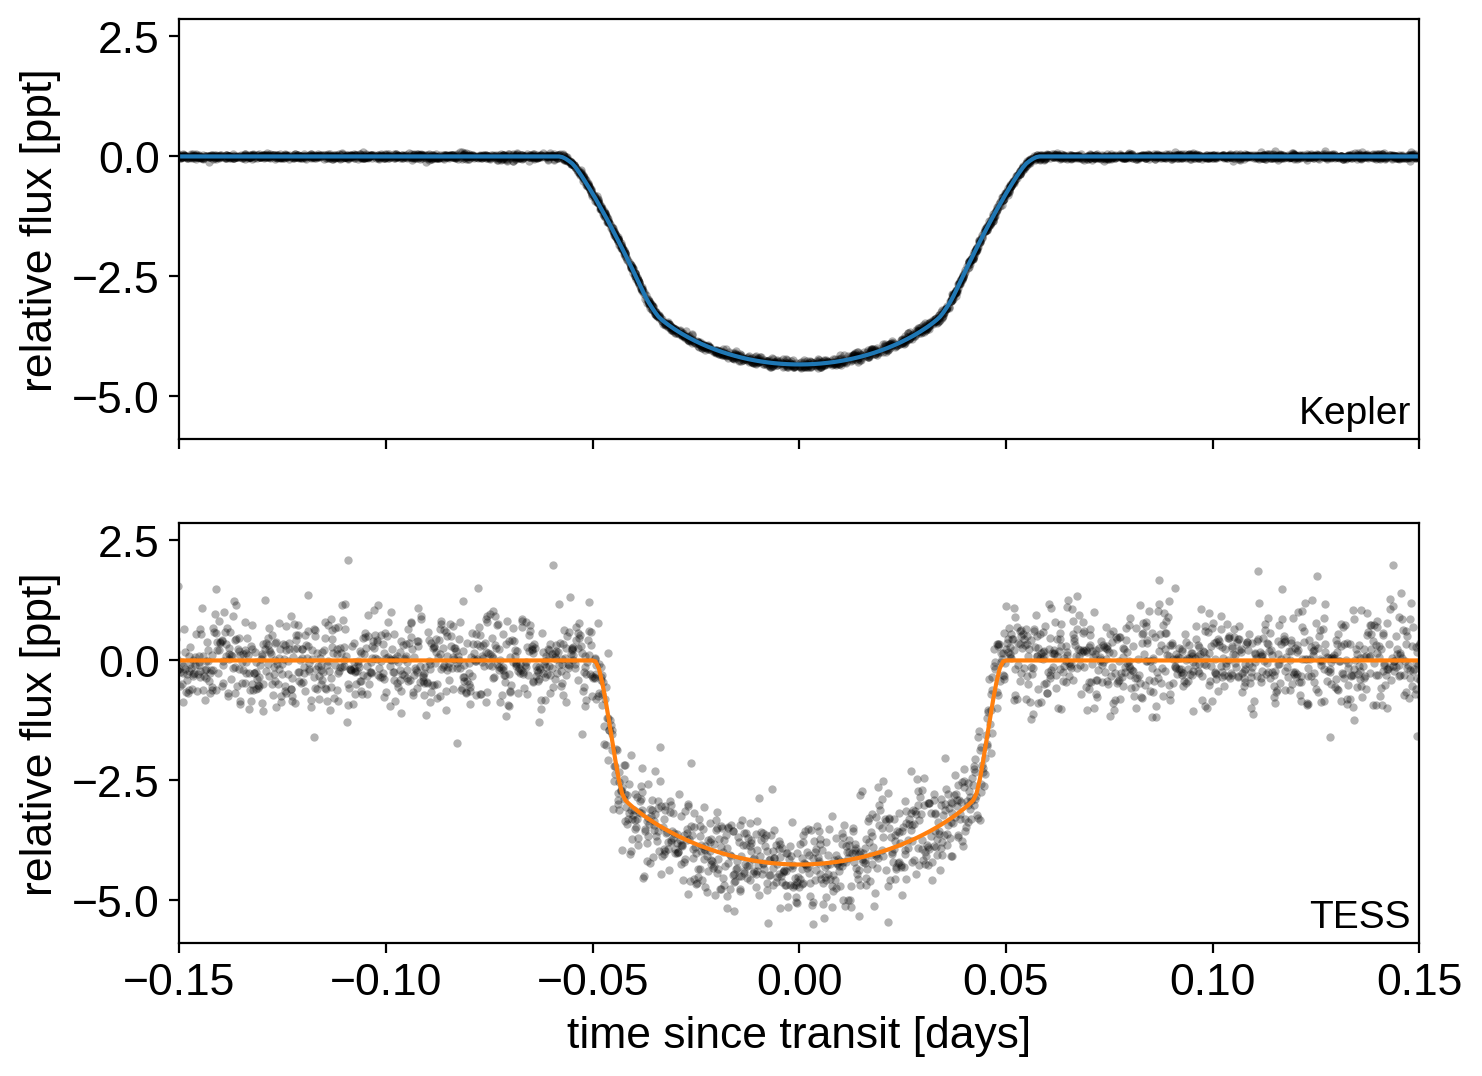

In [5]:
dt = np.linspace(-0.2, 0.2, 500)

with model:
    trends = xo.eval_in_model([gp_preds[k] for k in datasets], map_soln)
    phase_curves = xo.eval_in_model([lc_models[k](t0 + dt) for k in datasets], map_soln)

fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize=(8, 6))

for n, name in enumerate(datasets):
    ax = axes[n]

    x, y = datasets[name][:2]

    period = map_soln["period"]
    folded = (x - map_soln["t0"] + 0.5 * period) % period - 0.5 * period
    m = np.abs(folded) < 0.2
    ax.plot(
        folded[m],
        (y - trends[n] - map_soln[f"{name}_mean"])[m],
        ".k",
        alpha=0.3,
        mec="none",
    )
    ax.plot(dt, phase_curves[n] - map_soln[f"{name}_mean"], f"C{n}", label=name)
    ax.annotate(
        name,
        xy=(1, 0),
        xycoords="axes fraction",
        va="bottom",
        ha="right",
        xytext=(-3, 3),
        textcoords="offset points",
        fontsize=14,
    )

axes[-1].set_xlim(-0.15, 0.15)
axes[-1].set_xlabel("time since transit [days]")
for ax in axes:
    ax.set_ylabel("relative flux [ppt]")

Then we run the MCMC:

In [6]:
np.random.seed(11)
with model:
    trace = xo.sample(
        tune=3500, draws=3000, start=map_soln, chains=4, initial_accept=0.5
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [TESS_S_tot, TESS_sigma, TESS_approx_depth, TESS_u, TESS_mean, Kepler_S_tot, Kepler_sigma, Kepler_approx_depth, Kepler_u, Kepler_mean, ell, b, dur, t0, period]


Sampling 4 chains, 0 divergences:   0%|          | 0/26000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 3/26000 [00:00<14:54, 29.06draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 10/26000 [00:00<12:21, 35.05draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 17/26000 [00:00<10:33, 41.01draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 25/26000 [00:00<09:13, 46.91draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 33/26000 [00:00<08:15, 52.43draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 40/26000 [00:00<07:47, 55.55draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 46/26000 [00:07<2:36:35,  2.76draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 51/26000 [00:08<2:00:57,  3.58draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 55/26000 [00:14<5:00:30,  1.44draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 58/26000 [00:15<3:46:43,  1.91draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 60/26000 [00:15<2:51:22,  2.52draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 62/26000 [00:15<2:14:26,  3.22draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 64/26000 [00:22<8:39:39,  1.20s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 66/26000 [00:22<6:17:37,  1.14draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 67/26000 [00:22<4:38:37,  1.55draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 68/26000 [00:22<3:33:01,  2.03draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 70/26000 [00:28<9:00:16,  1.25s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 72/26000 [00:29<6:52:52,  1.05draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 74/26000 [00:29<5:09:45,  1.39draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 75/26000 [00:29<3:51:13,  1.87draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 77/26000 [00:29<2:48:57,  2.56draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 79/26000 [00:35<8:19:51,  1.16s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 81/26000 [00:36<6:25:39,  1.12draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 82/26000 [00:36<5:46:04,  1.25draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 84/26000 [00:36<4:09:19,  1.73draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 85/26000 [00:36<3:19:21,  2.17draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 86/26000 [00:42<14:14:06,  1.98s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 88/26000 [00:43<10:32:44,  1.47s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 89/26000 [00:43<9:05:16,  1.26s/draws] 

Sampling 4 chains, 0 divergences:   0%|          | 90/26000 [00:43<6:35:48,  1.09draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 92/26000 [00:44<4:44:09,  1.52draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 94/26000 [00:44<3:29:34,  2.06draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 96/26000 [00:49<8:12:09,  1.14s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 97/26000 [00:49<6:36:27,  1.09draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 98/26000 [00:50<4:51:42,  1.48draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 99/26000 [00:51<5:37:36,  1.28draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 100/26000 [00:51<4:10:24,  1.72draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 102/26000 [00:51<3:04:09,  2.34draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 103/26000 [00:56<13:15:09,  1.84s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 105/26000 [00:57<9:50:39,  1.37s/draws] 

Sampling 4 chains, 0 divergences:   0%|          | 106/26000 [00:58<9:28:21,  1.32s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 107/26000 [00:58<6:51:05,  1.05draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 109/26000 [00:58<4:55:50,  1.46draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 110/26000 [01:03<14:16:13,  1.98s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 111/26000 [01:03<10:13:14,  1.42s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 112/26000 [01:03<7:54:40,  1.10s/draws] 

Sampling 4 chains, 0 divergences:   0%|          | 114/26000 [01:05<7:04:36,  1.02draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 115/26000 [01:05<5:11:20,  1.39draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 116/26000 [01:05<3:52:13,  1.86draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 117/26000 [01:10<13:14:54,  1.84s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 118/26000 [01:10<9:30:18,  1.32s/draws] 

Sampling 4 chains, 0 divergences:   0%|          | 119/26000 [01:10<7:21:20,  1.02s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 120/26000 [01:10<5:22:50,  1.34draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 121/26000 [01:12<6:42:59,  1.07draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 123/26000 [01:12<4:57:57,  1.45draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 126/26000 [01:17<6:59:06,  1.03draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 127/26000 [01:17<5:49:09,  1.23draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 129/26000 [01:19<5:55:41,  1.21draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 131/26000 [01:24<9:16:15,  1.29s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 133/26000 [01:24<7:04:11,  1.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 134/26000 [01:26<8:39:21,  1.20s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 136/26000 [01:31<11:06:31,  1.55s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 137/26000 [01:31<8:00:29,  1.11s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 138/26000 [01:31<6:25:05,  1.12draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 139/26000 [01:31<4:43:30,  1.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 140/26000 [01:33<7:02:06,  1.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 142/26000 [01:33<5:02:34,  1.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 144/26000 [01:38<8:25:54,  1.17s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 146/26000 [01:38<6:27:30,  1.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 147/26000 [01:40<8:45:13,  1.22s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 150/26000 [01:40<6:12:21,  1.16draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 152/26000 [01:45<9:13:09,  1.28s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 153/26000 [01:45<7:09:12,  1.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 155/26000 [01:47<7:16:50,  1.01s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 158/26000 [01:47<5:10:28,  1.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 160/26000 [01:52<8:29:50,  1.18s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 161/26000 [01:52<6:25:05,  1.12draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 163/26000 [01:52<4:43:58,  1.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 164/26000 [01:54<7:38:31,  1.06s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 167/26000 [01:55<5:25:41,  1.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 169/26000 [01:59<8:47:40,  1.23s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 170/26000 [01:59<6:26:47,  1.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 172/26000 [02:00<4:51:36,  1.48draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 173/26000 [02:02<7:24:29,  1.03s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 176/26000 [02:02<5:17:05,  1.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 178/26000 [02:06<8:43:38,  1.22s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 179/26000 [02:07<6:34:24,  1.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 180/26000 [02:07<4:53:27,  1.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 181/26000 [02:07<3:39:17,  1.96draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 182/26000 [02:09<6:33:12,  1.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 185/26000 [02:13<7:51:49,  1.10s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 186/26000 [02:13<5:44:16,  1.25draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 187/26000 [02:14<4:48:05,  1.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 188/26000 [02:16<7:36:18,  1.06s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 191/26000 [02:16<5:26:28,  1.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 192/26000 [02:20<13:15:10,  1.85s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 193/26000 [02:20<9:30:35,  1.33s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 195/26000 [02:21<6:56:40,  1.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 197/26000 [02:23<7:12:03,  1.00s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 199/26000 [02:23<5:09:27,  1.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 202/26000 [02:27<6:46:34,  1.06draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 203/26000 [02:28<5:19:30,  1.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 205/26000 [02:30<6:13:51,  1.15draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 208/26000 [02:34<7:27:25,  1.04s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 209/26000 [02:34<5:27:07,  1.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 210/26000 [02:35<4:20:22,  1.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 212/26000 [02:35<3:10:45,  2.25draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 213/26000 [02:37<6:56:37,  1.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 216/26000 [02:41<8:00:57,  1.12s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 217/26000 [02:41<5:50:30,  1.23draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 218/26000 [02:42<4:36:43,  1.55draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 219/26000 [02:44<8:17:09,  1.16s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 221/26000 [02:44<5:55:05,  1.21draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 223/26000 [02:48<8:39:43,  1.21s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 224/26000 [02:48<6:17:42,  1.14draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 225/26000 [02:49<4:41:50,  1.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 226/26000 [02:51<8:47:42,  1.23s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 229/26000 [02:51<6:16:25,  1.14draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 230/26000 [02:55<13:05:30,  1.83s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 231/26000 [02:55<9:23:43,  1.31s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 233/26000 [02:56<6:41:34,  1.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 235/26000 [02:58<7:38:42,  1.07s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 237/26000 [02:58<5:28:07,  1.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 239/26000 [03:02<8:06:46,  1.13s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 241/26000 [03:03<5:51:09,  1.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 242/26000 [03:05<10:02:47,  1.40s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 243/26000 [03:05<7:16:10,  1.02s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 245/26000 [03:06<5:13:38,  1.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 246/26000 [03:09<11:42:37,  1.64s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 247/26000 [03:09<8:25:40,  1.18s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 249/26000 [03:10<6:04:24,  1.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 250/26000 [03:13<10:25:21,  1.46s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 251/26000 [03:13<7:31:38,  1.05s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 253/26000 [03:13<5:26:38,  1.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 254/26000 [03:16<11:37:06,  1.62s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 255/26000 [03:17<8:21:56,  1.17s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 257/26000 [03:17<6:01:50,  1.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 258/26000 [03:20<10:27:29,  1.46s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 259/26000 [03:20<7:33:15,  1.06s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 261/26000 [03:20<5:27:49,  1.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 262/26000 [03:23<11:34:14,  1.62s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 264/26000 [03:24<8:16:26,  1.16s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 266/26000 [03:27<9:03:10,  1.27s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 267/26000 [03:27<6:37:41,  1.08draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 270/26000 [03:31<7:16:51,  1.02s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 272/26000 [03:31<5:16:15,  1.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 274/26000 [03:34<7:01:48,  1.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 276/26000 [03:34<5:02:15,  1.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 278/26000 [03:38<7:26:07,  1.04s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 279/26000 [03:38<5:33:09,  1.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 280/26000 [03:38<4:10:30,  1.71draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 282/26000 [03:41<6:12:29,  1.15draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 283/26000 [03:41<4:34:49,  1.56draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 285/26000 [03:41<3:21:14,  2.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 286/26000 [03:45<10:03:19,  1.41s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 288/26000 [03:45<7:09:15,  1.00s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 290/26000 [03:48<8:25:33,  1.18s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 291/26000 [03:48<6:07:46,  1.17draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 293/26000 [03:48<4:24:28,  1.62draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 295/26000 [03:52<6:55:39,  1.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 298/26000 [03:55<7:15:19,  1.02s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 300/26000 [03:55<5:13:32,  1.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 302/26000 [03:55<3:46:31,  1.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 304/26000 [03:59<6:15:46,  1.14draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 307/26000 [04:02<6:57:33,  1.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 310/26000 [04:03<4:59:33,  1.43draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 311/26000 [04:06<10:24:39,  1.46s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 313/26000 [04:06<7:24:13,  1.04s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 315/26000 [04:10<8:58:45,  1.26s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 316/26000 [04:10<6:31:13,  1.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 317/26000 [04:10<4:48:02,  1.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 318/26000 [04:10<3:35:40,  1.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 319/26000 [04:13<9:02:54,  1.27s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 321/26000 [04:13<6:28:47,  1.10draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 323/26000 [04:17<8:22:57,  1.18s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 324/26000 [04:17<6:05:25,  1.17draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 325/26000 [04:17<4:40:53,  1.52draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 326/26000 [04:17<3:34:13,  2.00draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 327/26000 [04:20<8:45:45,  1.23s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 329/26000 [04:20<6:18:28,  1.13draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 330/26000 [04:24<12:00:42,  1.68s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 332/26000 [04:24<8:47:19,  1.23s/draws] 

Sampling 4 chains, 0 divergences:   1%|▏         | 333/26000 [04:24<6:23:04,  1.12draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 334/26000 [04:27<10:34:39,  1.48s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 336/26000 [04:31<11:22:29,  1.60s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 337/26000 [04:31<8:11:40,  1.15s/draws] 

Sampling 4 chains, 0 divergences:   1%|▏         | 338/26000 [04:31<6:22:34,  1.12draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 339/26000 [04:34<10:31:08,  1.48s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 341/26000 [04:34<7:28:44,  1.05s/draws] 

Sampling 4 chains, 0 divergences:   1%|▏         | 343/26000 [04:38<9:15:43,  1.30s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 344/26000 [04:38<6:43:06,  1.06draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 345/26000 [04:38<5:06:54,  1.39draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 346/26000 [04:41<9:42:21,  1.36s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 348/26000 [04:41<6:54:32,  1.03draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 350/26000 [04:45<8:56:27,  1.25s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 351/26000 [04:45<6:36:32,  1.08draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 354/26000 [04:48<6:42:04,  1.06draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 356/26000 [04:48<4:48:21,  1.48draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 358/26000 [04:52<7:38:01,  1.07s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 359/26000 [04:52<5:34:43,  1.28draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 361/26000 [04:52<4:01:17,  1.77draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 363/26000 [04:55<5:45:41,  1.24draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 364/26000 [04:55<4:15:50,  1.67draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 365/26000 [04:55<3:12:54,  2.21draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 366/26000 [04:59<10:36:50,  1.49s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 367/26000 [04:59<7:39:49,  1.08s/draws] 

Sampling 4 chains, 0 divergences:   1%|▏         | 369/26000 [05:00<5:34:07,  1.28draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 370/26000 [05:02<9:26:16,  1.33s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 371/26000 [05:02<6:50:11,  1.04draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 373/26000 [05:06<9:11:21,  1.29s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 374/26000 [05:07<6:40:00,  1.07draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 376/26000 [05:07<4:55:53,  1.44draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 377/26000 [05:09<8:39:53,  1.22s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 380/26000 [05:09<6:08:32,  1.16draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 382/26000 [05:14<8:58:08,  1.26s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 384/26000 [05:14<6:46:25,  1.05draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 385/26000 [05:16<9:10:44,  1.29s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 387/26000 [05:16<6:32:27,  1.09draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 388/26000 [05:17<4:58:59,  1.43draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 389/26000 [05:21<12:19:00,  1.73s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 390/26000 [05:21<9:36:32,  1.35s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 391/26000 [05:23<11:21:25,  1.60s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 392/26000 [05:23<8:10:53,  1.15s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 394/26000 [05:28<10:15:32,  1.44s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 396/26000 [05:28<7:40:31,  1.08s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 397/26000 [05:30<10:09:39,  1.43s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 400/26000 [05:35<10:11:13,  1.43s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 401/26000 [05:35<8:06:16,  1.14s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 403/26000 [05:37<8:05:39,  1.14s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 405/26000 [05:38<5:46:54,  1.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 407/26000 [05:38<4:30:33,  1.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 408/26000 [05:38<4:04:40,  1.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 409/26000 [05:42<9:53:13,  1.39s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 410/26000 [05:42<8:09:00,  1.15s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 411/26000 [05:42<5:56:28,  1.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 412/26000 [05:45<8:40:56,  1.22s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 413/26000 [05:45<7:48:23,  1.10s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 414/26000 [05:48<11:06:56,  1.56s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 415/26000 [05:48<8:00:42,  1.13s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 416/26000 [05:49<6:56:43,  1.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 417/26000 [05:49<6:27:57,  1.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 419/26000 [05:52<7:29:53,  1.06s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 421/26000 [05:54<7:36:31,  1.07s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 422/26000 [05:55<6:28:46,  1.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 423/26000 [05:56<5:59:27,  1.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 424/26000 [05:57<5:59:57,  1.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 425/26000 [06:01<14:32:31,  2.05s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 426/26000 [06:01<10:24:34,  1.47s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 427/26000 [06:02<8:12:35,  1.16s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 428/26000 [06:03<7:18:35,  1.03s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 429/26000 [06:04<6:55:27,  1.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 430/26000 [06:08<15:19:02,  2.16s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 431/26000 [06:09<11:38:41,  1.64s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 432/26000 [06:09<8:22:55,  1.18s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 433/26000 [06:10<7:21:11,  1.04s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 434/26000 [06:11<7:00:41,  1.01draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 436/26000 [06:11<5:01:31,  1.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 437/26000 [06:15<13:33:28,  1.91s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 438/26000 [06:16<9:50:14,  1.39s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 439/26000 [06:16<7:41:45,  1.08s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 440/26000 [06:18<8:54:32,  1.25s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 442/26000 [06:18<6:21:08,  1.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 443/26000 [06:19<7:16:53,  1.03s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 444/26000 [06:19<5:58:54,  1.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 445/26000 [06:20<5:06:56,  1.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 446/26000 [06:23<9:58:23,  1.41s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 447/26000 [06:24<8:57:13,  1.26s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 448/26000 [06:25<8:00:32,  1.13s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 449/26000 [06:26<7:34:44,  1.07s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 450/26000 [06:26<5:32:12,  1.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 451/26000 [06:26<4:33:34,  1.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 452/26000 [06:27<4:45:14,  1.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 453/26000 [06:29<8:53:08,  1.25s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 454/26000 [06:30<7:19:05,  1.03s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 455/26000 [06:32<8:56:40,  1.26s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 457/26000 [06:32<6:48:11,  1.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 458/26000 [06:32<5:03:05,  1.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 459/26000 [06:33<4:18:18,  1.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 460/26000 [06:33<4:52:14,  1.46draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 462/26000 [06:34<3:31:31,  2.01draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 463/26000 [06:34<3:23:47,  2.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 464/26000 [06:36<6:42:45,  1.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 465/26000 [06:37<6:13:04,  1.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 466/26000 [06:37<5:22:07,  1.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 467/26000 [06:37<4:07:09,  1.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 468/26000 [06:38<3:06:52,  2.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 469/26000 [06:38<4:00:37,  1.77draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 470/26000 [06:39<3:08:57,  2.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 471/26000 [06:40<4:36:58,  1.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 473/26000 [06:40<3:28:50,  2.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 474/26000 [06:43<9:08:51,  1.29s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 475/26000 [06:43<6:45:22,  1.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 476/26000 [06:46<9:33:28,  1.35s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 477/26000 [06:46<7:09:00,  1.01s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 478/26000 [06:47<6:50:41,  1.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 479/26000 [06:47<5:01:17,  1.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 480/26000 [06:47<4:02:31,  1.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 481/26000 [06:48<6:05:18,  1.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 482/26000 [06:49<4:57:56,  1.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 483/26000 [06:49<4:24:13,  1.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 484/26000 [06:50<4:28:57,  1.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 485/26000 [06:50<3:36:18,  1.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 486/26000 [06:50<2:52:26,  2.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 487/26000 [06:52<4:48:04,  1.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 488/26000 [06:52<3:56:35,  1.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 489/26000 [06:53<4:24:44,  1.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 490/26000 [06:54<5:09:26,  1.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 491/26000 [06:55<5:34:48,  1.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 492/26000 [06:55<4:14:14,  1.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 494/26000 [06:55<3:04:51,  2.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 495/26000 [06:55<2:31:50,  2.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 496/26000 [06:57<5:04:56,  1.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 497/26000 [06:57<4:47:30,  1.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 498/26000 [06:59<6:15:32,  1.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 499/26000 [06:59<5:18:03,  1.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 500/26000 [06:59<3:56:40,  1.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 501/26000 [07:00<3:54:53,  1.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 502/26000 [07:00<3:22:12,  2.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 504/26000 [07:01<3:43:43,  1.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 505/26000 [07:02<3:32:29,  2.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 507/26000 [07:02<2:40:55,  2.64draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 508/26000 [07:04<5:40:44,  1.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 509/26000 [07:04<5:06:07,  1.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 510/26000 [07:04<4:12:45,  1.68draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 511/26000 [07:05<3:30:58,  2.01draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 513/26000 [07:05<2:36:42,  2.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 514/26000 [07:05<2:26:39,  2.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 515/26000 [07:05<2:10:57,  3.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 516/26000 [07:06<3:38:02,  1.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 518/26000 [07:07<2:45:05,  2.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 519/26000 [07:07<2:33:26,  2.77draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 520/26000 [07:07<2:01:05,  3.51draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 521/26000 [07:07<1:59:46,  3.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 522/26000 [07:07<1:43:53,  4.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 523/26000 [07:08<1:48:28,  3.91draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 524/26000 [07:08<1:30:02,  4.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 525/26000 [07:08<1:59:08,  3.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 527/26000 [07:08<1:37:26,  4.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 528/26000 [07:09<1:36:00,  4.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 530/26000 [07:10<3:00:49,  2.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 531/26000 [07:11<3:01:06,  2.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 532/26000 [07:12<3:29:09,  2.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 533/26000 [07:12<3:09:23,  2.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 534/26000 [07:12<3:08:35,  2.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 536/26000 [07:13<2:27:56,  2.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 538/26000 [07:13<2:14:40,  3.15draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 539/26000 [07:14<2:57:25,  2.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 540/26000 [07:14<2:49:32,  2.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 541/26000 [07:14<2:32:55,  2.77draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 542/26000 [07:14<2:07:48,  3.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 544/26000 [07:15<2:02:18,  3.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 545/26000 [07:15<2:20:55,  3.01draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 546/26000 [07:16<3:29:44,  2.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 547/26000 [07:17<3:23:27,  2.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 548/26000 [07:17<3:05:30,  2.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 550/26000 [07:18<3:11:40,  2.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 551/26000 [07:18<2:41:56,  2.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 552/26000 [07:18<2:07:15,  3.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 553/26000 [07:19<1:56:50,  3.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 554/26000 [07:19<2:44:59,  2.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 555/26000 [07:20<2:30:14,  2.82draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 556/26000 [07:20<2:12:53,  3.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 558/26000 [07:20<2:06:02,  3.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 559/26000 [07:20<1:56:01,  3.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 560/26000 [07:21<1:38:35,  4.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 561/26000 [07:21<1:29:49,  4.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 562/26000 [07:21<1:16:45,  5.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 563/26000 [07:22<2:44:32,  2.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 564/26000 [07:23<5:04:14,  1.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 565/26000 [07:24<4:28:10,  1.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 566/26000 [07:24<4:02:55,  1.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 567/26000 [07:24<3:17:38,  2.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 568/26000 [07:25<4:08:31,  1.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 569/26000 [07:26<3:38:42,  1.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 570/26000 [07:26<2:53:48,  2.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 571/26000 [07:26<2:22:24,  2.98draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 572/26000 [07:28<5:24:10,  1.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 573/26000 [07:28<4:07:37,  1.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 574/26000 [07:28<3:28:03,  2.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 575/26000 [07:28<2:39:31,  2.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 576/26000 [07:29<3:42:35,  1.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 578/26000 [07:29<3:03:43,  2.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 579/26000 [07:30<3:28:17,  2.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 580/26000 [07:31<3:49:02,  1.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 581/26000 [07:33<6:40:32,  1.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 582/26000 [07:33<5:03:29,  1.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 583/26000 [07:33<4:27:48,  1.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 584/26000 [07:33<3:21:23,  2.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 585/26000 [07:34<2:34:48,  2.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 586/26000 [07:34<2:02:11,  3.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 588/26000 [07:34<1:48:00,  3.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 591/26000 [07:34<1:21:24,  5.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 593/26000 [07:34<1:21:15,  5.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 596/26000 [07:35<1:06:07,  6.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 598/26000 [07:35<1:31:18,  4.64draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 599/26000 [07:36<1:25:15,  4.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 601/26000 [07:36<1:10:13,  6.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 602/26000 [07:36<1:37:36,  4.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 604/26000 [07:36<1:17:41,  5.45draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 605/26000 [07:36<1:10:31,  6.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 606/26000 [07:37<1:09:36,  6.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 608/26000 [07:37<57:59,  7.30draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 611/26000 [07:37<58:50,  7.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 612/26000 [07:37<1:06:49,  6.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 614/26000 [07:38<1:07:41,  6.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 615/26000 [07:38<1:12:23,  5.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 616/26000 [07:38<1:58:48,  3.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 617/26000 [07:39<1:40:54,  4.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 619/26000 [07:39<1:38:29,  4.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 620/26000 [07:40<2:32:44,  2.77draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 621/26000 [07:40<2:13:52,  3.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 623/26000 [07:40<1:48:06,  3.91draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 624/26000 [07:40<1:43:34,  4.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 625/26000 [07:41<1:40:25,  4.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 626/26000 [07:41<1:34:51,  4.46draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 627/26000 [07:41<1:37:27,  4.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 628/26000 [07:41<2:03:48,  3.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 630/26000 [07:42<1:40:36,  4.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 631/26000 [07:42<2:06:11,  3.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 632/26000 [07:42<2:03:41,  3.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 633/26000 [07:43<1:47:00,  3.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 635/26000 [07:43<1:32:10,  4.59draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 636/26000 [07:43<1:27:08,  4.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 637/26000 [07:43<1:29:04,  4.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 639/26000 [07:43<1:16:21,  5.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 641/26000 [07:44<1:02:07,  6.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 642/26000 [07:44<1:10:58,  5.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 644/26000 [07:44<1:17:04,  5.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 646/26000 [07:44<1:04:48,  6.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▎         | 650/26000 [07:44<48:50,  8.65draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 652/26000 [07:45<1:38:30,  4.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 654/26000 [07:46<1:31:28,  4.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 656/26000 [07:46<1:31:38,  4.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 658/26000 [07:46<1:18:00,  5.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 660/26000 [07:47<1:08:28,  6.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 661/26000 [07:47<1:15:44,  5.58draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 663/26000 [07:47<1:06:57,  6.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 665/26000 [07:47<55:36,  7.59draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 666/26000 [07:48<1:06:38,  6.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 668/26000 [07:48<59:06,  7.14draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 670/26000 [07:48<51:38,  8.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 672/26000 [07:48<53:15,  7.93draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 674/26000 [07:48<45:56,  9.19draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 676/26000 [07:48<40:37, 10.39draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 678/26000 [07:49<1:08:30,  6.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 679/26000 [07:49<1:43:42,  4.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 680/26000 [07:50<1:40:17,  4.21draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 682/26000 [07:50<1:27:31,  4.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 684/26000 [07:50<1:11:11,  5.93draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 686/26000 [07:51<1:17:09,  5.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 687/26000 [07:51<1:24:46,  4.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 688/26000 [07:51<1:15:56,  5.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 689/26000 [07:51<1:09:59,  6.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 691/26000 [07:51<59:26,  7.10draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 692/26000 [07:51<1:08:59,  6.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 694/26000 [07:52<55:17,  7.63draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 696/26000 [07:52<52:34,  8.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 699/26000 [07:52<46:03,  9.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 701/26000 [07:52<46:07,  9.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 703/26000 [07:52<48:42,  8.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 704/26000 [07:53<47:48,  8.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 706/26000 [07:53<43:19,  9.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 708/26000 [07:53<51:13,  8.23draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 710/26000 [07:53<42:34,  9.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 712/26000 [07:53<43:37,  9.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 714/26000 [07:54<37:24, 11.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 716/26000 [07:54<53:29,  7.88draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 718/26000 [07:54<51:08,  8.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 720/26000 [07:54<50:09,  8.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 721/26000 [07:55<1:00:25,  6.97draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 722/26000 [07:55<56:02,  7.52draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 723/26000 [07:55<52:58,  7.95draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 726/26000 [07:55<47:05,  8.94draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 727/26000 [07:55<1:06:56,  6.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 728/26000 [07:55<1:04:33,  6.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 730/26000 [07:56<1:00:46,  6.93draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 733/26000 [07:56<50:14,  8.38draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 735/26000 [07:56<53:58,  7.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 737/26000 [07:56<46:18,  9.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 739/26000 [07:57<46:04,  9.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 741/26000 [07:57<45:37,  9.23draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 744/26000 [07:57<41:13, 10.21draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 746/26000 [07:57<42:38,  9.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 748/26000 [07:58<57:26,  7.33draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 749/26000 [07:58<54:00,  7.79draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 750/26000 [07:58<50:36,  8.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 751/26000 [07:59<2:13:28,  3.15draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 753/26000 [07:59<1:52:47,  3.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 754/26000 [07:59<1:34:02,  4.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 756/26000 [07:59<1:19:42,  5.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 758/26000 [07:59<1:02:42,  6.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 760/26000 [08:00<56:37,  7.43draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 762/26000 [08:00<58:25,  7.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 764/26000 [08:00<54:33,  7.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 765/26000 [08:00<51:49,  8.12draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 767/26000 [08:00<44:47,  9.39draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 769/26000 [08:01<50:26,  8.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 771/26000 [08:01<43:56,  9.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 773/26000 [08:01<46:22,  9.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 775/26000 [08:01<55:39,  7.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 777/26000 [08:01<45:48,  9.18draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 779/26000 [08:02<45:43,  9.19draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 781/26000 [08:02<43:45,  9.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 783/26000 [08:02<39:20, 10.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 785/26000 [08:02<37:45, 11.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 787/26000 [08:02<35:01, 12.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 789/26000 [08:03<38:11, 11.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 791/26000 [08:03<33:37, 12.49draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 794/26000 [08:03<31:26, 13.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 796/26000 [08:03<28:52, 14.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 798/26000 [08:03<29:01, 14.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 800/26000 [08:03<34:06, 12.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 802/26000 [08:04<37:41, 11.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 804/26000 [08:04<54:03,  7.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 806/26000 [08:04<51:46,  8.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 808/26000 [08:04<50:03,  8.39draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 809/26000 [08:05<48:47,  8.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 810/26000 [08:05<59:52,  7.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 812/26000 [08:05<56:16,  7.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 814/26000 [08:05<52:29,  8.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 816/26000 [08:05<51:11,  8.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 818/26000 [08:06<48:44,  8.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 820/26000 [08:06<49:06,  8.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 822/26000 [08:06<52:07,  8.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 823/26000 [08:06<56:45,  7.39draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 824/26000 [08:06<1:03:52,  6.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 827/26000 [08:07<54:59,  7.63draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 829/26000 [08:07<50:13,  8.35draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 832/26000 [08:07<39:40, 10.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 834/26000 [08:07<39:42, 10.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 836/26000 [08:07<41:24, 10.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 838/26000 [08:08<54:03,  7.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 840/26000 [08:08<1:07:07,  6.25draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 842/26000 [08:09<1:12:49,  5.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 844/26000 [08:09<1:07:37,  6.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 845/26000 [08:09<1:09:15,  6.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 847/26000 [08:09<1:02:18,  6.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 850/26000 [08:10<1:02:01,  6.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 853/26000 [08:10<48:00,  8.73draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 855/26000 [08:10<54:07,  7.74draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 857/26000 [08:11<58:34,  7.15draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 858/26000 [08:11<54:00,  7.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 859/26000 [08:11<51:27,  8.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 861/26000 [08:11<43:22,  9.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 864/26000 [08:11<42:26,  9.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 866/26000 [08:11<39:10, 10.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 869/26000 [08:12<35:51, 11.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 871/26000 [08:12<40:02, 10.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 873/26000 [08:12<41:52, 10.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 875/26000 [08:12<42:59,  9.74draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 878/26000 [08:12<40:14, 10.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 880/26000 [08:13<41:45, 10.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 882/26000 [08:13<43:44,  9.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 883/26000 [08:13<54:42,  7.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 888/26000 [08:13<41:44, 10.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 890/26000 [08:14<1:15:47,  5.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 893/26000 [08:14<58:48,  7.12draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 895/26000 [08:14<54:59,  7.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 897/26000 [08:14<47:48,  8.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 899/26000 [08:15<47:14,  8.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 901/26000 [08:15<40:21, 10.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 903/26000 [08:15<52:42,  7.94draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 905/26000 [08:16<57:27,  7.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 907/26000 [08:16<49:32,  8.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 910/26000 [08:16<48:13,  8.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 912/26000 [08:16<43:29,  9.61draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 914/26000 [08:16<41:08, 10.16draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 916/26000 [08:16<35:35, 11.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 918/26000 [08:17<31:43, 13.17draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 920/26000 [08:17<29:01, 14.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 922/26000 [08:17<28:38, 14.60draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 924/26000 [08:17<38:51, 10.76draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 926/26000 [08:17<44:16,  9.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 928/26000 [08:18<41:20, 10.11draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 930/26000 [08:18<36:50, 11.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 932/26000 [08:18<32:27, 12.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 934/26000 [08:18<43:16,  9.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 936/26000 [08:19<57:36,  7.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 937/26000 [08:19<54:03,  7.73draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 939/26000 [08:19<44:41,  9.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 941/26000 [08:19<38:08, 10.95draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 943/26000 [08:19<39:01, 10.70draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 945/26000 [08:19<34:06, 12.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 947/26000 [08:19<43:54,  9.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 949/26000 [08:20<40:20, 10.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 951/26000 [08:20<45:51,  9.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 953/26000 [08:20<41:01, 10.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 955/26000 [08:20<38:58, 10.71draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 957/26000 [08:20<34:08, 12.23draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 959/26000 [08:20<34:09, 12.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 961/26000 [08:21<41:44, 10.00draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 963/26000 [08:21<52:23,  7.96draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 964/26000 [08:21<1:10:49,  5.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 965/26000 [08:22<1:10:05,  5.95draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 967/26000 [08:22<1:06:10,  6.30draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 969/26000 [08:22<56:36,  7.37draws/s]  

Sampling 4 chains, 0 divergences:   4%|▎         | 972/26000 [08:22<44:10,  9.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 974/26000 [08:22<41:13, 10.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 977/26000 [08:22<35:42, 11.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 979/26000 [08:23<52:18,  7.97draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 981/26000 [08:23<44:57,  9.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 983/26000 [08:23<38:28, 10.84draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 985/26000 [08:23<40:34, 10.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 987/26000 [08:24<40:20, 10.33draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 990/26000 [08:24<33:43, 12.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 992/26000 [08:24<42:42,  9.76draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 995/26000 [08:24<36:25, 11.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 997/26000 [08:24<43:02,  9.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 999/26000 [08:25<37:00, 11.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1001/26000 [08:25<32:44, 12.73draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1003/26000 [08:25<32:24, 12.85draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1006/26000 [08:25<30:04, 13.85draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1008/26000 [08:25<37:07, 11.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1010/26000 [08:25<37:52, 11.00draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1013/26000 [08:26<35:11, 11.84draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1015/26000 [08:26<38:17, 10.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1018/26000 [08:26<35:52, 11.61draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1020/26000 [08:26<40:46, 10.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1022/26000 [08:27<42:04,  9.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1025/26000 [08:27<33:56, 12.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1027/26000 [08:27<35:34, 11.70draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1029/26000 [08:27<31:41, 13.13draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1031/26000 [08:27<28:59, 14.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1034/26000 [08:27<24:48, 16.77draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1036/26000 [08:27<24:10, 17.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1038/26000 [08:27<25:24, 16.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1040/26000 [08:28<36:33, 11.38draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1042/26000 [08:28<39:10, 10.62draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1044/26000 [08:28<35:47, 11.62draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1046/26000 [08:28<37:03, 11.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1048/26000 [08:28<39:35, 10.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1050/26000 [08:29<41:19, 10.06draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1052/26000 [08:29<39:09, 10.62draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1055/26000 [08:29<33:58, 12.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1057/26000 [08:29<30:33, 13.60draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1059/26000 [08:29<31:59, 12.99draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1062/26000 [08:29<31:28, 13.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1064/26000 [08:30<39:01, 10.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1066/26000 [08:30<37:31, 11.08draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1070/26000 [08:30<34:46, 11.95draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1072/26000 [08:30<34:32, 12.03draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1074/26000 [08:30<30:59, 13.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1076/26000 [08:31<32:47, 12.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1078/26000 [08:31<35:42, 11.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1080/26000 [08:31<38:37, 10.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1082/26000 [08:31<39:35, 10.49draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1086/26000 [08:31<33:20, 12.46draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1089/26000 [08:32<33:53, 12.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1092/26000 [08:32<33:36, 12.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1094/26000 [08:32<47:17,  8.78draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1097/26000 [08:33<43:25,  9.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1100/26000 [08:33<38:11, 10.86draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1102/26000 [08:33<41:59,  9.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1105/26000 [08:33<37:18, 11.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1107/26000 [08:33<32:56, 12.60draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1109/26000 [08:33<33:12, 12.49draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1111/26000 [08:34<33:25, 12.41draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1114/26000 [08:34<34:21, 12.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1116/26000 [08:34<38:00, 10.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1118/26000 [08:34<40:07, 10.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1120/26000 [08:35<39:51, 10.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1123/26000 [08:35<37:40, 11.00draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1125/26000 [08:35<33:37, 12.33draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1128/26000 [08:35<27:53, 14.86draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1130/26000 [08:35<31:30, 13.16draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1132/26000 [08:35<30:34, 13.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1134/26000 [08:36<34:51, 11.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1137/26000 [08:36<28:55, 14.33draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1139/26000 [08:36<34:05, 12.15draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1141/26000 [08:36<37:29, 11.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1143/26000 [08:36<39:52, 10.39draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1145/26000 [08:37<41:35,  9.96draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1148/26000 [08:37<34:04, 12.15draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1150/26000 [08:37<41:58,  9.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1153/26000 [08:37<35:05, 11.80draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1155/26000 [08:37<42:55,  9.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1157/26000 [08:38<39:03, 10.60draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1161/26000 [08:38<34:10, 12.11draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1164/26000 [08:38<33:04, 12.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1167/26000 [08:38<31:21, 13.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1169/26000 [08:38<35:21, 11.70draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1173/26000 [08:39<31:28, 13.15draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1176/26000 [08:39<27:49, 14.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1178/26000 [08:39<26:18, 15.73draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1180/26000 [08:39<32:01, 12.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1182/26000 [08:39<33:34, 12.32draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1184/26000 [08:39<32:47, 12.61draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1186/26000 [08:40<36:36, 11.29draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1188/26000 [08:40<32:27, 12.74draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1191/26000 [08:40<29:41, 13.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1194/26000 [08:40<29:43, 13.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1198/26000 [08:40<27:30, 15.03draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1200/26000 [08:41<32:39, 12.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1204/26000 [08:41<28:10, 14.67draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1207/26000 [08:41<28:47, 14.36draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1210/26000 [08:41<29:14, 14.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1214/26000 [08:41<27:16, 15.14draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1217/26000 [08:42<24:47, 16.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1219/26000 [08:42<24:22, 16.94draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1221/26000 [08:42<27:07, 15.23draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1223/26000 [08:42<29:04, 14.20draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1225/26000 [08:42<38:58, 10.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1227/26000 [08:42<34:04, 12.12draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1229/26000 [08:42<30:39, 13.46draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1231/26000 [08:43<29:58, 13.77draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1234/26000 [08:43<31:44, 13.00draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1236/26000 [08:43<33:18, 12.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1238/26000 [08:43<36:57, 11.17draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1241/26000 [08:43<34:57, 11.80draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1246/26000 [08:44<30:34, 13.49draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1248/26000 [08:44<34:48, 11.85draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1251/26000 [08:44<33:19, 12.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1253/26000 [08:44<36:22, 11.34draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1257/26000 [08:45<32:08, 12.83draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1259/26000 [08:45<34:16, 12.03draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1261/26000 [08:45<30:13, 13.64draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1263/26000 [08:45<34:43, 11.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1265/26000 [08:45<31:34, 13.06draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1267/26000 [08:45<35:05, 11.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1269/26000 [08:46<31:25, 13.12draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1271/26000 [08:46<29:15, 14.08draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1273/26000 [08:46<33:07, 12.44draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1275/26000 [08:46<30:27, 13.53draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1277/26000 [08:46<28:31, 14.45draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1279/26000 [08:46<26:20, 15.64draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1282/26000 [08:46<27:30, 14.97draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1284/26000 [08:47<29:34, 13.93draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1286/26000 [08:47<34:09, 12.06draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1288/26000 [08:47<32:17, 12.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1290/26000 [08:47<31:05, 13.25draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1294/26000 [08:47<25:09, 16.36draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1297/26000 [08:47<29:44, 13.85draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1299/26000 [08:48<29:45, 13.84draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1302/26000 [08:48<26:02, 15.81draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1305/26000 [08:48<24:20, 16.90draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1308/26000 [08:48<26:30, 15.52draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1310/26000 [08:48<31:54, 12.89draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1312/26000 [08:48<30:42, 13.40draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1314/26000 [08:49<29:50, 13.79draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1316/26000 [08:49<39:13, 10.49draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1318/26000 [08:49<35:48, 11.49draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1320/26000 [08:49<38:26, 10.70draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1323/26000 [08:49<31:27, 13.07draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1325/26000 [08:49<28:45, 14.30draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1327/26000 [08:50<26:53, 15.29draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1329/26000 [08:50<32:21, 12.71draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1331/26000 [08:50<29:27, 13.96draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1333/26000 [08:50<33:23, 12.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1335/26000 [08:50<30:53, 13.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1337/26000 [08:50<32:26, 12.67draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1340/26000 [08:51<29:23, 13.98draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1342/26000 [08:51<38:55, 10.56draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1344/26000 [08:51<35:26, 11.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1346/26000 [08:51<51:34,  7.97draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1349/26000 [08:52<40:40, 10.10draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1351/26000 [08:52<48:16,  8.51draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1353/26000 [08:52<47:50,  8.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1355/26000 [08:52<46:05,  8.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1358/26000 [08:53<41:09,  9.98draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1360/26000 [08:53<42:13,  9.72draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1363/26000 [08:53<34:00, 12.07draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1365/26000 [08:53<35:29, 11.57draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1367/26000 [08:53<34:51, 11.78draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1369/26000 [08:53<37:49, 10.85draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1371/26000 [08:54<41:17,  9.94draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1373/26000 [08:54<40:32, 10.12draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1377/26000 [08:54<33:16, 12.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1379/26000 [08:54<32:00, 12.82draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1381/26000 [08:54<34:02, 12.06draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1383/26000 [08:55<38:49, 10.57draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1385/26000 [08:55<35:39, 11.51draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1388/26000 [08:55<29:25, 13.94draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1390/26000 [08:55<32:04, 12.79draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1393/26000 [08:55<26:53, 15.25draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1395/26000 [08:55<34:26, 11.90draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1397/26000 [08:56<33:25, 12.27draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1401/26000 [08:56<30:53, 13.27draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1403/26000 [08:56<31:14, 13.12draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1407/26000 [08:56<28:36, 14.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1411/26000 [08:56<26:45, 15.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1415/26000 [08:57<27:57, 14.65draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1417/26000 [08:57<27:59, 14.64draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1420/26000 [08:57<28:34, 14.34draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1422/26000 [08:57<26:45, 15.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1424/26000 [08:57<28:10, 14.54draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1426/26000 [08:58<33:02, 12.40draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1428/26000 [08:58<34:06, 12.00draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1430/26000 [08:58<37:51, 10.82draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1432/26000 [08:58<32:43, 12.51draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1434/26000 [08:58<31:37, 12.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1436/26000 [08:58<33:37, 12.17draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1439/26000 [08:59<32:28, 12.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1443/26000 [08:59<29:27, 13.89draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1446/26000 [08:59<25:06, 16.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1448/26000 [08:59<24:17, 16.85draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1450/26000 [08:59<30:28, 13.42draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1452/26000 [08:59<34:54, 11.72draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1454/26000 [09:00<51:10,  7.99draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1459/26000 [09:00<39:08, 10.45draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1462/26000 [09:00<39:46, 10.28draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1465/26000 [09:01<36:50, 11.10draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1468/26000 [09:01<30:18, 13.49draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1470/26000 [09:01<35:30, 11.51draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1472/26000 [09:01<33:08, 12.33draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1475/26000 [09:01<32:02, 12.76draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1477/26000 [09:01<35:41, 11.45draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1480/26000 [09:02<33:48, 12.09draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1483/26000 [09:02<32:31, 12.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1487/26000 [09:02<28:39, 14.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1489/26000 [09:02<26:47, 15.24draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1491/26000 [09:03<45:00,  9.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1493/26000 [09:03<45:34,  8.96draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1495/26000 [09:03<45:23,  9.00draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1497/26000 [09:03<45:15,  9.02draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1499/26000 [09:03<41:47,  9.77draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1501/26000 [09:04<39:20, 10.38draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1504/26000 [09:04<45:13,  9.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1507/26000 [09:04<47:17,  8.63draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1510/26000 [09:05<38:26, 10.62draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1512/26000 [09:05<35:39, 11.44draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1514/26000 [09:05<35:02, 11.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1518/26000 [09:05<32:56, 12.39draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1520/26000 [09:05<33:47, 12.07draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1523/26000 [09:06<41:03,  9.93draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1527/26000 [09:06<35:29, 11.49draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1531/26000 [09:06<31:34, 12.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1533/26000 [09:06<35:34, 11.46draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1535/26000 [09:07<41:31,  9.82draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1537/26000 [09:07<40:35, 10.05draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1539/26000 [09:07<43:50,  9.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1541/26000 [09:07<41:41,  9.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1543/26000 [09:07<38:19, 10.63draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1547/26000 [09:08<31:21, 13.00draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1549/26000 [09:08<35:09, 11.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1551/26000 [09:08<31:13, 13.05draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1553/26000 [09:08<33:22, 12.21draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1555/26000 [09:08<40:02, 10.18draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1557/26000 [09:09<41:21,  9.85draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1559/26000 [09:09<40:16, 10.11draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1561/26000 [09:09<40:21, 10.09draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1563/26000 [09:09<41:40,  9.77draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1566/26000 [09:09<38:07, 10.68draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1569/26000 [09:10<35:39, 11.42draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1572/26000 [09:10<36:10, 11.25draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1574/26000 [09:10<35:18, 11.53draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1576/26000 [09:10<37:54, 10.74draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1578/26000 [09:11<39:43, 10.24draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1581/26000 [09:11<32:30, 12.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1583/26000 [09:11<36:09, 11.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1586/26000 [09:11<34:14, 11.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1588/26000 [09:11<34:02, 11.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1590/26000 [09:11<32:48, 12.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1592/26000 [09:12<36:08, 11.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1595/26000 [09:12<30:36, 13.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1597/26000 [09:12<31:28, 12.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1599/26000 [09:12<30:21, 13.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1601/26000 [09:12<34:26, 11.81draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1603/26000 [09:13<42:34,  9.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1605/26000 [09:13<37:43, 10.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1607/26000 [09:13<35:12, 11.54draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1609/26000 [09:13<42:27,  9.57draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1611/26000 [09:13<43:00,  9.45draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1614/26000 [09:14<36:44, 11.06draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1616/26000 [09:14<33:25, 12.16draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1618/26000 [09:14<36:45, 11.05draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1620/26000 [09:14<39:06, 10.39draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1622/26000 [09:14<45:56,  8.84draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1624/26000 [09:15<40:18, 10.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1626/26000 [09:15<41:32,  9.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1628/26000 [09:15<37:22, 10.87draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1630/26000 [09:15<36:07, 11.24draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1633/26000 [09:15<29:42, 13.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1635/26000 [09:15<30:48, 13.18draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1637/26000 [09:16<34:46, 11.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1639/26000 [09:16<37:36, 10.79draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1641/26000 [09:16<39:37, 10.25draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1645/26000 [09:16<34:22, 11.81draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1647/26000 [09:16<40:37,  9.99draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1649/26000 [09:17<38:22, 10.57draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1651/26000 [09:17<40:09, 10.11draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1654/26000 [09:17<35:50, 11.32draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1657/26000 [09:17<33:56, 11.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1659/26000 [09:17<37:00, 10.96draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1663/26000 [09:18<32:31, 12.47draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1665/26000 [09:18<37:43, 10.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1667/26000 [09:18<37:57, 10.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1670/26000 [09:18<35:23, 11.46draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1674/26000 [09:19<31:28, 12.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1676/26000 [09:19<36:57, 10.97draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1678/26000 [09:19<39:07, 10.36draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1680/26000 [09:19<38:44, 10.46draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1682/26000 [09:19<40:39,  9.97draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1684/26000 [09:20<41:21,  9.80draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1687/26000 [09:20<37:45, 10.73draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1690/26000 [09:20<35:15, 11.49draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1693/26000 [09:20<33:28, 12.10draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1696/26000 [09:21<32:15, 12.56draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1699/26000 [09:21<31:23, 12.90draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1702/26000 [09:21<30:47, 13.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1705/26000 [09:21<30:22, 13.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1709/26000 [09:21<28:17, 14.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1711/26000 [09:22<32:10, 12.58draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1714/26000 [09:22<31:59, 12.65draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1717/26000 [09:22<26:50, 15.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1719/26000 [09:22<37:33, 10.77draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1721/26000 [09:22<34:02, 11.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1723/26000 [09:23<37:08, 10.90draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1725/26000 [09:23<36:15, 11.16draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1727/26000 [09:23<35:03, 11.54draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1729/26000 [09:23<36:12, 11.17draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1732/26000 [09:23<35:17, 11.46draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1734/26000 [09:23<31:21, 12.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1736/26000 [09:24<31:45, 12.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1738/26000 [09:24<32:16, 12.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1740/26000 [09:24<29:13, 13.83draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1742/26000 [09:24<27:05, 14.92draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1744/26000 [09:24<32:12, 12.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1746/26000 [09:25<48:59,  8.25draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1748/26000 [09:25<45:29,  8.88draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1750/26000 [09:25<43:49,  9.22draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1752/26000 [09:25<36:49, 10.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1754/26000 [09:25<34:01, 11.88draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1756/26000 [09:26<39:14, 10.30draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1758/26000 [09:26<37:23, 10.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1761/26000 [09:26<34:33, 11.69draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1763/26000 [09:26<50:33,  7.99draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1766/26000 [09:27<44:11,  9.14draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1768/26000 [09:27<45:46,  8.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1770/26000 [09:27<43:35,  9.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1773/26000 [09:27<40:24,  9.99draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1775/26000 [09:27<39:49, 10.14draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1778/26000 [09:28<36:40, 11.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1782/26000 [09:28<38:51, 10.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1785/26000 [09:28<35:58, 11.22draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1787/26000 [09:29<38:21, 10.52draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1791/26000 [09:29<34:15, 11.78draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1793/26000 [09:29<36:51, 10.95draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1795/26000 [09:29<39:00, 10.34draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1798/26000 [09:29<35:06, 11.49draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1801/26000 [09:30<28:55, 13.94draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1803/26000 [09:30<28:31, 14.14draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1805/26000 [09:30<26:32, 15.19draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1807/26000 [09:30<30:05, 13.40draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1809/26000 [09:30<40:48,  9.88draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1811/26000 [09:30<35:09, 11.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1813/26000 [09:31<44:22,  9.08draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1815/26000 [09:31<37:39, 10.70draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1817/26000 [09:31<46:06,  8.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1819/26000 [09:31<38:51, 10.37draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1821/26000 [09:32<46:53,  8.59draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1823/26000 [09:32<42:42,  9.44draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1825/26000 [09:32<52:56,  7.61draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1828/26000 [09:32<42:48,  9.41draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1830/26000 [09:32<37:47, 10.66draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1832/26000 [09:33<41:14,  9.77draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1834/26000 [09:33<39:16, 10.25draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1837/26000 [09:33<31:53, 12.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1839/26000 [09:33<29:57, 13.44draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1841/26000 [09:33<33:07, 12.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1843/26000 [09:33<36:22, 11.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1845/26000 [09:34<32:04, 12.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1847/26000 [09:34<31:33, 12.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1849/26000 [09:34<33:36, 11.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1852/26000 [09:34<31:11, 12.90draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1854/26000 [09:34<42:31,  9.46draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1856/26000 [09:35<36:21, 11.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1858/26000 [09:35<50:27,  7.97draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1860/26000 [09:35<56:29,  7.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1862/26000 [09:35<46:09,  8.71draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1864/26000 [09:36<49:41,  8.10draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1866/26000 [09:36<42:02,  9.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1868/26000 [09:36<51:08,  7.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1870/26000 [09:37<55:03,  7.30draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1873/26000 [09:37<43:23,  9.27draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1875/26000 [09:37<43:38,  9.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1877/26000 [09:37<41:02,  9.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1879/26000 [09:37<36:52, 10.90draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1882/26000 [09:37<31:09, 12.90draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1884/26000 [09:37<28:29, 14.11draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1886/26000 [09:38<33:10, 12.11draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1888/26000 [09:38<1:00:23,  6.65draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1891/26000 [09:39<52:58,  7.59draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1893/26000 [09:39<50:18,  7.99draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1895/26000 [09:39<48:23,  8.30draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1897/26000 [09:39<47:08,  8.52draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1898/26000 [09:39<59:38,  6.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1899/26000 [09:40<58:51,  6.83draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1902/26000 [09:40<49:51,  8.06draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1905/26000 [09:40<43:33,  9.22draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1907/26000 [09:40<48:45,  8.24draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1908/26000 [09:40<49:27,  8.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1910/26000 [09:41<53:27,  7.51draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1912/26000 [09:41<44:24,  9.04draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1914/26000 [09:41<37:23, 10.73draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1916/26000 [09:41<52:31,  7.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1918/26000 [09:42<50:02,  8.02draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1921/26000 [09:42<43:52,  9.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1923/26000 [09:42<43:58,  9.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1925/26000 [09:42<44:02,  9.11draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1927/26000 [09:42<44:09,  9.09draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1929/26000 [09:43<43:59,  9.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1930/26000 [09:43<56:26,  7.11draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1933/26000 [09:43<48:09,  8.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1935/26000 [09:43<47:29,  8.44draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1938/26000 [09:44<42:31,  9.43draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1940/26000 [09:44<54:04,  7.42draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1943/26000 [09:44<47:36,  8.42draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1946/26000 [09:44<40:52,  9.81draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1948/26000 [09:45<41:35,  9.64draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1952/26000 [09:45<36:44, 10.91draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1954/26000 [09:45<39:44, 10.08draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1956/26000 [09:45<40:18,  9.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1958/26000 [09:46<41:26,  9.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1960/26000 [09:46<42:10,  9.50draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1962/26000 [09:46<43:36,  9.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1964/26000 [09:46<42:39,  9.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1967/26000 [09:46<36:09, 11.08draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1971/26000 [09:47<33:45, 11.86draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1974/26000 [09:47<32:54, 12.17draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1976/26000 [09:47<36:46, 10.89draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1978/26000 [09:47<37:57, 10.55draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1980/26000 [09:48<40:47,  9.81draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1982/26000 [09:48<40:16,  9.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1984/26000 [09:48<36:17, 11.03draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1987/26000 [09:48<37:18, 10.73draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1989/26000 [09:48<39:15, 10.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1991/26000 [09:49<40:37,  9.85draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1993/26000 [09:49<35:03, 11.42draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1995/26000 [09:49<31:08, 12.85draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1997/26000 [09:49<47:07,  8.49draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2000/26000 [09:49<42:29,  9.41draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2002/26000 [09:50<41:21,  9.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2005/26000 [09:50<38:43, 10.33draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2007/26000 [09:50<38:21, 10.42draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2010/26000 [09:50<35:29, 11.26draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2012/26000 [09:50<32:57, 12.13draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2014/26000 [09:51<31:49, 12.56draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2016/26000 [09:51<33:48, 11.82draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2019/26000 [09:51<30:39, 13.04draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2021/26000 [09:51<29:34, 13.52draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2023/26000 [09:51<30:24, 13.14draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2025/26000 [09:51<31:00, 12.89draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2027/26000 [09:52<36:16, 11.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2029/26000 [09:52<40:05,  9.96draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2031/26000 [09:52<40:51,  9.78draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2033/26000 [09:52<38:19, 10.42draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2036/26000 [09:53<37:02, 10.78draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2039/26000 [09:53<32:58, 12.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2042/26000 [09:53<31:42, 12.59draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2045/26000 [09:53<32:59, 12.10draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2047/26000 [09:53<32:46, 12.18draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2050/26000 [09:54<34:54, 11.43draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2052/26000 [09:54<32:21, 12.34draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2054/26000 [09:54<38:49, 10.28draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2056/26000 [09:54<40:45,  9.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2058/26000 [09:55<49:52,  8.00draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2060/26000 [09:55<51:41,  7.72draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2061/26000 [09:55<55:08,  7.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2065/26000 [09:55<45:09,  8.83draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2067/26000 [09:56<49:29,  8.06draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2068/26000 [09:56<50:57,  7.83draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2070/26000 [09:56<48:47,  8.17draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2072/26000 [09:56<45:35,  8.75draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2074/26000 [09:56<38:29, 10.36draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2076/26000 [09:57<40:03,  9.95draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2078/26000 [09:57<35:17, 11.30draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2080/26000 [09:57<40:50,  9.76draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2082/26000 [09:57<38:04, 10.47draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2084/26000 [09:57<39:44, 10.03draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2087/26000 [09:57<32:09, 12.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2089/26000 [09:58<41:52,  9.52draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2091/26000 [09:58<36:03, 11.05draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2093/26000 [09:58<44:19,  8.99draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2096/26000 [09:58<35:47, 11.13draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2098/26000 [09:58<31:36, 12.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2100/26000 [09:59<34:15, 11.63draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2103/26000 [09:59<29:02, 13.72draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2105/26000 [09:59<26:56, 14.78draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2107/26000 [09:59<30:27, 13.07draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2110/26000 [09:59<31:05, 12.81draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2112/26000 [09:59<28:19, 14.05draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2114/26000 [09:59<26:49, 14.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2116/26000 [10:00<31:27, 12.65draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2119/26000 [10:00<26:22, 15.09draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2121/26000 [10:00<25:08, 15.83draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2123/26000 [10:00<24:02, 16.55draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2125/26000 [10:00<23:20, 17.05draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2127/26000 [10:00<22:53, 17.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2129/26000 [10:00<29:01, 13.71draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2131/26000 [10:01<26:42, 14.89draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2133/26000 [10:01<38:27, 10.34draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2135/26000 [10:01<39:25, 10.09draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2137/26000 [10:01<41:14,  9.64draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2139/26000 [10:02<41:00,  9.70draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2141/26000 [10:02<42:44,  9.30draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2144/26000 [10:02<37:43, 10.54draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2146/26000 [10:02<32:50, 12.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2148/26000 [10:02<31:06, 12.78draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2150/26000 [10:02<34:47, 11.43draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2152/26000 [10:03<35:26, 11.22draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2155/26000 [10:03<34:55, 11.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2157/26000 [10:03<37:33, 10.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2159/26000 [10:03<39:12, 10.13draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2161/26000 [10:03<37:55, 10.47draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2163/26000 [10:04<41:54,  9.48draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2166/26000 [10:04<36:18, 10.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2168/26000 [10:04<38:17, 10.37draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2170/26000 [10:04<32:57, 12.05draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2172/26000 [10:04<32:55, 12.06draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2174/26000 [10:05<29:34, 13.43draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2176/26000 [10:05<30:19, 13.09draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2178/26000 [10:05<35:39, 11.13draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2181/26000 [10:05<32:33, 12.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2183/26000 [10:05<29:13, 13.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2185/26000 [10:05<30:05, 13.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2188/26000 [10:06<29:44, 13.34draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2190/26000 [10:06<33:32, 11.83draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2192/26000 [10:06<36:20, 10.92draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2194/26000 [10:06<32:30, 12.21draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2196/26000 [10:06<29:19, 13.53draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2198/26000 [10:06<33:01, 12.01draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2200/26000 [10:07<36:46, 10.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2202/26000 [10:07<34:39, 11.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2206/26000 [10:07<30:40, 12.93draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2209/26000 [10:07<25:45, 15.40draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2211/26000 [10:07<29:14, 13.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2213/26000 [10:08<31:42, 12.50draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2217/26000 [10:08<34:58, 11.33draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2221/26000 [10:08<30:53, 12.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2224/26000 [10:08<26:31, 14.94draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2226/26000 [10:08<27:12, 14.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2228/26000 [10:09<28:38, 13.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2231/26000 [10:09<25:20, 15.63draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2233/26000 [10:09<25:45, 15.38draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2235/26000 [10:09<27:40, 14.31draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2237/26000 [10:09<27:40, 14.31draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2239/26000 [10:09<27:31, 14.38draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2241/26000 [10:09<28:21, 13.96draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2243/26000 [10:10<28:43, 13.79draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2245/26000 [10:10<27:09, 14.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2247/26000 [10:10<28:36, 13.84draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2249/26000 [10:10<26:24, 14.99draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2251/26000 [10:10<28:02, 14.11draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2253/26000 [10:10<32:26, 12.20draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2255/26000 [10:11<35:28, 11.15draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2257/26000 [10:11<37:39, 10.51draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2259/26000 [10:11<33:23, 11.85draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2262/26000 [10:11<35:44, 11.07draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2265/26000 [10:11<29:59, 13.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2268/26000 [10:12<29:41, 13.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2271/26000 [10:12<26:13, 15.08draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2273/26000 [10:12<28:04, 14.09draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2276/26000 [10:12<25:04, 15.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2278/26000 [10:12<25:39, 15.40draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2280/26000 [10:12<24:29, 16.14draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2283/26000 [10:13<25:51, 15.29draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2285/26000 [10:13<27:51, 14.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2289/26000 [10:13<26:01, 15.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2292/26000 [10:13<26:52, 14.70draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2296/26000 [10:13<27:50, 14.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2298/26000 [10:14<30:44, 12.85draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2300/26000 [10:14<35:39, 11.08draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2303/26000 [10:14<31:32, 12.52draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2305/26000 [10:14<37:55, 10.41draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2308/26000 [10:14<33:18, 11.85draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2311/26000 [10:15<31:56, 12.36draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2314/26000 [10:15<32:27, 12.16draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2316/26000 [10:15<32:22, 12.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2318/26000 [10:15<34:55, 11.30draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2320/26000 [10:15<31:45, 12.43draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2322/26000 [10:16<40:21,  9.78draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2325/26000 [10:16<33:14, 11.87draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2327/26000 [10:16<32:52, 12.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2329/26000 [10:16<31:22, 12.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2331/26000 [10:16<34:50, 11.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2334/26000 [10:16<28:42, 13.74draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2336/26000 [10:17<33:02, 11.94draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2338/26000 [10:17<33:42, 11.70draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2342/26000 [10:17<31:13, 12.63draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2344/26000 [10:17<34:19, 11.49draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2346/26000 [10:18<34:41, 11.36draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2348/26000 [10:18<39:37,  9.95draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2351/26000 [10:18<34:33, 11.40draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2353/26000 [10:18<32:20, 12.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2355/26000 [10:18<30:27, 12.94draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2357/26000 [10:18<34:01, 11.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2359/26000 [10:19<36:36, 10.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2361/26000 [10:19<35:12, 11.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2364/26000 [10:19<30:14, 13.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2366/26000 [10:19<34:03, 11.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2368/26000 [10:19<30:18, 12.99draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2370/26000 [10:19<27:39, 14.24draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2372/26000 [10:20<26:43, 14.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2374/26000 [10:20<28:18, 13.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2376/26000 [10:20<28:43, 13.71draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2378/26000 [10:20<33:03, 11.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2380/26000 [10:20<29:35, 13.30draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2382/26000 [10:20<27:10, 14.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2384/26000 [10:20<25:49, 15.24draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2386/26000 [10:21<40:19,  9.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2388/26000 [10:21<44:19,  8.88draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2390/26000 [10:21<40:32,  9.71draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2392/26000 [10:21<44:37,  8.82draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2394/26000 [10:22<40:33,  9.70draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2396/26000 [10:22<44:50,  8.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2397/26000 [10:22<44:15,  8.89draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2400/26000 [10:22<35:15, 11.16draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2402/26000 [10:22<44:01,  8.93draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2405/26000 [10:23<35:05, 11.20draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2407/26000 [10:23<43:52,  8.96draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2409/26000 [10:23<37:08, 10.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2411/26000 [10:23<47:18,  8.31draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2414/26000 [10:24<40:23,  9.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2416/26000 [10:24<42:48,  9.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2419/26000 [10:24<37:25, 10.50draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2421/26000 [10:24<40:32,  9.69draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2424/26000 [10:24<35:56, 10.93draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2426/26000 [10:25<38:02, 10.33draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2428/26000 [10:25<33:04, 11.88draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2430/26000 [10:25<33:59, 11.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2432/26000 [10:25<33:21, 11.78draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2435/26000 [10:25<31:12, 12.59draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2438/26000 [10:26<30:25, 12.90draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2440/26000 [10:26<27:45, 14.15draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2442/26000 [10:26<26:34, 14.78draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2444/26000 [10:26<30:46, 12.75draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2447/26000 [10:26<25:50, 15.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2449/26000 [10:26<37:23, 10.50draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2453/26000 [10:27<38:59, 10.07draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2457/26000 [10:27<33:43, 11.64draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2459/26000 [10:27<36:27, 10.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2462/26000 [10:27<33:52, 11.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2464/26000 [10:28<30:05, 13.04draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2466/26000 [10:28<27:58, 14.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2468/26000 [10:28<32:24, 12.10draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2471/26000 [10:28<31:15, 12.55draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2474/26000 [10:28<30:28, 12.86draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2476/26000 [10:29<34:09, 11.48draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2478/26000 [10:29<30:22, 12.91draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2480/26000 [10:29<32:50, 11.94draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2482/26000 [10:29<30:40, 12.78draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2485/26000 [10:29<25:45, 15.22draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2487/26000 [10:29<29:15, 13.39draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2489/26000 [10:29<30:01, 13.05draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2491/26000 [10:30<32:18, 12.13draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2493/26000 [10:30<35:28, 11.05draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2496/26000 [10:30<29:06, 13.46draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2498/26000 [10:30<39:39,  9.88draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2501/26000 [10:30<32:01, 12.23draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2503/26000 [10:31<29:48, 13.14draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2507/26000 [10:31<25:37, 15.28draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2509/26000 [10:31<26:43, 14.65draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2511/26000 [10:31<31:32, 12.41draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2514/26000 [10:31<26:45, 14.63draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2516/26000 [10:31<24:36, 15.90draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2518/26000 [10:32<36:44, 10.65draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2520/26000 [10:32<31:51, 12.28draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2522/26000 [10:32<35:07, 11.14draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2525/26000 [10:32<33:08, 11.81draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2527/26000 [10:32<36:02, 10.85draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2530/26000 [10:33<29:18, 13.35draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2532/26000 [10:33<27:19, 14.32draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2534/26000 [10:33<34:31, 11.33draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2536/26000 [10:33<34:24, 11.36draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2539/26000 [10:33<32:40, 11.97draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2543/26000 [10:34<29:18, 13.34draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2545/26000 [10:34<33:22, 11.71draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2549/26000 [10:34<26:35, 14.70draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2552/26000 [10:34<27:08, 14.40draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2554/26000 [10:34<31:24, 12.44draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2556/26000 [10:34<28:49, 13.55draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2558/26000 [10:35<32:57, 11.85draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2560/26000 [10:35<29:28, 13.26draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2562/26000 [10:35<27:01, 14.45draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2564/26000 [10:35<32:21, 12.07draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2566/26000 [10:35<34:15, 11.40draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2568/26000 [10:35<37:44, 10.35draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2570/26000 [10:36<38:03, 10.26draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2572/26000 [10:36<37:47, 10.33draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2575/26000 [10:36<34:57, 11.17draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2578/26000 [10:36<30:21, 12.86draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2581/26000 [10:36<26:23, 14.79draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2583/26000 [10:37<31:05, 12.55draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2585/26000 [10:37<31:15, 12.49draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2588/26000 [10:37<31:28, 12.40draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2590/26000 [10:37<29:24, 13.27draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2593/26000 [10:37<24:47, 15.74draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2595/26000 [10:37<28:17, 13.79draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2598/26000 [10:38<25:06, 15.54draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2600/26000 [10:38<23:41, 16.46draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2602/26000 [10:38<27:50, 14.00draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2606/26000 [10:38<25:52, 15.06draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2608/26000 [10:38<27:44, 14.05draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2612/26000 [10:39<28:13, 13.81draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2614/26000 [10:39<31:32, 12.36draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2617/26000 [10:39<30:29, 12.78draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2620/26000 [10:39<27:31, 14.16draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2624/26000 [10:39<25:40, 15.18draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2627/26000 [10:40<26:26, 14.74draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2630/26000 [10:40<27:01, 14.41draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2633/26000 [10:40<30:37, 12.71draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2635/26000 [10:40<31:51, 12.22draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2638/26000 [10:41<32:26, 12.00draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2640/26000 [10:41<32:37, 11.93draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2642/26000 [10:41<35:26, 10.99draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2644/26000 [10:41<35:53, 10.84draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2647/26000 [10:41<33:37, 11.57draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2650/26000 [10:42<32:03, 12.14draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2653/26000 [10:42<30:59, 12.56draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2657/26000 [10:42<28:22, 13.71draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2659/26000 [10:42<32:03, 12.13draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2663/26000 [10:42<28:50, 13.48draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2666/26000 [10:43<28:41, 13.56draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2669/26000 [10:43<28:26, 13.67draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2673/26000 [10:43<28:43, 13.53draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2675/26000 [10:43<28:05, 13.84draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2678/26000 [10:43<27:39, 14.05draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2680/26000 [10:44<25:38, 15.16draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2682/26000 [10:44<25:16, 15.37draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2685/26000 [10:44<25:23, 15.30draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2688/26000 [10:44<22:17, 17.43draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2690/26000 [10:44<22:52, 16.99draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2692/26000 [10:44<26:44, 14.52draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2694/26000 [10:44<26:04, 14.90draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2697/26000 [10:45<23:15, 16.69draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2699/26000 [10:45<34:47, 11.16draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2701/26000 [10:45<31:17, 12.41draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2703/26000 [10:45<31:27, 12.34draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2705/26000 [10:45<29:54, 12.98draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2707/26000 [10:45<28:47, 13.49draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2709/26000 [10:46<26:25, 14.69draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2711/26000 [10:46<24:49, 15.63draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2713/26000 [10:46<23:42, 16.37draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2715/26000 [10:46<22:55, 16.92draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2717/26000 [10:46<25:16, 15.35draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2719/26000 [10:46<25:31, 15.20draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2722/26000 [10:46<23:28, 16.53draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2724/26000 [10:46<22:48, 17.01draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2726/26000 [10:47<22:19, 17.37draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2728/26000 [10:47<22:02, 17.60draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2730/26000 [10:47<21:48, 17.78draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2732/26000 [10:47<34:21, 11.29draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2734/26000 [10:47<30:23, 12.76draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2736/26000 [10:48<40:16,  9.63draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2738/26000 [10:48<34:31, 11.23draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2740/26000 [10:48<36:51, 10.52draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2742/26000 [10:48<32:09, 12.05draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2744/26000 [10:48<31:28, 12.31draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2746/26000 [10:48<34:31, 11.22draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2749/26000 [10:49<31:04, 12.47draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2751/26000 [10:49<34:29, 11.24draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2753/26000 [10:49<30:30, 12.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2755/26000 [10:49<27:43, 13.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2757/26000 [10:49<25:46, 15.03draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2759/26000 [10:49<37:02, 10.46draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2762/26000 [10:50<30:08, 12.85draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2764/26000 [10:50<33:42, 11.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2766/26000 [10:50<32:55, 11.76draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2768/26000 [10:50<32:39, 11.86draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2771/26000 [10:50<31:17, 12.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2773/26000 [10:50<34:35, 11.19draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2775/26000 [10:51<30:34, 12.66draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2777/26000 [10:51<27:46, 13.94draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2779/26000 [10:51<32:04, 12.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2782/26000 [10:51<28:47, 13.44draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2784/26000 [10:51<36:01, 10.74draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2786/26000 [10:52<34:44, 11.13draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2788/26000 [10:52<42:08,  9.18draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2790/26000 [10:52<37:05, 10.43draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2792/26000 [10:52<38:41, 10.00draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2795/26000 [10:52<31:13, 12.39draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2797/26000 [10:52<31:25, 12.31draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2799/26000 [10:53<31:29, 12.28draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2802/26000 [10:53<26:04, 14.83draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2804/26000 [10:53<29:12, 13.24draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2806/26000 [10:53<34:19, 11.26draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2808/26000 [10:53<31:09, 12.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2811/26000 [10:53<30:22, 12.73draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2814/26000 [10:54<27:47, 13.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2816/26000 [10:54<27:14, 14.18draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2818/26000 [10:54<31:32, 12.25draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2820/26000 [10:54<34:34, 11.18draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2822/26000 [10:54<32:36, 11.85draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2824/26000 [10:55<31:34, 12.24draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2826/26000 [10:55<29:51, 12.93draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2828/26000 [10:55<29:54, 12.91draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2830/26000 [10:55<29:02, 13.30draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2832/26000 [10:55<28:06, 13.74draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2834/26000 [10:55<32:09, 12.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2837/26000 [10:56<30:48, 12.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2839/26000 [10:56<34:02, 11.34draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2841/26000 [10:56<30:51, 12.51draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2843/26000 [10:56<27:56, 13.81draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2845/26000 [10:56<32:14, 11.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2847/26000 [10:56<33:56, 11.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2849/26000 [10:57<36:12, 10.66draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2851/26000 [10:57<33:13, 11.61draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2853/26000 [10:57<29:33, 13.05draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2855/26000 [10:57<36:09, 10.67draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2857/26000 [10:57<35:10, 10.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2859/26000 [10:57<30:59, 12.44draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2861/26000 [10:58<28:03, 13.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2863/26000 [10:58<25:58, 14.84draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2865/26000 [10:58<24:32, 15.71draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2867/26000 [10:58<27:01, 14.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2869/26000 [10:58<28:06, 13.71draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2871/26000 [10:58<26:01, 14.81draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2873/26000 [10:58<32:14, 11.95draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2875/26000 [10:59<33:47, 11.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2877/26000 [10:59<31:05, 12.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2879/26000 [10:59<27:59, 13.76draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2881/26000 [10:59<31:21, 12.29draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2883/26000 [10:59<28:49, 13.36draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2885/26000 [10:59<26:24, 14.59draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2887/26000 [11:00<37:06, 10.38draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2889/26000 [11:00<32:15, 11.94draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2891/26000 [11:00<34:59, 11.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2893/26000 [11:00<30:42, 12.54draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2895/26000 [11:00<33:59, 11.33draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2897/26000 [11:00<30:37, 12.57draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2899/26000 [11:01<39:28,  9.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2901/26000 [11:01<34:57, 11.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2904/26000 [11:01<32:02, 12.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2906/26000 [11:01<34:50, 11.05draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2908/26000 [11:01<36:49, 10.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2910/26000 [11:02<31:59, 12.03draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2912/26000 [11:02<33:51, 11.36draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2914/26000 [11:02<33:12, 11.59draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2916/26000 [11:02<35:53, 10.72draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2918/26000 [11:02<34:57, 11.00draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2920/26000 [11:02<30:41, 12.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2922/26000 [11:03<30:47, 12.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2925/26000 [11:03<25:44, 14.94draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2927/26000 [11:03<27:15, 14.10draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2929/26000 [11:03<31:30, 12.20draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2932/26000 [11:03<26:12, 14.67draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2934/26000 [11:03<25:09, 15.28draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2936/26000 [11:03<29:25, 13.06draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2939/26000 [11:04<24:45, 15.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2941/26000 [11:04<27:45, 13.85draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2943/26000 [11:04<28:56, 13.28draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2946/26000 [11:04<27:37, 13.91draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2948/26000 [11:04<33:35, 11.44draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2950/26000 [11:04<29:33, 13.00draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2952/26000 [11:05<27:17, 14.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2954/26000 [11:05<25:00, 15.36draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2956/26000 [11:05<30:00, 12.80draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2958/26000 [11:05<31:03, 12.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2960/26000 [11:05<34:20, 11.18draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2962/26000 [11:05<30:05, 12.76draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2964/26000 [11:06<27:40, 13.88draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2966/26000 [11:06<32:01, 11.99draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2968/26000 [11:06<35:04, 10.95draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2970/26000 [11:06<37:09, 10.33draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2973/26000 [11:06<32:18, 11.88draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2975/26000 [11:06<30:41, 12.50draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2977/26000 [11:07<30:56, 12.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2979/26000 [11:07<36:57, 10.38draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2981/26000 [11:07<35:11, 10.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2983/26000 [11:07<40:05,  9.57draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2985/26000 [11:07<37:21, 10.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2987/26000 [11:08<38:29,  9.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2989/26000 [11:08<36:04, 10.63draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2991/26000 [11:08<40:51,  9.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2993/26000 [11:08<38:07, 10.06draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2996/26000 [11:09<34:47, 11.02draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2999/26000 [11:09<28:27, 13.47draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3001/26000 [11:09<30:01, 12.77draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3003/26000 [11:09<30:31, 12.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3006/26000 [11:09<25:34, 14.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3008/26000 [11:09<37:31, 10.21draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3011/26000 [11:10<36:23, 10.53draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3013/26000 [11:10<35:09, 10.90draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3016/26000 [11:10<28:40, 13.36draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3018/26000 [11:10<38:45,  9.88draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3021/26000 [11:10<31:26, 12.18draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3023/26000 [11:11<31:29, 12.16draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3025/26000 [11:11<30:49, 12.42draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3028/26000 [11:11<26:15, 14.58draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3030/26000 [11:11<31:01, 12.34draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3032/26000 [11:11<29:35, 12.93draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3035/26000 [11:11<27:03, 14.15draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3037/26000 [11:12<34:20, 11.14draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3040/26000 [11:12<32:16, 11.85draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3043/26000 [11:12<30:50, 12.41draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3046/26000 [11:12<29:48, 12.83draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3048/26000 [11:12<33:14, 11.50draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3051/26000 [11:13<31:29, 12.14draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3053/26000 [11:13<36:00, 10.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3055/26000 [11:13<35:53, 10.65draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3057/26000 [11:13<37:28, 10.21draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3060/26000 [11:14<34:27, 11.10draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3063/26000 [11:14<32:29, 11.76draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3066/26000 [11:14<31:01, 12.32draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3069/26000 [11:14<33:02, 11.57draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3071/26000 [11:14<30:55, 12.36draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3075/26000 [11:15<29:25, 12.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3078/26000 [11:15<28:51, 13.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3081/26000 [11:15<28:29, 13.40draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3084/26000 [11:15<28:12, 13.54draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3087/26000 [11:16<28:02, 13.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3091/26000 [11:16<24:18, 15.71draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3094/26000 [11:16<27:21, 13.96draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3097/26000 [11:16<23:16, 16.41draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3099/26000 [11:16<25:03, 15.23draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3101/26000 [11:17<42:29,  8.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3103/26000 [11:17<54:45,  6.97draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3105/26000 [11:17<56:54,  6.71draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3106/26000 [11:18<52:43,  7.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3108/26000 [11:18<49:22,  7.73draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3110/26000 [11:18<47:03,  8.11draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3112/26000 [11:18<45:29,  8.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3115/26000 [11:18<40:11,  9.49draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3117/26000 [11:19<45:56,  8.30draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3118/26000 [11:19<46:30,  8.20draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3120/26000 [11:19<47:03,  8.10draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3122/26000 [11:19<43:27,  8.77draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3125/26000 [11:20<38:45,  9.84draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3127/26000 [11:20<39:37,  9.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3131/26000 [11:20<33:59, 11.21draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3133/26000 [11:20<36:18, 10.50draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3135/26000 [11:20<37:54, 10.05draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3138/26000 [11:21<34:50, 10.93draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3140/26000 [11:21<36:55, 10.32draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3143/26000 [11:21<36:29, 10.44draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3145/26000 [11:21<34:35, 11.01draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3148/26000 [11:21<31:29, 12.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3152/26000 [11:22<29:03, 13.11draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3154/26000 [11:22<31:10, 12.22draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3157/26000 [11:22<31:08, 12.22draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3159/26000 [11:22<32:43, 11.63draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3162/26000 [11:23<29:59, 12.69draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3165/26000 [11:23<30:34, 12.45draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3167/26000 [11:23<35:24, 10.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3169/26000 [11:23<37:12, 10.22draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3171/26000 [11:23<34:38, 10.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3173/26000 [11:24<39:01,  9.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3175/26000 [11:24<37:15, 10.21draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3177/26000 [11:24<37:57, 10.02draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3179/26000 [11:24<33:11, 11.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3181/26000 [11:24<41:44,  9.11draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3183/26000 [11:25<35:21, 10.76draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3185/26000 [11:25<43:16,  8.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3187/26000 [11:25<36:25, 10.44draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3189/26000 [11:25<37:51, 10.04draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3191/26000 [11:25<37:30, 10.14draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3193/26000 [11:26<33:46, 11.25draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3195/26000 [11:26<36:00, 10.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3198/26000 [11:26<29:18, 12.96draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3200/26000 [11:26<27:09, 13.99draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3202/26000 [11:26<30:53, 12.30draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3205/26000 [11:26<30:18, 12.54draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3207/26000 [11:27<38:18,  9.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3209/26000 [11:27<39:50,  9.54draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3211/26000 [11:27<39:46,  9.55draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3213/26000 [11:28<46:44,  8.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3214/26000 [11:28<44:45,  8.48draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3215/26000 [11:28<43:49,  8.67draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3216/26000 [11:28<43:00,  8.83draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3217/26000 [11:28<55:00,  6.90draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3218/26000 [11:28<54:04,  7.02draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3221/26000 [11:29<49:14,  7.71draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3222/26000 [11:29<46:12,  8.21draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3224/26000 [11:29<38:29,  9.86draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3226/26000 [11:29<39:48,  9.54draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3228/26000 [11:29<34:04, 11.14draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3231/26000 [11:29<32:09, 11.80draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3233/26000 [11:29<34:05, 11.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3236/26000 [11:30<32:45, 11.58draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3238/26000 [11:30<34:11, 11.10draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3241/26000 [11:30<28:01, 13.54draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3243/26000 [11:30<28:38, 13.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3245/26000 [11:30<30:54, 12.27draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3248/26000 [11:31<37:02, 10.24draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3251/26000 [11:31<30:01, 12.63draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3253/26000 [11:31<39:29,  9.60draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3256/26000 [11:31<31:43, 11.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3258/26000 [11:31<31:58, 11.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3260/26000 [11:32<31:06, 12.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3262/26000 [11:32<34:05, 11.12draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3264/26000 [11:32<30:00, 12.63draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3266/26000 [11:32<31:04, 12.19draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3268/26000 [11:32<32:35, 11.63draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3271/26000 [11:33<29:24, 12.88draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3273/26000 [11:33<32:52, 11.52draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3275/26000 [11:33<29:08, 12.99draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3277/26000 [11:33<30:54, 12.25draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3279/26000 [11:33<29:31, 12.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3281/26000 [11:33<32:54, 11.50draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3283/26000 [11:33<29:12, 12.96draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3285/26000 [11:34<32:44, 11.56draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3287/26000 [11:34<33:54, 11.16draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3289/26000 [11:34<37:40, 10.05draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3291/26000 [11:34<37:13, 10.17draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3293/26000 [11:35<38:27,  9.84draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3296/26000 [11:35<31:39, 11.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3298/26000 [11:35<28:18, 13.37draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3300/26000 [11:35<25:58, 14.57draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3302/26000 [11:35<29:49, 12.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3304/26000 [11:35<33:46, 11.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3306/26000 [11:36<35:28, 10.66draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3308/26000 [11:36<32:34, 11.61draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3310/26000 [11:36<39:49,  9.50draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3312/26000 [11:36<34:10, 11.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3314/26000 [11:36<30:03, 12.58draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3316/26000 [11:36<33:25, 11.31draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3318/26000 [11:37<31:08, 12.14draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3320/26000 [11:37<39:06,  9.66draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3322/26000 [11:37<35:10, 10.75draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3325/26000 [11:37<31:42, 11.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3327/26000 [11:37<28:38, 13.19draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3329/26000 [11:37<27:49, 13.58draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3331/26000 [11:38<36:34, 10.33draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3333/26000 [11:38<37:46, 10.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3336/26000 [11:38<34:38, 10.90draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3339/26000 [11:38<32:26, 11.64draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3341/26000 [11:39<39:36,  9.53draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3343/26000 [11:39<39:53,  9.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3345/26000 [11:39<37:00, 10.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3347/26000 [11:39<36:36, 10.31draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3349/26000 [11:39<37:47,  9.99draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3351/26000 [11:40<40:48,  9.25draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3353/26000 [11:40<38:33,  9.79draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3355/26000 [11:40<39:08,  9.64draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3358/26000 [11:40<35:30, 10.63draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3360/26000 [11:41<37:00, 10.19draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3363/26000 [11:41<37:03, 10.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3365/26000 [11:41<33:33, 11.24draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3368/26000 [11:41<31:06, 12.12draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3370/26000 [11:41<34:39, 10.88draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3373/26000 [11:42<32:14, 11.70draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3375/26000 [11:42<34:52, 10.81draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3379/26000 [11:42<30:29, 12.37draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3381/26000 [11:42<38:39,  9.75draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3383/26000 [11:43<50:46,  7.43draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3385/26000 [11:43<43:09,  8.73draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3387/26000 [11:43<48:32,  7.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3388/26000 [11:43<45:51,  8.22draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3389/26000 [11:43<45:00,  8.37draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3390/26000 [11:44<47:02,  8.01draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3392/26000 [11:44<43:00,  8.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3393/26000 [11:44<45:29,  8.28draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3395/26000 [11:44<40:54,  9.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3396/26000 [11:44<1:00:13,  6.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3398/26000 [11:44<49:11,  7.66draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3401/26000 [11:45<48:34,  7.75draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3403/26000 [11:45<58:17,  6.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3406/26000 [11:45<47:04,  8.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3408/26000 [11:46<41:47,  9.01draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3410/26000 [11:46<39:58,  9.42draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3412/26000 [11:46<40:03,  9.40draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3414/26000 [11:46<40:12,  9.36draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3416/26000 [11:46<33:50, 11.12draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3418/26000 [11:46<30:58, 12.15draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3420/26000 [11:47<32:58, 11.41draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3422/26000 [11:47<35:14, 10.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3425/26000 [11:47<37:05, 10.15draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3427/26000 [11:47<33:07, 11.36draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3430/26000 [11:48<31:35, 11.91draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3432/26000 [11:48<32:16, 11.65draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3435/26000 [11:48<27:28, 13.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3437/26000 [11:48<25:36, 14.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3439/26000 [11:48<31:23, 11.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3441/26000 [11:48<39:06,  9.61draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3443/26000 [11:49<34:51, 10.78draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3445/26000 [11:49<33:19, 11.28draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3448/26000 [11:49<28:49, 13.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3451/26000 [11:49<28:22, 13.25draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3454/26000 [11:49<31:26, 11.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3456/26000 [11:50<32:36, 11.52draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3458/26000 [11:50<36:27, 10.30draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3460/26000 [11:50<36:07, 10.40draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3462/26000 [11:50<38:56,  9.65draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3464/26000 [11:50<37:50,  9.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3466/26000 [11:51<36:21, 10.33draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3469/26000 [11:51<29:33, 12.70draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3471/26000 [11:51<30:26, 12.34draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3473/26000 [11:51<31:54, 11.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3475/26000 [11:51<29:55, 12.55draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3477/26000 [11:52<40:44,  9.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3480/26000 [11:52<34:29, 10.88draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3482/26000 [11:52<31:44, 11.83draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3484/26000 [11:52<38:50,  9.66draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3486/26000 [11:53<43:21,  8.65draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3489/26000 [11:53<35:31, 10.56draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3491/26000 [11:53<44:50,  8.37draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3493/26000 [11:53<43:30,  8.62draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3495/26000 [11:53<42:32,  8.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3498/26000 [11:54<37:51,  9.91draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3500/26000 [11:54<36:18, 10.33draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3502/26000 [11:54<33:09, 11.31draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3504/26000 [11:54<40:10,  9.33draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3506/26000 [11:54<35:50, 10.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3508/26000 [11:55<31:14, 12.00draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3510/26000 [11:55<33:58, 11.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3512/26000 [11:55<30:06, 12.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3514/26000 [11:55<26:52, 13.95draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3516/26000 [11:55<30:53, 12.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3518/26000 [11:55<28:21, 13.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3521/26000 [11:56<31:08, 12.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3524/26000 [11:56<26:56, 13.90draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3526/26000 [11:56<31:19, 11.96draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3528/26000 [11:56<34:12, 10.95draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3530/26000 [11:57<44:59,  8.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3532/26000 [11:57<39:04,  9.58draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3534/26000 [11:57<35:40, 10.49draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3536/26000 [11:57<37:17, 10.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3538/26000 [11:57<34:08, 10.97draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3540/26000 [11:57<32:47, 11.42draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3542/26000 [11:58<36:45, 10.18draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3544/26000 [11:58<37:49,  9.90draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3546/26000 [11:58<38:33,  9.71draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3548/26000 [11:58<33:29, 11.17draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3551/26000 [11:58<36:13, 10.33draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3553/26000 [11:59<43:06,  8.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3554/26000 [11:59<42:56,  8.71draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3555/26000 [11:59<41:55,  8.92draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3557/26000 [11:59<35:28, 10.55draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3559/26000 [12:00<47:51,  7.81draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3561/26000 [12:00<41:10,  9.08draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3564/26000 [12:00<39:33,  9.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3566/26000 [12:00<36:11, 10.33draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3569/26000 [12:00<33:33, 11.14draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3572/26000 [12:01<31:42, 11.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3574/26000 [12:01<37:17, 10.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3576/26000 [12:01<39:42,  9.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3578/26000 [12:01<39:51,  9.38draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3580/26000 [12:01<39:58,  9.35draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3581/26000 [12:02<44:57,  8.31draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3584/26000 [12:02<41:55,  8.91draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3585/26000 [12:02<41:24,  9.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3588/26000 [12:02<34:01, 10.98draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3590/26000 [12:02<40:22,  9.25draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3593/26000 [12:03<33:31, 11.14draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3595/26000 [12:03<39:41,  9.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3597/26000 [12:03<36:08, 10.33draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3599/26000 [12:03<32:59, 11.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3601/26000 [12:03<31:11, 11.97draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3603/26000 [12:03<30:41, 12.16draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3605/26000 [12:04<33:44, 11.06draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3607/26000 [12:04<31:06, 12.00draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3609/26000 [12:04<34:09, 10.92draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3611/26000 [12:04<31:04, 12.01draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3614/26000 [12:04<29:33, 12.62draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3616/26000 [12:05<38:33,  9.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3618/26000 [12:05<33:03, 11.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3620/26000 [12:05<33:49, 11.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3622/26000 [12:05<32:33, 11.46draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3624/26000 [12:05<33:47, 11.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3626/26000 [12:06<41:14,  9.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3628/26000 [12:06<40:23,  9.23draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3630/26000 [12:06<48:11,  7.74draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3633/26000 [12:06<41:53,  8.90draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3636/26000 [12:07<45:38,  8.17draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3639/26000 [12:07<39:56,  9.33draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3642/26000 [12:07<39:20,  9.47draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3644/26000 [12:08<39:49,  9.36draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3646/26000 [12:08<40:23,  9.22draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3647/26000 [12:08<43:16,  8.61draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3649/26000 [12:08<40:55,  9.10draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3650/26000 [12:08<52:39,  7.07draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3653/26000 [12:09<44:51,  8.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3654/26000 [12:09<44:55,  8.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3655/26000 [12:09<46:47,  7.96draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3657/26000 [12:09<42:20,  8.80draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3658/26000 [12:09<53:37,  6.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3661/26000 [12:09<45:32,  8.18draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3662/26000 [12:10<43:52,  8.49draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3664/26000 [12:10<39:42,  9.38draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3667/26000 [12:10<36:48, 10.11draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3669/26000 [12:10<37:06, 10.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3672/26000 [12:10<34:25, 10.81draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3674/26000 [12:11<34:37, 10.75draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3676/26000 [12:11<37:41,  9.87draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3679/26000 [12:11<33:23, 11.14draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3681/26000 [12:11<29:44, 12.51draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3683/26000 [12:11<33:03, 11.25draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3685/26000 [12:11<29:59, 12.40draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3687/26000 [12:12<31:32, 11.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3689/26000 [12:12<29:14, 12.71draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3691/26000 [12:12<40:19,  9.22draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3693/26000 [12:12<38:39,  9.62draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3695/26000 [12:12<33:23, 11.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3697/26000 [12:13<31:02, 11.98draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3699/26000 [12:13<31:44, 11.71draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3701/26000 [12:13<34:11, 10.87draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3703/26000 [12:13<31:02, 11.97draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3705/26000 [12:13<37:05, 10.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3708/26000 [12:14<31:59, 11.61draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3710/26000 [12:14<38:49,  9.57draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3712/26000 [12:14<35:08, 10.57draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3714/26000 [12:14<34:17, 10.83draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3716/26000 [12:14<30:22, 12.23draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3718/26000 [12:14<27:14, 13.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3720/26000 [12:14<24:54, 14.91draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3722/26000 [12:15<23:44, 15.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3724/26000 [12:15<28:41, 12.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3726/26000 [12:15<37:50,  9.81draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3728/26000 [12:15<33:00, 11.25draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3730/26000 [12:16<40:39,  9.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3732/26000 [12:16<35:12, 10.54draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3734/26000 [12:16<41:58,  8.84draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3736/26000 [12:16<36:20, 10.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3738/26000 [12:16<42:27,  8.74draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3740/26000 [12:17<41:43,  8.89draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3742/26000 [12:17<36:33, 10.15draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3744/26000 [12:17<42:10,  8.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3746/26000 [12:17<37:12,  9.97draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3748/26000 [12:17<35:09, 10.55draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3750/26000 [12:18<39:47,  9.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3752/26000 [12:18<35:01, 10.59draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3754/26000 [12:18<33:32, 11.05draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3756/26000 [12:18<38:32,  9.62draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3759/26000 [12:18<32:59, 11.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3761/26000 [12:19<40:34,  9.14draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3763/26000 [12:19<34:58, 10.60draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3765/26000 [12:19<39:30,  9.38draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3767/26000 [12:19<36:38, 10.11draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3769/26000 [12:19<34:32, 10.73draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3771/26000 [12:20<45:23,  8.16draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3773/26000 [12:20<40:41,  9.10draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3775/26000 [12:20<43:50,  8.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3777/26000 [12:20<45:51,  8.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3779/26000 [12:21<41:12,  8.99draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3781/26000 [12:21<41:00,  9.03draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3784/26000 [12:21<36:47, 10.06draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3786/26000 [12:21<33:53, 10.93draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3788/26000 [12:21<32:42, 11.32draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3790/26000 [12:22<37:52,  9.77draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3792/26000 [12:22<35:29, 10.43draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3794/26000 [12:22<32:20, 11.44draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3796/26000 [12:22<30:07, 12.28draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3798/26000 [12:22<33:07, 11.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3801/26000 [12:22<29:11, 12.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3803/26000 [12:23<28:19, 13.06draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3806/26000 [12:23<25:53, 14.29draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3808/26000 [12:23<33:14, 11.12draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3810/26000 [12:23<39:15,  9.42draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3812/26000 [12:24<39:29,  9.36draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3814/26000 [12:24<39:39,  9.33draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3816/26000 [12:24<45:21,  8.15draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3817/26000 [12:24<44:31,  8.30draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3818/26000 [12:24<48:44,  7.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3820/26000 [12:25<43:12,  8.56draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3821/26000 [12:25<42:18,  8.74draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3822/26000 [12:25<47:47,  7.73draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3824/26000 [12:25<42:31,  8.69draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3826/26000 [12:25<44:55,  8.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3828/26000 [12:25<40:31,  9.12draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3829/26000 [12:26<39:35,  9.33draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3830/26000 [12:26<46:45,  7.90draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3832/26000 [12:26<41:46,  8.84draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3835/26000 [12:26<39:18,  9.40draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3837/26000 [12:26<36:35, 10.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3840/26000 [12:27<33:40, 10.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3842/26000 [12:27<35:41, 10.35draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3846/26000 [12:27<31:02, 11.89draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3848/26000 [12:27<36:51, 10.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3851/26000 [12:27<33:51, 10.90draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3853/26000 [12:28<32:44, 11.27draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3856/26000 [12:28<32:59, 11.18draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3858/26000 [12:28<32:09, 11.47draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3860/26000 [12:28<34:34, 10.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3863/26000 [12:29<34:54, 10.57draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3865/26000 [12:29<32:35, 11.32draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3869/26000 [12:29<28:51, 12.78draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3872/26000 [12:29<28:16, 13.04draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3874/26000 [12:29<31:53, 11.56draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3877/26000 [12:30<32:23, 11.38draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3880/26000 [12:30<28:41, 12.85draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3882/26000 [12:30<35:14, 10.46draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3884/26000 [12:30<33:41, 10.94draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3887/26000 [12:30<31:37, 11.65draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3890/26000 [12:31<28:02, 13.14draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3892/26000 [12:31<34:55, 10.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3894/26000 [12:31<33:05, 11.13draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3896/26000 [12:31<29:37, 12.43draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3898/26000 [12:31<32:12, 11.43draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3900/26000 [12:32<32:09, 11.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3902/26000 [12:32<46:39,  7.89draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3904/26000 [12:32<40:44,  9.04draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3906/26000 [12:32<34:30, 10.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3908/26000 [12:32<37:17,  9.88draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3910/26000 [12:33<35:10, 10.47draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3912/26000 [12:33<39:42,  9.27draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3914/26000 [12:33<38:13,  9.63draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3916/26000 [12:33<40:28,  9.10draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3918/26000 [12:34<38:31,  9.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3920/26000 [12:34<44:51,  8.20draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3921/26000 [12:34<43:22,  8.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3922/26000 [12:34<42:17,  8.70draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3924/26000 [12:34<37:36,  9.78draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3926/26000 [12:34<36:15, 10.15draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3928/26000 [12:34<31:20, 11.74draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3930/26000 [12:35<33:52, 10.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3932/26000 [12:35<32:00, 11.49draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3934/26000 [12:35<37:59,  9.68draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3936/26000 [12:35<35:04, 10.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3938/26000 [12:36<39:56,  9.21draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3940/26000 [12:36<36:39, 10.03draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3942/26000 [12:36<34:42, 10.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3945/26000 [12:36<28:18, 12.98draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3947/26000 [12:36<28:49, 12.75draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3949/26000 [12:36<29:11, 12.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3951/26000 [12:36<26:18, 13.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3953/26000 [12:37<27:35, 13.32draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3955/26000 [12:37<28:21, 12.96draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3957/26000 [12:37<32:59, 11.14draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3959/26000 [12:37<34:17, 10.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3961/26000 [12:37<36:40, 10.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3963/26000 [12:38<37:14,  9.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3965/26000 [12:38<38:10,  9.62draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3969/26000 [12:38<32:45, 11.21draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3971/26000 [12:38<34:39, 10.60draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3975/26000 [12:39<32:21, 11.35draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3977/26000 [12:39<31:11, 11.77draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3980/26000 [12:39<36:54,  9.94draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3984/26000 [12:39<31:45, 11.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3986/26000 [12:40<36:13, 10.13draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3989/26000 [12:40<35:30, 10.33draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3991/26000 [12:40<33:55, 10.81draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3994/26000 [12:40<32:43, 11.21draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3996/26000 [12:40<30:18, 12.10draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3998/26000 [12:41<33:01, 11.10draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4001/26000 [12:41<31:00, 11.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4003/26000 [12:41<33:30, 10.94draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4006/26000 [12:41<28:12, 13.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4008/26000 [12:41<28:50, 12.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4010/26000 [12:42<32:02, 11.44draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4013/26000 [12:42<27:21, 13.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4015/26000 [12:42<35:23, 10.35draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4018/26000 [12:42<33:18, 11.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4020/26000 [12:42<35:24, 10.34draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4022/26000 [12:43<35:20, 10.36draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4024/26000 [12:43<32:09, 11.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4026/26000 [12:43<38:43,  9.46draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4028/26000 [12:43<41:05,  8.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4030/26000 [12:44<38:24,  9.53draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4033/26000 [12:44<31:48, 11.51draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4035/26000 [12:44<29:23, 12.46draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4037/26000 [12:44<37:03,  9.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4039/26000 [12:44<34:11, 10.70draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4041/26000 [12:44<36:05, 10.14draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4044/26000 [12:45<30:23, 12.04draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4046/26000 [12:45<40:02,  9.14draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4049/26000 [12:45<34:31, 10.60draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4051/26000 [12:45<38:30,  9.50draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4053/26000 [12:46<36:48,  9.94draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4055/26000 [12:46<37:53,  9.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4058/26000 [12:46<30:31, 11.98draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4060/26000 [12:46<33:11, 11.01draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4062/26000 [12:46<31:23, 11.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4064/26000 [12:46<33:00, 11.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4068/26000 [12:47<31:12, 11.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4070/26000 [12:47<30:40, 11.92draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4073/26000 [12:47<28:21, 12.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4076/26000 [12:47<30:40, 11.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4078/26000 [12:48<28:52, 12.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4081/26000 [12:48<28:05, 13.01draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4083/26000 [12:48<33:41, 10.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4086/26000 [12:48<29:57, 12.19draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4089/26000 [12:48<25:37, 14.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4091/26000 [12:49<29:57, 12.19draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4093/26000 [12:49<28:29, 12.81draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4095/26000 [12:49<28:46, 12.69draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4097/26000 [12:49<27:44, 13.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4099/26000 [12:49<35:24, 10.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4101/26000 [12:49<32:47, 11.13draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4103/26000 [12:50<31:09, 11.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4105/26000 [12:50<33:35, 10.86draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4107/26000 [12:50<35:05, 10.40draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4109/26000 [12:50<32:07, 11.36draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4111/26000 [12:50<31:24, 11.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4113/26000 [12:50<29:26, 12.39draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4115/26000 [12:51<27:48, 13.12draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4118/26000 [12:51<25:39, 14.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4120/26000 [12:51<25:28, 14.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4122/26000 [12:51<28:59, 12.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4125/26000 [12:51<25:12, 14.46draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4127/26000 [12:51<27:42, 13.15draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4129/26000 [12:52<25:27, 14.32draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4131/26000 [12:52<23:45, 15.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4133/26000 [12:52<28:35, 12.74draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4135/26000 [12:52<25:39, 14.20draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4137/26000 [12:52<24:18, 14.99draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4139/26000 [12:52<28:59, 12.56draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4142/26000 [12:52<25:18, 14.40draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4145/26000 [12:53<25:44, 14.15draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4147/26000 [12:53<27:12, 13.39draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4149/26000 [12:53<26:23, 13.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4151/26000 [12:53<34:38, 10.51draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4153/26000 [12:53<31:36, 11.52draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4155/26000 [12:54<29:56, 12.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4157/26000 [12:54<29:16, 12.43draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4159/26000 [12:54<40:35,  8.97draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4161/26000 [12:54<39:10,  9.29draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4163/26000 [12:54<36:06, 10.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4165/26000 [12:55<32:43, 11.12draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4167/26000 [12:55<31:51, 11.42draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4169/26000 [12:55<34:14, 10.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4171/26000 [12:55<33:55, 10.72draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4173/26000 [12:55<33:14, 10.95draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4175/26000 [12:55<35:15, 10.32draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4178/26000 [12:56<35:38, 10.20draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4180/26000 [12:56<32:25, 11.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4183/26000 [12:56<33:36, 10.82draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4185/26000 [12:56<31:00, 11.72draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4188/26000 [12:56<25:24, 14.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4190/26000 [12:57<29:31, 12.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4192/26000 [12:57<28:01, 12.97draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4195/26000 [12:57<30:06, 12.07draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4197/26000 [12:57<28:48, 12.61draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4200/26000 [12:57<28:00, 12.98draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4203/26000 [12:58<27:25, 13.24draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4207/26000 [12:58<25:04, 14.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4211/26000 [12:58<25:37, 14.17draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4213/26000 [12:58<25:24, 14.29draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4217/26000 [12:59<23:38, 15.36draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4219/26000 [12:59<32:41, 11.11draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4221/26000 [12:59<30:13, 12.01draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4223/26000 [12:59<37:13,  9.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4225/26000 [12:59<33:23, 10.87draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4228/26000 [13:00<33:51, 10.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4231/26000 [13:00<28:49, 12.59draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4234/26000 [13:00<30:54, 11.74draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4237/26000 [13:00<26:31, 13.68draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4239/26000 [13:01<35:09, 10.32draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4241/26000 [13:01<31:25, 11.54draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4243/26000 [13:01<39:02,  9.29draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4245/26000 [13:01<33:42, 10.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4247/26000 [13:01<41:04,  8.82draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4249/26000 [13:02<34:39, 10.46draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4251/26000 [13:02<30:12, 12.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4253/26000 [13:02<35:45, 10.14draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4255/26000 [13:02<32:14, 11.24draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4258/26000 [13:02<27:27, 13.20draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4260/26000 [13:03<35:16, 10.27draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4262/26000 [13:03<32:01, 11.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4264/26000 [13:03<29:15, 12.38draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4266/26000 [13:03<35:23, 10.24draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4268/26000 [13:03<30:46, 11.77draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4270/26000 [13:03<33:14, 10.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4272/26000 [13:03<29:21, 12.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4274/26000 [13:04<29:31, 12.27draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4276/26000 [13:04<26:32, 13.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4278/26000 [13:04<27:30, 13.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4280/26000 [13:04<31:08, 11.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4283/26000 [13:04<27:44, 13.05draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4285/26000 [13:05<31:18, 11.56draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4287/26000 [13:05<28:54, 12.52draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4289/26000 [13:05<28:06, 12.87draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4291/26000 [13:05<28:38, 12.63draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4293/26000 [13:05<26:37, 13.59draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4295/26000 [13:05<26:56, 13.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4297/26000 [13:05<32:27, 11.14draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4299/26000 [13:06<29:58, 12.07draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4301/26000 [13:06<37:05,  9.75draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4303/26000 [13:06<33:30, 10.79draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4305/26000 [13:06<29:05, 12.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4307/26000 [13:06<38:30,  9.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4310/26000 [13:07<34:53, 10.36draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4313/26000 [13:07<32:21, 11.17draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4315/26000 [13:07<34:36, 10.44draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4319/26000 [13:07<30:11, 11.97draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4322/26000 [13:08<29:04, 12.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4325/26000 [13:08<30:14, 11.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4327/26000 [13:08<30:20, 11.91draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4331/26000 [13:08<28:34, 12.64draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4333/26000 [13:08<28:59, 12.46draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4337/26000 [13:09<32:10, 11.22draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4341/26000 [13:09<34:22, 10.50draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4345/26000 [13:10<30:00, 12.03draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4347/26000 [13:10<33:24, 10.80draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4350/26000 [13:10<31:10, 11.57draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4352/26000 [13:10<34:53, 10.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4354/26000 [13:11<46:16,  7.80draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4357/26000 [13:11<40:30,  8.90draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4359/26000 [13:11<39:30,  9.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4362/26000 [13:11<36:04,  9.99draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4364/26000 [13:12<37:19,  9.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4366/26000 [13:12<37:48,  9.54draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4368/26000 [13:12<38:03,  9.47draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4370/26000 [13:12<38:45,  9.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4371/26000 [13:12<46:34,  7.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4374/26000 [13:13<41:20,  8.72draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4377/26000 [13:13<35:43, 10.09draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4380/26000 [13:13<28:46, 12.52draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4382/26000 [13:13<27:34, 13.06draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4385/26000 [13:13<30:06, 11.96draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4387/26000 [13:14<29:59, 12.01draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4389/26000 [13:14<40:56,  8.80draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4392/26000 [13:14<33:10, 10.86draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4394/26000 [13:14<39:51,  9.03draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4397/26000 [13:15<38:40,  9.31draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4399/26000 [13:15<34:08, 10.54draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4402/26000 [13:15<34:13, 10.52draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4404/26000 [13:15<29:30, 12.20draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4406/26000 [13:15<28:01, 12.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4408/26000 [13:15<29:54, 12.03draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4410/26000 [13:16<29:12, 12.32draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4412/26000 [13:16<32:14, 11.16draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4414/26000 [13:16<31:56, 11.27draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4416/26000 [13:16<36:26,  9.87draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4418/26000 [13:16<34:36, 10.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4420/26000 [13:17<35:57, 10.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4422/26000 [13:17<30:35, 11.76draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4424/26000 [13:17<27:46, 12.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4426/26000 [13:17<29:15, 12.29draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4429/26000 [13:17<25:15, 14.24draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4431/26000 [13:17<24:18, 14.79draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4433/26000 [13:18<30:46, 11.68draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4435/26000 [13:18<29:22, 12.24draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4437/26000 [13:18<34:17, 10.48draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4440/26000 [13:18<30:33, 11.76draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4442/26000 [13:18<27:48, 12.92draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4444/26000 [13:18<28:11, 12.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4446/26000 [13:19<28:13, 12.73draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4448/26000 [13:19<27:33, 13.04draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4450/26000 [13:19<30:53, 11.62draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4452/26000 [13:19<39:31,  9.09draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4454/26000 [13:19<37:26,  9.59draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4456/26000 [13:20<33:17, 10.79draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4458/26000 [13:20<29:58, 11.98draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4460/26000 [13:20<30:47, 11.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4462/26000 [13:20<33:21, 10.76draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4464/26000 [13:20<29:57, 11.98draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4466/26000 [13:20<32:35, 11.01draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4468/26000 [13:21<29:57, 11.98draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4470/26000 [13:21<31:13, 11.49draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4472/26000 [13:21<33:11, 10.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4474/26000 [13:21<29:20, 12.23draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4476/26000 [13:21<26:19, 13.63draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4478/26000 [13:22<41:37,  8.62draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4480/26000 [13:22<40:46,  8.80draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4482/26000 [13:22<40:28,  8.86draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4485/26000 [13:22<35:51, 10.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4487/26000 [13:23<41:02,  8.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4489/26000 [13:23<48:30,  7.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4492/26000 [13:23<43:06,  8.31draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4493/26000 [13:23<49:42,  7.21draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4495/26000 [13:24<45:05,  7.95draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4497/26000 [13:24<44:43,  8.01draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4500/26000 [13:24<37:59,  9.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4502/26000 [13:24<40:01,  8.95draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4504/26000 [13:24<37:46,  9.49draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4507/26000 [13:25<35:34, 10.07draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4510/26000 [13:25<31:12, 11.47draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4514/26000 [13:25<27:38, 12.95draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4518/26000 [13:25<26:23, 13.56draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4520/26000 [13:26<27:31, 13.01draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4524/26000 [13:26<26:28, 13.52draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4526/26000 [13:26<27:12, 13.15draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4528/26000 [13:26<33:43, 10.61draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4530/26000 [13:26<32:01, 11.17draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4533/26000 [13:27<32:24, 11.04draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4535/26000 [13:27<30:51, 11.59draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4538/26000 [13:27<31:39, 11.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4540/26000 [13:27<30:14, 11.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4543/26000 [13:28<31:24, 11.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4545/26000 [13:28<29:47, 12.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4548/26000 [13:28<28:34, 12.51draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4550/26000 [13:28<26:59, 13.25draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4552/26000 [13:28<27:46, 12.87draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4554/26000 [13:28<30:59, 11.53draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4556/26000 [13:29<33:31, 10.66draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4558/26000 [13:29<30:19, 11.79draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4560/26000 [13:29<29:00, 12.32draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4562/26000 [13:29<30:31, 11.70draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4564/26000 [13:29<31:36, 11.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4566/26000 [13:29<29:00, 12.32draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4568/26000 [13:30<28:03, 12.73draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4570/26000 [13:30<29:19, 12.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4572/26000 [13:30<26:20, 13.56draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4574/26000 [13:30<24:12, 14.75draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4576/26000 [13:30<34:19, 10.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4578/26000 [13:30<29:47, 11.98draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4580/26000 [13:31<31:58, 11.16draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4582/26000 [13:31<34:05, 10.47draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4585/26000 [13:31<31:43, 11.25draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4587/26000 [13:31<27:58, 12.76draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4589/26000 [13:31<28:19, 12.60draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4591/26000 [13:32<31:29, 11.33draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4593/26000 [13:32<30:48, 11.58draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4595/26000 [13:32<36:10,  9.86draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4597/26000 [13:32<34:05, 10.46draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4599/26000 [13:32<34:54, 10.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4602/26000 [13:32<28:17, 12.60draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4604/26000 [13:33<25:38, 13.91draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4606/26000 [13:33<23:43, 15.03draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4608/26000 [13:33<22:25, 15.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4611/26000 [13:33<19:32, 18.24draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4614/26000 [13:33<25:54, 13.76draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4617/26000 [13:34<33:41, 10.58draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4620/26000 [13:34<30:22, 11.73draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4622/26000 [13:34<34:23, 10.36draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4625/26000 [13:34<31:51, 11.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4627/26000 [13:35<33:57, 10.49draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4630/26000 [13:35<31:33, 11.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4632/26000 [13:35<31:42, 11.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4636/26000 [13:35<29:03, 12.25draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4638/26000 [13:35<29:45, 11.96draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4641/26000 [13:36<26:14, 13.56draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4643/26000 [13:36<33:21, 10.67draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4645/26000 [13:36<31:41, 11.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4647/26000 [13:36<36:49,  9.67draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4649/26000 [13:36<31:32, 11.28draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4651/26000 [13:37<33:43, 10.55draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4653/26000 [13:37<29:17, 12.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4655/26000 [13:37<29:23, 12.11draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4658/26000 [13:37<26:24, 13.47draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4660/26000 [13:37<23:56, 14.85draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4662/26000 [13:37<26:05, 13.63draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4664/26000 [13:37<29:58, 11.86draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4666/26000 [13:38<29:48, 11.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4669/26000 [13:38<28:40, 12.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4671/26000 [13:38<25:49, 13.77draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4673/26000 [13:38<26:51, 13.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4675/26000 [13:38<27:32, 12.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4677/26000 [13:39<31:03, 11.44draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4680/26000 [13:39<33:00, 10.76draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4682/26000 [13:39<33:03, 10.75draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4684/26000 [13:39<34:45, 10.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4686/26000 [13:39<32:49, 10.82draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4689/26000 [13:40<32:29, 10.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4692/26000 [13:40<28:47, 12.33draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4694/26000 [13:40<33:56, 10.46draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4697/26000 [13:40<30:12, 11.75draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4700/26000 [13:41<29:56, 11.86draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4703/26000 [13:41<27:44, 12.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4706/26000 [13:41<27:54, 12.72draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4708/26000 [13:41<30:06, 11.78draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4711/26000 [13:41<29:15, 12.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4713/26000 [13:42<31:37, 11.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4716/26000 [13:42<29:55, 11.85draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4718/26000 [13:42<32:34, 10.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4721/26000 [13:42<30:16, 11.72draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4723/26000 [13:42<34:02, 10.42draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4725/26000 [13:43<33:48, 10.49draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4728/26000 [13:43<32:13, 11.00draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4730/26000 [13:43<32:31, 10.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4733/26000 [13:43<30:23, 11.66draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4736/26000 [13:44<29:44, 11.91draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4739/26000 [13:44<28:55, 12.25draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4741/26000 [13:44<32:04, 11.05draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4743/26000 [13:44<33:34, 10.55draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4745/26000 [13:44<35:51,  9.88draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4747/26000 [13:45<35:32,  9.97draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4749/26000 [13:45<37:43,  9.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4751/26000 [13:45<36:12,  9.78draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4753/26000 [13:45<32:32, 10.88draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4755/26000 [13:45<29:05, 12.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4757/26000 [13:46<29:46, 11.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4759/26000 [13:46<28:19, 12.50draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4761/26000 [13:46<35:10, 10.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4764/26000 [13:46<29:55, 11.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4767/26000 [13:46<28:44, 12.32draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4770/26000 [13:46<24:22, 14.51draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4772/26000 [13:47<33:57, 10.42draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4775/26000 [13:47<28:08, 12.57draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4777/26000 [13:47<36:22,  9.73draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4780/26000 [13:47<33:14, 10.64draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4782/26000 [13:48<29:55, 11.82draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4784/26000 [13:48<27:51, 12.69draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4786/26000 [13:48<30:52, 11.45draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4788/26000 [13:48<31:36, 11.19draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4790/26000 [13:48<28:58, 12.20draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4792/26000 [13:48<31:58, 11.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4794/26000 [13:49<28:00, 12.62draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4796/26000 [13:49<30:59, 11.41draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4798/26000 [13:49<32:23, 10.91draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4800/26000 [13:49<34:46, 10.16draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4802/26000 [13:49<35:29,  9.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4804/26000 [13:50<36:27,  9.69draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4806/26000 [13:50<36:55,  9.57draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4808/26000 [13:50<37:13,  9.49draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4810/26000 [13:50<33:43, 10.47draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4814/26000 [13:50<31:36, 11.17draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4816/26000 [13:51<32:40, 10.81draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4819/26000 [13:51<28:26, 12.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4821/26000 [13:51<31:30, 11.20draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4825/26000 [13:51<33:36, 10.50draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4829/26000 [13:52<30:28, 11.58draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4831/26000 [13:52<32:41, 10.79draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4834/26000 [13:52<36:59,  9.53draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4838/26000 [13:53<33:51, 10.42draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4840/26000 [13:53<30:58, 11.39draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4843/26000 [13:53<36:12,  9.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4847/26000 [13:53<31:09, 11.32draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4849/26000 [13:54<33:28, 10.53draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4852/26000 [13:54<31:07, 11.32draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4854/26000 [13:54<33:21, 10.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4856/26000 [13:54<34:55, 10.09draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4858/26000 [13:55<37:02,  9.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4861/26000 [13:55<32:56, 10.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4864/26000 [13:55<32:12, 10.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4866/26000 [13:55<33:29, 10.52draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4868/26000 [13:55<35:12, 10.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4870/26000 [13:56<36:01,  9.77draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4872/26000 [13:56<36:32,  9.64draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4873/26000 [13:56<46:09,  7.63draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4876/26000 [13:56<39:40,  8.87draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4880/26000 [13:57<34:09, 10.30draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4882/26000 [13:57<33:50, 10.40draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4886/26000 [13:57<30:00, 11.73draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4888/26000 [13:57<32:28, 10.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4890/26000 [13:57<34:18, 10.26draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4892/26000 [13:58<33:44, 10.42draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4894/26000 [13:58<37:04,  9.49draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4896/26000 [13:58<35:12,  9.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4898/26000 [13:58<36:01,  9.76draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4901/26000 [13:58<33:40, 10.44draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4903/26000 [13:59<33:30, 10.49draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4906/26000 [13:59<30:59, 11.34draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4910/26000 [13:59<28:05, 12.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4913/26000 [13:59<24:52, 14.12draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4915/26000 [13:59<24:39, 14.25draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4917/26000 [14:00<23:24, 15.01draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4919/26000 [14:00<27:38, 12.71draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4921/26000 [14:00<29:36, 11.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4924/26000 [14:00<33:15, 10.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4927/26000 [14:00<28:24, 12.36draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4929/26000 [14:01<39:37,  8.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4932/26000 [14:01<35:20,  9.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4935/26000 [14:01<29:36, 11.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4937/26000 [14:01<36:04,  9.73draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4939/26000 [14:02<33:00, 10.64draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4942/26000 [14:02<33:01, 10.63draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4945/26000 [14:02<28:35, 12.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4948/26000 [14:02<27:42, 12.66draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4950/26000 [14:02<25:04, 13.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4952/26000 [14:03<27:38, 12.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4954/26000 [14:03<31:53, 11.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4956/26000 [14:03<32:52, 10.67draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4958/26000 [14:03<34:33, 10.15draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4960/26000 [14:03<33:13, 10.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4962/26000 [14:04<33:00, 10.62draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4964/26000 [14:04<29:09, 12.02draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4966/26000 [14:04<37:24,  9.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4968/26000 [14:04<31:38, 11.08draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4970/26000 [14:04<29:10, 12.02draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4972/26000 [14:04<31:42, 11.05draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4975/26000 [14:05<29:24, 11.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4977/26000 [14:05<32:21, 10.83draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4980/26000 [14:05<30:10, 11.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4982/26000 [14:05<32:25, 10.81draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4985/26000 [14:06<30:27, 11.50draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4987/26000 [14:06<36:28,  9.60draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4989/26000 [14:06<32:36, 10.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4992/26000 [14:06<30:20, 11.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4994/26000 [14:06<26:43, 13.10draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4996/26000 [14:06<25:54, 13.52draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4998/26000 [14:07<33:53, 10.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5000/26000 [14:07<30:56, 11.31draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5002/26000 [14:07<35:22,  9.89draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5004/26000 [14:07<31:49, 10.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5006/26000 [14:08<36:06,  9.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5009/26000 [14:08<31:31, 11.10draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5011/26000 [14:08<28:32, 12.25draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5013/26000 [14:08<28:30, 12.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5015/26000 [14:08<27:39, 12.64draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5017/26000 [14:08<33:18, 10.50draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5019/26000 [14:09<32:07, 10.89draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5021/26000 [14:09<33:51, 10.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5024/26000 [14:09<28:29, 12.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5026/26000 [14:09<26:59, 12.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5029/26000 [14:09<24:32, 14.24draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5032/26000 [14:09<22:08, 15.79draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5034/26000 [14:10<27:00, 12.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5036/26000 [14:10<25:17, 13.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5039/26000 [14:10<23:21, 14.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5042/26000 [14:10<29:29, 11.85draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5044/26000 [14:10<26:15, 13.30draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5046/26000 [14:10<26:51, 13.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5048/26000 [14:11<27:32, 12.68draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5050/26000 [14:11<24:33, 14.22draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5052/26000 [14:11<30:35, 11.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5054/26000 [14:11<30:44, 11.36draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5056/26000 [14:11<35:09,  9.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5058/26000 [14:12<33:13, 10.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5060/26000 [14:12<34:30, 10.11draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5062/26000 [14:12<31:26, 11.10draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5065/26000 [14:12<34:27, 10.13draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5068/26000 [14:12<29:19, 11.90draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5070/26000 [14:13<28:59, 12.03draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5072/26000 [14:13<31:22, 11.11draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5074/26000 [14:13<29:08, 11.96draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5077/26000 [14:13<28:00, 12.45draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5080/26000 [14:13<24:08, 14.44draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5082/26000 [14:14<25:22, 13.74draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5084/26000 [14:14<28:57, 12.04draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5087/26000 [14:14<25:34, 13.63draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5089/26000 [14:14<29:21, 11.87draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5092/26000 [14:14<24:27, 14.24draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5094/26000 [14:15<36:48,  9.47draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5097/26000 [14:15<36:30,  9.54draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5099/26000 [14:15<32:06, 10.85draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5102/26000 [14:15<29:34, 11.78draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5104/26000 [14:15<34:57,  9.96draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5106/26000 [14:16<44:59,  7.74draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5109/26000 [14:16<38:42,  8.99draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5111/26000 [14:16<38:49,  8.97draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5114/26000 [14:17<34:37, 10.05draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5117/26000 [14:17<33:40, 10.34draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5119/26000 [14:17<31:59, 10.88draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5121/26000 [14:17<33:40, 10.33draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5124/26000 [14:17<31:05, 11.19draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5126/26000 [14:18<33:01, 10.54draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5130/26000 [14:18<34:22, 10.12draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5134/26000 [14:18<35:20,  9.84draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5138/26000 [14:19<30:14, 11.50draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5141/26000 [14:19<31:36, 11.00draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5143/26000 [14:19<29:12, 11.90draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5146/26000 [14:19<24:21, 14.27draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5148/26000 [14:19<26:51, 12.94draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5150/26000 [14:20<25:49, 13.46draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5152/26000 [14:20<23:42, 14.65draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5154/26000 [14:20<27:52, 12.46draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5156/26000 [14:20<26:51, 12.94draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5159/26000 [14:20<26:24, 13.15draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5161/26000 [14:20<27:54, 12.45draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5163/26000 [14:21<25:09, 13.81draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5165/26000 [14:21<25:19, 13.71draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5167/26000 [14:21<26:54, 12.90draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5169/26000 [14:21<32:22, 10.72draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5171/26000 [14:21<31:36, 10.98draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5173/26000 [14:22<33:21, 10.40draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5175/26000 [14:22<28:56, 11.99draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5177/26000 [14:22<28:36, 12.13draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5180/26000 [14:22<27:37, 12.56draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5183/26000 [14:22<24:54, 13.93draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5185/26000 [14:22<23:02, 15.05draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5187/26000 [14:22<27:23, 12.67draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5189/26000 [14:23<24:48, 13.98draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5191/26000 [14:23<23:25, 14.81draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5193/26000 [14:23<27:46, 12.49draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5195/26000 [14:23<27:57, 12.40draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5197/26000 [14:23<32:58, 10.51draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5199/26000 [14:24<32:22, 10.71draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5201/26000 [14:24<34:00, 10.19draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5204/26000 [14:24<28:46, 12.05draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5206/26000 [14:24<35:22,  9.79draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5209/26000 [14:24<29:31, 11.73draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5211/26000 [14:24<26:16, 13.19draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5213/26000 [14:25<31:10, 11.11draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5215/26000 [14:25<30:20, 11.42draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5218/26000 [14:25<29:30, 11.74draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5220/26000 [14:25<30:54, 11.21draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5223/26000 [14:25<29:11, 11.86draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5225/26000 [14:26<32:31, 10.65draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5227/26000 [14:26<33:23, 10.37draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5229/26000 [14:26<29:36, 11.69draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5231/26000 [14:26<28:40, 12.07draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5233/26000 [14:26<28:57, 11.95draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5235/26000 [14:27<31:28, 10.99draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5237/26000 [14:27<27:38, 12.52draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5239/26000 [14:27<24:54, 13.90draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5241/26000 [14:27<23:00, 15.04draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5243/26000 [14:27<24:36, 14.06draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5245/26000 [14:27<25:32, 13.55draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5247/26000 [14:27<23:29, 14.72draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5249/26000 [14:28<27:38, 12.51draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5251/26000 [14:28<25:23, 13.62draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5253/26000 [14:28<28:32, 12.12draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5255/26000 [14:28<25:35, 13.51draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5257/26000 [14:28<26:59, 12.81draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5259/26000 [14:28<27:24, 12.62draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5261/26000 [14:29<29:35, 11.68draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5263/26000 [14:29<31:55, 10.83draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5266/26000 [14:29<26:04, 13.25draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5268/26000 [14:29<27:54, 12.38draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5270/26000 [14:29<28:01, 12.33draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5274/26000 [14:30<30:54, 11.18draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5278/26000 [14:30<29:16, 11.80draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5280/26000 [14:30<30:40, 11.26draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5283/26000 [14:31<34:40,  9.96draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5287/26000 [14:31<31:41, 10.90draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5289/26000 [14:31<32:46, 10.53draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5292/26000 [14:31<30:49, 11.20draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5294/26000 [14:31<32:22, 10.66draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5296/26000 [14:32<34:11, 10.09draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5298/26000 [14:32<35:01,  9.85draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5300/26000 [14:32<33:00, 10.45draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5303/26000 [14:32<30:37, 11.26draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5305/26000 [14:32<32:45, 10.53draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5308/26000 [14:33<30:28, 11.31draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5312/26000 [14:33<26:58, 12.78draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5315/26000 [14:33<26:25, 13.05draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5318/26000 [14:33<26:02, 13.24draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5321/26000 [14:34<27:00, 12.76draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5324/26000 [14:34<25:09, 13.70draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5326/26000 [14:34<28:54, 11.92draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5329/26000 [14:34<28:45, 11.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5331/26000 [14:34<31:16, 11.01draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5334/26000 [14:35<28:27, 12.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5336/26000 [14:35<31:11, 11.04draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5340/26000 [14:35<27:12, 12.66draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5342/26000 [14:35<25:08, 13.69draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5344/26000 [14:35<24:34, 14.01draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5346/26000 [14:36<26:30, 12.99draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5348/26000 [14:36<24:46, 13.89draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5350/26000 [14:36<24:09, 14.25draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5352/26000 [14:36<26:30, 12.99draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5355/26000 [14:36<22:36, 15.22draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5357/26000 [14:36<22:27, 15.32draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5359/26000 [14:36<25:34, 13.46draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5361/26000 [14:37<29:13, 11.77draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5364/26000 [14:37<24:27, 14.06draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5366/26000 [14:37<25:36, 13.43draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5368/26000 [14:37<26:51, 12.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5370/26000 [14:37<29:17, 11.74draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5373/26000 [14:37<24:40, 13.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5375/26000 [14:38<25:25, 13.52draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5377/26000 [14:38<29:03, 11.83draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5379/26000 [14:38<40:09,  8.56draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5381/26000 [14:38<34:23,  9.99draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5384/26000 [14:39<34:50,  9.86draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5386/26000 [14:39<30:42, 11.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5388/26000 [14:39<37:18,  9.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5391/26000 [14:39<30:29, 11.27draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5393/26000 [14:39<29:59, 11.45draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5395/26000 [14:39<29:30, 11.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5397/26000 [14:40<29:59, 11.45draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5399/26000 [14:40<32:08, 10.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5401/26000 [14:40<29:27, 11.65draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5403/26000 [14:40<30:02, 11.43draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5405/26000 [14:40<29:34, 11.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5407/26000 [14:41<29:18, 11.71draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5409/26000 [14:41<31:37, 10.85draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5411/26000 [14:41<27:40, 12.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5413/26000 [14:41<31:13, 10.99draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5415/26000 [14:41<32:10, 10.66draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5417/26000 [14:42<34:58,  9.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5419/26000 [14:42<33:07, 10.35draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5422/26000 [14:42<30:47, 11.14draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5424/26000 [14:42<33:00, 10.39draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5427/26000 [14:42<30:39, 11.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5431/26000 [14:43<27:00, 12.70draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5434/26000 [14:43<26:17, 13.04draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5437/26000 [14:43<25:49, 13.27draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5441/26000 [14:43<23:36, 14.51draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5444/26000 [14:43<24:48, 13.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5447/26000 [14:44<23:47, 14.39draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5451/26000 [14:44<22:55, 14.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5453/26000 [14:44<27:06, 12.63draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5456/26000 [14:44<25:26, 13.46draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5459/26000 [14:45<26:07, 13.11draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5462/26000 [14:45<26:27, 12.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5464/26000 [14:45<28:06, 12.18draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5468/26000 [14:45<25:11, 13.58draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5470/26000 [14:45<29:59, 11.41draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5472/26000 [14:46<30:39, 11.16draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5474/26000 [14:46<27:04, 12.63draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5476/26000 [14:46<25:45, 13.28draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5479/26000 [14:46<24:29, 13.97draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5481/26000 [14:46<23:15, 14.70draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5483/26000 [14:46<22:35, 15.14draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5486/26000 [14:46<22:09, 15.43draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5489/26000 [14:47<20:04, 17.03draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5491/26000 [14:47<25:18, 13.51draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5493/26000 [14:47<25:14, 13.54draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5496/26000 [14:47<22:43, 15.04draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5498/26000 [14:47<23:20, 14.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5500/26000 [14:47<23:15, 14.69draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5503/26000 [14:48<25:05, 13.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5505/26000 [14:48<23:16, 14.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5507/26000 [14:48<24:14, 14.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5509/26000 [14:48<28:13, 12.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5511/26000 [14:48<26:40, 12.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5513/26000 [14:49<31:38, 10.79draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5516/26000 [14:49<29:03, 11.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5518/26000 [14:49<25:52, 13.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5520/26000 [14:49<27:17, 12.51draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5522/26000 [14:49<26:23, 12.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5524/26000 [14:49<23:59, 14.23draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5526/26000 [14:49<22:15, 15.33draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5528/26000 [14:49<21:07, 16.15draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5530/26000 [14:50<25:46, 13.24draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5532/26000 [14:50<23:31, 14.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5534/26000 [14:50<21:57, 15.53draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5536/26000 [14:50<31:33, 10.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5539/26000 [14:50<25:32, 13.35draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5541/26000 [14:51<28:59, 11.76draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5543/26000 [14:51<29:13, 11.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5545/26000 [14:51<31:34, 10.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5547/26000 [14:51<30:30, 11.17draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5550/26000 [14:51<30:41, 11.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5552/26000 [14:52<29:53, 11.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5555/26000 [14:52<28:25, 11.99draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5557/26000 [14:52<31:12, 10.91draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5560/26000 [14:52<31:08, 10.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5562/26000 [14:52<32:26, 10.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5565/26000 [14:53<28:42, 11.86draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5567/26000 [14:53<32:40, 10.42draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5570/26000 [14:53<30:20, 11.22draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5573/26000 [14:53<28:39, 11.88draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5575/26000 [14:54<31:17, 10.88draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5578/26000 [14:54<29:22, 11.59draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5581/26000 [14:54<28:36, 11.89draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5583/26000 [14:54<30:17, 11.23draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5585/26000 [14:54<33:07, 10.27draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5587/26000 [14:55<33:05, 10.28draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5589/26000 [14:55<35:24,  9.61draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5591/26000 [14:55<35:26,  9.60draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5593/26000 [14:55<36:09,  9.40draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5595/26000 [14:56<36:15,  9.38draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5596/26000 [14:56<47:38,  7.14draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5598/26000 [14:56<43:41,  7.78draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5600/26000 [14:56<42:25,  8.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5602/26000 [14:56<40:39,  8.36draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5604/26000 [14:57<39:30,  8.60draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5606/26000 [14:57<38:36,  8.81draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5608/26000 [14:57<37:59,  8.95draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5610/26000 [14:57<37:32,  9.05draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5612/26000 [14:57<37:14,  9.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5614/26000 [14:58<37:00,  9.18draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5616/26000 [14:58<36:52,  9.21draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5619/26000 [14:58<33:06, 10.26draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5622/26000 [14:58<30:30, 11.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5625/26000 [14:59<28:38, 11.86draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5627/26000 [14:59<30:59, 10.95draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5629/26000 [14:59<32:36, 10.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5631/26000 [14:59<33:47, 10.05draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5634/26000 [14:59<30:56, 10.97draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5636/26000 [15:00<32:30, 10.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5639/26000 [15:00<31:27, 10.79draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5641/26000 [15:00<31:04, 10.92draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5644/26000 [15:00<30:14, 11.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5646/26000 [15:00<30:28, 11.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5648/26000 [15:01<33:44, 10.05draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5650/26000 [15:01<33:12, 10.21draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5652/26000 [15:01<28:20, 11.96draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5654/26000 [15:01<34:42,  9.77draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5656/26000 [15:01<31:15, 10.84draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5658/26000 [15:02<33:00, 10.27draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5660/26000 [15:02<29:00, 11.69draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5662/26000 [15:02<32:32, 10.42draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5664/26000 [15:02<32:21, 10.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5666/26000 [15:02<35:48,  9.46draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5668/26000 [15:03<32:40, 10.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5671/26000 [15:03<30:18, 11.18draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5673/26000 [15:03<28:08, 12.04draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5675/26000 [15:03<26:35, 12.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5677/26000 [15:03<27:52, 12.15draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5679/26000 [15:03<25:32, 13.26draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5682/26000 [15:04<23:30, 14.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5684/26000 [15:04<23:45, 14.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5686/26000 [15:04<23:06, 14.65draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5688/26000 [15:04<24:08, 14.03draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5690/26000 [15:04<27:17, 12.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5693/26000 [15:05<31:50, 10.63draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5696/26000 [15:05<26:55, 12.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5698/26000 [15:05<34:02,  9.94draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5701/26000 [15:05<28:26, 11.89draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5703/26000 [15:05<31:00, 10.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5705/26000 [15:05<28:05, 12.04draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5707/26000 [15:06<32:37, 10.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5709/26000 [15:06<29:45, 11.36draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5711/26000 [15:06<35:34,  9.51draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5713/26000 [15:06<32:18, 10.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5715/26000 [15:07<36:53,  9.16draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5717/26000 [15:07<33:45, 10.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5720/26000 [15:07<31:04, 10.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5722/26000 [15:07<32:51, 10.29draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5725/26000 [15:07<30:21, 11.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5727/26000 [15:08<32:20, 10.45draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5730/26000 [15:08<27:16, 12.38draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5732/26000 [15:08<30:12, 11.19draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5735/26000 [15:08<26:14, 12.87draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5737/26000 [15:08<26:00, 12.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5739/26000 [15:09<29:18, 11.52draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5742/26000 [15:09<25:08, 13.43draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5745/26000 [15:09<22:52, 14.76draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5747/26000 [15:09<23:25, 14.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5750/26000 [15:09<21:01, 16.05draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5752/26000 [15:09<29:48, 11.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5754/26000 [15:10<27:44, 12.16draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5756/26000 [15:10<34:38,  9.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5758/26000 [15:10<31:11, 10.82draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5760/26000 [15:10<37:05,  9.10draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5762/26000 [15:10<32:49, 10.27draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5764/26000 [15:11<37:24,  9.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5767/26000 [15:11<31:17, 10.78draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5769/26000 [15:11<36:07,  9.33draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5772/26000 [15:11<30:36, 11.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5774/26000 [15:12<36:41,  9.19draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5776/26000 [15:12<32:35, 10.34draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5778/26000 [15:12<36:03,  9.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5780/26000 [15:12<30:39, 10.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5782/26000 [15:12<32:19, 10.42draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5784/26000 [15:12<28:03, 12.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5786/26000 [15:13<33:10, 10.16draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5788/26000 [15:13<30:06, 11.19draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5791/26000 [15:13<25:34, 13.17draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5793/26000 [15:13<26:18, 12.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5795/26000 [15:13<26:16, 12.82draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5797/26000 [15:13<23:47, 14.15draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5799/26000 [15:13<22:06, 15.23draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5801/26000 [15:14<25:52, 13.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5804/26000 [15:14<21:59, 15.30draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5806/26000 [15:14<24:46, 13.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5808/26000 [15:14<24:18, 13.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5810/26000 [15:14<22:23, 15.03draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5812/26000 [15:15<32:18, 10.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5814/26000 [15:15<27:40, 12.15draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5816/26000 [15:15<30:13, 11.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5818/26000 [15:15<28:54, 11.64draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5821/26000 [15:15<26:07, 12.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5823/26000 [15:15<31:35, 10.65draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5826/26000 [15:16<31:17, 10.75draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5828/26000 [15:16<30:08, 11.15draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5830/26000 [15:16<34:44,  9.68draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5832/26000 [15:16<29:50, 11.26draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5834/26000 [15:16<26:22, 12.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5836/26000 [15:17<29:18, 11.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5838/26000 [15:17<25:57, 12.94draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5840/26000 [15:17<26:27, 12.70draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5842/26000 [15:17<26:31, 12.66draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5844/26000 [15:17<26:42, 12.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5846/26000 [15:17<24:29, 13.71draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5848/26000 [15:17<24:56, 13.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▎       | 5850/26000 [15:18<25:59, 12.92draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5852/26000 [15:18<23:44, 14.15draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5854/26000 [15:18<24:19, 13.80draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5856/26000 [15:18<22:28, 14.94draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5858/26000 [15:18<24:33, 13.67draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5860/26000 [15:18<22:43, 14.77draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5862/26000 [15:18<21:24, 15.68draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5864/26000 [15:19<27:47, 12.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5866/26000 [15:19<24:52, 13.49draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5868/26000 [15:19<32:06, 10.45draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5870/26000 [15:19<27:57, 12.00draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5872/26000 [15:19<25:04, 13.38draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5874/26000 [15:19<23:02, 14.56draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5876/26000 [15:20<27:04, 12.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5878/26000 [15:20<24:24, 13.74draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5880/26000 [15:20<22:33, 14.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5882/26000 [15:20<22:27, 14.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5884/26000 [15:20<21:08, 15.86draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5886/26000 [15:20<24:39, 13.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5888/26000 [15:20<23:42, 14.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5890/26000 [15:21<22:01, 15.22draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5892/26000 [15:21<20:51, 16.06draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5894/26000 [15:21<24:45, 13.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5896/26000 [15:21<28:54, 11.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5898/26000 [15:21<30:33, 10.96draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5900/26000 [15:21<26:52, 12.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5902/26000 [15:21<24:19, 13.77draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5904/26000 [15:22<22:48, 14.69draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5906/26000 [15:22<21:23, 15.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5908/26000 [15:22<25:44, 13.01draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5910/26000 [15:22<28:55, 11.58draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5912/26000 [15:22<31:02, 10.79draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5914/26000 [15:23<32:34, 10.27draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5916/26000 [15:23<28:33, 11.72draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5918/26000 [15:23<30:31, 10.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5920/26000 [15:23<27:18, 12.26draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5922/26000 [15:23<30:04, 11.12draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5924/26000 [15:23<31:16, 10.70draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5926/26000 [15:24<27:18, 12.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5928/26000 [15:24<29:58, 11.16draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5930/26000 [15:24<27:26, 12.19draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5932/26000 [15:24<24:41, 13.55draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5934/26000 [15:24<22:45, 14.70draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5936/26000 [15:24<25:32, 13.09draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5938/26000 [15:24<23:16, 14.37draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5940/26000 [15:25<23:09, 14.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5942/26000 [15:25<31:04, 10.76draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5944/26000 [15:25<27:10, 12.30draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5946/26000 [15:25<31:36, 10.57draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5948/26000 [15:25<30:21, 11.01draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5950/26000 [15:26<32:54, 10.15draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5952/26000 [15:26<28:27, 11.74draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5954/26000 [15:26<36:10,  9.24draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5956/26000 [15:26<30:43, 10.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5958/26000 [15:26<29:14, 11.42draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5960/26000 [15:26<31:25, 10.63draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5962/26000 [15:27<30:11, 11.06draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5964/26000 [15:27<32:01, 10.43draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5966/26000 [15:27<27:49, 12.00draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5968/26000 [15:27<24:59, 13.36draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5970/26000 [15:27<33:37,  9.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5972/26000 [15:28<29:14, 11.42draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5974/26000 [15:28<25:35, 13.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5976/26000 [15:28<28:45, 11.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5978/26000 [15:28<26:01, 12.82draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5980/26000 [15:28<28:33, 11.68draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5982/26000 [15:28<25:23, 13.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5984/26000 [15:28<23:56, 13.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5986/26000 [15:29<32:13, 10.35draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5988/26000 [15:29<28:55, 11.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5990/26000 [15:29<33:55,  9.83draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5992/26000 [15:29<30:39, 10.88draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5994/26000 [15:29<26:49, 12.43draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5996/26000 [15:30<28:20, 11.77draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5998/26000 [15:30<26:32, 12.56draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6000/26000 [15:30<23:59, 13.90draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6002/26000 [15:30<23:43, 14.05draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6005/26000 [15:30<22:48, 14.62draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6008/26000 [15:30<19:33, 17.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6010/26000 [15:30<24:29, 13.60draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6012/26000 [15:31<24:26, 13.63draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6014/26000 [15:31<26:01, 12.80draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6017/26000 [15:31<26:50, 12.41draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6020/26000 [15:31<24:33, 13.56draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6022/26000 [15:31<22:34, 14.75draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6024/26000 [15:32<26:18, 12.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6026/26000 [15:32<29:20, 11.35draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6028/26000 [15:32<28:42, 11.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6030/26000 [15:32<28:10, 11.81draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6032/26000 [15:32<25:06, 13.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6034/26000 [15:32<28:40, 11.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6036/26000 [15:33<30:32, 10.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6038/26000 [15:33<32:10, 10.34draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6040/26000 [15:33<27:55, 11.92draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6042/26000 [15:33<35:41,  9.32draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6044/26000 [15:33<36:45,  9.05draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6046/26000 [15:34<40:52,  8.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6048/26000 [15:34<35:14,  9.43draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6050/26000 [15:34<35:34,  9.35draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6052/26000 [15:34<35:47,  9.29draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6054/26000 [15:35<35:57,  9.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6056/26000 [15:35<36:03,  9.22draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6057/26000 [15:35<43:11,  7.70draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6059/26000 [15:35<35:36,  9.33draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6061/26000 [15:35<35:41,  9.31draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6063/26000 [15:35<32:31, 10.22draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6065/26000 [15:36<30:56, 10.74draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6068/26000 [15:36<25:32, 13.00draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6070/26000 [15:36<28:38, 11.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6072/26000 [15:36<27:50, 11.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6074/26000 [15:36<27:49, 11.94draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6076/26000 [15:36<24:49, 13.38draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6078/26000 [15:36<22:44, 14.60draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6080/26000 [15:37<21:16, 15.60draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6082/26000 [15:37<31:03, 10.69draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6084/26000 [15:37<27:08, 12.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6086/26000 [15:37<27:17, 12.16draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6088/26000 [15:37<27:16, 12.17draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6090/26000 [15:37<24:09, 13.74draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6092/26000 [15:38<27:40, 11.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6094/26000 [15:38<28:11, 11.77draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6096/26000 [15:38<38:48,  8.55draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6098/26000 [15:38<37:04,  8.95draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6100/26000 [15:39<32:40, 10.15draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6102/26000 [15:39<37:33,  8.83draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6104/26000 [15:39<32:59, 10.05draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6106/26000 [15:39<32:01, 10.35draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6108/26000 [15:39<33:21,  9.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6110/26000 [15:40<31:05, 10.66draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6112/26000 [15:40<30:09, 10.99draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6114/26000 [15:40<27:47, 11.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6116/26000 [15:40<29:18, 11.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6118/26000 [15:40<28:26, 11.65draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6121/26000 [15:40<29:06, 11.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6123/26000 [15:41<31:26, 10.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6125/26000 [15:41<32:41, 10.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6127/26000 [15:41<33:31,  9.88draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6129/26000 [15:41<38:04,  8.70draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6130/26000 [15:42<40:00,  8.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6131/26000 [15:42<51:25,  6.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6133/26000 [15:42<44:13,  7.49draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6135/26000 [15:42<44:30,  7.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6137/26000 [15:42<40:19,  8.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6138/26000 [15:43<53:25,  6.20draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6140/26000 [15:43<46:07,  7.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6141/26000 [15:43<58:24,  5.67draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6143/26000 [15:43<49:07,  6.74draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6145/26000 [15:44<49:00,  6.75draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6146/26000 [15:44<47:41,  6.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6149/26000 [15:44<43:07,  7.67draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6150/26000 [15:44<43:33,  7.60draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6152/26000 [15:44<44:52,  7.37draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6154/26000 [15:45<38:18,  8.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6156/26000 [15:45<37:27,  8.83draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6159/26000 [15:45<33:19,  9.92draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6161/26000 [15:45<36:42,  9.01draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6163/26000 [15:45<36:22,  9.09draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6166/26000 [15:46<32:32, 10.16draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6168/26000 [15:46<33:23,  9.90draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6170/26000 [15:46<34:03,  9.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6172/26000 [15:46<34:27,  9.59draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6176/26000 [15:47<31:03, 10.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6178/26000 [15:47<30:30, 10.83draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6180/26000 [15:47<30:41, 10.76draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6182/26000 [15:47<32:09, 10.27draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6186/26000 [15:47<27:50, 11.86draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6189/26000 [15:48<26:36, 12.41draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6193/26000 [15:48<23:57, 13.78draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6196/26000 [15:48<24:44, 13.34draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6199/26000 [15:48<23:32, 14.02draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6202/26000 [15:49<24:28, 13.48draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6204/26000 [15:49<26:27, 12.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6206/26000 [15:49<23:33, 14.00draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6208/26000 [15:49<23:26, 14.08draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6210/26000 [15:49<25:43, 12.82draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6212/26000 [15:49<28:38, 11.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6214/26000 [15:49<25:36, 12.88draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6216/26000 [15:50<34:58,  9.43draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6219/26000 [15:50<37:46,  8.73draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6221/26000 [15:50<32:50, 10.04draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6223/26000 [15:50<28:33, 11.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6225/26000 [15:51<34:41,  9.50draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6227/26000 [15:51<29:32, 11.15draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6229/26000 [15:51<27:35, 11.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6231/26000 [15:51<30:08, 10.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6234/26000 [15:52<31:25, 10.48draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6236/26000 [15:52<28:12, 11.67draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6238/26000 [15:52<34:46,  9.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6240/26000 [15:52<30:59, 10.63draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6242/26000 [15:52<32:30, 10.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6244/26000 [15:53<32:13, 10.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6246/26000 [15:53<33:23,  9.86draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6248/26000 [15:53<34:13,  9.62draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6250/26000 [15:53<34:47,  9.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6253/26000 [15:53<29:50, 11.03draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6255/26000 [15:54<35:39,  9.23draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6257/26000 [15:54<31:24, 10.48draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6259/26000 [15:54<27:17, 12.05draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6261/26000 [15:54<28:56, 11.37draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6263/26000 [15:54<31:04, 10.58draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6265/26000 [15:55<32:33, 10.10draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6267/26000 [15:55<28:12, 11.66draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6269/26000 [15:55<34:38,  9.49draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6271/26000 [15:55<30:45, 10.69draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6273/26000 [15:55<32:34, 10.09draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6276/26000 [15:56<29:34, 11.11draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6278/26000 [15:56<32:14, 10.19draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6281/26000 [15:56<29:48, 11.03draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6283/26000 [15:56<35:32,  9.24draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6285/26000 [15:56<30:10, 10.89draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6287/26000 [15:57<33:28,  9.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6290/26000 [15:57<30:39, 10.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6292/26000 [15:57<32:15, 10.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6295/26000 [15:57<28:10, 11.65draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6297/26000 [15:57<25:01, 13.12draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6299/26000 [15:58<28:03, 11.70draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6301/26000 [15:58<30:13, 10.86draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6303/26000 [15:58<29:29, 11.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6306/26000 [15:58<25:40, 12.78draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6308/26000 [15:58<31:59, 10.26draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6310/26000 [15:59<29:31, 11.12draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6312/26000 [15:59<25:57, 12.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6314/26000 [15:59<31:24, 10.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6316/26000 [15:59<28:40, 11.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6319/26000 [15:59<34:26,  9.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6322/26000 [16:00<38:50,  8.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6325/26000 [16:00<35:16,  9.30draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6327/26000 [16:00<33:40,  9.74draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6329/26000 [16:01<36:11,  9.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6332/26000 [16:01<32:32, 10.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6334/26000 [16:01<33:36,  9.75draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6336/26000 [16:01<34:13,  9.58draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6338/26000 [16:01<31:47, 10.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6340/26000 [16:02<27:31, 11.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6342/26000 [16:02<29:58, 10.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6344/26000 [16:02<29:29, 11.11draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6346/26000 [16:02<33:43,  9.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6348/26000 [16:02<33:32,  9.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6350/26000 [16:03<35:09,  9.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6352/26000 [16:03<32:45, 10.00draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6355/26000 [16:03<30:50, 10.62draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6357/26000 [16:03<26:55, 12.16draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6359/26000 [16:03<27:12, 12.03draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6361/26000 [16:04<31:57, 10.24draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6363/26000 [16:04<39:40,  8.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6365/26000 [16:04<41:11,  7.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6367/26000 [16:04<36:53,  8.87draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6368/26000 [16:05<52:40,  6.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6370/26000 [16:05<42:40,  7.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6372/26000 [16:05<45:36,  7.17draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6374/26000 [16:05<39:57,  8.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6376/26000 [16:05<38:39,  8.46draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6379/26000 [16:06<32:11, 10.16draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6381/26000 [16:06<28:18, 11.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6383/26000 [16:06<29:51, 10.95draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6385/26000 [16:06<32:22, 10.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6387/26000 [16:06<32:15, 10.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6389/26000 [16:07<42:26,  7.70draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6391/26000 [16:07<36:11,  9.03draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6393/26000 [16:07<41:09,  7.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6394/26000 [16:07<39:18,  8.31draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6395/26000 [16:07<42:12,  7.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6396/26000 [16:08<45:42,  7.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6398/26000 [16:08<45:29,  7.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6399/26000 [16:08<47:57,  6.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6402/26000 [16:08<40:43,  8.02draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6404/26000 [16:09<49:32,  6.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6405/26000 [16:09<57:05,  5.72draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6407/26000 [16:09<49:50,  6.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6409/26000 [16:09<46:35,  7.01draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6410/26000 [16:10<51:12,  6.38draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6411/26000 [16:10<56:51,  5.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6412/26000 [16:10<50:19,  6.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6413/26000 [16:10<45:47,  7.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6415/26000 [16:10<42:33,  7.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6417/26000 [16:10<40:17,  8.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6418/26000 [16:11<49:11,  6.63draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6420/26000 [16:11<39:41,  8.22draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6422/26000 [16:11<38:24,  8.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6424/26000 [16:11<34:55,  9.34draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6426/26000 [16:11<37:51,  8.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6428/26000 [16:12<34:33,  9.44draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6431/26000 [16:12<35:58,  9.07draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6433/26000 [16:12<30:24, 10.72draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6435/26000 [16:12<30:32, 10.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6437/26000 [16:12<27:53, 11.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6439/26000 [16:13<26:20, 12.38draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6441/26000 [16:13<26:29, 12.31draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6443/26000 [16:13<31:59, 10.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6445/26000 [16:13<30:51, 10.56draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6447/26000 [16:13<34:39,  9.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6449/26000 [16:14<32:16, 10.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6451/26000 [16:14<38:15,  8.52draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6452/26000 [16:14<38:14,  8.52draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6454/26000 [16:14<40:12,  8.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6456/26000 [16:14<36:10,  9.00draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6458/26000 [16:15<40:03,  8.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6459/26000 [16:15<41:26,  7.86draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6460/26000 [16:15<47:07,  6.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6461/26000 [16:15<43:30,  7.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6462/26000 [16:15<47:36,  6.84draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6464/26000 [16:16<44:02,  7.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6466/26000 [16:16<48:38,  6.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6467/26000 [16:16<44:36,  7.30draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6468/26000 [16:16<52:06,  6.25draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6469/26000 [16:16<47:05,  6.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6471/26000 [16:16<38:15,  8.51draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6473/26000 [16:17<46:46,  6.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6475/26000 [16:17<44:45,  7.27draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6476/26000 [16:17<41:12,  7.90draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6478/26000 [16:17<34:07,  9.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6480/26000 [16:18<34:56,  9.31draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6482/26000 [16:18<33:48,  9.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6484/26000 [16:18<35:39,  9.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6486/26000 [16:18<34:16,  9.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6489/26000 [16:18<27:48, 11.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6491/26000 [16:19<28:42, 11.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6493/26000 [16:19<26:41, 12.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6495/26000 [16:19<29:09, 11.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6497/26000 [16:19<41:35,  7.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6499/26000 [16:20<39:32,  8.22draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6500/26000 [16:20<49:24,  6.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6501/26000 [16:20<54:57,  5.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6503/26000 [16:20<49:01,  6.63draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6506/26000 [16:20<41:19,  7.86draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6507/26000 [16:21<51:24,  6.32draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6509/26000 [16:21<45:48,  7.09draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6512/26000 [16:21<41:42,  7.79draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6513/26000 [16:21<42:21,  7.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6515/26000 [16:21<40:07,  8.09draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6518/26000 [16:22<35:05,  9.25draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6521/26000 [16:22<34:12,  9.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6523/26000 [16:22<32:08, 10.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6526/26000 [16:23<35:26,  9.16draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6529/26000 [16:23<38:49,  8.36draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6533/26000 [16:23<32:26, 10.00draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6535/26000 [16:23<35:29,  9.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6537/26000 [16:24<46:05,  7.04draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6538/26000 [16:24<48:05,  6.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6539/26000 [16:24<1:00:16,  5.38draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6540/26000 [16:24<57:35,  5.63draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▌       | 6541/26000 [16:25<1:07:19,  4.82draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6543/26000 [16:25<54:37,  5.94draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▌       | 6545/26000 [16:25<48:44,  6.65draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6547/26000 [16:26<55:07,  5.88draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6550/26000 [16:26<48:48,  6.64draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6551/26000 [16:26<45:30,  7.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6553/26000 [16:26<47:24,  6.84draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6554/26000 [16:26<43:56,  7.38draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6557/26000 [16:27<41:16,  7.85draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6558/26000 [16:27<39:18,  8.25draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6560/26000 [16:27<42:09,  7.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6562/26000 [16:27<35:51,  9.03draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6564/26000 [16:27<30:41, 10.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6566/26000 [16:28<36:53,  8.78draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6568/26000 [16:28<36:21,  8.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6571/26000 [16:28<32:27,  9.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6573/26000 [16:28<38:00,  8.52draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6574/26000 [16:29<37:57,  8.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6575/26000 [16:29<47:30,  6.82draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6577/26000 [16:29<38:08,  8.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6579/26000 [16:29<39:45,  8.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6581/26000 [16:29<35:51,  9.03draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6583/26000 [16:30<38:16,  8.46draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6585/26000 [16:30<33:24,  9.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6587/26000 [16:30<29:56, 10.80draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6589/26000 [16:30<28:57, 11.17draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6591/26000 [16:30<28:16, 11.44draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6594/26000 [16:30<23:03, 14.03draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6596/26000 [16:30<24:29, 13.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6598/26000 [16:31<24:52, 13.00draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6600/26000 [16:31<22:34, 14.32draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6602/26000 [16:31<25:11, 12.83draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6604/26000 [16:31<29:20, 11.02draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6606/26000 [16:31<30:59, 10.43draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6608/26000 [16:32<32:36,  9.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6610/26000 [16:32<32:49,  9.84draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6612/26000 [16:32<34:00,  9.50draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6613/26000 [16:32<34:25,  9.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6615/26000 [16:32<29:22, 11.00draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6617/26000 [16:33<35:35,  9.08draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6619/26000 [16:33<30:08, 10.71draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6621/26000 [16:33<37:54,  8.52draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6623/26000 [16:33<31:49, 10.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6625/26000 [16:33<38:10,  8.46draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6627/26000 [16:34<31:59, 10.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6629/26000 [16:34<38:13,  8.45draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6631/26000 [16:34<32:01, 10.08draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6633/26000 [16:34<32:58,  9.79draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6635/26000 [16:34<28:22, 11.37draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6637/26000 [16:34<25:09, 12.83draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6639/26000 [16:35<31:27, 10.26draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6641/26000 [16:35<27:15, 11.83draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6643/26000 [16:35<26:21, 12.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6645/26000 [16:35<23:43, 13.60draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6647/26000 [16:35<25:09, 12.82draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6649/26000 [16:35<22:34, 14.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6651/26000 [16:35<21:23, 15.08draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6653/26000 [16:36<25:31, 12.63draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6656/26000 [16:36<22:42, 14.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6658/26000 [16:36<26:27, 12.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6660/26000 [16:36<26:11, 12.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6662/26000 [16:37<35:04,  9.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6664/26000 [16:37<35:04,  9.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6666/26000 [16:37<31:50, 10.12draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6668/26000 [16:37<29:22, 10.97draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6670/26000 [16:37<34:32,  9.33draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6672/26000 [16:38<40:00,  8.05draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6674/26000 [16:38<33:16,  9.68draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6676/26000 [16:38<41:09,  7.83draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6677/26000 [16:38<41:57,  7.68draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6679/26000 [16:39<39:47,  8.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6681/26000 [16:39<35:35,  9.05draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6683/26000 [16:39<37:56,  8.49draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6685/26000 [16:39<34:36,  9.30draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6687/26000 [16:39<40:38,  7.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6688/26000 [16:40<49:21,  6.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6689/26000 [16:40<47:32,  6.77draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6691/26000 [16:40<42:27,  7.58draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6693/26000 [16:40<45:40,  7.04draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6694/26000 [16:40<42:37,  7.55draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6697/26000 [16:41<37:10,  8.65draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6698/26000 [16:41<35:48,  8.99draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6699/26000 [16:41<35:59,  8.94draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6700/26000 [16:41<45:51,  7.01draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6701/26000 [16:41<42:43,  7.53draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6702/26000 [16:41<40:31,  7.94draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6704/26000 [16:41<33:39,  9.56draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6706/26000 [16:42<39:26,  8.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6708/26000 [16:42<32:52,  9.78draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6710/26000 [16:42<38:52,  8.27draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6712/26000 [16:42<32:30,  9.89draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6714/26000 [16:43<33:14,  9.67draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6716/26000 [16:43<30:53, 10.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6718/26000 [16:43<31:58, 10.05draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6720/26000 [16:43<39:11,  8.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6722/26000 [16:44<40:14,  7.98draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6723/26000 [16:44<43:53,  7.32draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6725/26000 [16:44<43:57,  7.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6726/26000 [16:44<45:42,  7.03draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6729/26000 [16:44<37:36,  8.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6731/26000 [16:45<42:10,  7.61draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6733/26000 [16:45<40:09,  8.00draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6734/26000 [16:45<41:03,  7.82draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6736/26000 [16:45<37:58,  8.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6737/26000 [16:45<36:30,  8.80draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6738/26000 [16:45<38:36,  8.32draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6739/26000 [16:46<36:48,  8.72draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6740/26000 [16:46<44:21,  7.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6741/26000 [16:46<43:59,  7.30draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6742/26000 [16:46<41:30,  7.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6743/26000 [16:46<38:41,  8.30draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6745/26000 [16:46<41:27,  7.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6747/26000 [16:47<35:38,  9.00draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6749/26000 [16:47<38:59,  8.23draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6751/26000 [16:47<34:23,  9.33draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6753/26000 [16:47<33:47,  9.49draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6755/26000 [16:47<30:29, 10.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6757/26000 [16:47<28:42, 11.17draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6759/26000 [16:48<26:33, 12.08draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6761/26000 [16:48<26:02, 12.32draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6763/26000 [16:48<25:03, 12.80draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6765/26000 [16:48<27:31, 11.65draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6767/26000 [16:48<29:50, 10.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6769/26000 [16:48<27:26, 11.68draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6771/26000 [16:49<27:07, 11.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6773/26000 [16:49<25:32, 12.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6775/26000 [16:49<29:23, 10.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6777/26000 [16:49<25:40, 12.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6779/26000 [16:49<35:00,  9.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6782/26000 [16:50<33:48,  9.47draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6784/26000 [16:50<32:05,  9.98draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6786/26000 [16:50<38:32,  8.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6788/26000 [16:50<31:56, 10.03draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6790/26000 [16:51<42:01,  7.62draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6793/26000 [16:51<37:56,  8.44draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6795/26000 [16:51<34:48,  9.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6798/26000 [16:51<32:00, 10.00draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6800/26000 [16:52<32:57,  9.71draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6802/26000 [16:52<38:03,  8.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6803/26000 [16:52<38:46,  8.25draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6806/26000 [16:52<36:50,  8.68draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6807/26000 [16:53<38:49,  8.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6811/26000 [16:53<37:42,  8.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6814/26000 [16:53<35:31,  9.00draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6815/26000 [16:53<39:45,  8.04draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6819/26000 [16:54<34:27,  9.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6821/26000 [16:54<33:09,  9.64draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6823/26000 [16:54<33:32,  9.53draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6825/26000 [16:54<35:02,  9.12draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6827/26000 [16:54<32:22,  9.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6830/26000 [16:55<29:35, 10.80draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6833/26000 [16:55<28:18, 11.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6835/26000 [16:55<29:23, 10.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6838/26000 [16:55<31:11, 10.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6840/26000 [16:56<28:46, 11.10draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6842/26000 [16:56<29:08, 10.95draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6844/26000 [16:56<30:00, 10.64draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6846/26000 [16:56<27:59, 11.40draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6848/26000 [16:56<30:05, 10.61draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6850/26000 [16:57<35:15,  9.05draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6852/26000 [16:57<31:15, 10.21draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6854/26000 [16:57<35:57,  8.88draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6856/26000 [16:57<32:04,  9.95draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6858/26000 [16:58<36:09,  8.82draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6860/26000 [16:58<32:37,  9.78draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6862/26000 [16:58<33:20,  9.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6865/26000 [16:58<30:18, 10.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6868/26000 [16:58<28:11, 11.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6871/26000 [16:59<26:43, 11.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6873/26000 [16:59<31:05, 10.25draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6876/26000 [16:59<27:30, 11.59draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6878/26000 [16:59<29:44, 10.72draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6881/26000 [16:59<27:47, 11.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6883/26000 [17:00<30:58, 10.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6885/26000 [17:00<32:05,  9.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6889/26000 [17:00<27:35, 11.54draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6891/26000 [17:00<30:52, 10.31draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6894/26000 [17:00<25:02, 12.72draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6896/26000 [17:01<32:55,  9.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6898/26000 [17:01<35:29,  8.97draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6900/26000 [17:01<34:00,  9.36draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6902/26000 [17:01<35:35,  8.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6904/26000 [17:02<34:00,  9.36draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6906/26000 [17:02<35:36,  8.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6907/26000 [17:02<39:27,  8.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6910/26000 [17:02<31:03, 10.25draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6912/26000 [17:02<28:57, 10.98draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6914/26000 [17:03<41:14,  7.71draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6916/26000 [17:03<40:36,  7.83draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6918/26000 [17:03<37:34,  8.46draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6920/26000 [17:03<38:05,  8.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6921/26000 [17:04<38:12,  8.32draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6924/26000 [17:04<36:52,  8.62draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6926/26000 [17:04<31:05, 10.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6928/26000 [17:04<37:18,  8.52draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6930/26000 [17:05<36:34,  8.69draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6932/26000 [17:05<35:29,  8.95draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6933/26000 [17:05<35:05,  9.05draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6934/26000 [17:05<35:59,  8.83draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6936/26000 [17:05<35:04,  9.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6937/26000 [17:05<34:47,  9.13draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6938/26000 [17:05<35:18,  9.00draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6940/26000 [17:06<29:29, 10.77draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6942/26000 [17:06<26:22, 12.05draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6944/26000 [17:06<30:17, 10.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6946/26000 [17:06<29:14, 10.86draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6948/26000 [17:06<33:17,  9.54draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6950/26000 [17:06<30:57, 10.26draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6952/26000 [17:07<34:50,  9.11draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6954/26000 [17:07<31:41, 10.02draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6956/26000 [17:07<32:25,  9.79draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6959/26000 [17:07<26:05, 12.16draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6961/26000 [17:07<28:29, 11.14draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6963/26000 [17:08<27:34, 11.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6966/26000 [17:08<24:26, 12.98draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6968/26000 [17:08<30:09, 10.52draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6971/26000 [17:08<35:00,  9.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6974/26000 [17:09<36:13,  8.75draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6977/26000 [17:09<28:43, 11.04draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6979/26000 [17:09<30:21, 10.44draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6981/26000 [17:09<30:11, 10.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6984/26000 [17:10<28:46, 11.01draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6986/26000 [17:10<25:15, 12.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6988/26000 [17:10<22:46, 13.91draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6990/26000 [17:10<21:03, 15.05draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6992/26000 [17:10<20:35, 15.38draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6994/26000 [17:10<23:31, 13.47draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6997/26000 [17:10<23:26, 13.51draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7000/26000 [17:11<23:15, 13.62draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7002/26000 [17:11<26:29, 11.95draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7005/26000 [17:11<21:56, 14.42draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7007/26000 [17:11<21:00, 15.07draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7009/26000 [17:11<26:27, 11.96draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7011/26000 [17:12<26:41, 11.86draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7013/26000 [17:12<28:48, 10.98draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7016/26000 [17:12<23:34, 13.42draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7018/26000 [17:12<31:47,  9.95draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7021/26000 [17:12<25:38, 12.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7023/26000 [17:13<35:18,  8.96draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7026/26000 [17:13<30:07, 10.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7028/26000 [17:13<26:11, 12.08draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7030/26000 [17:13<27:14, 11.61draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7032/26000 [17:13<25:24, 12.44draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7035/26000 [17:13<24:34, 12.86draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7037/26000 [17:14<29:14, 10.81draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7039/26000 [17:14<28:47, 10.97draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7041/26000 [17:14<32:39,  9.68draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7044/26000 [17:14<28:05, 11.24draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7046/26000 [17:15<32:36,  9.69draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7048/26000 [17:15<30:16, 10.43draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7050/26000 [17:15<33:55,  9.31draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7053/26000 [17:15<35:36,  8.87draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7056/26000 [17:16<29:07, 10.84draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7058/26000 [17:16<34:39,  9.11draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7060/26000 [17:16<29:30, 10.70draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7062/26000 [17:16<35:51,  8.80draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7064/26000 [17:16<30:33, 10.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7066/26000 [17:17<28:43, 10.99draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7068/26000 [17:17<33:06,  9.53draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7070/26000 [17:17<28:11, 11.19draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7072/26000 [17:17<28:42, 10.99draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7074/26000 [17:17<30:24, 10.38draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7077/26000 [17:18<32:28,  9.71draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7079/26000 [17:18<27:33, 11.44draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7081/26000 [17:18<24:47, 12.72draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7083/26000 [17:18<31:33,  9.99draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7086/26000 [17:18<28:57, 10.88draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7088/26000 [17:19<33:41,  9.36draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7090/26000 [17:19<30:49, 10.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7092/26000 [17:19<31:53,  9.88draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7094/26000 [17:19<32:48,  9.60draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7096/26000 [17:20<35:40,  8.83draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7098/26000 [17:20<32:48,  9.60draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7100/26000 [17:20<33:18,  9.46draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7102/26000 [17:20<29:47, 10.57draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7104/26000 [17:20<34:58,  9.00draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7107/26000 [17:21<28:46, 10.95draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7109/26000 [17:21<35:05,  8.97draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7111/26000 [17:21<30:13, 10.41draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7114/26000 [17:21<30:37, 10.28draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7117/26000 [17:21<25:43, 12.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7120/26000 [17:22<21:44, 14.47draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7122/26000 [17:22<24:08, 13.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7124/26000 [17:22<26:52, 11.70draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7127/26000 [17:22<25:41, 12.24draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7129/26000 [17:22<24:23, 12.90draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7132/26000 [17:22<20:27, 15.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7134/26000 [17:23<23:14, 13.53draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7136/26000 [17:23<22:50, 13.77draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7139/26000 [17:23<19:15, 16.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7141/26000 [17:23<32:34,  9.65draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7144/26000 [17:23<29:57, 10.49draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7146/26000 [17:24<30:35, 10.27draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7148/26000 [17:24<28:30, 11.02draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7150/26000 [17:24<33:12,  9.46draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7152/26000 [17:25<43:35,  7.21draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7154/26000 [17:25<38:03,  8.25draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7156/26000 [17:25<40:40,  7.72draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7158/26000 [17:25<34:58,  8.98draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7160/26000 [17:26<45:04,  6.97draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7162/26000 [17:26<43:52,  7.16draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7165/26000 [17:26<36:09,  8.68draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7167/26000 [17:26<39:25,  7.96draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7168/26000 [17:26<40:27,  7.76draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7169/26000 [17:27<52:11,  6.01draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7171/26000 [17:27<45:06,  6.96draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7172/26000 [17:27<55:01,  5.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7174/26000 [17:27<47:20,  6.63draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7175/26000 [17:28<56:03,  5.60draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7178/26000 [17:28<45:16,  6.93draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7179/26000 [17:28<52:10,  6.01draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7183/26000 [17:28<46:46,  6.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7187/26000 [17:29<43:00,  7.29draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7191/26000 [17:29<35:14,  8.90draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7193/26000 [17:29<36:33,  8.57draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7195/26000 [17:30<44:31,  7.04draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7199/26000 [17:30<41:18,  7.58draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7203/26000 [17:31<39:03,  8.02draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7207/26000 [17:31<33:02,  9.48draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7209/26000 [17:31<32:41,  9.58draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7211/26000 [17:31<33:35,  9.32draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7213/26000 [17:31<32:22,  9.67draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7215/26000 [17:32<34:02,  9.20draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7217/26000 [17:32<32:38,  9.59draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7219/26000 [17:32<34:16,  9.13draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7221/26000 [17:32<32:51,  9.53draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7223/26000 [17:33<34:22,  9.10draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7225/26000 [17:33<32:54,  9.51draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7227/26000 [17:33<28:34, 10.95draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7229/26000 [17:33<30:15, 10.34draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7231/26000 [17:33<37:50,  8.27draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7233/26000 [17:34<36:45,  8.51draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7235/26000 [17:34<35:59,  8.69draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7236/26000 [17:34<40:28,  7.73draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7238/26000 [17:34<34:44,  9.00draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7240/26000 [17:34<30:43, 10.18draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7242/26000 [17:35<31:44,  9.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7244/26000 [17:35<29:33, 10.58draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7246/26000 [17:35<33:46,  9.26draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7248/26000 [17:35<32:13,  9.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7250/26000 [17:36<41:29,  7.53draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7252/26000 [17:36<41:53,  7.46draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7253/26000 [17:36<44:02,  7.10draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7256/26000 [17:36<39:36,  7.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7257/26000 [17:36<41:46,  7.48draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7259/26000 [17:37<42:47,  7.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7260/26000 [17:37<43:18,  7.21draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7262/26000 [17:37<35:12,  8.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7264/26000 [17:37<39:54,  7.82draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7266/26000 [17:37<33:06,  9.43draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7268/26000 [17:38<38:13,  8.17draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7270/26000 [17:38<32:08,  9.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7272/26000 [17:38<37:20,  8.36draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7274/26000 [17:38<31:43,  9.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7276/26000 [17:39<37:10,  8.39draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7278/26000 [17:39<31:49,  9.80draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7280/26000 [17:39<38:40,  8.07draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7283/26000 [17:39<32:18,  9.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7285/26000 [17:39<32:39,  9.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7287/26000 [17:40<32:53,  9.48draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7289/26000 [17:40<35:18,  8.83draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7291/26000 [17:40<30:01, 10.39draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7293/26000 [17:40<33:20,  9.35draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7295/26000 [17:40<31:26,  9.91draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7297/26000 [17:41<32:11,  9.68draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7299/26000 [17:41<31:30,  9.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7302/26000 [17:41<29:45, 10.47draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7304/26000 [17:41<29:47, 10.46draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7306/26000 [17:42<32:20,  9.63draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7309/26000 [17:42<28:38, 10.88draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7312/26000 [17:42<27:44, 11.23draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7314/26000 [17:42<28:24, 10.96draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7317/26000 [17:42<27:35, 11.29draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7319/26000 [17:43<28:15, 11.02draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7322/26000 [17:43<28:48, 10.81draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7324/26000 [17:43<27:40, 11.25draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7326/26000 [17:43<29:04, 10.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7328/26000 [17:43<30:36, 10.17draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7331/26000 [17:44<29:04, 10.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7333/26000 [17:44<28:57, 10.74draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7335/26000 [17:44<32:06,  9.69draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7337/26000 [17:44<30:39, 10.15draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7339/26000 [17:45<33:48,  9.20draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7341/26000 [17:45<31:19,  9.93draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7343/26000 [17:45<31:56,  9.73draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7345/26000 [17:45<34:04,  9.13draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7346/26000 [17:45<40:29,  7.68draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7349/26000 [17:46<35:01,  8.88draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7351/26000 [17:46<37:05,  8.38draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7353/26000 [17:46<33:27,  9.29draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7356/26000 [17:46<31:46,  9.78draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7358/26000 [17:46<29:44, 10.45draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7361/26000 [17:47<29:09, 10.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7363/26000 [17:47<32:03,  9.69draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7365/26000 [17:47<30:46, 10.09draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7367/26000 [17:47<29:03, 10.69draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7369/26000 [17:48<32:50,  9.46draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7372/26000 [17:48<27:58, 11.10draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7374/26000 [17:48<24:39, 12.59draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7376/26000 [17:48<28:20, 10.96draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7378/26000 [17:48<29:08, 10.65draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7380/26000 [17:49<31:29,  9.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7382/26000 [17:49<31:22,  9.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7384/26000 [17:49<33:06,  9.37draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7386/26000 [17:49<32:25,  9.57draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7387/26000 [17:49<35:04,  8.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7389/26000 [17:49<29:34, 10.49draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7391/26000 [17:50<25:40, 12.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7393/26000 [17:50<28:04, 11.05draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7395/26000 [17:50<27:08, 11.42draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7397/26000 [17:50<31:28,  9.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7399/26000 [17:50<29:34, 10.48draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7401/26000 [17:51<33:07,  9.36draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7403/26000 [17:51<31:01,  9.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7405/26000 [17:51<31:21,  9.88draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7408/26000 [17:51<29:08, 10.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7410/26000 [17:51<29:35, 10.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7412/26000 [17:52<30:42, 10.09draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7415/26000 [17:52<27:13, 11.38draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7417/26000 [17:52<30:24, 10.18draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7420/26000 [17:52<27:15, 11.36draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7422/26000 [17:53<32:35,  9.50draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7424/26000 [17:53<32:47,  9.44draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7426/26000 [17:53<32:40,  9.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7428/26000 [17:53<30:31, 10.14draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7430/26000 [17:53<31:31,  9.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7433/26000 [17:54<28:38, 10.81draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7435/26000 [17:54<30:32, 10.13draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7438/26000 [17:54<27:41, 11.17draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7440/26000 [17:54<29:21, 10.54draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7444/26000 [17:55<27:22, 11.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7446/26000 [17:55<26:44, 11.57draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7448/26000 [17:55<31:24,  9.84draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7450/26000 [17:55<29:36, 10.44draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7452/26000 [17:55<29:01, 10.65draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7454/26000 [17:56<30:16, 10.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7458/26000 [17:56<27:19, 11.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7460/26000 [17:56<29:16, 10.56draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7462/26000 [17:56<27:58, 11.05draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7465/26000 [17:56<23:00, 13.43draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7467/26000 [17:56<23:26, 13.17draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7469/26000 [17:57<23:52, 12.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7471/26000 [17:57<22:10, 13.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7473/26000 [17:57<22:30, 13.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7475/26000 [17:57<23:13, 13.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7477/26000 [17:57<22:06, 13.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7479/26000 [17:57<22:04, 13.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7481/26000 [17:58<26:39, 11.58draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7483/26000 [17:58<24:51, 12.42draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7486/26000 [17:58<26:45, 11.54draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7488/26000 [17:58<26:21, 11.70draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7490/26000 [17:58<31:07,  9.91draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7492/26000 [17:59<29:24, 10.49draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7495/26000 [17:59<32:22,  9.53draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7498/26000 [17:59<26:02, 11.84draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7500/26000 [17:59<28:20, 10.88draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7502/26000 [17:59<27:25, 11.24draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7504/26000 [18:00<31:51,  9.67draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7506/26000 [18:00<29:53, 10.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7508/26000 [18:00<30:03, 10.25draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7510/26000 [18:00<32:12,  9.57draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7512/26000 [18:01<31:14,  9.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7514/26000 [18:01<29:18, 10.51draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7516/26000 [18:01<32:55,  9.36draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7518/26000 [18:01<30:29, 10.10draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7520/26000 [18:01<33:45,  9.12draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7521/26000 [18:02<38:29,  8.00draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7522/26000 [18:02<41:53,  7.35draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7523/26000 [18:02<39:12,  7.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7525/26000 [18:02<34:52,  8.83draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7526/26000 [18:02<40:01,  7.69draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7529/26000 [18:02<33:05,  9.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7531/26000 [18:03<35:49,  8.59draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7533/26000 [18:03<32:38,  9.43draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7535/26000 [18:03<32:58,  9.33draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7537/26000 [18:03<29:23, 10.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7539/26000 [18:03<36:54,  8.34draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7542/26000 [18:04<37:39,  8.17draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7545/26000 [18:04<30:05, 10.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7547/26000 [18:04<35:42,  8.61draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7549/26000 [18:04<30:09, 10.20draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7551/26000 [18:05<36:06,  8.51draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7553/26000 [18:05<30:06, 10.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7555/26000 [18:05<28:41, 10.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7557/26000 [18:05<29:54, 10.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7559/26000 [18:05<30:50,  9.97draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7561/26000 [18:06<31:29,  9.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7563/26000 [18:06<32:08,  9.56draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7565/26000 [18:06<32:12,  9.54draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7567/26000 [18:06<33:05,  9.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7570/26000 [18:06<29:19, 10.48draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7572/26000 [18:07<31:31,  9.74draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7574/26000 [18:07<30:51,  9.95draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7576/26000 [18:07<32:53,  9.34draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7579/26000 [18:08<35:20,  8.69draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7583/26000 [18:08<34:37,  8.87draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7587/26000 [18:08<34:15,  8.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7591/26000 [18:09<33:51,  9.06draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7595/26000 [18:09<30:13, 10.15draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7597/26000 [18:09<30:20, 10.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7599/26000 [18:10<32:19,  9.49draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7601/26000 [18:10<28:47, 10.65draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7604/26000 [18:10<23:50, 12.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7606/26000 [18:10<25:10, 12.18draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7608/26000 [18:10<23:21, 13.12draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7611/26000 [18:10<24:34, 12.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7614/26000 [18:11<22:07, 13.85draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7616/26000 [18:11<21:46, 14.08draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7618/26000 [18:11<25:17, 12.12draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7620/26000 [18:11<23:34, 13.00draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7622/26000 [18:11<29:32, 10.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7624/26000 [18:11<27:21, 11.20draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7626/26000 [18:12<26:32, 11.54draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7628/26000 [18:12<30:53,  9.91draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7630/26000 [18:12<29:00, 10.56draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7632/26000 [18:12<28:05, 10.90draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7634/26000 [18:12<29:45, 10.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7636/26000 [18:13<29:38, 10.33draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7638/26000 [18:13<26:04, 11.74draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7640/26000 [18:13<33:03,  9.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7643/26000 [18:13<26:24, 11.59draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7645/26000 [18:13<25:52, 11.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7647/26000 [18:14<25:55, 11.80draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7651/26000 [18:14<23:48, 12.84draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7654/26000 [18:14<22:33, 13.56draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7657/26000 [18:14<23:24, 13.06draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7659/26000 [18:14<26:16, 11.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7661/26000 [18:15<28:12, 10.84draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7663/26000 [18:15<28:43, 10.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7665/26000 [18:15<30:48,  9.92draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7667/26000 [18:15<30:58,  9.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7669/26000 [18:16<31:57,  9.56draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7671/26000 [18:16<32:11,  9.49draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7673/26000 [18:16<32:33,  9.38draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7675/26000 [18:16<32:42,  9.34draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7678/26000 [18:16<29:29, 10.35draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7680/26000 [18:17<32:05,  9.51draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7683/26000 [18:17<28:00, 10.90draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7686/26000 [18:17<27:22, 11.15draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7688/26000 [18:17<29:09, 10.47draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7690/26000 [18:17<30:23, 10.04draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7692/26000 [18:18<31:39,  9.64draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7693/26000 [18:18<36:58,  8.25draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7696/26000 [18:18<33:59,  8.97draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7698/26000 [18:18<31:18,  9.74draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7700/26000 [18:19<34:16,  8.90draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7702/26000 [18:19<31:23,  9.71draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7704/26000 [18:19<34:20,  8.88draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7706/26000 [18:19<31:25,  9.70draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7708/26000 [18:19<34:20,  8.88draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7710/26000 [18:20<31:25,  9.70draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7712/26000 [18:20<34:21,  8.87draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7715/26000 [18:20<28:58, 10.52draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7718/26000 [18:20<28:29, 10.69draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7720/26000 [18:20<27:19, 11.15draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7723/26000 [18:21<28:10, 10.81draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7725/26000 [18:21<28:18, 10.76draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7727/26000 [18:21<27:12, 11.19draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7729/26000 [18:21<31:21,  9.71draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7731/26000 [18:22<29:20, 10.38draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7733/26000 [18:22<32:52,  9.26draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7736/26000 [18:22<27:56, 10.90draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7739/26000 [18:22<27:45, 10.96draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7741/26000 [18:22<26:48, 11.35draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7743/26000 [18:23<23:29, 12.96draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7745/26000 [18:23<26:26, 11.51draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7747/26000 [18:23<28:26, 10.70draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7749/26000 [18:23<24:46, 12.28draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7751/26000 [18:23<27:11, 11.19draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7753/26000 [18:23<24:17, 12.52draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7755/26000 [18:24<26:59, 11.27draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7757/26000 [18:24<25:49, 11.78draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7760/26000 [18:24<26:44, 11.37draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7762/26000 [18:24<25:23, 11.97draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7765/26000 [18:25<29:14, 10.39draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7767/26000 [18:25<26:29, 11.47draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7770/26000 [18:25<25:11, 12.06draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7772/26000 [18:25<27:33, 11.03draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7774/26000 [18:25<29:13, 10.39draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7776/26000 [18:26<30:24,  9.99draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7778/26000 [18:26<31:13,  9.72draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7780/26000 [18:26<31:46,  9.56draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7782/26000 [18:26<27:53, 10.89draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7784/26000 [18:26<29:21, 10.34draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7786/26000 [18:27<27:55, 10.87draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7788/26000 [18:27<26:29, 11.46draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7790/26000 [18:27<28:28, 10.66draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7792/26000 [18:27<29:52, 10.16draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7794/26000 [18:27<30:52,  9.83draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7796/26000 [18:28<31:31,  9.62draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7798/26000 [18:28<26:53, 11.28draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7800/26000 [18:28<26:10, 11.59draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7802/26000 [18:28<26:03, 11.64draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7804/26000 [18:28<28:11, 10.75draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7806/26000 [18:28<29:40, 10.22draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7808/26000 [18:29<30:40,  9.88draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7810/26000 [18:29<31:23,  9.66draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7812/26000 [18:29<31:54,  9.50draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7814/26000 [18:29<32:15,  9.40draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7816/26000 [18:30<32:31,  9.32draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7819/26000 [18:30<29:24, 10.30draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7822/26000 [18:30<27:14, 11.12draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7825/26000 [18:30<25:42, 11.78draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7827/26000 [18:30<27:54, 10.85draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7831/26000 [18:31<25:59, 11.65draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7833/26000 [18:31<25:10, 12.03draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7835/26000 [18:31<27:30, 11.00draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7837/26000 [18:31<29:09, 10.38draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7839/26000 [18:31<30:18,  9.99draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7842/26000 [18:32<27:44, 10.91draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7845/26000 [18:32<26:06, 11.59draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7848/26000 [18:32<24:39, 12.27draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7850/26000 [18:32<27:33, 10.98draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7853/26000 [18:33<25:28, 11.87draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7856/26000 [18:33<30:53,  9.79draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7859/26000 [18:33<28:51, 10.48draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7861/26000 [18:33<28:51, 10.48draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7863/26000 [18:34<31:19,  9.65draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7865/26000 [18:34<31:50,  9.49draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7866/26000 [18:34<42:04,  7.18draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7868/26000 [18:34<37:41,  8.02draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7870/26000 [18:35<36:09,  8.36draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7873/26000 [18:35<33:06,  9.12draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7874/26000 [18:35<38:57,  7.75draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7878/26000 [18:35<33:12,  9.09draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7880/26000 [18:35<33:07,  9.12draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7883/26000 [18:36<29:49, 10.12draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7885/26000 [18:36<30:42,  9.83draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7887/26000 [18:36<31:13,  9.67draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7889/26000 [18:36<31:54,  9.46draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7891/26000 [18:37<31:51,  9.47draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7892/26000 [18:37<36:59,  8.16draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7895/26000 [18:37<34:02,  8.87draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7896/26000 [18:37<38:28,  7.84draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7900/26000 [18:37<33:02,  9.13draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7902/26000 [18:38<32:52,  9.17draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7905/26000 [18:38<29:29, 10.23draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7907/26000 [18:38<27:58, 10.78draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7910/26000 [18:38<28:39, 10.52draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7912/26000 [18:38<28:25, 10.60draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7914/26000 [18:39<31:26,  9.59draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7916/26000 [18:39<27:53, 10.81draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7919/26000 [18:39<28:51, 10.44draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7921/26000 [18:39<25:30, 11.81draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7923/26000 [18:39<22:28, 13.41draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7925/26000 [18:39<20:48, 14.48draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7927/26000 [18:40<19:23, 15.53draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7929/26000 [18:40<21:55, 13.73draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7931/26000 [18:40<27:15, 11.05draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7933/26000 [18:40<26:36, 11.32draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7935/26000 [18:40<24:40, 12.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7937/26000 [18:40<23:23, 12.87draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7939/26000 [18:41<23:35, 12.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7941/26000 [18:41<28:59, 10.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7943/26000 [18:41<27:10, 11.07draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7945/26000 [18:41<31:57,  9.42draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7947/26000 [18:41<28:47, 10.45draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7949/26000 [18:42<29:50, 10.08draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7951/26000 [18:42<30:33,  9.84draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7953/26000 [18:42<35:11,  8.55draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7956/26000 [18:42<28:20, 10.61draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7958/26000 [18:43<34:07,  8.81draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7960/26000 [18:43<28:55, 10.39draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7962/26000 [18:43<35:00,  8.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7964/26000 [18:43<29:05, 10.33draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7966/26000 [18:44<35:35,  8.44draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7969/26000 [18:44<31:30,  9.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7971/26000 [18:44<41:48,  7.19draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7972/26000 [18:44<48:16,  6.22draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7975/26000 [18:45<40:39,  7.39draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7976/26000 [18:45<48:14,  6.23draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7979/26000 [18:45<40:24,  7.43draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7980/26000 [18:45<45:19,  6.63draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7984/26000 [18:46<42:16,  7.10draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7987/26000 [18:46<41:19,  7.27draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7991/26000 [18:47<39:53,  7.52draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7994/26000 [18:47<34:57,  8.58draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7995/26000 [18:47<36:50,  8.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7998/26000 [18:47<34:39,  8.66draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8000/26000 [18:47<30:18,  9.90draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8003/26000 [18:48<30:03,  9.98draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8005/26000 [18:48<30:42,  9.77draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8008/26000 [18:48<28:44, 10.43draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8010/26000 [18:48<28:33, 10.50draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8013/26000 [18:49<30:26,  9.85draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8016/26000 [18:49<24:58, 12.00draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8018/26000 [18:49<34:54,  8.58draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8021/26000 [18:50<34:52,  8.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8023/26000 [18:50<29:28, 10.17draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8025/26000 [18:50<25:14, 11.87draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8027/26000 [18:50<27:20, 10.96draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8029/26000 [18:50<25:47, 11.61draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8031/26000 [18:50<26:41, 11.22draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8034/26000 [18:51<27:46, 10.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8036/26000 [18:51<25:29, 11.75draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8038/26000 [18:51<28:54, 10.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8040/26000 [18:51<26:01, 11.50draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8042/26000 [18:51<32:08,  9.31draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8044/26000 [18:52<27:51, 10.74draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8046/26000 [18:52<29:08, 10.27draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8048/26000 [18:52<26:24, 11.33draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8050/26000 [18:52<25:43, 11.63draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8052/26000 [18:52<29:02, 10.30draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8054/26000 [18:52<24:56, 11.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8056/26000 [18:53<33:08,  9.03draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8058/26000 [18:53<33:14,  8.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8060/26000 [18:53<32:38,  9.16draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8062/26000 [18:53<33:03,  9.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8063/26000 [18:54<40:19,  7.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8067/26000 [18:54<35:04,  8.52draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8068/26000 [18:54<36:22,  8.22draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8072/26000 [18:54<30:18,  9.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8074/26000 [18:55<31:02,  9.62draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8077/26000 [18:55<28:01, 10.66draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8079/26000 [18:55<29:50, 10.01draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8082/26000 [18:55<26:55, 11.09draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8084/26000 [18:55<29:25, 10.15draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8087/26000 [18:56<32:45,  9.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8091/26000 [18:56<32:32,  9.17draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8095/26000 [18:56<27:35, 10.82draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8097/26000 [18:57<32:14,  9.25draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8099/26000 [18:57<28:50, 10.34draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8101/26000 [18:57<33:24,  8.93draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8103/26000 [18:57<29:22, 10.15draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8105/26000 [18:58<32:58,  9.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8108/26000 [18:58<27:37, 10.79draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8110/26000 [18:58<32:33,  9.16draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8112/26000 [18:58<28:46, 10.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8115/26000 [18:58<23:13, 12.83draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8117/26000 [18:59<30:49,  9.67draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8119/26000 [18:59<34:47,  8.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8121/26000 [18:59<34:27,  8.65draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8123/26000 [18:59<33:12,  8.97draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8125/26000 [19:00<32:49,  9.07draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8128/26000 [19:00<33:22,  8.93draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8130/26000 [19:00<28:19, 10.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8132/26000 [19:00<34:04,  8.74draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8134/26000 [19:00<29:12, 10.19draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8136/26000 [19:01<34:17,  8.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8138/26000 [19:01<29:45, 10.01draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8141/26000 [19:01<32:10,  9.25draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8144/26000 [19:01<26:30, 11.22draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8146/26000 [19:02<31:45,  9.37draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8149/26000 [19:02<26:12, 11.35draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8151/26000 [19:02<26:19, 11.30draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8153/26000 [19:02<26:59, 11.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8156/26000 [19:02<23:01, 12.91draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8158/26000 [19:03<25:41, 11.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8160/26000 [19:03<22:55, 12.97draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8162/26000 [19:03<20:41, 14.37draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8164/26000 [19:03<24:02, 12.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8166/26000 [19:03<22:48, 13.03draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8168/26000 [19:03<29:08, 10.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8170/26000 [19:04<26:07, 11.37draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8172/26000 [19:04<31:40,  9.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8174/26000 [19:04<28:09, 10.55draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8177/26000 [19:04<25:28, 11.66draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8179/26000 [19:04<28:18, 10.49draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8181/26000 [19:05<28:53, 10.28draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8185/26000 [19:05<25:44, 11.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8187/26000 [19:05<26:19, 11.28draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8191/26000 [19:05<24:58, 11.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8193/26000 [19:05<23:44, 12.50draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8197/26000 [19:06<23:14, 12.77draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8199/26000 [19:06<22:26, 13.23draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8201/26000 [19:06<28:39, 10.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8203/26000 [19:06<26:02, 11.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8205/26000 [19:07<31:22,  9.45draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8207/26000 [19:07<27:56, 10.62draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8209/26000 [19:07<24:05, 12.31draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8211/26000 [19:07<26:37, 11.14draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8213/26000 [19:07<24:40, 12.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8215/26000 [19:08<30:35,  9.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8217/26000 [19:08<27:30, 10.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8220/26000 [19:08<30:57,  9.57draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8223/26000 [19:08<25:24, 11.66draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8225/26000 [19:09<33:35,  8.82draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8228/26000 [19:09<34:48,  8.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8231/26000 [19:09<28:27, 10.41draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8233/26000 [19:09<26:56, 10.99draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8235/26000 [19:09<28:23, 10.43draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8237/26000 [19:10<28:49, 10.27draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8239/26000 [19:10<30:17,  9.77draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8241/26000 [19:10<27:09, 10.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8243/26000 [19:10<32:06,  9.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8245/26000 [19:10<28:25, 10.41draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8248/26000 [19:11<28:37, 10.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8250/26000 [19:11<25:59, 11.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8253/26000 [19:11<30:02,  9.85draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8255/26000 [19:11<25:51, 11.44draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8257/26000 [19:12<28:58, 10.21draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8259/26000 [19:12<24:52, 11.89draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8261/26000 [19:12<32:18,  9.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8264/26000 [19:12<27:44, 10.65draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8266/26000 [19:12<31:12,  9.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8268/26000 [19:13<29:04, 10.16draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8270/26000 [19:13<26:27, 11.17draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8272/26000 [19:13<27:53, 10.59draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8274/26000 [19:13<29:36,  9.98draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8276/26000 [19:13<33:14,  8.89draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8277/26000 [19:14<35:07,  8.41draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8279/26000 [19:14<31:44,  9.31draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8282/26000 [19:14<26:09, 11.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8284/26000 [19:14<31:46,  9.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8287/26000 [19:15<35:13,  8.38draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8290/26000 [19:15<28:02, 10.53draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8292/26000 [19:15<33:57,  8.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8295/26000 [19:15<26:52, 10.98draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8297/26000 [19:16<33:33,  8.79draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8301/26000 [19:16<28:21, 10.40draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8303/26000 [19:16<29:34,  9.98draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8307/26000 [19:16<25:39, 11.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8309/26000 [19:16<27:28, 10.73draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8312/26000 [19:17<25:36, 11.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8315/26000 [19:17<25:14, 11.67draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8318/26000 [19:17<23:03, 12.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8321/26000 [19:17<22:30, 13.10draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8325/26000 [19:18<20:31, 14.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8327/26000 [19:18<25:48, 11.41draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8330/26000 [19:18<23:09, 12.72draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8332/26000 [19:18<20:38, 14.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8334/26000 [19:18<24:05, 12.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8336/26000 [19:18<25:22, 11.60draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8338/26000 [19:19<26:06, 11.28draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8340/26000 [19:19<28:58, 10.16draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8342/26000 [19:19<26:14, 11.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8344/26000 [19:19<30:33,  9.63draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8347/26000 [19:19<25:58, 11.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8349/26000 [19:20<31:16,  9.41draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8351/26000 [19:20<27:51, 10.56draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8353/26000 [19:20<32:35,  9.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8355/26000 [19:20<28:45, 10.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8357/26000 [19:20<25:42, 11.44draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8359/26000 [19:21<25:30, 11.52draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8361/26000 [19:21<23:47, 12.36draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8363/26000 [19:21<29:40,  9.91draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8365/26000 [19:21<26:43, 11.00draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8367/26000 [19:21<31:48,  9.24draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8369/26000 [19:22<28:12, 10.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8372/26000 [19:22<30:19,  9.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8374/26000 [19:22<27:56, 10.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8377/26000 [19:22<23:31, 12.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8379/26000 [19:22<23:01, 12.75draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8381/26000 [19:23<22:38, 12.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8383/26000 [19:23<25:21, 11.58draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8385/26000 [19:23<23:41, 12.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8387/26000 [19:23<21:04, 13.93draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8389/26000 [19:23<26:46, 10.96draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8391/26000 [19:23<25:57, 11.31draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8393/26000 [19:24<30:10,  9.72draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8395/26000 [19:24<28:20, 10.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8397/26000 [19:24<27:54, 10.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8399/26000 [19:24<25:27, 11.52draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8401/26000 [19:24<27:18, 10.74draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8403/26000 [19:25<26:49, 10.93draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8405/26000 [19:25<25:58, 11.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8407/26000 [19:25<30:10,  9.71draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8409/26000 [19:25<28:19, 10.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8411/26000 [19:25<29:25,  9.96draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8414/26000 [19:26<28:36, 10.25draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8416/26000 [19:26<27:12, 10.77draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8418/26000 [19:26<31:01,  9.44draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8419/26000 [19:26<30:50,  9.50draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8421/26000 [19:26<27:31, 10.64draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8423/26000 [19:27<32:19,  9.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8425/26000 [19:27<28:33, 10.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8427/26000 [19:27<28:51, 10.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8429/26000 [19:27<27:24, 10.68draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8431/26000 [19:27<25:38, 11.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8433/26000 [19:27<23:29, 12.46draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8435/26000 [19:28<23:38, 12.38draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8437/26000 [19:28<22:43, 12.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8439/26000 [19:28<21:43, 13.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8441/26000 [19:28<22:23, 13.07draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8443/26000 [19:28<21:34, 13.57draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8445/26000 [19:28<21:09, 13.83draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8447/26000 [19:29<24:09, 12.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8449/26000 [19:29<24:21, 12.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8452/26000 [19:29<24:43, 11.83draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8454/26000 [19:29<24:56, 11.73draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8456/26000 [19:29<28:45, 10.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8459/26000 [19:30<25:19, 11.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8461/26000 [19:30<22:56, 12.74draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8463/26000 [19:30<25:32, 11.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8465/26000 [19:30<24:44, 11.81draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8467/26000 [19:30<29:18,  9.97draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8469/26000 [19:30<27:39, 10.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8471/26000 [19:31<31:09,  9.38draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8473/26000 [19:31<29:07, 10.03draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8475/26000 [19:31<31:58,  9.13draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8476/26000 [19:31<32:41,  8.94draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8478/26000 [19:32<32:26,  9.00draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8481/26000 [19:32<29:04, 10.05draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8484/26000 [19:32<27:01, 10.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8487/26000 [19:32<25:00, 11.67draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8490/26000 [19:32<23:59, 12.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8492/26000 [19:33<26:08, 11.16draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8494/26000 [19:33<27:47, 10.50draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8497/26000 [19:33<25:52, 11.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8499/26000 [19:33<27:22, 10.65draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8501/26000 [19:33<29:00, 10.06draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8503/26000 [19:34<29:19,  9.94draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8506/26000 [19:34<27:15, 10.70draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8508/26000 [19:34<27:53, 10.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8512/26000 [19:34<24:41, 11.81draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8514/26000 [19:35<25:46, 11.30draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8517/26000 [19:35<25:05, 11.61draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8520/26000 [19:35<23:04, 12.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8523/26000 [19:35<24:56, 11.68draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8525/26000 [19:35<24:37, 11.83draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8528/26000 [19:36<28:48, 10.11draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8532/26000 [19:36<29:35,  9.84draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8536/26000 [19:36<25:25, 11.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8538/26000 [19:37<27:13, 10.69draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8541/26000 [19:37<22:03, 13.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8543/26000 [19:37<32:06,  9.06draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8545/26000 [19:37<29:30,  9.86draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8547/26000 [19:38<30:05,  9.67draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8550/26000 [19:38<24:19, 11.96draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8552/26000 [19:38<26:34, 10.94draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8554/26000 [19:38<25:44, 11.30draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8556/26000 [19:38<24:42, 11.77draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8558/26000 [19:38<26:42, 10.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8561/26000 [19:39<22:14, 13.07draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8563/26000 [19:39<22:43, 12.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8565/26000 [19:39<22:52, 12.70draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8567/26000 [19:39<21:07, 13.76draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8569/26000 [19:39<24:21, 11.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8571/26000 [19:39<24:14, 11.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8574/26000 [19:40<23:21, 12.44draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8576/26000 [19:40<25:55, 11.20draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8578/26000 [19:40<27:39, 10.50draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8580/26000 [19:40<25:02, 11.59draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8582/26000 [19:40<31:04,  9.34draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8584/26000 [19:41<26:52, 10.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8586/26000 [19:41<25:56, 11.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8588/26000 [19:41<27:41, 10.48draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8590/26000 [19:41<28:55, 10.03draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8592/26000 [19:41<29:47,  9.74draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8594/26000 [19:42<25:56, 11.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8596/26000 [19:42<22:32, 12.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8598/26000 [19:42<22:58, 12.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8601/26000 [19:42<20:48, 13.94draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8603/26000 [19:42<26:27, 10.96draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8606/26000 [19:42<23:01, 12.59draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8608/26000 [19:43<25:28, 11.38draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8610/26000 [19:43<23:11, 12.49draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8613/26000 [19:43<25:05, 11.55draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8615/26000 [19:43<23:23, 12.39draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8618/26000 [19:43<22:44, 12.74draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8620/26000 [19:44<23:03, 12.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8622/26000 [19:44<28:02, 10.33draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8624/26000 [19:44<26:46, 10.81draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8627/26000 [19:44<25:57, 11.15draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8630/26000 [19:44<23:39, 12.24draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8632/26000 [19:45<28:25, 10.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8634/26000 [19:45<27:02, 10.71draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8636/26000 [19:45<30:52,  9.37draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8638/26000 [19:45<28:45, 10.06draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8641/26000 [19:46<26:29, 10.92draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8644/26000 [19:46<24:45, 11.68draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8646/26000 [19:46<29:22,  9.84draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8648/26000 [19:46<27:07, 10.66draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8651/26000 [19:46<25:13, 11.46draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8653/26000 [19:47<28:23, 10.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8656/26000 [19:47<25:08, 11.50draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8659/26000 [19:47<23:49, 12.13draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8661/26000 [19:47<25:58, 11.12draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8664/26000 [19:47<24:23, 11.84draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8666/26000 [19:48<29:50,  9.68draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8668/26000 [19:48<26:42, 10.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8670/26000 [19:48<31:28,  9.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8672/26000 [19:48<27:49, 10.38draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8674/26000 [19:49<32:16,  8.95draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8676/26000 [19:49<28:24, 10.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8679/26000 [19:49<26:04, 11.07draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8681/26000 [19:49<23:48, 12.12draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8683/26000 [19:49<29:41,  9.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8685/26000 [19:50<26:40, 10.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8687/26000 [19:50<31:22,  9.20draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8689/26000 [19:50<28:13, 10.22draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8691/26000 [19:50<26:17, 10.97draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8694/26000 [19:50<28:27, 10.14draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8696/26000 [19:51<24:37, 11.71draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8698/26000 [19:51<31:05,  9.27draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8700/26000 [19:51<26:50, 10.75draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8702/26000 [19:51<26:29, 10.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8704/26000 [19:51<27:49, 10.36draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8707/26000 [19:52<29:30,  9.77draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8709/26000 [19:52<26:19, 10.95draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8711/26000 [19:52<31:15,  9.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8713/26000 [19:52<27:56, 10.31draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8715/26000 [19:52<26:15, 10.97draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8717/26000 [19:53<30:38,  9.40draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8720/26000 [19:53<25:39, 11.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8722/26000 [19:53<30:37,  9.40draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8724/26000 [19:53<27:18, 10.54draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8726/26000 [19:54<32:05,  8.97draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8729/26000 [19:54<26:10, 10.99draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8731/26000 [19:54<33:24,  8.62draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8734/26000 [19:55<34:51,  8.26draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8737/26000 [19:55<27:35, 10.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8739/26000 [19:55<33:23,  8.61draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8742/26000 [19:55<26:21, 10.92draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8744/26000 [19:55<33:28,  8.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8747/26000 [19:56<35:39,  8.06draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8751/26000 [19:56<34:17,  8.38draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8755/26000 [19:57<30:22,  9.46draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8757/26000 [19:57<27:36, 10.41draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8760/26000 [19:57<27:12, 10.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8762/26000 [19:57<26:08, 10.99draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8765/26000 [19:58<29:58,  9.58draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8769/26000 [19:58<30:13,  9.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8773/26000 [19:58<25:47, 11.13draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8775/26000 [19:58<29:23,  9.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8778/26000 [19:59<25:19, 11.33draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8780/26000 [19:59<30:26,  9.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8782/26000 [19:59<27:05, 10.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8784/26000 [19:59<31:40,  9.06draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8786/26000 [19:59<27:56, 10.27draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8788/26000 [20:00<32:07,  8.93draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8791/26000 [20:00<26:24, 10.86draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8793/26000 [20:00<31:26,  9.12draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8795/26000 [20:00<27:31, 10.42draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8797/26000 [20:01<31:59,  8.96draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8800/26000 [20:01<32:25,  8.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8802/26000 [20:01<27:06, 10.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8804/26000 [20:01<33:00,  8.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8806/26000 [20:02<27:51, 10.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8808/26000 [20:02<27:27, 10.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8810/26000 [20:02<24:58, 11.47draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8812/26000 [20:02<30:10,  9.49draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8814/26000 [20:02<26:53, 10.65draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8816/26000 [20:02<26:45, 10.70draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8818/26000 [20:03<23:27, 12.20draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8820/26000 [20:03<22:11, 12.90draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8822/26000 [20:03<28:14, 10.14draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8824/26000 [20:03<25:31, 11.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8826/26000 [20:03<30:31,  9.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8828/26000 [20:04<27:07, 10.55draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8830/26000 [20:04<31:44,  9.02draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8832/26000 [20:04<28:01, 10.21draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8834/26000 [20:04<28:48,  9.93draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8836/26000 [20:04<27:06, 10.55draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8838/26000 [20:05<32:37,  8.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8840/26000 [20:05<27:58, 10.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8842/26000 [20:05<33:11,  8.61draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8844/26000 [20:05<28:30, 10.03draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8847/26000 [20:06<27:02, 10.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8850/26000 [20:06<24:21, 11.74draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8852/26000 [20:06<27:18, 10.47draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8854/26000 [20:06<27:38, 10.34draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8856/26000 [20:06<28:46,  9.93draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8859/26000 [20:07<26:25, 10.81draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8861/26000 [20:07<27:54, 10.24draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8864/26000 [20:07<22:23, 12.76draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8866/26000 [20:07<29:46,  9.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8868/26000 [20:07<25:29, 11.20draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8870/26000 [20:08<27:12, 10.49draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8872/26000 [20:08<24:14, 11.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8874/26000 [20:08<25:20, 11.26draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8876/26000 [20:08<22:57, 12.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8878/26000 [20:08<29:22,  9.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8880/26000 [20:08<27:58, 10.20draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8882/26000 [20:09<24:48, 11.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8884/26000 [20:09<23:06, 12.35draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8886/26000 [20:09<24:02, 11.86draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8889/26000 [20:09<20:15, 14.08draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8891/26000 [20:09<19:49, 14.38draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8893/26000 [20:09<24:34, 11.60draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8895/26000 [20:10<23:55, 11.92draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8897/26000 [20:10<21:08, 13.48draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8899/26000 [20:10<29:08,  9.78draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8902/26000 [20:10<28:26, 10.02draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8904/26000 [20:10<26:44, 10.65draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8906/26000 [20:11<30:31,  9.33draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8908/26000 [20:11<27:54, 10.21draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8910/26000 [20:11<31:45,  8.97draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8912/26000 [20:11<28:19, 10.06draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8914/26000 [20:12<32:24,  8.78draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8916/26000 [20:12<28:24, 10.02draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8918/26000 [20:12<32:29,  8.76draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8920/26000 [20:12<28:27, 10.00draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8923/26000 [20:12<28:18, 10.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8925/26000 [20:13<27:49, 10.23draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8927/26000 [20:13<29:46,  9.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8929/26000 [20:13<29:12,  9.74draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8932/26000 [20:13<24:47, 11.47draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8935/26000 [20:14<25:29, 11.16draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8937/26000 [20:14<23:56, 11.88draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8940/26000 [20:14<26:43, 10.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8942/26000 [20:14<25:30, 11.14draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8945/26000 [20:14<21:40, 13.12draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8947/26000 [20:15<27:44, 10.25draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8950/26000 [20:15<23:13, 12.23draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8952/26000 [20:15<29:51,  9.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8954/26000 [20:15<25:36, 11.09draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8956/26000 [20:15<30:30,  9.31draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8959/26000 [20:16<25:09, 11.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8961/26000 [20:16<30:10,  9.41draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8963/26000 [20:16<26:50, 10.58draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8965/26000 [20:16<26:28, 10.72draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8967/26000 [20:16<25:33, 11.11draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8969/26000 [20:17<30:49,  9.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8971/26000 [20:17<27:19, 10.39draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8974/26000 [20:17<25:19, 11.20draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8976/26000 [20:17<26:59, 10.51draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8979/26000 [20:17<25:05, 11.31draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8981/26000 [20:18<24:05, 11.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8983/26000 [20:18<22:36, 12.55draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8985/26000 [20:18<22:08, 12.81draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8988/26000 [20:18<19:42, 14.38draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8990/26000 [20:18<19:32, 14.51draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8992/26000 [20:18<22:50, 12.41draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8995/26000 [20:19<20:22, 13.91draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8997/26000 [20:19<20:18, 13.96draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8999/26000 [20:19<19:55, 14.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9001/26000 [20:19<20:44, 13.66draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9003/26000 [20:19<20:18, 13.95draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9005/26000 [20:19<26:56, 10.51draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9007/26000 [20:20<24:28, 11.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9009/26000 [20:20<22:51, 12.38draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9012/26000 [20:20<20:47, 13.62draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9014/26000 [20:20<23:48, 11.89draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9017/26000 [20:20<26:21, 10.74draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9019/26000 [20:21<24:10, 11.71draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9021/26000 [20:21<26:04, 10.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9023/26000 [20:21<25:52, 10.93draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9026/26000 [20:21<24:17, 11.64draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9028/26000 [20:21<21:50, 12.95draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9030/26000 [20:21<20:58, 13.48draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9032/26000 [20:22<22:41, 12.46draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9034/26000 [20:22<26:10, 10.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9036/26000 [20:22<26:31, 10.66draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9038/26000 [20:22<22:57, 12.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9040/26000 [20:22<25:13, 11.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9042/26000 [20:23<26:03, 10.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9044/26000 [20:23<24:41, 11.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9046/26000 [20:23<29:17,  9.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9048/26000 [20:23<26:47, 10.54draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9050/26000 [20:23<30:57,  9.13draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9052/26000 [20:24<27:45, 10.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9054/26000 [20:24<31:48,  8.88draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9056/26000 [20:24<28:06, 10.05draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9058/26000 [20:24<28:48,  9.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9061/26000 [20:25<28:33,  9.89draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9063/26000 [20:25<25:41, 10.99draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9066/26000 [20:25<26:21, 10.71draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9068/26000 [20:25<24:10, 11.67draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9070/26000 [20:25<29:29,  9.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9072/26000 [20:26<26:20, 10.71draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9074/26000 [20:26<31:00,  9.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9076/26000 [20:26<27:24, 10.29draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9079/26000 [20:26<27:32, 10.24draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9081/26000 [20:26<24:56, 11.30draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9083/26000 [20:27<30:00,  9.40draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9085/26000 [20:27<26:42, 10.56draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9088/26000 [20:27<27:04, 10.41draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9090/26000 [20:27<24:39, 11.43draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9092/26000 [20:28<27:57, 10.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9095/26000 [20:28<24:35, 11.46draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9097/26000 [20:28<28:08, 10.01draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9099/26000 [20:28<27:00, 10.43draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9102/26000 [20:28<26:19, 10.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9105/26000 [20:29<23:08, 12.17draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9108/26000 [20:29<23:47, 11.83draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9110/26000 [20:29<23:27, 12.00draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9113/26000 [20:29<24:09, 11.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9116/26000 [20:29<21:19, 13.19draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9118/26000 [20:30<20:58, 13.42draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9120/26000 [20:30<23:52, 11.78draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9122/26000 [20:30<22:28, 12.51draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9124/26000 [20:30<25:29, 11.04draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9126/26000 [20:30<23:32, 11.95draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9128/26000 [20:31<28:59,  9.70draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9130/26000 [20:31<25:58, 10.82draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9132/26000 [20:31<24:46, 11.35draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9134/26000 [20:31<28:57,  9.71draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9137/26000 [20:31<24:48, 11.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9139/26000 [20:31<23:14, 12.09draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9141/26000 [20:32<25:10, 11.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9143/26000 [20:32<23:17, 12.06draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9145/26000 [20:32<28:48,  9.75draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9148/26000 [20:32<23:57, 11.72draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9150/26000 [20:33<29:17,  9.59draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9152/26000 [20:33<26:11, 10.72draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9154/26000 [20:33<27:25, 10.24draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9156/26000 [20:33<28:17,  9.92draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9158/26000 [20:33<28:53,  9.71draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9160/26000 [20:33<27:56, 10.04draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9162/26000 [20:34<25:16, 11.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9164/26000 [20:34<25:47, 10.88draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9166/26000 [20:34<23:42, 11.84draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9168/26000 [20:34<29:05,  9.64draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9170/26000 [20:34<26:02, 10.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9172/26000 [20:35<30:42,  9.13draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9174/26000 [20:35<27:10, 10.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9176/26000 [20:35<31:31,  8.90draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9178/26000 [20:35<27:44, 10.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9180/26000 [20:36<31:53,  8.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9182/26000 [20:36<27:59, 10.01draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9184/26000 [20:36<32:03,  8.74draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9186/26000 [20:36<27:54, 10.04draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9188/26000 [20:36<32:07,  8.72draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9190/26000 [20:37<28:09,  9.95draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9192/26000 [20:37<28:46,  9.74draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9194/26000 [20:37<26:02, 10.76draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9196/26000 [20:37<27:24, 10.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9198/26000 [20:37<25:39, 10.91draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9200/26000 [20:38<29:49,  9.39draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9202/26000 [20:38<27:08, 10.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9204/26000 [20:38<24:38, 11.36draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9206/26000 [20:38<23:40, 11.82draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9208/26000 [20:38<28:16,  9.90draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9210/26000 [20:38<26:25, 10.59draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9212/26000 [20:39<24:15, 11.54draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9214/26000 [20:39<23:47, 11.76draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9216/26000 [20:39<24:33, 11.39draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9218/26000 [20:39<26:40, 10.48draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9221/26000 [20:39<23:13, 12.04draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9223/26000 [20:39<22:28, 12.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9225/26000 [20:40<22:06, 12.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9227/26000 [20:40<23:07, 12.09draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9229/26000 [20:40<25:12, 11.09draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9232/26000 [20:40<22:37, 12.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9234/26000 [20:40<28:26,  9.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9236/26000 [20:41<26:04, 10.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9238/26000 [20:41<30:31,  9.15draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9240/26000 [20:41<27:28, 10.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9242/26000 [20:41<28:24,  9.83draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9244/26000 [20:42<28:54,  9.66draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9246/26000 [20:42<29:04,  9.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9248/26000 [20:42<29:49,  9.36draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9251/26000 [20:42<26:32, 10.52draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9253/26000 [20:42<23:05, 12.09draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9255/26000 [20:42<25:02, 11.14draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9257/26000 [20:43<22:06, 12.62draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9259/26000 [20:43<25:45, 10.83draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9262/26000 [20:43<23:08, 12.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9264/26000 [20:43<29:40,  9.40draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9266/26000 [20:43<25:15, 11.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9268/26000 [20:44<31:08,  8.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9270/26000 [20:44<26:16, 10.61draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9272/26000 [20:44<27:22, 10.19draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9274/26000 [20:44<24:59, 11.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9276/26000 [20:44<23:13, 12.00draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9278/26000 [20:45<27:08, 10.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9280/26000 [20:45<23:28, 11.87draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9282/26000 [20:45<25:23, 10.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9284/26000 [20:45<22:17, 12.50draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9286/26000 [20:45<20:04, 13.88draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9288/26000 [20:45<23:01, 12.10draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9290/26000 [20:45<20:36, 13.52draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9292/26000 [20:46<27:51,  9.99draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9294/26000 [20:46<23:59, 11.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9296/26000 [20:46<21:16, 13.09draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9298/26000 [20:46<28:19,  9.83draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9300/26000 [20:46<24:18, 11.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9302/26000 [20:47<30:30,  9.12draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9305/26000 [20:47<24:20, 11.43draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9307/26000 [20:47<21:52, 12.72draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9309/26000 [20:47<28:15,  9.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9311/26000 [20:47<24:26, 11.38draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9313/26000 [20:48<21:36, 12.87draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9315/26000 [20:48<21:56, 12.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9318/26000 [20:48<19:45, 14.07draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9320/26000 [20:48<25:30, 10.90draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9323/26000 [20:48<22:01, 12.62draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9325/26000 [20:49<28:51,  9.63draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9327/26000 [20:49<24:40, 11.26draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9329/26000 [20:49<29:36,  9.39draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9332/26000 [20:49<24:26, 11.37draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9334/26000 [20:49<30:32,  9.10draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9336/26000 [20:50<25:51, 10.74draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9338/26000 [20:50<31:06,  8.93draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9341/26000 [20:50<25:02, 11.09draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9343/26000 [20:50<30:55,  8.98draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9346/26000 [20:50<24:39, 11.26draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9348/26000 [20:51<30:40,  9.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9351/26000 [20:51<24:27, 11.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9353/26000 [20:51<31:06,  8.92draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9356/26000 [20:51<29:21,  9.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9358/26000 [20:52<27:21, 10.14draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9360/26000 [20:52<30:32,  9.08draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9362/26000 [20:52<28:10,  9.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9364/26000 [20:52<28:48,  9.63draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9366/26000 [20:52<27:45,  9.99draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9368/26000 [20:53<23:53, 11.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9370/26000 [20:53<22:53, 12.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9373/26000 [20:53<20:52, 13.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9375/26000 [20:53<19:09, 14.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9377/26000 [20:53<21:36, 12.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9379/26000 [20:53<24:49, 11.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9381/26000 [20:54<21:50, 12.68draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9383/26000 [20:54<19:45, 14.02draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9385/26000 [20:54<27:12, 10.18draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9387/26000 [20:54<23:31, 11.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9389/26000 [20:54<26:36, 10.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9391/26000 [20:55<26:19, 10.51draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9394/26000 [20:55<24:22, 11.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9397/26000 [20:55<20:01, 13.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9399/26000 [20:55<22:57, 12.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9401/26000 [20:55<22:30, 12.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9403/26000 [20:55<27:08, 10.19draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9405/26000 [20:56<25:46, 10.73draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9407/26000 [20:56<29:05,  9.51draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9409/26000 [20:56<26:22, 10.48draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9412/26000 [20:56<25:17, 10.93draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9414/26000 [20:56<23:44, 11.64draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9417/26000 [20:57<19:35, 14.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9419/26000 [20:57<22:36, 12.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9421/26000 [20:57<22:33, 12.25draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9424/26000 [20:57<20:12, 13.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9427/26000 [20:57<17:06, 16.15draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9429/26000 [20:57<20:57, 13.18draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9431/26000 [20:58<21:37, 12.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9433/26000 [20:58<21:31, 12.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9435/26000 [20:58<20:42, 13.33draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9437/26000 [20:58<26:39, 10.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9439/26000 [20:58<24:38, 11.20draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9441/26000 [20:59<29:02,  9.50draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9443/26000 [20:59<26:42, 10.33draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9445/26000 [20:59<27:48,  9.92draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9447/26000 [20:59<26:11, 10.53draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9449/26000 [20:59<26:50, 10.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9451/26000 [21:00<27:53,  9.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9454/26000 [21:00<22:35, 12.20draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9456/26000 [21:00<23:10, 11.90draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9458/26000 [21:00<25:19, 10.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9460/26000 [21:00<23:28, 11.74draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9462/26000 [21:00<25:19, 10.88draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9465/26000 [21:01<20:41, 13.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9467/26000 [21:01<19:54, 13.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9469/26000 [21:01<25:32, 10.79draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9471/26000 [21:01<23:01, 11.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9473/26000 [21:01<26:37, 10.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9475/26000 [21:01<25:53, 10.64draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9477/26000 [21:02<29:03,  9.47draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9479/26000 [21:02<27:07, 10.15draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9481/26000 [21:02<23:28, 11.72draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9483/26000 [21:02<23:10, 11.88draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9485/26000 [21:02<27:30, 10.01draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9487/26000 [21:03<26:02, 10.57draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9489/26000 [21:03<29:33,  9.31draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9491/26000 [21:03<27:28, 10.01draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9493/26000 [21:03<30:32,  9.01draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9495/26000 [21:04<28:08,  9.78draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9497/26000 [21:04<29:36,  9.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9499/26000 [21:04<25:08, 10.94draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9501/26000 [21:04<30:20,  9.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9504/26000 [21:04<24:34, 11.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9506/26000 [21:04<21:38, 12.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9508/26000 [21:05<24:00, 11.45draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9510/26000 [21:05<25:37, 10.73draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9512/26000 [21:05<22:23, 12.28draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9514/26000 [21:05<20:09, 13.63draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9516/26000 [21:05<22:58, 11.96draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9518/26000 [21:05<20:30, 13.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9520/26000 [21:06<23:09, 11.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9522/26000 [21:06<21:02, 13.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9524/26000 [21:06<23:48, 11.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9526/26000 [21:06<24:54, 11.02draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9528/26000 [21:06<21:51, 12.56draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9530/26000 [21:06<20:49, 13.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9532/26000 [21:07<22:18, 12.30draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9534/26000 [21:07<25:57, 10.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9537/26000 [21:07<23:03, 11.90draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9539/26000 [21:07<29:24,  9.33draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9541/26000 [21:07<24:59, 10.97draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9543/26000 [21:08<28:39,  9.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9546/26000 [21:08<24:24, 11.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9548/26000 [21:08<25:55, 10.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9550/26000 [21:08<24:35, 11.15draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9552/26000 [21:08<22:35, 12.14draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9554/26000 [21:09<24:50, 11.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9556/26000 [21:09<23:01, 11.90draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9558/26000 [21:09<24:57, 10.98draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9560/26000 [21:09<21:53, 12.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9562/26000 [21:09<19:44, 13.87draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9564/26000 [21:09<26:27, 10.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9566/26000 [21:10<23:53, 11.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9568/26000 [21:10<21:03, 13.01draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9570/26000 [21:10<26:26, 10.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9572/26000 [21:10<24:27, 11.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9574/26000 [21:10<29:12,  9.37draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9576/26000 [21:11<25:58, 10.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9578/26000 [21:11<27:15, 10.04draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9580/26000 [21:11<23:13, 11.78draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9582/26000 [21:11<21:07, 12.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9584/26000 [21:11<27:11, 10.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9586/26000 [21:11<23:47, 11.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9588/26000 [21:12<26:32, 10.30draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9591/26000 [21:12<23:43, 11.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9593/26000 [21:12<29:48,  9.17draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9595/26000 [21:12<25:15, 10.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9597/26000 [21:12<28:20,  9.65draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9600/26000 [21:13<27:24,  9.97draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9602/26000 [21:13<25:47, 10.59draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9605/26000 [21:13<28:18,  9.65draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9607/26000 [21:13<24:13, 11.28draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9609/26000 [21:14<21:20, 12.80draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9611/26000 [21:14<26:37, 10.26draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9614/26000 [21:14<28:25,  9.61draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9616/26000 [21:14<24:17, 11.24draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9618/26000 [21:15<30:12,  9.04draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9620/26000 [21:15<25:33, 10.68draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9622/26000 [21:15<31:05,  8.78draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9624/26000 [21:15<26:09, 10.43draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9626/26000 [21:15<30:14,  9.02draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9628/26000 [21:16<26:47, 10.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9630/26000 [21:16<27:32,  9.91draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9632/26000 [21:16<23:40, 11.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9634/26000 [21:16<21:16, 12.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9636/26000 [21:16<23:22, 11.67draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9638/26000 [21:16<20:45, 13.14draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9640/26000 [21:16<19:35, 13.92draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9642/26000 [21:17<26:07, 10.43draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9644/26000 [21:17<22:54, 11.90draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9646/26000 [21:17<27:10, 10.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9648/26000 [21:17<25:32, 10.67draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9650/26000 [21:17<22:17, 12.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9652/26000 [21:18<28:50,  9.45draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9654/26000 [21:18<24:35, 11.08draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9656/26000 [21:18<26:33, 10.25draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9658/26000 [21:18<26:52, 10.14draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9660/26000 [21:18<27:38,  9.85draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9662/26000 [21:19<23:45, 11.46draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9664/26000 [21:19<29:50,  9.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9666/26000 [21:19<25:16, 10.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9668/26000 [21:19<29:48,  9.13draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9671/26000 [21:19<24:31, 11.10draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9673/26000 [21:20<29:28,  9.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9676/26000 [21:20<24:10, 11.26draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9678/26000 [21:20<29:25,  9.25draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9681/26000 [21:20<24:00, 11.33draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9683/26000 [21:20<21:12, 12.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9685/26000 [21:21<23:40, 11.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9687/26000 [21:21<20:58, 12.97draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9689/26000 [21:21<19:04, 14.25draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9691/26000 [21:21<24:04, 11.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9693/26000 [21:21<23:31, 11.55draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9695/26000 [21:22<25:28, 10.67draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9697/26000 [21:22<22:12, 12.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9699/26000 [21:22<19:57, 13.61draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9701/26000 [21:22<25:02, 10.84draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9703/26000 [21:22<24:02, 11.30draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9706/26000 [21:22<22:41, 11.97draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9708/26000 [21:22<20:18, 13.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9710/26000 [21:23<21:05, 12.87draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9712/26000 [21:23<21:25, 12.67draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9715/26000 [21:23<22:24, 12.11draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9717/26000 [21:23<22:22, 12.13draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9720/26000 [21:24<23:04, 11.76draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9722/26000 [21:24<22:48, 11.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9725/26000 [21:24<21:53, 12.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9727/26000 [21:24<23:10, 11.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9729/26000 [21:24<24:59, 10.85draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9732/26000 [21:25<23:21, 11.61draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9734/26000 [21:25<20:44, 13.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9736/26000 [21:25<27:41,  9.79draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9738/26000 [21:25<23:47, 11.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9740/26000 [21:25<24:44, 10.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9742/26000 [21:25<23:59, 11.30draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9745/26000 [21:26<21:35, 12.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9747/26000 [21:26<27:52,  9.72draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9749/26000 [21:26<24:18, 11.14draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9751/26000 [21:26<29:58,  9.04draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9753/26000 [21:26<25:32, 10.60draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9755/26000 [21:27<30:59,  8.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9757/26000 [21:27<26:04, 10.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9759/26000 [21:27<31:24,  8.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9761/26000 [21:27<26:21, 10.27draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9763/26000 [21:27<23:10, 11.67draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9765/26000 [21:28<24:39, 10.97draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9767/26000 [21:28<21:38, 12.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9769/26000 [21:28<20:02, 13.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9771/26000 [21:28<22:17, 12.13draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9773/26000 [21:28<19:59, 13.53draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9775/26000 [21:28<18:22, 14.72draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9777/26000 [21:28<17:14, 15.68draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9779/26000 [21:29<20:49, 12.98draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9781/26000 [21:29<18:57, 14.26draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9783/26000 [21:29<24:36, 10.98draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9785/26000 [21:29<21:53, 12.35draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9787/26000 [21:29<19:39, 13.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9789/26000 [21:29<22:37, 11.94draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9791/26000 [21:30<20:15, 13.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9793/26000 [21:30<18:36, 14.51draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9795/26000 [21:30<23:11, 11.65draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9797/26000 [21:30<20:35, 13.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9799/26000 [21:30<18:45, 14.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9801/26000 [21:30<20:47, 12.98draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9803/26000 [21:30<20:01, 13.48draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9805/26000 [21:31<26:08, 10.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9807/26000 [21:31<22:43, 11.88draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9809/26000 [21:31<29:07,  9.26draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9811/26000 [21:31<24:48, 10.88draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9813/26000 [21:31<21:46, 12.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9815/26000 [21:32<24:44, 10.90draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9817/26000 [21:32<21:41, 12.44draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9819/26000 [21:32<19:33, 13.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9821/26000 [21:32<26:24, 10.21draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9823/26000 [21:32<22:53, 11.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9825/26000 [21:32<20:26, 13.19draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9827/26000 [21:33<27:32,  9.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9829/26000 [21:33<23:40, 11.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9831/26000 [21:33<21:00, 12.83draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9833/26000 [21:33<23:25, 11.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9835/26000 [21:33<25:13, 10.68draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9837/26000 [21:33<22:04, 12.21draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9839/26000 [21:34<19:52, 13.56draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9841/26000 [21:34<26:48, 10.05draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9843/26000 [21:34<23:07, 11.65draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9845/26000 [21:34<24:54, 10.81draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9847/26000 [21:34<21:47, 12.35draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9849/26000 [21:34<19:37, 13.72draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9851/26000 [21:35<23:06, 11.65draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9853/26000 [21:35<20:35, 13.07draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9855/26000 [21:35<22:27, 11.98draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9857/26000 [21:35<22:07, 12.16draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9860/26000 [21:35<19:59, 13.46draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9862/26000 [21:35<18:49, 14.29draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9864/26000 [21:36<21:26, 12.55draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9866/26000 [21:36<19:21, 13.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9868/26000 [21:36<17:55, 15.01draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9870/26000 [21:36<16:53, 15.92draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9872/26000 [21:36<23:28, 11.45draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9874/26000 [21:36<22:11, 12.12draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9876/26000 [21:37<19:53, 13.51draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9878/26000 [21:37<22:36, 11.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9880/26000 [21:37<20:08, 13.34draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9882/26000 [21:37<18:27, 14.55draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9884/26000 [21:37<21:38, 12.42draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9886/26000 [21:37<22:57, 11.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9889/26000 [21:37<19:33, 13.73draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9891/26000 [21:38<26:04, 10.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9893/26000 [21:38<23:15, 11.54draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9895/26000 [21:38<28:52,  9.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9897/26000 [21:38<24:59, 10.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9899/26000 [21:39<30:17,  8.86draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9901/26000 [21:39<25:46, 10.41draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9903/26000 [21:39<24:28, 10.96draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9905/26000 [21:39<28:02,  9.57draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9907/26000 [21:39<24:05, 11.14draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9909/26000 [21:40<30:08,  8.90draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9911/26000 [21:40<25:36, 10.47draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9913/26000 [21:40<30:39,  8.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9915/26000 [21:40<26:25, 10.15draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9917/26000 [21:40<29:28,  9.09draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9920/26000 [21:41<25:17, 10.59draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9922/26000 [21:41<29:09,  9.19draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9924/26000 [21:41<26:35, 10.08draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9926/26000 [21:41<29:33,  9.07draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9928/26000 [21:42<27:11,  9.85draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9930/26000 [21:42<29:46,  9.00draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9932/26000 [21:42<27:41,  9.67draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9934/26000 [21:42<29:43,  9.01draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9936/26000 [21:42<28:02,  9.55draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9938/26000 [21:43<29:37,  9.03draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9940/26000 [21:43<28:21,  9.44draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9942/26000 [21:43<28:39,  9.34draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9945/26000 [21:43<27:25,  9.76draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9946/26000 [21:44<32:27,  8.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9949/26000 [21:44<30:03,  8.90draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9950/26000 [21:44<34:08,  7.84draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9953/26000 [21:44<29:38,  9.02draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9955/26000 [21:44<29:21,  9.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9958/26000 [21:45<26:18, 10.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9960/26000 [21:45<27:01,  9.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9963/26000 [21:45<24:39, 10.84draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9966/26000 [21:45<22:59, 11.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9968/26000 [21:45<24:42, 10.81draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9972/26000 [21:46<21:36, 12.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9974/26000 [21:46<24:48, 10.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9977/26000 [21:46<22:22, 11.94draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9979/26000 [21:46<25:21, 10.53draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9982/26000 [21:47<22:45, 11.73draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9984/26000 [21:47<25:37, 10.42draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9987/26000 [21:47<22:57, 11.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9989/26000 [21:47<27:19,  9.76draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9991/26000 [21:47<25:03, 10.65draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9993/26000 [21:48<27:13,  9.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9995/26000 [21:48<23:36, 11.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9997/26000 [21:48<29:17,  9.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9999/26000 [21:48<24:49, 10.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10001/26000 [21:48<21:38, 12.32draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10003/26000 [21:49<28:13,  9.45draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10005/26000 [21:49<23:52, 11.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10007/26000 [21:49<24:14, 11.00draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10009/26000 [21:49<26:38, 10.01draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10011/26000 [21:49<26:08, 10.20draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10013/26000 [21:49<24:31, 10.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10015/26000 [21:50<25:57, 10.27draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10018/26000 [21:50<23:59, 11.11draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10020/26000 [21:50<25:37, 10.39draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10024/26000 [21:51<26:43,  9.96draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10028/26000 [21:51<23:06, 11.52draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10030/26000 [21:51<24:56, 10.67draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10034/26000 [21:51<21:51, 12.17draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10036/26000 [21:51<24:04, 11.05draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10040/26000 [21:52<21:14, 12.52draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10042/26000 [21:52<23:38, 11.25draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10046/26000 [21:52<20:54, 12.71draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10049/26000 [21:52<20:16, 13.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10052/26000 [21:53<20:14, 13.13draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10054/26000 [21:53<22:13, 11.96draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10057/26000 [21:53<21:52, 12.14draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10059/26000 [21:53<22:55, 11.59draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10061/26000 [21:53<25:52, 10.26draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10063/26000 [21:54<25:24, 10.46draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10066/26000 [21:54<24:12, 10.97draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10068/26000 [21:54<24:25, 10.87draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10070/26000 [21:54<26:42,  9.94draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10072/26000 [21:54<26:10, 10.14draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10075/26000 [21:55<24:44, 10.73draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10077/26000 [21:55<24:47, 10.70draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10081/26000 [21:55<23:03, 11.51draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10083/26000 [21:55<22:53, 11.59draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10086/26000 [21:56<23:10, 11.45draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10088/26000 [21:56<22:34, 11.75draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10091/26000 [21:56<21:35, 12.28draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10093/26000 [21:56<26:21, 10.06draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10095/26000 [21:56<24:17, 10.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10097/26000 [21:57<24:28, 10.83draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10099/26000 [21:57<21:20, 12.41draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10101/26000 [21:57<23:36, 11.22draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10103/26000 [21:57<25:13, 10.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10105/26000 [21:57<22:44, 11.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10107/26000 [21:57<23:21, 11.34draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10109/26000 [21:58<25:56, 10.21draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10111/26000 [21:58<22:16, 11.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10113/26000 [21:58<19:58, 13.25draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10115/26000 [21:58<18:19, 14.45draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10117/26000 [21:58<25:30, 10.38draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10119/26000 [21:59<31:16,  8.46draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10122/26000 [21:59<27:41,  9.55draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10124/26000 [21:59<30:15,  8.75draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10126/26000 [21:59<27:42,  9.55draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10128/26000 [22:00<29:54,  8.84draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10130/26000 [22:00<27:50,  9.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10132/26000 [22:00<28:13,  9.37draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10134/26000 [22:00<28:28,  9.29draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10135/26000 [22:00<37:18,  7.09draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10139/26000 [22:01<30:27,  8.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10141/26000 [22:01<30:03,  8.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10143/26000 [22:01<29:45,  8.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10145/26000 [22:01<29:32,  8.94draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10148/26000 [22:02<26:29,  9.97draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10151/26000 [22:02<24:10, 10.93draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10153/26000 [22:02<25:54, 10.20draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10156/26000 [22:02<23:28, 11.25draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10160/26000 [22:02<21:09, 12.48draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10163/26000 [22:03<19:50, 13.30draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10167/26000 [22:03<18:41, 14.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10170/26000 [22:03<18:01, 14.63draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10173/26000 [22:03<18:59, 13.90draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10175/26000 [22:03<20:42, 12.74draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10178/26000 [22:04<20:50, 12.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10181/26000 [22:04<19:32, 13.49draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10184/26000 [22:04<20:02, 13.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10186/26000 [22:04<24:14, 10.87draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10188/26000 [22:05<23:43, 11.11draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10190/26000 [22:05<27:13,  9.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10192/26000 [22:05<25:23, 10.37draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10194/26000 [22:05<28:49,  9.14draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10195/26000 [22:05<31:58,  8.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10196/26000 [22:06<37:20,  7.05draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10197/26000 [22:06<34:04,  7.73draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10199/26000 [22:06<29:26,  8.95draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10202/26000 [22:06<26:14, 10.04draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10204/26000 [22:06<30:19,  8.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10207/26000 [22:07<24:32, 10.72draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10209/26000 [22:07<29:36,  8.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10211/26000 [22:07<25:15, 10.42draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10213/26000 [22:07<30:28,  8.63draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10216/26000 [22:07<24:05, 10.92draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10218/26000 [22:07<21:26, 12.27draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10220/26000 [22:08<23:42, 11.10draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10222/26000 [22:08<33:56,  7.75draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10226/26000 [22:09<32:24,  8.11draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10230/26000 [22:09<31:21,  8.38draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10234/26000 [22:09<26:16, 10.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10236/26000 [22:10<28:20,  9.27draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10238/26000 [22:10<27:15,  9.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10240/26000 [22:10<28:35,  9.18draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10242/26000 [22:10<27:43,  9.47draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10244/26000 [22:10<29:40,  8.85draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10245/26000 [22:11<34:51,  7.53draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10246/26000 [22:11<41:58,  6.26draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10249/26000 [22:11<35:04,  7.49draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10251/26000 [22:11<32:54,  7.98draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10253/26000 [22:11<32:01,  8.20draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10255/26000 [22:12<30:18,  8.66draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10258/26000 [22:12<27:27,  9.56draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10261/26000 [22:12<24:17, 10.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10263/26000 [22:12<26:26,  9.92draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10266/26000 [22:13<23:27, 11.18draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10270/26000 [22:13<21:10, 12.38draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10272/26000 [22:13<22:12, 11.81draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10275/26000 [22:13<18:20, 14.29draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10277/26000 [22:13<18:40, 14.04draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10279/26000 [22:13<21:52, 11.98draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10281/26000 [22:14<22:54, 11.44draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10283/26000 [22:14<23:25, 11.19draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10285/26000 [22:14<21:58, 11.92draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10287/26000 [22:14<26:39,  9.82draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10289/26000 [22:14<25:28, 10.28draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10291/26000 [22:15<22:16, 11.75draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10293/26000 [22:15<30:52,  8.48draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10296/26000 [22:15<26:33,  9.86draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10298/26000 [22:15<29:17,  8.93draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10300/26000 [22:16<26:38,  9.82draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10302/26000 [22:16<27:04,  9.67draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10306/26000 [22:16<24:52, 10.52draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10308/26000 [22:16<23:25, 11.16draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10311/26000 [22:16<21:18, 12.27draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10313/26000 [22:17<23:19, 11.21draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10316/26000 [22:17<19:13, 13.59draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10318/26000 [22:17<21:52, 11.95draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10320/26000 [22:17<24:37, 10.62draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10322/26000 [22:17<21:38, 12.08draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10324/26000 [22:17<19:54, 13.12draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10326/26000 [22:18<26:04, 10.02draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10328/26000 [22:18<23:23, 11.16draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10330/26000 [22:18<27:01,  9.66draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10332/26000 [22:18<24:29, 10.67draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10334/26000 [22:19<28:28,  9.17draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10336/26000 [22:19<25:38, 10.18draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10338/26000 [22:19<26:31,  9.84draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10341/26000 [22:19<24:16, 10.75draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10344/26000 [22:19<24:17, 10.74draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10346/26000 [22:20<23:10, 11.26draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10350/26000 [22:20<21:16, 12.26draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10353/26000 [22:20<20:02, 13.01draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10355/26000 [22:20<23:22, 11.15draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10358/26000 [22:20<21:32, 12.10draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10361/26000 [22:21<21:16, 12.25draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10363/26000 [22:21<23:30, 11.08draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10365/26000 [22:21<24:17, 10.73draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10368/26000 [22:21<23:06, 11.28draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10370/26000 [22:22<24:11, 10.77draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10373/26000 [22:22<23:23, 11.14draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10375/26000 [22:22<23:49, 10.93draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10377/26000 [22:22<25:18, 10.29draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10380/26000 [22:22<23:07, 11.26draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10382/26000 [22:23<25:12, 10.32draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10384/26000 [22:23<25:27, 10.22draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10386/26000 [22:23<27:07,  9.59draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10387/26000 [22:23<33:57,  7.66draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10389/26000 [22:24<33:18,  7.81draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10391/26000 [22:24<30:38,  8.49draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10394/26000 [22:24<27:57,  9.31draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10395/26000 [22:24<33:43,  7.71draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10399/26000 [22:25<32:01,  8.12draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10403/26000 [22:25<30:49,  8.43draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10407/26000 [22:25<29:58,  8.67draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10411/26000 [22:26<29:23,  8.84draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10415/26000 [22:26<26:01,  9.98draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10417/26000 [22:26<25:10, 10.32draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10419/26000 [22:27<27:43,  9.36draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10420/26000 [22:27<30:44,  8.45draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10423/26000 [22:27<29:05,  8.92draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10424/26000 [22:27<31:09,  8.33draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10428/26000 [22:27<27:38,  9.39draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10430/26000 [22:28<24:28, 10.60draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10434/26000 [22:28<25:32, 10.16draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10438/26000 [22:28<22:04, 11.75draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10440/26000 [22:29<27:39,  9.37draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10442/26000 [22:29<23:55, 10.84draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10444/26000 [22:29<26:11,  9.90draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10447/26000 [22:29<23:11, 11.17draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10449/26000 [22:29<24:38, 10.52draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10451/26000 [22:29<21:33, 12.02draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10453/26000 [22:30<19:10, 13.52draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10455/26000 [22:30<22:52, 11.33draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10457/26000 [22:30<23:23, 11.08draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10459/26000 [22:30<24:44, 10.47draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10461/26000 [22:30<21:48, 11.88draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10463/26000 [22:31<25:28, 10.17draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10466/26000 [22:31<22:22, 11.57draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10468/26000 [22:31<27:37,  9.37draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10470/26000 [22:31<24:27, 10.58draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10472/26000 [22:31<28:43,  9.01draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10474/26000 [22:32<25:29, 10.15draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10477/26000 [22:32<26:06,  9.91draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10479/26000 [22:32<24:11, 10.69draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10481/26000 [22:32<25:20, 10.20draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10483/26000 [22:33<25:05, 10.31draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10487/26000 [22:33<23:25, 11.04draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10489/26000 [22:33<22:41, 11.39draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10492/26000 [22:33<21:32, 12.00draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10494/26000 [22:33<22:28, 11.50draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10496/26000 [22:34<25:15, 10.23draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10499/26000 [22:34<22:35, 11.43draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10501/26000 [22:34<25:20, 10.19draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10504/26000 [22:34<22:41, 11.38draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10506/26000 [22:34<25:24, 10.16draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10509/26000 [22:35<22:43, 11.37draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10513/26000 [22:35<20:08, 12.82draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10515/26000 [22:35<22:33, 11.44draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10518/26000 [22:35<22:06, 11.67draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10520/26000 [22:36<22:52, 11.28draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10524/26000 [22:36<20:45, 12.42draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10526/26000 [22:36<22:34, 11.43draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10528/26000 [22:36<23:36, 10.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10531/26000 [22:36<22:27, 11.48draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10533/26000 [22:37<24:03, 10.72draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10536/26000 [22:37<22:23, 11.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10538/26000 [22:37<23:55, 10.77draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10541/26000 [22:37<22:20, 11.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10544/26000 [22:38<21:19, 12.08draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10546/26000 [22:38<23:03, 11.17draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10549/26000 [22:38<22:42, 11.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10551/26000 [22:38<22:47, 11.30draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10553/26000 [22:38<24:20, 10.58draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10555/26000 [22:39<25:22, 10.14draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10557/26000 [22:39<26:05,  9.86draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10559/26000 [22:39<26:35,  9.68draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10562/26000 [22:39<24:09, 10.65draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10564/26000 [22:39<25:13, 10.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10566/26000 [22:40<26:27,  9.72draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10568/26000 [22:40<27:05,  9.49draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10571/26000 [22:40<24:18, 10.58draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10573/26000 [22:40<25:33, 10.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10576/26000 [22:41<28:44,  8.94draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10580/26000 [22:41<28:23,  9.05draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10584/26000 [22:42<28:07,  9.13draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10587/26000 [22:42<22:17, 11.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10589/26000 [22:42<28:15,  9.09draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10592/26000 [22:42<25:17, 10.15draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10594/26000 [22:42<22:05, 11.62draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10596/26000 [22:42<19:33, 13.13draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10598/26000 [22:43<21:57, 11.69draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10600/26000 [22:43<19:54, 12.90draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10602/26000 [22:43<25:55,  9.90draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10604/26000 [22:43<23:03, 11.13draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10606/26000 [22:44<27:30,  9.33draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10608/26000 [22:44<23:40, 10.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10610/26000 [22:44<20:40, 12.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10612/26000 [22:44<22:45, 11.27draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10614/26000 [22:44<21:27, 11.95draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10616/26000 [22:44<25:58,  9.87draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10618/26000 [22:45<24:07, 10.63draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10620/26000 [22:45<27:10,  9.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10622/26000 [22:45<25:35, 10.02draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10624/26000 [22:45<26:22,  9.71draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10627/26000 [22:45<23:23, 10.95draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10629/26000 [22:46<25:52,  9.90draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10632/26000 [22:46<23:01, 11.12draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10634/26000 [22:46<26:18,  9.73draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10636/26000 [22:46<25:03, 10.22draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10638/26000 [22:47<27:24,  9.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10640/26000 [22:47<26:09,  9.79draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10642/26000 [22:47<27:48,  9.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10644/26000 [22:47<26:59,  9.48draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10645/26000 [22:47<36:54,  6.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10648/26000 [22:48<31:16,  8.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10649/26000 [22:48<38:31,  6.64draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10652/26000 [22:48<32:27,  7.88draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10654/26000 [22:48<31:17,  8.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10657/26000 [22:49<27:09,  9.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10659/26000 [22:49<27:38,  9.25draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10661/26000 [22:49<27:10,  9.41draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10664/26000 [22:49<25:23, 10.07draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10666/26000 [22:49<25:11, 10.14draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10668/26000 [22:50<27:01,  9.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10669/26000 [22:50<32:05,  7.96draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10673/26000 [22:50<26:52,  9.50draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10675/26000 [22:50<28:36,  8.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10677/26000 [22:51<28:26,  8.98draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10678/26000 [22:51<31:34,  8.09draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10680/26000 [22:51<31:09,  8.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10682/26000 [22:51<29:09,  8.76draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10685/26000 [22:51<26:31,  9.63draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10687/26000 [22:52<25:45,  9.91draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10691/26000 [22:52<24:02, 10.62draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10693/26000 [22:52<22:21, 11.41draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10695/26000 [22:52<19:29, 13.08draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10697/26000 [22:52<25:14, 10.10draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10699/26000 [22:52<21:50, 11.67draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10701/26000 [22:53<24:48, 10.28draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10703/26000 [22:53<21:14, 12.00draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10705/26000 [22:53<19:22, 13.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10707/26000 [22:53<25:47,  9.88draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10709/26000 [22:53<24:16, 10.50draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10711/26000 [22:54<27:30,  9.26draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10713/26000 [22:54<27:02,  9.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10715/26000 [22:54<26:48,  9.50draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10717/26000 [22:54<23:06, 11.02draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10719/26000 [22:55<28:32,  8.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10721/26000 [22:55<23:54, 10.65draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10723/26000 [22:55<29:30,  8.63draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10726/26000 [22:55<24:01, 10.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10728/26000 [22:55<23:54, 10.65draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10730/26000 [22:56<26:27,  9.62draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10732/26000 [22:56<25:34,  9.95draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10734/26000 [22:56<22:59, 11.07draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10736/26000 [22:56<20:39, 12.31draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10739/26000 [22:56<19:11, 13.26draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10741/26000 [22:56<23:02, 11.04draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10744/26000 [22:57<20:55, 12.15draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10746/26000 [22:57<19:06, 13.30draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10748/26000 [22:57<25:40,  9.90draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10750/26000 [22:57<26:15,  9.68draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10752/26000 [22:57<22:25, 11.33draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10754/26000 [22:58<23:55, 10.62draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10756/26000 [22:58<22:11, 11.45draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10758/26000 [22:58<22:50, 11.12draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10761/26000 [22:58<21:34, 11.77draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10764/26000 [22:58<20:41, 12.27draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10767/26000 [22:59<20:03, 12.66draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10771/26000 [22:59<18:12, 13.94draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10773/26000 [22:59<22:05, 11.49draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10776/26000 [22:59<20:20, 12.48draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10778/26000 [23:00<24:07, 10.52draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10780/26000 [23:00<23:41, 10.70draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10783/26000 [23:00<22:08, 11.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10787/26000 [23:00<19:40, 12.89draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10789/26000 [23:00<22:03, 11.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10792/26000 [23:01<20:58, 12.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10794/26000 [23:01<23:00, 11.01draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10797/26000 [23:01<21:39, 11.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10800/26000 [23:01<20:42, 12.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10803/26000 [23:01<20:02, 12.64draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10806/26000 [23:02<19:34, 12.94draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10808/26000 [23:02<21:50, 11.59draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10811/26000 [23:02<21:24, 11.82draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10813/26000 [23:02<22:31, 11.24draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10815/26000 [23:03<24:33, 10.31draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10817/26000 [23:03<25:00, 10.12draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10819/26000 [23:03<24:57, 10.14draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10821/26000 [23:03<25:36,  9.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10825/26000 [23:03<22:00, 11.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10827/26000 [23:04<23:33, 10.73draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10831/26000 [23:04<21:15, 11.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10833/26000 [23:04<22:40, 11.15draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10836/26000 [23:04<21:18, 11.86draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10838/26000 [23:04<22:01, 11.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10841/26000 [23:05<21:31, 11.74draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10843/26000 [23:05<22:10, 11.39draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10846/26000 [23:05<22:26, 11.26draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10848/26000 [23:05<22:39, 11.15draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10851/26000 [23:06<20:36, 12.25draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10853/26000 [23:06<25:14, 10.00draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10855/26000 [23:06<23:07, 10.91draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10857/26000 [23:06<25:20,  9.96draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10860/26000 [23:06<22:28, 11.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10862/26000 [23:07<27:06,  9.30draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10864/26000 [23:07<23:51, 10.57draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10866/26000 [23:07<28:24,  8.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10868/26000 [23:07<24:26, 10.32draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10870/26000 [23:08<29:07,  8.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10872/26000 [23:08<24:35, 10.25draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10874/26000 [23:08<22:19, 11.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10876/26000 [23:08<23:51, 10.56draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10878/26000 [23:08<20:37, 12.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10880/26000 [23:08<27:05,  9.30draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10883/26000 [23:09<23:47, 10.59draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10885/26000 [23:09<21:06, 11.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10887/26000 [23:09<21:53, 11.51draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10889/26000 [23:09<21:22, 11.78draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10891/26000 [23:09<22:08, 11.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10894/26000 [23:10<23:34, 10.68draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10896/26000 [23:10<21:56, 11.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10898/26000 [23:10<23:38, 10.65draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10900/26000 [23:10<23:48, 10.57draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10903/26000 [23:10<22:53, 10.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10905/26000 [23:11<23:16, 10.81draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10909/26000 [23:11<20:55, 12.02draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10911/26000 [23:11<21:48, 11.53draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10914/26000 [23:11<21:33, 11.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10916/26000 [23:12<23:20, 10.77draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10919/26000 [23:12<22:40, 11.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10921/26000 [23:12<22:46, 11.03draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10924/26000 [23:12<21:27, 11.71draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10926/26000 [23:12<23:05, 10.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10929/26000 [23:13<21:44, 11.55draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10931/26000 [23:13<23:00, 10.91draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10933/26000 [23:13<23:48, 10.55draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10936/26000 [23:13<22:10, 11.32draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10939/26000 [23:14<21:42, 11.56draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10941/26000 [23:14<22:22, 11.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10943/26000 [23:14<24:38, 10.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10945/26000 [23:14<24:45, 10.14draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10947/26000 [23:14<25:35,  9.80draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10949/26000 [23:15<25:21,  9.89draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10952/26000 [23:15<23:46, 10.55draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10954/26000 [23:15<24:45, 10.13draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10957/26000 [23:15<27:24,  9.14draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10961/26000 [23:16<27:15,  9.20draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10965/26000 [23:16<27:08,  9.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10969/26000 [23:17<24:11, 10.36draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10971/26000 [23:17<23:42, 10.57draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10974/26000 [23:17<22:02, 11.36draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10976/26000 [23:17<24:40, 10.14draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10978/26000 [23:17<24:12, 10.34draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10980/26000 [23:18<27:37,  9.06draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10982/26000 [23:18<24:57, 10.03draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10984/26000 [23:18<28:17,  8.85draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10986/26000 [23:18<24:09, 10.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10988/26000 [23:18<20:47, 12.04draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10990/26000 [23:19<22:46, 10.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10992/26000 [23:19<21:00, 11.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10994/26000 [23:19<21:47, 11.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10996/26000 [23:19<21:30, 11.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10998/26000 [23:19<21:10, 11.81draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11000/26000 [23:19<19:39, 12.72draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11002/26000 [23:20<25:15,  9.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11004/26000 [23:20<22:22, 11.17draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11006/26000 [23:20<22:44, 10.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11008/26000 [23:20<20:30, 12.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11010/26000 [23:20<24:36, 10.15draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11013/26000 [23:21<21:19, 11.72draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11015/26000 [23:21<25:08,  9.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11018/26000 [23:21<21:42, 11.51draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11020/26000 [23:21<25:22,  9.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11023/26000 [23:21<21:50, 11.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11025/26000 [23:22<26:16,  9.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11027/26000 [23:22<23:43, 10.52draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11029/26000 [23:22<26:46,  9.32draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11032/26000 [23:22<22:49, 10.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11034/26000 [23:22<24:08, 10.33draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11038/26000 [23:23<20:58, 11.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11040/26000 [23:23<22:50, 10.91draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11044/26000 [23:23<20:04, 12.41draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11046/26000 [23:23<24:15, 10.28draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11048/26000 [23:24<23:04, 10.80draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11051/26000 [23:24<21:35, 11.54draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11054/26000 [23:24<21:45, 11.45draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11056/26000 [23:24<21:35, 11.53draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11058/26000 [23:24<23:15, 10.70draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11061/26000 [23:25<21:42, 11.47draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11064/26000 [23:25<20:38, 12.06draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11066/26000 [23:25<22:35, 11.01draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11070/26000 [23:25<19:53, 12.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11072/26000 [23:26<23:10, 10.74draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11075/26000 [23:26<20:54, 11.90draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11077/26000 [23:26<22:47, 10.91draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11080/26000 [23:26<21:22, 11.63draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11082/26000 [23:26<23:49, 10.43draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11084/26000 [23:27<24:04, 10.33draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11086/26000 [23:27<24:58,  9.95draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11089/26000 [23:27<23:53, 10.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11091/26000 [23:27<23:45, 10.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11093/26000 [23:28<25:40,  9.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11094/26000 [23:28<31:39,  7.85draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11097/26000 [23:28<28:18,  8.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11098/26000 [23:28<33:54,  7.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11101/26000 [23:28<29:12,  8.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11103/26000 [23:29<28:20,  8.76draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11106/26000 [23:29<25:24,  9.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11108/26000 [23:29<25:33,  9.71draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11111/26000 [23:29<23:57, 10.36draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11113/26000 [23:29<24:20, 10.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11115/26000 [23:30<24:37, 10.07draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11117/26000 [23:30<25:57,  9.56draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11119/26000 [23:30<25:35,  9.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11121/26000 [23:30<26:46,  9.26draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11123/26000 [23:31<25:58,  9.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11125/26000 [23:31<27:12,  9.11draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11127/26000 [23:31<26:06,  9.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11129/26000 [23:31<27:21,  9.06draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11132/26000 [23:31<23:49, 10.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11134/26000 [23:32<25:53,  9.57draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11136/26000 [23:32<24:59,  9.92draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11138/26000 [23:32<26:54,  9.21draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11140/26000 [23:32<25:29,  9.72draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11142/26000 [23:33<27:28,  9.02draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11144/26000 [23:33<25:40,  9.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11146/26000 [23:33<27:45,  8.92draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11148/26000 [23:33<25:42,  9.63draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11150/26000 [23:33<27:59,  8.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11152/26000 [23:34<25:36,  9.67draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11155/26000 [23:34<26:04,  9.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11156/26000 [23:34<25:55,  9.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11159/26000 [23:34<24:10, 10.23draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11161/26000 [23:34<23:55, 10.34draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11163/26000 [23:35<25:46,  9.59draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11165/26000 [23:35<25:03,  9.87draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11167/26000 [23:35<25:33,  9.67draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11169/26000 [23:35<22:40, 10.90draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11171/26000 [23:35<21:56, 11.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11173/26000 [23:36<21:34, 11.45draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11175/26000 [23:36<19:00, 13.00draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11177/26000 [23:36<24:24, 10.12draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11180/26000 [23:36<20:26, 12.08draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11182/26000 [23:36<25:21,  9.74draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11185/26000 [23:37<21:08, 11.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11187/26000 [23:37<18:45, 13.16draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11189/26000 [23:37<22:54, 10.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11191/26000 [23:37<21:25, 11.52draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11194/26000 [23:37<21:00, 11.75draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11196/26000 [23:37<21:42, 11.37draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11198/26000 [23:38<23:12, 10.63draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11200/26000 [23:38<24:08, 10.21draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11202/26000 [23:38<24:54,  9.90draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11204/26000 [23:38<25:26,  9.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11206/26000 [23:39<25:44,  9.58draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11208/26000 [23:39<26:12,  9.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11210/26000 [23:39<26:07,  9.43draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11212/26000 [23:39<26:36,  9.26draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11214/26000 [23:39<26:15,  9.38draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11217/26000 [23:40<23:42, 10.39draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11220/26000 [23:40<22:34, 10.91draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11222/26000 [23:40<23:08, 10.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11225/26000 [23:40<22:37, 10.88draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11227/26000 [23:41<22:17, 11.05draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11230/26000 [23:41<22:00, 11.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11232/26000 [23:41<22:30, 10.94draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11234/26000 [23:41<23:49, 10.33draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11237/26000 [23:41<21:23, 11.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11239/26000 [23:42<25:29,  9.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11241/26000 [23:42<22:57, 10.71draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11243/26000 [23:42<28:59,  8.48draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11246/26000 [23:43<29:23,  8.36draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11249/26000 [23:43<24:46,  9.92draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11251/26000 [23:43<29:46,  8.26draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11253/26000 [23:43<25:07,  9.79draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11255/26000 [23:43<27:07,  9.06draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11257/26000 [23:44<26:11,  9.38draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11259/26000 [23:44<27:16,  9.01draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11261/26000 [23:44<26:04,  9.42draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11263/26000 [23:44<26:06,  9.41draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11265/26000 [23:44<23:16, 10.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11267/26000 [23:45<23:41, 10.36draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11269/26000 [23:45<24:42,  9.94draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11272/26000 [23:45<22:43, 10.80draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11274/26000 [23:45<23:49, 10.30draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11277/26000 [23:45<21:50, 11.24draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11279/26000 [23:46<22:24, 10.95draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11282/26000 [23:46<23:32, 10.42draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11284/26000 [23:46<21:23, 11.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11286/26000 [23:46<23:30, 10.43draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11288/26000 [23:47<23:43, 10.33draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11290/26000 [23:47<25:04,  9.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11292/26000 [23:47<24:59,  9.81draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11294/26000 [23:47<25:32,  9.60draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11296/26000 [23:47<25:40,  9.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11298/26000 [23:48<26:45,  9.16draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11301/26000 [23:48<23:20, 10.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11303/26000 [23:48<24:11, 10.13draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11306/26000 [23:48<23:14, 10.53draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11308/26000 [23:48<24:21, 10.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11311/26000 [23:49<22:23, 10.93draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11313/26000 [23:49<23:41, 10.33draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11316/26000 [23:49<21:56, 11.15draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11318/26000 [23:49<23:46, 10.29draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11320/26000 [23:50<24:20, 10.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11322/26000 [23:50<25:00,  9.78draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11325/26000 [23:50<20:46, 11.77draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11327/26000 [23:50<22:23, 10.92draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11330/26000 [23:50<19:13, 12.71draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11332/26000 [23:50<19:29, 12.54draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11334/26000 [23:51<20:55, 11.68draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11337/26000 [23:51<17:54, 13.65draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11339/26000 [23:51<20:21, 12.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11341/26000 [23:51<20:21, 12.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11343/26000 [23:51<20:16, 12.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11345/26000 [23:52<20:41, 11.80draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11348/26000 [23:52<20:52, 11.70draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11350/26000 [23:52<20:40, 11.81draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11352/26000 [23:52<18:25, 13.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11354/26000 [23:52<20:53, 11.68draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11356/26000 [23:52<18:20, 13.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11358/26000 [23:53<25:09,  9.70draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11361/26000 [23:53<21:37, 11.29draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11363/26000 [23:53<20:17, 12.02draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11365/26000 [23:53<22:02, 11.07draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11367/26000 [23:53<20:18, 12.01draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11370/26000 [23:54<23:39, 10.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11373/26000 [23:54<19:30, 12.50draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11375/26000 [23:54<26:20,  9.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11378/26000 [23:54<23:01, 10.58draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11380/26000 [23:55<24:51,  9.80draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11382/26000 [23:55<24:39,  9.88draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11385/26000 [23:55<22:35, 10.78draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11387/26000 [23:55<23:50, 10.22draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11390/26000 [23:56<22:00, 11.06draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11392/26000 [23:56<23:23, 10.41draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11394/26000 [23:56<24:00, 10.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11396/26000 [23:56<24:37,  9.89draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11399/26000 [23:56<24:15, 10.03draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11401/26000 [23:57<22:03, 11.03draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11404/26000 [23:57<20:38, 11.78draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11407/26000 [23:57<19:39, 12.37draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11410/26000 [23:57<18:58, 12.82draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11412/26000 [23:57<21:04, 11.53draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11415/26000 [23:58<19:57, 12.18draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11417/26000 [23:58<17:42, 13.72draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11419/26000 [23:58<18:23, 13.22draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11421/26000 [23:58<18:43, 12.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11423/26000 [23:58<20:54, 11.62draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11426/26000 [23:59<21:28, 11.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11429/26000 [23:59<18:34, 13.07draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11432/26000 [23:59<21:26, 11.32draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11434/26000 [23:59<20:50, 11.64draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11436/26000 [23:59<22:40, 10.71draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11438/26000 [24:00<20:25, 11.88draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11441/26000 [24:00<19:29, 12.44draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11443/26000 [24:00<19:16, 12.58draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11445/26000 [24:00<23:24, 10.36draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11447/26000 [24:00<22:22, 10.84draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11449/26000 [24:01<20:22, 11.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11451/26000 [24:01<19:07, 12.68draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11453/26000 [24:01<20:31, 11.81draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11455/26000 [24:01<19:13, 12.61draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11457/26000 [24:01<21:25, 11.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11460/26000 [24:01<19:14, 12.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11462/26000 [24:02<23:02, 10.52draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11464/26000 [24:02<19:50, 12.21draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11466/26000 [24:02<26:00,  9.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11468/26000 [24:02<22:00, 11.01draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11470/26000 [24:03<27:24,  8.84draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11472/26000 [24:03<23:07, 10.47draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11474/26000 [24:03<20:09, 12.01draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11476/26000 [24:03<24:09, 10.02draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11479/26000 [24:03<26:02,  9.29draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11481/26000 [24:03<22:15, 10.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11483/26000 [24:04<19:30, 12.41draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11485/26000 [24:04<23:02, 10.50draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11488/26000 [24:04<20:26, 11.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11490/26000 [24:04<26:12,  9.23draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11492/26000 [24:04<22:18, 10.84draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11494/26000 [24:05<23:31, 10.27draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11496/26000 [24:05<20:25, 11.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11498/26000 [24:05<18:52, 12.81draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11500/26000 [24:05<25:53,  9.33draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11503/26000 [24:05<21:58, 11.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11505/26000 [24:06<23:07, 10.45draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11507/26000 [24:06<21:01, 11.49draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11510/26000 [24:06<20:01, 12.06draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11512/26000 [24:06<19:26, 12.42draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11514/26000 [24:06<18:35, 12.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11516/26000 [24:06<20:45, 11.63draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11518/26000 [24:07<19:21, 12.46draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11520/26000 [24:07<22:21, 10.79draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11522/26000 [24:07<20:53, 11.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11524/26000 [24:07<18:58, 12.72draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11526/26000 [24:07<19:33, 12.33draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11528/26000 [24:07<19:57, 12.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11530/26000 [24:08<20:48, 11.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11532/26000 [24:08<18:21, 13.13draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11534/26000 [24:08<20:35, 11.71draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11536/26000 [24:08<19:14, 12.53draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11539/26000 [24:08<18:37, 12.94draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11541/26000 [24:09<20:22, 11.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11545/26000 [24:09<19:46, 12.18draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11547/26000 [24:09<18:39, 12.91draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11549/26000 [24:09<20:47, 11.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11551/26000 [24:09<22:17, 10.80draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11554/26000 [24:10<21:04, 11.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11556/26000 [24:10<21:59, 10.95draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11558/26000 [24:10<19:00, 12.66draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11560/26000 [24:10<20:34, 11.70draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11562/26000 [24:10<19:15, 12.49draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11564/26000 [24:11<22:11, 10.84draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11567/26000 [24:11<19:58, 12.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11569/26000 [24:11<24:34,  9.79draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11571/26000 [24:11<22:01, 10.92draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11573/26000 [24:11<25:11,  9.55draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11576/26000 [24:12<21:22, 11.25draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11578/26000 [24:12<25:05,  9.58draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11581/26000 [24:12<21:04, 11.40draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11583/26000 [24:12<25:16,  9.51draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11586/26000 [24:12<20:55, 11.48draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11588/26000 [24:13<20:38, 11.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11590/26000 [24:13<22:19, 10.76draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11592/26000 [24:13<20:34, 11.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11594/26000 [24:13<21:32, 11.15draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11596/26000 [24:13<19:52, 12.08draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11598/26000 [24:13<20:43, 11.58draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11600/26000 [24:14<23:03, 10.41draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11602/26000 [24:14<23:22, 10.26draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11604/26000 [24:14<24:29,  9.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11606/26000 [24:14<24:48,  9.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11608/26000 [24:15<25:04,  9.57draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11609/26000 [24:15<27:35,  8.69draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11612/26000 [24:15<23:00, 10.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11614/26000 [24:15<28:34,  8.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11617/26000 [24:15<25:45,  9.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11619/26000 [24:16<24:45,  9.68draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11622/26000 [24:16<23:20, 10.27draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11624/26000 [24:16<22:40, 10.57draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11627/26000 [24:16<20:59, 11.41draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11630/26000 [24:16<19:08, 12.51draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11632/26000 [24:17<22:03, 10.86draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11634/26000 [24:17<22:29, 10.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11636/26000 [24:17<24:01,  9.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11638/26000 [24:17<24:16,  9.86draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11641/26000 [24:18<24:09,  9.91draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11643/26000 [24:18<21:50, 10.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11645/26000 [24:18<25:53,  9.24draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11647/26000 [24:18<22:57, 10.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11649/26000 [24:18<23:47, 10.06draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11651/26000 [24:19<21:01, 11.37draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11653/26000 [24:19<18:39, 12.82draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11655/26000 [24:19<23:04, 10.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11657/26000 [24:19<21:45, 10.99draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11659/26000 [24:19<24:59,  9.57draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11661/26000 [24:20<23:21, 10.23draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11663/26000 [24:20<23:00, 10.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11665/26000 [24:20<23:48, 10.03draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11667/26000 [24:20<21:49, 10.95draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11669/26000 [24:20<26:58,  8.85draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11670/26000 [24:20<26:42,  8.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11672/26000 [24:21<23:55,  9.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11674/26000 [24:21<23:12, 10.29draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11676/26000 [24:21<25:10,  9.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11678/26000 [24:21<24:15,  9.84draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11680/26000 [24:21<25:40,  9.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11681/26000 [24:22<27:36,  8.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11683/26000 [24:22<25:14,  9.46draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11684/26000 [24:22<27:00,  8.83draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11685/26000 [24:22<28:31,  8.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11687/26000 [24:22<26:02,  9.16draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11688/26000 [24:22<27:14,  8.76draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11689/26000 [24:22<28:41,  8.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11691/26000 [24:23<26:19,  9.06draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11692/26000 [24:23<27:04,  8.81draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11694/26000 [24:23<23:45, 10.04draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11696/26000 [24:23<27:11,  8.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11697/26000 [24:23<26:20,  9.05draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11699/26000 [24:23<22:20, 10.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11701/26000 [24:24<23:23, 10.19draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11703/26000 [24:24<24:08,  9.87draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11705/26000 [24:24<21:37, 11.02draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11707/26000 [24:24<25:42,  9.27draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11709/26000 [24:24<22:07, 10.76draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11712/26000 [24:25<23:15, 10.24draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11714/26000 [24:25<20:39, 11.53draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11716/26000 [24:25<22:08, 10.75draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11719/26000 [24:25<20:24, 11.66draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11721/26000 [24:25<22:03, 10.79draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11724/26000 [24:26<18:01, 13.20draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11726/26000 [24:26<24:15,  9.81draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11729/26000 [24:26<19:35, 12.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11731/26000 [24:26<25:07,  9.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11733/26000 [24:26<21:42, 10.95draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11735/26000 [24:27<19:04, 12.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11737/26000 [24:27<23:34, 10.09draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11739/26000 [24:27<21:17, 11.16draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11741/26000 [24:27<19:17, 12.32draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11743/26000 [24:27<24:26,  9.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11745/26000 [24:28<21:39, 10.97draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11747/26000 [24:28<19:03, 12.46draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11749/26000 [24:28<21:06, 11.25draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11751/26000 [24:28<21:28, 11.06draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11753/26000 [24:28<22:42, 10.46draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11755/26000 [24:28<20:54, 11.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11757/26000 [24:29<20:10, 11.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11759/26000 [24:29<18:54, 12.55draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11761/26000 [24:29<18:24, 12.90draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11763/26000 [24:29<18:14, 13.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11765/26000 [24:29<19:00, 12.48draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11767/26000 [24:29<19:30, 12.15draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11770/26000 [24:30<18:46, 12.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11772/26000 [24:30<22:28, 10.55draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11774/26000 [24:30<21:38, 10.95draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11776/26000 [24:30<22:45, 10.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11779/26000 [24:30<21:02, 11.27draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11781/26000 [24:31<20:34, 11.52draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11783/26000 [24:31<19:04, 12.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11785/26000 [24:31<20:17, 11.68draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11787/26000 [24:31<19:41, 12.03draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11789/26000 [24:31<21:25, 11.05draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11791/26000 [24:31<21:11, 11.18draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11793/26000 [24:32<19:08, 12.37draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11795/26000 [24:32<24:32,  9.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11797/26000 [24:32<21:02, 11.25draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11799/26000 [24:32<19:45, 11.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11801/26000 [24:32<20:22, 11.61draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11803/26000 [24:33<22:55, 10.32draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11805/26000 [24:33<22:48, 10.37draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11807/26000 [24:33<19:48, 11.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11809/26000 [24:33<21:34, 10.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11811/26000 [24:33<22:31, 10.50draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11813/26000 [24:33<20:32, 11.51draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11815/26000 [24:34<24:51,  9.51draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11817/26000 [24:34<22:10, 10.66draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11819/26000 [24:34<22:48, 10.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11821/26000 [24:34<19:50, 11.91draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11823/26000 [24:34<21:36, 10.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11825/26000 [24:35<21:54, 10.79draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11827/26000 [24:35<20:05, 11.76draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11829/26000 [24:35<24:32,  9.63draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11831/26000 [24:35<21:56, 10.76draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11833/26000 [24:35<19:24, 12.16draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11835/26000 [24:35<20:00, 11.80draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11837/26000 [24:36<18:46, 12.58draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11839/26000 [24:36<21:14, 11.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11841/26000 [24:36<18:42, 12.61draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11843/26000 [24:36<16:57, 13.91draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11845/26000 [24:36<23:24, 10.08draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11847/26000 [24:36<20:14, 11.66draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11849/26000 [24:37<21:53, 10.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11851/26000 [24:37<22:00, 10.72draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11853/26000 [24:37<20:16, 11.63draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11855/26000 [24:37<19:46, 11.92draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11857/26000 [24:37<19:50, 11.88draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11859/26000 [24:37<17:44, 13.28draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11861/26000 [24:38<22:31, 10.46draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11864/26000 [24:38<19:18, 12.20draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11866/26000 [24:38<23:23, 10.07draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11869/26000 [24:38<20:02, 11.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11871/26000 [24:39<25:33,  9.21draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11873/26000 [24:39<21:43, 10.84draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11875/26000 [24:39<22:54, 10.28draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11877/26000 [24:39<20:36, 11.42draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11879/26000 [24:39<21:22, 11.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11881/26000 [24:39<20:21, 11.56draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11884/26000 [24:40<18:20, 12.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11886/26000 [24:40<21:52, 10.76draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11889/26000 [24:40<19:31, 12.04draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11891/26000 [24:40<21:30, 10.94draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11893/26000 [24:40<19:22, 12.14draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11895/26000 [24:41<18:22, 12.80draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11897/26000 [24:41<19:11, 12.25draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11899/26000 [24:41<17:29, 13.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11901/26000 [24:41<19:47, 11.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11903/26000 [24:41<18:32, 12.67draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11905/26000 [24:41<19:48, 11.86draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11907/26000 [24:42<21:34, 10.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11910/26000 [24:42<17:56, 13.09draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11912/26000 [24:42<16:20, 14.37draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11914/26000 [24:42<18:57, 12.38draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11916/26000 [24:42<17:21, 13.52draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11918/26000 [24:42<18:25, 12.74draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11920/26000 [24:42<17:51, 13.14draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11922/26000 [24:43<19:46, 11.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11924/26000 [24:43<21:21, 10.98draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11927/26000 [24:43<18:12, 12.88draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11929/26000 [24:43<22:53, 10.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11931/26000 [24:43<21:22, 10.97draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11933/26000 [24:44<24:38,  9.52draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11935/26000 [24:44<23:00, 10.19draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11937/26000 [24:44<25:21,  9.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11939/26000 [24:44<23:57,  9.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11941/26000 [24:45<25:35,  9.16draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11943/26000 [24:45<24:31,  9.56draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11945/26000 [24:45<20:52, 11.22draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11947/26000 [24:45<21:29, 10.90draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11949/26000 [24:45<23:10, 10.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11951/26000 [24:46<23:28,  9.97draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11953/26000 [24:46<24:07,  9.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11955/26000 [24:46<21:36, 10.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11957/26000 [24:46<25:26,  9.20draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11959/26000 [24:46<22:29, 10.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11961/26000 [24:47<23:49,  9.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11963/26000 [24:47<23:36,  9.91draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11965/26000 [24:47<20:09, 11.61draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11967/26000 [24:47<21:44, 10.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11969/26000 [24:47<27:41,  8.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11972/26000 [24:48<23:32,  9.93draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11974/26000 [24:48<26:48,  8.72draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11976/26000 [24:48<23:27,  9.96draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11978/26000 [24:48<26:43,  8.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11980/26000 [24:48<23:23,  9.99draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11982/26000 [24:49<26:13,  8.91draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11984/26000 [24:49<23:29,  9.94draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11986/26000 [24:49<26:33,  8.80draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11988/26000 [24:49<23:27,  9.96draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11990/26000 [24:49<22:02, 10.59draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11992/26000 [24:50<20:10, 11.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11994/26000 [24:50<24:34,  9.50draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11996/26000 [24:50<21:58, 10.62draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11998/26000 [24:50<25:52,  9.02draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12000/26000 [24:50<22:54, 10.19draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12002/26000 [24:51<26:31,  8.80draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12004/26000 [24:51<23:19, 10.00draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12006/26000 [24:51<26:44,  8.72draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12008/26000 [24:51<23:28,  9.94draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12010/26000 [24:52<26:54,  8.67draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12012/26000 [24:52<23:35,  9.88draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12014/26000 [24:52<26:57,  8.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12016/26000 [24:52<23:38,  9.86draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12018/26000 [24:53<27:00,  8.63draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12020/26000 [24:53<23:37,  9.86draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12022/26000 [24:53<26:45,  8.71draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12024/26000 [24:53<25:00,  9.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12026/26000 [24:53<26:15,  8.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12028/26000 [24:54<25:48,  9.02draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12029/26000 [24:54<33:25,  6.97draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12031/26000 [24:54<30:02,  7.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12033/26000 [24:54<29:34,  7.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12035/26000 [24:54<27:20,  8.51draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12037/26000 [24:55<27:41,  8.41draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12039/26000 [24:55<26:02,  8.93draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12041/26000 [24:55<26:35,  8.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12043/26000 [24:55<25:24,  9.15draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12045/26000 [24:56<25:31,  9.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12047/26000 [24:56<25:06,  9.26draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12049/26000 [24:56<27:49,  8.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12050/26000 [24:56<28:47,  8.07draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12052/26000 [24:56<28:15,  8.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12054/26000 [24:57<26:35,  8.74draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12055/26000 [24:57<25:43,  9.03draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12056/26000 [24:57<27:29,  8.45draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12058/26000 [24:57<25:50,  8.99draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12059/26000 [24:57<25:38,  9.06draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12060/26000 [24:57<27:20,  8.50draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12062/26000 [24:57<25:35,  9.08draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12063/26000 [24:58<25:47,  9.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12064/26000 [24:58<27:31,  8.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12066/26000 [24:58<25:29,  9.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12067/26000 [24:58<26:11,  8.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12069/26000 [24:58<23:04, 10.06draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12071/26000 [24:58<26:35,  8.73draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12073/26000 [24:59<23:20,  9.95draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12076/26000 [24:59<22:00, 10.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12078/26000 [24:59<21:59, 10.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12080/26000 [24:59<23:41,  9.79draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12082/26000 [24:59<23:25,  9.91draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12084/26000 [25:00<23:58,  9.68draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12086/26000 [25:00<21:54, 10.58draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12088/26000 [25:00<22:46, 10.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12091/26000 [25:00<19:34, 11.85draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12093/26000 [25:01<25:54,  8.94draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12096/26000 [25:01<21:14, 10.91draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12098/26000 [25:01<25:21,  9.14draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12100/26000 [25:01<22:08, 10.47draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12102/26000 [25:01<25:43,  9.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12105/26000 [25:02<21:06, 10.97draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12107/26000 [25:02<24:58,  9.27draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12109/26000 [25:02<21:08, 10.95draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12111/26000 [25:02<19:29, 11.88draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12113/26000 [25:02<24:47,  9.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12115/26000 [25:02<21:06, 10.97draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12117/26000 [25:03<21:14, 10.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12119/26000 [25:03<20:29, 11.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12121/26000 [25:03<23:33,  9.82draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12123/26000 [25:03<22:25, 10.31draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12125/26000 [25:04<24:35,  9.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12127/26000 [25:04<23:26,  9.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12129/26000 [25:04<22:13, 10.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12131/26000 [25:04<24:50,  9.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12134/26000 [25:04<21:05, 10.96draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12136/26000 [25:05<24:57,  9.26draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12138/26000 [25:05<22:06, 10.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12140/26000 [25:05<25:40,  9.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12143/26000 [25:05<21:05, 10.95draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12145/26000 [25:05<22:10, 10.41draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12147/26000 [25:05<19:31, 11.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12149/26000 [25:06<22:13, 10.39draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12151/26000 [25:06<20:36, 11.20draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12154/26000 [25:06<22:25, 10.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12156/26000 [25:06<20:18, 11.37draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12158/26000 [25:07<24:25,  9.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12160/26000 [25:07<21:53, 10.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12162/26000 [25:07<25:18,  9.11draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12164/26000 [25:07<22:49, 10.10draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12166/26000 [25:07<21:02, 10.96draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12168/26000 [25:08<24:44,  9.31draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12170/26000 [25:08<22:03, 10.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12172/26000 [25:08<20:03, 11.49draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12174/26000 [25:08<19:41, 11.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12176/26000 [25:08<21:17, 10.82draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12179/26000 [25:09<19:55, 11.56draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12181/26000 [25:09<22:25, 10.27draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12184/26000 [25:09<20:04, 11.47draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12186/26000 [25:09<22:36, 10.19draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12188/26000 [25:09<22:17, 10.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12190/26000 [25:10<23:53,  9.63draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12193/26000 [25:10<21:11, 10.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12195/26000 [25:10<22:54, 10.04draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12198/26000 [25:10<20:40, 11.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12200/26000 [25:11<22:35, 10.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12202/26000 [25:11<22:44, 10.11draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12205/26000 [25:11<20:55, 10.99draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12207/26000 [25:11<22:10, 10.37draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12210/26000 [25:11<20:30, 11.21draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12212/26000 [25:12<21:41, 10.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12215/26000 [25:12<20:06, 11.43draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12218/26000 [25:12<18:58, 12.10draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12222/26000 [25:12<16:57, 13.54draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12225/26000 [25:12<17:27, 13.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12228/26000 [25:13<16:25, 13.97draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12231/26000 [25:13<16:24, 13.99draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12233/26000 [25:13<20:25, 11.23draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12236/26000 [25:13<18:07, 12.65draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12238/26000 [25:14<20:01, 11.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12241/26000 [25:14<18:55, 12.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12243/26000 [25:14<20:35, 11.14draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12247/26000 [25:14<19:41, 11.64draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12249/26000 [25:14<20:45, 11.04draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12252/26000 [25:15<20:32, 11.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12254/26000 [25:15<20:01, 11.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12257/26000 [25:15<20:18, 11.28draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12259/26000 [25:15<19:28, 11.76draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12262/26000 [25:15<16:41, 13.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12264/26000 [25:16<20:37, 11.10draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12267/26000 [25:16<18:14, 12.54draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12269/26000 [25:16<22:50, 10.02draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12271/26000 [25:16<20:34, 11.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12273/26000 [25:17<23:53,  9.58draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12276/26000 [25:17<25:04,  9.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12279/26000 [25:17<20:23, 11.22draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12281/26000 [25:17<27:21,  8.36draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12284/26000 [25:18<22:13, 10.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12286/26000 [25:18<25:37,  8.92draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12288/26000 [25:18<22:35, 10.11draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12290/26000 [25:18<25:59,  8.79draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12293/26000 [25:18<21:15, 10.75draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12295/26000 [25:19<25:33,  8.94draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12297/26000 [25:19<21:56, 10.41draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12299/26000 [25:19<25:28,  8.96draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12302/26000 [25:20<25:46,  8.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12304/26000 [25:20<21:49, 10.46draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12306/26000 [25:20<26:14,  8.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12308/26000 [25:20<22:21, 10.20draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12310/26000 [25:20<26:19,  8.67draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12312/26000 [25:20<22:41, 10.05draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12315/26000 [25:21<22:50,  9.99draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12317/26000 [25:21<20:26, 11.16draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12319/26000 [25:21<24:29,  9.31draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12321/26000 [25:21<21:47, 10.46draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12323/26000 [25:22<22:39, 10.06draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12326/26000 [25:22<19:28, 11.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12328/26000 [25:22<18:13, 12.50draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12330/26000 [25:22<22:51,  9.97draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12332/26000 [25:22<20:35, 11.07draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12334/26000 [25:22<21:09, 10.76draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12337/26000 [25:23<18:31, 12.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12339/26000 [25:23<22:40, 10.04draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12341/26000 [25:23<20:57, 10.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12343/26000 [25:23<24:15,  9.38draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12345/26000 [25:24<22:11, 10.26draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12347/26000 [25:24<24:48,  9.17draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12350/26000 [25:24<21:04, 10.79draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12352/26000 [25:24<23:59,  9.48draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12354/26000 [25:24<22:20, 10.18draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12356/26000 [25:25<24:46,  9.18draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12359/26000 [25:25<21:06, 10.77draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12361/26000 [25:25<24:01,  9.46draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12363/26000 [25:25<22:23, 10.15draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12365/26000 [25:26<24:54,  9.12draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12367/26000 [25:26<22:58,  9.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12369/26000 [25:26<24:48,  9.16draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12372/26000 [25:26<21:24, 10.61draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12374/26000 [25:26<24:11,  9.39draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12376/26000 [25:27<22:29, 10.10draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12378/26000 [25:27<24:57,  9.10draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12380/26000 [25:27<23:00,  9.87draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12382/26000 [25:27<24:20,  9.32draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12385/26000 [25:28<23:44,  9.55draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12387/26000 [25:28<21:12, 10.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12390/26000 [25:28<24:09,  9.39draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12393/26000 [25:28<19:10, 11.83draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12395/26000 [25:29<24:46,  9.15draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12399/26000 [25:29<22:37, 10.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12401/26000 [25:29<20:24, 11.11draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12403/26000 [25:29<24:19,  9.31draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12405/26000 [25:29<21:35, 10.49draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12407/26000 [25:30<25:09,  9.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12409/26000 [25:30<22:37, 10.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12412/26000 [25:30<20:27, 11.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12414/26000 [25:30<22:59,  9.85draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12416/26000 [25:30<22:01, 10.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12418/26000 [25:31<24:13,  9.35draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12420/26000 [25:31<22:44,  9.95draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12422/26000 [25:31<24:39,  9.17draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12425/26000 [25:32<26:03,  8.68draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12429/26000 [25:32<21:53, 10.33draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12431/26000 [25:32<25:23,  8.91draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12433/26000 [25:32<22:19, 10.13draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12435/26000 [25:32<24:08,  9.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12437/26000 [25:33<20:34, 10.99draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12439/26000 [25:33<18:04, 12.50draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12441/26000 [25:33<21:23, 10.57draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12443/26000 [25:33<19:31, 11.57draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12445/26000 [25:33<22:26, 10.06draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12447/26000 [25:33<19:22, 11.65draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12449/26000 [25:34<17:14, 13.10draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12451/26000 [25:34<19:24, 11.64draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12453/26000 [25:34<17:15, 13.08draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12455/26000 [25:34<23:04,  9.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12457/26000 [25:34<19:49, 11.38draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12459/26000 [25:35<24:33,  9.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12461/26000 [25:35<22:38,  9.96draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12463/26000 [25:35<25:00,  9.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12465/26000 [25:35<23:00,  9.81draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12467/26000 [25:35<25:15,  8.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12469/26000 [25:36<23:07,  9.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12472/26000 [25:36<22:18, 10.10draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12474/26000 [25:36<20:57, 10.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12476/26000 [25:36<23:57,  9.41draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12478/26000 [25:36<22:01, 10.23draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12480/26000 [25:37<22:40,  9.94draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12483/26000 [25:37<20:42, 10.88draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12486/26000 [25:37<19:23, 11.62draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12489/26000 [25:37<19:41, 11.44draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12491/26000 [25:38<19:07, 11.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12494/26000 [25:38<19:35, 11.49draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12496/26000 [25:38<21:01, 10.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12498/26000 [25:38<19:53, 11.31draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12500/26000 [25:39<23:54,  9.41draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12502/26000 [25:39<21:17, 10.56draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12505/26000 [25:39<21:00, 10.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12508/26000 [25:39<18:17, 12.29draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12511/26000 [25:39<20:10, 11.15draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12513/26000 [25:40<19:34, 11.48draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12515/26000 [25:40<20:44, 10.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12517/26000 [25:40<20:01, 11.22draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12519/26000 [25:40<22:50,  9.83draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12521/26000 [25:40<21:37, 10.39draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12523/26000 [25:41<24:11,  9.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12524/26000 [25:41<25:51,  8.68draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12527/26000 [25:41<20:46, 10.81draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12529/26000 [25:41<26:39,  8.42draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12532/26000 [25:42<27:28,  8.17draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12535/26000 [25:42<21:36, 10.39draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12537/26000 [25:42<27:00,  8.31draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12540/26000 [25:42<23:40,  9.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12543/26000 [25:43<21:22, 10.49draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12545/26000 [25:43<24:23,  9.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12547/26000 [25:43<22:23, 10.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12549/26000 [25:43<24:55,  9.00draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12551/26000 [25:43<22:06, 10.14draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12553/26000 [25:44<25:20,  8.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12555/26000 [25:44<22:14, 10.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12558/26000 [25:44<20:21, 11.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12560/26000 [25:44<21:25, 10.45draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12563/26000 [25:45<21:34, 10.38draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12565/26000 [25:45<21:14, 10.54draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12567/26000 [25:45<23:05,  9.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12569/26000 [25:45<22:33,  9.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12571/26000 [25:45<21:02, 10.64draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12573/26000 [25:45<18:38, 12.00draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12575/26000 [25:46<18:32, 12.06draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12577/26000 [25:46<22:07, 10.11draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12579/26000 [25:46<20:58, 10.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12581/26000 [25:46<22:00, 10.17draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12583/26000 [25:46<22:33,  9.91draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12585/26000 [25:47<20:16, 11.03draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12587/26000 [25:47<24:02,  9.30draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12589/26000 [25:47<21:18, 10.49draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12591/26000 [25:47<24:44,  9.03draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12593/26000 [25:47<21:47, 10.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12595/26000 [25:48<25:05,  8.90draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12597/26000 [25:48<22:02, 10.14draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12599/26000 [25:48<22:34,  9.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12601/26000 [25:48<19:48, 11.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12603/26000 [25:49<24:11,  9.23draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12605/26000 [25:49<21:19, 10.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12607/26000 [25:49<24:50,  8.98draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12609/26000 [25:49<31:09,  7.16draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12612/26000 [25:50<25:27,  8.76draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12614/26000 [25:50<26:56,  8.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12617/26000 [25:50<22:30,  9.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12620/26000 [25:50<23:36,  9.45draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12622/26000 [25:50<20:59, 10.62draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12624/26000 [25:51<21:50, 10.21draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12627/26000 [25:51<19:04, 11.69draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12629/26000 [25:51<20:38, 10.79draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12632/26000 [25:51<17:07, 13.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12634/26000 [25:51<22:33,  9.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12637/26000 [25:52<18:15, 12.20draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12639/26000 [25:52<24:23,  9.13draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12642/26000 [25:52<21:23, 10.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12644/26000 [25:52<22:46,  9.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12647/26000 [25:53<25:15,  8.81draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12651/26000 [25:53<21:24, 10.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12653/26000 [25:53<23:54,  9.30draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12655/26000 [25:53<22:04, 10.08draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12657/26000 [25:54<22:35,  9.85draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12660/26000 [25:54<22:00, 10.10draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12662/26000 [25:54<20:22, 10.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12664/26000 [25:54<23:49,  9.33draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12666/26000 [25:54<21:22, 10.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12668/26000 [25:55<22:58,  9.67draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12671/26000 [25:55<20:14, 10.98draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12673/26000 [25:55<23:58,  9.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12675/26000 [25:55<21:14, 10.46draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12677/26000 [25:56<24:39,  9.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12679/26000 [25:56<21:42, 10.23draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12681/26000 [25:56<23:58,  9.26draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12684/26000 [25:56<20:24, 10.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12686/26000 [25:56<23:20,  9.51draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12688/26000 [25:57<21:31, 10.31draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12690/26000 [25:57<24:23,  9.10draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12692/26000 [25:57<21:58, 10.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12694/26000 [25:57<19:32, 11.35draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12696/26000 [25:57<23:43,  9.34draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12698/26000 [25:58<21:02, 10.54draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12700/26000 [25:58<24:30,  9.05draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12702/26000 [25:58<21:49, 10.16draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12704/26000 [25:58<24:49,  8.93draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12706/26000 [25:58<22:18,  9.93draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12708/26000 [25:59<21:03, 10.52draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12710/26000 [25:59<23:48,  9.30draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12712/26000 [25:59<22:05, 10.03draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12714/26000 [25:59<24:25,  9.07draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12716/26000 [26:00<22:31,  9.83draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12718/26000 [26:00<24:30,  9.03draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12720/26000 [26:00<24:15,  9.12draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12721/26000 [26:00<25:49,  8.57draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12723/26000 [26:00<22:30,  9.83draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12725/26000 [26:01<25:31,  8.67draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12727/26000 [26:01<22:17,  9.92draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12729/26000 [26:01<25:21,  8.72draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12731/26000 [26:01<22:11,  9.97draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12733/26000 [26:01<25:16,  8.75draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12735/26000 [26:02<22:06, 10.00draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12737/26000 [26:02<25:13,  8.76draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12739/26000 [26:02<22:04, 10.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12741/26000 [26:02<25:11,  8.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12743/26000 [26:02<22:03, 10.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12746/26000 [26:03<24:44,  8.93draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12750/26000 [26:03<24:30,  9.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12754/26000 [26:03<20:45, 10.63draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12756/26000 [26:04<22:37,  9.75draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12758/26000 [26:04<22:08,  9.97draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12760/26000 [26:04<23:37,  9.34draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12762/26000 [26:04<22:50,  9.66draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12764/26000 [26:05<24:06,  9.15draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12766/26000 [26:05<23:09,  9.52draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12768/26000 [26:05<22:23,  9.85draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12771/26000 [26:05<21:07, 10.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12773/26000 [26:05<22:53,  9.63draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12775/26000 [26:06<22:19,  9.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12777/26000 [26:06<23:43,  9.29draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12779/26000 [26:06<21:18, 10.34draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12782/26000 [26:06<20:46, 10.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12785/26000 [26:06<18:04, 12.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12787/26000 [26:07<22:22,  9.84draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12789/26000 [26:07<20:04, 10.96draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12791/26000 [26:07<23:46,  9.26draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12793/26000 [26:07<21:02, 10.46draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12795/26000 [26:08<24:25,  9.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12797/26000 [26:08<21:30, 10.23draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12799/26000 [26:08<24:48,  8.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12801/26000 [26:08<21:42, 10.13draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12803/26000 [26:08<25:11,  8.73draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12805/26000 [26:09<21:44, 10.11draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12808/26000 [26:09<22:04,  9.96draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12810/26000 [26:09<19:17, 11.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12812/26000 [26:09<23:10,  9.48draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12815/26000 [26:09<19:09, 11.47draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12817/26000 [26:10<17:00, 12.92draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12819/26000 [26:10<22:24,  9.80draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12821/26000 [26:10<19:30, 11.26draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12823/26000 [26:10<23:55,  9.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12825/26000 [26:10<20:50, 10.54draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12827/26000 [26:11<20:22, 10.78draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12829/26000 [26:11<22:51,  9.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12831/26000 [26:11<21:32, 10.19draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12833/26000 [26:11<23:52,  9.19draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12835/26000 [26:11<21:57,  9.99draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12837/26000 [26:12<19:45, 11.10draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12839/26000 [26:12<23:30,  9.33draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12842/26000 [26:12<19:22, 11.32draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12844/26000 [26:12<25:43,  8.52draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12847/26000 [26:13<25:40,  8.54draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12849/26000 [26:13<22:05,  9.92draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12851/26000 [26:13<25:22,  8.63draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12853/26000 [26:13<22:09,  9.89draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12855/26000 [26:14<25:09,  8.71draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12857/26000 [26:14<21:59,  9.96draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12859/26000 [26:14<25:02,  8.75draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12861/26000 [26:14<21:54, 10.00draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12863/26000 [26:14<24:58,  8.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12865/26000 [26:15<21:51, 10.02draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12867/26000 [26:15<21:49, 10.03draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12869/26000 [26:15<22:27,  9.75draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12872/26000 [26:15<20:30, 10.67draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12874/26000 [26:15<21:30, 10.17draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12877/26000 [26:16<21:28, 10.19draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12879/26000 [26:16<19:39, 11.12draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12881/26000 [26:16<20:55, 10.45draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12883/26000 [26:16<21:13, 10.30draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12885/26000 [26:17<22:35,  9.67draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12887/26000 [26:17<22:04,  9.90draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12889/26000 [26:17<18:56, 11.54draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12891/26000 [26:17<23:54,  9.14draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12893/26000 [26:17<21:17, 10.26draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12895/26000 [26:18<22:07,  9.87draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12898/26000 [26:18<21:36, 10.10draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12900/26000 [26:18<20:21, 10.73draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12902/26000 [26:18<21:25, 10.19draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12904/26000 [26:18<19:17, 11.31draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12906/26000 [26:18<18:03, 12.09draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12908/26000 [26:19<19:38, 11.11draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12910/26000 [26:19<19:25, 11.23draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12912/26000 [26:19<17:08, 12.73draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12914/26000 [26:19<19:30, 11.18draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12916/26000 [26:19<18:02, 12.09draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12918/26000 [26:20<19:39, 11.09draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12921/26000 [26:20<17:44, 12.29draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12923/26000 [26:20<15:57, 13.66draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12925/26000 [26:20<18:16, 11.92draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12927/26000 [26:20<16:19, 13.34draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12929/26000 [26:20<14:57, 14.57draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12931/26000 [26:20<14:51, 14.66draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12933/26000 [26:21<20:03, 10.85draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12935/26000 [26:21<18:26, 11.81draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12937/26000 [26:21<22:33,  9.65draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12939/26000 [26:21<20:10, 10.79draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12941/26000 [26:21<20:33, 10.59draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12944/26000 [26:22<16:44, 13.00draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12946/26000 [26:22<22:20,  9.74draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12949/26000 [26:22<17:59, 12.09draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12951/26000 [26:22<23:14,  9.36draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12954/26000 [26:22<18:37, 11.67draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12956/26000 [26:23<23:38,  9.19draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12959/26000 [26:23<18:53, 11.50draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12961/26000 [26:23<23:50,  9.12draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12964/26000 [26:23<19:01, 11.42draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12966/26000 [26:24<23:53,  9.09draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12968/26000 [26:24<20:15, 10.72draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12970/26000 [26:24<24:46,  8.76draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12972/26000 [26:24<20:51, 10.41draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12974/26000 [26:24<25:12,  8.61draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12976/26000 [26:25<21:10, 10.25draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12978/26000 [26:25<21:53,  9.91draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12980/26000 [26:25<21:01, 10.32draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12982/26000 [26:25<19:36, 11.07draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12984/26000 [26:25<22:50,  9.50draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12986/26000 [26:26<20:21, 10.66draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12988/26000 [26:26<21:55,  9.89draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12990/26000 [26:26<18:52, 11.49draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12992/26000 [26:26<16:43, 12.96draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12994/26000 [26:26<22:16,  9.73draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12996/26000 [26:26<20:48, 10.42draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12998/26000 [26:27<19:55, 10.87draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13000/26000 [26:27<19:56, 10.86draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13002/26000 [26:27<22:02,  9.83draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13004/26000 [26:27<21:19, 10.16draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13006/26000 [26:27<19:36, 11.04draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13008/26000 [26:28<17:16, 12.54draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13010/26000 [26:28<22:38,  9.56draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13012/26000 [26:28<19:22, 11.17draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13014/26000 [26:28<21:48,  9.93draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13016/26000 [26:28<19:36, 11.03draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13018/26000 [26:29<23:18,  9.28draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13020/26000 [26:29<20:39, 10.47draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13022/26000 [26:29<24:30,  8.83draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13024/26000 [26:29<21:04, 10.26draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13026/26000 [26:29<21:43,  9.95draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13028/26000 [26:30<20:11, 10.71draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13030/26000 [26:30<19:25, 11.13draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13032/26000 [26:30<22:22,  9.66draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13034/26000 [26:30<20:56, 10.32draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13036/26000 [26:30<18:08, 11.92draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13038/26000 [26:31<22:17,  9.69draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13041/26000 [26:31<22:05,  9.78draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13043/26000 [26:31<19:39, 10.98draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13045/26000 [26:31<23:36,  9.14draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13047/26000 [26:31<20:35, 10.49draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13049/26000 [26:32<24:22,  8.86draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13051/26000 [26:32<20:59, 10.28draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13053/26000 [26:32<23:00,  9.38draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13056/26000 [26:32<19:50, 10.87draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13058/26000 [26:33<24:05,  8.95draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13060/26000 [26:33<20:32, 10.50draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13062/26000 [26:33<24:43,  8.72draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13064/26000 [26:33<20:49, 10.36draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13066/26000 [26:33<23:17,  9.25draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13068/26000 [26:34<21:29, 10.03draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13070/26000 [26:34<18:35, 11.60draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13072/26000 [26:34<23:22,  9.21draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13074/26000 [26:34<19:59, 10.78draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13076/26000 [26:34<24:15,  8.88draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13078/26000 [26:35<20:43, 10.39draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13080/26000 [26:35<22:02,  9.77draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13082/26000 [26:35<21:54,  9.83draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13084/26000 [26:35<22:21,  9.63draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13087/26000 [26:36<23:50,  9.03draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13089/26000 [26:36<21:16, 10.11draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13091/26000 [26:36<26:05,  8.24draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13094/26000 [26:36<20:36, 10.44draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13096/26000 [26:37<24:49,  8.67draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13098/26000 [26:37<20:56, 10.27draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13100/26000 [26:37<24:58,  8.61draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13102/26000 [26:37<22:55,  9.38draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13104/26000 [26:37<24:28,  8.78draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13106/26000 [26:37<20:54, 10.28draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13108/26000 [26:38<23:20,  9.20draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13110/26000 [26:38<21:34,  9.96draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13113/26000 [26:38<23:30,  9.14draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13116/26000 [26:38<19:19, 11.11draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13118/26000 [26:39<24:31,  8.75draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13121/26000 [26:39<23:41,  9.06draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13123/26000 [26:39<20:45, 10.34draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13125/26000 [26:40<24:07,  8.90draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13127/26000 [26:40<21:14, 10.10draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13130/26000 [26:40<21:11, 10.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13132/26000 [26:40<19:15, 11.14draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13135/26000 [26:40<18:07, 11.83draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13137/26000 [26:40<17:44, 12.08draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13139/26000 [26:41<21:24, 10.01draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13141/26000 [26:41<20:10, 10.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13143/26000 [26:41<22:57,  9.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13145/26000 [26:41<21:03, 10.18draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13147/26000 [26:41<18:29, 11.58draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13149/26000 [26:42<20:32, 10.43draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13151/26000 [26:42<27:46,  7.71draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13154/26000 [26:43<28:44,  7.45draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13157/26000 [26:43<26:23,  8.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13158/26000 [26:43<27:02,  7.92draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13160/26000 [26:43<24:17,  8.81draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13161/26000 [26:43<25:06,  8.52draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13162/26000 [26:43<26:07,  8.19draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13164/26000 [26:44<25:08,  8.51draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13166/26000 [26:44<24:27,  8.74draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13168/26000 [26:44<26:33,  8.05draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13169/26000 [26:44<27:06,  7.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13171/26000 [26:45<28:24,  7.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13172/26000 [26:45<28:26,  7.52draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13174/26000 [26:45<26:16,  8.13draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13176/26000 [26:45<25:43,  8.31draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13178/26000 [26:45<27:25,  7.79draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13179/26000 [26:46<27:43,  7.71draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13181/26000 [26:46<26:18,  8.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13183/26000 [26:46<25:12,  8.47draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13185/26000 [26:46<27:03,  7.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13186/26000 [26:46<27:29,  7.77draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13188/26000 [26:47<26:38,  8.01draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13190/26000 [26:47<24:55,  8.56draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13191/26000 [26:47<24:04,  8.87draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13192/26000 [26:47<29:01,  7.35draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13193/26000 [26:47<28:52,  7.39draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13194/26000 [26:47<27:16,  7.83draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13195/26000 [26:47<27:49,  7.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13197/26000 [26:48<25:15,  8.45draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13198/26000 [26:48<26:46,  7.97draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13200/26000 [26:48<22:09,  9.63draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13202/26000 [26:48<26:46,  7.97draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13205/26000 [26:48<21:21,  9.98draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13207/26000 [26:49<19:14, 11.08draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13209/26000 [26:49<22:54,  9.31draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13211/26000 [26:49<20:15, 10.52draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13213/26000 [26:49<27:10,  7.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13215/26000 [26:50<25:57,  8.21draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13218/26000 [26:50<22:48,  9.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13220/26000 [26:50<23:17,  9.15draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13223/26000 [26:50<20:44, 10.27draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13225/26000 [26:51<24:05,  8.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13227/26000 [26:51<27:57,  7.61draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13231/26000 [26:51<23:07,  9.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13233/26000 [26:51<22:43,  9.36draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13235/26000 [26:52<25:16,  8.42draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13236/26000 [26:52<26:13,  8.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13237/26000 [26:52<24:54,  8.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13238/26000 [26:52<26:05,  8.15draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13240/26000 [26:52<24:17,  8.75draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13241/26000 [26:52<32:32,  6.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13243/26000 [26:53<28:39,  7.42draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13244/26000 [26:53<27:21,  7.77draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13245/26000 [26:53<27:48,  7.64draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13247/26000 [26:53<25:09,  8.45draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13248/26000 [26:53<24:50,  8.56draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13249/26000 [26:53<28:54,  7.35draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13251/26000 [26:53<24:29,  8.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13253/26000 [26:54<20:54, 10.16draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13255/26000 [26:54<20:41, 10.27draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13257/26000 [26:54<22:16,  9.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13259/26000 [26:54<21:39,  9.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13261/26000 [26:54<22:57,  9.25draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13263/26000 [26:55<22:05,  9.61draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13265/26000 [26:55<21:23,  9.92draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13267/26000 [26:55<19:13, 11.03draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13269/26000 [26:55<17:55, 11.83draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13271/26000 [26:55<17:26, 12.16draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13273/26000 [26:55<16:28, 12.88draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13275/26000 [26:56<18:20, 11.57draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13277/26000 [26:56<16:47, 12.63draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13279/26000 [26:56<17:13, 12.31draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13281/26000 [26:56<20:31, 10.33draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13283/26000 [26:56<19:29, 10.87draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13285/26000 [26:57<22:15,  9.52draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13287/26000 [26:57<20:33, 10.31draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13289/26000 [26:57<23:14,  9.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13291/26000 [26:57<21:00, 10.08draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13293/26000 [26:57<18:56, 11.18draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13295/26000 [26:57<18:07, 11.68draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13297/26000 [26:58<21:23,  9.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13299/26000 [26:58<20:06, 10.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13301/26000 [26:58<22:32,  9.39draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13303/26000 [26:58<21:54,  9.66draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13305/26000 [26:58<18:32, 11.41draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13307/26000 [26:59<23:59,  8.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13309/26000 [26:59<26:07,  8.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13310/26000 [26:59<24:40,  8.57draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13313/26000 [26:59<19:39, 10.75draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13315/26000 [27:00<24:46,  8.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13317/26000 [27:00<30:15,  6.99draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13320/26000 [27:00<23:18,  9.06draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13322/26000 [27:01<27:20,  7.73draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13324/26000 [27:01<25:36,  8.25draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13326/26000 [27:01<25:00,  8.45draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13329/26000 [27:01<26:31,  7.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13333/26000 [27:02<21:57,  9.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13335/26000 [27:02<22:24,  9.42draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13338/26000 [27:02<20:16, 10.41draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13340/26000 [27:02<20:34, 10.25draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13343/26000 [27:02<19:20, 10.91draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13345/26000 [27:03<19:39, 10.73draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13347/26000 [27:03<21:23,  9.86draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13349/26000 [27:03<20:52, 10.10draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13351/26000 [27:03<22:26,  9.40draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13353/26000 [27:03<21:24,  9.85draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13356/26000 [27:04<20:21, 10.35draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13358/26000 [27:04<19:42, 10.69draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13360/26000 [27:04<22:05,  9.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13362/26000 [27:04<20:40, 10.19draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13365/26000 [27:05<20:08, 10.46draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13367/26000 [27:05<19:05, 11.03draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13370/26000 [27:05<17:28, 12.05draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13372/26000 [27:05<19:35, 10.74draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13374/26000 [27:05<20:05, 10.48draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13376/26000 [27:06<21:11,  9.93draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13378/26000 [27:06<21:25,  9.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13380/26000 [27:06<21:52,  9.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13383/26000 [27:06<19:49, 10.61draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13385/26000 [27:06<20:35, 10.21draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13387/26000 [27:07<21:24,  9.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13389/26000 [27:07<21:29,  9.78draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13391/26000 [27:07<22:15,  9.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13393/26000 [27:07<21:50,  9.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13396/26000 [27:08<20:16, 10.36draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13398/26000 [27:08<20:10, 10.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13401/26000 [27:08<19:14, 10.92draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13404/26000 [27:08<17:20, 12.11draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13406/26000 [27:08<21:23,  9.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13408/26000 [27:09<19:11, 10.94draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13410/26000 [27:09<24:05,  8.71draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13412/26000 [27:09<21:08,  9.92draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13415/26000 [27:09<18:18, 11.46draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13417/26000 [27:10<22:03,  9.51draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13419/26000 [27:10<19:38, 10.68draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13421/26000 [27:10<22:23,  9.36draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13424/26000 [27:10<18:52, 11.11draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13426/26000 [27:10<19:56, 10.51draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13429/26000 [27:10<17:07, 12.24draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13431/26000 [27:11<16:29, 12.70draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13433/26000 [27:11<15:44, 13.30draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13435/26000 [27:11<16:01, 13.07draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13437/26000 [27:11<15:40, 13.35draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13439/26000 [27:11<15:12, 13.76draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13441/26000 [27:11<15:37, 13.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13443/26000 [27:12<15:10, 13.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13446/26000 [27:12<13:24, 15.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13448/26000 [27:12<14:36, 14.32draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13450/26000 [27:12<14:29, 14.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13452/26000 [27:12<14:02, 14.89draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13454/26000 [27:12<15:21, 13.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13456/26000 [27:12<14:59, 13.94draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13458/26000 [27:12<14:07, 14.80draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13460/26000 [27:13<16:34, 12.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13462/26000 [27:13<17:48, 11.74draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13464/26000 [27:13<19:22, 10.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13467/26000 [27:13<16:02, 13.02draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13469/26000 [27:14<21:10,  9.86draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13472/26000 [27:14<19:17, 10.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13474/26000 [27:14<20:12, 10.33draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13476/26000 [27:14<17:56, 11.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13478/26000 [27:14<17:57, 11.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13480/26000 [27:15<23:25,  8.91draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13482/26000 [27:15<23:59,  8.70draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13483/26000 [27:15<23:36,  8.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13485/26000 [27:15<21:24,  9.74draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13487/26000 [27:15<23:45,  8.78draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13489/26000 [27:16<21:13,  9.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13491/26000 [27:16<23:54,  8.72draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13493/26000 [27:16<21:01,  9.91draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13495/26000 [27:16<24:00,  8.68draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13497/26000 [27:16<20:52,  9.98draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13499/26000 [27:17<20:44, 10.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13501/26000 [27:17<21:43,  9.59draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13503/26000 [27:17<21:35,  9.65draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13505/26000 [27:17<22:04,  9.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13506/26000 [27:17<23:48,  8.75draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13508/26000 [27:18<22:31,  9.25draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13510/26000 [27:18<19:04, 10.91draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13512/26000 [27:18<23:37,  8.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13515/26000 [27:18<23:01,  9.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13517/26000 [27:18<19:59, 10.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13519/26000 [27:19<23:35,  8.82draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13521/26000 [27:19<20:41, 10.05draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13523/26000 [27:19<21:09,  9.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13525/26000 [27:19<18:09, 11.45draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13527/26000 [27:19<16:55, 12.29draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13529/26000 [27:20<24:24,  8.51draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13532/26000 [27:20<21:33,  9.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13534/26000 [27:20<22:48,  9.11draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13536/26000 [27:20<21:39,  9.59draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13538/26000 [27:21<18:47, 11.05draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13540/26000 [27:21<18:43, 11.09draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13542/26000 [27:21<21:04,  9.85draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13544/26000 [27:21<18:57, 10.95draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13546/26000 [27:21<18:40, 11.12draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13548/26000 [27:21<16:58, 12.22draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13550/26000 [27:22<16:05, 12.90draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13552/26000 [27:22<20:32, 10.10draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13554/26000 [27:22<18:35, 11.16draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13556/26000 [27:22<18:05, 11.46draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13558/26000 [27:22<19:22, 10.71draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13561/26000 [27:23<18:01, 11.51draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13563/26000 [27:23<21:03,  9.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13565/26000 [27:23<19:39, 10.54draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13567/26000 [27:23<20:27, 10.13draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13570/26000 [27:24<21:43,  9.54draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13572/26000 [27:24<19:24, 10.67draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13574/26000 [27:24<22:51,  9.06draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13576/26000 [27:24<20:11, 10.25draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13578/26000 [27:24<23:25,  8.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13580/26000 [27:25<20:35, 10.05draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13582/26000 [27:25<21:10,  9.78draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13584/26000 [27:25<19:13, 10.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13586/26000 [27:25<22:30,  9.19draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13588/26000 [27:25<20:00, 10.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13590/26000 [27:26<23:12,  8.91draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13592/26000 [27:26<20:23, 10.15draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13594/26000 [27:26<23:32,  8.78draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13596/26000 [27:26<20:32, 10.07draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13598/26000 [27:27<23:43,  8.71draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13600/26000 [27:27<20:35, 10.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13602/26000 [27:27<23:50,  8.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13604/26000 [27:27<20:34, 10.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13606/26000 [27:27<23:55,  8.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13608/26000 [27:28<20:32, 10.06draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13610/26000 [27:28<24:00,  8.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13612/26000 [27:28<20:29, 10.08draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13614/26000 [27:28<24:04,  8.58draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13616/26000 [27:28<20:25, 10.10draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13618/26000 [27:29<24:08,  8.55draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13620/26000 [27:29<22:46,  9.06draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13622/26000 [27:29<26:03,  7.92draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13625/26000 [27:29<21:15,  9.70draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13627/26000 [27:30<24:01,  8.58draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13629/26000 [27:30<20:58,  9.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13631/26000 [27:30<23:48,  8.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13633/26000 [27:30<23:18,  8.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13635/26000 [27:30<20:27, 10.07draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13637/26000 [27:31<23:26,  8.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13639/26000 [27:31<20:36, 10.00draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13641/26000 [27:31<21:05,  9.76draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13643/26000 [27:31<21:22,  9.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13645/26000 [27:32<21:42,  9.48draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13647/26000 [27:32<21:43,  9.47draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13648/26000 [27:32<23:53,  8.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▎    | 13650/26000 [27:32<21:30,  9.57draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13652/26000 [27:32<23:39,  8.70draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13654/26000 [27:32<21:14,  9.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13656/26000 [27:33<23:34,  8.73draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13658/26000 [27:33<21:04,  9.76draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13660/26000 [27:33<23:32,  8.73draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13662/26000 [27:33<25:06,  8.19draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13664/26000 [27:34<20:53,  9.84draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13666/26000 [27:34<18:32, 11.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13668/26000 [27:34<21:27,  9.58draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13670/26000 [27:34<26:37,  7.72draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13672/26000 [27:35<31:58,  6.42draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13674/26000 [27:35<25:42,  7.99draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13676/26000 [27:35<27:59,  7.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13677/26000 [27:35<27:57,  7.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13678/26000 [27:35<27:14,  7.54draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13679/26000 [27:36<29:40,  6.92draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13681/26000 [27:36<24:06,  8.52draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13683/26000 [27:36<26:51,  7.64draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13685/26000 [27:36<22:58,  8.93draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13687/26000 [27:37<26:29,  7.75draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13689/26000 [27:37<30:37,  6.70draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13691/26000 [27:37<24:45,  8.28draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13693/26000 [27:37<27:19,  7.51draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13695/26000 [27:37<23:18,  8.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13697/26000 [27:38<25:26,  8.06draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13699/26000 [27:38<21:08,  9.70draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13701/26000 [27:38<18:06, 11.32draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13703/26000 [27:38<22:39,  9.05draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13705/26000 [27:38<19:10, 10.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13707/26000 [27:39<23:20,  8.78draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13709/26000 [27:39<19:42, 10.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13711/26000 [27:39<23:38,  8.66draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13713/26000 [27:39<19:59, 10.24draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13715/26000 [27:40<21:17,  9.62draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13717/26000 [27:40<18:24, 11.12draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13719/26000 [27:40<25:04,  8.16draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13721/26000 [27:40<21:07,  9.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13723/26000 [27:40<24:26,  8.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13725/26000 [27:41<20:44,  9.86draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13727/26000 [27:41<22:25,  9.12draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13729/26000 [27:41<21:13,  9.63draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13731/26000 [27:41<22:26,  9.11draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13733/26000 [27:42<28:48,  7.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13735/26000 [27:42<23:37,  8.65draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13737/26000 [27:42<26:08,  7.82draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13739/26000 [27:42<24:33,  8.32draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13740/26000 [27:43<30:42,  6.66draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13742/26000 [27:43<25:57,  7.87draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13744/26000 [27:43<27:36,  7.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13745/26000 [27:43<27:27,  7.44draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13748/26000 [27:43<24:41,  8.27draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13749/26000 [27:44<27:34,  7.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13751/26000 [27:44<27:14,  7.50draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13752/26000 [27:44<29:53,  6.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13755/26000 [27:44<26:02,  7.84draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13756/26000 [27:45<32:57,  6.19draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13758/26000 [27:45<28:47,  7.09draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13759/26000 [27:45<34:53,  5.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13761/26000 [27:45<30:08,  6.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13762/26000 [27:45<35:50,  5.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13764/26000 [27:46<30:48,  6.62draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13765/26000 [27:46<34:20,  5.94draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13768/26000 [27:46<28:28,  7.16draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13769/26000 [27:46<34:38,  5.88draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13771/26000 [27:46<29:58,  6.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13773/26000 [27:47<27:50,  7.32draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13775/26000 [27:47<25:41,  7.93draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13777/26000 [27:47<26:45,  7.61draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13778/26000 [27:47<27:17,  7.46draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13780/26000 [27:48<26:27,  7.70draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13783/26000 [27:48<22:19,  9.12draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13785/26000 [27:48<24:50,  8.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13786/26000 [27:48<25:04,  8.12draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13787/26000 [27:48<33:11,  6.13draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13789/26000 [27:49<28:28,  7.15draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13790/26000 [27:49<34:40,  5.87draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13793/26000 [27:49<28:04,  7.25draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13794/26000 [27:49<40:01,  5.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13796/26000 [27:50<38:14,  5.32draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13799/26000 [27:50<30:33,  6.65draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13800/26000 [27:50<29:13,  6.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13802/26000 [27:50<23:53,  8.51draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13804/26000 [27:50<26:32,  7.66draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13806/26000 [27:51<21:48,  9.32draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13808/26000 [27:51<18:38, 10.90draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13810/26000 [27:51<22:43,  8.94draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13812/26000 [27:51<19:30, 10.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13814/26000 [27:51<25:16,  8.03draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13816/26000 [27:52<24:20,  8.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13818/26000 [27:52<21:13,  9.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13820/26000 [27:52<18:56, 10.72draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13822/26000 [27:52<18:12, 11.15draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13824/26000 [27:52<19:18, 10.51draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13826/26000 [27:52<16:40, 12.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13828/26000 [27:53<21:44,  9.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13831/26000 [27:53<17:43, 11.44draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13833/26000 [27:53<18:55, 10.72draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13835/26000 [27:53<25:27,  7.97draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13837/26000 [27:54<23:27,  8.64draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13840/26000 [27:54<21:20,  9.50draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13842/26000 [27:54<21:26,  9.45draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13844/26000 [27:54<21:31,  9.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13846/26000 [27:55<20:59,  9.65draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13848/26000 [27:55<21:46,  9.30draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13849/26000 [27:55<27:29,  7.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13852/26000 [27:55<28:04,  7.21draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13855/26000 [27:56<24:36,  8.22draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13856/26000 [27:56<28:34,  7.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13858/26000 [27:56<27:19,  7.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13859/26000 [27:56<27:44,  7.29draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13862/26000 [27:56<24:40,  8.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13864/26000 [27:57<24:15,  8.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13865/26000 [27:57<28:58,  6.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13867/26000 [27:57<25:51,  7.82draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13869/26000 [27:57<25:29,  7.93draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13871/26000 [27:58<24:20,  8.30draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13873/26000 [27:58<24:21,  8.30draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13874/26000 [27:58<27:18,  7.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13878/26000 [27:58<25:52,  7.81draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13881/26000 [27:59<26:40,  7.57draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13884/26000 [27:59<27:23,  7.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13887/26000 [28:00<27:49,  7.26draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13890/26000 [28:00<23:47,  8.48draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13891/26000 [28:00<29:37,  6.81draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13895/26000 [28:00<23:58,  8.42draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13897/26000 [28:01<25:36,  7.88draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13898/26000 [28:01<26:09,  7.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13899/26000 [28:01<33:02,  6.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13901/26000 [28:01<28:43,  7.02draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13902/26000 [28:01<33:04,  6.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13904/26000 [28:02<29:37,  6.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13905/26000 [28:02<35:18,  5.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13908/26000 [28:02<33:52,  5.95draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13910/26000 [28:02<28:33,  7.06draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13912/26000 [28:03<29:33,  6.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13914/26000 [28:03<25:42,  7.83draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13915/26000 [28:03<34:10,  5.89draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13917/26000 [28:03<28:45,  7.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13918/26000 [28:04<31:28,  6.40draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13921/26000 [28:04<26:52,  7.49draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13922/26000 [28:04<35:42,  5.64draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13924/26000 [28:04<29:27,  6.83draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13926/26000 [28:04<26:16,  7.66draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13927/26000 [28:05<25:39,  7.84draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13928/26000 [28:05<25:13,  7.98draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13930/26000 [28:05<27:16,  7.38draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13931/26000 [28:05<25:40,  7.83draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13933/26000 [28:05<23:38,  8.51draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13934/26000 [28:05<24:46,  8.12draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13935/26000 [28:06<23:38,  8.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13937/26000 [28:06<19:58, 10.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13939/26000 [28:06<23:28,  8.56draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13941/26000 [28:06<20:03, 10.02draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13943/26000 [28:06<23:18,  8.62draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13945/26000 [28:07<25:53,  7.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13946/26000 [28:07<24:46,  8.11draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13947/26000 [28:07<25:27,  7.89draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13949/26000 [28:07<23:29,  8.55draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13950/26000 [28:07<22:47,  8.81draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13951/26000 [28:07<24:23,  8.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13953/26000 [28:08<22:48,  8.80draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13955/26000 [28:08<23:20,  8.60draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13958/26000 [28:08<20:08,  9.96draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13960/26000 [28:08<22:29,  8.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13962/26000 [28:08<20:27,  9.81draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13964/26000 [28:09<22:28,  8.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13966/26000 [28:09<20:36,  9.73draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13968/26000 [28:09<21:46,  9.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13970/26000 [28:09<18:29, 10.84draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13972/26000 [28:10<23:15,  8.62draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13974/26000 [28:10<21:30,  9.32draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13976/26000 [28:10<25:42,  7.79draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13978/26000 [28:10<27:49,  7.20draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13980/26000 [28:11<25:10,  7.96draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13981/26000 [28:11<32:01,  6.25draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13982/26000 [28:11<34:07,  5.87draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13983/26000 [28:11<38:18,  5.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13984/26000 [28:11<38:32,  5.20draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13985/26000 [28:12<40:57,  4.89draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13986/26000 [28:12<36:00,  5.56draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13988/26000 [28:12<34:10,  5.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13991/26000 [28:13<32:37,  6.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13993/26000 [28:13<27:05,  7.39draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13994/26000 [28:13<36:08,  5.54draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13997/26000 [28:13<28:23,  7.05draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13999/26000 [28:13<28:22,  7.05draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14001/26000 [28:14<32:23,  6.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14003/26000 [28:14<27:57,  7.15draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14004/26000 [28:14<34:37,  5.77draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14007/26000 [28:15<32:47,  6.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14010/26000 [28:15<26:45,  7.47draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14011/26000 [28:15<32:59,  6.06draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14014/26000 [28:16<31:38,  6.31draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14017/26000 [28:16<26:14,  7.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14019/26000 [28:16<25:50,  7.73draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14021/26000 [28:16<23:39,  8.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14023/26000 [28:16<23:47,  8.39draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14025/26000 [28:17<22:16,  8.96draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14027/26000 [28:17<22:46,  8.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14029/26000 [28:17<21:33,  9.26draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14032/26000 [28:17<19:21, 10.30draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14035/26000 [28:18<18:11, 10.96draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14037/26000 [28:18<25:46,  7.73draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14038/26000 [28:18<29:12,  6.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14041/26000 [28:18<25:20,  7.87draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14042/26000 [28:19<30:13,  6.59draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14044/26000 [28:19<33:17,  5.99draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14046/26000 [28:19<26:49,  7.43draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14048/26000 [28:19<28:08,  7.08draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14050/26000 [28:20<23:22,  8.52draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14052/26000 [28:20<20:26,  9.74draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14054/26000 [28:20<20:13,  9.85draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14056/26000 [28:20<20:35,  9.67draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14058/26000 [28:20<23:57,  8.31draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14059/26000 [28:21<23:18,  8.54draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14061/26000 [28:21<19:31, 10.19draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14063/26000 [28:21<23:18,  8.54draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14065/26000 [28:21<19:33, 10.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14067/26000 [28:21<16:52, 11.79draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14069/26000 [28:21<19:07, 10.39draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14071/26000 [28:22<18:56, 10.49draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14073/26000 [28:22<23:03,  8.62draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14075/26000 [28:22<19:10, 10.36draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14077/26000 [28:22<23:18,  8.53draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14080/26000 [28:23<22:34,  8.80draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14082/26000 [28:23<19:18, 10.28draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14085/26000 [28:23<19:43, 10.06draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14087/26000 [28:23<17:24, 11.41draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14090/26000 [28:24<18:20, 10.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14092/26000 [28:24<16:30, 12.02draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14094/26000 [28:24<20:44,  9.57draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14096/26000 [28:24<17:59, 11.03draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14098/26000 [28:24<24:39,  8.04draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14101/26000 [28:25<25:52,  7.67draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14104/26000 [28:25<26:41,  7.43draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14107/26000 [28:26<25:16,  7.84draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14108/26000 [28:26<23:40,  8.37draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14111/26000 [28:26<25:10,  7.87draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14114/26000 [28:27<26:12,  7.56draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14117/26000 [28:27<23:09,  8.55draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14118/26000 [28:27<27:30,  7.20draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14120/26000 [28:27<26:30,  7.47draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14122/26000 [28:28<24:10,  8.19draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14124/26000 [28:28<24:08,  8.20draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14125/26000 [28:28<32:22,  6.11draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14126/26000 [28:28<32:55,  6.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14128/26000 [28:28<28:41,  6.90draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14131/26000 [28:29<28:40,  6.90draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14134/26000 [28:29<26:07,  7.57draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14135/26000 [28:29<25:52,  7.64draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14138/26000 [28:30<26:40,  7.41draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14141/26000 [28:30<24:33,  8.05draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14142/26000 [28:30<25:13,  7.84draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14145/26000 [28:30<23:29,  8.41draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14146/26000 [28:31<24:37,  8.03draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14149/26000 [28:31<23:00,  8.58draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14150/26000 [28:31<24:23,  8.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14153/26000 [28:31<22:49,  8.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14154/26000 [28:31<24:25,  8.09draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14157/26000 [28:32<22:46,  8.67draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14158/26000 [28:32<24:34,  8.03draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14161/26000 [28:32<22:49,  8.64draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14162/26000 [28:32<24:45,  7.97draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14166/26000 [28:33<23:44,  8.31draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14170/26000 [28:33<23:01,  8.56draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14174/26000 [28:34<22:31,  8.75draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14177/26000 [28:34<24:17,  8.11draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14181/26000 [28:34<23:22,  8.43draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14185/26000 [28:35<20:19,  9.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14187/26000 [28:35<19:48,  9.94draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14190/26000 [28:35<21:53,  8.99draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14194/26000 [28:36<21:42,  9.06draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14197/26000 [28:36<23:43,  8.29draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14201/26000 [28:37<22:59,  8.55draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14205/26000 [28:37<22:29,  8.74draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14208/26000 [28:38<24:16,  8.10draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14212/26000 [28:38<23:22,  8.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14216/26000 [28:38<22:43,  8.64draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14220/26000 [28:39<22:14,  8.82draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14224/26000 [28:39<21:54,  8.96draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14228/26000 [28:40<21:40,  9.05draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14232/26000 [28:40<21:30,  9.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14236/26000 [28:40<18:47, 10.43draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14238/26000 [28:41<18:43, 10.47draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14240/26000 [28:41<20:16,  9.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14242/26000 [28:41<19:45,  9.91draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14244/26000 [28:41<20:29,  9.56draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14246/26000 [28:41<20:11,  9.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14248/26000 [28:42<21:45,  9.00draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14250/26000 [28:42<20:13,  9.68draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14253/26000 [28:42<19:20, 10.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14255/26000 [28:42<19:08, 10.23draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14258/26000 [28:43<17:54, 10.93draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14260/26000 [28:43<18:29, 10.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14262/26000 [28:43<19:31, 10.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14264/26000 [28:43<20:14,  9.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14266/26000 [28:43<20:06,  9.72draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14267/26000 [28:44<24:36,  7.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14270/26000 [28:44<22:01,  8.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14271/26000 [28:44<26:14,  7.45draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14274/26000 [28:44<23:04,  8.47draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14275/26000 [28:44<27:06,  7.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14278/26000 [28:45<23:09,  8.44draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14280/26000 [28:45<24:51,  7.86draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14282/26000 [28:45<21:16,  9.18draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14284/26000 [28:45<23:46,  8.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14286/26000 [28:45<20:17,  9.62draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14290/26000 [28:46<17:20, 11.25draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14292/26000 [28:46<21:24,  9.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14294/26000 [28:46<18:13, 10.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14296/26000 [28:46<22:13,  8.78draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14298/26000 [28:47<18:36, 10.48draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14300/26000 [28:47<22:44,  8.58draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14303/26000 [28:47<20:11,  9.66draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14305/26000 [28:47<20:30,  9.51draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14307/26000 [28:48<20:43,  9.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14309/26000 [28:48<20:49,  9.35draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14311/26000 [28:48<20:55,  9.31draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14312/26000 [28:48<20:37,  9.44draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14313/26000 [28:48<21:12,  9.18draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14315/26000 [28:48<21:13,  9.18draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14317/26000 [28:49<21:13,  9.17draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14319/26000 [28:49<21:13,  9.18draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14321/26000 [28:49<21:13,  9.17draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14323/26000 [28:49<21:29,  9.05draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14325/26000 [28:49<21:11,  9.18draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14328/26000 [28:50<19:10, 10.15draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14330/26000 [28:50<20:42,  9.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14332/26000 [28:50<19:51,  9.79draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14334/26000 [28:50<21:01,  9.25draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14336/26000 [28:51<20:16,  9.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14337/26000 [28:51<26:53,  7.23draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14340/26000 [28:51<23:03,  8.43draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14341/26000 [28:51<28:52,  6.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14344/26000 [28:51<24:25,  7.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14345/26000 [28:52<29:47,  6.52draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14348/26000 [28:52<25:04,  7.74draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14349/26000 [28:52<30:07,  6.45draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14352/26000 [28:52<25:17,  7.68draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14354/26000 [28:53<24:01,  8.08draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14356/26000 [28:53<23:09,  8.38draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14357/26000 [28:53<28:08,  6.90draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14360/26000 [28:53<24:08,  8.04draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14361/26000 [28:53<28:30,  6.80draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14364/26000 [28:54<24:28,  7.92draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14365/26000 [28:54<28:29,  6.81draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14368/26000 [28:54<24:35,  7.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14369/26000 [28:54<28:09,  6.88draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14372/26000 [28:54<24:25,  7.93draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14373/26000 [28:55<27:53,  6.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14376/26000 [28:55<24:18,  7.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14377/26000 [28:55<27:35,  7.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14380/26000 [28:55<24:12,  8.00draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14381/26000 [28:56<27:10,  7.13draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14385/26000 [28:56<25:13,  7.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14389/26000 [28:56<21:30,  9.00draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14391/26000 [28:56<20:32,  9.42draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14393/26000 [28:57<21:25,  9.03draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14394/26000 [28:57<24:15,  7.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14397/26000 [28:57<22:14,  8.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14398/26000 [28:57<24:38,  7.85draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14401/26000 [28:58<22:37,  8.55draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14402/26000 [28:58<24:34,  7.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14405/26000 [28:58<22:41,  8.52draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14406/26000 [28:58<24:14,  7.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14408/26000 [28:58<19:52,  9.72draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14410/26000 [28:59<23:24,  8.25draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14412/26000 [28:59<19:29,  9.91draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14414/26000 [28:59<22:57,  8.41draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14416/26000 [28:59<19:17, 10.01draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14418/26000 [28:59<18:59, 10.16draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14420/26000 [29:00<20:22,  9.47draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14422/26000 [29:00<19:46,  9.76draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14424/26000 [29:00<20:54,  9.23draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14426/26000 [29:00<20:07,  9.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14428/26000 [29:00<21:08,  9.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14429/26000 [29:00<21:18,  9.05draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14431/26000 [29:01<20:20,  9.48draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14432/26000 [29:01<21:58,  8.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14433/26000 [29:01<21:33,  8.94draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14435/26000 [29:01<20:30,  9.40draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14436/26000 [29:01<22:17,  8.65draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14437/26000 [29:01<21:35,  8.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14439/26000 [29:02<20:32,  9.38draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14440/26000 [29:02<22:32,  8.55draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14442/26000 [29:02<21:15,  9.06draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14444/26000 [29:02<24:40,  7.81draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14446/26000 [29:02<22:40,  8.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14447/26000 [29:03<24:38,  7.81draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14449/26000 [29:03<22:43,  8.47draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14451/26000 [29:03<25:21,  7.59draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14452/26000 [29:03<23:53,  8.06draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14454/26000 [29:03<23:43,  8.11draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14456/26000 [29:04<22:02,  8.73draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14458/26000 [29:04<24:38,  7.81draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14459/26000 [29:04<23:46,  8.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14461/26000 [29:04<23:40,  8.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14463/26000 [29:04<22:02,  8.72draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14466/26000 [29:05<23:45,  8.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14469/26000 [29:05<21:20,  9.01draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14470/26000 [29:05<25:51,  7.43draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14473/26000 [29:06<22:47,  8.43draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14474/26000 [29:06<26:52,  7.15draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14477/26000 [29:06<27:05,  7.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14480/26000 [29:06<23:37,  8.13draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14481/26000 [29:07<27:28,  6.99draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14484/26000 [29:07<23:55,  8.02draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14486/26000 [29:07<22:11,  8.65draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14488/26000 [29:07<22:34,  8.50draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14490/26000 [29:08<21:15,  9.02draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14492/26000 [29:08<21:53,  8.76draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14494/26000 [29:08<20:46,  9.23draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14496/26000 [29:08<22:18,  8.59draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14497/26000 [29:08<24:55,  7.69draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14499/26000 [29:09<24:26,  7.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14501/26000 [29:09<22:33,  8.50draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14503/26000 [29:09<22:48,  8.40draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14505/26000 [29:09<21:24,  8.95draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14507/26000 [29:09<22:21,  8.57draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14508/26000 [29:10<25:55,  7.39draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14510/26000 [29:10<24:21,  7.86draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14513/26000 [29:10<21:15,  9.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14514/26000 [29:10<27:10,  7.04draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14517/26000 [29:11<23:07,  8.28draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14519/26000 [29:11<23:06,  8.28draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14521/26000 [29:11<21:33,  8.87draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14522/26000 [29:11<27:46,  6.89draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14524/26000 [29:11<25:31,  7.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14525/26000 [29:12<30:39,  6.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14528/26000 [29:12<25:25,  7.52draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14529/26000 [29:12<30:48,  6.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14532/26000 [29:12<25:24,  7.52draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14534/26000 [29:12<24:40,  7.74draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14536/26000 [29:13<22:38,  8.44draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14538/26000 [29:13<22:43,  8.40draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14540/26000 [29:13<21:17,  8.97draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14542/26000 [29:13<21:47,  8.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14544/26000 [29:14<20:36,  9.27draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14546/26000 [29:14<20:33,  9.29draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14549/26000 [29:14<19:17,  9.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14551/26000 [29:14<19:09,  9.96draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14553/26000 [29:14<20:12,  9.44draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14554/26000 [29:15<23:29,  8.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14557/26000 [29:15<21:34,  8.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14558/26000 [29:15<24:12,  7.88draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14561/26000 [29:15<22:12,  8.59draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14562/26000 [29:15<24:14,  7.86draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14564/26000 [29:16<19:57,  9.55draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14566/26000 [29:16<23:13,  8.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14568/26000 [29:16<19:21,  9.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14570/26000 [29:16<22:39,  8.41draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14572/26000 [29:16<19:10,  9.93draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14574/26000 [29:17<22:19,  8.53draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14576/26000 [29:17<19:12,  9.91draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14578/26000 [29:17<22:05,  8.62draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14580/26000 [29:17<19:17,  9.86draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14582/26000 [29:18<21:52,  8.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14584/26000 [29:18<19:23,  9.81draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14586/26000 [29:18<21:42,  8.76draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14588/26000 [29:18<19:33,  9.72draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14590/26000 [29:18<21:31,  8.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14592/26000 [29:19<19:41,  9.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14594/26000 [29:19<21:22,  8.89draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14596/26000 [29:19<19:42,  9.64draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14598/26000 [29:19<21:22,  8.89draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14600/26000 [29:19<19:46,  9.61draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14602/26000 [29:20<21:17,  8.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14604/26000 [29:20<19:49,  9.58draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14606/26000 [29:20<21:13,  8.95draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14608/26000 [29:20<19:52,  9.55draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14609/26000 [29:21<24:44,  7.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14612/26000 [29:21<21:56,  8.65draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14613/26000 [29:21<26:10,  7.25draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14616/26000 [29:21<22:56,  8.27draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14617/26000 [29:21<26:50,  7.07draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14620/26000 [29:22<23:24,  8.10draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14621/26000 [29:22<27:10,  6.98draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14624/26000 [29:22<23:37,  8.03draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14625/26000 [29:22<27:15,  6.96draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14628/26000 [29:23<23:40,  8.01draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14629/26000 [29:23<27:18,  6.94draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14632/26000 [29:23<23:42,  7.99draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14633/26000 [29:23<27:18,  6.94draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14636/26000 [29:23<23:42,  7.99draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14637/26000 [29:24<27:19,  6.93draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14640/26000 [29:24<23:43,  7.98draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14641/26000 [29:24<27:18,  6.93draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14644/26000 [29:24<23:43,  7.98draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14645/26000 [29:24<27:20,  6.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14648/26000 [29:25<23:44,  7.97draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14649/26000 [29:25<27:21,  6.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14652/26000 [29:25<23:44,  7.97draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14653/26000 [29:25<27:20,  6.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14656/26000 [29:26<23:44,  7.96draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14657/26000 [29:26<27:21,  6.91draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14660/26000 [29:26<23:13,  8.14draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14662/26000 [29:26<23:39,  7.99draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14664/26000 [29:26<21:24,  8.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14666/26000 [29:27<22:20,  8.46draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14668/26000 [29:27<20:30,  9.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14670/26000 [29:27<21:40,  8.71draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14672/26000 [29:27<20:06,  9.39draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14674/26000 [29:28<21:20,  8.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14676/26000 [29:28<19:54,  9.48draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14678/26000 [29:28<21:09,  8.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14680/26000 [29:28<19:50,  9.51draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14682/26000 [29:28<21:02,  8.97draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14684/26000 [29:29<19:49,  9.52draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14686/26000 [29:29<20:56,  9.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14688/26000 [29:29<19:49,  9.51draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14690/26000 [29:29<20:52,  9.03draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14692/26000 [29:29<19:49,  9.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14694/26000 [29:30<20:47,  9.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14696/26000 [29:30<19:52,  9.48draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14698/26000 [29:30<20:45,  9.08draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14700/26000 [29:30<19:51,  9.48draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14702/26000 [29:31<20:44,  9.08draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14704/26000 [29:31<19:51,  9.48draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14706/26000 [29:31<20:44,  9.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14708/26000 [29:31<19:51,  9.48draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14710/26000 [29:31<20:44,  9.08draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14712/26000 [29:32<19:50,  9.48draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14714/26000 [29:32<20:42,  9.08draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14716/26000 [29:32<19:52,  9.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14718/26000 [29:32<20:41,  9.09draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14720/26000 [29:32<19:50,  9.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14722/26000 [29:33<20:40,  9.09draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14724/26000 [29:33<19:51,  9.46draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14726/26000 [29:33<20:38,  9.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14728/26000 [29:33<19:53,  9.44draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14730/26000 [29:34<20:36,  9.11draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14732/26000 [29:34<19:54,  9.43draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14734/26000 [29:34<20:34,  9.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14736/26000 [29:34<19:56,  9.41draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14738/26000 [29:34<20:33,  9.13draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14740/26000 [29:35<19:58,  9.39draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14742/26000 [29:35<20:30,  9.15draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14744/26000 [29:35<19:59,  9.38draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14746/26000 [29:35<20:28,  9.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14748/26000 [29:35<20:00,  9.38draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14750/26000 [29:36<20:27,  9.17draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14752/26000 [29:36<20:03,  9.35draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14754/26000 [29:36<20:25,  9.18draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14756/26000 [29:36<20:03,  9.34draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14758/26000 [29:37<20:07,  9.31draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14761/26000 [29:37<18:38, 10.05draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14763/26000 [29:37<18:32, 10.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14765/26000 [29:37<19:39,  9.53draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14766/26000 [29:37<24:21,  7.69draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14769/26000 [29:38<21:35,  8.67draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14770/26000 [29:38<25:44,  7.27draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14773/26000 [29:38<22:33,  8.29draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14774/26000 [29:38<26:22,  7.09draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14777/26000 [29:39<23:01,  8.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14778/26000 [29:39<26:42,  7.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14781/26000 [29:39<23:42,  7.89draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14782/26000 [29:39<25:44,  7.26draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14785/26000 [29:39<23:06,  8.09draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14786/26000 [29:40<25:12,  7.41draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14789/26000 [29:40<22:43,  8.22draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14790/26000 [29:40<25:00,  7.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14793/26000 [29:40<22:35,  8.27draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14794/26000 [29:40<24:45,  7.54draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14797/26000 [29:41<21:52,  8.54draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14799/26000 [29:41<20:36,  9.06draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14801/26000 [29:41<21:12,  8.80draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14803/26000 [29:41<20:08,  9.27draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14805/26000 [29:42<21:21,  8.73draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14807/26000 [29:42<20:09,  9.25draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14809/26000 [29:42<20:27,  9.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14812/26000 [29:42<18:11, 10.25draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14814/26000 [29:42<19:47,  9.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14816/26000 [29:43<18:55,  9.85draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14818/26000 [29:43<20:08,  9.25draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14820/26000 [29:43<19:17,  9.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14821/26000 [29:43<26:26,  7.04draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14824/26000 [29:43<22:09,  8.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14826/26000 [29:44<22:16,  8.36draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14828/26000 [29:44<20:48,  8.95draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14830/26000 [29:44<21:25,  8.69draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14832/26000 [29:44<20:06,  9.26draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14833/26000 [29:45<27:31,  6.76draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14836/26000 [29:45<22:46,  8.17draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14838/26000 [29:45<23:05,  8.06draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14840/26000 [29:45<20:58,  8.87draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14842/26000 [29:45<22:00,  8.45draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14844/26000 [29:46<20:02,  9.28draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14846/26000 [29:46<21:31,  8.64draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14848/26000 [29:46<19:32,  9.51draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14850/26000 [29:46<21:15,  8.74draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14852/26000 [29:46<19:13,  9.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14854/26000 [29:47<21:13,  8.75draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14856/26000 [29:47<19:00,  9.77draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14858/26000 [29:47<21:16,  8.73draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14860/26000 [29:47<18:49,  9.87draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14862/26000 [29:48<21:21,  8.69draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14864/26000 [29:48<18:39,  9.95draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14866/26000 [29:48<21:22,  8.68draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14868/26000 [29:48<18:34,  9.99draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14870/26000 [29:48<21:30,  8.63draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14872/26000 [29:49<18:26, 10.06draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14874/26000 [29:49<21:37,  8.58draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14876/26000 [29:49<18:18, 10.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14878/26000 [29:49<22:03,  8.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14881/26000 [29:50<21:40,  8.55draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14883/26000 [29:50<19:57,  9.28draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14885/26000 [29:50<21:05,  8.78draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14886/26000 [29:50<20:30,  9.03draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14889/26000 [29:51<20:20,  9.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14890/26000 [29:51<20:16,  9.13draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14893/26000 [29:51<20:06,  9.20draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14894/26000 [29:51<20:19,  9.11draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14897/26000 [29:51<20:03,  9.22draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14898/26000 [29:52<20:42,  8.94draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14901/26000 [29:52<20:11,  9.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14902/26000 [29:52<21:10,  8.74draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14905/26000 [29:52<20:23,  9.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14906/26000 [29:52<21:41,  8.53draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14909/26000 [29:53<20:36,  8.97draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14910/26000 [29:53<22:04,  8.37draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14913/26000 [29:53<20:48,  8.88draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14914/26000 [29:53<22:34,  8.19draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14917/26000 [29:54<19:49,  9.32draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14919/26000 [29:54<20:52,  8.84draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14921/26000 [29:54<19:39,  9.39draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14923/26000 [29:54<20:33,  8.98draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14925/26000 [29:54<19:36,  9.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14927/26000 [29:55<20:22,  9.06draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14929/26000 [29:55<19:35,  9.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14931/26000 [29:55<19:44,  9.35draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14934/26000 [29:55<18:05, 10.19draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14936/26000 [29:55<18:16, 10.09draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14939/26000 [29:56<16:57, 10.87draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14941/26000 [29:56<18:31,  9.95draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14943/26000 [29:56<18:08, 10.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14945/26000 [29:56<19:20,  9.52draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14947/26000 [29:57<18:43,  9.84draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14949/26000 [29:57<19:45,  9.32draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14951/26000 [29:57<19:01,  9.68draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14953/26000 [29:57<19:57,  9.22draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14955/26000 [29:57<19:08,  9.61draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14957/26000 [29:58<20:03,  9.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14959/26000 [29:58<19:12,  9.58draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14961/26000 [29:58<20:05,  9.16draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14963/26000 [29:58<19:12,  9.58draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14965/26000 [29:58<20:05,  9.16draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14967/26000 [29:59<19:13,  9.56draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14969/26000 [29:59<20:05,  9.15draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14971/26000 [29:59<19:14,  9.55draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14973/26000 [29:59<20:06,  9.14draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14975/26000 [30:00<19:14,  9.55draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14977/26000 [30:00<20:05,  9.14draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14978/26000 [30:00<19:39,  9.34draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14980/26000 [30:00<17:30, 10.49draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14982/26000 [30:00<20:27,  8.97draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14984/26000 [30:00<18:02, 10.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14986/26000 [30:01<20:51,  8.80draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14988/26000 [30:01<18:20, 10.01draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14990/26000 [30:01<21:04,  8.71draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14992/26000 [30:01<18:29,  9.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14994/26000 [30:02<21:11,  8.66draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14996/26000 [30:02<18:34,  9.88draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14998/26000 [30:02<21:12,  8.64draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15000/26000 [30:02<18:33,  9.88draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15002/26000 [30:02<21:11,  8.65draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15004/26000 [30:03<18:33,  9.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15006/26000 [30:03<21:13,  8.64draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15008/26000 [30:03<18:35,  9.86draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15010/26000 [30:03<21:13,  8.63draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15012/26000 [30:03<18:35,  9.85draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15014/26000 [30:04<21:13,  8.63draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15016/26000 [30:04<18:33,  9.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15018/26000 [30:04<21:50,  8.38draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15021/26000 [30:04<17:11, 10.64draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15023/26000 [30:05<21:38,  8.45draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15026/26000 [30:05<20:36,  8.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15028/26000 [30:05<17:59, 10.16draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15030/26000 [30:05<20:57,  8.72draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15032/26000 [30:06<18:02, 10.13draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15034/26000 [30:06<21:11,  8.62draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15036/26000 [30:06<18:00, 10.14draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15038/26000 [30:06<21:20,  8.56draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15040/26000 [30:06<17:55, 10.19draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15042/26000 [30:07<21:25,  8.52draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15044/26000 [30:07<17:51, 10.23draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15046/26000 [30:07<21:32,  8.48draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15049/26000 [30:07<17:33, 10.40draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15051/26000 [30:08<20:27,  8.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15054/26000 [30:08<20:44,  8.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15056/26000 [30:08<18:23,  9.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15058/26000 [30:08<19:26,  9.38draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15060/26000 [30:08<17:17, 10.55draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15062/26000 [30:09<20:07,  9.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15064/26000 [30:09<17:55, 10.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15066/26000 [30:09<18:30,  9.85draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15068/26000 [30:09<16:40, 10.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15070/26000 [30:10<19:51,  9.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15072/26000 [30:10<17:37, 10.33draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15074/26000 [30:10<20:30,  8.88draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15076/26000 [30:10<18:02, 10.09draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15078/26000 [30:10<22:06,  8.23draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15080/26000 [30:11<20:35,  8.83draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15082/26000 [30:11<21:00,  8.66draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15083/26000 [30:11<22:46,  7.99draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15085/26000 [30:11<22:21,  8.13draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15087/26000 [30:12<21:14,  8.56draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15089/26000 [30:12<21:10,  8.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15091/26000 [30:12<20:53,  8.70draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15093/26000 [30:12<20:11,  9.00draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15095/26000 [30:12<20:29,  8.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15097/26000 [30:13<19:53,  9.14draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15099/26000 [30:13<20:01,  9.07draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15101/26000 [30:13<19:47,  9.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15103/26000 [30:13<19:43,  9.21draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15105/26000 [30:13<19:39,  9.24draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15107/26000 [30:14<19:33,  9.28draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15108/26000 [30:14<19:18,  9.40draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15109/26000 [30:14<19:23,  9.36draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15111/26000 [30:14<19:31,  9.30draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15112/26000 [30:14<22:10,  8.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15115/26000 [30:15<20:26,  8.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15116/26000 [30:15<23:11,  7.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15119/26000 [30:15<21:03,  8.61draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15120/26000 [30:15<26:17,  6.90draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15123/26000 [30:15<22:18,  8.13draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15124/26000 [30:16<27:30,  6.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15127/26000 [30:16<23:02,  7.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15129/26000 [30:16<22:19,  8.12draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15131/26000 [30:16<21:07,  8.58draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15132/26000 [30:16<26:37,  6.81draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15135/26000 [30:17<22:27,  8.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15136/26000 [30:17<27:47,  6.51draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15139/26000 [30:17<23:10,  7.81draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15141/26000 [30:17<22:44,  7.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15143/26000 [30:18<20:59,  8.62draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15144/26000 [30:18<27:34,  6.56draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15147/26000 [30:18<22:44,  7.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15149/26000 [30:18<22:26,  8.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15150/26000 [30:18<22:59,  7.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15152/26000 [30:19<24:03,  7.52draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15154/26000 [30:19<21:14,  8.51draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15156/26000 [30:19<22:03,  8.19draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15158/26000 [30:19<20:04,  9.00draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15160/26000 [30:19<21:01,  8.60draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15162/26000 [30:20<19:54,  9.07draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15164/26000 [30:20<20:31,  8.80draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15166/26000 [30:20<19:28,  9.27draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15168/26000 [30:20<20:10,  8.95draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15170/26000 [30:21<19:13,  9.39draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15172/26000 [30:21<20:00,  9.02draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15174/26000 [30:21<19:07,  9.44draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15176/26000 [30:21<19:59,  9.03draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15178/26000 [30:21<19:04,  9.46draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15180/26000 [30:22<19:52,  9.07draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15182/26000 [30:22<18:58,  9.50draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15184/26000 [30:22<16:26, 10.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15186/26000 [30:22<19:59,  9.01draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15188/26000 [30:22<17:57, 10.03draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15190/26000 [30:23<20:13,  8.91draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15192/26000 [30:23<18:17,  9.85draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15194/26000 [30:23<20:16,  8.88draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15196/26000 [30:23<18:24,  9.78draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15198/26000 [30:24<20:15,  8.89draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15200/26000 [30:24<18:30,  9.73draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15202/26000 [30:24<20:13,  8.90draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15204/26000 [30:24<18:33,  9.70draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15206/26000 [30:24<20:12,  8.90draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15208/26000 [30:25<18:35,  9.68draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15210/26000 [30:25<20:10,  8.91draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15212/26000 [30:25<18:37,  9.65draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15214/26000 [30:25<20:08,  8.92draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15216/26000 [30:25<18:41,  9.61draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15218/26000 [30:26<20:05,  8.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15220/26000 [30:26<18:43,  9.59draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15222/26000 [30:26<20:02,  8.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15224/26000 [30:26<18:46,  9.57draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15226/26000 [30:27<19:58,  8.99draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15228/26000 [30:27<18:47,  9.55draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15230/26000 [30:27<19:55,  9.01draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15232/26000 [30:27<18:50,  9.53draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15234/26000 [30:27<19:52,  9.03draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15236/26000 [30:28<18:53,  9.50draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15238/26000 [30:28<19:45,  9.07draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15240/26000 [30:28<18:56,  9.47draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15242/26000 [30:28<19:44,  9.09draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15244/26000 [30:28<18:57,  9.46draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15246/26000 [30:29<19:42,  9.10draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15248/26000 [30:29<18:59,  9.44draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15250/26000 [30:29<19:40,  9.11draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15252/26000 [30:29<19:00,  9.42draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15254/26000 [30:30<19:37,  9.13draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15256/26000 [30:30<19:03,  9.40draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15258/26000 [30:30<19:34,  9.15draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15260/26000 [30:30<19:06,  9.37draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15262/26000 [30:30<19:31,  9.17draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15264/26000 [30:31<19:09,  9.34draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15266/26000 [30:31<19:27,  9.19draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15268/26000 [30:31<19:11,  9.32draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15270/26000 [30:31<19:26,  9.20draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15272/26000 [30:32<20:05,  8.90draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15274/26000 [30:32<19:06,  9.35draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15276/26000 [30:32<19:51,  9.00draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15278/26000 [30:32<18:57,  9.42draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15280/26000 [30:32<19:45,  9.04draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15282/26000 [30:33<18:52,  9.47draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15283/26000 [30:33<18:35,  9.61draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15284/26000 [30:33<20:35,  8.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15286/26000 [30:33<19:26,  9.18draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15287/26000 [30:33<19:13,  9.29draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15288/26000 [30:33<20:44,  8.61draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15290/26000 [30:33<19:33,  9.13draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15291/26000 [30:34<19:31,  9.14draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15292/26000 [30:34<20:48,  8.58draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15294/26000 [30:34<19:36,  9.10draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15295/26000 [30:34<19:38,  9.08draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15296/26000 [30:34<20:47,  8.58draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15298/26000 [30:34<19:35,  9.10draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15299/26000 [30:34<19:45,  9.02draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15300/26000 [30:35<20:45,  8.59draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15302/26000 [30:35<19:34,  9.11draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15303/26000 [30:35<19:51,  8.98draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15304/26000 [30:35<20:40,  8.63draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15306/26000 [30:35<19:29,  9.14draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15307/26000 [30:35<20:00,  8.91draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15308/26000 [30:35<20:33,  8.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15310/26000 [30:36<19:25,  9.17draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15311/26000 [30:36<20:06,  8.86draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15312/26000 [30:36<20:30,  8.69draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15314/26000 [30:36<19:23,  9.19draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15315/26000 [30:36<20:11,  8.82draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15316/26000 [30:36<20:26,  8.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15318/26000 [30:36<19:20,  9.21draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15319/26000 [30:37<20:19,  8.76draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15320/26000 [30:37<20:21,  8.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15322/26000 [30:37<19:15,  9.24draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15323/26000 [30:37<20:29,  8.69draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15324/26000 [30:37<20:11,  8.81draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15326/26000 [30:37<19:09,  9.29draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15327/26000 [30:37<20:36,  8.63draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15328/26000 [30:38<20:09,  8.83draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15330/26000 [30:38<19:07,  9.29draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15331/26000 [30:38<20:40,  8.60draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15332/26000 [30:38<20:05,  8.85draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15334/26000 [30:38<19:05,  9.31draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15335/26000 [30:38<20:24,  8.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15336/26000 [30:38<20:14,  8.78draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15337/26000 [30:39<19:35,  9.07draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15339/26000 [30:39<19:28,  9.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15340/26000 [30:39<19:31,  9.10draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15341/26000 [30:39<21:46,  8.16draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15344/26000 [30:39<18:04,  9.82draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15346/26000 [30:39<20:49,  8.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15348/26000 [30:40<17:55,  9.91draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15350/26000 [30:40<20:36,  8.61draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15352/26000 [30:40<17:51,  9.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15354/26000 [30:40<20:30,  8.65draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15356/26000 [30:40<17:50,  9.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15358/26000 [30:41<20:24,  8.69draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15360/26000 [30:41<17:51,  9.93draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15362/26000 [30:41<20:22,  8.70draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15364/26000 [30:41<17:51,  9.93draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15366/26000 [30:42<20:11,  8.78draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15368/26000 [30:42<17:52,  9.91draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15370/26000 [30:42<20:29,  8.64draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15372/26000 [30:42<17:58,  9.86draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15374/26000 [30:42<20:31,  8.63draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15376/26000 [30:43<17:58,  9.85draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15378/26000 [30:43<20:24,  8.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15380/26000 [30:43<17:57,  9.85draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15382/26000 [30:43<20:16,  8.73draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15384/26000 [30:44<18:01,  9.81draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15386/26000 [30:44<20:07,  8.79draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15388/26000 [30:44<18:08,  9.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15390/26000 [30:44<19:58,  8.85draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15393/26000 [30:44<16:47, 10.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15395/26000 [30:45<19:34,  9.03draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15397/26000 [30:45<17:13, 10.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15399/26000 [30:45<19:54,  8.87draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15401/26000 [30:45<17:25, 10.13draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15403/26000 [30:46<20:02,  8.81draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15405/26000 [30:46<17:39, 10.00draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15407/26000 [30:46<20:03,  8.80draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15409/26000 [30:46<17:51,  9.88draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15411/26000 [30:46<20:00,  8.82draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15413/26000 [30:47<18:00,  9.79draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15415/26000 [30:47<19:54,  8.86draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15416/26000 [30:47<19:29,  9.05draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15418/26000 [30:47<16:31, 10.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15420/26000 [30:47<20:08,  8.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15422/26000 [30:47<16:50, 10.47draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15424/26000 [30:48<20:32,  8.58draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15427/26000 [30:48<19:22,  9.09draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15429/26000 [30:48<19:01,  9.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15431/26000 [30:48<19:10,  9.19draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15433/26000 [30:49<19:04,  9.24draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15435/26000 [30:49<18:58,  9.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15436/26000 [30:49<22:07,  7.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15439/26000 [30:49<20:04,  8.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15440/26000 [30:50<23:19,  7.55draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15443/26000 [30:50<20:46,  8.47draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15444/26000 [30:50<24:19,  7.23draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15447/26000 [30:50<21:17,  8.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15448/26000 [30:50<25:10,  6.98draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15451/26000 [30:51<21:43,  8.09draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15452/26000 [30:51<25:57,  6.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15455/26000 [30:51<22:06,  7.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15456/26000 [30:51<26:35,  6.61draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15459/26000 [30:51<22:25,  7.84draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15461/26000 [30:52<21:23,  8.21draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15463/26000 [30:52<20:33,  8.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15466/26000 [30:52<18:39,  9.41draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15468/26000 [30:52<17:59,  9.76draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15470/26000 [30:53<18:55,  9.27draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15472/26000 [30:53<18:10,  9.65draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15474/26000 [30:53<19:04,  9.20draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15476/26000 [30:53<18:18,  9.58draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15478/26000 [30:53<19:09,  9.16draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15481/26000 [30:54<16:41, 10.50draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15483/26000 [30:54<18:53,  9.28draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15485/26000 [30:54<17:16, 10.15draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15487/26000 [30:54<19:28,  9.00draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15489/26000 [30:54<17:30, 10.01draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15491/26000 [30:55<19:47,  8.85draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15493/26000 [30:55<17:32,  9.98draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15495/26000 [30:55<20:01,  8.74draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15497/26000 [30:55<17:30, 10.00draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15499/26000 [30:56<20:10,  8.67draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15501/26000 [30:56<17:26, 10.03draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15503/26000 [30:56<20:18,  8.62draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15505/26000 [30:56<17:20, 10.08draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15507/26000 [30:57<20:24,  8.57draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15509/26000 [30:57<17:14, 10.14draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15511/26000 [30:57<20:29,  8.53draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15513/26000 [30:57<17:08, 10.20draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15515/26000 [30:57<18:18,  9.54draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15517/26000 [30:57<16:29, 10.59draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15519/26000 [30:58<19:04,  9.16draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15521/26000 [30:58<17:13, 10.14draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15523/26000 [30:58<19:24,  9.00draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15525/26000 [30:58<17:38,  9.90draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15527/26000 [30:59<19:29,  8.95draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15528/26000 [30:59<19:15,  9.07draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15531/26000 [30:59<19:04,  9.15draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15532/26000 [30:59<19:10,  9.09draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15535/26000 [30:59<18:49,  9.26draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15536/26000 [31:00<19:48,  8.81draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15538/26000 [31:00<16:42, 10.44draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15540/26000 [31:00<20:09,  8.65draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15542/26000 [31:00<16:53, 10.32draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15544/26000 [31:00<16:43, 10.42draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15546/26000 [31:01<17:59,  9.68draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15548/26000 [31:01<17:29,  9.96draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15550/26000 [31:01<17:31,  9.94draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15552/26000 [31:01<18:09,  9.59draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15554/26000 [31:01<18:50,  9.24draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15556/26000 [31:02<18:13,  9.55draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15557/26000 [31:02<21:07,  8.24draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15560/26000 [31:02<18:33,  9.38draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15562/26000 [31:02<20:35,  8.45draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15564/26000 [31:02<18:07,  9.59draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15566/26000 [31:03<20:08,  8.64draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15568/26000 [31:03<17:59,  9.66draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15570/26000 [31:03<18:16,  9.51draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15574/26000 [31:03<18:27,  9.42draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15578/26000 [31:04<18:33,  9.36draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15582/26000 [31:04<18:37,  9.32draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15586/26000 [31:05<16:03, 10.81draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15588/26000 [31:05<17:31,  9.91draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15590/26000 [31:05<17:07, 10.13draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15592/26000 [31:05<18:15,  9.50draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15594/26000 [31:05<17:38,  9.83draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15596/26000 [31:06<18:36,  9.31draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15598/26000 [31:06<17:53,  9.69draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15599/26000 [31:06<23:55,  7.25draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15602/26000 [31:06<20:22,  8.51draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15604/26000 [31:07<20:31,  8.44draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15606/26000 [31:07<19:13,  9.01draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15607/26000 [31:07<25:22,  6.82draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15610/26000 [31:07<21:12,  8.17draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15612/26000 [31:07<21:05,  8.21draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15614/26000 [31:08<19:37,  8.82draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15616/26000 [31:08<19:59,  8.66draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15619/26000 [31:08<20:56,  8.26draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15622/26000 [31:08<16:37, 10.41draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15624/26000 [31:09<20:29,  8.44draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15627/26000 [31:09<21:16,  8.12draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15630/26000 [31:09<17:03, 10.13draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15632/26000 [31:10<20:30,  8.43draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15634/26000 [31:10<17:02, 10.14draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15636/26000 [31:10<20:18,  8.50draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15638/26000 [31:10<17:01, 10.14draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15640/26000 [31:10<20:12,  8.54draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15642/26000 [31:10<17:05, 10.10draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15644/26000 [31:11<20:06,  8.59draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15646/26000 [31:11<17:10, 10.05draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15648/26000 [31:11<20:00,  8.63draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15650/26000 [31:11<17:16,  9.99draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15652/26000 [31:12<19:53,  8.67draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15654/26000 [31:12<17:22,  9.93draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15656/26000 [31:12<19:17,  8.94draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15658/26000 [31:12<17:36,  9.78draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15660/26000 [31:13<19:15,  8.95draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15662/26000 [31:13<17:43,  9.72draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15664/26000 [31:13<19:13,  8.96draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15666/26000 [31:13<17:53,  9.63draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15668/26000 [31:13<19:08,  9.00draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15670/26000 [31:14<18:10,  9.47draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15671/26000 [31:14<19:24,  8.87draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15672/26000 [31:14<19:24,  8.87draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15674/26000 [31:14<18:34,  9.27draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15675/26000 [31:14<19:36,  8.77draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15676/26000 [31:14<19:13,  8.95draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15678/26000 [31:14<18:42,  9.19draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15679/26000 [31:15<19:25,  8.86draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15680/26000 [31:15<18:49,  9.13draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15682/26000 [31:15<18:41,  9.20draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15683/26000 [31:15<19:15,  8.93draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15685/26000 [31:15<16:36, 10.35draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15687/26000 [31:15<19:43,  8.71draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15689/26000 [31:16<16:45, 10.26draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15691/26000 [31:16<19:59,  8.59draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15693/26000 [31:16<16:45, 10.25draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15695/26000 [31:16<20:00,  8.58draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15697/26000 [31:16<16:44, 10.26draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15699/26000 [31:17<20:06,  8.53draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15701/26000 [31:17<16:42, 10.27draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15703/26000 [31:17<20:16,  8.47draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15706/26000 [31:17<19:47,  8.67draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15708/26000 [31:18<18:11,  9.43draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15710/26000 [31:18<19:36,  8.75draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15711/26000 [31:18<19:17,  8.89draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15714/26000 [31:18<17:12,  9.96draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15716/26000 [31:18<18:49,  9.10draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15718/26000 [31:19<17:33,  9.76draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15720/26000 [31:19<18:56,  9.04draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15722/26000 [31:19<17:46,  9.64draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15724/26000 [31:19<18:53,  9.06draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15726/26000 [31:20<17:57,  9.54draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15727/26000 [31:20<18:10,  9.42draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15728/26000 [31:20<19:37,  8.72draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15730/26000 [31:20<19:15,  8.89draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15732/26000 [31:20<19:03,  8.98draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15734/26000 [31:20<18:51,  9.07draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15736/26000 [31:21<18:43,  9.14draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15738/26000 [31:21<18:37,  9.18draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15740/26000 [31:21<18:33,  9.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15742/26000 [31:21<18:31,  9.23draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15744/26000 [31:21<18:28,  9.25draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15746/26000 [31:22<18:28,  9.25draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15748/26000 [31:22<18:24,  9.28draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15750/26000 [31:22<18:27,  9.25draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15752/26000 [31:22<18:21,  9.30draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15754/26000 [31:23<18:26,  9.26draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15755/26000 [31:23<18:11,  9.39draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15756/26000 [31:23<18:15,  9.35draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15758/26000 [31:23<18:17,  9.33draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15760/26000 [31:23<15:39, 10.90draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15762/26000 [31:23<19:07,  8.92draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15764/26000 [31:24<16:18, 10.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15766/26000 [31:24<19:30,  8.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15768/26000 [31:24<16:38, 10.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15770/26000 [31:24<19:39,  8.67draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15772/26000 [31:24<16:48, 10.14draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15774/26000 [31:25<19:42,  8.65draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15776/26000 [31:25<16:53, 10.09draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15778/26000 [31:25<19:43,  8.63draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15780/26000 [31:25<16:56, 10.05draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15782/26000 [31:26<19:43,  8.63draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15784/26000 [31:26<16:59, 10.02draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15786/26000 [31:26<19:41,  8.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15788/26000 [31:26<17:02,  9.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15790/26000 [31:26<19:39,  8.66draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15792/26000 [31:27<17:04,  9.97draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15794/26000 [31:27<19:33,  8.70draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15796/26000 [31:27<17:05,  9.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15798/26000 [31:27<14:43, 11.54draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15800/26000 [31:27<18:33,  9.16draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15802/26000 [31:28<15:44, 10.80draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15804/26000 [31:28<19:16,  8.82draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15806/26000 [31:28<16:13, 10.47draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15808/26000 [31:28<19:37,  8.66draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15810/26000 [31:28<16:23, 10.36draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15812/26000 [31:29<16:16, 10.43draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15814/26000 [31:29<17:34,  9.66draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15816/26000 [31:29<17:05,  9.93draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15818/26000 [31:29<18:06,  9.37draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15820/26000 [31:29<17:26,  9.72draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15822/26000 [31:30<18:23,  9.23draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15824/26000 [31:30<17:39,  9.60draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15826/26000 [31:30<18:31,  9.15draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15828/26000 [31:30<17:45,  9.54draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15829/26000 [31:31<22:14,  7.62draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15833/26000 [31:31<21:20,  7.94draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15837/26000 [31:31<20:24,  8.30draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15841/26000 [31:32<19:44,  8.58draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15845/26000 [31:32<19:16,  8.78draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15849/26000 [31:33<18:55,  8.94draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15853/26000 [31:33<18:42,  9.04draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15857/26000 [31:34<18:33,  9.11draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15861/26000 [31:34<18:26,  9.16draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15865/26000 [31:34<15:38, 10.80draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15867/26000 [31:34<17:05,  9.88draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15870/26000 [31:35<18:46,  8.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15874/26000 [31:35<18:35,  9.08draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15878/26000 [31:36<18:27,  9.14draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15882/26000 [31:36<18:21,  9.18draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15886/26000 [31:36<16:05, 10.48draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15888/26000 [31:37<16:21, 10.30draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15890/26000 [31:37<17:18,  9.74draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15892/26000 [31:37<17:07,  9.84draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15894/26000 [31:37<17:54,  9.41draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15895/26000 [31:37<21:04,  7.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15898/26000 [31:38<19:10,  8.78draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15899/26000 [31:38<21:45,  7.74draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15902/26000 [31:38<19:44,  8.53draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15903/26000 [31:38<21:57,  7.66draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15906/26000 [31:39<19:55,  8.44draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15907/26000 [31:39<22:01,  7.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15910/26000 [31:39<19:59,  8.41draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15911/26000 [31:39<21:58,  7.65draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15914/26000 [31:39<19:59,  8.41draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15915/26000 [31:40<21:51,  7.69draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15918/26000 [31:40<19:56,  8.42draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15919/26000 [31:40<21:44,  7.73draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15922/26000 [31:40<19:52,  8.45draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15923/26000 [31:40<21:35,  7.78draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15926/26000 [31:41<19:49,  8.47draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15927/26000 [31:41<21:27,  7.82draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15930/26000 [31:41<19:45,  8.50draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15931/26000 [31:41<21:19,  7.87draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15934/26000 [31:42<19:40,  8.52draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15935/26000 [31:42<21:09,  7.93draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15937/26000 [31:42<17:42,  9.47draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15939/26000 [31:42<20:57,  8.00draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15941/26000 [31:42<17:44,  9.45draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15943/26000 [31:43<20:06,  8.33draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15945/26000 [31:43<17:15,  9.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15947/26000 [31:43<19:35,  8.55draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15949/26000 [31:43<17:05,  9.80draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15951/26000 [31:43<19:15,  8.70draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15953/26000 [31:44<17:05,  9.80draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15955/26000 [31:44<15:21, 10.90draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15957/26000 [31:44<16:14, 10.31draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15959/26000 [31:44<14:56, 11.20draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15961/26000 [31:44<17:48,  9.39draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15963/26000 [31:45<15:51, 10.55draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15965/26000 [31:45<18:24,  9.09draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15967/26000 [31:45<16:20, 10.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15969/26000 [31:45<17:27,  9.57draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15971/26000 [31:45<17:01,  9.82draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15973/26000 [31:46<17:50,  9.37draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15975/26000 [31:46<17:27,  9.57draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15976/26000 [31:46<22:23,  7.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15979/26000 [31:46<19:32,  8.54draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15980/26000 [31:46<23:27,  7.12draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15982/26000 [31:47<19:01,  8.77draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15984/26000 [31:47<21:25,  7.79draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15986/26000 [31:47<17:44,  9.41draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15988/26000 [31:47<20:22,  8.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15990/26000 [31:47<17:12,  9.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15992/26000 [31:48<19:48,  8.42draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15994/26000 [31:48<16:51,  9.90draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15996/26000 [31:48<19:34,  8.52draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15998/26000 [31:48<16:45,  9.94draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16000/26000 [31:49<19:21,  8.61draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16002/26000 [31:49<16:44,  9.95draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16004/26000 [31:49<19:11,  8.68draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16006/26000 [31:49<16:46,  9.93draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16008/26000 [31:49<19:04,  8.73draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16010/26000 [31:50<16:50,  9.89draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16012/26000 [31:50<17:13,  9.66draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16015/26000 [31:50<15:50, 10.50draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16017/26000 [31:50<17:51,  9.32draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16019/26000 [31:50<16:30, 10.07draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16021/26000 [31:51<18:13,  9.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16023/26000 [31:51<16:50,  9.87draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16025/26000 [31:51<18:22,  9.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16027/26000 [31:51<17:06,  9.71draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16029/26000 [31:52<18:24,  9.02draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16031/26000 [31:52<17:16,  9.62draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16033/26000 [31:52<18:22,  9.04draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16035/26000 [31:52<17:24,  9.54draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16036/26000 [31:52<21:40,  7.66draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16039/26000 [31:53<19:11,  8.65draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16040/26000 [31:53<22:52,  7.26draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16043/26000 [31:53<20:03,  8.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16044/26000 [31:53<23:32,  7.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16047/26000 [31:54<20:32,  8.08draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16049/26000 [31:54<19:06,  8.68draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16052/26000 [31:54<17:25,  9.51draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16054/26000 [31:54<17:41,  9.37draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16056/26000 [31:54<17:42,  9.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16057/26000 [31:55<21:45,  7.62draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16060/26000 [31:55<19:15,  8.60draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16061/26000 [31:55<22:56,  7.22draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16064/26000 [31:55<20:06,  8.24draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16065/26000 [31:55<23:30,  7.04draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16068/26000 [31:56<20:29,  8.07draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16069/26000 [31:56<23:47,  6.96draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16072/26000 [31:56<20:45,  7.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16073/26000 [31:56<23:59,  6.89draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16076/26000 [31:57<20:49,  7.94draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16077/26000 [31:57<23:48,  6.95draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16080/26000 [31:57<20:44,  7.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16081/26000 [31:57<23:30,  7.03draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16084/26000 [31:57<20:38,  8.00draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16085/26000 [31:58<23:05,  7.16draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16088/26000 [31:58<20:28,  8.07draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16089/26000 [31:58<22:37,  7.30draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16092/26000 [31:58<20:14,  8.16draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16093/26000 [31:58<22:06,  7.47draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16096/26000 [31:59<19:27,  8.49draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16098/26000 [31:59<18:14,  9.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16100/26000 [31:59<18:44,  8.81draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16102/26000 [31:59<17:44,  9.30draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16104/26000 [32:00<18:27,  8.93draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16106/26000 [32:00<17:33,  9.40draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16108/26000 [32:00<18:14,  9.04draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16110/26000 [32:00<17:23,  9.48draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16112/26000 [32:00<18:07,  9.09draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16114/26000 [32:01<17:18,  9.52draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16115/26000 [32:01<17:12,  9.57draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16116/26000 [32:01<18:51,  8.74draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16118/26000 [32:01<17:48,  9.25draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16119/26000 [32:01<17:50,  9.23draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16120/26000 [32:01<19:01,  8.65draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16122/26000 [32:01<17:56,  9.18draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16123/26000 [32:02<18:09,  9.07draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16124/26000 [32:02<19:01,  8.65draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16126/26000 [32:02<17:56,  9.17draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16127/26000 [32:02<18:27,  8.91draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16128/26000 [32:02<18:55,  8.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16130/26000 [32:02<17:51,  9.21draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16131/26000 [32:02<18:44,  8.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16132/26000 [32:03<18:46,  8.76draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16134/26000 [32:03<17:44,  9.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16135/26000 [32:03<19:00,  8.65draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16136/26000 [32:03<18:35,  8.84draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16138/26000 [32:03<17:37,  9.32draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16139/26000 [32:03<19:04,  8.61draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16140/26000 [32:03<18:29,  8.89draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16142/26000 [32:04<17:33,  9.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16143/26000 [32:04<19:18,  8.51draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16145/26000 [32:04<18:12,  9.02draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16147/26000 [32:04<18:46,  8.75draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16149/26000 [32:04<17:49,  9.21draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16151/26000 [32:05<18:30,  8.87draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16153/26000 [32:05<17:38,  9.30draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16155/26000 [32:05<20:15,  8.10draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16156/26000 [32:05<19:36,  8.37draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16158/26000 [32:05<19:42,  8.32draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16160/26000 [32:06<18:28,  8.88draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16162/26000 [32:06<18:56,  8.65draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16164/26000 [32:06<17:56,  9.14draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16166/26000 [32:06<18:33,  8.83draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16168/26000 [32:07<17:39,  9.28draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16170/26000 [32:07<18:21,  8.92draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16172/26000 [32:07<17:30,  9.35draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16174/26000 [32:07<18:13,  8.99draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16177/26000 [32:07<15:50, 10.33draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16179/26000 [32:08<17:13,  9.50draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16182/26000 [32:08<18:37,  8.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16186/26000 [32:08<16:08, 10.13draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16188/26000 [32:09<16:28,  9.92draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16190/26000 [32:09<16:50,  9.71draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16192/26000 [32:09<17:02,  9.59draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16194/26000 [32:09<17:09,  9.53draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16195/26000 [32:09<21:19,  7.66draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16198/26000 [32:10<18:49,  8.68draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16199/26000 [32:10<22:41,  7.20draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16202/26000 [32:10<19:41,  8.29draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16203/26000 [32:10<23:33,  6.93draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16206/26000 [32:10<20:13,  8.07draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16207/26000 [32:11<24:09,  6.76draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16210/26000 [32:11<20:33,  7.94draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16211/26000 [32:11<24:36,  6.63draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16214/26000 [32:11<20:47,  7.85draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16215/26000 [32:12<25:02,  6.51draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16218/26000 [32:12<21:00,  7.76draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16220/26000 [32:12<20:36,  7.91draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16222/26000 [32:12<19:00,  8.58draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16223/26000 [32:12<24:00,  6.79draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16226/26000 [32:13<20:18,  8.02draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16227/26000 [32:13<24:44,  6.59draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16230/26000 [32:13<20:46,  7.84draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16232/26000 [32:13<20:25,  7.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16234/26000 [32:13<18:51,  8.63draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16235/26000 [32:14<24:10,  6.73draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16238/26000 [32:14<20:12,  8.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16240/26000 [32:14<20:01,  8.13draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16242/26000 [32:14<18:33,  8.76draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16243/26000 [32:15<24:38,  6.60draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16246/26000 [32:15<20:19,  8.00draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16248/26000 [32:15<20:05,  8.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16251/26000 [32:15<20:34,  7.90draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16255/26000 [32:16<19:37,  8.28draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16259/26000 [32:16<16:20,  9.94draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16261/26000 [32:16<17:17,  9.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16264/26000 [32:17<18:36,  8.72draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16268/26000 [32:17<18:13,  8.90draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16272/26000 [32:18<17:57,  9.03draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16276/26000 [32:18<17:45,  9.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16280/26000 [32:18<17:37,  9.19draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16284/26000 [32:19<17:31,  9.24draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16287/26000 [32:19<13:57, 11.60draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16289/26000 [32:19<18:14,  8.87draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16292/26000 [32:20<19:15,  8.40draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16295/26000 [32:20<15:18, 10.57draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16297/26000 [32:20<18:59,  8.52draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16300/26000 [32:21<19:52,  8.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16302/26000 [32:21<16:50,  9.60draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16304/26000 [32:21<19:18,  8.37draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16306/26000 [32:21<16:31,  9.77draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16308/26000 [32:21<16:50,  9.59draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16310/26000 [32:21<14:34, 11.08draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16312/26000 [32:22<17:55,  9.01draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16314/26000 [32:22<15:13, 10.60draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16316/26000 [32:22<15:10, 10.63draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16318/26000 [32:22<16:28,  9.79draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16320/26000 [32:22<16:05, 10.02draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16322/26000 [32:23<17:08,  9.41draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16324/26000 [32:23<14:36, 11.04draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16326/26000 [32:23<18:01,  8.94draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16328/26000 [32:23<15:14, 10.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16330/26000 [32:24<18:27,  8.73draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16332/26000 [32:24<15:32, 10.37draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16334/26000 [32:24<18:40,  8.62draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16336/26000 [32:24<15:41, 10.27draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16338/26000 [32:24<18:45,  8.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16340/26000 [32:25<15:44, 10.22draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16342/26000 [32:25<18:48,  8.56draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16344/26000 [32:25<15:46, 10.20draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16346/26000 [32:25<18:49,  8.55draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16348/26000 [32:25<15:47, 10.19draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16350/26000 [32:26<18:50,  8.54draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16352/26000 [32:26<15:47, 10.18draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16354/26000 [32:26<18:50,  8.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16356/26000 [32:26<15:48, 10.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16358/26000 [32:27<18:50,  8.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16360/26000 [32:27<15:47, 10.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16362/26000 [32:27<18:49,  8.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16364/26000 [32:27<15:47, 10.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16366/26000 [32:27<18:49,  8.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16368/26000 [32:28<15:46, 10.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16370/26000 [32:28<18:48,  8.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16372/26000 [32:28<15:46, 10.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16374/26000 [32:28<18:48,  8.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16376/26000 [32:28<15:47, 10.16draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16378/26000 [32:29<18:47,  8.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16380/26000 [32:29<15:46, 10.16draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16382/26000 [32:29<18:47,  8.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16384/26000 [32:29<15:45, 10.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16386/26000 [32:30<18:47,  8.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16388/26000 [32:30<15:45, 10.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16390/26000 [32:30<18:46,  8.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16392/26000 [32:30<15:44, 10.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16394/26000 [32:30<18:46,  8.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16396/26000 [32:31<15:44, 10.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16398/26000 [32:31<18:45,  8.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16400/26000 [32:31<15:43, 10.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16402/26000 [32:31<18:44,  8.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16404/26000 [32:31<15:43, 10.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16406/26000 [32:32<18:44,  8.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16408/26000 [32:32<15:43, 10.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16410/26000 [32:32<18:44,  8.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16412/26000 [32:32<15:42, 10.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16414/26000 [32:33<18:42,  8.54draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16416/26000 [32:33<15:41, 10.18draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16418/26000 [32:33<18:42,  8.54draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16420/26000 [32:33<15:40, 10.18draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16422/26000 [32:33<18:41,  8.54draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16424/26000 [32:34<17:35,  9.07draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16426/26000 [32:34<20:40,  7.72draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16429/26000 [32:34<19:37,  8.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16430/26000 [32:34<18:52,  8.45draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16432/26000 [32:35<20:55,  7.62draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16433/26000 [32:35<19:47,  8.06draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16436/26000 [32:35<18:34,  8.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16438/26000 [32:35<16:12,  9.83draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16440/26000 [32:36<18:24,  8.65draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16442/26000 [32:36<16:05,  9.90draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16444/26000 [32:36<18:19,  8.69draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16446/26000 [32:36<16:02,  9.92draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16448/26000 [32:36<18:55,  8.41draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16449/26000 [32:37<18:23,  8.66draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16451/26000 [32:37<19:56,  7.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16453/26000 [32:37<17:10,  9.26draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16455/26000 [32:37<19:05,  8.33draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16457/26000 [32:37<16:35,  9.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16459/26000 [32:38<18:40,  8.52draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16461/26000 [32:38<16:17,  9.76draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16463/26000 [32:38<18:28,  8.60draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16465/26000 [32:38<16:07,  9.85draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16467/26000 [32:39<18:20,  8.66draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16469/26000 [32:39<16:03,  9.90draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16471/26000 [32:39<18:17,  8.68draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16473/26000 [32:39<16:00,  9.91draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16475/26000 [32:39<18:16,  8.69draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16477/26000 [32:40<15:59,  9.92draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16479/26000 [32:40<18:14,  8.70draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16481/26000 [32:40<15:58,  9.93draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16483/26000 [32:40<16:18,  9.72draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16485/26000 [32:40<13:58, 11.35draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16487/26000 [32:41<17:27,  9.08draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16489/26000 [32:41<14:47, 10.72draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16491/26000 [32:41<18:01,  8.79draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16493/26000 [32:41<15:10, 10.44draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16495/26000 [32:42<18:17,  8.66draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16497/26000 [32:42<15:21, 10.31draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16499/26000 [32:42<18:25,  8.59draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16501/26000 [32:42<15:27, 10.24draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16503/26000 [32:42<13:23, 11.82draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16505/26000 [32:43<16:50,  9.40draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16507/26000 [32:43<14:40, 10.78draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16509/26000 [32:43<17:30,  9.03draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16511/26000 [32:43<15:17, 10.34draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16513/26000 [32:43<17:51,  8.86draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16515/26000 [32:43<15:38, 10.10draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16517/26000 [32:44<17:56,  8.81draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16519/26000 [32:44<15:45, 10.02draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16521/26000 [32:44<17:58,  8.79draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16523/26000 [32:44<16:04,  9.82draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16525/26000 [32:45<17:53,  8.82draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16527/26000 [32:45<16:10,  9.76draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16529/26000 [32:45<17:48,  8.87draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16531/26000 [32:45<16:14,  9.71draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16533/26000 [32:46<17:42,  8.91draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16535/26000 [32:46<16:11,  9.74draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16537/26000 [32:46<17:39,  8.93draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16539/26000 [32:46<16:12,  9.73draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16541/26000 [32:46<17:36,  8.95draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16543/26000 [32:47<16:14,  9.71draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16545/26000 [32:47<17:35,  8.96draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16547/26000 [32:47<16:20,  9.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16549/26000 [32:47<17:31,  8.99draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16551/26000 [32:47<16:26,  9.58draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16553/26000 [32:48<17:26,  9.03draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16555/26000 [32:48<16:31,  9.52draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16556/26000 [32:48<21:50,  7.21draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16559/26000 [32:48<18:40,  8.43draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16560/26000 [32:48<23:14,  6.77draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16563/26000 [32:49<19:39,  8.00draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16565/26000 [32:49<19:21,  8.13draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16567/26000 [32:49<18:10,  8.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16568/26000 [32:49<22:58,  6.84draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16571/26000 [32:50<19:29,  8.06draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16573/26000 [32:50<18:56,  8.30draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16575/26000 [32:50<18:12,  8.63draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16577/26000 [32:50<17:52,  8.79draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16579/26000 [32:50<17:35,  8.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16581/26000 [32:51<17:19,  9.06draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16583/26000 [32:51<17:19,  9.06draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16585/26000 [32:51<17:00,  9.23draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16587/26000 [32:51<17:16,  9.08draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16589/26000 [32:51<16:47,  9.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16591/26000 [32:52<17:18,  9.06draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16593/26000 [32:52<16:36,  9.44draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16596/26000 [32:52<15:24, 10.17draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16598/26000 [32:52<15:48,  9.91draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16600/26000 [32:53<16:12,  9.67draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16601/26000 [32:53<19:53,  7.87draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16604/26000 [32:53<18:10,  8.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16605/26000 [32:53<20:12,  7.75draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16608/26000 [32:54<18:54,  8.28draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16609/26000 [32:54<19:02,  8.22draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16612/26000 [32:54<18:11,  8.60draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16613/26000 [32:54<18:14,  8.58draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16616/26000 [32:54<17:43,  8.83draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16617/26000 [32:54<17:36,  8.88draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16620/26000 [32:55<17:21,  9.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16621/26000 [32:55<17:07,  9.13draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16624/26000 [32:55<17:02,  9.17draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16625/26000 [32:55<16:48,  9.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16628/26000 [32:56<15:07, 10.33draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16630/26000 [32:56<16:14,  9.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16632/26000 [32:56<15:45,  9.91draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16634/26000 [32:56<16:40,  9.36draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16636/26000 [32:56<16:02,  9.73draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16637/26000 [32:57<17:04,  9.14draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16638/26000 [32:57<17:22,  8.98draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16640/26000 [32:57<16:32,  9.43draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16641/26000 [32:57<17:41,  8.82draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16642/26000 [32:57<17:31,  8.90draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16644/26000 [32:57<16:38,  9.37draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16645/26000 [32:57<17:56,  8.69draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16646/26000 [32:58<17:32,  8.89draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16648/26000 [32:58<16:39,  9.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16649/26000 [32:58<18:01,  8.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16650/26000 [32:58<17:31,  8.89draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16652/26000 [32:58<16:38,  9.36draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16654/26000 [32:58<14:55, 10.44draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16656/26000 [32:58<12:48, 12.16draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16658/26000 [32:59<15:28, 10.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16660/26000 [32:59<14:19, 10.86draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16662/26000 [32:59<16:38,  9.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16664/26000 [32:59<15:02, 10.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16666/26000 [33:00<17:16,  9.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16668/26000 [33:00<15:19, 10.15draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16670/26000 [33:00<17:35,  8.84draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16672/26000 [33:00<15:25, 10.08draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16674/26000 [33:00<17:42,  8.77draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16676/26000 [33:01<15:28, 10.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16678/26000 [33:01<17:49,  8.71draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16680/26000 [33:01<15:27, 10.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16682/26000 [33:01<17:56,  8.66draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16684/26000 [33:01<15:24, 10.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16686/26000 [33:02<18:00,  8.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16688/26000 [33:02<15:21, 10.11draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16690/26000 [33:02<18:06,  8.57draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16692/26000 [33:02<15:17, 10.15draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16694/26000 [33:03<18:10,  8.54draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16696/26000 [33:03<15:11, 10.20draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16698/26000 [33:03<18:11,  8.52draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16700/26000 [33:03<15:08, 10.24draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16702/26000 [33:03<18:15,  8.49draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16705/26000 [33:04<17:11,  9.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16707/26000 [33:04<16:44,  9.25draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16709/26000 [33:04<16:57,  9.13draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16711/26000 [33:04<16:40,  9.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16713/26000 [33:05<16:48,  9.21draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16714/26000 [33:05<19:06,  8.10draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16717/26000 [33:05<17:32,  8.82draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16718/26000 [33:05<19:45,  7.83draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16721/26000 [33:05<17:57,  8.61draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16722/26000 [33:06<20:05,  7.70draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16724/26000 [33:06<20:14,  7.64draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16725/26000 [33:06<21:45,  7.10draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16728/26000 [33:06<19:19,  8.00draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16729/26000 [33:06<21:19,  7.25draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16732/26000 [33:07<18:55,  8.16draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16733/26000 [33:07<21:19,  7.25draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16735/26000 [33:07<20:48,  7.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16736/26000 [33:07<22:51,  6.75draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16739/26000 [33:08<19:20,  7.98draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16741/26000 [33:08<19:47,  7.79draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16743/26000 [33:08<17:37,  8.75draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16745/26000 [33:08<18:32,  8.32draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16747/26000 [33:08<16:45,  9.21draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16749/26000 [33:09<17:50,  8.64draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16751/26000 [33:09<16:22,  9.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16753/26000 [33:09<17:28,  8.82draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16755/26000 [33:09<16:14,  9.49draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16757/26000 [33:10<17:15,  8.93draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16758/26000 [33:10<20:18,  7.58draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16760/26000 [33:10<19:59,  7.70draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16762/26000 [33:10<18:14,  8.44draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16764/26000 [33:10<18:23,  8.37draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16766/26000 [33:11<17:11,  8.95draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16768/26000 [33:11<17:35,  8.74draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16770/26000 [33:11<16:39,  9.24draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16772/26000 [33:11<17:12,  8.94draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16774/26000 [33:11<16:21,  9.40draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16776/26000 [33:12<16:23,  9.38draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16779/26000 [33:12<14:57, 10.27draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16781/26000 [33:12<15:43,  9.77draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16783/26000 [33:12<15:19, 10.02draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16785/26000 [33:13<16:25,  9.35draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16787/26000 [33:13<15:50,  9.69draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16788/26000 [33:13<22:11,  6.92draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16790/26000 [33:13<19:49,  7.74draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16792/26000 [33:13<19:24,  7.91draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16794/26000 [33:14<17:52,  8.58draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16796/26000 [33:14<18:03,  8.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16798/26000 [33:14<16:56,  9.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16800/26000 [33:14<17:23,  8.81draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16802/26000 [33:14<16:28,  9.31draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16804/26000 [33:15<17:03,  8.98draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16806/26000 [33:15<16:14,  9.44draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16808/26000 [33:15<16:53,  9.07draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16810/26000 [33:15<16:06,  9.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16812/26000 [33:16<16:49,  9.11draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16814/26000 [33:16<16:03,  9.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16816/26000 [33:16<16:46,  9.13draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16818/26000 [33:16<16:01,  9.55draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16820/26000 [33:16<16:44,  9.14draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16822/26000 [33:17<16:00,  9.56draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16824/26000 [33:17<16:43,  9.14draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16826/26000 [33:17<15:59,  9.56draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16828/26000 [33:17<16:43,  9.14draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16829/26000 [33:17<16:30,  9.26draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16831/26000 [33:17<15:16, 10.00draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16833/26000 [33:18<16:52,  9.06draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16835/26000 [33:18<15:30,  9.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16837/26000 [33:18<17:03,  8.95draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16839/26000 [33:18<15:39,  9.75draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16841/26000 [33:19<17:10,  8.89draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16843/26000 [33:19<15:45,  9.68draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16845/26000 [33:19<17:14,  8.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16847/26000 [33:19<15:47,  9.66draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16849/26000 [33:19<17:14,  8.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16851/26000 [33:20<15:45,  9.68draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16853/26000 [33:20<17:11,  8.87draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16855/26000 [33:20<15:45,  9.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16857/26000 [33:20<17:12,  8.86draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16859/26000 [33:21<16:24,  9.29draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16861/26000 [33:21<17:03,  8.93draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16863/26000 [33:21<16:16,  9.36draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16865/26000 [33:21<16:57,  8.98draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16867/26000 [33:21<16:12,  9.39draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16869/26000 [33:22<16:17,  9.34draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16872/26000 [33:22<16:03,  9.48draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16873/26000 [33:22<17:04,  8.91draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16876/26000 [33:22<16:31,  9.20draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16877/26000 [33:23<17:33,  8.66draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16880/26000 [33:23<16:23,  9.28draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16882/26000 [33:23<15:09, 10.03draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16884/26000 [33:23<16:44,  9.07draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16886/26000 [33:23<15:24,  9.86draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16888/26000 [33:24<16:54,  8.98draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16890/26000 [33:24<15:32,  9.77draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16892/26000 [33:24<16:59,  8.94draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16894/26000 [33:24<15:35,  9.73draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16896/26000 [33:24<17:00,  8.92draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16898/26000 [33:25<15:36,  9.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16900/26000 [33:25<17:01,  8.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16902/26000 [33:25<15:36,  9.71draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16904/26000 [33:25<17:02,  8.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16906/26000 [33:26<15:36,  9.71draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16908/26000 [33:26<17:02,  8.89draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16910/26000 [33:26<15:35,  9.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16912/26000 [33:26<17:01,  8.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16914/26000 [33:26<15:35,  9.71draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16916/26000 [33:27<17:01,  8.89draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16918/26000 [33:27<15:34,  9.71draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16920/26000 [33:27<15:47,  9.58draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16923/26000 [33:27<14:43, 10.27draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16925/26000 [33:28<15:47,  9.58draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16927/26000 [33:28<15:20,  9.86draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16929/26000 [33:28<16:13,  9.32draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16931/26000 [33:28<15:37,  9.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16932/26000 [33:28<19:30,  7.75draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16935/26000 [33:29<17:18,  8.73draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16936/26000 [33:29<20:38,  7.32draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16939/26000 [33:29<17:42,  8.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16941/26000 [33:29<18:29,  8.17draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16943/26000 [33:29<16:35,  9.10draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16945/26000 [33:30<17:42,  8.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16947/26000 [33:30<16:03,  9.40draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16949/26000 [33:30<17:19,  8.71draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16951/26000 [33:30<15:47,  9.55draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16953/26000 [33:31<17:07,  8.80draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16955/26000 [33:31<15:38,  9.64draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16957/26000 [33:31<17:01,  8.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16959/26000 [33:31<15:34,  9.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16961/26000 [33:31<16:59,  8.87draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16963/26000 [33:32<15:31,  9.70draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16965/26000 [33:32<16:57,  8.88draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16967/26000 [33:32<15:30,  9.70draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16969/26000 [33:32<16:56,  8.89draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16971/26000 [33:32<15:30,  9.71draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16973/26000 [33:33<15:43,  9.57draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16976/26000 [33:33<14:14, 10.56draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16978/26000 [33:33<16:02,  9.38draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16980/26000 [33:33<14:51, 10.11draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16982/26000 [33:34<16:27,  9.13draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16984/26000 [33:34<15:10,  9.91draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16986/26000 [33:34<16:40,  9.01draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16988/26000 [33:34<15:18,  9.81draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16990/26000 [33:34<16:46,  8.95draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16992/26000 [33:35<15:22,  9.76draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16994/26000 [33:35<16:49,  8.92draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16996/26000 [33:35<15:24,  9.74draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16998/26000 [33:35<16:49,  8.91draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17000/26000 [33:35<15:24,  9.74draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17002/26000 [33:36<16:50,  8.91draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17004/26000 [33:36<15:25,  9.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17006/26000 [33:36<16:50,  8.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17008/26000 [33:36<15:25,  9.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17010/26000 [33:37<16:50,  8.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17012/26000 [33:37<15:24,  9.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17014/26000 [33:37<16:50,  8.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17016/26000 [33:37<15:24,  9.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17018/26000 [33:37<16:49,  8.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17020/26000 [33:38<15:24,  9.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17022/26000 [33:38<16:49,  8.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17024/26000 [33:38<15:23,  9.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17026/26000 [33:38<16:49,  8.89draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17028/26000 [33:38<15:23,  9.71draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17030/26000 [33:39<16:48,  8.90draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17032/26000 [33:39<15:22,  9.72draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17035/26000 [33:39<15:11,  9.84draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17037/26000 [33:39<14:14, 10.49draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17039/26000 [33:40<16:00,  9.33draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17040/26000 [33:40<17:13,  8.67draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17043/26000 [33:40<16:28,  9.06draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17044/26000 [33:40<17:33,  8.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17047/26000 [33:40<16:18,  9.15draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17049/26000 [33:41<15:01,  9.93draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17051/26000 [33:41<16:31,  9.02draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17053/26000 [33:41<15:11,  9.82draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17055/26000 [33:41<16:39,  8.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17057/26000 [33:41<15:15,  9.76draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17059/26000 [33:42<16:42,  8.92draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17061/26000 [33:42<15:18,  9.74draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17063/26000 [33:42<16:43,  8.91draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17065/26000 [33:42<15:18,  9.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17067/26000 [33:43<16:43,  8.90draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17069/26000 [33:43<15:24,  9.66draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17071/26000 [33:43<17:05,  8.70draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17073/26000 [33:43<15:19,  9.70draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17075/26000 [33:43<15:34,  9.55draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17078/26000 [33:44<14:31, 10.23draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17080/26000 [33:44<15:34,  9.54draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17082/26000 [33:44<15:07,  9.83draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17084/26000 [33:44<15:54,  9.34draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17086/26000 [33:45<15:34,  9.54draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17087/26000 [33:45<19:06,  7.77draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17090/26000 [33:45<17:03,  8.70draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17091/26000 [33:45<20:15,  7.33draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17094/26000 [33:45<17:48,  8.33draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17095/26000 [33:46<20:56,  7.09draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17098/26000 [33:46<17:51,  8.31draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17100/26000 [33:46<17:50,  8.31draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17102/26000 [33:46<16:43,  8.87draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17104/26000 [33:46<16:59,  8.72draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17106/26000 [33:47<16:13,  9.14draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17108/26000 [33:47<16:11,  9.15draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17111/26000 [33:47<14:56,  9.91draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17113/26000 [33:47<14:54,  9.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17115/26000 [33:48<15:37,  9.48draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17116/26000 [33:48<19:22,  7.64draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17119/26000 [33:48<17:09,  8.62draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17120/26000 [33:48<20:19,  7.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17123/26000 [33:48<17:49,  8.30draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17124/26000 [33:49<20:40,  7.15draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17127/26000 [33:49<18:07,  8.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17128/26000 [33:49<20:40,  7.15draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17131/26000 [33:49<18:13,  8.11draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17132/26000 [33:49<20:28,  7.22draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17135/26000 [33:50<18:10,  8.13draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17136/26000 [33:50<20:08,  7.33draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17139/26000 [33:50<18:02,  8.19draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17140/26000 [33:50<19:44,  7.48draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17143/26000 [33:51<17:48,  8.29draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17144/26000 [33:51<19:30,  7.56draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17147/26000 [33:51<17:42,  8.34draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17148/26000 [33:51<19:12,  7.68draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17151/26000 [33:51<17:34,  8.39draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17152/26000 [33:52<18:49,  7.84draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17155/26000 [33:52<17:24,  8.47draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17156/26000 [33:52<18:23,  8.01draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17159/26000 [33:52<17:12,  8.57draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17160/26000 [33:52<17:56,  8.21draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17163/26000 [33:53<16:56,  8.69draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17164/26000 [33:53<17:38,  8.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17167/26000 [33:53<16:47,  8.77draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17168/26000 [33:53<17:17,  8.51draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17171/26000 [33:54<16:39,  8.83draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17172/26000 [33:54<16:49,  8.74draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17175/26000 [33:54<16:26,  8.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17176/26000 [33:54<16:23,  8.97draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17179/26000 [33:54<16:11,  9.08draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17180/26000 [33:55<16:02,  9.17draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17183/26000 [33:55<15:59,  9.19draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17184/26000 [33:55<15:46,  9.32draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17187/26000 [33:55<15:52,  9.25draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17189/26000 [33:55<13:52, 10.59draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17191/26000 [33:56<16:31,  8.88draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17193/26000 [33:56<14:09, 10.37draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17195/26000 [33:56<16:54,  8.68draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17197/26000 [33:56<14:15, 10.29draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17199/26000 [33:57<17:05,  8.58draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17201/26000 [33:57<14:16, 10.27draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17203/26000 [33:57<16:34,  8.85draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17205/26000 [33:57<13:50, 10.59draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17207/26000 [33:57<16:57,  8.64draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17210/26000 [33:58<13:41, 10.70draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17212/26000 [33:58<16:58,  8.63draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17215/26000 [33:58<14:39,  9.99draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17217/26000 [33:58<16:54,  8.66draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17219/26000 [33:59<14:41,  9.96draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17221/26000 [33:59<16:48,  8.71draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17223/26000 [33:59<14:42,  9.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17225/26000 [33:59<16:45,  8.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17227/26000 [33:59<14:42,  9.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17229/26000 [34:00<16:41,  8.76draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17231/26000 [34:00<14:46,  9.89draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17233/26000 [34:00<16:37,  8.78draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17235/26000 [34:00<14:50,  9.84draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17237/26000 [34:01<16:33,  8.82draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17239/26000 [34:01<14:55,  9.79draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17241/26000 [34:01<16:28,  8.86draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17243/26000 [34:01<14:59,  9.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17245/26000 [34:01<16:23,  8.90draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17247/26000 [34:02<15:00,  9.72draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17249/26000 [34:02<16:20,  8.92draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17251/26000 [34:02<15:02,  9.69draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17253/26000 [34:02<16:18,  8.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17255/26000 [34:02<15:05,  9.66draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17257/26000 [34:03<16:14,  8.97draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17259/26000 [34:03<15:09,  9.61draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17261/26000 [34:03<15:56,  9.14draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17264/26000 [34:03<13:54, 10.46draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17266/26000 [34:04<15:11,  9.58draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17268/26000 [34:04<14:37,  9.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17270/26000 [34:04<15:33,  9.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17273/26000 [34:04<16:45,  8.68draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17277/26000 [34:05<14:04, 10.33draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17279/26000 [34:05<15:02,  9.66draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17282/26000 [34:05<13:38, 10.65draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17284/26000 [34:05<14:25, 10.08draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17286/26000 [34:06<14:33,  9.98draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17288/26000 [34:06<15:10,  9.57draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17290/26000 [34:06<14:57,  9.71draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17292/26000 [34:06<15:33,  9.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17294/26000 [34:06<15:06,  9.60draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17295/26000 [34:07<19:50,  7.31draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17299/26000 [34:07<16:13,  8.94draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17301/26000 [34:07<16:01,  9.05draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17304/26000 [34:07<17:24,  8.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17308/26000 [34:08<14:47,  9.79draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17310/26000 [34:08<14:39,  9.88draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17312/26000 [34:08<15:15,  9.49draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17314/26000 [34:08<15:05,  9.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17316/26000 [34:09<15:25,  9.38draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17317/26000 [34:09<18:55,  7.65draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17320/26000 [34:09<16:42,  8.65draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17322/26000 [34:09<15:45,  9.17draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17324/26000 [34:09<16:15,  8.89draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17326/26000 [34:10<15:26,  9.36draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17328/26000 [34:10<16:02,  9.01draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17330/26000 [34:10<15:16,  9.46draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17332/26000 [34:10<15:54,  9.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17334/26000 [34:10<15:11,  9.50draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17338/26000 [34:11<15:16,  9.46draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17342/26000 [34:11<15:18,  9.42draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17346/26000 [34:12<15:20,  9.40draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17350/26000 [34:12<13:39, 10.55draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17352/26000 [34:12<13:33, 10.64draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17354/26000 [34:12<14:52,  9.69draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17356/26000 [34:13<14:17, 10.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17358/26000 [34:13<15:29,  9.30draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17359/26000 [34:13<17:37,  8.17draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17361/26000 [34:13<15:05,  9.54draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17363/26000 [34:13<17:06,  8.41draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17365/26000 [34:14<15:13,  9.45draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17367/26000 [34:14<13:07, 10.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17369/26000 [34:14<16:07,  8.92draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17371/26000 [34:14<13:37, 10.55draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17373/26000 [34:14<16:37,  8.65draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17375/26000 [34:15<13:51, 10.38draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17377/26000 [34:15<16:50,  8.53draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17379/26000 [34:15<14:01, 10.25draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17381/26000 [34:15<16:53,  8.50draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17383/26000 [34:15<14:09, 10.15draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17385/26000 [34:16<16:55,  8.48draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17387/26000 [34:16<14:09, 10.14draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17389/26000 [34:16<16:51,  8.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17391/26000 [34:16<14:08, 10.15draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17393/26000 [34:17<14:33,  9.86draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17395/26000 [34:17<12:54, 11.11draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17397/26000 [34:17<15:39,  9.16draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17399/26000 [34:17<13:32, 10.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17401/26000 [34:17<16:13,  8.83draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17403/26000 [34:18<13:48, 10.38draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17405/26000 [34:18<16:32,  8.66draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17407/26000 [34:18<13:53, 10.31draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17409/26000 [34:18<16:39,  8.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17411/26000 [34:18<13:59, 10.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17413/26000 [34:19<16:46,  8.53draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17415/26000 [34:19<14:03, 10.17draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17417/26000 [34:19<16:49,  8.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17419/26000 [34:19<14:05, 10.15draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17421/26000 [34:20<16:50,  8.49draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17423/26000 [34:20<14:07, 10.12draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17425/26000 [34:20<14:33,  9.82draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17427/26000 [34:20<14:47,  9.66draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17429/26000 [34:20<14:54,  9.58draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17431/26000 [34:21<15:09,  9.42draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17433/26000 [34:21<15:03,  9.48draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17435/26000 [34:21<15:22,  9.29draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17436/26000 [34:21<16:32,  8.62draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17438/26000 [34:21<17:10,  8.31draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17440/26000 [34:22<15:42,  9.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17442/26000 [34:22<16:30,  8.64draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17444/26000 [34:22<15:18,  9.31draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17446/26000 [34:22<16:09,  8.82draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17448/26000 [34:22<15:07,  9.43draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17450/26000 [34:23<15:58,  8.92draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17452/26000 [34:23<15:02,  9.47draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17454/26000 [34:23<15:51,  8.98draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17456/26000 [34:23<15:00,  9.49draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17458/26000 [34:24<15:46,  9.03draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17460/26000 [34:24<15:00,  9.48draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17462/26000 [34:24<15:06,  9.42draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17465/26000 [34:24<14:24,  9.88draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17467/26000 [34:24<14:05, 10.09draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17469/26000 [34:25<15:01,  9.46draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17470/26000 [34:25<17:28,  8.14draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17473/26000 [34:25<16:01,  8.87draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17474/26000 [34:25<18:10,  7.82draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17477/26000 [34:25<16:30,  8.60draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17478/26000 [34:26<18:33,  7.65draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17481/26000 [34:26<16:46,  8.46draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17482/26000 [34:26<18:45,  7.57draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17485/26000 [34:26<16:53,  8.40draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17486/26000 [34:27<18:53,  7.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17489/26000 [34:27<16:58,  8.36draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17490/26000 [34:27<18:57,  7.48draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17493/26000 [34:27<17:01,  8.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17494/26000 [34:27<19:01,  7.45draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17497/26000 [34:28<17:02,  8.31draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17498/26000 [34:28<19:06,  7.42draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17501/26000 [34:28<17:04,  8.29draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17502/26000 [34:28<19:10,  7.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17505/26000 [34:28<17:06,  8.28draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17506/26000 [34:29<19:14,  7.36draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17509/26000 [34:29<17:07,  8.26draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17510/26000 [34:29<19:19,  7.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17513/26000 [34:29<17:09,  8.24draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17514/26000 [34:30<19:23,  7.29draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17517/26000 [34:30<17:11,  8.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17518/26000 [34:30<19:27,  7.27draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17521/26000 [34:30<17:13,  8.20draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17522/26000 [34:30<19:30,  7.24draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17525/26000 [34:31<17:15,  8.19draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17526/26000 [34:31<19:34,  7.21draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17529/26000 [34:31<17:16,  8.17draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17530/26000 [34:31<19:39,  7.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17533/26000 [34:32<17:18,  8.15draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17534/26000 [34:32<19:43,  7.15draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17537/26000 [34:32<17:20,  8.14draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17538/26000 [34:32<19:48,  7.12draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17541/26000 [34:32<17:21,  8.12draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17542/26000 [34:33<19:54,  7.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17545/26000 [34:33<17:22,  8.11draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17546/26000 [34:33<20:03,  7.02draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17549/26000 [34:33<17:27,  8.07draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17550/26000 [34:33<20:11,  6.98draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17553/26000 [34:34<17:32,  8.03draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17554/26000 [34:34<20:14,  6.96draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17557/26000 [34:34<17:34,  8.01draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17558/26000 [34:34<20:15,  6.95draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17561/26000 [34:35<17:35,  8.00draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17562/26000 [34:35<20:15,  6.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17565/26000 [34:35<17:35,  7.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17566/26000 [34:35<20:15,  6.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17569/26000 [34:35<17:35,  7.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17570/26000 [34:36<20:14,  6.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17573/26000 [34:36<17:34,  7.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17574/26000 [34:36<20:14,  6.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17577/26000 [34:36<17:33,  7.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17578/26000 [34:36<20:13,  6.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17581/26000 [34:37<17:33,  7.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17582/26000 [34:37<20:14,  6.93draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17585/26000 [34:37<17:33,  7.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17586/26000 [34:37<20:13,  6.93draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17589/26000 [34:38<17:33,  7.98draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17590/26000 [34:38<20:12,  6.93draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17593/26000 [34:38<17:32,  7.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17594/26000 [34:38<20:11,  6.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17597/26000 [34:38<17:31,  7.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17598/26000 [34:39<20:11,  6.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17601/26000 [34:39<17:30,  7.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17602/26000 [34:39<20:09,  6.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17605/26000 [34:39<17:29,  8.00draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17606/26000 [34:39<20:08,  6.95draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17609/26000 [34:40<17:28,  8.00draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17610/26000 [34:40<20:08,  6.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17613/26000 [34:40<17:28,  8.00draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17614/26000 [34:40<20:07,  6.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17617/26000 [34:41<17:28,  8.00draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17618/26000 [34:41<20:07,  6.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17621/26000 [34:41<17:27,  8.00draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17622/26000 [34:41<20:06,  6.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17625/26000 [34:41<17:04,  8.17draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17627/26000 [34:42<16:44,  8.34draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17629/26000 [34:42<15:56,  8.75draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17631/26000 [34:42<15:57,  8.74draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17633/26000 [34:42<15:22,  9.07draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17636/26000 [34:43<15:06,  9.22draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17637/26000 [34:43<15:30,  8.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17640/26000 [34:43<15:17,  9.11draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17641/26000 [34:43<16:07,  8.64draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17644/26000 [34:43<15:31,  8.97draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17645/26000 [34:44<15:58,  8.72draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17648/26000 [34:44<15:31,  8.97draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17649/26000 [34:44<15:45,  8.83draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17652/26000 [34:44<15:26,  9.01draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17653/26000 [34:44<15:29,  8.98draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17656/26000 [34:45<15:24,  9.03draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17658/26000 [34:45<13:24, 10.37draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17660/26000 [34:45<13:56,  9.97draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17662/26000 [34:45<13:33, 10.25draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17664/26000 [34:46<14:46,  9.40draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17666/26000 [34:46<13:57,  9.95draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17668/26000 [34:46<15:13,  9.12draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17670/26000 [34:46<14:06,  9.84draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17672/26000 [34:46<15:28,  8.97draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17674/26000 [34:47<14:07,  9.82draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17676/26000 [34:47<14:20,  9.67draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17678/26000 [34:47<12:59, 10.68draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17680/26000 [34:47<15:02,  9.22draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17682/26000 [34:47<13:37, 10.18draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17684/26000 [34:47<12:21, 11.21draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17686/26000 [34:48<14:51,  9.32draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17688/26000 [34:48<13:13, 10.47draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17690/26000 [34:48<15:25,  8.98draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17692/26000 [34:48<13:35, 10.19draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17694/26000 [34:49<15:41,  8.82draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17696/26000 [34:49<13:47, 10.03draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17698/26000 [34:49<15:50,  8.74draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17700/26000 [34:49<13:53,  9.95draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17702/26000 [34:50<15:54,  8.70draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17704/26000 [34:50<13:56,  9.92draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17706/26000 [34:50<14:15,  9.69draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17708/26000 [34:50<12:16, 11.27draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17710/26000 [34:50<15:15,  9.06draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17712/26000 [34:50<12:52, 10.73draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17714/26000 [34:51<15:44,  8.78draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17716/26000 [34:51<13:09, 10.50draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17718/26000 [34:51<16:15,  8.49draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17720/26000 [34:51<13:45, 10.03draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17722/26000 [34:52<16:14,  8.49draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17724/26000 [34:52<13:36, 10.13draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17726/26000 [34:52<16:11,  8.51draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17728/26000 [34:52<13:30, 10.20draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17730/26000 [34:52<16:14,  8.48draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17733/26000 [34:53<15:19,  8.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17735/26000 [34:53<15:15,  9.03draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17737/26000 [34:53<14:52,  9.26draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17739/26000 [34:53<15:11,  9.06draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17741/26000 [34:54<14:39,  9.39draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17742/26000 [34:54<17:10,  8.02draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17744/26000 [34:54<14:29,  9.50draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17746/26000 [34:54<16:38,  8.27draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17748/26000 [34:54<14:01,  9.80draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17750/26000 [34:55<16:23,  8.39draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17752/26000 [34:55<13:42, 10.02draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17754/26000 [34:55<16:13,  8.47draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17756/26000 [34:55<13:32, 10.15draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17758/26000 [34:55<16:08,  8.51draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17760/26000 [34:56<13:27, 10.20draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17762/26000 [34:56<12:10, 11.28draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17764/26000 [34:56<14:11,  9.67draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17766/26000 [34:56<13:04, 10.50draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17768/26000 [34:56<14:57,  9.18draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17770/26000 [34:57<13:28, 10.18draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17772/26000 [34:57<15:21,  8.93draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17774/26000 [34:57<13:37, 10.06draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17776/26000 [34:57<15:34,  8.80draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17778/26000 [34:57<13:39, 10.04draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17780/26000 [34:58<15:37,  8.77draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17782/26000 [34:58<13:40, 10.01draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17784/26000 [34:58<15:37,  8.77draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17786/26000 [34:58<13:40, 10.01draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17788/26000 [34:59<15:36,  8.76draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17790/26000 [34:59<13:40, 10.01draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17792/26000 [34:59<15:36,  8.77draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17794/26000 [34:59<13:39, 10.01draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17796/26000 [34:59<15:35,  8.77draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17798/26000 [35:00<13:39, 10.01draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17800/26000 [35:00<15:35,  8.76draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17802/26000 [35:00<13:39, 10.01draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17804/26000 [35:00<15:35,  8.76draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17806/26000 [35:00<13:38, 10.01draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17808/26000 [35:01<15:35,  8.75draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17810/26000 [35:01<13:38, 10.00draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17812/26000 [35:01<15:34,  8.76draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17814/26000 [35:01<13:38, 10.00draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17816/26000 [35:02<15:33,  8.76draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17818/26000 [35:02<13:37, 10.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17820/26000 [35:02<15:33,  8.76draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17822/26000 [35:02<13:37, 10.00draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17824/26000 [35:02<15:33,  8.76draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17826/26000 [35:03<13:36, 10.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17828/26000 [35:03<15:33,  8.76draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17830/26000 [35:03<13:36, 10.00draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17832/26000 [35:03<15:36,  8.72draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17834/26000 [35:03<13:34, 10.02draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17836/26000 [35:04<15:34,  8.73draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17838/26000 [35:04<13:32, 10.05draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17840/26000 [35:04<15:36,  8.72draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17842/26000 [35:04<13:30, 10.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17844/26000 [35:05<15:36,  8.71draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17846/26000 [35:05<13:29, 10.07draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17848/26000 [35:05<15:38,  8.68draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17850/26000 [35:05<13:28, 10.08draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17852/26000 [35:05<15:41,  8.66draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17854/26000 [35:06<13:25, 10.11draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17856/26000 [35:06<15:44,  8.62draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17858/26000 [35:06<13:22, 10.15draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17860/26000 [35:06<15:47,  8.59draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17862/26000 [35:06<13:17, 10.20draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17864/26000 [35:07<15:49,  8.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17866/26000 [35:07<13:14, 10.24draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17868/26000 [35:07<15:48,  8.58draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17871/26000 [35:08<15:24,  8.79draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17873/26000 [35:08<13:09, 10.30draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17875/26000 [35:08<15:32,  8.71draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17877/26000 [35:08<13:21, 10.14draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17879/26000 [35:08<15:33,  8.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17881/26000 [35:08<13:29, 10.03draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17883/26000 [35:09<15:31,  8.71draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17885/26000 [35:09<13:34,  9.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17887/26000 [35:09<15:28,  8.74draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17889/26000 [35:09<13:35,  9.95draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17891/26000 [35:10<15:26,  8.75draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17893/26000 [35:10<13:38,  9.90draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17895/26000 [35:10<15:23,  8.78draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17897/26000 [35:10<13:43,  9.84draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17899/26000 [35:10<15:19,  8.81draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17900/26000 [35:11<15:04,  8.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17902/26000 [35:11<13:05, 10.31draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17904/26000 [35:11<15:17,  8.83draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17906/26000 [35:11<13:21, 10.09draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17908/26000 [35:11<15:20,  8.79draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17910/26000 [35:12<13:28, 10.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17912/26000 [35:12<15:22,  8.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17914/26000 [35:12<13:32,  9.95draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17916/26000 [35:12<15:21,  8.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17918/26000 [35:12<13:37,  9.89draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17920/26000 [35:13<15:18,  8.79draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17922/26000 [35:13<13:41,  9.83draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17924/26000 [35:13<15:23,  8.74draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17926/26000 [35:13<13:46,  9.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17928/26000 [35:14<15:17,  8.80draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17930/26000 [35:14<13:48,  9.74draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17932/26000 [35:14<15:11,  8.85draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17934/26000 [35:14<13:51,  9.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17936/26000 [35:14<15:05,  8.90draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17938/26000 [35:15<13:51,  9.69draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17940/26000 [35:15<15:02,  8.94draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17942/26000 [35:15<14:02,  9.56draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17944/26000 [35:15<14:55,  9.00draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17946/26000 [35:16<14:02,  9.56draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17947/26000 [35:16<15:32,  8.63draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17948/26000 [35:16<15:11,  8.83draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17949/26000 [35:16<14:50,  9.04draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17951/26000 [35:16<14:43,  9.11draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17952/26000 [35:16<14:37,  9.17draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17953/26000 [35:16<14:38,  9.16draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17955/26000 [35:17<14:29,  9.25draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17956/26000 [35:17<14:27,  9.27draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17957/26000 [35:17<14:43,  9.10draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17959/26000 [35:17<14:27,  9.27draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17960/26000 [35:17<14:25,  9.29draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17961/26000 [35:17<14:58,  8.95draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17963/26000 [35:17<14:29,  9.25draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17964/26000 [35:18<19:33,  6.85draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17966/26000 [35:18<17:34,  7.62draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17967/26000 [35:18<16:35,  8.07draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17968/26000 [35:18<16:59,  7.88draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17970/26000 [35:18<15:38,  8.55draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17971/26000 [35:18<15:15,  8.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17972/26000 [35:18<16:11,  8.26draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17974/26000 [35:19<15:00,  8.91draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17975/26000 [35:19<14:48,  9.03draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17976/26000 [35:19<16:08,  8.28draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17978/26000 [35:19<14:50,  9.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17979/26000 [35:19<20:44,  6.45draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17981/26000 [35:19<17:54,  7.46draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17982/26000 [35:20<16:50,  7.94draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17983/26000 [35:20<18:05,  7.39draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17985/26000 [35:20<15:56,  8.38draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17986/26000 [35:20<15:26,  8.65draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17987/26000 [35:20<17:18,  7.72draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17989/26000 [35:20<15:17,  8.73draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17990/26000 [35:20<15:00,  8.90draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17991/26000 [35:21<17:14,  7.74draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17994/26000 [35:21<14:05,  9.46draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17996/26000 [35:21<16:22,  8.15draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17998/26000 [35:21<13:36,  9.80draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18000/26000 [35:22<15:59,  8.34draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18002/26000 [35:22<13:20, 10.00draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18004/26000 [35:22<15:47,  8.44draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18006/26000 [35:22<13:11, 10.10draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18008/26000 [35:22<11:23, 11.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18010/26000 [35:23<14:23,  9.25draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18012/26000 [35:23<12:12, 10.90draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18014/26000 [35:23<14:58,  8.89draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18016/26000 [35:23<18:00,  7.39draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18018/26000 [35:23<15:50,  8.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18020/26000 [35:24<16:27,  8.08draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18022/26000 [35:24<14:44,  9.02draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18024/26000 [35:24<15:40,  8.48draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18026/26000 [35:24<14:11,  9.36draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18028/26000 [35:25<15:18,  8.68draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18030/26000 [35:25<13:56,  9.53draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18032/26000 [35:25<15:07,  8.78draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18034/26000 [35:25<13:47,  9.62draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18036/26000 [35:25<15:00,  8.84draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18038/26000 [35:26<13:43,  9.67draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18040/26000 [35:26<14:57,  8.87draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18042/26000 [35:26<13:40,  9.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18044/26000 [35:26<14:56,  8.88draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18046/26000 [35:26<13:40,  9.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18048/26000 [35:27<14:55,  8.88draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18050/26000 [35:27<13:39,  9.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18052/26000 [35:27<14:54,  8.88draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18054/26000 [35:27<13:38,  9.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18056/26000 [35:28<14:54,  8.88draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18058/26000 [35:28<13:38,  9.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18060/26000 [35:28<14:53,  8.88draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18062/26000 [35:28<13:37,  9.71draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18064/26000 [35:28<14:54,  8.88draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18066/26000 [35:29<13:37,  9.71draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18068/26000 [35:29<14:53,  8.87draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18070/26000 [35:29<13:36,  9.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18072/26000 [35:29<14:53,  8.88draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18074/26000 [35:30<13:36,  9.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18076/26000 [35:30<14:53,  8.87draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18078/26000 [35:30<13:35,  9.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18080/26000 [35:30<14:51,  8.88draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18082/26000 [35:30<13:35,  9.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18084/26000 [35:31<14:51,  8.88draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18086/26000 [35:31<13:34,  9.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18088/26000 [35:31<14:51,  8.88draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18090/26000 [35:31<13:34,  9.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18092/26000 [35:32<14:51,  8.87draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18094/26000 [35:32<13:34,  9.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18096/26000 [35:32<14:50,  8.87draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18098/26000 [35:32<13:33,  9.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18100/26000 [35:32<14:50,  8.87draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18102/26000 [35:33<13:33,  9.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18104/26000 [35:33<14:48,  8.88draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18106/26000 [35:33<13:33,  9.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18108/26000 [35:33<14:47,  8.89draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18110/26000 [35:33<13:32,  9.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18112/26000 [35:34<14:47,  8.89draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18114/26000 [35:34<13:32,  9.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18116/26000 [35:34<14:46,  8.90draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18118/26000 [35:34<13:31,  9.72draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18120/26000 [35:35<14:46,  8.89draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18122/26000 [35:35<13:31,  9.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18124/26000 [35:35<11:34, 11.33draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18126/26000 [35:35<14:29,  9.06draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18129/26000 [35:35<11:32, 11.36draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18131/26000 [35:36<14:28,  9.07draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18133/26000 [35:36<12:13, 10.73draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18135/26000 [35:36<14:55,  8.79draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18138/26000 [35:36<11:50, 11.06draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18140/26000 [35:36<14:40,  8.93draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18142/26000 [35:37<12:21, 10.59draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18144/26000 [35:37<15:02,  8.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18146/26000 [35:37<12:36, 10.38draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18148/26000 [35:37<15:12,  8.61draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18150/26000 [35:37<12:43, 10.28draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18152/26000 [35:38<15:16,  8.56draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18154/26000 [35:38<12:46, 10.24draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18156/26000 [35:38<15:16,  8.56draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18158/26000 [35:38<12:47, 10.22draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18160/26000 [35:39<15:13,  8.59draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18162/26000 [35:39<12:42, 10.28draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18164/26000 [35:39<15:14,  8.57draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18166/26000 [35:39<12:46, 10.22draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18168/26000 [35:39<15:16,  8.55draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18170/26000 [35:40<12:47, 10.20draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18172/26000 [35:40<15:17,  8.54draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18174/26000 [35:40<12:48, 10.19draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18176/26000 [35:40<15:16,  8.54draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18178/26000 [35:40<12:47, 10.19draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18180/26000 [35:41<15:16,  8.53draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18182/26000 [35:41<12:47, 10.19draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18184/26000 [35:41<15:16,  8.53draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18186/26000 [35:41<12:47, 10.18draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18188/26000 [35:42<15:15,  8.53draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18190/26000 [35:42<12:46, 10.18draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18192/26000 [35:42<15:15,  8.53draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18194/26000 [35:42<12:46, 10.18draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18196/26000 [35:42<15:15,  8.53draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18198/26000 [35:43<12:46, 10.18draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18200/26000 [35:43<15:15,  8.52draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18202/26000 [35:43<12:46, 10.18draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18204/26000 [35:43<15:19,  8.48draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18206/26000 [35:43<12:50, 10.12draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18208/26000 [35:44<13:25,  9.67draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18210/26000 [35:44<11:24, 11.38draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18212/26000 [35:44<14:17,  9.08draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18214/26000 [35:44<12:05, 10.74draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18216/26000 [35:44<14:42,  8.82draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18218/26000 [35:45<12:23, 10.47draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18220/26000 [35:45<14:54,  8.70draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18222/26000 [35:45<12:35, 10.29draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18224/26000 [35:45<14:57,  8.66draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18226/26000 [35:45<12:33, 10.32draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18228/26000 [35:46<15:00,  8.63draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18230/26000 [35:46<12:35, 10.29draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18232/26000 [35:46<15:01,  8.61draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18234/26000 [35:46<12:35, 10.28draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18236/26000 [35:47<15:02,  8.60draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18238/26000 [35:47<12:36, 10.26draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18240/26000 [35:47<15:02,  8.59draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18242/26000 [35:47<12:36, 10.25draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18244/26000 [35:47<15:02,  8.59draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18246/26000 [35:48<12:36, 10.25draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18248/26000 [35:48<15:02,  8.59draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18250/26000 [35:48<12:35, 10.25draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18252/26000 [35:48<15:01,  8.60draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18254/26000 [35:48<12:35, 10.26draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18256/26000 [35:49<14:05,  9.16draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18258/26000 [35:49<11:57, 10.79draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18260/26000 [35:49<10:28, 12.32draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18262/26000 [35:49<12:19, 10.46draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18264/26000 [35:49<10:42, 12.05draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18266/26000 [35:50<13:41,  9.42draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18268/26000 [35:50<11:38, 11.06draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18270/26000 [35:50<14:20,  8.98draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18272/26000 [35:50<12:06, 10.64draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18274/26000 [35:50<14:40,  8.78draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18276/26000 [35:51<12:20, 10.43draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18278/26000 [35:51<14:48,  8.69draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18280/26000 [35:51<12:26, 10.34draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18282/26000 [35:51<14:54,  8.63draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18284/26000 [35:51<12:29, 10.29draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18286/26000 [35:52<14:56,  8.61draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18288/26000 [35:52<12:31, 10.27draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18290/26000 [35:52<14:57,  8.59draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18292/26000 [35:52<12:35, 10.20draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18294/26000 [35:53<14:56,  8.60draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18296/26000 [35:53<12:43, 10.09draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18298/26000 [35:53<14:52,  8.63draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18300/26000 [35:53<12:49, 10.01draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18302/26000 [35:53<14:47,  8.68draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18304/26000 [35:54<12:54,  9.94draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18306/26000 [35:54<14:42,  8.71draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18308/26000 [35:54<12:56,  9.91draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18310/26000 [35:54<14:39,  8.74draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18312/26000 [35:54<12:58,  9.88draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18314/26000 [35:55<11:09, 11.47draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18316/26000 [35:55<14:04,  9.10draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18318/26000 [35:55<11:56, 10.73draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18320/26000 [35:55<14:36,  8.76draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18322/26000 [35:55<12:19, 10.39draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18324/26000 [35:56<14:53,  8.59draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18326/26000 [35:56<12:29, 10.24draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18328/26000 [35:56<13:52,  9.22draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18330/26000 [35:56<12:51,  9.94draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18332/26000 [35:57<14:03,  9.09draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18334/26000 [35:57<13:05,  9.76draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18336/26000 [35:57<14:07,  9.04draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18338/26000 [35:57<13:15,  9.64draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18340/26000 [35:57<14:07,  9.04draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18342/26000 [35:58<13:21,  9.55draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18344/26000 [35:58<14:04,  9.07draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18346/26000 [35:58<13:25,  9.50draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18347/26000 [35:58<14:31,  8.79draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18348/26000 [35:58<14:16,  8.94draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18350/26000 [35:58<13:37,  9.36draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18351/26000 [35:59<14:32,  8.77draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18352/26000 [35:59<14:16,  8.93draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18354/26000 [35:59<13:44,  9.28draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18355/26000 [35:59<14:24,  8.84draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18356/26000 [35:59<14:10,  8.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18358/26000 [35:59<13:47,  9.24draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18359/26000 [35:59<14:11,  8.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18360/26000 [36:00<14:01,  9.08draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18362/26000 [36:00<13:47,  9.23draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18363/26000 [36:00<13:56,  9.13draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18364/26000 [36:00<13:51,  9.18draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18365/26000 [36:00<13:46,  9.24draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18366/26000 [36:00<13:45,  9.25draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18367/26000 [36:00<13:41,  9.29draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18368/26000 [36:00<13:40,  9.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18369/26000 [36:01<13:47,  9.22draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18370/26000 [36:01<13:48,  9.21draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18371/26000 [36:01<13:32,  9.39draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18372/26000 [36:01<13:34,  9.37draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18373/26000 [36:01<13:58,  9.10draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18374/26000 [36:01<13:55,  9.13draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18376/26000 [36:01<13:36,  9.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18377/26000 [36:01<14:12,  8.94draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18378/26000 [36:02<14:06,  9.01draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18380/26000 [36:02<13:36,  9.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18381/26000 [36:02<14:28,  8.77draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18382/26000 [36:02<14:17,  8.89draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18384/26000 [36:02<16:09,  7.86draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18385/26000 [36:02<15:24,  8.23draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18387/26000 [36:03<14:19,  8.86draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18388/26000 [36:03<15:15,  8.32draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18389/26000 [36:03<14:48,  8.57draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18391/26000 [36:03<13:50,  9.17draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18392/26000 [36:03<15:06,  8.39draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18393/26000 [36:03<14:42,  8.62draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18395/26000 [36:03<13:39,  9.28draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18396/26000 [36:04<15:12,  8.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18397/26000 [36:04<14:46,  8.58draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18399/26000 [36:04<13:35,  9.32draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18400/26000 [36:04<15:22,  8.24draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18401/26000 [36:04<14:52,  8.51draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18403/26000 [36:04<13:33,  9.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18404/26000 [36:04<15:34,  8.13draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18405/26000 [36:05<14:58,  8.45draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18407/26000 [36:05<13:31,  9.36draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18408/26000 [36:05<15:40,  8.08draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18409/26000 [36:05<15:05,  8.39draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18411/26000 [36:05<13:32,  9.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18413/26000 [36:05<12:39,  9.99draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18415/26000 [36:06<13:47,  9.16draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18416/26000 [36:06<13:42,  9.22draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18418/26000 [36:06<12:55,  9.78draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18420/26000 [36:06<13:50,  9.13draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18422/26000 [36:06<13:08,  9.62draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18423/26000 [36:06<14:27,  8.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18424/26000 [36:07<14:09,  8.92draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18426/26000 [36:07<13:28,  9.37draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18427/26000 [36:07<14:28,  8.72draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18428/26000 [36:07<14:11,  8.90draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18430/26000 [36:07<13:32,  9.32draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18431/26000 [36:07<14:25,  8.75draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18432/26000 [36:07<14:08,  8.92draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18434/26000 [36:08<13:36,  9.26draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18435/26000 [36:08<14:14,  8.85draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18436/26000 [36:08<14:00,  8.99draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18438/26000 [36:08<13:38,  9.24draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18440/26000 [36:08<11:47, 10.68draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18442/26000 [36:08<12:10, 10.35draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18444/26000 [36:09<12:41,  9.92draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18446/26000 [36:09<12:54,  9.75draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18448/26000 [36:09<13:05,  9.62draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18449/26000 [36:09<13:12,  9.53draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18451/26000 [36:09<11:20, 11.09draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18453/26000 [36:09<11:54, 10.57draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18455/26000 [36:10<12:32, 10.02draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18457/26000 [36:10<10:49, 11.61draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18459/26000 [36:10<13:43,  9.16draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18461/26000 [36:10<11:39, 10.78draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18463/26000 [36:11<14:17,  8.79draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18465/26000 [36:11<12:03, 10.42draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18467/26000 [36:11<12:01, 10.45draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18469/26000 [36:11<12:58,  9.68draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18471/26000 [36:11<12:35,  9.97draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18473/26000 [36:12<13:26,  9.33draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18475/26000 [36:12<12:50,  9.77draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18477/26000 [36:12<13:43,  9.14draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18479/26000 [36:12<12:55,  9.69draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18481/26000 [36:12<13:53,  9.02draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18483/26000 [36:13<12:55,  9.69draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18485/26000 [36:13<14:00,  8.95draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18487/26000 [36:13<12:52,  9.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18489/26000 [36:13<14:03,  8.90draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18491/26000 [36:13<12:58,  9.64draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18493/26000 [36:14<14:06,  8.87draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18495/26000 [36:14<12:52,  9.72draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18497/26000 [36:14<14:07,  8.85draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18499/26000 [36:14<12:47,  9.77draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18501/26000 [36:15<14:12,  8.80draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18503/26000 [36:15<12:42,  9.83draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18505/26000 [36:15<14:17,  8.74draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18507/26000 [36:15<12:37,  9.89draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18509/26000 [36:15<14:21,  8.69draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18511/26000 [36:16<12:32,  9.96draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18513/26000 [36:16<14:24,  8.66draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18515/26000 [36:16<12:27, 10.01draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18517/26000 [36:16<12:26, 10.02draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18519/26000 [36:16<12:59,  9.60draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18521/26000 [36:17<12:56,  9.63draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18523/26000 [36:17<13:11,  9.44draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18524/26000 [36:17<13:07,  9.49draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18525/26000 [36:17<13:15,  9.40draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18526/26000 [36:17<13:18,  9.36draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18528/26000 [36:17<11:18, 11.01draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18530/26000 [36:18<13:54,  8.95draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18532/26000 [36:18<11:43, 10.61draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18534/26000 [36:18<14:12,  8.76draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18536/26000 [36:18<11:56, 10.42draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18538/26000 [36:18<14:20,  8.67draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18540/26000 [36:19<12:01, 10.33draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18542/26000 [36:19<14:24,  8.63draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18544/26000 [36:19<12:04, 10.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18546/26000 [36:19<14:26,  8.61draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18548/26000 [36:19<12:05, 10.27draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18550/26000 [36:20<14:26,  8.60draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18552/26000 [36:20<12:05, 10.26draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18554/26000 [36:20<14:26,  8.59draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18556/26000 [36:20<12:05, 10.26draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18558/26000 [36:21<14:26,  8.59draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18560/26000 [36:21<12:05, 10.26draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18562/26000 [36:21<14:25,  8.59draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18564/26000 [36:21<12:04, 10.26draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18566/26000 [36:21<14:30,  8.54draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18568/26000 [36:22<12:08, 10.20draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18570/26000 [36:22<14:30,  8.54draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18572/26000 [36:22<12:09, 10.19draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18574/26000 [36:22<14:30,  8.53draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18576/26000 [36:22<12:08, 10.19draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18578/26000 [36:23<14:29,  8.54draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18580/26000 [36:23<12:08, 10.19draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18582/26000 [36:23<14:30,  8.52draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18584/26000 [36:23<12:07, 10.19draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18586/26000 [36:24<14:53,  8.29draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18589/26000 [36:24<15:29,  7.97draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18592/26000 [36:24<12:10, 10.14draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18594/26000 [36:25<15:45,  7.84draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18597/26000 [36:25<15:29,  7.96draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18599/26000 [36:25<12:49,  9.61draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18601/26000 [36:25<14:59,  8.23draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18603/26000 [36:25<12:28,  9.88draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18605/26000 [36:26<14:42,  8.38draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18607/26000 [36:26<12:16, 10.03draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18609/26000 [36:26<14:34,  8.45draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18611/26000 [36:26<12:11, 10.10draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18613/26000 [36:27<14:30,  8.49draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18615/26000 [36:27<12:07, 10.15draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18617/26000 [36:27<11:44, 10.48draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18619/26000 [36:27<12:54,  9.53draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18621/26000 [36:27<12:19,  9.97draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18623/26000 [36:28<13:15,  9.27draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18625/26000 [36:28<12:36,  9.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18627/26000 [36:28<13:26,  9.15draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18629/26000 [36:28<12:45,  9.63draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18631/26000 [36:28<13:29,  9.10draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18633/26000 [36:29<12:42,  9.67draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18635/26000 [36:29<13:35,  9.03draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18637/26000 [36:29<12:44,  9.63draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18638/26000 [36:29<14:20,  8.56draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18639/26000 [36:29<13:59,  8.76draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18641/26000 [36:29<13:02,  9.41draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18642/26000 [36:30<14:31,  8.44draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18643/26000 [36:30<14:09,  8.66draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18644/26000 [36:30<14:52,  8.24draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18646/26000 [36:30<13:52,  8.83draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18647/26000 [36:30<13:40,  8.96draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18648/26000 [36:30<14:31,  8.44draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18650/26000 [36:30<13:37,  8.99draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18651/26000 [36:31<13:28,  9.08draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18652/26000 [36:31<14:23,  8.51draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18654/26000 [36:31<13:31,  9.05draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18655/26000 [36:31<13:25,  9.12draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18656/26000 [36:31<14:21,  8.53draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18658/26000 [36:31<13:30,  9.06draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18659/26000 [36:31<13:24,  9.13draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18660/26000 [36:32<14:21,  8.52draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18662/26000 [36:32<13:29,  9.07draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18663/26000 [36:32<13:23,  9.14draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18664/26000 [36:32<14:22,  8.51draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18666/26000 [36:32<13:28,  9.07draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18667/26000 [36:32<13:22,  9.14draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18668/26000 [36:32<14:23,  8.49draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18670/26000 [36:33<13:28,  9.06draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18671/26000 [36:33<13:22,  9.14draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18672/26000 [36:33<14:27,  8.44draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18674/26000 [36:33<13:29,  9.05draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18676/26000 [36:33<11:24, 10.70draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18678/26000 [36:34<13:53,  8.78draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18680/26000 [36:34<11:41, 10.44draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18682/26000 [36:34<14:09,  8.61draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18684/26000 [36:34<11:52, 10.27draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18686/26000 [36:34<11:55, 10.22draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18688/26000 [36:34<12:34,  9.69draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18690/26000 [36:35<12:28,  9.77draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18692/26000 [36:35<12:55,  9.43draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18694/26000 [36:35<12:43,  9.57draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18696/26000 [36:35<13:05,  9.30draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18697/26000 [36:35<15:13,  8.00draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18699/26000 [36:36<13:31,  9.00draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18700/26000 [36:36<13:22,  9.09draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18701/26000 [36:36<15:31,  7.84draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18703/26000 [36:36<13:40,  8.90draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18704/26000 [36:36<13:29,  9.01draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18705/26000 [36:36<15:39,  7.77draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18707/26000 [36:37<13:44,  8.85draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18708/26000 [36:37<13:31,  8.98draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18709/26000 [36:37<15:43,  7.72draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18711/26000 [36:37<13:45,  8.83draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18712/26000 [36:37<13:32,  8.97draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18713/26000 [36:37<15:48,  7.69draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18715/26000 [36:37<13:47,  8.81draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18717/26000 [36:38<14:47,  8.20draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18719/26000 [36:38<13:02,  9.31draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18721/26000 [36:38<14:19,  8.47draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18723/26000 [36:38<12:40,  9.57draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18725/26000 [36:38<10:49, 11.20draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18727/26000 [36:39<11:29, 10.55draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18729/26000 [36:39<11:18, 10.72draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18731/26000 [36:39<12:28,  9.72draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18733/26000 [36:39<12:00, 10.08draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18735/26000 [36:39<12:55,  9.36draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18736/26000 [36:40<12:57,  9.35draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18738/26000 [36:40<14:50,  8.15draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18740/26000 [36:40<12:24,  9.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18742/26000 [36:40<14:29,  8.34draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18744/26000 [36:40<12:05, 10.00draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18746/26000 [36:41<14:19,  8.44draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18748/26000 [36:41<11:58, 10.09draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18750/26000 [36:41<14:14,  8.49draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18752/26000 [36:41<11:54, 10.14draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18754/26000 [36:42<14:11,  8.51draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18756/26000 [36:42<11:52, 10.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18758/26000 [36:42<14:09,  8.52draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18760/26000 [36:42<11:51, 10.17draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18762/26000 [36:42<14:09,  8.52draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18764/26000 [36:43<11:51, 10.17draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18766/26000 [36:43<14:08,  8.53draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18768/26000 [36:43<11:50, 10.18draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18770/26000 [36:43<14:08,  8.52draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18772/26000 [36:43<11:50, 10.18draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18774/26000 [36:44<12:25,  9.70draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18776/26000 [36:44<10:30, 11.46draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18778/26000 [36:44<13:20,  9.02draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18780/26000 [36:44<11:11, 10.74draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18782/26000 [36:44<11:16, 10.67draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18784/26000 [36:45<12:15,  9.81draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18786/26000 [36:45<11:59, 10.03draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18788/26000 [36:45<12:42,  9.46draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18790/26000 [36:45<12:18,  9.76draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18792/26000 [36:45<12:57,  9.27draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18794/26000 [36:46<12:20,  9.73draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18796/26000 [36:46<13:04,  9.18draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18798/26000 [36:46<12:32,  9.58draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18799/26000 [36:46<13:33,  8.85draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18800/26000 [36:46<13:23,  8.96draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18801/26000 [36:46<14:32,  8.25draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18803/26000 [36:47<13:23,  8.95draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18804/26000 [36:47<13:15,  9.04draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18805/26000 [36:47<15:44,  7.61draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18807/26000 [36:47<13:33,  8.84draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18808/26000 [36:47<13:19,  9.00draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18809/26000 [36:47<16:05,  7.45draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18811/26000 [36:47<13:39,  8.77draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18813/26000 [36:48<14:57,  8.00draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18815/26000 [36:48<12:47,  9.36draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18817/26000 [36:48<14:18,  8.36draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18819/26000 [36:48<12:20,  9.69draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18821/26000 [36:49<14:10,  8.44draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18823/26000 [36:49<12:03,  9.92draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18825/26000 [36:49<14:07,  8.46draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18827/26000 [36:49<11:51, 10.08draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18829/26000 [36:50<14:03,  8.50draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18832/26000 [36:50<11:06, 10.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18834/26000 [36:50<13:40,  8.73draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18837/26000 [36:50<14:34,  8.19draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18840/26000 [36:50<11:28, 10.40draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18842/26000 [36:51<14:13,  8.39draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18845/26000 [36:51<14:45,  8.08draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18848/26000 [36:51<11:36, 10.28draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▎  | 18850/26000 [36:52<13:52,  8.59draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18852/26000 [36:52<11:37, 10.25draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18854/26000 [36:52<13:52,  8.59draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18856/26000 [36:52<11:37, 10.24draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18858/26000 [36:53<13:52,  8.58draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18860/26000 [36:53<11:37, 10.24draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18862/26000 [36:53<13:51,  8.59draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18864/26000 [36:53<11:37, 10.23draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18866/26000 [36:53<13:50,  8.58draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18868/26000 [36:53<11:41, 10.17draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18870/26000 [36:54<13:48,  8.60draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18872/26000 [36:54<11:47, 10.07draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18874/26000 [36:54<13:45,  8.63draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18876/26000 [36:54<11:52, 10.00draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18878/26000 [36:55<13:40,  8.67draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18880/26000 [36:55<11:57,  9.93draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18882/26000 [36:55<13:36,  8.72draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18884/26000 [36:55<11:58,  9.90draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18886/26000 [36:56<13:32,  8.76draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18888/26000 [36:56<12:03,  9.83draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18890/26000 [36:56<13:30,  8.77draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18891/26000 [36:56<13:15,  8.94draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18893/26000 [36:56<13:16,  8.92draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18895/26000 [36:56<12:54,  9.18draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18897/26000 [36:57<13:09,  8.99draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18899/26000 [36:57<12:40,  9.34draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18901/26000 [36:57<13:08,  9.00draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18904/26000 [36:57<11:24, 10.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18906/26000 [36:58<12:49,  9.22draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18908/26000 [36:58<11:43, 10.07draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18910/26000 [36:58<13:08,  8.99draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18912/26000 [36:58<11:51,  9.96draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18914/26000 [36:58<13:20,  8.86draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18916/26000 [36:59<11:53,  9.93draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18918/26000 [36:59<13:27,  8.77draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18920/26000 [36:59<11:51,  9.95draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18922/26000 [36:59<13:02,  9.04draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18925/26000 [37:00<13:32,  8.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18928/26000 [37:00<10:44, 10.97draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18930/26000 [37:00<14:18,  8.24draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18933/26000 [37:00<12:52,  9.14draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18935/26000 [37:01<12:22,  9.52draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18937/26000 [37:01<12:29,  9.43draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18939/26000 [37:01<11:15, 10.45draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18941/26000 [37:01<13:01,  9.04draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18943/26000 [37:01<11:31, 10.20draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18945/26000 [37:02<09:57, 11.82draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18947/26000 [37:02<12:37,  9.31draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18949/26000 [37:02<10:43, 10.96draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18951/26000 [37:02<13:10,  8.92draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18953/26000 [37:02<11:06, 10.58draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18955/26000 [37:03<13:26,  8.74draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18957/26000 [37:03<11:17, 10.40draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18959/26000 [37:03<12:00,  9.77draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18961/26000 [37:03<11:45,  9.98draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18963/26000 [37:03<12:31,  9.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18965/26000 [37:04<12:04,  9.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18967/26000 [37:04<12:42,  9.22draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18969/26000 [37:04<12:10,  9.63draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18971/26000 [37:04<12:49,  9.14draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18973/26000 [37:05<12:12,  9.60draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18975/26000 [37:05<12:56,  9.05draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18977/26000 [37:05<12:10,  9.61draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18979/26000 [37:05<12:33,  9.32draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18982/26000 [37:05<11:06, 10.53draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18984/26000 [37:06<12:23,  9.43draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18986/26000 [37:06<11:33, 10.12draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18988/26000 [37:06<12:47,  9.14draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18990/26000 [37:06<11:45,  9.94draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18992/26000 [37:07<12:58,  9.00draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18994/26000 [37:07<11:50,  9.86draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18996/26000 [37:07<13:07,  8.89draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18998/26000 [37:07<11:50,  9.85draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19000/26000 [37:07<13:14,  8.81draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19002/26000 [37:08<11:48,  9.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19004/26000 [37:08<13:17,  8.77draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19006/26000 [37:08<11:46,  9.90draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19008/26000 [37:08<13:22,  8.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19009/26000 [37:08<14:04,  8.28draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19011/26000 [37:09<15:01,  7.75draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19013/26000 [37:09<12:49,  9.08draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19015/26000 [37:09<14:12,  8.19draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19017/26000 [37:09<12:11,  9.55draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19019/26000 [37:10<13:52,  8.38draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19021/26000 [37:10<11:50,  9.82draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19023/26000 [37:10<13:43,  8.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19025/26000 [37:10<11:38,  9.98draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19027/26000 [37:10<13:12,  8.80draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19030/26000 [37:11<10:50, 10.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19032/26000 [37:11<13:11,  8.81draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19034/26000 [37:11<11:05, 10.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19036/26000 [37:11<13:21,  8.69draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19038/26000 [37:11<11:12, 10.35draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19040/26000 [37:12<13:09,  8.82draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19043/26000 [37:12<13:07,  8.83draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19045/26000 [37:12<11:19, 10.24draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19047/26000 [37:13<14:59,  7.73draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19050/26000 [37:13<14:16,  8.11draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19051/26000 [37:13<13:42,  8.45draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19054/26000 [37:13<13:18,  8.69draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19055/26000 [37:13<13:02,  8.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19058/26000 [37:14<12:55,  8.95draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19059/26000 [37:14<12:46,  9.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19062/26000 [37:14<12:38,  9.14draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19063/26000 [37:14<12:33,  9.20draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19066/26000 [37:15<12:29,  9.25draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19067/26000 [37:15<12:27,  9.27draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19070/26000 [37:15<11:20, 10.18draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19072/26000 [37:15<12:09,  9.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19073/26000 [37:15<15:05,  7.65draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19075/26000 [37:16<13:55,  8.29draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19077/26000 [37:16<13:55,  8.29draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19079/26000 [37:16<12:58,  8.90draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19081/26000 [37:16<13:20,  8.65draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19083/26000 [37:16<12:28,  9.25draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19085/26000 [37:17<13:05,  8.81draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19087/26000 [37:17<12:11,  9.45draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19089/26000 [37:17<13:00,  8.86draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19091/26000 [37:17<12:01,  9.58draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19093/26000 [37:18<13:00,  8.85draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19095/26000 [37:18<11:53,  9.68draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19097/26000 [37:18<12:58,  8.86draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19099/26000 [37:18<11:48,  9.74draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19101/26000 [37:18<13:01,  8.83draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19103/26000 [37:19<11:44,  9.79draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19105/26000 [37:19<13:04,  8.79draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19107/26000 [37:19<11:39,  9.85draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19109/26000 [37:19<13:07,  8.75draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19111/26000 [37:19<11:36,  9.89draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19113/26000 [37:20<13:10,  8.72draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19115/26000 [37:20<11:31,  9.96draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19117/26000 [37:20<13:08,  8.73draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19119/26000 [37:20<11:28, 10.00draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19121/26000 [37:21<13:12,  8.68draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19123/26000 [37:21<11:25, 10.03draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19125/26000 [37:21<13:16,  8.63draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19127/26000 [37:21<11:21, 10.08draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19129/26000 [37:21<13:20,  8.58draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19131/26000 [37:22<11:17, 10.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19133/26000 [37:22<11:34,  9.88draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19135/26000 [37:22<10:00, 11.43draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19137/26000 [37:22<12:26,  9.19draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19139/26000 [37:22<10:43, 10.66draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19141/26000 [37:23<11:30,  9.93draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19143/26000 [37:23<11:13, 10.19draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19145/26000 [37:23<12:09,  9.40draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19147/26000 [37:23<11:31,  9.91draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19149/26000 [37:23<12:31,  9.12draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19151/26000 [37:24<11:38,  9.81draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19153/26000 [37:24<12:43,  8.97draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19155/26000 [37:24<11:38,  9.80draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19157/26000 [37:24<12:49,  8.89draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19159/26000 [37:24<11:36,  9.82draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19161/26000 [37:25<12:56,  8.81draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19163/26000 [37:25<11:33,  9.86draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19165/26000 [37:25<13:01,  8.75draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19167/26000 [37:25<11:28,  9.92draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19169/26000 [37:26<13:05,  8.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19171/26000 [37:26<11:24,  9.98draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19173/26000 [37:26<13:08,  8.66draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19175/26000 [37:26<11:20, 10.03draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19177/26000 [37:26<13:12,  8.61draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19179/26000 [37:27<11:16, 10.09draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19181/26000 [37:27<13:16,  8.56draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19183/26000 [37:27<11:11, 10.15draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19185/26000 [37:27<13:18,  8.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19187/26000 [37:27<11:07, 10.20draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19189/26000 [37:28<13:15,  8.56draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19191/26000 [37:28<11:05, 10.23draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19193/26000 [37:28<13:13,  8.58draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19195/26000 [37:28<11:04, 10.24draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19197/26000 [37:29<13:12,  8.58draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19199/26000 [37:29<11:03, 10.25draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19201/26000 [37:29<13:11,  8.59draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19203/26000 [37:29<11:02, 10.26draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19205/26000 [37:29<13:12,  8.58draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19207/26000 [37:30<11:01, 10.26draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19209/26000 [37:30<13:15,  8.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19211/26000 [37:30<11:00, 10.28draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19213/26000 [37:30<13:20,  8.48draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19216/26000 [37:31<14:02,  8.05draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19219/26000 [37:31<11:01, 10.25draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19221/26000 [37:31<13:35,  8.31draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19224/26000 [37:32<14:03,  8.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19227/26000 [37:32<11:02, 10.23draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19229/26000 [37:32<13:44,  8.21draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19232/26000 [37:32<14:03,  8.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19235/26000 [37:33<11:02, 10.21draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19237/26000 [37:33<13:09,  8.56draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19240/26000 [37:33<12:49,  8.79draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19242/26000 [37:33<11:41,  9.64draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19244/26000 [37:34<12:41,  8.88draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19246/26000 [37:34<11:36,  9.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19248/26000 [37:34<11:46,  9.56draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19250/26000 [37:34<10:53, 10.33draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19252/26000 [37:34<12:16,  9.17draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19254/26000 [37:35<11:09, 10.08draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19256/26000 [37:35<12:33,  8.95draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19258/26000 [37:35<11:14,  9.99draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19260/26000 [37:35<12:43,  8.83draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19262/26000 [37:35<11:15,  9.98draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19264/26000 [37:36<12:50,  8.74draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19266/26000 [37:36<11:13,  9.99draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19268/26000 [37:36<12:53,  8.70draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19270/26000 [37:36<11:11, 10.03draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19272/26000 [37:37<13:13,  8.48draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19274/26000 [37:37<13:06,  8.55draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19275/26000 [37:37<15:35,  7.19draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19277/26000 [37:37<12:50,  8.73draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19279/26000 [37:37<14:21,  7.81draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19281/26000 [37:38<11:51,  9.44draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19283/26000 [37:38<13:41,  8.18draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19285/26000 [37:38<11:22,  9.84draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19287/26000 [37:38<13:20,  8.38draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19289/26000 [37:38<11:08, 10.05draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19291/26000 [37:39<13:09,  8.49draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19293/26000 [37:39<11:00, 10.15draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19295/26000 [37:39<13:04,  8.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19297/26000 [37:39<10:57, 10.20draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19299/26000 [37:40<13:02,  8.57draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19301/26000 [37:40<10:54, 10.23draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19303/26000 [37:40<10:19, 10.81draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19305/26000 [37:40<11:42,  9.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19307/26000 [37:40<10:54, 10.23draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19309/26000 [37:41<12:04,  9.23draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19311/26000 [37:41<11:14,  9.91draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19313/26000 [37:41<12:13,  9.12draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19314/26000 [37:41<12:07,  9.20draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19316/26000 [37:41<12:46,  8.72draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19318/26000 [37:42<11:47,  9.44draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19320/26000 [37:42<12:38,  8.80draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19322/26000 [37:42<11:35,  9.60draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19324/26000 [37:42<12:35,  8.84draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19326/26000 [37:42<11:28,  9.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19328/26000 [37:43<12:31,  8.87draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19330/26000 [37:43<11:24,  9.74draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19332/26000 [37:43<12:32,  8.86draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19334/26000 [37:43<11:20,  9.79draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19336/26000 [37:44<12:35,  8.82draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19338/26000 [37:44<11:17,  9.83draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19340/26000 [37:44<12:38,  8.79draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19342/26000 [37:44<11:20,  9.78draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19344/26000 [37:44<12:39,  8.76draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19346/26000 [37:45<11:14,  9.86draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19348/26000 [37:45<12:41,  8.74draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19350/26000 [37:45<11:10,  9.92draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19352/26000 [37:45<12:43,  8.71draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19354/26000 [37:45<11:06,  9.97draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19356/26000 [37:46<09:41, 11.43draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19358/26000 [37:46<11:58,  9.25draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19360/26000 [37:46<10:24, 10.63draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19362/26000 [37:46<12:20,  8.96draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19364/26000 [37:46<10:46, 10.27draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19366/26000 [37:47<12:29,  8.85draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19368/26000 [37:47<10:31, 10.51draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19370/26000 [37:47<12:40,  8.72draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19372/26000 [37:47<10:40, 10.35draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19374/26000 [37:47<11:02, 10.00draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19376/26000 [37:48<11:13,  9.84draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19378/26000 [37:48<11:32,  9.56draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19380/26000 [37:48<11:28,  9.62draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19382/26000 [37:48<11:42,  9.42draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19383/26000 [37:48<11:31,  9.57draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19384/26000 [37:49<11:40,  9.44draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19385/26000 [37:49<12:12,  9.03draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19387/26000 [37:49<11:49,  9.32draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19388/26000 [37:49<11:49,  9.32draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19389/26000 [37:49<12:35,  8.75draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19391/26000 [37:49<11:56,  9.22draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19392/26000 [37:49<11:53,  9.26draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19393/26000 [37:50<12:47,  8.60draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19395/26000 [37:50<12:01,  9.16draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19396/26000 [37:50<11:57,  9.21draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19398/26000 [37:50<10:42, 10.27draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19400/26000 [37:50<12:12,  9.01draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19402/26000 [37:50<11:00,  9.98draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19404/26000 [37:51<12:17,  8.95draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19406/26000 [37:51<11:12,  9.81draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19408/26000 [37:51<12:16,  8.95draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19410/26000 [37:51<11:17,  9.73draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19412/26000 [37:52<12:15,  8.96draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19414/26000 [37:52<11:21,  9.66draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19416/26000 [37:52<12:13,  8.98draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19418/26000 [37:52<11:27,  9.57draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19420/26000 [37:52<12:09,  9.02draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19422/26000 [37:53<11:32,  9.50draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19423/26000 [37:53<12:33,  8.73draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19424/26000 [37:53<12:19,  8.90draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19426/26000 [37:53<11:44,  9.34draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19427/26000 [37:53<12:32,  8.73draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19428/26000 [37:53<12:18,  8.90draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19430/26000 [37:53<11:47,  9.28draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19431/26000 [37:54<12:26,  8.80draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19432/26000 [37:54<12:13,  8.95draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19434/26000 [37:54<11:50,  9.25draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19435/26000 [37:54<12:16,  8.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19436/26000 [37:54<12:06,  9.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19438/26000 [37:54<11:50,  9.24draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19439/26000 [37:54<11:51,  9.23draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19440/26000 [37:55<13:19,  8.20draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19442/26000 [37:55<12:07,  9.01draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19443/26000 [37:55<11:47,  9.26draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19444/26000 [37:55<13:27,  8.12draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19446/26000 [37:55<12:16,  8.90draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19448/26000 [37:55<13:17,  8.22draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19450/26000 [37:56<12:07,  9.00draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19452/26000 [37:56<12:43,  8.58draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19454/26000 [37:56<11:45,  9.28draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19456/26000 [37:56<12:25,  8.78draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19458/26000 [37:56<11:35,  9.41draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19460/26000 [37:57<12:13,  8.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19462/26000 [37:57<11:31,  9.45draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19465/26000 [37:57<10:44, 10.14draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19467/26000 [37:57<10:34, 10.29draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19469/26000 [37:58<11:20,  9.60draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19471/26000 [37:58<11:00,  9.89draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19473/26000 [37:58<11:37,  9.36draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19475/26000 [37:58<11:13,  9.68draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19477/26000 [37:58<11:44,  9.26draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19479/26000 [37:59<11:24,  9.53draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19481/26000 [37:59<11:45,  9.24draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19484/26000 [37:59<10:25, 10.42draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19486/26000 [37:59<11:00,  9.87draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19488/26000 [38:00<11:03,  9.82draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19490/26000 [38:00<11:21,  9.56draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19492/26000 [38:00<11:23,  9.52draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19493/26000 [38:00<14:59,  7.23draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19496/26000 [38:00<12:49,  8.45draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19497/26000 [38:01<15:54,  6.81draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19500/26000 [38:01<13:29,  8.03draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19501/26000 [38:01<16:19,  6.64draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19504/26000 [38:01<13:49,  7.84draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19505/26000 [38:01<16:24,  6.60draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19508/26000 [38:02<13:55,  7.77draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19510/26000 [38:02<13:02,  8.29draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19512/26000 [38:02<12:52,  8.40draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19514/26000 [38:02<12:13,  8.84draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19516/26000 [38:03<12:45,  8.48draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19518/26000 [38:03<11:42,  9.23draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19520/26000 [38:03<12:43,  8.48draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19522/26000 [38:03<11:19,  9.54draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19524/26000 [38:03<12:33,  8.60draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19526/26000 [38:04<11:04,  9.74draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19528/26000 [38:04<12:30,  8.62draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19530/26000 [38:04<10:55,  9.87draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19532/26000 [38:04<12:27,  8.65draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19534/26000 [38:04<10:50,  9.94draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19536/26000 [38:05<12:29,  8.63draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19538/26000 [38:05<10:46,  9.99draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19540/26000 [38:05<12:31,  8.59draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19542/26000 [38:05<10:42, 10.05draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19544/26000 [38:06<12:34,  8.55draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19546/26000 [38:06<10:37, 10.12draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19548/26000 [38:06<12:37,  8.52draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19550/26000 [38:06<10:33, 10.18draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19552/26000 [38:06<12:36,  8.52draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19554/26000 [38:07<10:31, 10.21draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19556/26000 [38:07<12:38,  8.49draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19558/26000 [38:07<10:28, 10.24draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19560/26000 [38:07<09:12, 11.65draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19562/26000 [38:07<11:28,  9.35draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19564/26000 [38:08<09:59, 10.73draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19566/26000 [38:08<11:55,  8.99draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19568/26000 [38:08<10:24, 10.30draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19570/26000 [38:08<12:06,  8.85draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19572/26000 [38:08<10:38, 10.07draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19574/26000 [38:09<10:55,  9.81draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19577/26000 [38:09<12:11,  8.79draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19581/26000 [38:10<11:59,  8.93draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19585/26000 [38:10<11:50,  9.03draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19589/26000 [38:10<11:45,  9.09draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19593/26000 [38:11<11:42,  9.12draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19597/26000 [38:11<11:39,  9.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19601/26000 [38:12<11:37,  9.17draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19605/26000 [38:12<11:35,  9.19draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19609/26000 [38:13<11:34,  9.21draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19613/26000 [38:13<11:33,  9.20draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19617/26000 [38:13<11:33,  9.20draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19621/26000 [38:14<11:33,  9.20draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19625/26000 [38:14<11:33,  9.19draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19629/26000 [38:15<11:31,  9.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19633/26000 [38:15<09:58, 10.65draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19635/26000 [38:15<10:23, 10.22draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19637/26000 [38:15<10:40,  9.94draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19639/26000 [38:16<10:52,  9.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19641/26000 [38:16<10:54,  9.72draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19643/26000 [38:16<11:08,  9.51draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19645/26000 [38:16<11:11,  9.47draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19647/26000 [38:16<11:13,  9.43draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19649/26000 [38:17<11:15,  9.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19651/26000 [38:17<11:16,  9.38draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19653/26000 [38:17<11:17,  9.37draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19655/26000 [38:17<11:17,  9.36draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19658/26000 [38:18<10:09, 10.40draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19660/26000 [38:18<10:54,  9.69draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19662/26000 [38:18<10:36,  9.95draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19664/26000 [38:18<11:16,  9.36draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19666/26000 [38:18<10:49,  9.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19667/26000 [38:19<14:21,  7.35draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19670/26000 [38:19<12:18,  8.57draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19672/26000 [38:19<11:59,  8.79draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19674/26000 [38:19<11:46,  8.96draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19676/26000 [38:19<11:37,  9.07draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19677/26000 [38:20<11:21,  9.27draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19678/26000 [38:20<11:28,  9.18draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19680/26000 [38:20<11:25,  9.23draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19681/26000 [38:20<11:23,  9.25draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19682/26000 [38:20<11:19,  9.30draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19684/26000 [38:20<11:18,  9.31draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19685/26000 [38:20<11:25,  9.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19686/26000 [38:21<11:13,  9.37draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19688/26000 [38:21<11:14,  9.36draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19689/26000 [38:21<11:36,  9.07draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19691/26000 [38:21<10:41,  9.83draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19693/26000 [38:21<11:45,  8.94draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19695/26000 [38:21<10:47,  9.73draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19697/26000 [38:22<11:50,  8.88draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19699/26000 [38:22<10:50,  9.69draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19701/26000 [38:22<11:50,  8.87draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19703/26000 [38:22<11:15,  9.32draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19704/26000 [38:22<11:15,  9.32draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19705/26000 [38:23<12:06,  8.66draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19708/26000 [38:23<10:27, 10.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19710/26000 [38:23<12:23,  8.46draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19712/26000 [38:23<10:22, 10.11draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19714/26000 [38:24<12:19,  8.50draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19716/26000 [38:24<10:19, 10.15draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19718/26000 [38:24<12:17,  8.52draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19720/26000 [38:24<10:17, 10.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19722/26000 [38:24<12:16,  8.53draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19724/26000 [38:25<10:16, 10.18draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19726/26000 [38:25<12:15,  8.53draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19728/26000 [38:25<14:03,  7.44draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19731/26000 [38:25<11:48,  8.85draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19733/26000 [38:26<13:20,  7.83draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19734/26000 [38:26<12:40,  8.24draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19735/26000 [38:26<16:27,  6.34draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19738/26000 [38:26<13:29,  7.74draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19740/26000 [38:27<14:29,  7.20draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19742/26000 [38:27<11:50,  8.81draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19744/26000 [38:27<13:19,  7.82draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19746/26000 [38:27<11:01,  9.46draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19748/26000 [38:27<12:45,  8.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19750/26000 [38:28<10:37,  9.80draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19752/26000 [38:28<12:29,  8.34draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19754/26000 [38:28<10:25,  9.98draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19756/26000 [38:28<12:20,  8.43draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19758/26000 [38:28<10:13, 10.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19760/26000 [38:29<12:17,  8.46draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19762/26000 [38:29<10:11, 10.20draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19764/26000 [38:29<12:15,  8.48draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19766/26000 [38:29<10:10, 10.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19768/26000 [38:30<12:13,  8.49draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19770/26000 [38:30<10:10, 10.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19772/26000 [38:30<12:12,  8.51draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19774/26000 [38:30<10:10, 10.20draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19776/26000 [38:30<12:09,  8.53draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19778/26000 [38:31<10:10, 10.18draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19780/26000 [38:31<12:12,  8.49draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19782/26000 [38:31<10:09, 10.20draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19784/26000 [38:31<11:38,  8.90draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19787/26000 [38:32<11:47,  8.78draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19789/26000 [38:32<09:55, 10.44draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19791/26000 [38:32<11:52,  8.71draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19793/26000 [38:32<10:04, 10.26draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19795/26000 [38:32<11:59,  8.62draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19797/26000 [38:33<10:07, 10.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19799/26000 [38:33<12:02,  8.58draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19801/26000 [38:33<10:06, 10.22draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19803/26000 [38:33<12:04,  8.56draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19805/26000 [38:33<10:07, 10.20draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19807/26000 [38:34<10:24,  9.92draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19809/26000 [38:34<10:35,  9.74draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19811/26000 [38:34<10:44,  9.60draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19813/26000 [38:34<10:51,  9.50draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19815/26000 [38:35<10:55,  9.44draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19816/26000 [38:35<10:59,  9.37draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19817/26000 [38:35<11:00,  9.36draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19819/26000 [38:35<11:02,  9.33draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19820/26000 [38:35<11:04,  9.30draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19821/26000 [38:35<11:05,  9.29draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19823/26000 [38:35<09:18, 11.06draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19825/26000 [38:35<09:51, 10.45draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19827/26000 [38:36<09:44, 10.57draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19829/26000 [38:36<09:00, 11.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19831/26000 [38:36<10:45,  9.55draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19833/26000 [38:36<09:42, 10.58draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19835/26000 [38:37<11:32,  8.90draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19837/26000 [38:37<09:59, 10.28draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19839/26000 [38:37<11:45,  8.73draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19841/26000 [38:37<10:06, 10.16draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19843/26000 [38:37<11:51,  8.66draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19845/26000 [38:38<10:08, 10.11draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19847/26000 [38:38<11:54,  8.61draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19849/26000 [38:38<10:09, 10.10draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19851/26000 [38:38<12:45,  8.04draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19853/26000 [38:39<13:12,  7.76draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19855/26000 [38:39<11:36,  8.83draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19857/26000 [38:39<12:21,  8.28draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19858/26000 [38:39<11:45,  8.71draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19860/26000 [38:39<09:58, 10.26draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19862/26000 [38:40<12:41,  8.06draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19864/26000 [38:40<13:03,  7.84draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19865/26000 [38:40<12:24,  8.24draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19867/26000 [38:40<10:20,  9.89draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19869/26000 [38:40<10:32,  9.69draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19871/26000 [38:41<10:40,  9.56draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19873/26000 [38:41<10:46,  9.47draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19875/26000 [38:41<10:50,  9.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19876/26000 [38:41<12:35,  8.11draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19878/26000 [38:41<11:17,  9.04draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19879/26000 [38:41<11:09,  9.14draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19880/26000 [38:42<12:48,  7.96draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19882/26000 [38:42<11:26,  8.92draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19883/26000 [38:42<11:14,  9.06draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19884/26000 [38:42<12:53,  7.91draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19886/26000 [38:42<11:29,  8.87draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19887/26000 [38:42<11:17,  9.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19888/26000 [38:42<12:52,  7.91draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19890/26000 [38:43<11:28,  8.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19891/26000 [38:43<11:17,  9.01draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19892/26000 [38:43<12:52,  7.91draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19894/26000 [38:43<11:28,  8.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19895/26000 [38:43<11:18,  8.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19896/26000 [38:43<12:50,  7.92draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19898/26000 [38:43<11:27,  8.88draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19899/26000 [38:44<11:18,  9.00draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19900/26000 [38:44<12:50,  7.92draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19902/26000 [38:44<11:26,  8.88draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19903/26000 [38:44<11:18,  8.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19904/26000 [38:44<13:00,  7.81draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19906/26000 [38:44<11:35,  8.76draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19907/26000 [38:44<11:38,  8.72draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19908/26000 [38:45<12:53,  7.88draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19910/26000 [38:45<11:29,  8.83draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19911/26000 [38:45<11:25,  8.88draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19912/26000 [38:45<12:53,  7.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19914/26000 [38:45<11:28,  8.84draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19915/26000 [38:45<11:14,  9.02draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19916/26000 [38:45<12:51,  7.89draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19918/26000 [38:46<11:27,  8.84draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19919/26000 [38:46<11:06,  9.12draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19920/26000 [38:46<12:56,  7.83draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19922/26000 [38:46<11:37,  8.71draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19924/26000 [38:46<12:10,  8.31draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19926/26000 [38:46<11:04,  9.15draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19928/26000 [38:47<11:49,  8.56draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19930/26000 [38:47<10:45,  9.41draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19932/26000 [38:47<11:37,  8.70draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19934/26000 [38:47<10:35,  9.54draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19936/26000 [38:48<11:32,  8.76draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19938/26000 [38:48<10:32,  9.58draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19940/26000 [38:48<11:29,  8.79draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19942/26000 [38:48<10:30,  9.61draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19944/26000 [38:48<11:28,  8.80draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19946/26000 [38:49<10:29,  9.62draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19948/26000 [38:49<11:22,  8.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19950/26000 [38:49<10:27,  9.65draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19952/26000 [38:49<11:16,  8.94draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19954/26000 [38:50<10:30,  9.59draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19956/26000 [38:50<11:11,  9.00draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19958/26000 [38:50<10:33,  9.53draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19960/26000 [38:50<11:07,  9.05draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19962/26000 [38:50<10:36,  9.49draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19964/26000 [38:51<11:02,  9.11draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19967/26000 [38:51<09:38, 10.43draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19969/26000 [38:51<10:21,  9.71draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19971/26000 [38:51<10:10,  9.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19973/26000 [38:51<10:38,  9.44draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19975/26000 [38:52<10:29,  9.57draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19976/26000 [38:52<14:08,  7.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19979/26000 [38:52<12:00,  8.36draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19981/26000 [38:52<11:42,  8.56draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19983/26000 [38:53<11:25,  8.78draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19984/26000 [38:53<14:24,  6.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19987/26000 [38:53<12:16,  8.16draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19988/26000 [38:53<14:54,  6.72draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19991/26000 [38:53<12:40,  7.91draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19992/26000 [38:54<15:01,  6.66draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19995/26000 [38:54<12:48,  7.81draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19996/26000 [38:54<14:57,  6.69draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19999/26000 [38:54<12:48,  7.81draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20000/26000 [38:54<14:47,  6.76draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20003/26000 [38:55<12:44,  7.85draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20004/26000 [38:55<14:33,  6.86draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20006/26000 [38:55<11:46,  8.48draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20008/26000 [38:55<13:04,  7.64draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20010/26000 [38:55<10:47,  9.25draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20012/26000 [38:56<12:19,  8.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20014/26000 [38:56<10:20,  9.65draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20016/26000 [38:56<11:56,  8.35draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20018/26000 [38:56<10:09,  9.82draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20020/26000 [38:57<11:42,  8.51draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20022/26000 [38:57<10:05,  9.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20024/26000 [38:57<10:18,  9.66draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20027/26000 [38:57<10:43,  9.28draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20029/26000 [38:57<09:54, 10.05draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20031/26000 [38:58<10:58,  9.06draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20033/26000 [38:58<10:02,  9.91draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20035/26000 [38:58<10:13,  9.72draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20037/26000 [38:58<09:16, 10.72draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20039/26000 [38:59<10:45,  9.23draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20041/26000 [38:59<09:43, 10.21draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20043/26000 [38:59<10:59,  9.03draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20045/26000 [38:59<09:58,  9.95draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20047/26000 [38:59<11:04,  8.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20049/26000 [39:00<10:07,  9.79draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20051/26000 [39:00<11:05,  8.93draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20052/26000 [39:00<11:24,  8.68draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20055/26000 [39:00<11:00,  9.00draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20056/26000 [39:00<11:32,  8.58draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20059/26000 [39:01<11:02,  8.97draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20060/26000 [39:01<11:44,  8.43draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20063/26000 [39:01<11:07,  8.90draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20064/26000 [39:01<11:54,  8.30draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20067/26000 [39:02<11:11,  8.84draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20068/26000 [39:02<12:08,  8.15draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20071/26000 [39:02<11:17,  8.75draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20072/26000 [39:02<12:22,  7.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20075/26000 [39:02<11:23,  8.66draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20076/26000 [39:03<12:37,  7.82draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20079/26000 [39:03<11:30,  8.58draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20080/26000 [39:03<12:49,  7.69draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20083/26000 [39:03<11:36,  8.49draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20084/26000 [39:03<12:56,  7.62draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20087/26000 [39:04<11:40,  8.44draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20088/26000 [39:04<13:04,  7.53draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20091/26000 [39:04<11:44,  8.39draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20092/26000 [39:04<13:16,  7.42draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20095/26000 [39:05<11:49,  8.33draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20096/26000 [39:05<13:29,  7.30draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20099/26000 [39:05<11:54,  8.26draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20100/26000 [39:05<13:42,  7.17draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20103/26000 [39:05<12:00,  8.18draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20104/26000 [39:06<13:56,  7.05draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20107/26000 [39:06<12:06,  8.11draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20108/26000 [39:06<14:05,  6.97draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20111/26000 [39:06<12:11,  8.05draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20112/26000 [39:06<14:16,  6.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20115/26000 [39:07<12:16,  7.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20116/26000 [39:07<14:30,  6.76draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20119/26000 [39:07<12:22,  7.92draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20120/26000 [39:07<14:44,  6.65draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20123/26000 [39:08<12:28,  7.85draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20124/26000 [39:08<15:01,  6.52draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20127/26000 [39:08<12:36,  7.76draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20128/26000 [39:08<15:07,  6.47draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20131/26000 [39:08<12:40,  7.71draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20133/26000 [39:09<12:07,  8.06draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20135/26000 [39:09<11:30,  8.49draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20136/26000 [39:09<14:20,  6.81draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20139/26000 [39:09<12:07,  8.06draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20140/26000 [39:09<14:45,  6.62draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20143/26000 [39:10<12:24,  7.86draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20145/26000 [39:10<11:48,  8.26draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20147/26000 [39:10<11:24,  8.55draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20149/26000 [39:10<11:06,  8.77draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20151/26000 [39:11<10:54,  8.94draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20153/26000 [39:11<10:45,  9.06draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20155/26000 [39:11<10:39,  9.14draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20157/26000 [39:11<10:35,  9.19draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20159/26000 [39:11<10:32,  9.24draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20161/26000 [39:12<10:29,  9.27draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20163/26000 [39:12<10:28,  9.29draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20165/26000 [39:12<10:26,  9.31draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20167/26000 [39:12<10:25,  9.32draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20169/26000 [39:12<10:25,  9.32draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20171/26000 [39:13<10:25,  9.33draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20173/26000 [39:13<10:24,  9.32draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20176/26000 [39:13<10:14,  9.48draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20177/26000 [39:13<10:47,  8.99draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20180/26000 [39:14<10:33,  9.19draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20181/26000 [39:14<10:52,  8.92draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20184/26000 [39:14<10:39,  9.10draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20185/26000 [39:14<10:57,  8.85draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20188/26000 [39:15<10:43,  9.03draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20189/26000 [39:15<10:48,  8.96draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20192/26000 [39:15<10:39,  9.08draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20193/26000 [39:15<10:35,  9.13draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20196/26000 [39:15<10:33,  9.16draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20197/26000 [39:15<10:24,  9.30draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20200/26000 [39:16<10:28,  9.23draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20203/26000 [39:16<09:13, 10.48draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20205/26000 [39:16<11:14,  8.59draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20207/26000 [39:16<09:20, 10.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20209/26000 [39:17<11:15,  8.57draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20211/26000 [39:17<09:26, 10.22draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20213/26000 [39:17<11:14,  8.57draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20215/26000 [39:17<09:28, 10.17draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20217/26000 [39:18<11:13,  8.59draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20219/26000 [39:18<09:32, 10.09draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20221/26000 [39:18<11:10,  8.62draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20223/26000 [39:18<09:59,  9.64draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20225/26000 [39:18<11:00,  8.74draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20227/26000 [39:19<09:57,  9.67draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20229/26000 [39:19<10:53,  8.83draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20230/26000 [39:19<11:29,  8.37draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20232/26000 [39:19<12:16,  7.83draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20234/26000 [39:19<10:34,  9.09draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20236/26000 [39:20<11:35,  8.29draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20238/26000 [39:20<10:10,  9.44draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20240/26000 [39:20<11:13,  8.55draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20242/26000 [39:20<10:23,  9.23draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20244/26000 [39:21<10:54,  8.79draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20245/26000 [39:21<12:04,  7.94draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20247/26000 [39:21<12:22,  7.75draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20249/26000 [39:21<10:59,  8.72draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20251/26000 [39:21<11:31,  8.31draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20253/26000 [39:22<10:26,  9.18draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20255/26000 [39:22<10:49,  8.85draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20258/26000 [39:22<09:23, 10.19draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20260/26000 [39:22<10:20,  9.25draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20262/26000 [39:23<09:43,  9.84draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20264/26000 [39:23<10:30,  9.10draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20266/26000 [39:23<09:53,  9.66draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20268/26000 [39:23<10:34,  9.04draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20270/26000 [39:23<09:59,  9.56draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20271/26000 [39:24<14:07,  6.76draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20274/26000 [39:24<11:39,  8.19draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20276/26000 [39:24<11:38,  8.19draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20278/26000 [39:24<10:50,  8.80draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20280/26000 [39:25<11:02,  8.63draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20282/26000 [39:25<10:26,  9.13draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20284/26000 [39:25<10:45,  8.85draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20286/26000 [39:25<10:14,  9.31draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20288/26000 [39:25<10:37,  8.96draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20290/26000 [39:26<10:08,  9.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20292/26000 [39:26<10:32,  9.02draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20294/26000 [39:26<10:05,  9.43draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20296/26000 [39:26<10:30,  9.04draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20298/26000 [39:26<10:03,  9.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20300/26000 [39:27<10:29,  9.06draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20302/26000 [39:27<10:02,  9.46draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20304/26000 [39:27<10:28,  9.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20306/26000 [39:27<10:01,  9.47draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20308/26000 [39:28<10:27,  9.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20310/26000 [39:28<10:00,  9.47draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20312/26000 [39:28<10:26,  9.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20314/26000 [39:28<10:00,  9.47draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20317/26000 [39:28<09:17, 10.19draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20319/26000 [39:29<09:11, 10.30draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20321/26000 [39:29<09:52,  9.59draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20323/26000 [39:29<09:35,  9.86draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20325/26000 [39:29<10:08,  9.32draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20327/26000 [39:29<09:46,  9.67draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20329/26000 [39:30<10:16,  9.20draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20331/26000 [39:30<09:52,  9.57draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20333/26000 [39:30<10:20,  9.14draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20335/26000 [39:30<09:55,  9.52draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20337/26000 [39:31<10:22,  9.10draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20339/26000 [39:31<09:55,  9.50draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20341/26000 [39:31<10:22,  9.09draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20343/26000 [39:31<09:55,  9.50draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20345/26000 [39:31<09:59,  9.43draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20348/26000 [39:32<09:16, 10.16draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20350/26000 [39:32<09:32,  9.87draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20352/26000 [39:32<09:42,  9.69draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20353/26000 [39:32<12:09,  7.74draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20356/26000 [39:32<10:47,  8.72draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20357/26000 [39:33<12:53,  7.30draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20360/26000 [39:33<11:17,  8.32draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20361/26000 [39:33<13:14,  7.10draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20365/26000 [39:34<12:17,  7.64draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20369/26000 [39:34<11:38,  8.06draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20373/26000 [39:34<11:10,  8.39draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20377/26000 [39:35<10:51,  8.64draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20381/26000 [39:35<10:37,  8.82draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20385/26000 [39:36<10:27,  8.95draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20389/26000 [39:36<09:12, 10.15draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20391/26000 [39:36<09:04, 10.29draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20393/26000 [39:36<09:46,  9.56draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20395/26000 [39:37<09:28,  9.86draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20397/26000 [39:37<10:02,  9.30draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20398/26000 [39:37<11:34,  8.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20401/26000 [39:37<10:37,  8.79draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20402/26000 [39:37<11:57,  7.80draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20405/26000 [39:38<10:53,  8.56draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20406/26000 [39:38<12:09,  7.67draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20409/26000 [39:38<11:01,  8.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20410/26000 [39:38<12:14,  7.61draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20413/26000 [39:39<11:04,  8.40draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20414/26000 [39:39<12:16,  7.58draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20418/26000 [39:39<11:36,  8.02draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20422/26000 [39:40<11:07,  8.35draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20426/26000 [39:40<09:26,  9.84draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20428/26000 [39:40<09:36,  9.66draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20430/26000 [39:40<09:43,  9.54draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20432/26000 [39:40<09:48,  9.46draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20435/26000 [39:41<10:41,  8.68draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20439/26000 [39:41<10:29,  8.84draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20443/26000 [39:42<10:19,  8.96draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20447/26000 [39:42<10:13,  9.06draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20451/26000 [39:43<10:08,  9.12draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20455/26000 [39:43<08:42, 10.62draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20457/26000 [39:43<09:04, 10.18draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20459/26000 [39:43<09:20,  9.89draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20461/26000 [39:43<09:31,  9.70draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20463/26000 [39:44<09:38,  9.57draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20464/26000 [39:44<12:20,  7.47draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20467/26000 [39:44<10:44,  8.58draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20468/26000 [39:44<13:14,  6.96draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20471/26000 [39:45<11:30,  8.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20472/26000 [39:45<13:19,  6.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20475/26000 [39:45<11:28,  8.03draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20476/26000 [39:45<13:35,  6.77draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20479/26000 [39:45<11:35,  7.94draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20480/26000 [39:46<13:52,  6.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20483/26000 [39:46<11:43,  7.84draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20484/26000 [39:46<14:06,  6.52draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20488/26000 [39:47<12:49,  7.16draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20492/26000 [39:47<11:55,  7.70draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20496/26000 [39:47<11:17,  8.13draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20500/26000 [39:48<10:50,  8.46draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20504/26000 [39:48<10:31,  8.71draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20508/26000 [39:49<10:18,  8.89draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20512/26000 [39:49<10:08,  9.02draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20515/26000 [39:49<08:00, 11.41draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20517/26000 [39:50<10:06,  9.03draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20519/26000 [39:50<08:32, 10.70draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20521/26000 [39:50<10:22,  8.80draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20523/26000 [39:50<08:46, 10.40draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20525/26000 [39:50<10:28,  8.70draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20528/26000 [39:51<10:23,  8.78draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20531/26000 [39:51<08:45, 10.41draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20533/26000 [39:51<11:01,  8.26draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20536/26000 [39:52<10:53,  8.36draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20539/26000 [39:52<09:05, 10.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20541/26000 [39:52<11:05,  8.21draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20544/26000 [39:52<09:02, 10.06draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20546/26000 [39:53<10:15,  8.86draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20548/26000 [39:53<09:18,  9.75draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20550/26000 [39:53<10:13,  8.89draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20552/26000 [39:53<09:20,  9.72draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20554/26000 [39:53<10:11,  8.91draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20556/26000 [39:54<09:19,  9.74draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20558/26000 [39:54<10:09,  8.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20559/26000 [39:54<10:08,  8.95draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20561/26000 [39:54<08:29, 10.67draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20563/26000 [39:54<10:26,  8.68draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20566/26000 [39:55<10:07,  8.94draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20568/26000 [39:55<09:29,  9.53draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20570/26000 [39:55<10:03,  9.00draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20571/26000 [39:55<10:33,  8.58draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20574/26000 [39:56<10:04,  8.97draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20575/26000 [39:56<10:43,  8.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20578/26000 [39:56<10:09,  8.90draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20579/26000 [39:56<10:51,  8.32draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20582/26000 [39:56<10:12,  8.84draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20583/26000 [39:57<11:02,  8.18draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20586/26000 [39:57<10:17,  8.77draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20587/26000 [39:57<11:14,  8.03draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20590/26000 [39:57<10:22,  8.69draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20591/26000 [39:57<11:28,  7.86draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20594/26000 [39:58<10:28,  8.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20595/26000 [39:58<11:41,  7.71draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20598/26000 [39:58<10:35,  8.51draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20599/26000 [39:58<11:49,  7.61draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20602/26000 [39:59<10:39,  8.45draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20604/26000 [39:59<09:43,  9.24draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20606/26000 [39:59<10:19,  8.71draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20608/26000 [39:59<09:34,  9.39draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20610/26000 [39:59<10:07,  8.87draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20612/26000 [40:00<09:30,  9.45draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20614/26000 [40:00<10:00,  8.97draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20616/26000 [40:00<09:30,  9.44draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20618/26000 [40:00<09:54,  9.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20620/26000 [40:00<09:29,  9.45draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20622/26000 [40:01<09:51,  9.09draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20624/26000 [40:01<09:30,  9.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20626/26000 [40:01<09:48,  9.13draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20628/26000 [40:01<09:32,  9.38draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20630/26000 [40:02<09:45,  9.17draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20632/26000 [40:02<09:34,  9.35draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20634/26000 [40:02<09:42,  9.21draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20636/26000 [40:02<09:36,  9.31draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20638/26000 [40:02<09:39,  9.25draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20640/26000 [40:03<09:38,  9.27draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20642/26000 [40:03<09:36,  9.30draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20644/26000 [40:03<09:37,  9.27draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20646/26000 [40:03<09:34,  9.32draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20648/26000 [40:03<09:40,  9.23draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20650/26000 [40:04<09:32,  9.35draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20652/26000 [40:04<09:43,  9.17draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20654/26000 [40:04<09:29,  9.39draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20657/26000 [40:04<08:42, 10.22draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20659/26000 [40:05<08:44, 10.18draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20661/26000 [40:05<09:16,  9.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20662/26000 [40:05<11:35,  7.68draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20665/26000 [40:05<10:15,  8.67draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20666/26000 [40:05<12:08,  7.32draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20669/26000 [40:06<10:24,  8.54draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20671/26000 [40:06<10:08,  8.75draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20673/26000 [40:06<09:56,  8.93draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20675/26000 [40:06<09:48,  9.04draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20677/26000 [40:06<09:42,  9.13draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20679/26000 [40:07<09:38,  9.19draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20680/26000 [40:07<09:26,  9.39draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20681/26000 [40:07<09:35,  9.24draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20683/26000 [40:07<09:33,  9.27draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20684/26000 [40:07<09:33,  9.27draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20685/26000 [40:07<09:30,  9.31draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20687/26000 [40:08<09:30,  9.31draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20688/26000 [40:08<09:35,  9.23draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20689/26000 [40:08<09:27,  9.36draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20691/26000 [40:08<09:27,  9.35draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20692/26000 [40:08<09:41,  9.12draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20694/26000 [40:08<08:56,  9.88draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20696/26000 [40:08<09:52,  8.96draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20698/26000 [40:09<09:04,  9.74draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20700/26000 [40:09<09:56,  8.88draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20702/26000 [40:09<09:07,  9.68draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20704/26000 [40:09<09:57,  8.87draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20706/26000 [40:10<09:06,  9.69draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20708/26000 [40:10<09:56,  8.87draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20710/26000 [40:10<09:06,  9.68draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20712/26000 [40:10<09:57,  8.84draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20714/26000 [40:10<09:07,  9.65draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20716/26000 [40:11<09:58,  8.83draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20718/26000 [40:11<09:07,  9.64draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20720/26000 [40:11<09:58,  8.82draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20722/26000 [40:11<09:08,  9.63draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20724/26000 [40:12<09:56,  8.84draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20726/26000 [40:12<09:05,  9.67draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20728/26000 [40:12<07:45, 11.32draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20730/26000 [40:12<08:14, 10.65draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20732/26000 [40:12<08:36, 10.20draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20734/26000 [40:12<08:50,  9.93draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20736/26000 [40:13<08:25, 10.41draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20738/26000 [40:13<09:17,  9.44draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20739/26000 [40:13<09:42,  9.03draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20742/26000 [40:13<09:28,  9.25draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20743/26000 [40:13<09:59,  8.77draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20746/26000 [40:14<09:37,  9.10draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20747/26000 [40:14<10:15,  8.54draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20750/26000 [40:14<09:31,  9.18draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20752/26000 [40:14<08:47,  9.95draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20754/26000 [40:15<09:43,  8.98draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20756/26000 [40:15<08:55,  9.79draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20758/26000 [40:15<09:46,  8.93draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20760/26000 [40:15<08:58,  9.73draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20762/26000 [40:15<09:51,  8.86draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20764/26000 [40:16<09:01,  9.67draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20766/26000 [40:16<09:52,  8.83draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20768/26000 [40:16<09:02,  9.64draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20770/26000 [40:16<09:52,  8.82draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20772/26000 [40:16<09:03,  9.63draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20774/26000 [40:17<09:48,  8.88draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20776/26000 [40:17<09:03,  9.61draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20778/26000 [40:17<09:43,  8.94draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20780/26000 [40:17<09:05,  9.56draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20782/26000 [40:18<09:39,  9.00draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20784/26000 [40:18<09:09,  9.50draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20786/26000 [40:18<09:35,  9.05draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20788/26000 [40:18<09:10,  9.46draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20791/26000 [40:18<08:46,  9.90draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20793/26000 [40:19<08:30, 10.19draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20795/26000 [40:19<08:44,  9.92draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20797/26000 [40:19<08:44,  9.91draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20799/26000 [40:19<09:03,  9.57draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20801/26000 [40:20<09:04,  9.55draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20803/26000 [40:20<09:10,  9.44draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20805/26000 [40:20<09:12,  9.41draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20807/26000 [40:20<09:12,  9.39draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20809/26000 [40:20<09:13,  9.38draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20811/26000 [40:21<09:13,  9.37draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20813/26000 [40:21<09:14,  9.36draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20815/26000 [40:21<09:14,  9.36draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20817/26000 [40:21<09:14,  9.35draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20819/26000 [40:21<09:13,  9.36draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20821/26000 [40:22<09:13,  9.35draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20823/26000 [40:22<09:13,  9.35draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20825/26000 [40:22<09:13,  9.35draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20828/26000 [40:22<08:18, 10.38draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20830/26000 [40:23<09:06,  9.45draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20832/26000 [40:23<08:40,  9.93draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20834/26000 [40:23<08:51,  9.72draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20836/26000 [40:23<08:58,  9.59draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20837/26000 [40:23<09:33,  9.00draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20839/26000 [40:23<08:26, 10.19draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20841/26000 [40:24<09:44,  8.82draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20843/26000 [40:24<08:34, 10.03draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20845/26000 [40:24<09:50,  8.74draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20847/26000 [40:24<08:37,  9.97draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20849/26000 [40:25<09:51,  8.71draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20851/26000 [40:25<08:37,  9.95draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20853/26000 [40:25<09:51,  8.70draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20855/26000 [40:25<08:37,  9.94draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20857/26000 [40:25<09:51,  8.70draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20859/26000 [40:26<08:37,  9.93draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20861/26000 [40:26<09:50,  8.70draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20863/26000 [40:26<08:37,  9.93draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20865/26000 [40:26<08:06, 10.56draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20867/26000 [40:26<09:08,  9.36draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20869/26000 [40:27<08:27, 10.11draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20871/26000 [40:27<09:23,  9.11draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20873/26000 [40:27<08:38,  9.90draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20875/26000 [40:27<09:30,  8.99draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20877/26000 [40:27<08:43,  9.79draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20879/26000 [40:28<08:51,  9.63draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20881/26000 [40:28<08:57,  9.52draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20882/26000 [40:28<09:44,  8.75draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20884/26000 [40:28<08:32,  9.98draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20886/26000 [40:28<09:46,  8.72draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20888/26000 [40:29<08:33,  9.95draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20890/26000 [40:29<09:46,  8.71draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20892/26000 [40:29<08:33,  9.94draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20894/26000 [40:29<09:46,  8.70draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20896/26000 [40:29<08:33,  9.93draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20898/26000 [40:30<09:46,  8.70draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20900/26000 [40:30<08:33,  9.94draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20902/26000 [40:30<09:45,  8.70draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20904/26000 [40:30<08:33,  9.93draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20906/26000 [40:31<09:46,  8.69draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20908/26000 [40:31<08:33,  9.92draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20910/26000 [40:31<09:46,  8.68draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20912/26000 [40:31<08:33,  9.91draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20914/26000 [40:31<09:46,  8.67draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20916/26000 [40:32<08:33,  9.89draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20918/26000 [40:32<09:46,  8.66draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20920/26000 [40:32<08:48,  9.61draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20922/26000 [40:32<09:35,  8.82draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20924/26000 [40:33<09:00,  9.38draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20926/26000 [40:33<09:20,  9.06draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20928/26000 [40:33<09:16,  9.12draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20931/26000 [40:33<09:04,  9.30draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20932/26000 [40:33<09:33,  8.84draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20935/26000 [40:34<09:15,  9.12draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20936/26000 [40:34<09:42,  8.70draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20939/26000 [40:34<09:20,  9.03draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20940/26000 [40:34<09:48,  8.59draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20943/26000 [40:35<08:41,  9.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20945/26000 [40:35<09:09,  9.20draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20947/26000 [40:35<08:47,  9.58draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20949/26000 [40:35<09:12,  9.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20951/26000 [40:35<08:49,  9.53draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20953/26000 [40:36<09:14,  9.10draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20955/26000 [40:36<08:50,  9.50draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20957/26000 [40:36<09:15,  9.08draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20959/26000 [40:36<08:51,  9.48draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20961/26000 [40:36<09:15,  9.07draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20963/26000 [40:37<08:51,  9.48draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20965/26000 [40:37<09:15,  9.07draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20967/26000 [40:37<08:51,  9.47draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20969/26000 [40:37<09:14,  9.07draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20971/26000 [40:38<08:50,  9.47draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20973/26000 [40:38<09:14,  9.06draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20975/26000 [40:38<08:50,  9.47draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20978/26000 [40:38<08:38,  9.68draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20979/26000 [40:38<09:32,  8.77draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20982/26000 [40:39<09:07,  9.17draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20983/26000 [40:39<09:56,  8.42draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20986/26000 [40:39<09:21,  8.93draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20987/26000 [40:39<10:10,  8.22draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20990/26000 [40:40<09:30,  8.78draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20991/26000 [40:40<10:20,  8.07draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20994/26000 [40:40<09:36,  8.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20995/26000 [40:40<10:27,  7.97draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20998/26000 [40:40<09:39,  8.63draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20999/26000 [40:41<10:33,  7.89draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21002/26000 [40:41<09:42,  8.58draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21003/26000 [40:41<10:37,  7.84draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21006/26000 [40:41<09:44,  8.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21007/26000 [40:41<10:41,  7.78draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21010/26000 [40:42<09:46,  8.51draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21011/26000 [40:42<10:45,  7.73draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21014/26000 [40:42<09:47,  8.49draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21015/26000 [40:42<10:50,  7.66draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21018/26000 [40:43<09:49,  8.45draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21019/26000 [40:43<10:54,  7.61draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21022/26000 [40:43<09:51,  8.41draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21023/26000 [40:43<10:56,  7.59draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21026/26000 [40:43<09:53,  8.39draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21027/26000 [40:44<10:56,  7.57draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21031/26000 [40:44<10:19,  8.01draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21035/26000 [40:44<09:54,  8.35draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21039/26000 [40:45<09:38,  8.57draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21043/26000 [40:45<09:26,  8.74draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21047/26000 [40:46<08:16,  9.97draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21049/26000 [40:46<08:08, 10.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21051/26000 [40:46<08:38,  9.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21052/26000 [40:46<10:12,  8.08draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21055/26000 [40:46<09:17,  8.88draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21056/26000 [40:47<10:51,  7.59draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21059/26000 [40:47<09:39,  8.52draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21060/26000 [40:47<11:19,  7.27draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21063/26000 [40:47<09:55,  8.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21064/26000 [40:48<12:10,  6.76draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21067/26000 [40:48<10:19,  7.96draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21068/26000 [40:48<12:30,  6.57draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21072/26000 [40:48<10:14,  8.02draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21074/26000 [40:48<09:28,  8.67draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21076/26000 [40:49<09:38,  8.52draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21077/26000 [40:49<11:15,  7.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21080/26000 [40:49<09:56,  8.24draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21081/26000 [40:49<11:17,  7.26draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21084/26000 [40:49<10:01,  8.18draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21085/26000 [40:50<11:10,  7.33draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21088/26000 [40:50<09:59,  8.19draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21089/26000 [40:50<10:59,  7.44draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21092/26000 [40:50<09:53,  8.28draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21093/26000 [40:51<10:50,  7.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21096/26000 [40:51<09:47,  8.34draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21097/26000 [40:51<10:44,  7.60draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21100/26000 [40:51<09:45,  8.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21101/26000 [40:51<10:35,  7.71draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21104/26000 [40:52<09:42,  8.40draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21105/26000 [40:52<10:23,  7.85draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21109/26000 [40:52<09:01,  9.03draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21111/26000 [40:52<08:02, 10.13draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21113/26000 [40:53<09:13,  8.83draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21114/26000 [40:53<09:43,  8.38draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21116/26000 [40:53<08:07, 10.01draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21118/26000 [40:53<09:36,  8.47draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21120/26000 [40:53<08:18,  9.78draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21122/26000 [40:54<09:28,  8.58draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21124/26000 [40:54<08:29,  9.57draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21126/26000 [40:54<09:18,  8.73draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21128/26000 [40:54<08:26,  9.62draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21130/26000 [40:54<09:11,  8.83draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21132/26000 [40:55<08:25,  9.64draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21134/26000 [40:55<09:07,  8.88draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21136/26000 [40:55<08:25,  9.61draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21138/26000 [40:55<09:04,  8.94draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21140/26000 [40:55<08:27,  9.58draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21142/26000 [40:56<09:01,  8.98draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21144/26000 [40:56<08:29,  9.53draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21145/26000 [40:56<09:54,  8.17draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21148/26000 [40:56<09:07,  8.86draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21149/26000 [40:56<10:19,  7.83draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21152/26000 [40:57<09:24,  8.59draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21153/26000 [40:57<10:30,  7.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21156/26000 [40:57<09:06,  8.87draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21158/26000 [40:57<08:59,  8.97draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21161/26000 [40:58<08:29,  9.50draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21163/26000 [40:58<08:43,  9.24draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21165/26000 [40:58<08:33,  9.41draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21166/26000 [40:58<09:55,  8.11draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21169/26000 [40:58<09:08,  8.81draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21170/26000 [40:59<10:20,  7.79draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21173/26000 [40:59<09:25,  8.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21174/26000 [40:59<10:29,  7.67draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21177/26000 [40:59<09:04,  8.86draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21179/26000 [41:00<09:33,  8.41draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21181/26000 [41:00<08:42,  9.22draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21183/26000 [41:00<09:14,  8.68draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21185/26000 [41:00<08:32,  9.39draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21187/26000 [41:00<09:04,  8.85draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21189/26000 [41:01<08:29,  9.44draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21191/26000 [41:01<08:57,  8.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21193/26000 [41:01<08:29,  9.43draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21195/26000 [41:01<08:51,  9.03draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21197/26000 [41:01<08:28,  9.44draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21199/26000 [41:02<08:48,  9.08draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21201/26000 [41:02<08:28,  9.44draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21203/26000 [41:02<08:32,  9.37draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21206/26000 [41:02<08:08,  9.81draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21207/26000 [41:03<09:36,  8.32draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21210/26000 [41:03<08:27,  9.44draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21212/26000 [41:03<08:36,  9.26draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21214/26000 [41:03<08:34,  9.30draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21216/26000 [41:03<08:34,  9.30draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21219/26000 [41:04<08:09,  9.77draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21221/26000 [41:04<07:37, 10.45draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21223/26000 [41:04<08:35,  9.27draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21224/26000 [41:04<09:44,  8.17draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21227/26000 [41:05<09:01,  8.81draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21228/26000 [41:05<09:55,  8.01draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21231/26000 [41:05<09:11,  8.65draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21232/26000 [41:05<09:56,  7.99draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21235/26000 [41:05<09:15,  8.59draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21236/26000 [41:06<09:48,  8.10draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21239/26000 [41:06<09:11,  8.63draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21240/26000 [41:06<09:38,  8.23draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21243/26000 [41:06<09:05,  8.71draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21244/26000 [41:06<09:30,  8.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21247/26000 [41:07<09:01,  8.77draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21248/26000 [41:07<09:23,  8.43draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21251/26000 [41:07<08:58,  8.81draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21252/26000 [41:07<09:14,  8.56draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21255/26000 [41:08<08:54,  8.87draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21256/26000 [41:08<09:04,  8.71draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21259/26000 [41:08<08:50,  8.94draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21260/26000 [41:08<08:53,  8.89draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21263/26000 [41:08<08:45,  9.02draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21264/26000 [41:09<08:40,  9.10draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21267/26000 [41:09<08:37,  9.15draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21268/26000 [41:09<08:32,  9.24draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21271/26000 [41:09<08:33,  9.21draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21272/26000 [41:09<08:22,  9.41draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21275/26000 [41:10<08:29,  9.28draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21278/26000 [41:10<07:13, 10.90draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21280/26000 [41:10<08:15,  9.53draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21283/26000 [41:11<08:45,  8.98draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21285/26000 [41:11<07:47, 10.09draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21287/26000 [41:11<08:54,  8.82draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21289/26000 [41:11<07:49, 10.03draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21291/26000 [41:11<08:57,  8.76draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21293/26000 [41:12<07:50, 10.00draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21295/26000 [41:12<08:59,  8.72draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21297/26000 [41:12<07:50, 10.00draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21299/26000 [41:12<09:02,  8.66draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21301/26000 [41:12<07:48, 10.02draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21303/26000 [41:13<09:05,  8.61draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21305/26000 [41:13<07:46, 10.07draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21307/26000 [41:13<09:07,  8.57draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21309/26000 [41:13<07:44, 10.10draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21311/26000 [41:14<09:47,  7.98draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21314/26000 [41:14<09:48,  7.97draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21316/26000 [41:14<08:05,  9.64draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21318/26000 [41:14<09:30,  8.20draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21320/26000 [41:15<07:50,  9.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21322/26000 [41:15<09:23,  8.30draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21324/26000 [41:15<07:45, 10.04draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21326/26000 [41:15<09:19,  8.35draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21330/26000 [41:16<09:03,  8.58draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21334/26000 [41:16<08:52,  8.76draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21338/26000 [41:17<08:44,  8.90draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21342/26000 [41:17<08:38,  8.98draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21346/26000 [41:17<08:35,  9.04draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21350/26000 [41:18<08:32,  9.08draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21354/26000 [41:18<08:29,  9.13draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21358/26000 [41:19<08:27,  9.15draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21362/26000 [41:19<08:25,  9.17draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21366/26000 [41:20<08:25,  9.17draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21370/26000 [41:20<08:24,  9.18draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21374/26000 [41:21<08:22,  9.21draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21378/26000 [41:21<08:22,  9.21draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21382/26000 [41:21<08:21,  9.20draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21386/26000 [41:22<08:20,  9.22draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21390/26000 [41:22<08:20,  9.20draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21394/26000 [41:23<08:18,  9.23draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21398/26000 [41:23<07:13, 10.61draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21400/26000 [41:23<07:14, 10.60draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21402/26000 [41:23<07:50,  9.77draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21404/26000 [41:24<07:39, 10.00draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21406/26000 [41:24<08:07,  9.41draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21407/26000 [41:24<10:00,  7.64draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21409/26000 [41:24<08:12,  9.32draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21411/26000 [41:24<09:28,  8.07draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21413/26000 [41:25<07:52,  9.71draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21415/26000 [41:25<09:13,  8.29draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21417/26000 [41:25<07:42,  9.92draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21419/26000 [41:25<09:05,  8.40draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21421/26000 [41:25<07:36, 10.03draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21423/26000 [41:26<09:00,  8.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21425/26000 [41:26<07:33, 10.09draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21427/26000 [41:26<08:58,  8.49draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21430/26000 [41:26<07:07, 10.70draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21432/26000 [41:27<08:39,  8.80draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21434/26000 [41:27<07:19, 10.38draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21436/26000 [41:27<08:46,  8.66draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21438/26000 [41:27<07:25, 10.24draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21440/26000 [41:27<08:50,  8.60draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21442/26000 [41:28<07:28, 10.16draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21444/26000 [41:28<08:51,  8.58draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21446/26000 [41:28<07:29, 10.12draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21448/26000 [41:28<08:50,  8.57draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▎ | 21450/26000 [41:28<07:30, 10.11draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21452/26000 [41:29<08:50,  8.58draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21454/26000 [41:29<07:30, 10.09draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21456/26000 [41:29<08:50,  8.57draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21458/26000 [41:29<07:31, 10.07draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21460/26000 [41:30<08:48,  8.59draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21462/26000 [41:30<07:31, 10.04draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21464/26000 [41:30<08:47,  8.60draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21466/26000 [41:30<07:31, 10.03draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21468/26000 [41:30<08:46,  8.60draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21470/26000 [41:31<07:32, 10.02draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21472/26000 [41:31<08:45,  8.61draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21474/26000 [41:31<07:32, 10.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21476/26000 [41:31<08:44,  8.62draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21478/26000 [41:31<07:32, 10.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21480/26000 [41:32<08:43,  8.64draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21482/26000 [41:32<07:32,  9.98draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21484/26000 [41:32<08:42,  8.65draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21486/26000 [41:32<07:33,  9.95draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21488/26000 [41:33<08:40,  8.66draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21490/26000 [41:33<07:33,  9.94draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21492/26000 [41:33<08:38,  8.69draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21494/26000 [41:33<07:34,  9.92draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21496/26000 [41:33<08:37,  8.70draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21498/26000 [41:34<07:33,  9.92draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21500/26000 [41:34<08:37,  8.70draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21502/26000 [41:34<07:33,  9.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21504/26000 [41:34<08:37,  8.69draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21506/26000 [41:34<07:33,  9.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21508/26000 [41:35<08:36,  8.69draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21510/26000 [41:35<07:33,  9.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21512/26000 [41:35<08:36,  8.70draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21514/26000 [41:35<07:32,  9.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21516/26000 [41:36<08:35,  8.69draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21518/26000 [41:36<07:32,  9.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21520/26000 [41:36<08:35,  8.69draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21522/26000 [41:36<07:32,  9.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21524/26000 [41:37<08:34,  8.70draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21526/26000 [41:37<07:31,  9.90draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21528/26000 [41:37<08:33,  8.70draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21530/26000 [41:37<07:32,  9.89draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21532/26000 [41:37<08:33,  8.70draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21534/26000 [41:38<07:32,  9.87draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21536/26000 [41:38<08:32,  8.71draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21538/26000 [41:38<07:32,  9.87draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21540/26000 [41:38<08:31,  8.72draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21542/26000 [41:38<07:32,  9.85draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21544/26000 [41:39<08:30,  8.73draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21546/26000 [41:39<07:32,  9.85draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21548/26000 [41:39<08:29,  8.73draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21550/26000 [41:39<07:32,  9.84draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21552/26000 [41:40<08:28,  8.75draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21554/26000 [41:40<07:32,  9.82draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21556/26000 [41:40<08:27,  8.75draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21558/26000 [41:40<07:34,  9.78draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21560/26000 [41:40<08:26,  8.77draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21562/26000 [41:41<07:33,  9.80draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21564/26000 [41:41<06:47, 10.89draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21566/26000 [41:41<08:03,  9.17draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21568/26000 [41:41<07:08, 10.35draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21570/26000 [41:41<08:17,  8.90draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21572/26000 [41:42<07:18, 10.11draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21574/26000 [41:42<08:23,  8.79draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21576/26000 [41:42<07:21, 10.01draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21578/26000 [41:42<08:26,  8.73draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21580/26000 [41:42<07:24,  9.95draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21582/26000 [41:43<08:28,  8.70draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21584/26000 [41:43<07:25,  9.92draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21586/26000 [41:43<07:34,  9.70draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21588/26000 [41:43<06:47, 10.83draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21590/26000 [41:43<08:02,  9.15draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21592/26000 [41:44<07:05, 10.36draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21594/26000 [41:44<08:15,  8.89draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21596/26000 [41:44<07:14, 10.15draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21598/26000 [41:44<08:21,  8.77draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21600/26000 [41:44<07:17, 10.06draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21602/26000 [41:45<08:24,  8.71draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21604/26000 [41:45<07:31,  9.73draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21606/26000 [41:45<08:26,  8.68draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21608/26000 [41:45<07:24,  9.89draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21610/26000 [41:46<08:26,  8.67draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21612/26000 [41:46<07:20,  9.96draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21614/26000 [41:46<08:28,  8.63draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21616/26000 [41:46<07:17, 10.02draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21618/26000 [41:47<08:30,  8.59draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21620/26000 [41:47<07:14, 10.09draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21622/26000 [41:47<07:24,  9.85draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21624/26000 [41:47<07:31,  9.70draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21626/26000 [41:47<07:36,  9.58draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21628/26000 [41:48<07:39,  9.51draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21630/26000 [41:48<07:42,  9.46draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21631/26000 [41:48<10:06,  7.20draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21633/26000 [41:48<08:17,  8.77draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21635/26000 [41:48<09:15,  7.86draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21637/26000 [41:48<07:45,  9.37draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21640/26000 [41:49<07:57,  9.14draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21642/26000 [41:49<07:30,  9.68draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21644/26000 [41:49<08:03,  9.01draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21646/26000 [41:49<07:29,  9.68draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21648/26000 [41:50<08:08,  8.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21650/26000 [41:50<07:27,  9.72draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21652/26000 [41:50<08:09,  8.88draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21654/26000 [41:50<07:25,  9.75draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21656/26000 [41:51<08:11,  8.84draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21658/26000 [41:51<07:23,  9.79draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21660/26000 [41:51<07:29,  9.65draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21662/26000 [41:51<06:52, 10.52draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21664/26000 [41:51<07:49,  9.24draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21666/26000 [41:52<07:10, 10.06draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21668/26000 [41:52<07:57,  9.08draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21670/26000 [41:52<07:19,  9.85draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21672/26000 [41:52<07:28,  9.65draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21674/26000 [41:52<06:42, 10.76draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21676/26000 [41:52<06:04, 11.88draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21678/26000 [41:53<07:34,  9.51draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21680/26000 [41:53<06:36, 10.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21682/26000 [41:53<08:01,  8.97draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21684/26000 [41:53<06:50, 10.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21686/26000 [41:54<08:15,  8.70draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21688/26000 [41:54<06:56, 10.36draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21690/26000 [41:54<08:23,  8.55draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21692/26000 [41:54<06:57, 10.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21694/26000 [41:54<07:10, 10.01draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21696/26000 [41:55<07:19,  9.80draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21698/26000 [41:55<07:25,  9.66draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21700/26000 [41:55<06:34, 10.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21702/26000 [41:55<07:49,  9.15draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21704/26000 [41:55<06:55, 10.35draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21706/26000 [41:56<08:00,  8.93draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21708/26000 [41:56<07:04, 10.12draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21710/26000 [41:56<08:07,  8.80draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21712/26000 [41:56<07:09,  9.98draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21714/26000 [41:57<08:07,  8.78draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21716/26000 [41:57<07:13,  9.88draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21718/26000 [41:57<08:06,  8.80draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21720/26000 [41:57<07:16,  9.81draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21722/26000 [41:57<08:05,  8.82draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21724/26000 [41:58<07:18,  9.76draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21726/26000 [41:58<08:02,  8.86draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21728/26000 [41:58<07:20,  9.70draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21730/26000 [41:58<08:00,  8.89draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21732/26000 [41:58<07:19,  9.70draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21734/26000 [41:59<07:58,  8.91draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21736/26000 [41:59<07:20,  9.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21738/26000 [41:59<07:57,  8.93draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21740/26000 [41:59<07:23,  9.62draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21742/26000 [42:00<07:55,  8.96draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21744/26000 [42:00<07:24,  9.57draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21746/26000 [42:00<07:52,  9.00draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21748/26000 [42:00<07:26,  9.52draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21749/26000 [42:00<10:27,  6.78draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21752/26000 [42:01<08:38,  8.20draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21754/26000 [42:01<08:37,  8.21draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21756/26000 [42:01<08:01,  8.81draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21758/26000 [42:01<08:10,  8.65draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21760/26000 [42:01<07:44,  9.12draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21761/26000 [42:02<10:26,  6.77draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21764/26000 [42:02<08:41,  8.12draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21766/26000 [42:02<08:33,  8.25draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21768/26000 [42:02<08:06,  8.71draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21769/26000 [42:03<10:15,  6.87draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21773/26000 [42:03<09:27,  7.44draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21777/26000 [42:03<08:54,  7.89draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21781/26000 [42:04<08:30,  8.27draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21785/26000 [42:04<08:12,  8.56draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21789/26000 [42:05<07:59,  8.77draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21793/26000 [42:05<07:51,  8.93draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21797/26000 [42:06<07:44,  9.05draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21800/26000 [42:06<06:08, 11.40draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21802/26000 [42:06<07:44,  9.04draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21805/26000 [42:06<08:25,  8.30draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21808/26000 [42:07<06:54, 10.12draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21810/26000 [42:07<07:50,  8.91draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21812/26000 [42:07<06:55, 10.07draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21814/26000 [42:07<07:54,  8.83draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21816/26000 [42:07<07:08,  9.76draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21818/26000 [42:08<07:51,  8.87draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21820/26000 [42:08<07:10,  9.71draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21822/26000 [42:08<06:58,  9.97draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21824/26000 [42:08<07:49,  8.90draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21826/26000 [42:08<06:53, 10.09draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21828/26000 [42:09<08:03,  8.62draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21830/26000 [42:09<06:57,  9.99draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21832/26000 [42:09<08:01,  8.66draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21834/26000 [42:09<06:59,  9.93draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21836/26000 [42:10<07:58,  8.71draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21838/26000 [42:10<06:55, 10.01draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21840/26000 [42:10<07:58,  8.70draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21842/26000 [42:10<07:47,  8.89draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21843/26000 [42:10<09:55,  6.98draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21845/26000 [42:11<08:21,  8.29draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21847/26000 [42:11<08:53,  7.79draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21848/26000 [42:11<09:07,  7.59draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21850/26000 [42:11<09:23,  7.37draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21852/26000 [42:11<08:03,  8.58draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21854/26000 [42:12<08:35,  8.05draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21856/26000 [42:12<07:32,  9.15draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21858/26000 [42:12<08:12,  8.41draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21859/26000 [42:12<07:59,  8.64draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21861/26000 [42:12<06:41, 10.32draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21863/26000 [42:13<08:02,  8.57draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21865/26000 [42:13<06:41, 10.31draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21867/26000 [42:13<08:06,  8.50draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21870/26000 [42:13<07:48,  8.82draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21872/26000 [42:14<07:08,  9.64draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21874/26000 [42:14<07:44,  8.89draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21876/26000 [42:14<07:07,  9.64draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21878/26000 [42:14<07:41,  8.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21879/26000 [42:14<08:10,  8.39draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21882/26000 [42:15<07:43,  8.88draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21883/26000 [42:15<08:19,  8.24draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21886/26000 [42:15<07:50,  8.75draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21887/26000 [42:15<08:22,  8.19draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21891/26000 [42:16<08:17,  8.26draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21894/26000 [42:16<08:30,  8.04draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21898/26000 [42:17<08:10,  8.36draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21902/26000 [42:17<07:01,  9.72draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21904/26000 [42:17<07:14,  9.43draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21906/26000 [42:17<07:11,  9.50draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21907/26000 [42:18<08:49,  7.73draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21910/26000 [42:18<07:52,  8.66draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21911/26000 [42:18<09:18,  7.32draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21914/26000 [42:18<08:10,  8.33draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21915/26000 [42:18<09:33,  7.12draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21918/26000 [42:19<08:20,  8.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21919/26000 [42:19<09:42,  7.01draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21922/26000 [42:19<08:27,  8.04draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21923/26000 [42:19<09:48,  6.93draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21926/26000 [42:19<08:31,  7.97draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21927/26000 [42:20<09:50,  6.90draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21930/26000 [42:20<08:32,  7.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21931/26000 [42:20<09:50,  6.89draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21934/26000 [42:20<08:32,  7.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21935/26000 [42:21<09:46,  6.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21938/26000 [42:21<08:29,  7.98draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21939/26000 [42:21<09:40,  6.99draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21942/26000 [42:21<08:27,  7.99draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21943/26000 [42:21<09:32,  7.09draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21946/26000 [42:22<08:24,  8.04draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21947/26000 [42:22<09:22,  7.20draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21950/26000 [42:22<08:19,  8.11draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21951/26000 [42:22<09:12,  7.33draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21954/26000 [42:23<08:14,  8.17draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21955/26000 [42:23<09:01,  7.47draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21958/26000 [42:23<08:07,  8.29draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21959/26000 [42:23<08:53,  7.58draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21963/26000 [42:24<08:24,  8.00draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21967/26000 [42:24<08:03,  8.34draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21971/26000 [42:24<07:48,  8.59draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21975/26000 [42:25<07:38,  8.79draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21979/26000 [42:25<07:30,  8.92draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21983/26000 [42:26<07:25,  9.02draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21987/26000 [42:26<07:21,  9.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21991/26000 [42:27<07:18,  9.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21995/26000 [42:27<07:16,  9.18draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21999/26000 [42:27<06:09, 10.82draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22001/26000 [42:27<06:44,  9.89draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22003/26000 [42:28<06:35, 10.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22005/26000 [42:28<07:03,  9.44draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22007/26000 [42:28<06:48,  9.78draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22009/26000 [42:28<07:11,  9.24draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22011/26000 [42:29<06:54,  9.63draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22012/26000 [42:29<09:08,  7.27draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22015/26000 [42:29<07:49,  8.49draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22017/26000 [42:29<07:54,  8.40draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22019/26000 [42:29<07:23,  8.97draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22020/26000 [42:30<09:28,  7.00draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22023/26000 [42:30<08:03,  8.23draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22024/26000 [42:30<10:30,  6.31draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22027/26000 [42:30<08:32,  7.76draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22029/26000 [42:30<08:34,  7.72draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22031/26000 [42:31<07:38,  8.65draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22033/26000 [42:31<08:00,  8.26draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22035/26000 [42:31<07:11,  9.18draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22037/26000 [42:31<07:42,  8.58draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22039/26000 [42:32<06:58,  9.45draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22041/26000 [42:32<07:32,  8.75draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22043/26000 [42:32<06:51,  9.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22045/26000 [42:32<07:50,  8.41draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22047/26000 [42:32<06:37,  9.93draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22049/26000 [42:33<07:23,  8.91draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22052/26000 [42:33<07:33,  8.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22054/26000 [42:33<06:21, 10.35draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22056/26000 [42:33<07:37,  8.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22058/26000 [42:34<06:24, 10.26draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22060/26000 [42:34<07:39,  8.58draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22062/26000 [42:34<06:25, 10.22draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22064/26000 [42:34<07:35,  8.65draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22066/26000 [42:34<06:38,  9.88draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22068/26000 [42:35<07:31,  8.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22070/26000 [42:35<06:37,  9.88draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22072/26000 [42:35<07:30,  8.72draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22074/26000 [42:35<06:37,  9.87draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22076/26000 [42:36<07:29,  8.74draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22078/26000 [42:36<06:37,  9.86draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22080/26000 [42:36<07:25,  8.81draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22082/26000 [42:36<06:39,  9.80draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22084/26000 [42:36<07:23,  8.82draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22086/26000 [42:37<06:40,  9.78draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22088/26000 [42:37<07:22,  8.83draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22089/26000 [42:37<07:08,  9.13draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22092/26000 [42:37<07:07,  9.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22093/26000 [42:37<07:05,  9.19draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22095/26000 [42:38<06:20, 10.27draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22097/26000 [42:38<07:16,  8.94draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22099/26000 [42:38<06:28, 10.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22101/26000 [42:38<07:21,  8.83draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22103/26000 [42:38<06:09, 10.55draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22105/26000 [42:39<07:30,  8.64draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22107/26000 [42:39<06:13, 10.41draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22109/26000 [42:39<07:35,  8.55draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22112/26000 [42:39<06:24, 10.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22114/26000 [42:40<07:33,  8.57draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22116/26000 [42:40<06:25, 10.09draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22118/26000 [42:40<07:02,  9.20draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22121/26000 [42:40<06:01, 10.73draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22123/26000 [42:40<07:16,  8.89draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22125/26000 [42:41<06:12, 10.41draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22127/26000 [42:41<07:24,  8.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22129/26000 [42:41<06:16, 10.28draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22131/26000 [42:41<07:29,  8.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22133/26000 [42:42<06:42,  9.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22135/26000 [42:42<07:23,  8.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22137/26000 [42:42<06:39,  9.68draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22139/26000 [42:42<06:49,  9.42draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22141/26000 [42:42<06:45,  9.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22143/26000 [42:43<06:55,  9.29draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22146/26000 [42:43<06:09, 10.44draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22148/26000 [42:43<07:01,  9.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22150/26000 [42:43<06:20, 10.12draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22152/26000 [42:44<07:11,  8.93draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22154/26000 [42:44<06:46,  9.47draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22156/26000 [42:44<07:06,  9.00draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22158/26000 [42:44<06:45,  9.47draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22159/26000 [42:44<08:28,  7.55draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22162/26000 [42:45<07:33,  8.46draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22163/26000 [42:45<08:41,  7.36draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22166/26000 [42:45<07:42,  8.28draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22167/26000 [42:45<08:51,  7.21draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22170/26000 [42:45<07:52,  8.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22171/26000 [42:46<08:46,  7.28draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22174/26000 [42:46<07:47,  8.19draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22175/26000 [42:46<08:47,  7.26draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22178/26000 [42:46<07:46,  8.20draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22179/26000 [42:47<08:52,  7.18draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22182/26000 [42:47<07:47,  8.17draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22183/26000 [42:47<09:00,  7.06draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22186/26000 [42:47<07:50,  8.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22187/26000 [42:47<09:18,  6.83draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22190/26000 [42:48<08:12,  7.74draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22191/26000 [42:48<08:49,  7.19draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22194/26000 [42:48<07:52,  8.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22195/26000 [42:48<08:35,  7.39draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22198/26000 [42:49<07:49,  8.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22199/26000 [42:49<08:05,  7.83draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22202/26000 [42:49<07:30,  8.43draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22203/26000 [42:49<07:47,  8.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22206/26000 [42:49<07:22,  8.58draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22207/26000 [42:50<07:29,  8.44draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22210/26000 [42:50<07:07,  8.87draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22212/26000 [42:50<06:11, 10.19draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22214/26000 [42:50<07:14,  8.72draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22216/26000 [42:50<06:12, 10.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22218/26000 [42:51<07:18,  8.63draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22220/26000 [42:51<06:11, 10.16draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22222/26000 [42:51<07:21,  8.56draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22224/26000 [42:51<06:07, 10.27draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22226/26000 [42:52<07:23,  8.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22229/26000 [42:52<06:11, 10.15draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22231/26000 [42:52<06:53,  9.11draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22233/26000 [42:52<06:21,  9.87draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22235/26000 [42:52<07:00,  8.95draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22238/26000 [42:53<05:55, 10.58draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22240/26000 [42:53<06:41,  9.36draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22242/26000 [42:53<06:12, 10.10draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22244/26000 [42:53<07:10,  8.72draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22246/26000 [42:53<06:17,  9.95draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22248/26000 [42:54<07:14,  8.64draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22250/26000 [42:54<06:18,  9.92draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22252/26000 [42:54<07:11,  8.69draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22254/26000 [42:54<06:17,  9.92draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22256/26000 [42:55<07:09,  8.72draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22258/26000 [42:55<06:17,  9.91draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22260/26000 [42:55<07:19,  8.51draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22262/26000 [42:55<06:16,  9.93draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22264/26000 [42:55<07:15,  8.58draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22266/26000 [42:56<06:17,  9.90draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22268/26000 [42:56<07:11,  8.66draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22270/26000 [42:56<06:17,  9.89draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22272/26000 [42:56<07:08,  8.70draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22274/26000 [42:56<06:17,  9.88draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22276/26000 [42:57<07:02,  8.81draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22279/26000 [42:57<05:51, 10.57draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22281/26000 [42:57<06:45,  9.18draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22283/26000 [42:57<06:07, 10.11draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22285/26000 [42:58<06:57,  8.91draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22287/26000 [42:58<06:13,  9.94draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22289/26000 [42:58<07:02,  8.78draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22291/26000 [42:58<06:15,  9.87draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22293/26000 [42:59<07:01,  8.79draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22295/26000 [42:59<06:17,  9.81draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22297/26000 [42:59<06:59,  8.82draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22299/26000 [42:59<06:18,  9.77draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22301/26000 [42:59<06:57,  8.86draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22303/26000 [43:00<06:19,  9.73draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22305/26000 [43:00<06:55,  8.90draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22307/26000 [43:00<06:19,  9.73draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22309/26000 [43:00<07:08,  8.60draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22311/26000 [43:00<06:16,  9.79draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22313/26000 [43:01<07:04,  8.69draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22315/26000 [43:01<06:16,  9.80draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22318/26000 [43:01<06:08,  9.99draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22320/26000 [43:01<05:40, 10.82draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22322/26000 [43:02<07:54,  7.76draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22325/26000 [43:02<07:22,  8.31draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22326/26000 [43:02<07:29,  8.18draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22329/26000 [43:02<07:05,  8.63draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22330/26000 [43:03<07:16,  8.41draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22333/26000 [43:03<06:56,  8.81draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22334/26000 [43:03<07:06,  8.59draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22336/26000 [43:03<05:55, 10.31draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22338/26000 [43:03<07:04,  8.62draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22340/26000 [43:04<05:58, 10.20draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22342/26000 [43:04<07:02,  8.66draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22344/26000 [43:04<06:01, 10.10draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22346/26000 [43:04<07:01,  8.67draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22348/26000 [43:04<06:04, 10.01draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22350/26000 [43:05<06:59,  8.70draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22352/26000 [43:05<06:07,  9.94draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22354/26000 [43:05<06:57,  8.73draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22356/26000 [43:05<06:08,  9.89draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22358/26000 [43:06<06:55,  8.76draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22360/26000 [43:06<06:10,  9.83draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22362/26000 [43:06<06:53,  8.80draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22364/26000 [43:06<06:11,  9.78draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22366/26000 [43:06<06:20,  9.55draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22368/26000 [43:07<06:21,  9.51draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22370/26000 [43:07<06:23,  9.46draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22372/26000 [43:07<06:26,  9.39draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22373/26000 [43:07<06:57,  8.68draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22375/26000 [43:07<06:02, 10.00draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22377/26000 [43:08<06:59,  8.64draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22379/26000 [43:08<05:59, 10.08draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22381/26000 [43:08<07:01,  8.59draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22383/26000 [43:08<05:55, 10.17draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22385/26000 [43:08<07:03,  8.55draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22387/26000 [43:09<05:53, 10.21draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22389/26000 [43:09<07:03,  8.53draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22391/26000 [43:09<05:52, 10.24draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22393/26000 [43:09<07:04,  8.49draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22396/26000 [43:10<06:44,  8.90draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22398/26000 [43:10<06:45,  8.89draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22400/26000 [43:10<06:36,  9.08draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22402/26000 [43:10<06:35,  9.09draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22404/26000 [43:10<06:30,  9.20draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22406/26000 [43:11<05:48, 10.30draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22408/26000 [43:11<06:37,  9.03draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22410/26000 [43:11<05:58, 10.02draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22412/26000 [43:11<06:41,  8.94draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22414/26000 [43:11<06:04,  9.85draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22416/26000 [43:12<06:41,  8.92draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22418/26000 [43:12<06:07,  9.75draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22420/26000 [43:12<06:39,  8.96draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22423/26000 [43:12<05:39, 10.55draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22425/26000 [43:13<06:16,  9.50draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22427/26000 [43:13<05:57, 10.01draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22429/26000 [43:13<06:06,  9.75draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22432/26000 [43:13<06:14,  9.54draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22434/26000 [43:13<05:33, 10.71draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22436/26000 [43:14<06:30,  9.12draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22438/26000 [43:14<05:44, 10.33draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22440/26000 [43:14<05:55, 10.01draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22442/26000 [43:14<05:52, 10.08draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22444/26000 [43:15<06:11,  9.56draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22446/26000 [43:15<06:06,  9.68draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22448/26000 [43:15<06:18,  9.39draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22450/26000 [43:15<06:14,  9.48draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22452/26000 [43:15<06:24,  9.24draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22455/26000 [43:16<05:41, 10.37draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22457/26000 [43:16<06:38,  8.90draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22459/26000 [43:16<05:50, 10.10draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22461/26000 [43:16<06:41,  8.81draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22463/26000 [43:16<05:53, 10.00draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22465/26000 [43:17<06:42,  8.79draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22467/26000 [43:17<05:57,  9.89draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22469/26000 [43:17<06:47,  8.66draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22471/26000 [43:17<05:59,  9.82draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22473/26000 [43:18<06:45,  8.69draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22475/26000 [43:18<05:58,  9.84draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22477/26000 [43:18<06:45,  8.68draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22479/26000 [43:18<05:57,  9.85draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22481/26000 [43:18<06:46,  8.66draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22483/26000 [43:19<05:55,  9.91draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22485/26000 [43:19<06:45,  8.68draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22487/26000 [43:19<05:55,  9.89draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22489/26000 [43:19<06:45,  8.67draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22491/26000 [43:19<05:54,  9.89draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22493/26000 [43:20<06:45,  8.66draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22495/26000 [43:20<05:54,  9.88draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22497/26000 [43:20<06:44,  8.65draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22499/26000 [43:20<05:54,  9.89draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22501/26000 [43:20<05:21, 10.90draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22503/26000 [43:21<06:18,  9.24draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22505/26000 [43:21<05:34, 10.45draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22507/26000 [43:21<06:31,  8.93draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22509/26000 [43:21<05:39, 10.27draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22511/26000 [43:22<06:38,  8.75draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22513/26000 [43:22<05:41, 10.23draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22515/26000 [43:22<06:43,  8.64draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22517/26000 [43:22<05:39, 10.25draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22519/26000 [43:23<06:46,  8.57draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22521/26000 [43:23<05:38, 10.28draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22523/26000 [43:23<06:48,  8.50draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22526/26000 [43:23<06:12,  9.31draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22528/26000 [43:23<06:39,  8.70draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22530/26000 [43:24<06:04,  9.52draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22532/26000 [43:24<06:37,  8.73draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22534/26000 [43:24<05:58,  9.67draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22536/26000 [43:24<06:32,  8.81draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22538/26000 [43:24<05:55,  9.73draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22540/26000 [43:25<06:29,  8.89draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22542/26000 [43:25<05:55,  9.72draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22544/26000 [43:25<06:28,  8.90draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22546/26000 [43:25<05:55,  9.73draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22548/26000 [43:26<06:27,  8.91draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22550/26000 [43:26<05:54,  9.73draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22552/26000 [43:26<06:26,  8.91draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22554/26000 [43:26<05:53,  9.74draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22556/26000 [43:26<06:26,  8.91draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22558/26000 [43:27<05:53,  9.74draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22560/26000 [43:27<06:25,  8.92draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22562/26000 [43:27<05:52,  9.74draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22564/26000 [43:27<06:24,  8.93draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22566/26000 [43:27<05:52,  9.75draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22568/26000 [43:28<06:24,  8.93draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22570/26000 [43:28<05:51,  9.75draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22572/26000 [43:28<06:22,  8.95draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22574/26000 [43:28<05:50,  9.77draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22576/26000 [43:29<05:56,  9.60draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22578/26000 [43:29<05:58,  9.56draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22579/26000 [43:29<06:06,  9.34draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22580/26000 [43:29<06:07,  9.31draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22582/26000 [43:29<06:03,  9.40draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22583/26000 [43:29<06:13,  9.15draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22584/26000 [43:29<06:57,  8.19draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22585/26000 [43:30<07:37,  7.47draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22586/26000 [43:30<07:20,  7.74draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22587/26000 [43:30<06:59,  8.14draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22589/26000 [43:30<05:48,  9.78draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22591/26000 [43:30<05:20, 10.65draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22593/26000 [43:30<06:08,  9.25draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22595/26000 [43:31<05:32, 10.23draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22597/26000 [43:31<06:18,  8.98draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22599/26000 [43:31<05:38, 10.05draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22601/26000 [43:31<06:23,  8.86draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22603/26000 [43:31<05:40,  9.98draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22605/26000 [43:32<06:26,  8.79draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22607/26000 [43:32<05:40,  9.98draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22609/26000 [43:32<06:27,  8.74draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22611/26000 [43:32<05:39,  9.99draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22613/26000 [43:33<06:28,  8.71draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22615/26000 [43:33<05:39,  9.98draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22617/26000 [43:33<05:34, 10.11draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22619/26000 [43:33<05:54,  9.53draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22621/26000 [43:33<05:46,  9.75draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22623/26000 [43:34<06:01,  9.34draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22624/26000 [43:34<06:56,  8.11draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22626/26000 [43:34<06:03,  9.27draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22628/26000 [43:34<06:39,  8.44draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22631/26000 [43:34<05:28, 10.25draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22633/26000 [43:35<06:33,  8.55draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22635/26000 [43:35<05:30, 10.20draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22637/26000 [43:35<06:12,  9.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22640/26000 [43:35<06:24,  8.75draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22642/26000 [43:35<05:23, 10.39draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22644/26000 [43:36<06:29,  8.62draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22646/26000 [43:36<05:27, 10.26draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22648/26000 [43:36<06:31,  8.56draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22650/26000 [43:36<05:27, 10.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22652/26000 [43:37<06:32,  8.54draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22654/26000 [43:37<05:27, 10.21draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22656/26000 [43:37<06:33,  8.50draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22658/26000 [43:37<05:26, 10.23draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22660/26000 [43:38<06:34,  8.47draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22663/26000 [43:38<05:11, 10.71draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22665/26000 [43:38<06:20,  8.76draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22667/26000 [43:38<05:20, 10.40draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22669/26000 [43:38<06:26,  8.62draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22672/26000 [43:39<05:06, 10.86draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22674/26000 [43:39<06:33,  8.45draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22677/26000 [43:39<06:47,  8.15draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22680/26000 [43:39<05:20, 10.35draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22682/26000 [43:40<06:25,  8.60draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22684/26000 [43:40<05:23, 10.25draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22686/26000 [43:40<06:27,  8.55draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22688/26000 [43:40<05:24, 10.19draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22690/26000 [43:41<06:28,  8.53draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22692/26000 [43:41<05:38,  9.76draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22694/26000 [43:41<06:19,  8.70draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22696/26000 [43:41<05:46,  9.54draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22698/26000 [43:41<06:15,  8.79draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22701/26000 [43:42<05:15, 10.44draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22703/26000 [43:42<06:06,  9.00draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22705/26000 [43:42<05:24, 10.15draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22707/26000 [43:42<06:11,  8.87draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22709/26000 [43:42<05:28, 10.00draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22711/26000 [43:43<06:13,  8.82draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22713/26000 [43:43<05:31,  9.92draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22715/26000 [43:43<04:53, 11.18draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22717/26000 [43:43<04:44, 11.52draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22719/26000 [43:43<05:31,  9.89draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22721/26000 [43:44<05:11, 10.54draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22723/26000 [43:44<05:49,  9.37draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22725/26000 [43:44<05:23, 10.12draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22727/26000 [43:44<05:58,  9.14draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22728/26000 [43:44<06:40,  8.16draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22730/26000 [43:45<05:59,  9.08draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22731/26000 [43:45<06:04,  8.98draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22732/26000 [43:45<06:47,  8.01draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22734/26000 [43:45<06:23,  8.51draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22736/26000 [43:45<06:19,  8.61draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22738/26000 [43:46<06:08,  8.86draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22740/26000 [43:46<06:07,  8.86draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22742/26000 [43:46<06:00,  9.05draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22744/26000 [43:46<06:01,  9.01draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22747/26000 [43:46<05:20, 10.16draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22749/26000 [43:47<05:32,  9.78draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22751/26000 [43:47<05:35,  9.67draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22753/26000 [43:47<05:39,  9.57draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22755/26000 [43:47<05:40,  9.52draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22758/26000 [43:48<05:30,  9.80draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22759/26000 [43:48<06:11,  8.72draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22762/26000 [43:48<05:51,  9.21draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22763/26000 [43:48<06:23,  8.44draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22766/26000 [43:48<06:00,  8.97draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22767/26000 [43:49<06:28,  8.32draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22770/26000 [43:49<06:04,  8.87draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22771/26000 [43:49<06:29,  8.29draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22774/26000 [43:49<06:05,  8.84draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22775/26000 [43:49<06:27,  8.32draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22778/26000 [43:50<06:04,  8.83draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22779/26000 [43:50<06:24,  8.38draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22783/26000 [43:50<06:11,  8.66draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22787/26000 [43:51<06:02,  8.86draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22791/26000 [43:51<05:26,  9.83draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22793/26000 [43:51<05:26,  9.83draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22795/26000 [43:51<05:39,  9.44draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22796/26000 [43:52<05:47,  9.21draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22798/26000 [43:52<04:52, 10.95draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22800/26000 [43:52<05:59,  8.89draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22802/26000 [43:52<05:04, 10.50draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22804/26000 [43:52<06:04,  8.76draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22806/26000 [43:52<05:11, 10.24draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22808/26000 [43:53<06:05,  8.72draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22810/26000 [43:53<05:16, 10.08draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22812/26000 [43:53<06:04,  8.74draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22814/26000 [43:53<05:19,  9.97draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22816/26000 [43:54<06:03,  8.76draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22818/26000 [43:54<05:21,  9.90draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22820/26000 [43:54<06:01,  8.79draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22822/26000 [43:54<05:24,  9.80draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22824/26000 [43:54<05:33,  9.51draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22826/26000 [43:55<04:56, 10.70draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22828/26000 [43:55<05:49,  9.07draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22830/26000 [43:55<05:05, 10.37draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22832/26000 [43:55<05:59,  8.82draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22834/26000 [43:55<05:08, 10.26draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22836/26000 [43:56<06:01,  8.75draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22838/26000 [43:56<05:09, 10.20draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22840/26000 [43:56<05:17,  9.94draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22842/26000 [43:56<04:45, 11.06draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22844/26000 [43:56<05:38,  9.32draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22846/26000 [43:57<05:00, 10.51draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22848/26000 [43:57<05:48,  9.04draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22850/26000 [43:57<05:07, 10.26draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22852/26000 [43:57<05:53,  8.91draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22854/26000 [43:57<05:10, 10.14draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22856/26000 [43:58<05:55,  8.84draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22858/26000 [43:58<05:11, 10.08draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22860/26000 [43:58<05:56,  8.82draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22862/26000 [43:58<05:13, 10.01draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22864/26000 [43:59<05:55,  8.81draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22866/26000 [43:59<05:16,  9.90draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22869/26000 [43:59<04:49, 10.80draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22871/26000 [43:59<05:04, 10.27draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22873/26000 [43:59<05:14,  9.93draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22875/26000 [44:00<05:22,  9.70draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22878/26000 [44:00<05:50,  8.91draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22882/26000 [44:00<05:44,  9.04draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22886/26000 [44:01<05:40,  9.14draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22890/26000 [44:01<05:37,  9.21draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22894/26000 [44:02<05:35,  9.25draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22898/26000 [44:02<05:34,  9.28draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22902/26000 [44:03<05:32,  9.31draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22906/26000 [44:03<05:32,  9.32draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22910/26000 [44:03<05:31,  9.33draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22914/26000 [44:04<05:30,  9.34draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22917/26000 [44:04<04:22, 11.77draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22919/26000 [44:04<06:11,  8.30draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22922/26000 [44:05<06:06,  8.40draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22924/26000 [44:05<05:09,  9.95draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22926/26000 [44:05<06:02,  8.48draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22929/26000 [44:05<05:07, 10.00draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22931/26000 [44:06<05:32,  9.24draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22933/26000 [44:06<05:15,  9.71draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22935/26000 [44:06<05:33,  9.18draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22937/26000 [44:06<05:19,  9.57draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22939/26000 [44:06<05:33,  9.17draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22941/26000 [44:07<05:35,  9.12draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22943/26000 [44:07<05:31,  9.22draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22945/26000 [44:07<05:52,  8.68draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22947/26000 [44:07<05:25,  9.38draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22949/26000 [44:08<06:01,  8.45draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22951/26000 [44:08<05:17,  9.59draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22953/26000 [44:08<05:47,  8.76draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22955/26000 [44:08<05:16,  9.62draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22957/26000 [44:08<05:44,  8.83draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22958/26000 [44:09<05:34,  9.09draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22960/26000 [44:09<04:56, 10.25draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22962/26000 [44:09<05:42,  8.87draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22964/26000 [44:09<04:59, 10.13draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22966/26000 [44:09<05:47,  8.73draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22968/26000 [44:10<04:59, 10.12draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22970/26000 [44:10<05:51,  8.63draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22972/26000 [44:10<04:57, 10.16draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22974/26000 [44:10<05:53,  8.56draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22976/26000 [44:10<04:55, 10.22draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22978/26000 [44:11<05:54,  8.52draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22980/26000 [44:11<04:54, 10.27draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22982/26000 [44:11<05:56,  8.48draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22985/26000 [44:11<04:41, 10.70draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22987/26000 [44:12<05:47,  8.67draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22989/26000 [44:12<04:49, 10.41draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22991/26000 [44:12<05:49,  8.61draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22993/26000 [44:12<04:52, 10.26draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22995/26000 [44:12<05:51,  8.55draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22997/26000 [44:13<04:54, 10.19draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22999/26000 [44:13<05:52,  8.51draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23001/26000 [44:13<04:55, 10.14draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23003/26000 [44:13<05:53,  8.48draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23005/26000 [44:13<04:56, 10.11draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23007/26000 [44:14<05:53,  8.47draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23009/26000 [44:14<04:55, 10.11draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23011/26000 [44:14<05:53,  8.46draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23013/26000 [44:14<04:55, 10.10draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23015/26000 [44:15<05:52,  8.46draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23017/26000 [44:15<04:55, 10.09draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23019/26000 [44:15<05:52,  8.45draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23021/26000 [44:15<04:55, 10.10draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23023/26000 [44:16<05:51,  8.47draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23025/26000 [44:16<04:54, 10.11draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23027/26000 [44:16<05:50,  8.48draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23029/26000 [44:16<04:53, 10.12draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23031/26000 [44:16<05:50,  8.46draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23033/26000 [44:16<04:54, 10.09draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23035/26000 [44:17<05:51,  8.44draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23037/26000 [44:17<04:54, 10.08draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23039/26000 [44:17<05:48,  8.49draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23041/26000 [44:17<04:53, 10.09draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23043/26000 [44:18<05:45,  8.56draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23045/26000 [44:18<04:54, 10.05draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23047/26000 [44:18<05:06,  9.62draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23049/26000 [44:18<05:06,  9.64draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23051/26000 [44:18<05:10,  9.51draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23053/26000 [44:19<04:25, 11.12draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23055/26000 [44:19<04:27, 11.00draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23057/26000 [44:19<04:56,  9.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23059/26000 [44:19<04:46, 10.26draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23061/26000 [44:19<05:13,  9.38draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23063/26000 [44:20<04:54,  9.98draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23065/26000 [44:20<05:22,  9.11draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23066/26000 [44:20<05:21,  9.13draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23068/26000 [44:20<05:07,  9.55draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23069/26000 [44:20<05:34,  8.76draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23070/26000 [44:20<05:29,  8.89draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23072/26000 [44:21<05:10,  9.43draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23073/26000 [44:21<05:43,  8.53draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23074/26000 [44:21<05:35,  8.71draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23076/26000 [44:21<05:11,  9.40draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23077/26000 [44:21<05:51,  8.32draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23078/26000 [44:21<05:41,  8.56draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23080/26000 [44:21<05:11,  9.39draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23082/26000 [44:22<04:47, 10.14draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23084/26000 [44:22<05:17,  9.18draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23086/26000 [44:22<04:55,  9.88draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23088/26000 [44:22<05:19,  9.10draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23090/26000 [44:22<05:00,  9.69draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23092/26000 [44:23<05:19,  9.09draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23094/26000 [44:23<05:03,  9.57draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23095/26000 [44:23<05:08,  9.42draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23096/26000 [44:23<05:31,  8.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23098/26000 [44:23<05:14,  9.23draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23099/26000 [44:23<05:10,  9.33draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23100/26000 [44:24<05:33,  8.70draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23102/26000 [44:24<05:18,  9.09draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23103/26000 [44:24<05:10,  9.34draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23104/26000 [44:24<05:33,  8.68draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23105/26000 [44:24<05:38,  8.55draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23107/26000 [44:24<05:12,  9.26draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23108/26000 [44:24<05:35,  8.63draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23109/26000 [44:25<05:43,  8.41draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23111/26000 [44:25<05:13,  9.22draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23112/26000 [44:25<05:35,  8.62draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23113/26000 [44:25<05:48,  8.29draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23115/26000 [44:25<05:14,  9.19draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23116/26000 [44:25<05:36,  8.58draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23117/26000 [44:25<05:51,  8.19draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23119/26000 [44:26<05:15,  9.13draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23120/26000 [44:26<05:36,  8.55draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23121/26000 [44:26<05:53,  8.15draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23123/26000 [44:26<05:16,  9.10draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23124/26000 [44:26<05:37,  8.53draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23125/26000 [44:26<05:53,  8.12draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23127/26000 [44:26<05:15,  9.10draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23128/26000 [44:27<05:36,  8.53draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23129/26000 [44:27<05:55,  8.09draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23131/26000 [44:27<05:15,  9.08draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23132/26000 [44:27<05:37,  8.51draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23133/26000 [44:27<05:56,  8.03draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23135/26000 [44:27<05:16,  9.07draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23136/26000 [44:27<05:36,  8.51draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23137/26000 [44:28<05:59,  7.97draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23139/26000 [44:28<05:16,  9.05draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23140/26000 [44:28<05:36,  8.50draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23141/26000 [44:28<06:01,  7.90draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23143/26000 [44:28<05:16,  9.03draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23144/26000 [44:28<05:36,  8.49draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23145/26000 [44:28<06:04,  7.83draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23147/26000 [44:29<05:16,  9.00draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23149/26000 [44:29<05:44,  8.27draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23151/26000 [44:29<05:01,  9.44draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23153/26000 [44:29<05:35,  8.50draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23155/26000 [44:29<04:53,  9.71draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23157/26000 [44:30<05:30,  8.60draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23159/26000 [44:30<04:48,  9.85draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23161/26000 [44:30<04:18, 10.96draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23163/26000 [44:30<05:06,  9.25draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23165/26000 [44:30<04:31, 10.44draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23167/26000 [44:31<05:15,  8.98draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23169/26000 [44:31<04:37, 10.19draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23171/26000 [44:31<05:19,  8.86draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23173/26000 [44:31<04:40, 10.09draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23175/26000 [44:32<05:21,  8.80draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23177/26000 [44:32<04:41, 10.03draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23179/26000 [44:32<05:04,  9.26draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23181/26000 [44:32<04:46,  9.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23183/26000 [44:32<05:09,  9.10draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23185/26000 [44:33<04:49,  9.74draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23187/26000 [44:33<05:12,  9.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23189/26000 [44:33<04:49,  9.71draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23191/26000 [44:33<05:13,  8.96draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23193/26000 [44:33<04:48,  9.73draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23195/26000 [44:34<05:14,  8.92draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23197/26000 [44:34<04:47,  9.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23199/26000 [44:34<05:14,  8.89draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23201/26000 [44:34<04:47,  9.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23203/26000 [44:34<04:41,  9.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23205/26000 [44:35<04:00, 11.63draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23207/26000 [44:35<05:05,  9.14draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23209/26000 [44:35<04:16, 10.89draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23211/26000 [44:35<05:17,  8.78draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23214/26000 [44:36<04:46,  9.71draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23216/26000 [44:36<05:17,  8.76draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23218/26000 [44:36<04:44,  9.78draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23220/26000 [44:36<05:16,  8.77draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23222/26000 [44:36<04:42,  9.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23224/26000 [44:37<05:17,  8.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23226/26000 [44:37<04:41,  9.87draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23228/26000 [44:37<05:16,  8.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23230/26000 [44:37<04:39,  9.90draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23232/26000 [44:38<05:16,  8.74draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23234/26000 [44:38<04:38,  9.95draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23236/26000 [44:38<05:16,  8.72draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23238/26000 [44:38<04:37,  9.95draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23240/26000 [44:38<05:17,  8.70draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23242/26000 [44:39<04:37,  9.93draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23244/26000 [44:39<05:17,  8.69draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23246/26000 [44:39<04:37,  9.91draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23248/26000 [44:39<05:16,  8.69draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23250/26000 [44:39<04:37,  9.92draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23252/26000 [44:40<05:16,  8.67draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23254/26000 [44:40<04:37,  9.89draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23256/26000 [44:40<05:17,  8.65draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23258/26000 [44:40<04:37,  9.88draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23260/26000 [44:41<05:16,  8.66draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23262/26000 [44:41<04:36,  9.89draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23264/26000 [44:41<04:42,  9.68draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23267/26000 [44:41<04:16, 10.65draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23269/26000 [44:41<05:01,  9.06draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23271/26000 [44:42<04:26, 10.25draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23273/26000 [44:42<05:07,  8.87draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23275/26000 [44:42<04:30, 10.09draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23277/26000 [44:42<05:09,  8.79draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23279/26000 [44:42<04:31, 10.02draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23281/26000 [44:43<05:11,  8.74draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23283/26000 [44:43<04:32,  9.96draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23285/26000 [44:43<05:11,  8.72draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23287/26000 [44:43<04:32,  9.96draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23289/26000 [44:44<05:10,  8.72draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23291/26000 [44:44<04:32,  9.96draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23293/26000 [44:44<05:10,  8.71draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23295/26000 [44:44<04:31,  9.95draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23297/26000 [44:45<05:10,  8.72draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23299/26000 [44:45<04:31,  9.96draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23301/26000 [44:45<05:09,  8.72draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23303/26000 [44:45<04:30,  9.96draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23305/26000 [44:45<05:08,  8.75draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23307/26000 [44:46<04:29,  9.97draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23309/26000 [44:46<05:17,  8.47draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23311/26000 [44:46<04:30,  9.93draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23313/26000 [44:46<05:13,  8.57draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23315/26000 [44:46<04:27, 10.04draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23317/26000 [44:47<05:11,  8.62draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23319/26000 [44:47<04:25, 10.11draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23321/26000 [44:47<05:09,  8.65draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23323/26000 [44:47<04:23, 10.15draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23325/26000 [44:48<05:08,  8.66draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23327/26000 [44:48<04:22, 10.19draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23329/26000 [44:48<05:08,  8.66draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23331/26000 [44:48<04:46,  9.33draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23333/26000 [44:48<05:00,  8.88draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23335/26000 [44:49<04:14, 10.45draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23337/26000 [44:49<05:03,  8.77draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23339/26000 [44:49<04:16, 10.36draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23341/26000 [44:49<05:05,  8.70draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23343/26000 [44:49<04:16, 10.35draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23345/26000 [44:50<05:02,  8.77draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23348/26000 [44:50<04:02, 10.92draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23350/26000 [44:50<04:56,  8.93draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23352/26000 [44:50<04:09, 10.60draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23354/26000 [44:51<05:03,  8.72draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23356/26000 [44:51<04:12, 10.46draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23358/26000 [44:51<05:08,  8.58draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23361/26000 [44:51<05:25,  8.12draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23363/26000 [44:51<04:27,  9.87draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23365/26000 [44:52<05:15,  8.35draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23367/26000 [44:52<04:22, 10.02draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23369/26000 [44:52<05:10,  8.48draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23371/26000 [44:52<04:18, 10.15draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23373/26000 [44:53<05:23,  8.13draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23376/26000 [44:53<05:27,  8.01draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23378/26000 [44:53<04:30,  9.68draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23380/26000 [44:54<05:15,  8.30draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23382/26000 [44:54<04:22,  9.96draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23384/26000 [44:54<05:09,  8.45draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23386/26000 [44:54<04:18, 10.10draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23388/26000 [44:54<05:06,  8.52draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23390/26000 [44:54<04:16, 10.19draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23392/26000 [44:55<05:04,  8.56draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23394/26000 [44:55<04:14, 10.23draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23396/26000 [44:55<03:39, 11.84draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23398/26000 [44:55<04:38,  9.33draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23400/26000 [44:55<03:56, 10.98draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23402/26000 [44:56<04:50,  8.94draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23404/26000 [44:56<04:04, 10.61draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23406/26000 [44:56<04:55,  8.76draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23408/26000 [44:56<04:08, 10.43draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23410/26000 [44:57<04:58,  8.68draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23412/26000 [44:57<04:10, 10.33draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23414/26000 [44:57<05:00,  8.59draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23416/26000 [44:57<04:12, 10.23draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23418/26000 [44:57<05:02,  8.52draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23420/26000 [44:58<04:13, 10.17draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23422/26000 [44:58<05:03,  8.50draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23424/26000 [44:58<04:14, 10.14draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23426/26000 [44:58<05:03,  8.49draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23428/26000 [44:58<04:14, 10.12draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23430/26000 [44:59<05:02,  8.49draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23432/26000 [44:59<04:13, 10.13draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23434/26000 [44:59<05:02,  8.47draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23436/26000 [44:59<04:13, 10.11draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23438/26000 [45:00<05:02,  8.47draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23440/26000 [45:00<04:13, 10.10draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23442/26000 [45:00<05:02,  8.46draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23444/26000 [45:00<04:12, 10.11draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23446/26000 [45:01<05:01,  8.48draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23448/26000 [45:01<04:12, 10.12draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23450/26000 [45:01<04:36,  9.23draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23452/26000 [45:01<03:54, 10.89draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23454/26000 [45:01<04:45,  8.90draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23456/26000 [45:01<04:00, 10.57draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23458/26000 [45:02<04:50,  8.75draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23460/26000 [45:02<04:03, 10.42draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23462/26000 [45:02<04:43,  8.95draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23464/26000 [45:02<03:59, 10.59draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23466/26000 [45:03<04:51,  8.69draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23468/26000 [45:03<04:05, 10.33draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23470/26000 [45:03<04:55,  8.57draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23472/26000 [45:03<04:07, 10.21draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23474/26000 [45:03<04:56,  8.51draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23476/26000 [45:04<04:08, 10.15draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23478/26000 [45:04<04:55,  8.54draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23480/26000 [45:04<04:07, 10.20draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23482/26000 [45:04<03:35, 11.71draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23484/26000 [45:04<04:29,  9.33draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23486/26000 [45:05<03:53, 10.79draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23488/26000 [45:05<03:59, 10.49draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23490/26000 [45:05<03:34, 11.72draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23492/26000 [45:05<04:24,  9.50draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23494/26000 [45:05<03:53, 10.71draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23496/26000 [45:06<04:34,  9.12draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23498/26000 [45:06<04:03, 10.26draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23500/26000 [45:06<04:39,  8.96draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23502/26000 [45:06<04:09, 10.01draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23504/26000 [45:06<04:40,  8.91draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23506/26000 [45:07<04:12,  9.87draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23508/26000 [45:07<04:39,  8.91draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23509/26000 [45:07<04:35,  9.05draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23511/26000 [45:07<04:12,  9.86draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23513/26000 [45:07<04:36,  9.01draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23515/26000 [45:08<04:14,  9.75draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23517/26000 [45:08<04:35,  9.01draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23519/26000 [45:08<04:16,  9.66draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23521/26000 [45:08<04:34,  9.02draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23523/26000 [45:08<04:18,  9.58draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23524/26000 [45:09<04:45,  8.66draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23525/26000 [45:09<04:39,  8.86draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23527/26000 [45:09<04:24,  9.36draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23528/26000 [45:09<04:44,  8.69draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23529/26000 [45:09<04:38,  8.88draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23531/26000 [45:09<04:25,  9.31draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23532/26000 [45:09<04:41,  8.76draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23533/26000 [45:10<04:36,  8.93draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23535/26000 [45:10<04:26,  9.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23536/26000 [45:10<04:37,  8.89draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23537/26000 [45:10<04:32,  9.03draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23539/26000 [45:10<04:26,  9.25draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23540/26000 [45:10<04:31,  9.06draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23541/26000 [45:10<04:28,  9.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23542/26000 [45:10<04:24,  9.29draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23543/26000 [45:11<04:24,  9.27draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23544/26000 [45:11<04:24,  9.27draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23545/26000 [45:11<04:23,  9.30draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23546/26000 [45:11<04:24,  9.27draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23547/26000 [45:11<04:24,  9.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23548/26000 [45:11<04:21,  9.37draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23549/26000 [45:11<04:21,  9.37draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23550/26000 [45:11<04:27,  9.16draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23551/26000 [45:11<04:26,  9.18draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23553/26000 [45:12<04:21,  9.36draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23554/26000 [45:12<04:31,  9.01draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23555/26000 [45:12<04:29,  9.06draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23557/26000 [45:12<04:21,  9.36draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23558/26000 [45:12<04:36,  8.83draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23559/26000 [45:12<04:33,  8.94draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23561/26000 [45:13<04:20,  9.36draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23562/26000 [45:13<04:41,  8.68draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23563/26000 [45:13<04:35,  8.84draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23565/26000 [45:13<04:20,  9.36draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23566/26000 [45:13<04:45,  8.54draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23567/26000 [45:13<04:38,  8.74draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23569/26000 [45:13<04:19,  9.36draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23570/26000 [45:14<04:49,  8.40draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23571/26000 [45:14<04:41,  8.63draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23573/26000 [45:14<04:19,  9.37draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23574/26000 [45:14<04:53,  8.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23575/26000 [45:14<04:44,  8.52draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23577/26000 [45:14<04:18,  9.37draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23578/26000 [45:14<04:58,  8.12draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23580/26000 [45:15<04:07,  9.76draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23582/26000 [45:15<04:51,  8.31draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23584/26000 [45:15<04:02,  9.95draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23586/26000 [45:15<04:47,  8.39draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23588/26000 [45:15<04:00, 10.03draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23590/26000 [45:16<04:45,  8.43draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23592/26000 [45:16<04:12,  9.52draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23594/26000 [45:16<04:53,  8.21draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23596/26000 [45:16<04:03,  9.87draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23598/26000 [45:17<04:45,  8.41draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23600/26000 [45:17<05:45,  6.94draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23602/26000 [45:17<04:41,  8.53draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23604/26000 [45:17<05:14,  7.63draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23606/26000 [45:18<04:18,  9.25draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23608/26000 [45:18<04:57,  8.03draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23610/26000 [45:18<04:16,  9.34draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23612/26000 [45:18<04:46,  8.35draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23614/26000 [45:18<04:08,  9.62draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23616/26000 [45:19<04:39,  8.52draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23618/26000 [45:19<05:46,  6.88draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23620/26000 [45:19<04:40,  8.49draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23622/26000 [45:20<05:10,  7.67draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23624/26000 [45:20<04:14,  9.32draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23626/26000 [45:20<04:51,  8.13draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23628/26000 [45:20<04:02,  9.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23630/26000 [45:20<04:43,  8.37draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23632/26000 [45:21<03:56, 10.03draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23634/26000 [45:21<04:38,  8.49draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23636/26000 [45:21<03:52, 10.16draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23638/26000 [45:21<04:36,  8.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23640/26000 [45:21<03:51, 10.22draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23642/26000 [45:22<04:34,  8.58draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23644/26000 [45:22<03:49, 10.25draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23646/26000 [45:22<04:33,  8.60draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23648/26000 [45:22<03:49, 10.27draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23650/26000 [45:23<04:33,  8.61draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23652/26000 [45:23<03:48, 10.28draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23654/26000 [45:23<04:32,  8.61draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23656/26000 [45:23<03:48, 10.28draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23658/26000 [45:23<04:32,  8.61draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23660/26000 [45:24<03:47, 10.28draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23662/26000 [45:24<03:16, 11.88draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23664/26000 [45:24<04:00,  9.71draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23666/26000 [45:24<03:34, 10.86draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23668/26000 [45:24<04:23,  8.84draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23670/26000 [45:24<03:42, 10.49draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23672/26000 [45:25<04:28,  8.68draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23674/26000 [45:25<03:45, 10.33draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23676/26000 [45:25<03:15, 11.91draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23678/26000 [45:25<04:08,  9.34draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23680/26000 [45:25<03:31, 10.95draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23682/26000 [45:26<04:19,  8.92draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23684/26000 [45:26<03:39, 10.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23686/26000 [45:26<04:25,  8.72draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23688/26000 [45:26<03:43, 10.36draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23690/26000 [45:27<04:27,  8.63draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23692/26000 [45:27<03:44, 10.27draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23694/26000 [45:27<04:28,  8.58draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23696/26000 [45:27<03:45, 10.23draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23698/26000 [45:27<03:52,  9.92draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23700/26000 [45:28<03:19, 11.53draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23702/26000 [45:28<04:10,  9.18draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23704/26000 [45:28<03:32, 10.81draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23706/26000 [45:28<04:19,  8.84draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23708/26000 [45:28<03:38, 10.48draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23710/26000 [45:29<04:23,  8.69draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23712/26000 [45:29<03:41, 10.33draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23714/26000 [45:29<04:25,  8.62draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23716/26000 [45:29<03:42, 10.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23718/26000 [45:30<04:25,  8.59draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23720/26000 [45:30<03:42, 10.23draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23722/26000 [45:30<04:25,  8.57draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23724/26000 [45:30<03:43, 10.21draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23726/26000 [45:30<04:25,  8.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23728/26000 [45:31<03:42, 10.19draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23730/26000 [45:31<04:25,  8.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23732/26000 [45:31<03:42, 10.20draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23734/26000 [45:31<04:25,  8.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23736/26000 [45:31<03:42, 10.18draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23738/26000 [45:32<04:24,  8.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23740/26000 [45:32<03:41, 10.19draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23742/26000 [45:32<04:24,  8.54draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23744/26000 [45:32<03:41, 10.18draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23746/26000 [45:33<04:23,  8.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23748/26000 [45:33<03:40, 10.19draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23750/26000 [45:33<04:23,  8.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23752/26000 [45:33<03:40, 10.19draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23754/26000 [45:33<04:22,  8.54draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23756/26000 [45:34<03:40, 10.19draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23758/26000 [45:34<04:22,  8.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23760/26000 [45:34<03:39, 10.19draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23762/26000 [45:34<04:21,  8.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23764/26000 [45:34<03:39, 10.19draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23766/26000 [45:35<04:21,  8.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23768/26000 [45:35<03:39, 10.19draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23770/26000 [45:35<04:20,  8.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23772/26000 [45:35<03:38, 10.19draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23774/26000 [45:36<04:20,  8.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23776/26000 [45:36<04:13,  8.76draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23778/26000 [45:36<04:45,  7.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23780/26000 [45:36<03:55,  9.44draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23782/26000 [45:37<04:31,  8.16draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23784/26000 [45:37<03:45,  9.81draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23786/26000 [45:37<04:25,  8.35draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23788/26000 [45:37<03:41, 10.00draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23790/26000 [45:37<04:21,  8.44draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23792/26000 [45:38<03:38, 10.09draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23794/26000 [45:38<04:19,  8.50draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23796/26000 [45:38<03:37, 10.15draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23798/26000 [45:38<04:18,  8.52draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23800/26000 [45:38<03:36, 10.17draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23802/26000 [45:38<03:06, 11.77draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23804/26000 [45:39<03:21, 10.89draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23806/26000 [45:39<03:31, 10.37draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23808/26000 [45:39<03:39, 10.00draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23810/26000 [45:39<03:43,  9.80draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23812/26000 [45:40<03:47,  9.62draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23814/26000 [45:40<03:49,  9.54draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23815/26000 [45:40<03:51,  9.43draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23816/26000 [45:40<03:52,  9.39draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23817/26000 [45:40<03:52,  9.40draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23818/26000 [45:40<03:52,  9.37draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23819/26000 [45:40<03:55,  9.28draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23820/26000 [45:40<03:54,  9.29draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23821/26000 [45:41<03:52,  9.36draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23822/26000 [45:41<03:53,  9.34draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23823/26000 [45:41<03:55,  9.25draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23824/26000 [45:41<03:54,  9.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23825/26000 [45:41<03:52,  9.36draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23826/26000 [45:41<03:52,  9.34draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23827/26000 [45:41<03:55,  9.23draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23828/26000 [45:41<03:54,  9.25draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23829/26000 [45:41<03:52,  9.36draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23830/26000 [45:41<03:52,  9.34draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23831/26000 [45:42<03:55,  9.21draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23832/26000 [45:42<03:55,  9.22draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23833/26000 [45:42<03:50,  9.39draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23834/26000 [45:42<03:51,  9.36draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23835/26000 [45:42<03:55,  9.18draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23836/26000 [45:42<03:54,  9.21draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23837/26000 [45:42<03:49,  9.41draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23838/26000 [45:42<03:50,  9.37draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23839/26000 [45:42<03:56,  9.15draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23840/26000 [45:43<03:55,  9.19draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23842/26000 [45:43<03:19, 10.82draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23844/26000 [45:43<04:04,  8.84draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23846/26000 [45:43<03:25, 10.48draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23848/26000 [45:43<04:08,  8.67draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23850/26000 [45:44<03:28, 10.32draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23852/26000 [45:44<03:35,  9.98draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23854/26000 [45:44<03:35,  9.95draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23856/26000 [45:44<03:44,  9.56draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23858/26000 [45:44<03:41,  9.67draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23860/26000 [45:45<03:48,  9.36draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23861/26000 [45:45<03:49,  9.33draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23863/26000 [45:45<03:14, 10.96draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23865/26000 [45:45<03:25, 10.39draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23867/26000 [45:45<03:27, 10.30draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23869/26000 [45:45<03:39,  9.72draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23871/26000 [45:46<03:36,  9.84draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23873/26000 [45:46<03:46,  9.40draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23874/26000 [45:46<03:49,  9.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23876/26000 [45:46<03:47,  9.34draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23877/26000 [45:46<03:52,  9.14draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23878/26000 [45:46<03:51,  9.17draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23880/26000 [45:47<03:16, 10.80draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23882/26000 [45:47<04:00,  8.80draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23884/26000 [45:47<03:22, 10.43draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23886/26000 [45:47<04:04,  8.64draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23888/26000 [45:47<03:25, 10.29draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23890/26000 [45:48<04:05,  8.58draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23892/26000 [45:48<03:26, 10.22draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23894/26000 [45:48<04:08,  8.46draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23896/26000 [45:48<03:26, 10.17draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23898/26000 [45:49<04:07,  8.48draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23900/26000 [45:49<03:27, 10.12draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23902/26000 [45:49<03:33,  9.84draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23904/26000 [45:49<03:19, 10.51draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23906/26000 [45:49<03:44,  9.32draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23908/26000 [45:50<03:25, 10.16draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23910/26000 [45:50<03:50,  9.05draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23912/26000 [45:50<03:28, 10.02draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23914/26000 [45:50<03:54,  8.89draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23915/26000 [45:50<03:51,  8.99draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23917/26000 [45:50<03:16, 10.61draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23919/26000 [45:51<03:58,  8.71draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23921/26000 [45:51<03:20, 10.36draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23923/26000 [45:51<04:00,  8.62draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23925/26000 [45:51<03:22, 10.26draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23927/26000 [45:52<04:02,  8.55draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23929/26000 [45:52<03:23, 10.19draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23931/26000 [45:52<04:03,  8.51draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23933/26000 [45:52<03:23, 10.15draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23935/26000 [45:52<03:29,  9.85draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23937/26000 [45:53<03:01, 11.39draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23939/26000 [45:53<03:45,  9.13draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23941/26000 [45:53<03:11, 10.78draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23943/26000 [45:53<03:53,  8.81draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23945/26000 [45:53<03:16, 10.45draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23947/26000 [45:54<03:57,  8.63draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23949/26000 [45:54<03:19, 10.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23951/26000 [45:54<02:53, 11.84draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23953/26000 [45:54<03:34,  9.54draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23955/26000 [45:54<03:03, 11.17draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23957/26000 [45:55<03:45,  9.04draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23959/26000 [45:55<03:10, 10.70draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23961/26000 [45:55<03:51,  8.81draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23963/26000 [45:55<03:14, 10.48draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23965/26000 [45:56<03:53,  8.70draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23967/26000 [45:56<03:16, 10.36draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23969/26000 [45:56<03:54,  8.65draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23971/26000 [45:56<03:16, 10.32draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23973/26000 [45:56<03:55,  8.62draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23975/26000 [45:56<03:16, 10.29draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23977/26000 [45:57<03:54,  8.61draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23979/26000 [45:57<03:16, 10.28draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23981/26000 [45:57<03:54,  8.61draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23983/26000 [45:57<03:16, 10.28draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23985/26000 [45:58<03:54,  8.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23987/26000 [45:58<03:16, 10.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23989/26000 [45:58<03:53,  8.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23991/26000 [45:58<03:15, 10.26draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23993/26000 [45:59<03:53,  8.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23995/26000 [45:59<03:15, 10.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23997/26000 [45:59<03:52,  8.61draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23999/26000 [45:59<03:14, 10.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24001/26000 [45:59<03:52,  8.61draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24003/26000 [45:59<03:14, 10.28draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24005/26000 [46:00<03:51,  8.61draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24007/26000 [46:00<03:14, 10.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24009/26000 [46:00<03:51,  8.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24011/26000 [46:00<03:13, 10.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24013/26000 [46:01<03:51,  8.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24015/26000 [46:01<03:13, 10.26draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24017/26000 [46:01<03:50,  8.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24019/26000 [46:01<03:12, 10.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24021/26000 [46:01<03:50,  8.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24023/26000 [46:02<03:12, 10.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24025/26000 [46:02<03:49,  8.61draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24027/26000 [46:02<03:12, 10.25draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24029/26000 [46:02<03:48,  8.61draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24031/26000 [46:02<03:12, 10.20draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24033/26000 [46:03<03:48,  8.62draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24035/26000 [46:03<03:14, 10.11draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24037/26000 [46:03<03:15, 10.04draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24039/26000 [46:03<03:24,  9.57draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24041/26000 [46:04<03:20,  9.76draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24043/26000 [46:04<04:10,  7.83draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24045/26000 [46:04<03:41,  8.81draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24047/26000 [46:04<03:53,  8.37draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24049/26000 [46:04<03:30,  9.26draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24051/26000 [46:05<03:46,  8.61draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24053/26000 [46:05<03:23,  9.55draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24055/26000 [46:05<03:43,  8.68draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24057/26000 [46:05<03:19,  9.73draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24059/26000 [46:06<03:43,  8.70draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24061/26000 [46:06<03:17,  9.84draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24063/26000 [46:06<03:42,  8.69draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24065/26000 [46:06<03:14,  9.94draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24067/26000 [46:06<03:42,  8.68draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24069/26000 [46:07<03:12, 10.01draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24071/26000 [46:07<03:42,  8.65draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24073/26000 [46:07<03:11, 10.06draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24075/26000 [46:07<03:43,  8.60draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24077/26000 [46:07<03:09, 10.12draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24079/26000 [46:08<03:44,  8.55draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24081/26000 [46:08<03:08, 10.20draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24083/26000 [46:08<03:43,  8.57draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24085/26000 [46:08<03:06, 10.24draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24087/26000 [46:09<03:42,  8.59draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24089/26000 [46:09<03:06, 10.25draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24091/26000 [46:09<03:22,  9.42draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24093/26000 [46:09<03:11,  9.95draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24095/26000 [46:09<03:28,  9.13draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24097/26000 [46:10<03:13,  9.85draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24099/26000 [46:10<03:31,  8.99draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24101/26000 [46:10<03:13,  9.83draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24103/26000 [46:10<03:32,  8.91draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24105/26000 [46:10<03:12,  9.83draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24107/26000 [46:11<03:34,  8.84draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24109/26000 [46:11<03:11,  9.87draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24111/26000 [46:11<03:35,  8.78draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24113/26000 [46:11<03:10,  9.91draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24115/26000 [46:12<03:35,  8.74draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24117/26000 [46:12<03:08,  9.97draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24119/26000 [46:12<03:35,  8.71draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24121/26000 [46:12<03:07, 10.01draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24123/26000 [46:12<03:36,  8.66draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24125/26000 [46:13<03:06, 10.06draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24127/26000 [46:13<03:37,  8.60draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24129/26000 [46:13<03:04, 10.12draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24131/26000 [46:13<03:38,  8.56draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24133/26000 [46:13<03:03, 10.20draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24135/26000 [46:14<03:38,  8.54draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24137/26000 [46:14<03:01, 10.26draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24139/26000 [46:14<03:36,  8.60draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24142/26000 [46:14<02:51, 10.86draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24144/26000 [46:15<03:33,  8.68draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24147/26000 [46:15<03:45,  8.23draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24149/26000 [46:15<03:07,  9.89draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24151/26000 [46:15<03:39,  8.41draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24153/26000 [46:16<03:03, 10.08draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24155/26000 [46:16<03:36,  8.51draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24157/26000 [46:16<03:02, 10.12draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24159/26000 [46:16<03:36,  8.49draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24161/26000 [46:16<03:01, 10.16draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24163/26000 [46:17<03:34,  8.55draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24165/26000 [46:17<02:59, 10.22draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24167/26000 [46:17<03:33,  8.58draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24169/26000 [46:17<02:58, 10.25draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24171/26000 [46:18<03:32,  8.59draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24173/26000 [46:18<02:58, 10.26draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24175/26000 [46:18<03:32,  8.60draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24177/26000 [46:18<02:57, 10.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24179/26000 [46:18<03:15,  9.33draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24181/26000 [46:19<02:53, 10.47draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24183/26000 [46:19<03:22,  8.97draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24185/26000 [46:19<02:58, 10.17draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24187/26000 [46:19<03:25,  8.80draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24189/26000 [46:19<03:01, 10.00draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24191/26000 [46:20<03:27,  8.70draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24193/26000 [46:20<03:02,  9.93draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24195/26000 [46:20<03:28,  8.67draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24197/26000 [46:20<03:01,  9.91draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24199/26000 [46:21<03:27,  8.68draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24201/26000 [46:21<03:00,  9.98draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24203/26000 [46:21<03:27,  8.65draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24205/26000 [46:21<02:58, 10.05draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24207/26000 [46:21<03:28,  8.61draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24209/26000 [46:22<02:57, 10.12draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24211/26000 [46:22<03:29,  8.55draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24213/26000 [46:22<02:55, 10.20draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24215/26000 [46:22<03:28,  8.57draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24217/26000 [46:22<02:54, 10.24draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24219/26000 [46:23<03:27,  8.59draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24221/26000 [46:23<02:53, 10.26draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24223/26000 [46:23<03:26,  8.60draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24225/26000 [46:23<02:52, 10.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24227/26000 [46:24<03:25,  8.61draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24229/26000 [46:24<02:52, 10.28draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24231/26000 [46:24<03:25,  8.61draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24233/26000 [46:24<02:51, 10.28draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24235/26000 [46:24<03:25,  8.57draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24237/26000 [46:25<02:52, 10.22draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24239/26000 [46:25<03:25,  8.56draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24241/26000 [46:25<02:52, 10.22draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24243/26000 [46:25<03:25,  8.56draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24245/26000 [46:25<02:51, 10.23draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24247/26000 [46:26<03:24,  8.57draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24249/26000 [46:26<02:51, 10.22draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24251/26000 [46:26<03:24,  8.56draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24253/26000 [46:26<02:50, 10.22draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24255/26000 [46:27<03:23,  8.56draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24257/26000 [46:27<02:50, 10.21draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24259/26000 [46:27<03:23,  8.56draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24261/26000 [46:27<02:50, 10.21draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24263/26000 [46:27<02:51, 10.11draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24265/26000 [46:28<02:59,  9.68draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24267/26000 [46:28<02:59,  9.68draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24269/26000 [46:28<03:02,  9.46draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24271/26000 [46:28<03:02,  9.48draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24273/26000 [46:28<03:03,  9.39draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24274/26000 [46:29<03:04,  9.37draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24275/26000 [46:29<03:04,  9.33draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24276/26000 [46:29<03:04,  9.37draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24277/26000 [46:29<03:04,  9.33draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24278/26000 [46:29<03:24,  8.40draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24280/26000 [46:29<03:08,  9.13draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24281/26000 [46:29<03:07,  9.18draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24282/26000 [46:29<03:28,  8.23draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24284/26000 [46:30<03:10,  9.03draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24285/26000 [46:30<03:08,  9.12draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24286/26000 [46:30<03:31,  8.11draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24288/26000 [46:30<03:10,  8.99draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24289/26000 [46:30<03:08,  9.10draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24290/26000 [46:30<03:34,  7.99draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24292/26000 [46:30<03:10,  8.95draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24293/26000 [46:31<03:08,  9.05draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24294/26000 [46:31<03:35,  7.92draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24296/26000 [46:31<03:10,  8.92draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24297/26000 [46:31<03:08,  9.05draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24298/26000 [46:31<03:36,  7.85draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24300/26000 [46:31<03:11,  8.89draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24301/26000 [46:31<03:08,  9.02draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24302/26000 [46:32<03:36,  7.84draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24304/26000 [46:32<03:11,  8.88draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24305/26000 [46:32<03:08,  9.01draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24306/26000 [46:32<03:38,  7.76draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24308/26000 [46:32<03:11,  8.85draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24309/26000 [46:32<03:08,  8.99draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24310/26000 [46:32<03:39,  7.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24312/26000 [46:33<03:11,  8.82draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24314/26000 [46:33<03:25,  8.20draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24316/26000 [46:33<03:00,  9.33draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24318/26000 [46:33<03:18,  8.46draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24320/26000 [46:33<02:54,  9.62draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24322/26000 [46:34<03:15,  8.59draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24324/26000 [46:34<02:51,  9.80draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24326/26000 [46:34<03:13,  8.64draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24328/26000 [46:34<02:48,  9.89draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24330/26000 [46:35<03:12,  8.66draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24332/26000 [46:35<02:47,  9.93draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24334/26000 [46:35<03:12,  8.67draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24336/26000 [46:35<02:46,  9.97draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24338/26000 [46:36<03:22,  8.21draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24341/26000 [46:36<02:53,  9.57draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24343/26000 [46:36<03:08,  8.80draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24345/26000 [46:36<02:50,  9.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24347/26000 [46:36<02:59,  9.20draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24349/26000 [46:37<02:51,  9.61draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24351/26000 [46:37<03:00,  9.13draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24353/26000 [46:37<02:51,  9.59draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24355/26000 [46:37<03:01,  9.08draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24357/26000 [46:37<02:51,  9.58draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24359/26000 [46:38<03:01,  9.04draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24361/26000 [46:38<02:50,  9.60draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24363/26000 [46:38<02:25, 11.24draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24365/26000 [46:38<03:00,  9.05draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24367/26000 [46:38<02:32, 10.70draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24369/26000 [46:39<03:05,  8.79draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24371/26000 [46:39<02:35, 10.45draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24373/26000 [46:39<03:07,  8.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24375/26000 [46:39<02:36, 10.35draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24377/26000 [46:40<03:08,  8.63draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24379/26000 [46:40<02:37, 10.30draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24381/26000 [46:40<03:08,  8.61draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24383/26000 [46:40<02:37, 10.24draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24385/26000 [46:40<02:29, 10.79draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24387/26000 [46:41<02:50,  9.48draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24389/26000 [46:41<02:38, 10.19draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24391/26000 [46:41<02:55,  9.15draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24393/26000 [46:41<02:42,  9.92draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24395/26000 [46:41<02:58,  8.99draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24397/26000 [46:42<02:43,  9.79draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24399/26000 [46:42<02:59,  8.92draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24401/26000 [46:42<02:44,  9.73draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24403/26000 [46:42<02:59,  8.88draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24405/26000 [46:42<02:44,  9.70draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24407/26000 [46:43<02:59,  8.88draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24409/26000 [46:43<02:44,  9.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24411/26000 [46:43<02:59,  8.87draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24413/26000 [46:43<02:43,  9.68draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24415/26000 [46:44<02:58,  8.87draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24417/26000 [46:44<02:43,  9.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24419/26000 [46:44<02:58,  8.87draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24421/26000 [46:44<02:43,  9.68draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24423/26000 [46:44<02:58,  8.86draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24425/26000 [46:45<02:42,  9.67draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24427/26000 [46:45<02:57,  8.85draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24429/26000 [46:45<02:42,  9.67draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24431/26000 [46:45<02:57,  8.85draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24433/26000 [46:45<02:42,  9.66draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24435/26000 [46:46<02:56,  8.84draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24437/26000 [46:46<02:41,  9.66draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24439/26000 [46:46<02:56,  8.85draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24441/26000 [46:46<02:41,  9.62draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24443/26000 [46:47<02:56,  8.81draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24445/26000 [46:47<02:41,  9.62draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24447/26000 [46:47<02:56,  8.81draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24449/26000 [46:47<02:40,  9.64draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24451/26000 [46:47<02:55,  8.83draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24453/26000 [46:48<02:40,  9.64draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24455/26000 [46:48<02:53,  8.89draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24457/26000 [46:48<02:50,  9.08draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24458/26000 [46:48<03:19,  7.72draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24461/26000 [46:49<03:00,  8.52draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24462/26000 [46:49<03:20,  7.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24465/26000 [46:49<03:01,  8.46draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24466/26000 [46:49<03:18,  7.73draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24470/26000 [46:50<03:07,  8.16draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24474/26000 [46:50<02:59,  8.48draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24478/26000 [46:50<02:54,  8.73draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24482/26000 [46:51<02:50,  8.91draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24486/26000 [46:51<02:47,  9.05draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24488/26000 [46:51<02:20, 10.76draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24490/26000 [46:52<02:51,  8.81draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24492/26000 [46:52<02:24, 10.40draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24494/26000 [46:52<02:52,  8.73draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24496/26000 [46:52<02:27, 10.18draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24498/26000 [46:53<02:52,  8.72draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24500/26000 [46:53<02:29, 10.02draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24502/26000 [46:53<02:51,  8.75draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24504/26000 [46:53<02:30,  9.92draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24507/26000 [46:54<02:40,  9.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24510/26000 [46:54<02:11, 11.30draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24512/26000 [46:54<02:54,  8.53draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24515/26000 [46:54<02:53,  8.54draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24518/26000 [46:54<02:21, 10.49draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24520/26000 [46:55<03:04,  8.02draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24523/26000 [46:55<02:58,  8.28draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24525/26000 [46:55<02:29,  9.87draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24527/26000 [46:56<02:54,  8.46draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24529/26000 [46:56<02:28,  9.90draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24531/26000 [46:56<02:51,  8.56draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24533/26000 [46:56<02:28,  9.88draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24535/26000 [46:56<02:49,  8.66draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24537/26000 [46:57<02:27,  9.92draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24539/26000 [46:57<02:47,  8.72draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24541/26000 [46:57<02:26,  9.97draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24543/26000 [46:57<02:46,  8.76draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24545/26000 [46:57<02:25,  9.97draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24547/26000 [46:58<02:45,  8.78draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24549/26000 [46:58<02:26,  9.88draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24551/26000 [46:58<02:44,  8.82draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24553/26000 [46:58<02:27,  9.80draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24555/26000 [46:59<02:42,  8.87draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24556/26000 [46:59<02:51,  8.41draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24559/26000 [46:59<02:42,  8.89draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24560/26000 [46:59<02:51,  8.41draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24563/26000 [46:59<02:35,  9.26draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24565/26000 [47:00<02:27,  9.76draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24567/26000 [47:00<02:37,  9.09draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24569/26000 [47:00<02:27,  9.73draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24571/26000 [47:00<02:39,  8.98draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24573/26000 [47:00<02:26,  9.75draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24575/26000 [47:01<02:39,  8.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24577/26000 [47:01<02:25,  9.78draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24579/26000 [47:01<02:40,  8.87draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24581/26000 [47:01<02:24,  9.83draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24583/26000 [47:02<02:40,  8.80draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24585/26000 [47:02<02:23,  9.88draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24587/26000 [47:02<02:25,  9.72draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24590/26000 [47:02<02:26,  9.61draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24592/26000 [47:02<02:21,  9.93draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24594/26000 [47:03<02:31,  9.29draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24596/26000 [47:03<02:23,  9.77draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24598/26000 [47:03<02:33,  9.11draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24600/26000 [47:03<02:23,  9.73draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24602/26000 [47:04<02:35,  8.99draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24604/26000 [47:04<02:23,  9.74draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24606/26000 [47:04<02:36,  8.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24608/26000 [47:04<02:22,  9.78draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24610/26000 [47:04<02:36,  8.85draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24612/26000 [47:05<02:21,  9.83draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24614/26000 [47:05<02:37,  8.79draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24616/26000 [47:05<02:20,  9.88draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24618/26000 [47:05<02:38,  8.73draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24620/26000 [47:05<02:18,  9.95draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24623/26000 [47:06<02:24,  9.52draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24625/26000 [47:06<02:10, 10.51draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24627/26000 [47:06<02:29,  9.17draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24629/26000 [47:06<02:15, 10.10draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24631/26000 [47:07<02:31,  9.04draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24633/26000 [47:07<02:18,  9.86draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24635/26000 [47:07<02:31,  9.00draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24637/26000 [47:07<02:19,  9.75draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24639/26000 [47:08<02:31,  9.00draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24641/26000 [47:08<02:20,  9.64draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24643/26000 [47:08<02:30,  9.03draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24645/26000 [47:08<02:21,  9.55draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24647/26000 [47:08<02:28,  9.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24649/26000 [47:09<02:22,  9.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24651/26000 [47:09<02:27,  9.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24653/26000 [47:09<02:22,  9.46draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24655/26000 [47:09<02:26,  9.17draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24657/26000 [47:09<02:23,  9.39draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24660/26000 [47:10<02:20,  9.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24661/26000 [47:10<02:29,  8.93draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24664/26000 [47:10<02:24,  9.24draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24665/26000 [47:10<02:34,  8.63draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24668/26000 [47:11<02:27,  9.05draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24669/26000 [47:11<02:36,  8.51draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24672/26000 [47:11<02:28,  8.96draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24673/26000 [47:11<02:36,  8.46draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24676/26000 [47:11<02:28,  8.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24677/26000 [47:12<02:36,  8.44draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24680/26000 [47:12<02:28,  8.91draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24681/26000 [47:12<02:36,  8.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24684/26000 [47:12<02:27,  8.90draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24685/26000 [47:12<02:36,  8.42draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24688/26000 [47:13<02:27,  8.89draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24689/26000 [47:13<02:35,  8.42draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24692/26000 [47:13<02:27,  8.89draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24693/26000 [47:13<02:35,  8.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24696/26000 [47:14<02:26,  8.90draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24697/26000 [47:14<02:34,  8.42draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24700/26000 [47:14<02:26,  8.89draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24701/26000 [47:14<02:34,  8.41draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24704/26000 [47:14<02:25,  8.88draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24705/26000 [47:15<02:33,  8.42draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24707/26000 [47:15<02:07, 10.16draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24709/26000 [47:15<02:11,  9.85draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24711/26000 [47:15<02:08, 10.05draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24713/26000 [47:15<02:16,  9.41draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24715/26000 [47:16<02:12,  9.72draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24717/26000 [47:16<02:11,  9.74draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24719/26000 [47:16<01:57, 10.88draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24721/26000 [47:16<02:18,  9.22draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24723/26000 [47:16<02:02, 10.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24725/26000 [47:17<02:22,  8.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24727/26000 [47:17<02:05, 10.15draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24729/26000 [47:17<02:23,  8.85draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24732/26000 [47:17<01:57, 10.83draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24734/26000 [47:17<02:25,  8.72draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24737/26000 [47:18<02:20,  9.01draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24739/26000 [47:18<02:02, 10.31draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24741/26000 [47:18<02:21,  8.89draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24743/26000 [47:18<02:04, 10.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24745/26000 [47:19<02:21,  8.85draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24747/26000 [47:19<02:06,  9.91draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24749/26000 [47:19<02:21,  8.86draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24751/26000 [47:19<02:07,  9.80draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24753/26000 [47:19<02:20,  8.90draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24755/26000 [47:20<02:07,  9.73draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24757/26000 [47:20<02:19,  8.94draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24759/26000 [47:20<02:08,  9.68draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24761/26000 [47:20<02:17,  8.98draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24763/26000 [47:21<02:13,  9.25draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24764/26000 [47:21<02:57,  6.98draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24766/26000 [47:21<02:37,  7.84draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24768/26000 [47:21<02:35,  7.93draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24770/26000 [47:21<02:23,  8.59draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24772/26000 [47:22<02:24,  8.52draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24774/26000 [47:22<02:16,  8.99draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24776/26000 [47:22<02:18,  8.87draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24778/26000 [47:22<02:13,  9.15draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24780/26000 [47:22<02:14,  9.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24782/26000 [47:23<02:12,  9.19draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24784/26000 [47:23<02:11,  9.22draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24786/26000 [47:23<02:11,  9.20draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24788/26000 [47:23<02:10,  9.32draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24790/26000 [47:24<02:12,  9.16draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24792/26000 [47:24<02:08,  9.40draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24794/26000 [47:24<02:12,  9.10draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24796/26000 [47:24<02:06,  9.48draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24798/26000 [47:24<02:12,  9.06draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24800/26000 [47:25<02:05,  9.55draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24802/26000 [47:25<02:13,  9.00draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24804/26000 [47:25<02:05,  9.52draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24807/26000 [47:25<01:57, 10.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24809/26000 [47:26<02:08,  9.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24811/26000 [47:26<02:01,  9.80draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24813/26000 [47:26<02:09,  9.17draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24815/26000 [47:26<02:03,  9.63draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24817/26000 [47:26<01:55, 10.27draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24819/26000 [47:27<02:07,  9.23draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24821/26000 [47:27<01:57, 10.00draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24823/26000 [47:27<02:10,  9.04draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24825/26000 [47:27<01:58,  9.88draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24827/26000 [47:27<01:42, 11.41draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24829/26000 [47:28<02:07,  9.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24831/26000 [47:28<01:49, 10.69draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24833/26000 [47:28<02:11,  8.88draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24835/26000 [47:28<01:52, 10.35draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24837/26000 [47:28<02:12,  8.75draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24839/26000 [47:29<01:54, 10.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24841/26000 [47:29<02:13,  8.71draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24843/26000 [47:29<01:53, 10.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24845/26000 [47:29<02:13,  8.66draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24847/26000 [47:29<01:53, 10.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24849/26000 [47:30<02:13,  8.64draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24851/26000 [47:30<01:53, 10.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24853/26000 [47:30<02:13,  8.62draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24855/26000 [47:30<01:53, 10.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24857/26000 [47:31<02:12,  8.62draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24859/26000 [47:31<01:53, 10.08draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24861/26000 [47:31<02:12,  8.63draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24863/26000 [47:31<01:53, 10.05draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24865/26000 [47:31<02:11,  8.64draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24867/26000 [47:32<01:53, 10.03draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24869/26000 [47:32<02:10,  8.66draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24871/26000 [47:32<01:52, 10.00draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24873/26000 [47:32<02:09,  8.69draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24875/26000 [47:32<01:52,  9.97draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24877/26000 [47:33<02:08,  8.72draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24879/26000 [47:33<01:52,  9.94draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24881/26000 [47:33<02:08,  8.73draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24883/26000 [47:33<01:52,  9.92draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24885/26000 [47:34<02:07,  8.74draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24887/26000 [47:34<01:52,  9.90draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24889/26000 [47:34<02:06,  8.76draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24891/26000 [47:34<01:52,  9.87draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24893/26000 [47:34<02:06,  8.78draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24895/26000 [47:35<01:52,  9.85draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24897/26000 [47:35<02:05,  8.79draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24899/26000 [47:35<01:52,  9.83draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24901/26000 [47:35<02:04,  8.81draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24903/26000 [47:35<01:52,  9.79draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24905/26000 [47:36<02:03,  8.84draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24907/26000 [47:36<01:51,  9.77draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24909/26000 [47:36<01:57,  9.26draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24911/26000 [47:36<01:40, 10.81draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24913/26000 [47:37<02:02,  8.87draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24915/26000 [47:37<01:43, 10.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24917/26000 [47:37<02:04,  8.69draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24919/26000 [47:37<01:44, 10.36draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24921/26000 [47:37<02:05,  8.59draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24923/26000 [47:38<01:44, 10.32draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24925/26000 [47:38<02:06,  8.53draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24928/26000 [47:38<02:11,  8.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24931/26000 [47:38<01:44, 10.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24933/26000 [47:39<02:07,  8.38draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24936/26000 [47:39<02:12,  8.06draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24939/26000 [47:39<01:44, 10.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24941/26000 [47:40<02:07,  8.30draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24944/26000 [47:40<02:11,  8.01draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24947/26000 [47:40<01:43, 10.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24949/26000 [47:40<02:07,  8.26draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24952/26000 [47:41<02:11,  7.97draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24955/26000 [47:41<01:42, 10.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24957/26000 [47:41<02:06,  8.26draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24960/26000 [47:42<02:11,  7.93draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24964/26000 [47:42<02:04,  8.29draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24968/26000 [47:42<01:43,  9.93draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24970/26000 [47:43<01:50,  9.35draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24972/26000 [47:43<01:46,  9.68draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24974/26000 [47:43<01:51,  9.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24976/26000 [47:43<01:46,  9.58draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24978/26000 [47:44<01:51,  9.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24980/26000 [47:44<01:47,  9.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24982/26000 [47:44<01:51,  9.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24984/26000 [47:44<01:46,  9.51draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24986/26000 [47:44<01:51,  9.08draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24988/26000 [47:45<01:46,  9.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24990/26000 [47:45<01:51,  9.08draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24992/26000 [47:45<01:45,  9.53draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24994/26000 [47:45<01:51,  9.05draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24996/26000 [47:45<01:45,  9.54draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24998/26000 [47:46<01:50,  9.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25000/26000 [47:46<01:44,  9.57draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25002/26000 [47:46<01:50,  9.02draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25004/26000 [47:46<01:43,  9.59draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25006/26000 [47:47<01:51,  8.94draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25008/26000 [47:47<01:46,  9.27draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25010/26000 [47:47<01:50,  8.99draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25012/26000 [47:47<01:45,  9.36draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25014/26000 [47:47<01:49,  9.02draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25016/26000 [47:48<01:43,  9.48draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25018/26000 [47:48<01:49,  8.99draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25020/26000 [47:48<01:42,  9.56draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25022/26000 [47:48<01:49,  8.96draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25024/26000 [47:48<01:41,  9.64draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25026/26000 [47:49<01:49,  8.88draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25028/26000 [47:49<01:39,  9.73draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25030/26000 [47:49<01:48,  8.93draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25032/26000 [47:49<01:39,  9.77draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25034/26000 [47:50<01:47,  8.96draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25036/26000 [47:50<01:38,  9.79draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25038/26000 [47:50<01:47,  8.97draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25040/26000 [47:50<01:37,  9.80draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25042/26000 [47:50<01:46,  8.98draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25045/26000 [47:51<01:29, 10.64draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25047/26000 [47:51<01:42,  9.34draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25049/26000 [47:51<01:32, 10.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25051/26000 [47:51<01:42,  9.23draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25053/26000 [47:51<01:34, 10.02draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25055/26000 [47:52<01:43,  9.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25057/26000 [47:52<01:35,  9.92draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25059/26000 [47:52<01:44,  9.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25061/26000 [47:52<01:35,  9.86draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25063/26000 [47:53<01:43,  9.01draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25065/26000 [47:53<01:35,  9.84draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25067/26000 [47:53<01:43,  9.00draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25069/26000 [47:53<01:34,  9.84draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25071/26000 [47:53<01:35,  9.70draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25073/26000 [47:54<01:52,  8.26draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25074/26000 [47:54<01:46,  8.70draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25076/26000 [47:54<01:34,  9.80draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25078/26000 [47:54<01:44,  8.78draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25080/26000 [47:54<01:34,  9.75draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25082/26000 [47:55<01:43,  8.86draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25084/26000 [47:55<01:34,  9.70draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25086/26000 [47:55<01:42,  8.91draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25088/26000 [47:55<01:34,  9.66draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25090/26000 [47:55<01:41,  8.97draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25092/26000 [47:56<01:34,  9.59draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25094/26000 [47:56<01:40,  9.03draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25096/26000 [47:56<01:35,  9.51draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25097/26000 [47:56<02:00,  7.46draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25100/26000 [47:57<01:45,  8.54draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25102/26000 [47:57<01:41,  8.89draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25104/26000 [47:57<01:41,  8.81draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25106/26000 [47:57<01:38,  9.09draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25108/26000 [47:57<01:39,  8.94draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25110/26000 [47:58<01:36,  9.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25112/26000 [47:58<01:38,  9.06draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25114/26000 [47:58<01:36,  9.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25116/26000 [47:58<01:36,  9.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25118/26000 [47:58<01:35,  9.22draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25120/26000 [47:59<01:34,  9.30draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25122/26000 [47:59<01:35,  9.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25124/26000 [47:59<01:33,  9.38draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25126/26000 [47:59<01:35,  9.12draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25128/26000 [48:00<01:32,  9.46draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25131/26000 [48:00<01:25, 10.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25133/26000 [48:00<01:23, 10.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25135/26000 [48:00<01:30,  9.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25137/26000 [48:00<01:26,  9.99draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25139/26000 [48:01<01:33,  9.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25141/26000 [48:01<01:27,  9.85draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25143/26000 [48:01<01:34,  9.02draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25145/26000 [48:01<01:27,  9.82draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25147/26000 [48:02<01:34,  8.99draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25149/26000 [48:02<01:26,  9.81draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25152/26000 [48:02<01:24, 10.09draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25154/26000 [48:02<01:24, 10.01draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25157/26000 [48:03<01:30,  9.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25161/26000 [48:03<01:29,  9.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25165/26000 [48:03<01:29,  9.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25169/26000 [48:04<01:18, 10.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25171/26000 [48:04<01:26,  9.55draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25173/26000 [48:04<01:22, 10.08draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25175/26000 [48:04<01:29,  9.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25177/26000 [48:05<01:22,  9.92draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25179/26000 [48:05<01:31,  9.01draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25181/26000 [48:05<01:23,  9.87draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25183/26000 [48:05<01:32,  8.88draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25185/26000 [48:05<01:22,  9.87draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25187/26000 [48:06<01:32,  8.79draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25189/26000 [48:06<01:21,  9.93draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25191/26000 [48:06<01:22,  9.76draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25194/26000 [48:06<01:27,  9.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25196/26000 [48:07<01:18, 10.27draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25198/26000 [48:07<01:29,  8.99draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25200/26000 [48:07<01:19, 10.00draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25202/26000 [48:07<01:29,  8.93draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25204/26000 [48:07<01:20,  9.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25206/26000 [48:08<01:28,  8.94draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25208/26000 [48:08<01:21,  9.74draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25210/26000 [48:08<01:28,  8.95draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25212/26000 [48:08<01:21,  9.66draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25214/26000 [48:09<01:27,  9.00draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25216/26000 [48:09<01:21,  9.58draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25218/26000 [48:09<01:26,  9.05draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25220/26000 [48:09<01:21,  9.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25222/26000 [48:09<01:25,  9.10draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25224/26000 [48:10<01:21,  9.48draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25226/26000 [48:10<01:24,  9.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25228/26000 [48:10<01:21,  9.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25230/26000 [48:10<01:23,  9.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25232/26000 [48:10<01:22,  9.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25234/26000 [48:11<01:22,  9.24draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25236/26000 [48:11<01:22,  9.30draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25239/26000 [48:11<01:13, 10.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25241/26000 [48:11<01:16,  9.96draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25243/26000 [48:11<01:16,  9.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25245/26000 [48:12<01:19,  9.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25247/26000 [48:12<01:18,  9.63draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25249/26000 [48:12<01:20,  9.30draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25251/26000 [48:12<01:18,  9.58draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25253/26000 [48:13<01:21,  9.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25255/26000 [48:13<01:17,  9.57draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25257/26000 [48:13<01:21,  9.07draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25259/26000 [48:13<01:17,  9.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25261/26000 [48:13<01:22,  8.99draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25263/26000 [48:14<01:16,  9.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25265/26000 [48:14<01:22,  8.92draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25267/26000 [48:14<01:15,  9.71draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25269/26000 [48:14<01:22,  8.89draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25271/26000 [48:14<01:14,  9.76draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25273/26000 [48:15<01:22,  8.84draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25275/26000 [48:15<01:13,  9.82draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25277/26000 [48:15<01:21,  8.91draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25278/26000 [48:15<01:25,  8.41draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25279/26000 [48:15<01:28,  8.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25280/26000 [48:16<01:34,  7.63draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25281/26000 [48:16<01:36,  7.43draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25282/26000 [48:16<01:36,  7.44draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25283/26000 [48:16<01:36,  7.47draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25284/26000 [48:16<01:41,  7.04draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25285/26000 [48:16<01:39,  7.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25286/26000 [48:16<01:34,  7.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25287/26000 [48:17<01:45,  6.77draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25288/26000 [48:17<01:42,  6.96draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25290/26000 [48:17<01:41,  6.97draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25291/26000 [48:17<01:48,  6.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25293/26000 [48:17<01:42,  6.90draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25294/26000 [48:18<01:53,  6.22draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25296/26000 [48:18<01:41,  6.91draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25297/26000 [48:18<01:59,  5.90draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25299/26000 [48:18<01:42,  6.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25300/26000 [48:19<02:00,  5.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25302/26000 [48:19<01:44,  6.68draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25303/26000 [48:19<02:00,  5.77draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25304/26000 [48:19<01:45,  6.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25306/26000 [48:19<01:46,  6.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25307/26000 [48:19<01:42,  6.79draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25309/26000 [48:20<01:40,  6.90draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25310/26000 [48:20<01:48,  6.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25312/26000 [48:20<01:39,  6.90draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25313/26000 [48:20<01:50,  6.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25315/26000 [48:21<01:39,  6.88draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25316/26000 [48:21<01:51,  6.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25318/26000 [48:21<01:38,  6.90draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25319/26000 [48:21<01:53,  6.02draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25321/26000 [48:21<01:39,  6.85draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25322/26000 [48:22<01:52,  6.03draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25323/26000 [48:22<01:41,  6.68draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25324/26000 [48:22<01:32,  7.31draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25325/26000 [48:22<01:43,  6.54draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25326/26000 [48:22<01:44,  6.44draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25328/26000 [48:22<01:39,  6.73draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25329/26000 [48:23<01:47,  6.27draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25331/26000 [48:23<01:37,  6.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25332/26000 [48:23<01:50,  6.02draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25334/26000 [48:23<01:37,  6.82draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25335/26000 [48:24<01:51,  5.95draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25337/26000 [48:24<01:38,  6.72draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25338/26000 [48:24<01:50,  5.97draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25339/26000 [48:24<01:38,  6.72draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25340/26000 [48:24<01:28,  7.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25341/26000 [48:24<01:42,  6.44draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25342/26000 [48:24<01:35,  6.88draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25343/26000 [48:25<01:26,  7.58draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25344/26000 [48:25<01:39,  6.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25345/26000 [48:25<01:42,  6.37draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25347/26000 [48:25<01:36,  6.79draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25348/26000 [48:25<01:45,  6.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25350/26000 [48:26<01:34,  6.86draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25351/26000 [48:26<01:50,  5.89draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25353/26000 [48:26<01:35,  6.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25354/26000 [48:26<01:51,  5.82draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25356/26000 [48:26<01:35,  6.77draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25357/26000 [48:27<01:53,  5.66draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25359/26000 [48:27<01:35,  6.71draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25360/26000 [48:27<01:54,  5.58draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25362/26000 [48:27<01:36,  6.64draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25363/26000 [48:28<01:56,  5.46draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25365/26000 [48:28<01:36,  6.60draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25366/26000 [48:28<01:57,  5.40draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25367/26000 [48:28<01:48,  5.83draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25369/26000 [48:28<01:41,  6.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25370/26000 [48:29<01:41,  6.23draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25372/26000 [48:29<01:35,  6.57draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25373/26000 [48:29<01:34,  6.67draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25375/26000 [48:29<01:32,  6.77draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25376/26000 [48:29<01:28,  7.09draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25378/26000 [48:30<01:28,  6.99draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25379/26000 [48:30<01:25,  7.27draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25380/26000 [48:30<01:20,  7.74draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25381/26000 [48:30<01:30,  6.83draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25382/26000 [48:30<01:24,  7.31draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25383/26000 [48:30<01:27,  7.08draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25384/26000 [48:30<01:28,  6.99draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25385/26000 [48:31<01:24,  7.28draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25386/26000 [48:31<01:37,  6.27draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25388/26000 [48:31<01:28,  6.92draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25389/26000 [48:31<01:46,  5.73draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25391/26000 [48:31<01:30,  6.73draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25392/26000 [48:32<01:50,  5.49draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25394/26000 [48:32<01:31,  6.62draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25395/26000 [48:32<01:51,  5.44draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25397/26000 [48:33<01:55,  5.22draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25398/26000 [48:33<01:43,  5.79draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25400/26000 [48:33<01:39,  6.06draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25401/26000 [48:33<01:34,  6.33draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25403/26000 [48:33<01:30,  6.62draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25404/26000 [48:34<01:30,  6.62draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25406/26000 [48:34<01:27,  6.81draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25407/26000 [48:34<01:41,  5.84draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25408/26000 [48:34<01:44,  5.65draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25409/26000 [48:34<01:36,  6.13draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25410/26000 [48:34<01:28,  6.68draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25411/26000 [48:35<01:32,  6.33draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25412/26000 [48:35<01:25,  6.91draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25413/26000 [48:35<01:23,  7.01draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25414/26000 [48:35<01:29,  6.57draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25416/26000 [48:35<01:24,  6.90draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25417/26000 [48:35<01:29,  6.53draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25419/26000 [48:36<01:24,  6.86draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25420/26000 [48:36<01:28,  6.56draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25422/26000 [48:36<01:24,  6.86draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25423/26000 [48:36<01:27,  6.60draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25425/26000 [48:37<01:23,  6.86draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25426/26000 [48:37<01:26,  6.67draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25428/26000 [48:37<01:22,  6.89draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25429/26000 [48:37<01:25,  6.68draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25431/26000 [48:37<01:22,  6.90draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25432/26000 [48:38<01:24,  6.69draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25434/26000 [48:38<01:21,  6.91draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25435/26000 [48:38<01:22,  6.89draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25437/26000 [48:38<01:25,  6.59draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25440/26000 [48:39<01:23,  6.70draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25443/26000 [48:39<01:22,  6.79draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25446/26000 [48:40<01:20,  6.86draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25449/26000 [48:40<01:21,  6.79draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25452/26000 [48:41<01:18,  6.94draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25455/26000 [48:41<01:17,  7.00draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25458/26000 [48:41<01:16,  7.05draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25460/26000 [48:41<01:04,  8.34draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25461/26000 [48:42<01:30,  5.98draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25463/26000 [48:42<01:17,  6.95draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25464/26000 [48:42<01:32,  5.80draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25466/26000 [48:42<01:22,  6.49draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25467/26000 [48:43<01:28,  6.02draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25469/26000 [48:43<01:21,  6.48draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25470/26000 [48:43<01:23,  6.32draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25472/26000 [48:43<01:21,  6.47draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25473/26000 [48:43<01:19,  6.66draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25475/26000 [48:44<01:21,  6.44draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25477/26000 [48:44<01:05,  7.94draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25478/26000 [48:44<01:41,  5.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25481/26000 [48:45<01:34,  5.51draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25484/26000 [48:45<01:17,  6.70draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25485/26000 [48:45<01:25,  6.01draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25487/26000 [48:45<01:16,  6.71draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25488/26000 [48:46<01:23,  6.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25490/26000 [48:46<01:15,  6.73draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25491/26000 [48:46<01:21,  6.26draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25494/26000 [48:46<01:17,  6.52draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25496/26000 [48:47<01:04,  7.83draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25497/26000 [48:47<01:27,  5.76draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25499/26000 [48:47<01:15,  6.62draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25500/26000 [48:47<01:25,  5.88draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25503/26000 [48:48<01:20,  6.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25506/26000 [48:48<01:16,  6.46draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25509/26000 [48:48<01:14,  6.63draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25511/26000 [48:49<01:00,  8.11draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25513/26000 [48:49<01:06,  7.36draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25514/26000 [48:49<01:05,  7.47draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25515/26000 [48:49<01:22,  5.88draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25517/26000 [48:49<01:10,  6.89draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25518/26000 [48:50<01:23,  5.80draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25520/26000 [48:50<01:11,  6.70draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25521/26000 [48:50<01:22,  5.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25523/26000 [48:50<01:14,  6.40draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25524/26000 [48:51<01:17,  6.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25526/26000 [48:51<01:13,  6.41draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25527/26000 [48:51<01:11,  6.61draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25529/26000 [48:51<01:09,  6.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25530/26000 [48:51<01:08,  6.86draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25531/26000 [48:52<01:05,  7.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25532/26000 [48:52<01:08,  6.86draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25533/26000 [48:52<01:05,  7.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25534/26000 [48:52<01:05,  7.12draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25535/26000 [48:52<01:08,  6.83draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25536/26000 [48:52<01:02,  7.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25537/26000 [48:52<01:06,  7.00draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25538/26000 [48:53<01:11,  6.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25540/26000 [48:53<01:06,  6.96draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25541/26000 [48:53<01:21,  5.61draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25542/26000 [48:53<01:19,  5.79draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25543/26000 [48:53<01:31,  4.99draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25545/26000 [48:54<01:15,  6.06draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25546/26000 [48:54<01:30,  5.01draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25548/26000 [48:54<01:12,  6.24draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25549/26000 [48:54<01:30,  4.99draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25551/26000 [48:54<01:10,  6.33draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25553/26000 [48:55<01:13,  6.12draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25555/26000 [48:55<01:14,  5.99draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25557/26000 [48:55<01:02,  7.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25558/26000 [48:56<01:17,  5.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25560/26000 [48:56<01:05,  6.74draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25561/26000 [48:56<01:16,  5.70draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25562/26000 [48:56<01:08,  6.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25564/26000 [48:56<01:07,  6.48draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25565/26000 [48:57<01:03,  6.86draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25567/26000 [48:57<01:02,  6.91draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25568/26000 [48:57<01:05,  6.56draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25570/26000 [48:57<01:01,  6.95draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25571/26000 [48:57<01:07,  6.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25573/26000 [48:58<01:01,  6.98draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25574/26000 [48:58<01:08,  6.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25576/26000 [48:58<01:01,  6.87draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25577/26000 [48:58<01:11,  5.92draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25579/26000 [48:58<01:02,  6.74draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25580/26000 [48:59<01:17,  5.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25582/26000 [48:59<01:03,  6.59draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25584/26000 [48:59<01:01,  6.77draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25585/26000 [48:59<01:00,  6.85draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25586/26000 [48:59<00:56,  7.30draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25587/26000 [49:00<01:00,  6.83draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25588/26000 [49:00<00:57,  7.12draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25589/26000 [49:00<00:57,  7.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25590/26000 [49:00<00:59,  6.87draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25591/26000 [49:00<00:57,  7.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25592/26000 [49:00<01:04,  6.34draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25594/26000 [49:01<00:58,  6.99draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25595/26000 [49:01<01:10,  5.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25597/26000 [49:01<00:59,  6.76draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25598/26000 [49:01<01:12,  5.56draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25600/26000 [49:01<00:59,  6.70draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25601/26000 [49:02<01:14,  5.35draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25603/26000 [49:02<00:59,  6.62draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25604/26000 [49:02<01:16,  5.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25606/26000 [49:02<01:00,  6.52draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25608/26000 [49:03<01:04,  6.10draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25610/26000 [49:03<01:07,  5.77draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25613/26000 [49:03<01:03,  6.09draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25616/26000 [49:04<01:00,  6.33draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25619/26000 [49:04<00:58,  6.52draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25622/26000 [49:05<00:49,  7.60draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25623/26000 [49:05<00:55,  6.83draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25625/26000 [49:05<00:51,  7.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25626/26000 [49:05<00:57,  6.56draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25628/26000 [49:05<00:53,  7.02draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25629/26000 [49:06<00:57,  6.51draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25630/26000 [49:06<00:52,  7.03draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25631/26000 [49:06<00:50,  7.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25632/26000 [49:06<00:54,  6.79draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25633/26000 [49:06<00:55,  6.64draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25635/26000 [49:06<00:53,  6.84draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25636/26000 [49:07<00:58,  6.25draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25638/26000 [49:07<00:52,  6.87draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25639/26000 [49:07<01:01,  5.89draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25641/26000 [49:07<00:53,  6.68draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25642/26000 [49:07<00:59,  6.06draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25644/26000 [49:08<00:52,  6.73draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25645/26000 [49:08<00:58,  6.03draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25647/26000 [49:08<00:52,  6.78draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25648/26000 [49:08<00:58,  6.02draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25649/26000 [49:08<00:55,  6.36draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25652/26000 [49:09<00:54,  6.40draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25655/26000 [49:09<00:52,  6.57draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25658/26000 [49:10<00:50,  6.72draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25661/26000 [49:10<00:49,  6.86draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25664/26000 [49:11<00:49,  6.78draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25667/26000 [49:11<00:48,  6.86draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25670/26000 [49:11<00:47,  6.94draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25673/26000 [49:12<00:46,  6.96draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25676/26000 [49:12<00:46,  6.97draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25679/26000 [49:13<00:45,  7.03draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25681/26000 [49:13<00:36,  8.72draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25683/26000 [49:13<00:40,  7.80draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25684/26000 [49:13<00:40,  7.75draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25685/26000 [49:14<00:55,  5.72draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25687/26000 [49:14<00:45,  6.93draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25688/26000 [49:14<00:56,  5.51draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25690/26000 [49:14<00:48,  6.33draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25691/26000 [49:14<00:54,  5.71draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25693/26000 [49:15<00:49,  6.25draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25694/26000 [49:15<00:49,  6.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25696/26000 [49:15<00:48,  6.31draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25697/26000 [49:15<00:44,  6.79draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25700/26000 [49:16<00:43,  6.89draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25702/26000 [49:16<00:34,  8.54draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25704/26000 [49:16<00:38,  7.62draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25705/26000 [49:16<00:38,  7.63draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25706/26000 [49:16<00:50,  5.84draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25708/26000 [49:17<00:42,  6.92draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25709/26000 [49:17<00:51,  5.70draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25711/26000 [49:17<00:43,  6.64draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25712/26000 [49:17<00:49,  5.77draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25714/26000 [49:18<00:43,  6.60draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25715/26000 [49:18<00:48,  5.94draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25717/26000 [49:18<00:42,  6.62draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25718/26000 [49:18<00:45,  6.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25720/26000 [49:18<00:43,  6.48draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25721/26000 [49:19<00:42,  6.54draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25722/26000 [49:19<00:38,  7.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25723/26000 [49:19<00:41,  6.69draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25724/26000 [49:19<00:39,  6.97draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25725/26000 [49:19<00:37,  7.24draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25726/26000 [49:19<00:42,  6.41draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25727/26000 [49:19<00:38,  7.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25728/26000 [49:19<00:35,  7.60draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25729/26000 [49:20<00:44,  6.02draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25731/26000 [49:20<00:37,  7.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25732/26000 [49:20<00:50,  5.35draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25734/26000 [49:20<00:40,  6.63draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25735/26000 [49:21<00:52,  5.00draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25738/26000 [49:21<00:44,  5.84draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25739/26000 [49:21<00:39,  6.62draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25741/26000 [49:21<00:37,  6.95draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25743/26000 [49:21<00:31,  8.04draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25744/26000 [49:22<00:43,  5.94draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25746/26000 [49:22<00:35,  7.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25747/26000 [49:22<00:46,  5.43draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25749/26000 [49:22<00:36,  6.81draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25751/26000 [49:23<00:39,  6.28draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25753/26000 [49:23<00:35,  7.05draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25754/26000 [49:23<00:38,  6.33draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25756/26000 [49:23<00:35,  6.87draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25757/26000 [49:23<00:39,  6.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25759/26000 [49:24<00:35,  6.82draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25760/26000 [49:24<00:41,  5.73draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25762/26000 [49:24<00:35,  6.70draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25763/26000 [49:24<00:41,  5.74draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25765/26000 [49:25<00:35,  6.68draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25766/26000 [49:25<00:40,  5.73draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25768/26000 [49:25<00:35,  6.60draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25769/26000 [49:25<00:39,  5.87draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25770/26000 [49:25<00:35,  6.52draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25771/26000 [49:25<00:31,  7.27draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25772/26000 [49:26<00:35,  6.43draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25773/26000 [49:26<00:33,  6.75draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25775/26000 [49:26<00:32,  6.85draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25776/26000 [49:26<00:35,  6.32draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25778/26000 [49:26<00:32,  6.88draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25779/26000 [49:27<00:35,  6.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25781/26000 [49:27<00:31,  6.91draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25782/26000 [49:27<00:36,  5.91draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25784/26000 [49:27<00:31,  6.80draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25785/26000 [49:28<00:39,  5.48draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25787/26000 [49:28<00:31,  6.68draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25788/26000 [49:28<00:40,  5.28draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25790/26000 [49:28<00:32,  6.55draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25791/26000 [49:28<00:39,  5.24draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25793/26000 [49:29<00:31,  6.49draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25794/26000 [49:29<00:40,  5.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25796/26000 [49:29<00:31,  6.44draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25798/26000 [49:29<00:33,  5.99draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25800/26000 [49:30<00:33,  5.98draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25802/26000 [49:30<00:26,  7.45draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25804/26000 [49:30<00:30,  6.46draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25806/26000 [49:30<00:30,  6.45draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25807/26000 [49:31<00:26,  7.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25808/26000 [49:31<00:24,  7.73draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25809/26000 [49:31<00:29,  6.44draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25811/26000 [49:31<00:27,  6.95draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25812/26000 [49:31<00:29,  6.36draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25814/26000 [49:32<00:27,  6.83draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25815/26000 [49:32<00:29,  6.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25817/26000 [49:32<00:26,  6.79draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25818/26000 [49:32<00:28,  6.28draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25820/26000 [49:32<00:26,  6.77draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25821/26000 [49:33<00:28,  6.27draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25823/26000 [49:33<00:26,  6.63draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25824/26000 [49:33<00:26,  6.52draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25826/26000 [49:33<00:26,  6.68draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25827/26000 [49:33<00:25,  6.80draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25829/26000 [49:34<00:25,  6.58draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25831/26000 [49:34<00:20,  8.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25833/26000 [49:34<00:24,  6.79draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25835/26000 [49:35<00:26,  6.27draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25838/26000 [49:35<00:25,  6.47draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25841/26000 [49:35<00:21,  7.46draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25842/26000 [49:36<00:22,  6.93draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25844/26000 [49:36<00:21,  7.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25845/26000 [49:36<00:22,  6.82draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25847/26000 [49:36<00:21,  7.04draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25848/26000 [49:36<00:22,  6.81draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25850/26000 [49:37<00:21,  7.06draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25851/26000 [49:37<00:21,  6.92draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25854/26000 [49:37<00:20,  6.99draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25856/26000 [49:37<00:17,  8.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25857/26000 [49:38<00:23,  6.00draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25859/26000 [49:38<00:20,  6.92draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25861/26000 [49:38<00:18,  7.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25863/26000 [49:38<00:17,  7.70draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25864/26000 [49:38<00:19,  6.92draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25866/26000 [49:39<00:18,  7.08draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25867/26000 [49:39<00:19,  6.92draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25869/26000 [49:39<00:19,  6.80draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25870/26000 [49:39<00:17,  7.33draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25872/26000 [49:40<00:18,  6.84draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25874/26000 [49:40<00:15,  7.95draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25875/26000 [49:40<00:22,  5.54draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25877/26000 [49:40<00:17,  6.98draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25879/26000 [49:41<00:18,  6.60draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25881/26000 [49:41<00:19,  5.97draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25884/26000 [49:41<00:18,  6.30draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25886/26000 [49:41<00:14,  7.86draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25888/26000 [49:42<00:15,  7.05draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25889/26000 [49:42<00:22,  4.84draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25891/26000 [49:43<00:22,  4.86draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25893/26000 [49:43<00:21,  4.88draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25895/26000 [49:43<00:21,  4.89draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25897/26000 [49:44<00:21,  4.89draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25899/26000 [49:44<00:20,  4.90draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25901/26000 [49:45<00:20,  4.90draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25903/26000 [49:45<00:19,  4.90draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25905/26000 [49:45<00:19,  4.90draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25907/26000 [49:46<00:18,  4.90draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25909/26000 [49:46<00:18,  4.89draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25911/26000 [49:47<00:18,  4.89draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25913/26000 [49:47<00:17,  4.89draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25915/26000 [49:48<00:17,  4.73draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25916/26000 [49:48<00:21,  3.92draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25918/26000 [49:48<00:19,  4.17draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25920/26000 [49:49<00:18,  4.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25921/26000 [49:49<00:21,  3.67draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25923/26000 [49:50<00:19,  3.95draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25925/26000 [49:50<00:17,  4.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25927/26000 [49:50<00:16,  4.38draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25929/26000 [49:51<00:15,  4.52draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25931/26000 [49:51<00:14,  4.62draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25933/26000 [49:52<00:14,  4.69draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25935/26000 [49:52<00:13,  4.74draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25937/26000 [49:52<00:13,  4.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25939/26000 [49:53<00:12,  4.82draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25941/26000 [49:53<00:10,  5.69draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25942/26000 [49:53<00:11,  5.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25943/26000 [49:53<00:10,  5.32draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25944/26000 [49:54<00:11,  5.00draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25945/26000 [49:54<00:10,  5.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25946/26000 [49:54<00:11,  4.86draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25947/26000 [49:54<00:10,  5.08draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25948/26000 [49:55<00:13,  3.81draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25949/26000 [49:55<00:15,  3.25draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25950/26000 [49:55<00:16,  2.95draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25951/26000 [49:56<00:17,  2.77draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25952/26000 [49:56<00:18,  2.65draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25953/26000 [49:57<00:18,  2.58draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25954/26000 [49:57<00:18,  2.53draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25955/26000 [49:58<00:18,  2.49draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25956/26000 [49:58<00:17,  2.47draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25957/26000 [49:58<00:17,  2.46draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25958/26000 [49:59<00:17,  2.45draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25959/26000 [49:59<00:16,  2.44draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25960/26000 [50:00<00:16,  2.40draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25961/26000 [50:00<00:16,  2.39draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25962/26000 [50:00<00:15,  2.38draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25963/26000 [50:01<00:15,  2.37draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25964/26000 [50:01<00:15,  2.37draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25965/26000 [50:02<00:14,  2.37draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25966/26000 [50:02<00:14,  2.36draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25967/26000 [50:03<00:13,  2.38draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25968/26000 [50:03<00:13,  2.39draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25969/26000 [50:03<00:13,  2.37draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25970/26000 [50:04<00:12,  2.37draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25971/26000 [50:04<00:12,  2.37draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25972/26000 [50:05<00:11,  2.36draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25973/26000 [50:05<00:11,  2.35draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25974/26000 [50:06<00:11,  2.35draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25975/26000 [50:06<00:10,  2.37draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25976/26000 [50:06<00:10,  2.36draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25977/26000 [50:07<00:09,  2.37draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25978/26000 [50:07<00:09,  2.37draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25979/26000 [50:08<00:08,  2.37draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25980/26000 [50:08<00:08,  2.38draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25981/26000 [50:09<00:07,  2.38draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25982/26000 [50:09<00:07,  2.38draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25983/26000 [50:09<00:07,  2.38draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25984/26000 [50:10<00:06,  2.38draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25985/26000 [50:10<00:06,  2.38draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25986/26000 [50:11<00:05,  2.38draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25987/26000 [50:11<00:04,  2.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25988/26000 [50:11<00:04,  2.65draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25989/26000 [50:12<00:04,  2.56draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25990/26000 [50:13<00:05,  1.90draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25991/26000 [50:13<00:04,  2.02draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25992/26000 [50:13<00:03,  2.12draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25993/26000 [50:14<00:03,  2.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25994/26000 [50:14<00:02,  2.24draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25995/26000 [50:15<00:02,  2.28draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25996/26000 [50:15<00:01,  2.30draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25997/26000 [50:15<00:01,  2.32draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25998/26000 [50:16<00:00,  2.34draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25999/26000 [50:16<00:00,  2.35draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [50:17<00:00,  2.35draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [50:17<00:00,  8.62draws/s]

And check the convergence diagnostics:

In [7]:
pm.summary(trace)

mean     sd    hpd_3%   hpd_97%  mcse_mean  mcse_sd  \
t0                   2011.505  0.000  2011.505  2011.505      0.000    0.000   
Kepler_mean            -0.331  0.206    -0.706     0.070      0.001    0.001   
TESS_mean               0.042  0.170    -0.282     0.353      0.001    0.002   
period                  4.888  0.000     4.888     4.888      0.000    0.000   
dur                     0.092  0.000     0.092     0.092      0.000    0.000   
b                       0.407  0.038     0.337     0.481      0.001    0.000   
ell                     6.259  0.100     6.067     6.440      0.001    0.000   
Kepler_u[0]             0.718  0.017     0.687     0.753      0.000    0.000   
Kepler_u[1]            -0.107  0.031    -0.170    -0.051      0.000    0.000   
Kepler_approx_depth     0.003  0.000     0.003     0.003      0.000    0.000   
Kepler_ror              0.060  0.000     0.059     0.061      0.000    0.000   
Kepler_sigma            0.027  0.000     0.027     0.027      0.000    0.000   
Kepler_S_tot            8.444  0.374     7.757     9.156      0.003    0.002   
TESS_u[0]               0.731  0.074     0.592     0.862      0.001    0.001   
TESS_u[1]              -0.275  0.099    -0.425    -0.090      0.001    0.001   
TESS_approx_depth       0.003  0.000     0.003     0.003      0.000    0.000   
TESS_ror                0.060  0.000     0.060     0.061      0.000    0.000   
TESS_sigma              0.232  0.004     0.225     0.239      0.000    0.000   
TESS_S_tot              0.284  0.023     0.240     0.327      0.000    0.000   

                     ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
t0                    18153.0  18153.0   18098.0    8866.0    1.0  
Kepler_mean           22069.0  12535.0   22135.0    8035.0    1.0  
TESS_mean             19215.0   5172.0   19307.0    8793.0    1.0  
period                18665.0  18665.0   18655.0    9099.0    1.0  
dur                    4182.0   4180.0    4331.0    3982.0    1.0  
b                      3662.0   3662.0    4352.0    3136.0    1.0  
ell                   20423.0  20343.0   20502.0    9312.0    1.0  
Kepler_u[0]            3997.0   3997.0    3987.0    3735.0    1.0  
Kepler_u[1]            4193.0   4193.0    4245.0    4488.0    1.0  
Kepler_approx_depth   12566.0  12566.0   12614.0    8206.0    1.0  
Kepler_ror             3793.0   3793.0    4039.0    2824.0    1.0  
Kepler_sigma          20268.0  20252.0   20292.0    8815.0    1.0  
Kepler_S_tot          20105.0  19751.0   20355.0    8656.0    1.0  
TESS_u[0]              5277.0   5162.0    5032.0    7130.0    1.0  
TESS_u[1]              4588.0   4319.0    4063.0    4560.0    1.0  
TESS_approx_depth     12159.0  12159.0   12158.0    8035.0    1.0  
TESS_ror               5063.0   5063.0    5189.0    4361.0    1.0  
TESS_sigma            21112.0  21112.0   21083.0    8529.0    1.0  
TESS_S_tot            19602.0  18772.0   20198.0    8370.0    1.0

Since we fit for a radius ratio in each band, we can see if the transit depth is different in Kepler compared to TESS.
The plot below demonstrates that there is no statistically significant difference between the radii measured in these two bands:

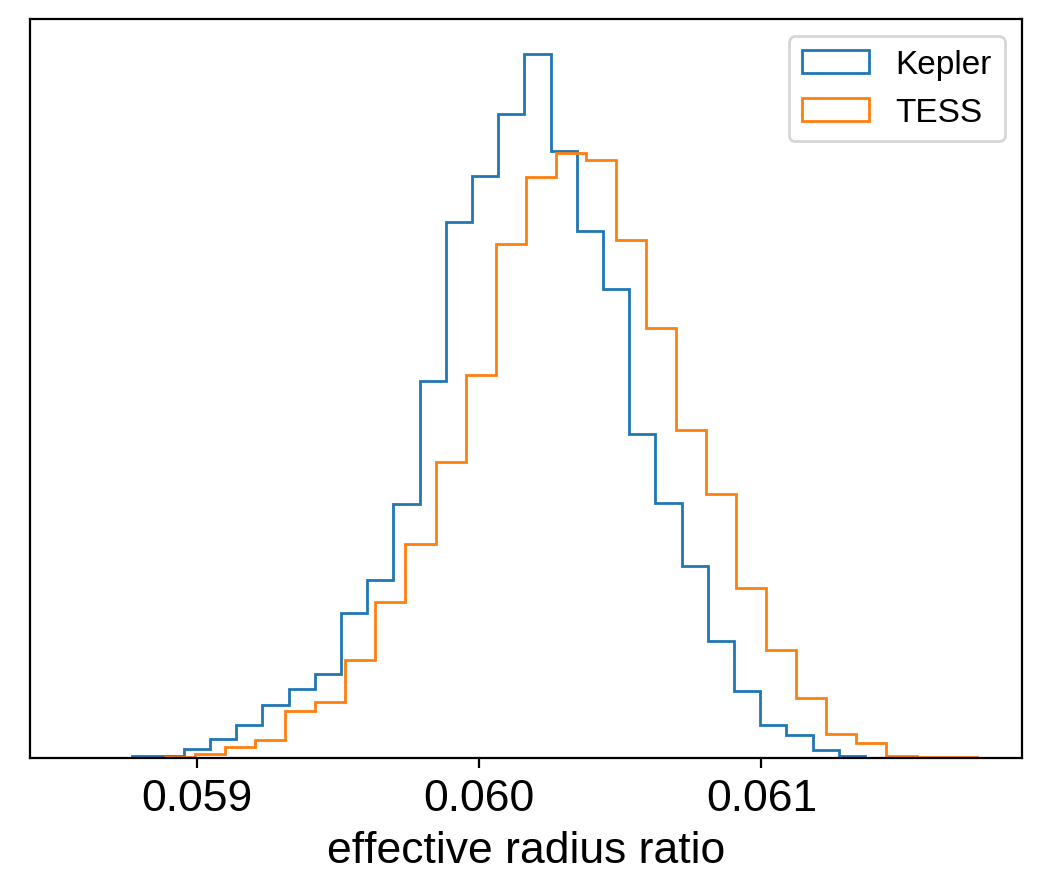

In [8]:
plt.hist(trace["Kepler_ror"], 30, density=True, histtype="step", label="Kepler")
plt.hist(trace["TESS_ror"], 30, density=True, histtype="step", label="TESS")
plt.yticks([])
plt.xlabel("effective radius ratio")
_ = plt.legend(fontsize=12)

We can also compare the inferred limb-darkening coefficients:

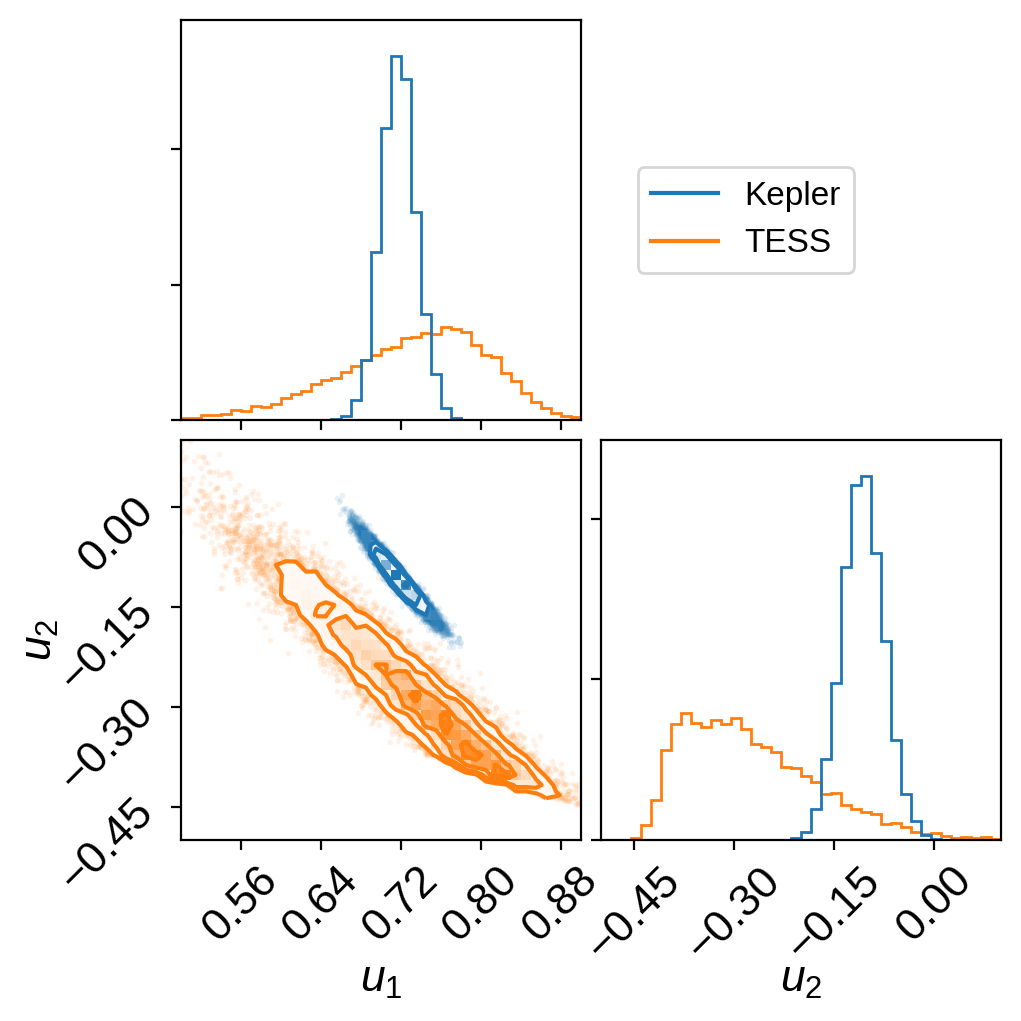

In [9]:
import corner

fig = corner.corner(
    trace["TESS_u"], bins=40, color="C1", range=((0.5, 0.9), (-0.5, 0.1))
)
corner.corner(
    trace["Kepler_u"],
    bins=40,
    color="C0",
    fig=fig,
    labels=["$u_1$", "$u_2$"],
    range=((0.5, 0.9), (-0.5, 0.1)),
)
fig.axes[0].axvline(-1.0, color="C0", label="Kepler")
fig.axes[0].axvline(-1.0, color="C1", label="TESS")
_ = fig.axes[0].legend(fontsize=12, loc="center left", bbox_to_anchor=(1.1, 0.5))

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [10]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:pymc3, exoplanet:theano}.


In [11]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
